In [1]:
# adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/
# https://towardsdatascience.com/pytorch-tutorial-distilled-95ce8781a89c

# 1. Import Modules

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
# fix random seed for reproducibility
np.random.seed(200184)

# 2. Train the GAN model

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [6]:
# defining classes and ANN
class AE_net(nn.Module):
    def __init__(self):
        super(AE_net, self).__init__()
        #net_list = [nn.Linear(1, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 1),  nn.ReLU()
        #           ]  # definition of model, just put in corresponding layers in sequence
        
        net_list = [nn.Linear(4, 2)#,   
#                     nn.Tanh(),
#                     nn.Linear(8, 32), 
#                     nn.Tanh(),
#                     nn.Linear(32, 128), 
#                     nn.Tanh(),
#                     nn.Linear(128, 128), 
#                     nn.Tanh(),
#                     nn.Linear(128, 32), 
#                     nn.Tanh(),
#                     nn.Linear(32, 8),
#                     nn.Tanh(),
#                     nn.Linear(8, 2)
                   ]
        self._net = nn.Sequential(*net_list).to(device)
        return

    def forward(self, x):
        return self._net(x)
    
def get_var_from_np(np_array, cuda=False, requires_grad=False):    # convert numpy to PyTorch variable for training
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp
    
def train(model, data_in, data_out, data_in_val, data_out_val):
    
    train_data = My_dataset(get_var_from_np(data_in), get_var_from_np(data_out))
    val_data = My_dataset(get_var_from_np(data_in_val), get_var_from_np(data_out_val))
    
    optimizer = torch.optim.SGD(model._net.parameters(), lr = 0.01, momentum=0.9)
    n_epoch = 3000
    batch_size = 100
    n_batch = math.ceil(1. * len(train_data) / batch_size)
    loss_train = np.zeros(n_epoch)
    loss_val = np.zeros(n_epoch)
    
    for epoch in range(n_epoch):    
        
        dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
        
        batch_idx = 0
        for train_in, train_out in dataset:
            out = model._net.forward(train_in)
            loss = nn.MSELoss()(out, train_out) 
            if (batch_idx+1) % min(10,n_batch) == 0:
                print ("Epoch = %5d, Batch = %5d/%5d [%4.0f%%]:\tTraining Loss = %12.5e" % (epoch, batch_idx+1, n_batch, 100. * (batch_idx+1) / n_batch, loss.cpu().data.numpy()))
            optimizer.zero_grad()
            loss.backward() # scalar variables, when we call .backward() on them, don’t require arguments – only tensors require a matching sized tensor argument to be passed to the .backward() operation
            optimizer.step()
            del loss
            batch_idx += 1
        
        data_out_pred = model._net.forward(get_var_from_np(data_in)).cpu().data.numpy()
        diff = data_out_pred - data_out
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_train[epoch] = MSE
        
        data_out_val_pred = model._net.forward(get_var_from_np(data_in_val)).cpu().data.numpy()
        diff = data_out_val_pred - data_out_val
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_val[epoch] = MSE        

    return loss_train, loss_val
    
class My_dataset(Dataset):      # construct dataset object for mini-batch gradient descent
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]

In [7]:
EBD = np.loadtxt("h2t latent space.txt",delimiter=' ')[:,1:5]
X = np.loadtxt("B_50001_10.txt",delimiter=' ')[:,0:2]

In [8]:
EBD.shape

(49963, 4)

In [9]:
X.shape

(49963, 2)

In [10]:
n = X.shape[0]

x = np.concatenate((EBD[:,0].reshape(EBD.shape[0],1), EBD[:,1].reshape(EBD.shape[0],1),EBD[:,2].reshape(EBD.shape[0],1),EBD[:,3].reshape(EBD.shape[0],1)), axis=1)

print (x)

[[-0.00263846 -0.00361265  0.0038061  -0.00162525]
 [-0.00296734 -0.00285012  0.00589526 -0.00032045]
 [-0.00257752 -0.00391072  0.00318959  0.00203152]
 ...
 [-0.00146915 -0.00042359 -0.00124585  0.00109989]
 [-0.00223762 -0.0005158   0.00213227 -0.00028185]
 [-0.00159293 -0.00059936 -0.00070171 -0.00048395]]


In [11]:
y = np.zeros((n,2))

y = np.concatenate((X[:,0].reshape(X.shape[0],1), X[:,1].reshape(X.shape[0],1)), axis=1)

print (y)

[[-0.00226417  0.00089316]
 [-0.0025789   0.00286235]
 [-0.00288158  0.00462698]
 ...
 [ 0.00416933 -0.00889798]
 [-0.00100227  0.00017455]
 [-0.00205245  0.00094186]]


In [12]:
test_frac = 0.10
val_frac = 0.20
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_frac, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_frac/(1-test_frac), random_state=43)

In [13]:
# scaling
xscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling
yscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling

# xscale = pre.StandardScaler()
# yscale = pre.StandardScaler()


X_train = xscale.fit_transform(x_train)
Y_train = yscale.fit_transform(y_train)
X_val = xscale.transform(x_val)
Y_val = yscale.transform(y_val)
X_test = xscale.transform(x_test)
Y_test = yscale.transform(y_test)
X = xscale.transform(x)
Y = yscale.transform(y)

In [14]:
# training
model = AE_net()
print(model)

AE_net(
  (_net): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
)


In [15]:
loss_train, loss_val = train(model, X_train, Y_train, X_val, Y_val)

Epoch =     0, Batch =    10/  350 [   3%]:	Training Loss =  4.06505e-02
Epoch =     0, Batch =    20/  350 [   6%]:	Training Loss =  3.31023e-02
Epoch =     0, Batch =    30/  350 [   9%]:	Training Loss =  2.39100e-02
Epoch =     0, Batch =    40/  350 [  11%]:	Training Loss =  3.30313e-02
Epoch =     0, Batch =    50/  350 [  14%]:	Training Loss =  2.54330e-02
Epoch =     0, Batch =    60/  350 [  17%]:	Training Loss =  2.62372e-02
Epoch =     0, Batch =    70/  350 [  20%]:	Training Loss =  2.25167e-02
Epoch =     0, Batch =    80/  350 [  23%]:	Training Loss =  2.63879e-02
Epoch =     0, Batch =    90/  350 [  26%]:	Training Loss =  2.18348e-02
Epoch =     0, Batch =   100/  350 [  29%]:	Training Loss =  2.32191e-02
Epoch =     0, Batch =   110/  350 [  31%]:	Training Loss =  2.67326e-02
Epoch =     0, Batch =   120/  350 [  34%]:	Training Loss =  2.97392e-02
Epoch =     0, Batch =   130/  350 [  37%]:	Training Loss =  1.94802e-02
Epoch =     0, Batch =   140/  350 [  40%]:	Trainin

Epoch =     3, Batch =   150/  350 [  43%]:	Training Loss =  1.74176e-02
Epoch =     3, Batch =   160/  350 [  46%]:	Training Loss =  1.63710e-02
Epoch =     3, Batch =   170/  350 [  49%]:	Training Loss =  2.23371e-02
Epoch =     3, Batch =   180/  350 [  51%]:	Training Loss =  1.33155e-02
Epoch =     3, Batch =   190/  350 [  54%]:	Training Loss =  1.45009e-02
Epoch =     3, Batch =   200/  350 [  57%]:	Training Loss =  1.94926e-02
Epoch =     3, Batch =   210/  350 [  60%]:	Training Loss =  1.36484e-02
Epoch =     3, Batch =   220/  350 [  63%]:	Training Loss =  1.71322e-02
Epoch =     3, Batch =   230/  350 [  66%]:	Training Loss =  1.11625e-02
Epoch =     3, Batch =   240/  350 [  69%]:	Training Loss =  1.67972e-02
Epoch =     3, Batch =   250/  350 [  71%]:	Training Loss =  1.57959e-02
Epoch =     3, Batch =   260/  350 [  74%]:	Training Loss =  2.32768e-02
Epoch =     3, Batch =   270/  350 [  77%]:	Training Loss =  2.02889e-02
Epoch =     3, Batch =   280/  350 [  80%]:	Trainin

Epoch =     6, Batch =   320/  350 [  91%]:	Training Loss =  1.62949e-02
Epoch =     6, Batch =   330/  350 [  94%]:	Training Loss =  1.59114e-02
Epoch =     6, Batch =   340/  350 [  97%]:	Training Loss =  1.40577e-02
Epoch =     7, Batch =    10/  350 [   3%]:	Training Loss =  1.65093e-02
Epoch =     7, Batch =    20/  350 [   6%]:	Training Loss =  1.74304e-02
Epoch =     7, Batch =    30/  350 [   9%]:	Training Loss =  1.59996e-02
Epoch =     7, Batch =    40/  350 [  11%]:	Training Loss =  1.55865e-02
Epoch =     7, Batch =    50/  350 [  14%]:	Training Loss =  1.76694e-02
Epoch =     7, Batch =    60/  350 [  17%]:	Training Loss =  1.72407e-02
Epoch =     7, Batch =    70/  350 [  20%]:	Training Loss =  1.33077e-02
Epoch =     7, Batch =    80/  350 [  23%]:	Training Loss =  1.37500e-02
Epoch =     7, Batch =    90/  350 [  26%]:	Training Loss =  2.05776e-02
Epoch =     7, Batch =   100/  350 [  29%]:	Training Loss =  1.60183e-02
Epoch =     7, Batch =   110/  350 [  31%]:	Trainin

Epoch =    10, Batch =   150/  350 [  43%]:	Training Loss =  1.99109e-02
Epoch =    10, Batch =   160/  350 [  46%]:	Training Loss =  1.97974e-02
Epoch =    10, Batch =   170/  350 [  49%]:	Training Loss =  1.84708e-02
Epoch =    10, Batch =   180/  350 [  51%]:	Training Loss =  1.43559e-02
Epoch =    10, Batch =   190/  350 [  54%]:	Training Loss =  1.52312e-02
Epoch =    10, Batch =   200/  350 [  57%]:	Training Loss =  1.36969e-02
Epoch =    10, Batch =   210/  350 [  60%]:	Training Loss =  1.81611e-02
Epoch =    10, Batch =   220/  350 [  63%]:	Training Loss =  1.82931e-02
Epoch =    10, Batch =   230/  350 [  66%]:	Training Loss =  1.64974e-02
Epoch =    10, Batch =   240/  350 [  69%]:	Training Loss =  1.58727e-02
Epoch =    10, Batch =   250/  350 [  71%]:	Training Loss =  1.47209e-02
Epoch =    10, Batch =   260/  350 [  74%]:	Training Loss =  1.41567e-02
Epoch =    10, Batch =   270/  350 [  77%]:	Training Loss =  1.60460e-02
Epoch =    10, Batch =   280/  350 [  80%]:	Trainin

Epoch =    13, Batch =   280/  350 [  80%]:	Training Loss =  1.76525e-02
Epoch =    13, Batch =   290/  350 [  83%]:	Training Loss =  1.64189e-02
Epoch =    13, Batch =   300/  350 [  86%]:	Training Loss =  2.30901e-02
Epoch =    13, Batch =   310/  350 [  89%]:	Training Loss =  1.98355e-02
Epoch =    13, Batch =   320/  350 [  91%]:	Training Loss =  1.32015e-02
Epoch =    13, Batch =   330/  350 [  94%]:	Training Loss =  1.96050e-02
Epoch =    13, Batch =   340/  350 [  97%]:	Training Loss =  1.66795e-02
Epoch =    14, Batch =    10/  350 [   3%]:	Training Loss =  1.76796e-02
Epoch =    14, Batch =    20/  350 [   6%]:	Training Loss =  1.68988e-02
Epoch =    14, Batch =    30/  350 [   9%]:	Training Loss =  1.50033e-02
Epoch =    14, Batch =    40/  350 [  11%]:	Training Loss =  1.68352e-02
Epoch =    14, Batch =    50/  350 [  14%]:	Training Loss =  1.89353e-02
Epoch =    14, Batch =    60/  350 [  17%]:	Training Loss =  1.64894e-02
Epoch =    14, Batch =    70/  350 [  20%]:	Trainin

Epoch =    17, Batch =    80/  350 [  23%]:	Training Loss =  1.72293e-02
Epoch =    17, Batch =    90/  350 [  26%]:	Training Loss =  1.59891e-02
Epoch =    17, Batch =   100/  350 [  29%]:	Training Loss =  1.20499e-02
Epoch =    17, Batch =   110/  350 [  31%]:	Training Loss =  1.28807e-02
Epoch =    17, Batch =   120/  350 [  34%]:	Training Loss =  1.80076e-02
Epoch =    17, Batch =   130/  350 [  37%]:	Training Loss =  1.53863e-02
Epoch =    17, Batch =   140/  350 [  40%]:	Training Loss =  1.65796e-02
Epoch =    17, Batch =   150/  350 [  43%]:	Training Loss =  1.57645e-02
Epoch =    17, Batch =   160/  350 [  46%]:	Training Loss =  1.62322e-02
Epoch =    17, Batch =   170/  350 [  49%]:	Training Loss =  1.73959e-02
Epoch =    17, Batch =   180/  350 [  51%]:	Training Loss =  1.65361e-02
Epoch =    17, Batch =   190/  350 [  54%]:	Training Loss =  1.53107e-02
Epoch =    17, Batch =   200/  350 [  57%]:	Training Loss =  1.68728e-02
Epoch =    17, Batch =   210/  350 [  60%]:	Trainin

Epoch =    20, Batch =   200/  350 [  57%]:	Training Loss =  2.08802e-02
Epoch =    20, Batch =   210/  350 [  60%]:	Training Loss =  1.76207e-02
Epoch =    20, Batch =   220/  350 [  63%]:	Training Loss =  1.26950e-02
Epoch =    20, Batch =   230/  350 [  66%]:	Training Loss =  1.61743e-02
Epoch =    20, Batch =   240/  350 [  69%]:	Training Loss =  1.61864e-02
Epoch =    20, Batch =   250/  350 [  71%]:	Training Loss =  1.76817e-02
Epoch =    20, Batch =   260/  350 [  74%]:	Training Loss =  1.58321e-02
Epoch =    20, Batch =   270/  350 [  77%]:	Training Loss =  1.94412e-02
Epoch =    20, Batch =   280/  350 [  80%]:	Training Loss =  1.70635e-02
Epoch =    20, Batch =   290/  350 [  83%]:	Training Loss =  1.93412e-02
Epoch =    20, Batch =   300/  350 [  86%]:	Training Loss =  2.43687e-02
Epoch =    20, Batch =   310/  350 [  89%]:	Training Loss =  1.76551e-02
Epoch =    20, Batch =   320/  350 [  91%]:	Training Loss =  1.40792e-02
Epoch =    20, Batch =   330/  350 [  94%]:	Trainin

Epoch =    24, Batch =    30/  350 [   9%]:	Training Loss =  1.28986e-02
Epoch =    24, Batch =    40/  350 [  11%]:	Training Loss =  1.43375e-02
Epoch =    24, Batch =    50/  350 [  14%]:	Training Loss =  1.93063e-02
Epoch =    24, Batch =    60/  350 [  17%]:	Training Loss =  1.47950e-02
Epoch =    24, Batch =    70/  350 [  20%]:	Training Loss =  1.66375e-02
Epoch =    24, Batch =    80/  350 [  23%]:	Training Loss =  1.46416e-02
Epoch =    24, Batch =    90/  350 [  26%]:	Training Loss =  1.71804e-02
Epoch =    24, Batch =   100/  350 [  29%]:	Training Loss =  1.75458e-02
Epoch =    24, Batch =   110/  350 [  31%]:	Training Loss =  1.98469e-02
Epoch =    24, Batch =   120/  350 [  34%]:	Training Loss =  1.84000e-02
Epoch =    24, Batch =   130/  350 [  37%]:	Training Loss =  2.10469e-02
Epoch =    24, Batch =   140/  350 [  40%]:	Training Loss =  1.56606e-02
Epoch =    24, Batch =   150/  350 [  43%]:	Training Loss =  1.63623e-02
Epoch =    24, Batch =   160/  350 [  46%]:	Trainin

Epoch =    27, Batch =   140/  350 [  40%]:	Training Loss =  1.90491e-02
Epoch =    27, Batch =   150/  350 [  43%]:	Training Loss =  1.69595e-02
Epoch =    27, Batch =   160/  350 [  46%]:	Training Loss =  1.51249e-02
Epoch =    27, Batch =   170/  350 [  49%]:	Training Loss =  2.25490e-02
Epoch =    27, Batch =   180/  350 [  51%]:	Training Loss =  1.93972e-02
Epoch =    27, Batch =   190/  350 [  54%]:	Training Loss =  1.66864e-02
Epoch =    27, Batch =   200/  350 [  57%]:	Training Loss =  2.37603e-02
Epoch =    27, Batch =   210/  350 [  60%]:	Training Loss =  1.46295e-02
Epoch =    27, Batch =   220/  350 [  63%]:	Training Loss =  1.34439e-02
Epoch =    27, Batch =   230/  350 [  66%]:	Training Loss =  1.47569e-02
Epoch =    27, Batch =   240/  350 [  69%]:	Training Loss =  1.93966e-02
Epoch =    27, Batch =   250/  350 [  71%]:	Training Loss =  2.18334e-02
Epoch =    27, Batch =   260/  350 [  74%]:	Training Loss =  1.52252e-02
Epoch =    27, Batch =   270/  350 [  77%]:	Trainin

Epoch =    30, Batch =   330/  350 [  94%]:	Training Loss =  1.71187e-02
Epoch =    30, Batch =   340/  350 [  97%]:	Training Loss =  1.58143e-02
Epoch =    31, Batch =    10/  350 [   3%]:	Training Loss =  1.85339e-02
Epoch =    31, Batch =    20/  350 [   6%]:	Training Loss =  1.30369e-02
Epoch =    31, Batch =    30/  350 [   9%]:	Training Loss =  1.75862e-02
Epoch =    31, Batch =    40/  350 [  11%]:	Training Loss =  1.93567e-02
Epoch =    31, Batch =    50/  350 [  14%]:	Training Loss =  1.98570e-02
Epoch =    31, Batch =    60/  350 [  17%]:	Training Loss =  1.31752e-02
Epoch =    31, Batch =    70/  350 [  20%]:	Training Loss =  1.25722e-02
Epoch =    31, Batch =    80/  350 [  23%]:	Training Loss =  1.76135e-02
Epoch =    31, Batch =    90/  350 [  26%]:	Training Loss =  1.77947e-02
Epoch =    31, Batch =   100/  350 [  29%]:	Training Loss =  2.28278e-02
Epoch =    31, Batch =   110/  350 [  31%]:	Training Loss =  1.66721e-02
Epoch =    31, Batch =   120/  350 [  34%]:	Trainin

Epoch =    34, Batch =   100/  350 [  29%]:	Training Loss =  1.57404e-02
Epoch =    34, Batch =   110/  350 [  31%]:	Training Loss =  1.91704e-02
Epoch =    34, Batch =   120/  350 [  34%]:	Training Loss =  2.05116e-02
Epoch =    34, Batch =   130/  350 [  37%]:	Training Loss =  2.05398e-02
Epoch =    34, Batch =   140/  350 [  40%]:	Training Loss =  2.19320e-02
Epoch =    34, Batch =   150/  350 [  43%]:	Training Loss =  2.18566e-02
Epoch =    34, Batch =   160/  350 [  46%]:	Training Loss =  1.16980e-02
Epoch =    34, Batch =   170/  350 [  49%]:	Training Loss =  1.58998e-02
Epoch =    34, Batch =   180/  350 [  51%]:	Training Loss =  1.56469e-02
Epoch =    34, Batch =   190/  350 [  54%]:	Training Loss =  2.17668e-02
Epoch =    34, Batch =   200/  350 [  57%]:	Training Loss =  1.77481e-02
Epoch =    34, Batch =   210/  350 [  60%]:	Training Loss =  1.26105e-02
Epoch =    34, Batch =   220/  350 [  63%]:	Training Loss =  1.53330e-02
Epoch =    34, Batch =   230/  350 [  66%]:	Trainin

Epoch =    37, Batch =   250/  350 [  71%]:	Training Loss =  2.26620e-02
Epoch =    37, Batch =   260/  350 [  74%]:	Training Loss =  1.78074e-02
Epoch =    37, Batch =   270/  350 [  77%]:	Training Loss =  1.55355e-02
Epoch =    37, Batch =   280/  350 [  80%]:	Training Loss =  1.92069e-02
Epoch =    37, Batch =   290/  350 [  83%]:	Training Loss =  1.21674e-02
Epoch =    37, Batch =   300/  350 [  86%]:	Training Loss =  1.45000e-02
Epoch =    37, Batch =   310/  350 [  89%]:	Training Loss =  1.67299e-02
Epoch =    37, Batch =   320/  350 [  91%]:	Training Loss =  1.61638e-02
Epoch =    37, Batch =   330/  350 [  94%]:	Training Loss =  1.54455e-02
Epoch =    37, Batch =   340/  350 [  97%]:	Training Loss =  1.79138e-02
Epoch =    38, Batch =    10/  350 [   3%]:	Training Loss =  1.64695e-02
Epoch =    38, Batch =    20/  350 [   6%]:	Training Loss =  1.32246e-02
Epoch =    38, Batch =    30/  350 [   9%]:	Training Loss =  1.86787e-02
Epoch =    38, Batch =    40/  350 [  11%]:	Trainin

Epoch =    41, Batch =   120/  350 [  34%]:	Training Loss =  2.31508e-02
Epoch =    41, Batch =   130/  350 [  37%]:	Training Loss =  1.55359e-02
Epoch =    41, Batch =   140/  350 [  40%]:	Training Loss =  1.67429e-02
Epoch =    41, Batch =   150/  350 [  43%]:	Training Loss =  1.42466e-02
Epoch =    41, Batch =   160/  350 [  46%]:	Training Loss =  1.94325e-02
Epoch =    41, Batch =   170/  350 [  49%]:	Training Loss =  1.39805e-02
Epoch =    41, Batch =   180/  350 [  51%]:	Training Loss =  2.46868e-02
Epoch =    41, Batch =   190/  350 [  54%]:	Training Loss =  1.43476e-02
Epoch =    41, Batch =   200/  350 [  57%]:	Training Loss =  1.28469e-02
Epoch =    41, Batch =   210/  350 [  60%]:	Training Loss =  1.53255e-02
Epoch =    41, Batch =   220/  350 [  63%]:	Training Loss =  1.83992e-02
Epoch =    41, Batch =   230/  350 [  66%]:	Training Loss =  1.46630e-02
Epoch =    41, Batch =   240/  350 [  69%]:	Training Loss =  1.46361e-02
Epoch =    41, Batch =   250/  350 [  71%]:	Trainin

Epoch =    44, Batch =   340/  350 [  97%]:	Training Loss =  1.77559e-02
Epoch =    45, Batch =    10/  350 [   3%]:	Training Loss =  1.49810e-02
Epoch =    45, Batch =    20/  350 [   6%]:	Training Loss =  1.51580e-02
Epoch =    45, Batch =    30/  350 [   9%]:	Training Loss =  2.15835e-02
Epoch =    45, Batch =    40/  350 [  11%]:	Training Loss =  1.71714e-02
Epoch =    45, Batch =    50/  350 [  14%]:	Training Loss =  1.46654e-02
Epoch =    45, Batch =    60/  350 [  17%]:	Training Loss =  1.49811e-02
Epoch =    45, Batch =    70/  350 [  20%]:	Training Loss =  1.73890e-02
Epoch =    45, Batch =    80/  350 [  23%]:	Training Loss =  2.22992e-02
Epoch =    45, Batch =    90/  350 [  26%]:	Training Loss =  1.48223e-02
Epoch =    45, Batch =   100/  350 [  29%]:	Training Loss =  1.39411e-02
Epoch =    45, Batch =   110/  350 [  31%]:	Training Loss =  2.33180e-02
Epoch =    45, Batch =   120/  350 [  34%]:	Training Loss =  1.57892e-02
Epoch =    45, Batch =   130/  350 [  37%]:	Trainin

Epoch =    48, Batch =   130/  350 [  37%]:	Training Loss =  1.41263e-02
Epoch =    48, Batch =   140/  350 [  40%]:	Training Loss =  1.51551e-02
Epoch =    48, Batch =   150/  350 [  43%]:	Training Loss =  1.35767e-02
Epoch =    48, Batch =   160/  350 [  46%]:	Training Loss =  1.74033e-02
Epoch =    48, Batch =   170/  350 [  49%]:	Training Loss =  1.79688e-02
Epoch =    48, Batch =   180/  350 [  51%]:	Training Loss =  1.27550e-02
Epoch =    48, Batch =   190/  350 [  54%]:	Training Loss =  1.18071e-02
Epoch =    48, Batch =   200/  350 [  57%]:	Training Loss =  2.19238e-02
Epoch =    48, Batch =   210/  350 [  60%]:	Training Loss =  1.31678e-02
Epoch =    48, Batch =   220/  350 [  63%]:	Training Loss =  1.66829e-02
Epoch =    48, Batch =   230/  350 [  66%]:	Training Loss =  1.24897e-02
Epoch =    48, Batch =   240/  350 [  69%]:	Training Loss =  1.80572e-02
Epoch =    48, Batch =   250/  350 [  71%]:	Training Loss =  1.69884e-02
Epoch =    48, Batch =   260/  350 [  74%]:	Trainin

Epoch =    51, Batch =   260/  350 [  74%]:	Training Loss =  1.80018e-02
Epoch =    51, Batch =   270/  350 [  77%]:	Training Loss =  1.75642e-02
Epoch =    51, Batch =   280/  350 [  80%]:	Training Loss =  1.41005e-02
Epoch =    51, Batch =   290/  350 [  83%]:	Training Loss =  1.94122e-02
Epoch =    51, Batch =   300/  350 [  86%]:	Training Loss =  1.59058e-02
Epoch =    51, Batch =   310/  350 [  89%]:	Training Loss =  2.04516e-02
Epoch =    51, Batch =   320/  350 [  91%]:	Training Loss =  1.80009e-02
Epoch =    51, Batch =   330/  350 [  94%]:	Training Loss =  1.35161e-02
Epoch =    51, Batch =   340/  350 [  97%]:	Training Loss =  1.65919e-02
Epoch =    52, Batch =    10/  350 [   3%]:	Training Loss =  1.55850e-02
Epoch =    52, Batch =    20/  350 [   6%]:	Training Loss =  1.30624e-02
Epoch =    52, Batch =    30/  350 [   9%]:	Training Loss =  1.58087e-02
Epoch =    52, Batch =    40/  350 [  11%]:	Training Loss =  1.81576e-02
Epoch =    52, Batch =    50/  350 [  14%]:	Trainin

Epoch =    55, Batch =   160/  350 [  46%]:	Training Loss =  1.64362e-02
Epoch =    55, Batch =   170/  350 [  49%]:	Training Loss =  1.90761e-02
Epoch =    55, Batch =   180/  350 [  51%]:	Training Loss =  1.56175e-02
Epoch =    55, Batch =   190/  350 [  54%]:	Training Loss =  1.71845e-02
Epoch =    55, Batch =   200/  350 [  57%]:	Training Loss =  1.60862e-02
Epoch =    55, Batch =   210/  350 [  60%]:	Training Loss =  1.54463e-02
Epoch =    55, Batch =   220/  350 [  63%]:	Training Loss =  2.10824e-02
Epoch =    55, Batch =   230/  350 [  66%]:	Training Loss =  1.61396e-02
Epoch =    55, Batch =   240/  350 [  69%]:	Training Loss =  1.39150e-02
Epoch =    55, Batch =   250/  350 [  71%]:	Training Loss =  1.45269e-02
Epoch =    55, Batch =   260/  350 [  74%]:	Training Loss =  2.18115e-02
Epoch =    55, Batch =   270/  350 [  77%]:	Training Loss =  1.72049e-02
Epoch =    55, Batch =   280/  350 [  80%]:	Training Loss =  1.48529e-02
Epoch =    55, Batch =   290/  350 [  83%]:	Trainin

Epoch =    58, Batch =   280/  350 [  80%]:	Training Loss =  1.55574e-02
Epoch =    58, Batch =   290/  350 [  83%]:	Training Loss =  2.09829e-02
Epoch =    58, Batch =   300/  350 [  86%]:	Training Loss =  2.06543e-02
Epoch =    58, Batch =   310/  350 [  89%]:	Training Loss =  1.82540e-02
Epoch =    58, Batch =   320/  350 [  91%]:	Training Loss =  1.67003e-02
Epoch =    58, Batch =   330/  350 [  94%]:	Training Loss =  1.58368e-02
Epoch =    58, Batch =   340/  350 [  97%]:	Training Loss =  1.43225e-02
Epoch =    59, Batch =    10/  350 [   3%]:	Training Loss =  1.52043e-02
Epoch =    59, Batch =    20/  350 [   6%]:	Training Loss =  1.97907e-02
Epoch =    59, Batch =    30/  350 [   9%]:	Training Loss =  1.41752e-02
Epoch =    59, Batch =    40/  350 [  11%]:	Training Loss =  1.92256e-02
Epoch =    59, Batch =    50/  350 [  14%]:	Training Loss =  1.73608e-02
Epoch =    59, Batch =    60/  350 [  17%]:	Training Loss =  1.85972e-02
Epoch =    59, Batch =    70/  350 [  20%]:	Trainin

Epoch =    62, Batch =    90/  350 [  26%]:	Training Loss =  1.54455e-02
Epoch =    62, Batch =   100/  350 [  29%]:	Training Loss =  1.66251e-02
Epoch =    62, Batch =   110/  350 [  31%]:	Training Loss =  1.43007e-02
Epoch =    62, Batch =   120/  350 [  34%]:	Training Loss =  2.08072e-02
Epoch =    62, Batch =   130/  350 [  37%]:	Training Loss =  1.73795e-02
Epoch =    62, Batch =   140/  350 [  40%]:	Training Loss =  1.40957e-02
Epoch =    62, Batch =   150/  350 [  43%]:	Training Loss =  1.74043e-02
Epoch =    62, Batch =   160/  350 [  46%]:	Training Loss =  1.35634e-02
Epoch =    62, Batch =   170/  350 [  49%]:	Training Loss =  1.76669e-02
Epoch =    62, Batch =   180/  350 [  51%]:	Training Loss =  1.72492e-02
Epoch =    62, Batch =   190/  350 [  54%]:	Training Loss =  1.84791e-02
Epoch =    62, Batch =   200/  350 [  57%]:	Training Loss =  1.90806e-02
Epoch =    62, Batch =   210/  350 [  60%]:	Training Loss =  1.76086e-02
Epoch =    62, Batch =   220/  350 [  63%]:	Trainin

Epoch =    65, Batch =   210/  350 [  60%]:	Training Loss =  1.26406e-02
Epoch =    65, Batch =   220/  350 [  63%]:	Training Loss =  1.54588e-02
Epoch =    65, Batch =   230/  350 [  66%]:	Training Loss =  1.72661e-02
Epoch =    65, Batch =   240/  350 [  69%]:	Training Loss =  1.76510e-02
Epoch =    65, Batch =   250/  350 [  71%]:	Training Loss =  1.55238e-02
Epoch =    65, Batch =   260/  350 [  74%]:	Training Loss =  1.69475e-02
Epoch =    65, Batch =   270/  350 [  77%]:	Training Loss =  1.91379e-02
Epoch =    65, Batch =   280/  350 [  80%]:	Training Loss =  2.65400e-02
Epoch =    65, Batch =   290/  350 [  83%]:	Training Loss =  1.77657e-02
Epoch =    65, Batch =   300/  350 [  86%]:	Training Loss =  1.80971e-02
Epoch =    65, Batch =   310/  350 [  89%]:	Training Loss =  1.54214e-02
Epoch =    65, Batch =   320/  350 [  91%]:	Training Loss =  1.28526e-02
Epoch =    65, Batch =   330/  350 [  94%]:	Training Loss =  1.65162e-02
Epoch =    65, Batch =   340/  350 [  97%]:	Trainin

Epoch =    68, Batch =   340/  350 [  97%]:	Training Loss =  1.87548e-02
Epoch =    69, Batch =    10/  350 [   3%]:	Training Loss =  1.49884e-02
Epoch =    69, Batch =    20/  350 [   6%]:	Training Loss =  1.43046e-02
Epoch =    69, Batch =    30/  350 [   9%]:	Training Loss =  1.83299e-02
Epoch =    69, Batch =    40/  350 [  11%]:	Training Loss =  1.58454e-02
Epoch =    69, Batch =    50/  350 [  14%]:	Training Loss =  1.63147e-02
Epoch =    69, Batch =    60/  350 [  17%]:	Training Loss =  1.31193e-02
Epoch =    69, Batch =    70/  350 [  20%]:	Training Loss =  1.27494e-02
Epoch =    69, Batch =    80/  350 [  23%]:	Training Loss =  1.80343e-02
Epoch =    69, Batch =    90/  350 [  26%]:	Training Loss =  1.56967e-02
Epoch =    69, Batch =   100/  350 [  29%]:	Training Loss =  1.71921e-02
Epoch =    69, Batch =   110/  350 [  31%]:	Training Loss =  1.68341e-02
Epoch =    69, Batch =   120/  350 [  34%]:	Training Loss =  1.50797e-02
Epoch =    69, Batch =   130/  350 [  37%]:	Trainin

Epoch =    72, Batch =   190/  350 [  54%]:	Training Loss =  2.08225e-02
Epoch =    72, Batch =   200/  350 [  57%]:	Training Loss =  1.22784e-02
Epoch =    72, Batch =   210/  350 [  60%]:	Training Loss =  1.31454e-02
Epoch =    72, Batch =   220/  350 [  63%]:	Training Loss =  2.05259e-02
Epoch =    72, Batch =   230/  350 [  66%]:	Training Loss =  1.76355e-02
Epoch =    72, Batch =   240/  350 [  69%]:	Training Loss =  1.94114e-02
Epoch =    72, Batch =   250/  350 [  71%]:	Training Loss =  1.67716e-02
Epoch =    72, Batch =   260/  350 [  74%]:	Training Loss =  2.02648e-02
Epoch =    72, Batch =   270/  350 [  77%]:	Training Loss =  1.32318e-02
Epoch =    72, Batch =   280/  350 [  80%]:	Training Loss =  1.40446e-02
Epoch =    72, Batch =   290/  350 [  83%]:	Training Loss =  1.89383e-02
Epoch =    72, Batch =   300/  350 [  86%]:	Training Loss =  1.98140e-02
Epoch =    72, Batch =   310/  350 [  89%]:	Training Loss =  1.97350e-02
Epoch =    72, Batch =   320/  350 [  91%]:	Trainin

Epoch =    76, Batch =    40/  350 [  11%]:	Training Loss =  1.37603e-02
Epoch =    76, Batch =    50/  350 [  14%]:	Training Loss =  1.99079e-02
Epoch =    76, Batch =    60/  350 [  17%]:	Training Loss =  1.32467e-02
Epoch =    76, Batch =    70/  350 [  20%]:	Training Loss =  1.87350e-02
Epoch =    76, Batch =    80/  350 [  23%]:	Training Loss =  1.86490e-02
Epoch =    76, Batch =    90/  350 [  26%]:	Training Loss =  1.59952e-02
Epoch =    76, Batch =   100/  350 [  29%]:	Training Loss =  1.67225e-02
Epoch =    76, Batch =   110/  350 [  31%]:	Training Loss =  1.52658e-02
Epoch =    76, Batch =   120/  350 [  34%]:	Training Loss =  2.52794e-02
Epoch =    76, Batch =   130/  350 [  37%]:	Training Loss =  1.35874e-02
Epoch =    76, Batch =   140/  350 [  40%]:	Training Loss =  2.07235e-02
Epoch =    76, Batch =   150/  350 [  43%]:	Training Loss =  1.71643e-02
Epoch =    76, Batch =   160/  350 [  46%]:	Training Loss =  2.07429e-02
Epoch =    76, Batch =   170/  350 [  49%]:	Trainin

Epoch =    79, Batch =   210/  350 [  60%]:	Training Loss =  1.59487e-02
Epoch =    79, Batch =   220/  350 [  63%]:	Training Loss =  2.03495e-02
Epoch =    79, Batch =   230/  350 [  66%]:	Training Loss =  1.91121e-02
Epoch =    79, Batch =   240/  350 [  69%]:	Training Loss =  1.60558e-02
Epoch =    79, Batch =   250/  350 [  71%]:	Training Loss =  1.43818e-02
Epoch =    79, Batch =   260/  350 [  74%]:	Training Loss =  1.50105e-02
Epoch =    79, Batch =   270/  350 [  77%]:	Training Loss =  1.80577e-02
Epoch =    79, Batch =   280/  350 [  80%]:	Training Loss =  1.94084e-02
Epoch =    79, Batch =   290/  350 [  83%]:	Training Loss =  1.49566e-02
Epoch =    79, Batch =   300/  350 [  86%]:	Training Loss =  1.70380e-02
Epoch =    79, Batch =   310/  350 [  89%]:	Training Loss =  1.81893e-02
Epoch =    79, Batch =   320/  350 [  91%]:	Training Loss =  1.39362e-02
Epoch =    79, Batch =   330/  350 [  94%]:	Training Loss =  1.54305e-02
Epoch =    79, Batch =   340/  350 [  97%]:	Trainin

Epoch =    83, Batch =    10/  350 [   3%]:	Training Loss =  1.87737e-02
Epoch =    83, Batch =    20/  350 [   6%]:	Training Loss =  1.69203e-02
Epoch =    83, Batch =    30/  350 [   9%]:	Training Loss =  1.85707e-02
Epoch =    83, Batch =    40/  350 [  11%]:	Training Loss =  1.72969e-02
Epoch =    83, Batch =    50/  350 [  14%]:	Training Loss =  1.81747e-02
Epoch =    83, Batch =    60/  350 [  17%]:	Training Loss =  1.93989e-02
Epoch =    83, Batch =    70/  350 [  20%]:	Training Loss =  1.94386e-02
Epoch =    83, Batch =    80/  350 [  23%]:	Training Loss =  1.52328e-02
Epoch =    83, Batch =    90/  350 [  26%]:	Training Loss =  1.73458e-02
Epoch =    83, Batch =   100/  350 [  29%]:	Training Loss =  1.51259e-02
Epoch =    83, Batch =   110/  350 [  31%]:	Training Loss =  1.13224e-02
Epoch =    83, Batch =   120/  350 [  34%]:	Training Loss =  2.08834e-02
Epoch =    83, Batch =   130/  350 [  37%]:	Training Loss =  1.54686e-02
Epoch =    83, Batch =   140/  350 [  40%]:	Trainin

Epoch =    86, Batch =   150/  350 [  43%]:	Training Loss =  1.62803e-02
Epoch =    86, Batch =   160/  350 [  46%]:	Training Loss =  1.57072e-02
Epoch =    86, Batch =   170/  350 [  49%]:	Training Loss =  1.67430e-02
Epoch =    86, Batch =   180/  350 [  51%]:	Training Loss =  1.62151e-02
Epoch =    86, Batch =   190/  350 [  54%]:	Training Loss =  1.67392e-02
Epoch =    86, Batch =   200/  350 [  57%]:	Training Loss =  1.67701e-02
Epoch =    86, Batch =   210/  350 [  60%]:	Training Loss =  1.52069e-02
Epoch =    86, Batch =   220/  350 [  63%]:	Training Loss =  1.51410e-02
Epoch =    86, Batch =   230/  350 [  66%]:	Training Loss =  1.54192e-02
Epoch =    86, Batch =   240/  350 [  69%]:	Training Loss =  1.75863e-02
Epoch =    86, Batch =   250/  350 [  71%]:	Training Loss =  1.33953e-02
Epoch =    86, Batch =   260/  350 [  74%]:	Training Loss =  1.33867e-02
Epoch =    86, Batch =   270/  350 [  77%]:	Training Loss =  1.30191e-02
Epoch =    86, Batch =   280/  350 [  80%]:	Trainin

Epoch =    89, Batch =   340/  350 [  97%]:	Training Loss =  1.43462e-02
Epoch =    90, Batch =    10/  350 [   3%]:	Training Loss =  1.79230e-02
Epoch =    90, Batch =    20/  350 [   6%]:	Training Loss =  1.75133e-02
Epoch =    90, Batch =    30/  350 [   9%]:	Training Loss =  1.52011e-02
Epoch =    90, Batch =    40/  350 [  11%]:	Training Loss =  2.27374e-02
Epoch =    90, Batch =    50/  350 [  14%]:	Training Loss =  1.52003e-02
Epoch =    90, Batch =    60/  350 [  17%]:	Training Loss =  1.62703e-02
Epoch =    90, Batch =    70/  350 [  20%]:	Training Loss =  2.35861e-02
Epoch =    90, Batch =    80/  350 [  23%]:	Training Loss =  1.08065e-02
Epoch =    90, Batch =    90/  350 [  26%]:	Training Loss =  1.60999e-02
Epoch =    90, Batch =   100/  350 [  29%]:	Training Loss =  1.52864e-02
Epoch =    90, Batch =   110/  350 [  31%]:	Training Loss =  1.95462e-02
Epoch =    90, Batch =   120/  350 [  34%]:	Training Loss =  1.74017e-02
Epoch =    90, Batch =   130/  350 [  37%]:	Trainin

Epoch =    93, Batch =   160/  350 [  46%]:	Training Loss =  1.51087e-02
Epoch =    93, Batch =   170/  350 [  49%]:	Training Loss =  1.46982e-02
Epoch =    93, Batch =   180/  350 [  51%]:	Training Loss =  1.71729e-02
Epoch =    93, Batch =   190/  350 [  54%]:	Training Loss =  2.12861e-02
Epoch =    93, Batch =   200/  350 [  57%]:	Training Loss =  1.58403e-02
Epoch =    93, Batch =   210/  350 [  60%]:	Training Loss =  1.48708e-02
Epoch =    93, Batch =   220/  350 [  63%]:	Training Loss =  1.46443e-02
Epoch =    93, Batch =   230/  350 [  66%]:	Training Loss =  1.75543e-02
Epoch =    93, Batch =   240/  350 [  69%]:	Training Loss =  1.53210e-02
Epoch =    93, Batch =   250/  350 [  71%]:	Training Loss =  1.47377e-02
Epoch =    93, Batch =   260/  350 [  74%]:	Training Loss =  1.51369e-02
Epoch =    93, Batch =   270/  350 [  77%]:	Training Loss =  1.73189e-02
Epoch =    93, Batch =   280/  350 [  80%]:	Training Loss =  2.02375e-02
Epoch =    93, Batch =   290/  350 [  83%]:	Trainin

Epoch =    97, Batch =    10/  350 [   3%]:	Training Loss =  1.56085e-02
Epoch =    97, Batch =    20/  350 [   6%]:	Training Loss =  1.68087e-02
Epoch =    97, Batch =    30/  350 [   9%]:	Training Loss =  1.35869e-02
Epoch =    97, Batch =    40/  350 [  11%]:	Training Loss =  2.06110e-02
Epoch =    97, Batch =    50/  350 [  14%]:	Training Loss =  1.61230e-02
Epoch =    97, Batch =    60/  350 [  17%]:	Training Loss =  1.59225e-02
Epoch =    97, Batch =    70/  350 [  20%]:	Training Loss =  1.54369e-02
Epoch =    97, Batch =    80/  350 [  23%]:	Training Loss =  1.41514e-02
Epoch =    97, Batch =    90/  350 [  26%]:	Training Loss =  1.86091e-02
Epoch =    97, Batch =   100/  350 [  29%]:	Training Loss =  1.50692e-02
Epoch =    97, Batch =   110/  350 [  31%]:	Training Loss =  1.61282e-02
Epoch =    97, Batch =   120/  350 [  34%]:	Training Loss =  1.30981e-02
Epoch =    97, Batch =   130/  350 [  37%]:	Training Loss =  1.58112e-02
Epoch =    97, Batch =   140/  350 [  40%]:	Trainin

Epoch =   100, Batch =   240/  350 [  69%]:	Training Loss =  1.61760e-02
Epoch =   100, Batch =   250/  350 [  71%]:	Training Loss =  1.82771e-02
Epoch =   100, Batch =   260/  350 [  74%]:	Training Loss =  1.32606e-02
Epoch =   100, Batch =   270/  350 [  77%]:	Training Loss =  1.52574e-02
Epoch =   100, Batch =   280/  350 [  80%]:	Training Loss =  1.80933e-02
Epoch =   100, Batch =   290/  350 [  83%]:	Training Loss =  1.47544e-02
Epoch =   100, Batch =   300/  350 [  86%]:	Training Loss =  2.43799e-02
Epoch =   100, Batch =   310/  350 [  89%]:	Training Loss =  1.97376e-02
Epoch =   100, Batch =   320/  350 [  91%]:	Training Loss =  1.21306e-02
Epoch =   100, Batch =   330/  350 [  94%]:	Training Loss =  1.50300e-02
Epoch =   100, Batch =   340/  350 [  97%]:	Training Loss =  1.64709e-02
Epoch =   101, Batch =    10/  350 [   3%]:	Training Loss =  1.85279e-02
Epoch =   101, Batch =    20/  350 [   6%]:	Training Loss =  1.65168e-02
Epoch =   101, Batch =    30/  350 [   9%]:	Trainin

Epoch =   104, Batch =    10/  350 [   3%]:	Training Loss =  1.38855e-02
Epoch =   104, Batch =    20/  350 [   6%]:	Training Loss =  1.51973e-02
Epoch =   104, Batch =    30/  350 [   9%]:	Training Loss =  1.59892e-02
Epoch =   104, Batch =    40/  350 [  11%]:	Training Loss =  1.93931e-02
Epoch =   104, Batch =    50/  350 [  14%]:	Training Loss =  2.11890e-02
Epoch =   104, Batch =    60/  350 [  17%]:	Training Loss =  1.64723e-02
Epoch =   104, Batch =    70/  350 [  20%]:	Training Loss =  2.35641e-02
Epoch =   104, Batch =    80/  350 [  23%]:	Training Loss =  1.78901e-02
Epoch =   104, Batch =    90/  350 [  26%]:	Training Loss =  1.87540e-02
Epoch =   104, Batch =   100/  350 [  29%]:	Training Loss =  1.83160e-02
Epoch =   104, Batch =   110/  350 [  31%]:	Training Loss =  2.00744e-02
Epoch =   104, Batch =   120/  350 [  34%]:	Training Loss =  1.66493e-02
Epoch =   104, Batch =   130/  350 [  37%]:	Training Loss =  1.57651e-02
Epoch =   104, Batch =   140/  350 [  40%]:	Trainin

Epoch =   107, Batch =   230/  350 [  66%]:	Training Loss =  1.70353e-02
Epoch =   107, Batch =   240/  350 [  69%]:	Training Loss =  1.81545e-02
Epoch =   107, Batch =   250/  350 [  71%]:	Training Loss =  1.26793e-02
Epoch =   107, Batch =   260/  350 [  74%]:	Training Loss =  1.83344e-02
Epoch =   107, Batch =   270/  350 [  77%]:	Training Loss =  2.05609e-02
Epoch =   107, Batch =   280/  350 [  80%]:	Training Loss =  1.82771e-02
Epoch =   107, Batch =   290/  350 [  83%]:	Training Loss =  1.26960e-02
Epoch =   107, Batch =   300/  350 [  86%]:	Training Loss =  2.32679e-02
Epoch =   107, Batch =   310/  350 [  89%]:	Training Loss =  1.64200e-02
Epoch =   107, Batch =   320/  350 [  91%]:	Training Loss =  1.49762e-02
Epoch =   107, Batch =   330/  350 [  94%]:	Training Loss =  1.65874e-02
Epoch =   107, Batch =   340/  350 [  97%]:	Training Loss =  1.69269e-02
Epoch =   108, Batch =    10/  350 [   3%]:	Training Loss =  1.63117e-02
Epoch =   108, Batch =    20/  350 [   6%]:	Trainin

Epoch =   111, Batch =   120/  350 [  34%]:	Training Loss =  1.56277e-02
Epoch =   111, Batch =   130/  350 [  37%]:	Training Loss =  1.60978e-02
Epoch =   111, Batch =   140/  350 [  40%]:	Training Loss =  2.13080e-02
Epoch =   111, Batch =   150/  350 [  43%]:	Training Loss =  1.69965e-02
Epoch =   111, Batch =   160/  350 [  46%]:	Training Loss =  2.16234e-02
Epoch =   111, Batch =   170/  350 [  49%]:	Training Loss =  1.47781e-02
Epoch =   111, Batch =   180/  350 [  51%]:	Training Loss =  1.22639e-02
Epoch =   111, Batch =   190/  350 [  54%]:	Training Loss =  1.94260e-02
Epoch =   111, Batch =   200/  350 [  57%]:	Training Loss =  1.52914e-02
Epoch =   111, Batch =   210/  350 [  60%]:	Training Loss =  1.77459e-02
Epoch =   111, Batch =   220/  350 [  63%]:	Training Loss =  1.77889e-02
Epoch =   111, Batch =   230/  350 [  66%]:	Training Loss =  1.89235e-02
Epoch =   111, Batch =   240/  350 [  69%]:	Training Loss =  1.76233e-02
Epoch =   111, Batch =   250/  350 [  71%]:	Trainin

Epoch =   114, Batch =   270/  350 [  77%]:	Training Loss =  1.44990e-02
Epoch =   114, Batch =   280/  350 [  80%]:	Training Loss =  1.73166e-02
Epoch =   114, Batch =   290/  350 [  83%]:	Training Loss =  1.93710e-02
Epoch =   114, Batch =   300/  350 [  86%]:	Training Loss =  1.62459e-02
Epoch =   114, Batch =   310/  350 [  89%]:	Training Loss =  1.69582e-02
Epoch =   114, Batch =   320/  350 [  91%]:	Training Loss =  1.37091e-02
Epoch =   114, Batch =   330/  350 [  94%]:	Training Loss =  1.78535e-02
Epoch =   114, Batch =   340/  350 [  97%]:	Training Loss =  1.45388e-02
Epoch =   115, Batch =    10/  350 [   3%]:	Training Loss =  1.46756e-02
Epoch =   115, Batch =    20/  350 [   6%]:	Training Loss =  1.41810e-02
Epoch =   115, Batch =    30/  350 [   9%]:	Training Loss =  1.52675e-02
Epoch =   115, Batch =    40/  350 [  11%]:	Training Loss =  1.79103e-02
Epoch =   115, Batch =    50/  350 [  14%]:	Training Loss =  1.79944e-02
Epoch =   115, Batch =    60/  350 [  17%]:	Trainin

Epoch =   118, Batch =   120/  350 [  34%]:	Training Loss =  1.99674e-02
Epoch =   118, Batch =   130/  350 [  37%]:	Training Loss =  1.83325e-02
Epoch =   118, Batch =   140/  350 [  40%]:	Training Loss =  1.29918e-02
Epoch =   118, Batch =   150/  350 [  43%]:	Training Loss =  1.40875e-02
Epoch =   118, Batch =   160/  350 [  46%]:	Training Loss =  1.55175e-02
Epoch =   118, Batch =   170/  350 [  49%]:	Training Loss =  1.65312e-02
Epoch =   118, Batch =   180/  350 [  51%]:	Training Loss =  1.35664e-02
Epoch =   118, Batch =   190/  350 [  54%]:	Training Loss =  1.98941e-02
Epoch =   118, Batch =   200/  350 [  57%]:	Training Loss =  1.90385e-02
Epoch =   118, Batch =   210/  350 [  60%]:	Training Loss =  1.51996e-02
Epoch =   118, Batch =   220/  350 [  63%]:	Training Loss =  1.83655e-02
Epoch =   118, Batch =   230/  350 [  66%]:	Training Loss =  1.78167e-02
Epoch =   118, Batch =   240/  350 [  69%]:	Training Loss =  1.75900e-02
Epoch =   118, Batch =   250/  350 [  71%]:	Trainin

Epoch =   121, Batch =   240/  350 [  69%]:	Training Loss =  1.49169e-02
Epoch =   121, Batch =   250/  350 [  71%]:	Training Loss =  1.43060e-02
Epoch =   121, Batch =   260/  350 [  74%]:	Training Loss =  1.57151e-02
Epoch =   121, Batch =   270/  350 [  77%]:	Training Loss =  1.58752e-02
Epoch =   121, Batch =   280/  350 [  80%]:	Training Loss =  1.76230e-02
Epoch =   121, Batch =   290/  350 [  83%]:	Training Loss =  1.84271e-02
Epoch =   121, Batch =   300/  350 [  86%]:	Training Loss =  1.72614e-02
Epoch =   121, Batch =   310/  350 [  89%]:	Training Loss =  1.65751e-02
Epoch =   121, Batch =   320/  350 [  91%]:	Training Loss =  1.72804e-02
Epoch =   121, Batch =   330/  350 [  94%]:	Training Loss =  1.95285e-02
Epoch =   121, Batch =   340/  350 [  97%]:	Training Loss =  1.84676e-02
Epoch =   122, Batch =    10/  350 [   3%]:	Training Loss =  2.13220e-02
Epoch =   122, Batch =    20/  350 [   6%]:	Training Loss =  1.68399e-02
Epoch =   122, Batch =    30/  350 [   9%]:	Trainin

Epoch =   125, Batch =    10/  350 [   3%]:	Training Loss =  2.68034e-02
Epoch =   125, Batch =    20/  350 [   6%]:	Training Loss =  1.37808e-02
Epoch =   125, Batch =    30/  350 [   9%]:	Training Loss =  1.55377e-02
Epoch =   125, Batch =    40/  350 [  11%]:	Training Loss =  1.75502e-02
Epoch =   125, Batch =    50/  350 [  14%]:	Training Loss =  1.89602e-02
Epoch =   125, Batch =    60/  350 [  17%]:	Training Loss =  1.78493e-02
Epoch =   125, Batch =    70/  350 [  20%]:	Training Loss =  1.24563e-02
Epoch =   125, Batch =    80/  350 [  23%]:	Training Loss =  1.94952e-02
Epoch =   125, Batch =    90/  350 [  26%]:	Training Loss =  1.78951e-02
Epoch =   125, Batch =   100/  350 [  29%]:	Training Loss =  1.47968e-02
Epoch =   125, Batch =   110/  350 [  31%]:	Training Loss =  1.94720e-02
Epoch =   125, Batch =   120/  350 [  34%]:	Training Loss =  1.43874e-02
Epoch =   125, Batch =   130/  350 [  37%]:	Training Loss =  1.29469e-02
Epoch =   125, Batch =   140/  350 [  40%]:	Trainin

Epoch =   128, Batch =   210/  350 [  60%]:	Training Loss =  2.22441e-02
Epoch =   128, Batch =   220/  350 [  63%]:	Training Loss =  1.89194e-02
Epoch =   128, Batch =   230/  350 [  66%]:	Training Loss =  1.63853e-02
Epoch =   128, Batch =   240/  350 [  69%]:	Training Loss =  1.38196e-02
Epoch =   128, Batch =   250/  350 [  71%]:	Training Loss =  1.93243e-02
Epoch =   128, Batch =   260/  350 [  74%]:	Training Loss =  1.29154e-02
Epoch =   128, Batch =   270/  350 [  77%]:	Training Loss =  1.32839e-02
Epoch =   128, Batch =   280/  350 [  80%]:	Training Loss =  1.69390e-02
Epoch =   128, Batch =   290/  350 [  83%]:	Training Loss =  2.58985e-02
Epoch =   128, Batch =   300/  350 [  86%]:	Training Loss =  1.70204e-02
Epoch =   128, Batch =   310/  350 [  89%]:	Training Loss =  1.52089e-02
Epoch =   128, Batch =   320/  350 [  91%]:	Training Loss =  2.16922e-02
Epoch =   128, Batch =   330/  350 [  94%]:	Training Loss =  1.42224e-02
Epoch =   128, Batch =   340/  350 [  97%]:	Trainin

Epoch =   132, Batch =   170/  350 [  49%]:	Training Loss =  1.85327e-02
Epoch =   132, Batch =   180/  350 [  51%]:	Training Loss =  1.97736e-02
Epoch =   132, Batch =   190/  350 [  54%]:	Training Loss =  1.29193e-02
Epoch =   132, Batch =   200/  350 [  57%]:	Training Loss =  1.55514e-02
Epoch =   132, Batch =   210/  350 [  60%]:	Training Loss =  1.28643e-02
Epoch =   132, Batch =   220/  350 [  63%]:	Training Loss =  1.54987e-02
Epoch =   132, Batch =   230/  350 [  66%]:	Training Loss =  1.90961e-02
Epoch =   132, Batch =   240/  350 [  69%]:	Training Loss =  1.57351e-02
Epoch =   132, Batch =   250/  350 [  71%]:	Training Loss =  1.85476e-02
Epoch =   132, Batch =   260/  350 [  74%]:	Training Loss =  1.62358e-02
Epoch =   132, Batch =   270/  350 [  77%]:	Training Loss =  1.57438e-02
Epoch =   132, Batch =   280/  350 [  80%]:	Training Loss =  2.15637e-02
Epoch =   132, Batch =   290/  350 [  83%]:	Training Loss =  1.83398e-02
Epoch =   132, Batch =   300/  350 [  86%]:	Trainin

Epoch =   136, Batch =   150/  350 [  43%]:	Training Loss =  2.11182e-02
Epoch =   136, Batch =   160/  350 [  46%]:	Training Loss =  1.81171e-02
Epoch =   136, Batch =   170/  350 [  49%]:	Training Loss =  1.76881e-02
Epoch =   136, Batch =   180/  350 [  51%]:	Training Loss =  2.08424e-02
Epoch =   136, Batch =   190/  350 [  54%]:	Training Loss =  2.01859e-02
Epoch =   136, Batch =   200/  350 [  57%]:	Training Loss =  1.88864e-02
Epoch =   136, Batch =   210/  350 [  60%]:	Training Loss =  1.97438e-02
Epoch =   136, Batch =   220/  350 [  63%]:	Training Loss =  1.52690e-02
Epoch =   136, Batch =   230/  350 [  66%]:	Training Loss =  1.51257e-02
Epoch =   136, Batch =   240/  350 [  69%]:	Training Loss =  1.72221e-02
Epoch =   136, Batch =   250/  350 [  71%]:	Training Loss =  1.70827e-02
Epoch =   136, Batch =   260/  350 [  74%]:	Training Loss =  1.66373e-02
Epoch =   136, Batch =   270/  350 [  77%]:	Training Loss =  1.77815e-02
Epoch =   136, Batch =   280/  350 [  80%]:	Trainin

Epoch =   139, Batch =   290/  350 [  83%]:	Training Loss =  1.73582e-02
Epoch =   139, Batch =   300/  350 [  86%]:	Training Loss =  1.92612e-02
Epoch =   139, Batch =   310/  350 [  89%]:	Training Loss =  1.26731e-02
Epoch =   139, Batch =   320/  350 [  91%]:	Training Loss =  1.33085e-02
Epoch =   139, Batch =   330/  350 [  94%]:	Training Loss =  1.29837e-02
Epoch =   139, Batch =   340/  350 [  97%]:	Training Loss =  1.48381e-02
Epoch =   140, Batch =    10/  350 [   3%]:	Training Loss =  1.83914e-02
Epoch =   140, Batch =    20/  350 [   6%]:	Training Loss =  1.43884e-02
Epoch =   140, Batch =    30/  350 [   9%]:	Training Loss =  1.73212e-02
Epoch =   140, Batch =    40/  350 [  11%]:	Training Loss =  1.74002e-02
Epoch =   140, Batch =    50/  350 [  14%]:	Training Loss =  1.28485e-02
Epoch =   140, Batch =    60/  350 [  17%]:	Training Loss =  1.48996e-02
Epoch =   140, Batch =    70/  350 [  20%]:	Training Loss =  1.49146e-02
Epoch =   140, Batch =    80/  350 [  23%]:	Trainin

Epoch =   143, Batch =    60/  350 [  17%]:	Training Loss =  1.58173e-02
Epoch =   143, Batch =    70/  350 [  20%]:	Training Loss =  1.48960e-02
Epoch =   143, Batch =    80/  350 [  23%]:	Training Loss =  1.39356e-02
Epoch =   143, Batch =    90/  350 [  26%]:	Training Loss =  1.67466e-02
Epoch =   143, Batch =   100/  350 [  29%]:	Training Loss =  1.56400e-02
Epoch =   143, Batch =   110/  350 [  31%]:	Training Loss =  1.82706e-02
Epoch =   143, Batch =   120/  350 [  34%]:	Training Loss =  1.69097e-02
Epoch =   143, Batch =   130/  350 [  37%]:	Training Loss =  1.40131e-02
Epoch =   143, Batch =   140/  350 [  40%]:	Training Loss =  1.96946e-02
Epoch =   143, Batch =   150/  350 [  43%]:	Training Loss =  1.81349e-02
Epoch =   143, Batch =   160/  350 [  46%]:	Training Loss =  1.62539e-02
Epoch =   143, Batch =   170/  350 [  49%]:	Training Loss =  1.96177e-02
Epoch =   143, Batch =   180/  350 [  51%]:	Training Loss =  1.56895e-02
Epoch =   143, Batch =   190/  350 [  54%]:	Trainin

Epoch =   146, Batch =   290/  350 [  83%]:	Training Loss =  1.95608e-02
Epoch =   146, Batch =   300/  350 [  86%]:	Training Loss =  1.46039e-02
Epoch =   146, Batch =   310/  350 [  89%]:	Training Loss =  1.70160e-02
Epoch =   146, Batch =   320/  350 [  91%]:	Training Loss =  2.03587e-02
Epoch =   146, Batch =   330/  350 [  94%]:	Training Loss =  1.51838e-02
Epoch =   146, Batch =   340/  350 [  97%]:	Training Loss =  1.59715e-02
Epoch =   147, Batch =    10/  350 [   3%]:	Training Loss =  1.98956e-02
Epoch =   147, Batch =    20/  350 [   6%]:	Training Loss =  1.44897e-02
Epoch =   147, Batch =    30/  350 [   9%]:	Training Loss =  1.69403e-02
Epoch =   147, Batch =    40/  350 [  11%]:	Training Loss =  1.31477e-02
Epoch =   147, Batch =    50/  350 [  14%]:	Training Loss =  1.43147e-02
Epoch =   147, Batch =    60/  350 [  17%]:	Training Loss =  1.29235e-02
Epoch =   147, Batch =    70/  350 [  20%]:	Training Loss =  1.65758e-02
Epoch =   147, Batch =    80/  350 [  23%]:	Trainin

Epoch =   150, Batch =   170/  350 [  49%]:	Training Loss =  2.16996e-02
Epoch =   150, Batch =   180/  350 [  51%]:	Training Loss =  1.42030e-02
Epoch =   150, Batch =   190/  350 [  54%]:	Training Loss =  1.76602e-02
Epoch =   150, Batch =   200/  350 [  57%]:	Training Loss =  1.92318e-02
Epoch =   150, Batch =   210/  350 [  60%]:	Training Loss =  1.71701e-02
Epoch =   150, Batch =   220/  350 [  63%]:	Training Loss =  2.06149e-02
Epoch =   150, Batch =   230/  350 [  66%]:	Training Loss =  1.65531e-02
Epoch =   150, Batch =   240/  350 [  69%]:	Training Loss =  1.84416e-02
Epoch =   150, Batch =   250/  350 [  71%]:	Training Loss =  1.53130e-02
Epoch =   150, Batch =   260/  350 [  74%]:	Training Loss =  1.78677e-02
Epoch =   150, Batch =   270/  350 [  77%]:	Training Loss =  1.39948e-02
Epoch =   150, Batch =   280/  350 [  80%]:	Training Loss =  1.83671e-02
Epoch =   150, Batch =   290/  350 [  83%]:	Training Loss =  1.47098e-02
Epoch =   150, Batch =   300/  350 [  86%]:	Trainin

Epoch =   153, Batch =   280/  350 [  80%]:	Training Loss =  2.16325e-02
Epoch =   153, Batch =   290/  350 [  83%]:	Training Loss =  1.54164e-02
Epoch =   153, Batch =   300/  350 [  86%]:	Training Loss =  1.68373e-02
Epoch =   153, Batch =   310/  350 [  89%]:	Training Loss =  1.77237e-02
Epoch =   153, Batch =   320/  350 [  91%]:	Training Loss =  1.96667e-02
Epoch =   153, Batch =   330/  350 [  94%]:	Training Loss =  1.46549e-02
Epoch =   153, Batch =   340/  350 [  97%]:	Training Loss =  1.67178e-02
Epoch =   154, Batch =    10/  350 [   3%]:	Training Loss =  1.84734e-02
Epoch =   154, Batch =    20/  350 [   6%]:	Training Loss =  1.64188e-02
Epoch =   154, Batch =    30/  350 [   9%]:	Training Loss =  1.52253e-02
Epoch =   154, Batch =    40/  350 [  11%]:	Training Loss =  1.86339e-02
Epoch =   154, Batch =    50/  350 [  14%]:	Training Loss =  1.84445e-02
Epoch =   154, Batch =    60/  350 [  17%]:	Training Loss =  1.35250e-02
Epoch =   154, Batch =    70/  350 [  20%]:	Trainin

Epoch =   157, Batch =    80/  350 [  23%]:	Training Loss =  1.81479e-02
Epoch =   157, Batch =    90/  350 [  26%]:	Training Loss =  1.48852e-02
Epoch =   157, Batch =   100/  350 [  29%]:	Training Loss =  1.78700e-02
Epoch =   157, Batch =   110/  350 [  31%]:	Training Loss =  1.82879e-02
Epoch =   157, Batch =   120/  350 [  34%]:	Training Loss =  1.37033e-02
Epoch =   157, Batch =   130/  350 [  37%]:	Training Loss =  1.95841e-02
Epoch =   157, Batch =   140/  350 [  40%]:	Training Loss =  1.47045e-02
Epoch =   157, Batch =   150/  350 [  43%]:	Training Loss =  1.92078e-02
Epoch =   157, Batch =   160/  350 [  46%]:	Training Loss =  1.04576e-02
Epoch =   157, Batch =   170/  350 [  49%]:	Training Loss =  1.75312e-02
Epoch =   157, Batch =   180/  350 [  51%]:	Training Loss =  1.50122e-02
Epoch =   157, Batch =   190/  350 [  54%]:	Training Loss =  1.82670e-02
Epoch =   157, Batch =   200/  350 [  57%]:	Training Loss =  2.05290e-02
Epoch =   157, Batch =   210/  350 [  60%]:	Trainin

Epoch =   161, Batch =    70/  350 [  20%]:	Training Loss =  1.62045e-02
Epoch =   161, Batch =    80/  350 [  23%]:	Training Loss =  1.52182e-02
Epoch =   161, Batch =    90/  350 [  26%]:	Training Loss =  1.39750e-02
Epoch =   161, Batch =   100/  350 [  29%]:	Training Loss =  1.69734e-02
Epoch =   161, Batch =   110/  350 [  31%]:	Training Loss =  1.30084e-02
Epoch =   161, Batch =   120/  350 [  34%]:	Training Loss =  1.79257e-02
Epoch =   161, Batch =   130/  350 [  37%]:	Training Loss =  1.84600e-02
Epoch =   161, Batch =   140/  350 [  40%]:	Training Loss =  1.58867e-02
Epoch =   161, Batch =   150/  350 [  43%]:	Training Loss =  1.66667e-02
Epoch =   161, Batch =   160/  350 [  46%]:	Training Loss =  2.05384e-02
Epoch =   161, Batch =   170/  350 [  49%]:	Training Loss =  1.21991e-02
Epoch =   161, Batch =   180/  350 [  51%]:	Training Loss =  1.20430e-02
Epoch =   161, Batch =   190/  350 [  54%]:	Training Loss =  1.42923e-02
Epoch =   161, Batch =   200/  350 [  57%]:	Trainin

Epoch =   164, Batch =   320/  350 [  91%]:	Training Loss =  1.90958e-02
Epoch =   164, Batch =   330/  350 [  94%]:	Training Loss =  1.33431e-02
Epoch =   164, Batch =   340/  350 [  97%]:	Training Loss =  1.67996e-02
Epoch =   165, Batch =    10/  350 [   3%]:	Training Loss =  1.94022e-02
Epoch =   165, Batch =    20/  350 [   6%]:	Training Loss =  1.76510e-02
Epoch =   165, Batch =    30/  350 [   9%]:	Training Loss =  1.78497e-02
Epoch =   165, Batch =    40/  350 [  11%]:	Training Loss =  1.43456e-02
Epoch =   165, Batch =    50/  350 [  14%]:	Training Loss =  1.48242e-02
Epoch =   165, Batch =    60/  350 [  17%]:	Training Loss =  2.00594e-02
Epoch =   165, Batch =    70/  350 [  20%]:	Training Loss =  1.41505e-02
Epoch =   165, Batch =    80/  350 [  23%]:	Training Loss =  1.51647e-02
Epoch =   165, Batch =    90/  350 [  26%]:	Training Loss =  1.87313e-02
Epoch =   165, Batch =   100/  350 [  29%]:	Training Loss =  1.52617e-02
Epoch =   165, Batch =   110/  350 [  31%]:	Trainin

Epoch =   168, Batch =   280/  350 [  80%]:	Training Loss =  2.20569e-02
Epoch =   168, Batch =   290/  350 [  83%]:	Training Loss =  1.57101e-02
Epoch =   168, Batch =   300/  350 [  86%]:	Training Loss =  1.75477e-02
Epoch =   168, Batch =   310/  350 [  89%]:	Training Loss =  1.77534e-02
Epoch =   168, Batch =   320/  350 [  91%]:	Training Loss =  1.66772e-02
Epoch =   168, Batch =   330/  350 [  94%]:	Training Loss =  1.80772e-02
Epoch =   168, Batch =   340/  350 [  97%]:	Training Loss =  1.66477e-02
Epoch =   169, Batch =    10/  350 [   3%]:	Training Loss =  1.55243e-02
Epoch =   169, Batch =    20/  350 [   6%]:	Training Loss =  1.80587e-02
Epoch =   169, Batch =    30/  350 [   9%]:	Training Loss =  1.42501e-02
Epoch =   169, Batch =    40/  350 [  11%]:	Training Loss =  1.76667e-02
Epoch =   169, Batch =    50/  350 [  14%]:	Training Loss =  1.97029e-02
Epoch =   169, Batch =    60/  350 [  17%]:	Training Loss =  1.81432e-02
Epoch =   169, Batch =    70/  350 [  20%]:	Trainin

Epoch =   172, Batch =    70/  350 [  20%]:	Training Loss =  1.31251e-02
Epoch =   172, Batch =    80/  350 [  23%]:	Training Loss =  1.42955e-02
Epoch =   172, Batch =    90/  350 [  26%]:	Training Loss =  1.51887e-02
Epoch =   172, Batch =   100/  350 [  29%]:	Training Loss =  2.11643e-02
Epoch =   172, Batch =   110/  350 [  31%]:	Training Loss =  2.20449e-02
Epoch =   172, Batch =   120/  350 [  34%]:	Training Loss =  1.65778e-02
Epoch =   172, Batch =   130/  350 [  37%]:	Training Loss =  1.81812e-02
Epoch =   172, Batch =   140/  350 [  40%]:	Training Loss =  1.55722e-02
Epoch =   172, Batch =   150/  350 [  43%]:	Training Loss =  1.52249e-02
Epoch =   172, Batch =   160/  350 [  46%]:	Training Loss =  1.79043e-02
Epoch =   172, Batch =   170/  350 [  49%]:	Training Loss =  1.39452e-02
Epoch =   172, Batch =   180/  350 [  51%]:	Training Loss =  1.97112e-02
Epoch =   172, Batch =   190/  350 [  54%]:	Training Loss =  1.66160e-02
Epoch =   172, Batch =   200/  350 [  57%]:	Trainin

Epoch =   175, Batch =   180/  350 [  51%]:	Training Loss =  1.50201e-02
Epoch =   175, Batch =   190/  350 [  54%]:	Training Loss =  1.25900e-02
Epoch =   175, Batch =   200/  350 [  57%]:	Training Loss =  1.86381e-02
Epoch =   175, Batch =   210/  350 [  60%]:	Training Loss =  2.13874e-02
Epoch =   175, Batch =   220/  350 [  63%]:	Training Loss =  1.99124e-02
Epoch =   175, Batch =   230/  350 [  66%]:	Training Loss =  1.16315e-02
Epoch =   175, Batch =   240/  350 [  69%]:	Training Loss =  1.56131e-02
Epoch =   175, Batch =   250/  350 [  71%]:	Training Loss =  1.31684e-02
Epoch =   175, Batch =   260/  350 [  74%]:	Training Loss =  1.43067e-02
Epoch =   175, Batch =   270/  350 [  77%]:	Training Loss =  1.54667e-02
Epoch =   175, Batch =   280/  350 [  80%]:	Training Loss =  1.79916e-02
Epoch =   175, Batch =   290/  350 [  83%]:	Training Loss =  1.76960e-02
Epoch =   175, Batch =   300/  350 [  86%]:	Training Loss =  2.01591e-02
Epoch =   175, Batch =   310/  350 [  89%]:	Trainin

Epoch =   178, Batch =   320/  350 [  91%]:	Training Loss =  1.10974e-02
Epoch =   178, Batch =   330/  350 [  94%]:	Training Loss =  1.75128e-02
Epoch =   178, Batch =   340/  350 [  97%]:	Training Loss =  1.77895e-02
Epoch =   179, Batch =    10/  350 [   3%]:	Training Loss =  2.23251e-02
Epoch =   179, Batch =    20/  350 [   6%]:	Training Loss =  1.90363e-02
Epoch =   179, Batch =    30/  350 [   9%]:	Training Loss =  1.56358e-02
Epoch =   179, Batch =    40/  350 [  11%]:	Training Loss =  1.57269e-02
Epoch =   179, Batch =    50/  350 [  14%]:	Training Loss =  1.49994e-02
Epoch =   179, Batch =    60/  350 [  17%]:	Training Loss =  1.73288e-02
Epoch =   179, Batch =    70/  350 [  20%]:	Training Loss =  1.55476e-02
Epoch =   179, Batch =    80/  350 [  23%]:	Training Loss =  1.26895e-02
Epoch =   179, Batch =    90/  350 [  26%]:	Training Loss =  1.55657e-02
Epoch =   179, Batch =   100/  350 [  29%]:	Training Loss =  1.72037e-02
Epoch =   179, Batch =   110/  350 [  31%]:	Trainin

Epoch =   182, Batch =   180/  350 [  51%]:	Training Loss =  1.25998e-02
Epoch =   182, Batch =   190/  350 [  54%]:	Training Loss =  1.42778e-02
Epoch =   182, Batch =   200/  350 [  57%]:	Training Loss =  1.81897e-02
Epoch =   182, Batch =   210/  350 [  60%]:	Training Loss =  1.58156e-02
Epoch =   182, Batch =   220/  350 [  63%]:	Training Loss =  1.81683e-02
Epoch =   182, Batch =   230/  350 [  66%]:	Training Loss =  2.15583e-02
Epoch =   182, Batch =   240/  350 [  69%]:	Training Loss =  1.41347e-02
Epoch =   182, Batch =   250/  350 [  71%]:	Training Loss =  1.92275e-02
Epoch =   182, Batch =   260/  350 [  74%]:	Training Loss =  1.86450e-02
Epoch =   182, Batch =   270/  350 [  77%]:	Training Loss =  1.42978e-02
Epoch =   182, Batch =   280/  350 [  80%]:	Training Loss =  1.89767e-02
Epoch =   182, Batch =   290/  350 [  83%]:	Training Loss =  1.91263e-02
Epoch =   182, Batch =   300/  350 [  86%]:	Training Loss =  1.84104e-02
Epoch =   182, Batch =   310/  350 [  89%]:	Trainin

Epoch =   186, Batch =   110/  350 [  31%]:	Training Loss =  1.54783e-02
Epoch =   186, Batch =   120/  350 [  34%]:	Training Loss =  1.34218e-02
Epoch =   186, Batch =   130/  350 [  37%]:	Training Loss =  1.98866e-02
Epoch =   186, Batch =   140/  350 [  40%]:	Training Loss =  1.67740e-02
Epoch =   186, Batch =   150/  350 [  43%]:	Training Loss =  1.54083e-02
Epoch =   186, Batch =   160/  350 [  46%]:	Training Loss =  1.60995e-02
Epoch =   186, Batch =   170/  350 [  49%]:	Training Loss =  1.55656e-02
Epoch =   186, Batch =   180/  350 [  51%]:	Training Loss =  1.49866e-02
Epoch =   186, Batch =   190/  350 [  54%]:	Training Loss =  1.85466e-02
Epoch =   186, Batch =   200/  350 [  57%]:	Training Loss =  1.88586e-02
Epoch =   186, Batch =   210/  350 [  60%]:	Training Loss =  2.24828e-02
Epoch =   186, Batch =   220/  350 [  63%]:	Training Loss =  1.77735e-02
Epoch =   186, Batch =   230/  350 [  66%]:	Training Loss =  1.56803e-02
Epoch =   186, Batch =   240/  350 [  69%]:	Trainin

Epoch =   189, Batch =   270/  350 [  77%]:	Training Loss =  1.71596e-02
Epoch =   189, Batch =   280/  350 [  80%]:	Training Loss =  1.28785e-02
Epoch =   189, Batch =   290/  350 [  83%]:	Training Loss =  1.09501e-02
Epoch =   189, Batch =   300/  350 [  86%]:	Training Loss =  1.73917e-02
Epoch =   189, Batch =   310/  350 [  89%]:	Training Loss =  1.65656e-02
Epoch =   189, Batch =   320/  350 [  91%]:	Training Loss =  1.36147e-02
Epoch =   189, Batch =   330/  350 [  94%]:	Training Loss =  1.15066e-02
Epoch =   189, Batch =   340/  350 [  97%]:	Training Loss =  1.37524e-02
Epoch =   190, Batch =    10/  350 [   3%]:	Training Loss =  1.78739e-02
Epoch =   190, Batch =    20/  350 [   6%]:	Training Loss =  1.73026e-02
Epoch =   190, Batch =    30/  350 [   9%]:	Training Loss =  1.67399e-02
Epoch =   190, Batch =    40/  350 [  11%]:	Training Loss =  1.96599e-02
Epoch =   190, Batch =    50/  350 [  14%]:	Training Loss =  2.03954e-02
Epoch =   190, Batch =    60/  350 [  17%]:	Trainin

Epoch =   193, Batch =   250/  350 [  71%]:	Training Loss =  1.74106e-02
Epoch =   193, Batch =   260/  350 [  74%]:	Training Loss =  1.72707e-02
Epoch =   193, Batch =   270/  350 [  77%]:	Training Loss =  1.65333e-02
Epoch =   193, Batch =   280/  350 [  80%]:	Training Loss =  1.48262e-02
Epoch =   193, Batch =   290/  350 [  83%]:	Training Loss =  2.30817e-02
Epoch =   193, Batch =   300/  350 [  86%]:	Training Loss =  1.57716e-02
Epoch =   193, Batch =   310/  350 [  89%]:	Training Loss =  1.81120e-02
Epoch =   193, Batch =   320/  350 [  91%]:	Training Loss =  1.55352e-02
Epoch =   193, Batch =   330/  350 [  94%]:	Training Loss =  1.55133e-02
Epoch =   193, Batch =   340/  350 [  97%]:	Training Loss =  1.44076e-02
Epoch =   194, Batch =    10/  350 [   3%]:	Training Loss =  1.69584e-02
Epoch =   194, Batch =    20/  350 [   6%]:	Training Loss =  1.67747e-02
Epoch =   194, Batch =    30/  350 [   9%]:	Training Loss =  1.70245e-02
Epoch =   194, Batch =    40/  350 [  11%]:	Trainin

Epoch =   197, Batch =    40/  350 [  11%]:	Training Loss =  1.29110e-02
Epoch =   197, Batch =    50/  350 [  14%]:	Training Loss =  1.80525e-02
Epoch =   197, Batch =    60/  350 [  17%]:	Training Loss =  1.53959e-02
Epoch =   197, Batch =    70/  350 [  20%]:	Training Loss =  1.41140e-02
Epoch =   197, Batch =    80/  350 [  23%]:	Training Loss =  1.43465e-02
Epoch =   197, Batch =    90/  350 [  26%]:	Training Loss =  1.77318e-02
Epoch =   197, Batch =   100/  350 [  29%]:	Training Loss =  1.46648e-02
Epoch =   197, Batch =   110/  350 [  31%]:	Training Loss =  1.78806e-02
Epoch =   197, Batch =   120/  350 [  34%]:	Training Loss =  1.53738e-02
Epoch =   197, Batch =   130/  350 [  37%]:	Training Loss =  1.38659e-02
Epoch =   197, Batch =   140/  350 [  40%]:	Training Loss =  1.62743e-02
Epoch =   197, Batch =   150/  350 [  43%]:	Training Loss =  1.36132e-02
Epoch =   197, Batch =   160/  350 [  46%]:	Training Loss =  1.64761e-02
Epoch =   197, Batch =   170/  350 [  49%]:	Trainin

Epoch =   200, Batch =   190/  350 [  54%]:	Training Loss =  1.75304e-02
Epoch =   200, Batch =   200/  350 [  57%]:	Training Loss =  1.28774e-02
Epoch =   200, Batch =   210/  350 [  60%]:	Training Loss =  1.32154e-02
Epoch =   200, Batch =   220/  350 [  63%]:	Training Loss =  1.71611e-02
Epoch =   200, Batch =   230/  350 [  66%]:	Training Loss =  1.12788e-02
Epoch =   200, Batch =   240/  350 [  69%]:	Training Loss =  1.58824e-02
Epoch =   200, Batch =   250/  350 [  71%]:	Training Loss =  1.66372e-02
Epoch =   200, Batch =   260/  350 [  74%]:	Training Loss =  1.79653e-02
Epoch =   200, Batch =   270/  350 [  77%]:	Training Loss =  1.72437e-02
Epoch =   200, Batch =   280/  350 [  80%]:	Training Loss =  1.67552e-02
Epoch =   200, Batch =   290/  350 [  83%]:	Training Loss =  1.68478e-02
Epoch =   200, Batch =   300/  350 [  86%]:	Training Loss =  2.24293e-02
Epoch =   200, Batch =   310/  350 [  89%]:	Training Loss =  1.69568e-02
Epoch =   200, Batch =   320/  350 [  91%]:	Trainin

Epoch =   203, Batch =   340/  350 [  97%]:	Training Loss =  1.91889e-02
Epoch =   204, Batch =    10/  350 [   3%]:	Training Loss =  1.81216e-02
Epoch =   204, Batch =    20/  350 [   6%]:	Training Loss =  2.31272e-02
Epoch =   204, Batch =    30/  350 [   9%]:	Training Loss =  1.53499e-02
Epoch =   204, Batch =    40/  350 [  11%]:	Training Loss =  1.69225e-02
Epoch =   204, Batch =    50/  350 [  14%]:	Training Loss =  2.65897e-02
Epoch =   204, Batch =    60/  350 [  17%]:	Training Loss =  1.52882e-02
Epoch =   204, Batch =    70/  350 [  20%]:	Training Loss =  1.80218e-02
Epoch =   204, Batch =    80/  350 [  23%]:	Training Loss =  1.60138e-02
Epoch =   204, Batch =    90/  350 [  26%]:	Training Loss =  2.07909e-02
Epoch =   204, Batch =   100/  350 [  29%]:	Training Loss =  1.53057e-02
Epoch =   204, Batch =   110/  350 [  31%]:	Training Loss =  1.83711e-02
Epoch =   204, Batch =   120/  350 [  34%]:	Training Loss =  1.50043e-02
Epoch =   204, Batch =   130/  350 [  37%]:	Trainin

Epoch =   207, Batch =   110/  350 [  31%]:	Training Loss =  1.69076e-02
Epoch =   207, Batch =   120/  350 [  34%]:	Training Loss =  1.56628e-02
Epoch =   207, Batch =   130/  350 [  37%]:	Training Loss =  1.34532e-02
Epoch =   207, Batch =   140/  350 [  40%]:	Training Loss =  2.18674e-02
Epoch =   207, Batch =   150/  350 [  43%]:	Training Loss =  1.67656e-02
Epoch =   207, Batch =   160/  350 [  46%]:	Training Loss =  1.89062e-02
Epoch =   207, Batch =   170/  350 [  49%]:	Training Loss =  1.30557e-02
Epoch =   207, Batch =   180/  350 [  51%]:	Training Loss =  1.72417e-02
Epoch =   207, Batch =   190/  350 [  54%]:	Training Loss =  1.15378e-02
Epoch =   207, Batch =   200/  350 [  57%]:	Training Loss =  1.69119e-02
Epoch =   207, Batch =   210/  350 [  60%]:	Training Loss =  1.51029e-02
Epoch =   207, Batch =   220/  350 [  63%]:	Training Loss =  1.62324e-02
Epoch =   207, Batch =   230/  350 [  66%]:	Training Loss =  1.91140e-02
Epoch =   207, Batch =   240/  350 [  69%]:	Trainin

Epoch =   210, Batch =   260/  350 [  74%]:	Training Loss =  1.94620e-02
Epoch =   210, Batch =   270/  350 [  77%]:	Training Loss =  1.85209e-02
Epoch =   210, Batch =   280/  350 [  80%]:	Training Loss =  1.65486e-02
Epoch =   210, Batch =   290/  350 [  83%]:	Training Loss =  1.77016e-02
Epoch =   210, Batch =   300/  350 [  86%]:	Training Loss =  2.22822e-02
Epoch =   210, Batch =   310/  350 [  89%]:	Training Loss =  1.41505e-02
Epoch =   210, Batch =   320/  350 [  91%]:	Training Loss =  2.04822e-02
Epoch =   210, Batch =   330/  350 [  94%]:	Training Loss =  1.76514e-02
Epoch =   210, Batch =   340/  350 [  97%]:	Training Loss =  2.05468e-02
Epoch =   211, Batch =    10/  350 [   3%]:	Training Loss =  1.84767e-02
Epoch =   211, Batch =    20/  350 [   6%]:	Training Loss =  1.88107e-02
Epoch =   211, Batch =    30/  350 [   9%]:	Training Loss =  1.36725e-02
Epoch =   211, Batch =    40/  350 [  11%]:	Training Loss =  1.83645e-02
Epoch =   211, Batch =    50/  350 [  14%]:	Trainin

Epoch =   214, Batch =   190/  350 [  54%]:	Training Loss =  1.43434e-02
Epoch =   214, Batch =   200/  350 [  57%]:	Training Loss =  1.82547e-02
Epoch =   214, Batch =   210/  350 [  60%]:	Training Loss =  1.41658e-02
Epoch =   214, Batch =   220/  350 [  63%]:	Training Loss =  1.61684e-02
Epoch =   214, Batch =   230/  350 [  66%]:	Training Loss =  2.02576e-02
Epoch =   214, Batch =   240/  350 [  69%]:	Training Loss =  1.68126e-02
Epoch =   214, Batch =   250/  350 [  71%]:	Training Loss =  1.45790e-02
Epoch =   214, Batch =   260/  350 [  74%]:	Training Loss =  1.38788e-02
Epoch =   214, Batch =   270/  350 [  77%]:	Training Loss =  1.48987e-02
Epoch =   214, Batch =   280/  350 [  80%]:	Training Loss =  1.64325e-02
Epoch =   214, Batch =   290/  350 [  83%]:	Training Loss =  1.41516e-02
Epoch =   214, Batch =   300/  350 [  86%]:	Training Loss =  1.62586e-02
Epoch =   214, Batch =   310/  350 [  89%]:	Training Loss =  1.53353e-02
Epoch =   214, Batch =   320/  350 [  91%]:	Trainin

Epoch =   217, Batch =   340/  350 [  97%]:	Training Loss =  1.39067e-02
Epoch =   218, Batch =    10/  350 [   3%]:	Training Loss =  1.70635e-02
Epoch =   218, Batch =    20/  350 [   6%]:	Training Loss =  1.27213e-02
Epoch =   218, Batch =    30/  350 [   9%]:	Training Loss =  1.71973e-02
Epoch =   218, Batch =    40/  350 [  11%]:	Training Loss =  1.70389e-02
Epoch =   218, Batch =    50/  350 [  14%]:	Training Loss =  1.60396e-02
Epoch =   218, Batch =    60/  350 [  17%]:	Training Loss =  1.48500e-02
Epoch =   218, Batch =    70/  350 [  20%]:	Training Loss =  1.40496e-02
Epoch =   218, Batch =    80/  350 [  23%]:	Training Loss =  2.03145e-02
Epoch =   218, Batch =    90/  350 [  26%]:	Training Loss =  2.30099e-02
Epoch =   218, Batch =   100/  350 [  29%]:	Training Loss =  1.33815e-02
Epoch =   218, Batch =   110/  350 [  31%]:	Training Loss =  1.78017e-02
Epoch =   218, Batch =   120/  350 [  34%]:	Training Loss =  2.32751e-02
Epoch =   218, Batch =   130/  350 [  37%]:	Trainin

Epoch =   221, Batch =   340/  350 [  97%]:	Training Loss =  1.88757e-02
Epoch =   222, Batch =    10/  350 [   3%]:	Training Loss =  1.60715e-02
Epoch =   222, Batch =    20/  350 [   6%]:	Training Loss =  1.54057e-02
Epoch =   222, Batch =    30/  350 [   9%]:	Training Loss =  2.05640e-02
Epoch =   222, Batch =    40/  350 [  11%]:	Training Loss =  1.41749e-02
Epoch =   222, Batch =    50/  350 [  14%]:	Training Loss =  1.50694e-02
Epoch =   222, Batch =    60/  350 [  17%]:	Training Loss =  1.48546e-02
Epoch =   222, Batch =    70/  350 [  20%]:	Training Loss =  2.39326e-02
Epoch =   222, Batch =    80/  350 [  23%]:	Training Loss =  1.58852e-02
Epoch =   222, Batch =    90/  350 [  26%]:	Training Loss =  1.37934e-02
Epoch =   222, Batch =   100/  350 [  29%]:	Training Loss =  2.09753e-02
Epoch =   222, Batch =   110/  350 [  31%]:	Training Loss =  1.62560e-02
Epoch =   222, Batch =   120/  350 [  34%]:	Training Loss =  1.67914e-02
Epoch =   222, Batch =   130/  350 [  37%]:	Trainin

Epoch =   225, Batch =   290/  350 [  83%]:	Training Loss =  1.36819e-02
Epoch =   225, Batch =   300/  350 [  86%]:	Training Loss =  1.25054e-02
Epoch =   225, Batch =   310/  350 [  89%]:	Training Loss =  1.66057e-02
Epoch =   225, Batch =   320/  350 [  91%]:	Training Loss =  1.73326e-02
Epoch =   225, Batch =   330/  350 [  94%]:	Training Loss =  1.81591e-02
Epoch =   225, Batch =   340/  350 [  97%]:	Training Loss =  1.49325e-02
Epoch =   226, Batch =    10/  350 [   3%]:	Training Loss =  1.77736e-02
Epoch =   226, Batch =    20/  350 [   6%]:	Training Loss =  1.29000e-02
Epoch =   226, Batch =    30/  350 [   9%]:	Training Loss =  1.39390e-02
Epoch =   226, Batch =    40/  350 [  11%]:	Training Loss =  1.64082e-02
Epoch =   226, Batch =    50/  350 [  14%]:	Training Loss =  2.05236e-02
Epoch =   226, Batch =    60/  350 [  17%]:	Training Loss =  1.70125e-02
Epoch =   226, Batch =    70/  350 [  20%]:	Training Loss =  1.73790e-02
Epoch =   226, Batch =    80/  350 [  23%]:	Trainin

Epoch =   229, Batch =   180/  350 [  51%]:	Training Loss =  1.92200e-02
Epoch =   229, Batch =   190/  350 [  54%]:	Training Loss =  1.80053e-02
Epoch =   229, Batch =   200/  350 [  57%]:	Training Loss =  1.54129e-02
Epoch =   229, Batch =   210/  350 [  60%]:	Training Loss =  1.39187e-02
Epoch =   229, Batch =   220/  350 [  63%]:	Training Loss =  1.59089e-02
Epoch =   229, Batch =   230/  350 [  66%]:	Training Loss =  1.30152e-02
Epoch =   229, Batch =   240/  350 [  69%]:	Training Loss =  1.69143e-02
Epoch =   229, Batch =   250/  350 [  71%]:	Training Loss =  1.54509e-02
Epoch =   229, Batch =   260/  350 [  74%]:	Training Loss =  1.45514e-02
Epoch =   229, Batch =   270/  350 [  77%]:	Training Loss =  1.85615e-02
Epoch =   229, Batch =   280/  350 [  80%]:	Training Loss =  1.81734e-02
Epoch =   229, Batch =   290/  350 [  83%]:	Training Loss =  1.48405e-02
Epoch =   229, Batch =   300/  350 [  86%]:	Training Loss =  1.31943e-02
Epoch =   229, Batch =   310/  350 [  89%]:	Trainin

Epoch =   233, Batch =   100/  350 [  29%]:	Training Loss =  1.90435e-02
Epoch =   233, Batch =   110/  350 [  31%]:	Training Loss =  1.79161e-02
Epoch =   233, Batch =   120/  350 [  34%]:	Training Loss =  1.51163e-02
Epoch =   233, Batch =   130/  350 [  37%]:	Training Loss =  1.69347e-02
Epoch =   233, Batch =   140/  350 [  40%]:	Training Loss =  1.67586e-02
Epoch =   233, Batch =   150/  350 [  43%]:	Training Loss =  2.00337e-02
Epoch =   233, Batch =   160/  350 [  46%]:	Training Loss =  1.18719e-02
Epoch =   233, Batch =   170/  350 [  49%]:	Training Loss =  1.67297e-02
Epoch =   233, Batch =   180/  350 [  51%]:	Training Loss =  1.79993e-02
Epoch =   233, Batch =   190/  350 [  54%]:	Training Loss =  1.65600e-02
Epoch =   233, Batch =   200/  350 [  57%]:	Training Loss =  1.61518e-02
Epoch =   233, Batch =   210/  350 [  60%]:	Training Loss =  1.60428e-02
Epoch =   233, Batch =   220/  350 [  63%]:	Training Loss =  1.60440e-02
Epoch =   233, Batch =   230/  350 [  66%]:	Trainin

Epoch =   236, Batch =   300/  350 [  86%]:	Training Loss =  2.49656e-02
Epoch =   236, Batch =   310/  350 [  89%]:	Training Loss =  2.02398e-02
Epoch =   236, Batch =   320/  350 [  91%]:	Training Loss =  1.59540e-02
Epoch =   236, Batch =   330/  350 [  94%]:	Training Loss =  1.76288e-02
Epoch =   236, Batch =   340/  350 [  97%]:	Training Loss =  1.58560e-02
Epoch =   237, Batch =    10/  350 [   3%]:	Training Loss =  1.75451e-02
Epoch =   237, Batch =    20/  350 [   6%]:	Training Loss =  1.68583e-02
Epoch =   237, Batch =    30/  350 [   9%]:	Training Loss =  1.52198e-02
Epoch =   237, Batch =    40/  350 [  11%]:	Training Loss =  1.53139e-02
Epoch =   237, Batch =    50/  350 [  14%]:	Training Loss =  1.29803e-02
Epoch =   237, Batch =    60/  350 [  17%]:	Training Loss =  1.55617e-02
Epoch =   237, Batch =    70/  350 [  20%]:	Training Loss =  1.76712e-02
Epoch =   237, Batch =    80/  350 [  23%]:	Training Loss =  1.62185e-02
Epoch =   237, Batch =    90/  350 [  26%]:	Trainin

Epoch =   240, Batch =   250/  350 [  71%]:	Training Loss =  1.79198e-02
Epoch =   240, Batch =   260/  350 [  74%]:	Training Loss =  1.32108e-02
Epoch =   240, Batch =   270/  350 [  77%]:	Training Loss =  2.06234e-02
Epoch =   240, Batch =   280/  350 [  80%]:	Training Loss =  1.48386e-02
Epoch =   240, Batch =   290/  350 [  83%]:	Training Loss =  1.58068e-02
Epoch =   240, Batch =   300/  350 [  86%]:	Training Loss =  1.41579e-02
Epoch =   240, Batch =   310/  350 [  89%]:	Training Loss =  1.31409e-02
Epoch =   240, Batch =   320/  350 [  91%]:	Training Loss =  1.53999e-02
Epoch =   240, Batch =   330/  350 [  94%]:	Training Loss =  1.60420e-02
Epoch =   240, Batch =   340/  350 [  97%]:	Training Loss =  1.37253e-02
Epoch =   241, Batch =    10/  350 [   3%]:	Training Loss =  1.63293e-02
Epoch =   241, Batch =    20/  350 [   6%]:	Training Loss =  1.77295e-02
Epoch =   241, Batch =    30/  350 [   9%]:	Training Loss =  1.50920e-02
Epoch =   241, Batch =    40/  350 [  11%]:	Trainin

Epoch =   244, Batch =    40/  350 [  11%]:	Training Loss =  1.54687e-02
Epoch =   244, Batch =    50/  350 [  14%]:	Training Loss =  1.41971e-02
Epoch =   244, Batch =    60/  350 [  17%]:	Training Loss =  1.38367e-02
Epoch =   244, Batch =    70/  350 [  20%]:	Training Loss =  1.61692e-02
Epoch =   244, Batch =    80/  350 [  23%]:	Training Loss =  1.92317e-02
Epoch =   244, Batch =    90/  350 [  26%]:	Training Loss =  1.75181e-02
Epoch =   244, Batch =   100/  350 [  29%]:	Training Loss =  1.62222e-02
Epoch =   244, Batch =   110/  350 [  31%]:	Training Loss =  1.59201e-02
Epoch =   244, Batch =   120/  350 [  34%]:	Training Loss =  1.40004e-02
Epoch =   244, Batch =   130/  350 [  37%]:	Training Loss =  1.73056e-02
Epoch =   244, Batch =   140/  350 [  40%]:	Training Loss =  1.70272e-02
Epoch =   244, Batch =   150/  350 [  43%]:	Training Loss =  1.81462e-02
Epoch =   244, Batch =   160/  350 [  46%]:	Training Loss =  1.59279e-02
Epoch =   244, Batch =   170/  350 [  49%]:	Trainin

Epoch =   248, Batch =    20/  350 [   6%]:	Training Loss =  1.47901e-02
Epoch =   248, Batch =    30/  350 [   9%]:	Training Loss =  1.45944e-02
Epoch =   248, Batch =    40/  350 [  11%]:	Training Loss =  1.83518e-02
Epoch =   248, Batch =    50/  350 [  14%]:	Training Loss =  1.72434e-02
Epoch =   248, Batch =    60/  350 [  17%]:	Training Loss =  1.57141e-02
Epoch =   248, Batch =    70/  350 [  20%]:	Training Loss =  1.70932e-02
Epoch =   248, Batch =    80/  350 [  23%]:	Training Loss =  2.08093e-02
Epoch =   248, Batch =    90/  350 [  26%]:	Training Loss =  1.75732e-02
Epoch =   248, Batch =   100/  350 [  29%]:	Training Loss =  1.86031e-02
Epoch =   248, Batch =   110/  350 [  31%]:	Training Loss =  1.75320e-02
Epoch =   248, Batch =   120/  350 [  34%]:	Training Loss =  1.22084e-02
Epoch =   248, Batch =   130/  350 [  37%]:	Training Loss =  1.68771e-02
Epoch =   248, Batch =   140/  350 [  40%]:	Training Loss =  2.10860e-02
Epoch =   248, Batch =   150/  350 [  43%]:	Trainin

Epoch =   251, Batch =   160/  350 [  46%]:	Training Loss =  1.34880e-02
Epoch =   251, Batch =   170/  350 [  49%]:	Training Loss =  2.36911e-02
Epoch =   251, Batch =   180/  350 [  51%]:	Training Loss =  1.27550e-02
Epoch =   251, Batch =   190/  350 [  54%]:	Training Loss =  1.30663e-02
Epoch =   251, Batch =   200/  350 [  57%]:	Training Loss =  1.66734e-02
Epoch =   251, Batch =   210/  350 [  60%]:	Training Loss =  1.37776e-02
Epoch =   251, Batch =   220/  350 [  63%]:	Training Loss =  1.52000e-02
Epoch =   251, Batch =   230/  350 [  66%]:	Training Loss =  1.92434e-02
Epoch =   251, Batch =   240/  350 [  69%]:	Training Loss =  1.76791e-02
Epoch =   251, Batch =   250/  350 [  71%]:	Training Loss =  1.86921e-02
Epoch =   251, Batch =   260/  350 [  74%]:	Training Loss =  1.42690e-02
Epoch =   251, Batch =   270/  350 [  77%]:	Training Loss =  2.18495e-02
Epoch =   251, Batch =   280/  350 [  80%]:	Training Loss =  2.04918e-02
Epoch =   251, Batch =   290/  350 [  83%]:	Trainin

Epoch =   255, Batch =   110/  350 [  31%]:	Training Loss =  1.27383e-02
Epoch =   255, Batch =   120/  350 [  34%]:	Training Loss =  1.47308e-02
Epoch =   255, Batch =   130/  350 [  37%]:	Training Loss =  2.03986e-02
Epoch =   255, Batch =   140/  350 [  40%]:	Training Loss =  1.81868e-02
Epoch =   255, Batch =   150/  350 [  43%]:	Training Loss =  1.56136e-02
Epoch =   255, Batch =   160/  350 [  46%]:	Training Loss =  1.90721e-02
Epoch =   255, Batch =   170/  350 [  49%]:	Training Loss =  1.87034e-02
Epoch =   255, Batch =   180/  350 [  51%]:	Training Loss =  1.80448e-02
Epoch =   255, Batch =   190/  350 [  54%]:	Training Loss =  1.68192e-02
Epoch =   255, Batch =   200/  350 [  57%]:	Training Loss =  1.53875e-02
Epoch =   255, Batch =   210/  350 [  60%]:	Training Loss =  1.61661e-02
Epoch =   255, Batch =   220/  350 [  63%]:	Training Loss =  1.57505e-02
Epoch =   255, Batch =   230/  350 [  66%]:	Training Loss =  1.78699e-02
Epoch =   255, Batch =   240/  350 [  69%]:	Trainin

Epoch =   258, Batch =   250/  350 [  71%]:	Training Loss =  1.55672e-02
Epoch =   258, Batch =   260/  350 [  74%]:	Training Loss =  2.36277e-02
Epoch =   258, Batch =   270/  350 [  77%]:	Training Loss =  1.74892e-02
Epoch =   258, Batch =   280/  350 [  80%]:	Training Loss =  1.80772e-02
Epoch =   258, Batch =   290/  350 [  83%]:	Training Loss =  1.73472e-02
Epoch =   258, Batch =   300/  350 [  86%]:	Training Loss =  1.53778e-02
Epoch =   258, Batch =   310/  350 [  89%]:	Training Loss =  1.55282e-02
Epoch =   258, Batch =   320/  350 [  91%]:	Training Loss =  1.88228e-02
Epoch =   258, Batch =   330/  350 [  94%]:	Training Loss =  1.74282e-02
Epoch =   258, Batch =   340/  350 [  97%]:	Training Loss =  1.79133e-02
Epoch =   259, Batch =    10/  350 [   3%]:	Training Loss =  1.39379e-02
Epoch =   259, Batch =    20/  350 [   6%]:	Training Loss =  1.45576e-02
Epoch =   259, Batch =    30/  350 [   9%]:	Training Loss =  1.63344e-02
Epoch =   259, Batch =    40/  350 [  11%]:	Trainin

Epoch =   262, Batch =    30/  350 [   9%]:	Training Loss =  1.36407e-02
Epoch =   262, Batch =    40/  350 [  11%]:	Training Loss =  1.81310e-02
Epoch =   262, Batch =    50/  350 [  14%]:	Training Loss =  1.58041e-02
Epoch =   262, Batch =    60/  350 [  17%]:	Training Loss =  1.57170e-02
Epoch =   262, Batch =    70/  350 [  20%]:	Training Loss =  1.78037e-02
Epoch =   262, Batch =    80/  350 [  23%]:	Training Loss =  1.58342e-02
Epoch =   262, Batch =    90/  350 [  26%]:	Training Loss =  1.49583e-02
Epoch =   262, Batch =   100/  350 [  29%]:	Training Loss =  2.04635e-02
Epoch =   262, Batch =   110/  350 [  31%]:	Training Loss =  1.78342e-02
Epoch =   262, Batch =   120/  350 [  34%]:	Training Loss =  1.48092e-02
Epoch =   262, Batch =   130/  350 [  37%]:	Training Loss =  1.99171e-02
Epoch =   262, Batch =   140/  350 [  40%]:	Training Loss =  1.70909e-02
Epoch =   262, Batch =   150/  350 [  43%]:	Training Loss =  1.43407e-02
Epoch =   262, Batch =   160/  350 [  46%]:	Trainin

Epoch =   265, Batch =   300/  350 [  86%]:	Training Loss =  1.54042e-02
Epoch =   265, Batch =   310/  350 [  89%]:	Training Loss =  1.65325e-02
Epoch =   265, Batch =   320/  350 [  91%]:	Training Loss =  1.62888e-02
Epoch =   265, Batch =   330/  350 [  94%]:	Training Loss =  1.41496e-02
Epoch =   265, Batch =   340/  350 [  97%]:	Training Loss =  1.30684e-02
Epoch =   266, Batch =    10/  350 [   3%]:	Training Loss =  1.79935e-02
Epoch =   266, Batch =    20/  350 [   6%]:	Training Loss =  1.96586e-02
Epoch =   266, Batch =    30/  350 [   9%]:	Training Loss =  1.75576e-02
Epoch =   266, Batch =    40/  350 [  11%]:	Training Loss =  1.84175e-02
Epoch =   266, Batch =    50/  350 [  14%]:	Training Loss =  1.63729e-02
Epoch =   266, Batch =    60/  350 [  17%]:	Training Loss =  1.75641e-02
Epoch =   266, Batch =    70/  350 [  20%]:	Training Loss =  1.67782e-02
Epoch =   266, Batch =    80/  350 [  23%]:	Training Loss =  1.64072e-02
Epoch =   266, Batch =    90/  350 [  26%]:	Trainin

Epoch =   269, Batch =   270/  350 [  77%]:	Training Loss =  1.78520e-02
Epoch =   269, Batch =   280/  350 [  80%]:	Training Loss =  1.26451e-02
Epoch =   269, Batch =   290/  350 [  83%]:	Training Loss =  1.57983e-02
Epoch =   269, Batch =   300/  350 [  86%]:	Training Loss =  1.56000e-02
Epoch =   269, Batch =   310/  350 [  89%]:	Training Loss =  1.57046e-02
Epoch =   269, Batch =   320/  350 [  91%]:	Training Loss =  1.83483e-02
Epoch =   269, Batch =   330/  350 [  94%]:	Training Loss =  1.33883e-02
Epoch =   269, Batch =   340/  350 [  97%]:	Training Loss =  1.57320e-02
Epoch =   270, Batch =    10/  350 [   3%]:	Training Loss =  1.53953e-02
Epoch =   270, Batch =    20/  350 [   6%]:	Training Loss =  1.36368e-02
Epoch =   270, Batch =    30/  350 [   9%]:	Training Loss =  1.98920e-02
Epoch =   270, Batch =    40/  350 [  11%]:	Training Loss =  1.63763e-02
Epoch =   270, Batch =    50/  350 [  14%]:	Training Loss =  1.67688e-02
Epoch =   270, Batch =    60/  350 [  17%]:	Trainin

Epoch =   273, Batch =   170/  350 [  49%]:	Training Loss =  1.88221e-02
Epoch =   273, Batch =   180/  350 [  51%]:	Training Loss =  1.52587e-02
Epoch =   273, Batch =   190/  350 [  54%]:	Training Loss =  1.86884e-02
Epoch =   273, Batch =   200/  350 [  57%]:	Training Loss =  2.00404e-02
Epoch =   273, Batch =   210/  350 [  60%]:	Training Loss =  2.00090e-02
Epoch =   273, Batch =   220/  350 [  63%]:	Training Loss =  1.39495e-02
Epoch =   273, Batch =   230/  350 [  66%]:	Training Loss =  1.61429e-02
Epoch =   273, Batch =   240/  350 [  69%]:	Training Loss =  1.29167e-02
Epoch =   273, Batch =   250/  350 [  71%]:	Training Loss =  1.51308e-02
Epoch =   273, Batch =   260/  350 [  74%]:	Training Loss =  1.44931e-02
Epoch =   273, Batch =   270/  350 [  77%]:	Training Loss =  1.60453e-02
Epoch =   273, Batch =   280/  350 [  80%]:	Training Loss =  1.79848e-02
Epoch =   273, Batch =   290/  350 [  83%]:	Training Loss =  1.79671e-02
Epoch =   273, Batch =   300/  350 [  86%]:	Trainin

Epoch =   277, Batch =    70/  350 [  20%]:	Training Loss =  1.45970e-02
Epoch =   277, Batch =    80/  350 [  23%]:	Training Loss =  2.33710e-02
Epoch =   277, Batch =    90/  350 [  26%]:	Training Loss =  1.92065e-02
Epoch =   277, Batch =   100/  350 [  29%]:	Training Loss =  1.50585e-02
Epoch =   277, Batch =   110/  350 [  31%]:	Training Loss =  1.51770e-02
Epoch =   277, Batch =   120/  350 [  34%]:	Training Loss =  1.80333e-02
Epoch =   277, Batch =   130/  350 [  37%]:	Training Loss =  1.51771e-02
Epoch =   277, Batch =   140/  350 [  40%]:	Training Loss =  2.12249e-02
Epoch =   277, Batch =   150/  350 [  43%]:	Training Loss =  1.59932e-02
Epoch =   277, Batch =   160/  350 [  46%]:	Training Loss =  1.26427e-02
Epoch =   277, Batch =   170/  350 [  49%]:	Training Loss =  1.97734e-02
Epoch =   277, Batch =   180/  350 [  51%]:	Training Loss =  1.55272e-02
Epoch =   277, Batch =   190/  350 [  54%]:	Training Loss =  1.91530e-02
Epoch =   277, Batch =   200/  350 [  57%]:	Trainin

Epoch =   280, Batch =   340/  350 [  97%]:	Training Loss =  2.17505e-02
Epoch =   281, Batch =    10/  350 [   3%]:	Training Loss =  1.93598e-02
Epoch =   281, Batch =    20/  350 [   6%]:	Training Loss =  1.77950e-02
Epoch =   281, Batch =    30/  350 [   9%]:	Training Loss =  1.67275e-02
Epoch =   281, Batch =    40/  350 [  11%]:	Training Loss =  1.86695e-02
Epoch =   281, Batch =    50/  350 [  14%]:	Training Loss =  1.88673e-02
Epoch =   281, Batch =    60/  350 [  17%]:	Training Loss =  1.50219e-02
Epoch =   281, Batch =    70/  350 [  20%]:	Training Loss =  1.87931e-02
Epoch =   281, Batch =    80/  350 [  23%]:	Training Loss =  1.40690e-02
Epoch =   281, Batch =    90/  350 [  26%]:	Training Loss =  1.65814e-02
Epoch =   281, Batch =   100/  350 [  29%]:	Training Loss =  1.85709e-02
Epoch =   281, Batch =   110/  350 [  31%]:	Training Loss =  1.72003e-02
Epoch =   281, Batch =   120/  350 [  34%]:	Training Loss =  1.49506e-02
Epoch =   281, Batch =   130/  350 [  37%]:	Trainin

Epoch =   284, Batch =   140/  350 [  40%]:	Training Loss =  1.40620e-02
Epoch =   284, Batch =   150/  350 [  43%]:	Training Loss =  1.89657e-02
Epoch =   284, Batch =   160/  350 [  46%]:	Training Loss =  1.50983e-02
Epoch =   284, Batch =   170/  350 [  49%]:	Training Loss =  1.79082e-02
Epoch =   284, Batch =   180/  350 [  51%]:	Training Loss =  1.62004e-02
Epoch =   284, Batch =   190/  350 [  54%]:	Training Loss =  1.35870e-02
Epoch =   284, Batch =   200/  350 [  57%]:	Training Loss =  1.67599e-02
Epoch =   284, Batch =   210/  350 [  60%]:	Training Loss =  1.41587e-02
Epoch =   284, Batch =   220/  350 [  63%]:	Training Loss =  1.61979e-02
Epoch =   284, Batch =   230/  350 [  66%]:	Training Loss =  1.45034e-02
Epoch =   284, Batch =   240/  350 [  69%]:	Training Loss =  1.92225e-02
Epoch =   284, Batch =   250/  350 [  71%]:	Training Loss =  1.52862e-02
Epoch =   284, Batch =   260/  350 [  74%]:	Training Loss =  1.57260e-02
Epoch =   284, Batch =   270/  350 [  77%]:	Trainin

Epoch =   287, Batch =   290/  350 [  83%]:	Training Loss =  1.96180e-02
Epoch =   287, Batch =   300/  350 [  86%]:	Training Loss =  2.03460e-02
Epoch =   287, Batch =   310/  350 [  89%]:	Training Loss =  1.30478e-02
Epoch =   287, Batch =   320/  350 [  91%]:	Training Loss =  1.66448e-02
Epoch =   287, Batch =   330/  350 [  94%]:	Training Loss =  1.79358e-02
Epoch =   287, Batch =   340/  350 [  97%]:	Training Loss =  1.94085e-02
Epoch =   288, Batch =    10/  350 [   3%]:	Training Loss =  1.95433e-02
Epoch =   288, Batch =    20/  350 [   6%]:	Training Loss =  1.64419e-02
Epoch =   288, Batch =    30/  350 [   9%]:	Training Loss =  1.31231e-02
Epoch =   288, Batch =    40/  350 [  11%]:	Training Loss =  1.55436e-02
Epoch =   288, Batch =    50/  350 [  14%]:	Training Loss =  1.38380e-02
Epoch =   288, Batch =    60/  350 [  17%]:	Training Loss =  2.00305e-02
Epoch =   288, Batch =    70/  350 [  20%]:	Training Loss =  1.39293e-02
Epoch =   288, Batch =    80/  350 [  23%]:	Trainin

Epoch =   291, Batch =   270/  350 [  77%]:	Training Loss =  1.70855e-02
Epoch =   291, Batch =   280/  350 [  80%]:	Training Loss =  2.47541e-02
Epoch =   291, Batch =   290/  350 [  83%]:	Training Loss =  1.98081e-02
Epoch =   291, Batch =   300/  350 [  86%]:	Training Loss =  1.74295e-02
Epoch =   291, Batch =   310/  350 [  89%]:	Training Loss =  1.39075e-02
Epoch =   291, Batch =   320/  350 [  91%]:	Training Loss =  1.82785e-02
Epoch =   291, Batch =   330/  350 [  94%]:	Training Loss =  1.57075e-02
Epoch =   291, Batch =   340/  350 [  97%]:	Training Loss =  1.57568e-02
Epoch =   292, Batch =    10/  350 [   3%]:	Training Loss =  1.94297e-02
Epoch =   292, Batch =    20/  350 [   6%]:	Training Loss =  1.55254e-02
Epoch =   292, Batch =    30/  350 [   9%]:	Training Loss =  1.28600e-02
Epoch =   292, Batch =    40/  350 [  11%]:	Training Loss =  2.00389e-02
Epoch =   292, Batch =    50/  350 [  14%]:	Training Loss =  1.44253e-02
Epoch =   292, Batch =    60/  350 [  17%]:	Trainin

Epoch =   295, Batch =   240/  350 [  69%]:	Training Loss =  1.50298e-02
Epoch =   295, Batch =   250/  350 [  71%]:	Training Loss =  1.65255e-02
Epoch =   295, Batch =   260/  350 [  74%]:	Training Loss =  1.73442e-02
Epoch =   295, Batch =   270/  350 [  77%]:	Training Loss =  1.51824e-02
Epoch =   295, Batch =   280/  350 [  80%]:	Training Loss =  1.87525e-02
Epoch =   295, Batch =   290/  350 [  83%]:	Training Loss =  1.91673e-02
Epoch =   295, Batch =   300/  350 [  86%]:	Training Loss =  1.57960e-02
Epoch =   295, Batch =   310/  350 [  89%]:	Training Loss =  2.05149e-02
Epoch =   295, Batch =   320/  350 [  91%]:	Training Loss =  1.68927e-02
Epoch =   295, Batch =   330/  350 [  94%]:	Training Loss =  2.05004e-02
Epoch =   295, Batch =   340/  350 [  97%]:	Training Loss =  1.56642e-02
Epoch =   296, Batch =    10/  350 [   3%]:	Training Loss =  1.95292e-02
Epoch =   296, Batch =    20/  350 [   6%]:	Training Loss =  1.90725e-02
Epoch =   296, Batch =    30/  350 [   9%]:	Trainin

Epoch =   299, Batch =    10/  350 [   3%]:	Training Loss =  1.90723e-02
Epoch =   299, Batch =    20/  350 [   6%]:	Training Loss =  1.47988e-02
Epoch =   299, Batch =    30/  350 [   9%]:	Training Loss =  1.54461e-02
Epoch =   299, Batch =    40/  350 [  11%]:	Training Loss =  1.96801e-02
Epoch =   299, Batch =    50/  350 [  14%]:	Training Loss =  1.71394e-02
Epoch =   299, Batch =    60/  350 [  17%]:	Training Loss =  1.61344e-02
Epoch =   299, Batch =    70/  350 [  20%]:	Training Loss =  1.57723e-02
Epoch =   299, Batch =    80/  350 [  23%]:	Training Loss =  1.56514e-02
Epoch =   299, Batch =    90/  350 [  26%]:	Training Loss =  1.94439e-02
Epoch =   299, Batch =   100/  350 [  29%]:	Training Loss =  2.22205e-02
Epoch =   299, Batch =   110/  350 [  31%]:	Training Loss =  1.62973e-02
Epoch =   299, Batch =   120/  350 [  34%]:	Training Loss =  1.29847e-02
Epoch =   299, Batch =   130/  350 [  37%]:	Training Loss =  1.30644e-02
Epoch =   299, Batch =   140/  350 [  40%]:	Trainin

Epoch =   302, Batch =   310/  350 [  89%]:	Training Loss =  1.50221e-02
Epoch =   302, Batch =   320/  350 [  91%]:	Training Loss =  1.39111e-02
Epoch =   302, Batch =   330/  350 [  94%]:	Training Loss =  1.70609e-02
Epoch =   302, Batch =   340/  350 [  97%]:	Training Loss =  1.46276e-02
Epoch =   303, Batch =    10/  350 [   3%]:	Training Loss =  1.47743e-02
Epoch =   303, Batch =    20/  350 [   6%]:	Training Loss =  1.71378e-02
Epoch =   303, Batch =    30/  350 [   9%]:	Training Loss =  1.98382e-02
Epoch =   303, Batch =    40/  350 [  11%]:	Training Loss =  1.58982e-02
Epoch =   303, Batch =    50/  350 [  14%]:	Training Loss =  1.36227e-02
Epoch =   303, Batch =    60/  350 [  17%]:	Training Loss =  1.69321e-02
Epoch =   303, Batch =    70/  350 [  20%]:	Training Loss =  1.89173e-02
Epoch =   303, Batch =    80/  350 [  23%]:	Training Loss =  1.51115e-02
Epoch =   303, Batch =    90/  350 [  26%]:	Training Loss =  1.89190e-02
Epoch =   303, Batch =   100/  350 [  29%]:	Trainin

Epoch =   306, Batch =   290/  350 [  83%]:	Training Loss =  1.59529e-02
Epoch =   306, Batch =   300/  350 [  86%]:	Training Loss =  1.64608e-02
Epoch =   306, Batch =   310/  350 [  89%]:	Training Loss =  1.43454e-02
Epoch =   306, Batch =   320/  350 [  91%]:	Training Loss =  1.66041e-02
Epoch =   306, Batch =   330/  350 [  94%]:	Training Loss =  1.85349e-02
Epoch =   306, Batch =   340/  350 [  97%]:	Training Loss =  1.99153e-02
Epoch =   307, Batch =    10/  350 [   3%]:	Training Loss =  1.62786e-02
Epoch =   307, Batch =    20/  350 [   6%]:	Training Loss =  1.41998e-02
Epoch =   307, Batch =    30/  350 [   9%]:	Training Loss =  1.51291e-02
Epoch =   307, Batch =    40/  350 [  11%]:	Training Loss =  1.35214e-02
Epoch =   307, Batch =    50/  350 [  14%]:	Training Loss =  1.79057e-02
Epoch =   307, Batch =    60/  350 [  17%]:	Training Loss =  1.94021e-02
Epoch =   307, Batch =    70/  350 [  20%]:	Training Loss =  2.01467e-02
Epoch =   307, Batch =    80/  350 [  23%]:	Trainin

Epoch =   310, Batch =   220/  350 [  63%]:	Training Loss =  1.79688e-02
Epoch =   310, Batch =   230/  350 [  66%]:	Training Loss =  1.48617e-02
Epoch =   310, Batch =   240/  350 [  69%]:	Training Loss =  1.63221e-02
Epoch =   310, Batch =   250/  350 [  71%]:	Training Loss =  1.78576e-02
Epoch =   310, Batch =   260/  350 [  74%]:	Training Loss =  1.45150e-02
Epoch =   310, Batch =   270/  350 [  77%]:	Training Loss =  1.73022e-02
Epoch =   310, Batch =   280/  350 [  80%]:	Training Loss =  1.80320e-02
Epoch =   310, Batch =   290/  350 [  83%]:	Training Loss =  2.20797e-02
Epoch =   310, Batch =   300/  350 [  86%]:	Training Loss =  1.50488e-02
Epoch =   310, Batch =   310/  350 [  89%]:	Training Loss =  1.33836e-02
Epoch =   310, Batch =   320/  350 [  91%]:	Training Loss =  1.70164e-02
Epoch =   310, Batch =   330/  350 [  94%]:	Training Loss =  1.72752e-02
Epoch =   310, Batch =   340/  350 [  97%]:	Training Loss =  2.09712e-02
Epoch =   311, Batch =    10/  350 [   3%]:	Trainin

Epoch =   314, Batch =   190/  350 [  54%]:	Training Loss =  1.88943e-02
Epoch =   314, Batch =   200/  350 [  57%]:	Training Loss =  1.86368e-02
Epoch =   314, Batch =   210/  350 [  60%]:	Training Loss =  1.69909e-02
Epoch =   314, Batch =   220/  350 [  63%]:	Training Loss =  1.88783e-02
Epoch =   314, Batch =   230/  350 [  66%]:	Training Loss =  1.94004e-02
Epoch =   314, Batch =   240/  350 [  69%]:	Training Loss =  1.32515e-02
Epoch =   314, Batch =   250/  350 [  71%]:	Training Loss =  1.56649e-02
Epoch =   314, Batch =   260/  350 [  74%]:	Training Loss =  1.65525e-02
Epoch =   314, Batch =   270/  350 [  77%]:	Training Loss =  1.42639e-02
Epoch =   314, Batch =   280/  350 [  80%]:	Training Loss =  1.88342e-02
Epoch =   314, Batch =   290/  350 [  83%]:	Training Loss =  1.42060e-02
Epoch =   314, Batch =   300/  350 [  86%]:	Training Loss =  1.88276e-02
Epoch =   314, Batch =   310/  350 [  89%]:	Training Loss =  1.92397e-02
Epoch =   314, Batch =   320/  350 [  91%]:	Trainin

Epoch =   317, Batch =   340/  350 [  97%]:	Training Loss =  1.36374e-02
Epoch =   318, Batch =    10/  350 [   3%]:	Training Loss =  1.47032e-02
Epoch =   318, Batch =    20/  350 [   6%]:	Training Loss =  1.34740e-02
Epoch =   318, Batch =    30/  350 [   9%]:	Training Loss =  1.84579e-02
Epoch =   318, Batch =    40/  350 [  11%]:	Training Loss =  1.60086e-02
Epoch =   318, Batch =    50/  350 [  14%]:	Training Loss =  1.28803e-02
Epoch =   318, Batch =    60/  350 [  17%]:	Training Loss =  1.83974e-02
Epoch =   318, Batch =    70/  350 [  20%]:	Training Loss =  1.31299e-02
Epoch =   318, Batch =    80/  350 [  23%]:	Training Loss =  1.75941e-02
Epoch =   318, Batch =    90/  350 [  26%]:	Training Loss =  1.73242e-02
Epoch =   318, Batch =   100/  350 [  29%]:	Training Loss =  1.25538e-02
Epoch =   318, Batch =   110/  350 [  31%]:	Training Loss =  1.29547e-02
Epoch =   318, Batch =   120/  350 [  34%]:	Training Loss =  1.83772e-02
Epoch =   318, Batch =   130/  350 [  37%]:	Trainin

Epoch =   321, Batch =   130/  350 [  37%]:	Training Loss =  1.61023e-02
Epoch =   321, Batch =   140/  350 [  40%]:	Training Loss =  1.43064e-02
Epoch =   321, Batch =   150/  350 [  43%]:	Training Loss =  1.58436e-02
Epoch =   321, Batch =   160/  350 [  46%]:	Training Loss =  1.65325e-02
Epoch =   321, Batch =   170/  350 [  49%]:	Training Loss =  1.78761e-02
Epoch =   321, Batch =   180/  350 [  51%]:	Training Loss =  1.30083e-02
Epoch =   321, Batch =   190/  350 [  54%]:	Training Loss =  1.85898e-02
Epoch =   321, Batch =   200/  350 [  57%]:	Training Loss =  1.81496e-02
Epoch =   321, Batch =   210/  350 [  60%]:	Training Loss =  1.49883e-02
Epoch =   321, Batch =   220/  350 [  63%]:	Training Loss =  1.42792e-02
Epoch =   321, Batch =   230/  350 [  66%]:	Training Loss =  1.70751e-02
Epoch =   321, Batch =   240/  350 [  69%]:	Training Loss =  1.46297e-02
Epoch =   321, Batch =   250/  350 [  71%]:	Training Loss =  2.16637e-02
Epoch =   321, Batch =   260/  350 [  74%]:	Trainin

Epoch =   324, Batch =   260/  350 [  74%]:	Training Loss =  1.46616e-02
Epoch =   324, Batch =   270/  350 [  77%]:	Training Loss =  1.70524e-02
Epoch =   324, Batch =   280/  350 [  80%]:	Training Loss =  1.61702e-02
Epoch =   324, Batch =   290/  350 [  83%]:	Training Loss =  1.88067e-02
Epoch =   324, Batch =   300/  350 [  86%]:	Training Loss =  2.11419e-02
Epoch =   324, Batch =   310/  350 [  89%]:	Training Loss =  2.06245e-02
Epoch =   324, Batch =   320/  350 [  91%]:	Training Loss =  1.40798e-02
Epoch =   324, Batch =   330/  350 [  94%]:	Training Loss =  1.77236e-02
Epoch =   324, Batch =   340/  350 [  97%]:	Training Loss =  1.83506e-02
Epoch =   325, Batch =    10/  350 [   3%]:	Training Loss =  1.36801e-02
Epoch =   325, Batch =    20/  350 [   6%]:	Training Loss =  1.51915e-02
Epoch =   325, Batch =    30/  350 [   9%]:	Training Loss =  2.11141e-02
Epoch =   325, Batch =    40/  350 [  11%]:	Training Loss =  1.65011e-02
Epoch =   325, Batch =    50/  350 [  14%]:	Trainin

Epoch =   328, Batch =   160/  350 [  46%]:	Training Loss =  1.78930e-02
Epoch =   328, Batch =   170/  350 [  49%]:	Training Loss =  1.65905e-02
Epoch =   328, Batch =   180/  350 [  51%]:	Training Loss =  1.41137e-02
Epoch =   328, Batch =   190/  350 [  54%]:	Training Loss =  1.95705e-02
Epoch =   328, Batch =   200/  350 [  57%]:	Training Loss =  1.87160e-02
Epoch =   328, Batch =   210/  350 [  60%]:	Training Loss =  2.11487e-02
Epoch =   328, Batch =   220/  350 [  63%]:	Training Loss =  1.78851e-02
Epoch =   328, Batch =   230/  350 [  66%]:	Training Loss =  2.01407e-02
Epoch =   328, Batch =   240/  350 [  69%]:	Training Loss =  1.54880e-02
Epoch =   328, Batch =   250/  350 [  71%]:	Training Loss =  1.53309e-02
Epoch =   328, Batch =   260/  350 [  74%]:	Training Loss =  1.69279e-02
Epoch =   328, Batch =   270/  350 [  77%]:	Training Loss =  1.69098e-02
Epoch =   328, Batch =   280/  350 [  80%]:	Training Loss =  1.58379e-02
Epoch =   328, Batch =   290/  350 [  83%]:	Trainin

Epoch =   332, Batch =   100/  350 [  29%]:	Training Loss =  2.19987e-02
Epoch =   332, Batch =   110/  350 [  31%]:	Training Loss =  1.70806e-02
Epoch =   332, Batch =   120/  350 [  34%]:	Training Loss =  1.37000e-02
Epoch =   332, Batch =   130/  350 [  37%]:	Training Loss =  1.41757e-02
Epoch =   332, Batch =   140/  350 [  40%]:	Training Loss =  1.65731e-02
Epoch =   332, Batch =   150/  350 [  43%]:	Training Loss =  2.54062e-02
Epoch =   332, Batch =   160/  350 [  46%]:	Training Loss =  2.03707e-02
Epoch =   332, Batch =   170/  350 [  49%]:	Training Loss =  1.52013e-02
Epoch =   332, Batch =   180/  350 [  51%]:	Training Loss =  1.74059e-02
Epoch =   332, Batch =   190/  350 [  54%]:	Training Loss =  1.17898e-02
Epoch =   332, Batch =   200/  350 [  57%]:	Training Loss =  1.37222e-02
Epoch =   332, Batch =   210/  350 [  60%]:	Training Loss =  1.52081e-02
Epoch =   332, Batch =   220/  350 [  63%]:	Training Loss =  2.03915e-02
Epoch =   332, Batch =   230/  350 [  66%]:	Trainin

Epoch =   336, Batch =    50/  350 [  14%]:	Training Loss =  1.58551e-02
Epoch =   336, Batch =    60/  350 [  17%]:	Training Loss =  1.38170e-02
Epoch =   336, Batch =    70/  350 [  20%]:	Training Loss =  1.89446e-02
Epoch =   336, Batch =    80/  350 [  23%]:	Training Loss =  1.72204e-02
Epoch =   336, Batch =    90/  350 [  26%]:	Training Loss =  1.66802e-02
Epoch =   336, Batch =   100/  350 [  29%]:	Training Loss =  1.90952e-02
Epoch =   336, Batch =   110/  350 [  31%]:	Training Loss =  1.38592e-02
Epoch =   336, Batch =   120/  350 [  34%]:	Training Loss =  2.15390e-02
Epoch =   336, Batch =   130/  350 [  37%]:	Training Loss =  2.23796e-02
Epoch =   336, Batch =   140/  350 [  40%]:	Training Loss =  2.14209e-02
Epoch =   336, Batch =   150/  350 [  43%]:	Training Loss =  1.95869e-02
Epoch =   336, Batch =   160/  350 [  46%]:	Training Loss =  1.91532e-02
Epoch =   336, Batch =   170/  350 [  49%]:	Training Loss =  1.92718e-02
Epoch =   336, Batch =   180/  350 [  51%]:	Trainin

Epoch =   339, Batch =   340/  350 [  97%]:	Training Loss =  2.08206e-02
Epoch =   340, Batch =    10/  350 [   3%]:	Training Loss =  1.78607e-02
Epoch =   340, Batch =    20/  350 [   6%]:	Training Loss =  1.56199e-02
Epoch =   340, Batch =    30/  350 [   9%]:	Training Loss =  1.76826e-02
Epoch =   340, Batch =    40/  350 [  11%]:	Training Loss =  1.34012e-02
Epoch =   340, Batch =    50/  350 [  14%]:	Training Loss =  1.66920e-02
Epoch =   340, Batch =    60/  350 [  17%]:	Training Loss =  2.05781e-02
Epoch =   340, Batch =    70/  350 [  20%]:	Training Loss =  1.09392e-02
Epoch =   340, Batch =    80/  350 [  23%]:	Training Loss =  1.30432e-02
Epoch =   340, Batch =    90/  350 [  26%]:	Training Loss =  1.50758e-02
Epoch =   340, Batch =   100/  350 [  29%]:	Training Loss =  1.57873e-02
Epoch =   340, Batch =   110/  350 [  31%]:	Training Loss =  1.54494e-02
Epoch =   340, Batch =   120/  350 [  34%]:	Training Loss =  1.61089e-02
Epoch =   340, Batch =   130/  350 [  37%]:	Trainin

Epoch =   343, Batch =   290/  350 [  83%]:	Training Loss =  1.53708e-02
Epoch =   343, Batch =   300/  350 [  86%]:	Training Loss =  1.36242e-02
Epoch =   343, Batch =   310/  350 [  89%]:	Training Loss =  2.18708e-02
Epoch =   343, Batch =   320/  350 [  91%]:	Training Loss =  2.03157e-02
Epoch =   343, Batch =   330/  350 [  94%]:	Training Loss =  1.77671e-02
Epoch =   343, Batch =   340/  350 [  97%]:	Training Loss =  1.52744e-02
Epoch =   344, Batch =    10/  350 [   3%]:	Training Loss =  1.41753e-02
Epoch =   344, Batch =    20/  350 [   6%]:	Training Loss =  1.73884e-02
Epoch =   344, Batch =    30/  350 [   9%]:	Training Loss =  1.33514e-02
Epoch =   344, Batch =    40/  350 [  11%]:	Training Loss =  1.51197e-02
Epoch =   344, Batch =    50/  350 [  14%]:	Training Loss =  1.22006e-02
Epoch =   344, Batch =    60/  350 [  17%]:	Training Loss =  1.46123e-02
Epoch =   344, Batch =    70/  350 [  20%]:	Training Loss =  1.36820e-02
Epoch =   344, Batch =    80/  350 [  23%]:	Trainin

Epoch =   347, Batch =   230/  350 [  66%]:	Training Loss =  1.96151e-02
Epoch =   347, Batch =   240/  350 [  69%]:	Training Loss =  2.06734e-02
Epoch =   347, Batch =   250/  350 [  71%]:	Training Loss =  1.84938e-02
Epoch =   347, Batch =   260/  350 [  74%]:	Training Loss =  1.74050e-02
Epoch =   347, Batch =   270/  350 [  77%]:	Training Loss =  2.50386e-02
Epoch =   347, Batch =   280/  350 [  80%]:	Training Loss =  1.66635e-02
Epoch =   347, Batch =   290/  350 [  83%]:	Training Loss =  1.50214e-02
Epoch =   347, Batch =   300/  350 [  86%]:	Training Loss =  1.39595e-02
Epoch =   347, Batch =   310/  350 [  89%]:	Training Loss =  1.55126e-02
Epoch =   347, Batch =   320/  350 [  91%]:	Training Loss =  1.47383e-02
Epoch =   347, Batch =   330/  350 [  94%]:	Training Loss =  1.53220e-02
Epoch =   347, Batch =   340/  350 [  97%]:	Training Loss =  2.20353e-02
Epoch =   348, Batch =    10/  350 [   3%]:	Training Loss =  1.14427e-02
Epoch =   348, Batch =    20/  350 [   6%]:	Trainin

Epoch =   351, Batch =    20/  350 [   6%]:	Training Loss =  1.82947e-02
Epoch =   351, Batch =    30/  350 [   9%]:	Training Loss =  1.68479e-02
Epoch =   351, Batch =    40/  350 [  11%]:	Training Loss =  2.10789e-02
Epoch =   351, Batch =    50/  350 [  14%]:	Training Loss =  2.04187e-02
Epoch =   351, Batch =    60/  350 [  17%]:	Training Loss =  2.45163e-02
Epoch =   351, Batch =    70/  350 [  20%]:	Training Loss =  1.82778e-02
Epoch =   351, Batch =    80/  350 [  23%]:	Training Loss =  1.65839e-02
Epoch =   351, Batch =    90/  350 [  26%]:	Training Loss =  1.75518e-02
Epoch =   351, Batch =   100/  350 [  29%]:	Training Loss =  1.68090e-02
Epoch =   351, Batch =   110/  350 [  31%]:	Training Loss =  1.51789e-02
Epoch =   351, Batch =   120/  350 [  34%]:	Training Loss =  1.75026e-02
Epoch =   351, Batch =   130/  350 [  37%]:	Training Loss =  1.50830e-02
Epoch =   351, Batch =   140/  350 [  40%]:	Training Loss =  1.78766e-02
Epoch =   351, Batch =   150/  350 [  43%]:	Trainin

Epoch =   354, Batch =   270/  350 [  77%]:	Training Loss =  1.33702e-02
Epoch =   354, Batch =   280/  350 [  80%]:	Training Loss =  1.62943e-02
Epoch =   354, Batch =   290/  350 [  83%]:	Training Loss =  2.28091e-02
Epoch =   354, Batch =   300/  350 [  86%]:	Training Loss =  1.84416e-02
Epoch =   354, Batch =   310/  350 [  89%]:	Training Loss =  1.76453e-02
Epoch =   354, Batch =   320/  350 [  91%]:	Training Loss =  1.53305e-02
Epoch =   354, Batch =   330/  350 [  94%]:	Training Loss =  1.73229e-02
Epoch =   354, Batch =   340/  350 [  97%]:	Training Loss =  1.44296e-02
Epoch =   355, Batch =    10/  350 [   3%]:	Training Loss =  1.58476e-02
Epoch =   355, Batch =    20/  350 [   6%]:	Training Loss =  1.16810e-02
Epoch =   355, Batch =    30/  350 [   9%]:	Training Loss =  1.98994e-02
Epoch =   355, Batch =    40/  350 [  11%]:	Training Loss =  1.40033e-02
Epoch =   355, Batch =    50/  350 [  14%]:	Training Loss =  1.72918e-02
Epoch =   355, Batch =    60/  350 [  17%]:	Trainin

Epoch =   358, Batch =   190/  350 [  54%]:	Training Loss =  1.51873e-02
Epoch =   358, Batch =   200/  350 [  57%]:	Training Loss =  1.31637e-02
Epoch =   358, Batch =   210/  350 [  60%]:	Training Loss =  1.87018e-02
Epoch =   358, Batch =   220/  350 [  63%]:	Training Loss =  2.16290e-02
Epoch =   358, Batch =   230/  350 [  66%]:	Training Loss =  1.47263e-02
Epoch =   358, Batch =   240/  350 [  69%]:	Training Loss =  1.53043e-02
Epoch =   358, Batch =   250/  350 [  71%]:	Training Loss =  1.54054e-02
Epoch =   358, Batch =   260/  350 [  74%]:	Training Loss =  1.58233e-02
Epoch =   358, Batch =   270/  350 [  77%]:	Training Loss =  1.19788e-02
Epoch =   358, Batch =   280/  350 [  80%]:	Training Loss =  1.76746e-02
Epoch =   358, Batch =   290/  350 [  83%]:	Training Loss =  1.88436e-02
Epoch =   358, Batch =   300/  350 [  86%]:	Training Loss =  1.87437e-02
Epoch =   358, Batch =   310/  350 [  89%]:	Training Loss =  1.41933e-02
Epoch =   358, Batch =   320/  350 [  91%]:	Trainin

Epoch =   362, Batch =   160/  350 [  46%]:	Training Loss =  1.52925e-02
Epoch =   362, Batch =   170/  350 [  49%]:	Training Loss =  1.60879e-02
Epoch =   362, Batch =   180/  350 [  51%]:	Training Loss =  1.23630e-02
Epoch =   362, Batch =   190/  350 [  54%]:	Training Loss =  1.32262e-02
Epoch =   362, Batch =   200/  350 [  57%]:	Training Loss =  1.85671e-02
Epoch =   362, Batch =   210/  350 [  60%]:	Training Loss =  1.95133e-02
Epoch =   362, Batch =   220/  350 [  63%]:	Training Loss =  1.63480e-02
Epoch =   362, Batch =   230/  350 [  66%]:	Training Loss =  1.85787e-02
Epoch =   362, Batch =   240/  350 [  69%]:	Training Loss =  1.71871e-02
Epoch =   362, Batch =   250/  350 [  71%]:	Training Loss =  2.16639e-02
Epoch =   362, Batch =   260/  350 [  74%]:	Training Loss =  1.90769e-02
Epoch =   362, Batch =   270/  350 [  77%]:	Training Loss =  1.80964e-02
Epoch =   362, Batch =   280/  350 [  80%]:	Training Loss =  1.22377e-02
Epoch =   362, Batch =   290/  350 [  83%]:	Trainin

Epoch =   366, Batch =   130/  350 [  37%]:	Training Loss =  1.73226e-02
Epoch =   366, Batch =   140/  350 [  40%]:	Training Loss =  1.40253e-02
Epoch =   366, Batch =   150/  350 [  43%]:	Training Loss =  1.71594e-02
Epoch =   366, Batch =   160/  350 [  46%]:	Training Loss =  1.93406e-02
Epoch =   366, Batch =   170/  350 [  49%]:	Training Loss =  1.40292e-02
Epoch =   366, Batch =   180/  350 [  51%]:	Training Loss =  1.65212e-02
Epoch =   366, Batch =   190/  350 [  54%]:	Training Loss =  1.68133e-02
Epoch =   366, Batch =   200/  350 [  57%]:	Training Loss =  2.00446e-02
Epoch =   366, Batch =   210/  350 [  60%]:	Training Loss =  2.02561e-02
Epoch =   366, Batch =   220/  350 [  63%]:	Training Loss =  2.07374e-02
Epoch =   366, Batch =   230/  350 [  66%]:	Training Loss =  1.74905e-02
Epoch =   366, Batch =   240/  350 [  69%]:	Training Loss =  1.72935e-02
Epoch =   366, Batch =   250/  350 [  71%]:	Training Loss =  1.81573e-02
Epoch =   366, Batch =   260/  350 [  74%]:	Trainin

Epoch =   369, Batch =   270/  350 [  77%]:	Training Loss =  1.59759e-02
Epoch =   369, Batch =   280/  350 [  80%]:	Training Loss =  1.66003e-02
Epoch =   369, Batch =   290/  350 [  83%]:	Training Loss =  1.72897e-02
Epoch =   369, Batch =   300/  350 [  86%]:	Training Loss =  1.69964e-02
Epoch =   369, Batch =   310/  350 [  89%]:	Training Loss =  1.67998e-02
Epoch =   369, Batch =   320/  350 [  91%]:	Training Loss =  1.71957e-02
Epoch =   369, Batch =   330/  350 [  94%]:	Training Loss =  2.39701e-02
Epoch =   369, Batch =   340/  350 [  97%]:	Training Loss =  1.93386e-02
Epoch =   370, Batch =    10/  350 [   3%]:	Training Loss =  1.88434e-02
Epoch =   370, Batch =    20/  350 [   6%]:	Training Loss =  1.74838e-02
Epoch =   370, Batch =    30/  350 [   9%]:	Training Loss =  1.79857e-02
Epoch =   370, Batch =    40/  350 [  11%]:	Training Loss =  1.71920e-02
Epoch =   370, Batch =    50/  350 [  14%]:	Training Loss =  1.74779e-02
Epoch =   370, Batch =    60/  350 [  17%]:	Trainin

Epoch =   373, Batch =    40/  350 [  11%]:	Training Loss =  1.90367e-02
Epoch =   373, Batch =    50/  350 [  14%]:	Training Loss =  1.64141e-02
Epoch =   373, Batch =    60/  350 [  17%]:	Training Loss =  2.03521e-02
Epoch =   373, Batch =    70/  350 [  20%]:	Training Loss =  1.40767e-02
Epoch =   373, Batch =    80/  350 [  23%]:	Training Loss =  1.15956e-02
Epoch =   373, Batch =    90/  350 [  26%]:	Training Loss =  2.31942e-02
Epoch =   373, Batch =   100/  350 [  29%]:	Training Loss =  2.09428e-02
Epoch =   373, Batch =   110/  350 [  31%]:	Training Loss =  1.60484e-02
Epoch =   373, Batch =   120/  350 [  34%]:	Training Loss =  1.31470e-02
Epoch =   373, Batch =   130/  350 [  37%]:	Training Loss =  2.06594e-02
Epoch =   373, Batch =   140/  350 [  40%]:	Training Loss =  1.64992e-02
Epoch =   373, Batch =   150/  350 [  43%]:	Training Loss =  1.63804e-02
Epoch =   373, Batch =   160/  350 [  46%]:	Training Loss =  1.72694e-02
Epoch =   373, Batch =   170/  350 [  49%]:	Trainin

Epoch =   376, Batch =   150/  350 [  43%]:	Training Loss =  1.71601e-02
Epoch =   376, Batch =   160/  350 [  46%]:	Training Loss =  2.23689e-02
Epoch =   376, Batch =   170/  350 [  49%]:	Training Loss =  1.69728e-02
Epoch =   376, Batch =   180/  350 [  51%]:	Training Loss =  1.71577e-02
Epoch =   376, Batch =   190/  350 [  54%]:	Training Loss =  1.71986e-02
Epoch =   376, Batch =   200/  350 [  57%]:	Training Loss =  1.40803e-02
Epoch =   376, Batch =   210/  350 [  60%]:	Training Loss =  1.61247e-02
Epoch =   376, Batch =   220/  350 [  63%]:	Training Loss =  1.89553e-02
Epoch =   376, Batch =   230/  350 [  66%]:	Training Loss =  1.36377e-02
Epoch =   376, Batch =   240/  350 [  69%]:	Training Loss =  1.67390e-02
Epoch =   376, Batch =   250/  350 [  71%]:	Training Loss =  1.38352e-02
Epoch =   376, Batch =   260/  350 [  74%]:	Training Loss =  1.51888e-02
Epoch =   376, Batch =   270/  350 [  77%]:	Training Loss =  1.78219e-02
Epoch =   376, Batch =   280/  350 [  80%]:	Trainin

Epoch =   380, Batch =    10/  350 [   3%]:	Training Loss =  1.58557e-02
Epoch =   380, Batch =    20/  350 [   6%]:	Training Loss =  1.89798e-02
Epoch =   380, Batch =    30/  350 [   9%]:	Training Loss =  1.35967e-02
Epoch =   380, Batch =    40/  350 [  11%]:	Training Loss =  1.76080e-02
Epoch =   380, Batch =    50/  350 [  14%]:	Training Loss =  1.94456e-02
Epoch =   380, Batch =    60/  350 [  17%]:	Training Loss =  1.55608e-02
Epoch =   380, Batch =    70/  350 [  20%]:	Training Loss =  1.51550e-02
Epoch =   380, Batch =    80/  350 [  23%]:	Training Loss =  1.70307e-02
Epoch =   380, Batch =    90/  350 [  26%]:	Training Loss =  1.85138e-02
Epoch =   380, Batch =   100/  350 [  29%]:	Training Loss =  1.87380e-02
Epoch =   380, Batch =   110/  350 [  31%]:	Training Loss =  1.78039e-02
Epoch =   380, Batch =   120/  350 [  34%]:	Training Loss =  2.16201e-02
Epoch =   380, Batch =   130/  350 [  37%]:	Training Loss =  1.83315e-02
Epoch =   380, Batch =   140/  350 [  40%]:	Trainin

Epoch =   383, Batch =   210/  350 [  60%]:	Training Loss =  1.66366e-02
Epoch =   383, Batch =   220/  350 [  63%]:	Training Loss =  1.16682e-02
Epoch =   383, Batch =   230/  350 [  66%]:	Training Loss =  1.59242e-02
Epoch =   383, Batch =   240/  350 [  69%]:	Training Loss =  1.73951e-02
Epoch =   383, Batch =   250/  350 [  71%]:	Training Loss =  1.40865e-02
Epoch =   383, Batch =   260/  350 [  74%]:	Training Loss =  1.92503e-02
Epoch =   383, Batch =   270/  350 [  77%]:	Training Loss =  1.56547e-02
Epoch =   383, Batch =   280/  350 [  80%]:	Training Loss =  1.77938e-02
Epoch =   383, Batch =   290/  350 [  83%]:	Training Loss =  1.57943e-02
Epoch =   383, Batch =   300/  350 [  86%]:	Training Loss =  1.74174e-02
Epoch =   383, Batch =   310/  350 [  89%]:	Training Loss =  1.90581e-02
Epoch =   383, Batch =   320/  350 [  91%]:	Training Loss =  1.50560e-02
Epoch =   383, Batch =   330/  350 [  94%]:	Training Loss =  1.50281e-02
Epoch =   383, Batch =   340/  350 [  97%]:	Trainin

Epoch =   387, Batch =   190/  350 [  54%]:	Training Loss =  1.29504e-02
Epoch =   387, Batch =   200/  350 [  57%]:	Training Loss =  1.51468e-02
Epoch =   387, Batch =   210/  350 [  60%]:	Training Loss =  1.75613e-02
Epoch =   387, Batch =   220/  350 [  63%]:	Training Loss =  1.54353e-02
Epoch =   387, Batch =   230/  350 [  66%]:	Training Loss =  1.48015e-02
Epoch =   387, Batch =   240/  350 [  69%]:	Training Loss =  1.47255e-02
Epoch =   387, Batch =   250/  350 [  71%]:	Training Loss =  1.74609e-02
Epoch =   387, Batch =   260/  350 [  74%]:	Training Loss =  1.85791e-02
Epoch =   387, Batch =   270/  350 [  77%]:	Training Loss =  1.90104e-02
Epoch =   387, Batch =   280/  350 [  80%]:	Training Loss =  1.81200e-02
Epoch =   387, Batch =   290/  350 [  83%]:	Training Loss =  1.41308e-02
Epoch =   387, Batch =   300/  350 [  86%]:	Training Loss =  1.73664e-02
Epoch =   387, Batch =   310/  350 [  89%]:	Training Loss =  1.50870e-02
Epoch =   387, Batch =   320/  350 [  91%]:	Trainin

Epoch =   390, Batch =   330/  350 [  94%]:	Training Loss =  2.11068e-02
Epoch =   390, Batch =   340/  350 [  97%]:	Training Loss =  1.76809e-02
Epoch =   391, Batch =    10/  350 [   3%]:	Training Loss =  1.52367e-02
Epoch =   391, Batch =    20/  350 [   6%]:	Training Loss =  1.61601e-02
Epoch =   391, Batch =    30/  350 [   9%]:	Training Loss =  1.48688e-02
Epoch =   391, Batch =    40/  350 [  11%]:	Training Loss =  2.25364e-02
Epoch =   391, Batch =    50/  350 [  14%]:	Training Loss =  1.41638e-02
Epoch =   391, Batch =    60/  350 [  17%]:	Training Loss =  1.47514e-02
Epoch =   391, Batch =    70/  350 [  20%]:	Training Loss =  1.58418e-02
Epoch =   391, Batch =    80/  350 [  23%]:	Training Loss =  1.66320e-02
Epoch =   391, Batch =    90/  350 [  26%]:	Training Loss =  1.53947e-02
Epoch =   391, Batch =   100/  350 [  29%]:	Training Loss =  1.28540e-02
Epoch =   391, Batch =   110/  350 [  31%]:	Training Loss =  1.55982e-02
Epoch =   391, Batch =   120/  350 [  34%]:	Trainin

Epoch =   394, Batch =   130/  350 [  37%]:	Training Loss =  1.73691e-02
Epoch =   394, Batch =   140/  350 [  40%]:	Training Loss =  1.49145e-02
Epoch =   394, Batch =   150/  350 [  43%]:	Training Loss =  1.46974e-02
Epoch =   394, Batch =   160/  350 [  46%]:	Training Loss =  1.60998e-02
Epoch =   394, Batch =   170/  350 [  49%]:	Training Loss =  1.45401e-02
Epoch =   394, Batch =   180/  350 [  51%]:	Training Loss =  1.89023e-02
Epoch =   394, Batch =   190/  350 [  54%]:	Training Loss =  1.49159e-02
Epoch =   394, Batch =   200/  350 [  57%]:	Training Loss =  1.56703e-02
Epoch =   394, Batch =   210/  350 [  60%]:	Training Loss =  1.48836e-02
Epoch =   394, Batch =   220/  350 [  63%]:	Training Loss =  1.83577e-02
Epoch =   394, Batch =   230/  350 [  66%]:	Training Loss =  1.68574e-02
Epoch =   394, Batch =   240/  350 [  69%]:	Training Loss =  1.56326e-02
Epoch =   394, Batch =   250/  350 [  71%]:	Training Loss =  1.75160e-02
Epoch =   394, Batch =   260/  350 [  74%]:	Trainin

Epoch =   397, Batch =   270/  350 [  77%]:	Training Loss =  1.68981e-02
Epoch =   397, Batch =   280/  350 [  80%]:	Training Loss =  1.78521e-02
Epoch =   397, Batch =   290/  350 [  83%]:	Training Loss =  1.82844e-02
Epoch =   397, Batch =   300/  350 [  86%]:	Training Loss =  1.88300e-02
Epoch =   397, Batch =   310/  350 [  89%]:	Training Loss =  1.56574e-02
Epoch =   397, Batch =   320/  350 [  91%]:	Training Loss =  1.58063e-02
Epoch =   397, Batch =   330/  350 [  94%]:	Training Loss =  1.61924e-02
Epoch =   397, Batch =   340/  350 [  97%]:	Training Loss =  1.27384e-02
Epoch =   398, Batch =    10/  350 [   3%]:	Training Loss =  1.78541e-02
Epoch =   398, Batch =    20/  350 [   6%]:	Training Loss =  1.89004e-02
Epoch =   398, Batch =    30/  350 [   9%]:	Training Loss =  1.36867e-02
Epoch =   398, Batch =    40/  350 [  11%]:	Training Loss =  1.59702e-02
Epoch =   398, Batch =    50/  350 [  14%]:	Training Loss =  2.36551e-02
Epoch =   398, Batch =    60/  350 [  17%]:	Trainin

Epoch =   401, Batch =    70/  350 [  20%]:	Training Loss =  1.29906e-02
Epoch =   401, Batch =    80/  350 [  23%]:	Training Loss =  1.38164e-02
Epoch =   401, Batch =    90/  350 [  26%]:	Training Loss =  2.05027e-02
Epoch =   401, Batch =   100/  350 [  29%]:	Training Loss =  1.94126e-02
Epoch =   401, Batch =   110/  350 [  31%]:	Training Loss =  1.83999e-02
Epoch =   401, Batch =   120/  350 [  34%]:	Training Loss =  1.11659e-02
Epoch =   401, Batch =   130/  350 [  37%]:	Training Loss =  1.34345e-02
Epoch =   401, Batch =   140/  350 [  40%]:	Training Loss =  1.58384e-02
Epoch =   401, Batch =   150/  350 [  43%]:	Training Loss =  1.61086e-02
Epoch =   401, Batch =   160/  350 [  46%]:	Training Loss =  1.55503e-02
Epoch =   401, Batch =   170/  350 [  49%]:	Training Loss =  1.85727e-02
Epoch =   401, Batch =   180/  350 [  51%]:	Training Loss =  1.90687e-02
Epoch =   401, Batch =   190/  350 [  54%]:	Training Loss =  1.61967e-02
Epoch =   401, Batch =   200/  350 [  57%]:	Trainin

Epoch =   404, Batch =   280/  350 [  80%]:	Training Loss =  1.53499e-02
Epoch =   404, Batch =   290/  350 [  83%]:	Training Loss =  1.32605e-02
Epoch =   404, Batch =   300/  350 [  86%]:	Training Loss =  1.78594e-02
Epoch =   404, Batch =   310/  350 [  89%]:	Training Loss =  1.70350e-02
Epoch =   404, Batch =   320/  350 [  91%]:	Training Loss =  1.63590e-02
Epoch =   404, Batch =   330/  350 [  94%]:	Training Loss =  1.69969e-02
Epoch =   404, Batch =   340/  350 [  97%]:	Training Loss =  1.94366e-02
Epoch =   405, Batch =    10/  350 [   3%]:	Training Loss =  1.71090e-02
Epoch =   405, Batch =    20/  350 [   6%]:	Training Loss =  2.10833e-02
Epoch =   405, Batch =    30/  350 [   9%]:	Training Loss =  1.29940e-02
Epoch =   405, Batch =    40/  350 [  11%]:	Training Loss =  1.42346e-02
Epoch =   405, Batch =    50/  350 [  14%]:	Training Loss =  1.42869e-02
Epoch =   405, Batch =    60/  350 [  17%]:	Training Loss =  1.65612e-02
Epoch =   405, Batch =    70/  350 [  20%]:	Trainin

Epoch =   408, Batch =   160/  350 [  46%]:	Training Loss =  1.78024e-02
Epoch =   408, Batch =   170/  350 [  49%]:	Training Loss =  1.92851e-02
Epoch =   408, Batch =   180/  350 [  51%]:	Training Loss =  1.47812e-02
Epoch =   408, Batch =   190/  350 [  54%]:	Training Loss =  1.92718e-02
Epoch =   408, Batch =   200/  350 [  57%]:	Training Loss =  1.32036e-02
Epoch =   408, Batch =   210/  350 [  60%]:	Training Loss =  1.58251e-02
Epoch =   408, Batch =   220/  350 [  63%]:	Training Loss =  1.55116e-02
Epoch =   408, Batch =   230/  350 [  66%]:	Training Loss =  2.29524e-02
Epoch =   408, Batch =   240/  350 [  69%]:	Training Loss =  2.11732e-02
Epoch =   408, Batch =   250/  350 [  71%]:	Training Loss =  1.78284e-02
Epoch =   408, Batch =   260/  350 [  74%]:	Training Loss =  1.45155e-02
Epoch =   408, Batch =   270/  350 [  77%]:	Training Loss =  1.50285e-02
Epoch =   408, Batch =   280/  350 [  80%]:	Training Loss =  1.48883e-02
Epoch =   408, Batch =   290/  350 [  83%]:	Trainin

Epoch =   412, Batch =   110/  350 [  31%]:	Training Loss =  1.33895e-02
Epoch =   412, Batch =   120/  350 [  34%]:	Training Loss =  1.50465e-02
Epoch =   412, Batch =   130/  350 [  37%]:	Training Loss =  2.11995e-02
Epoch =   412, Batch =   140/  350 [  40%]:	Training Loss =  1.74073e-02
Epoch =   412, Batch =   150/  350 [  43%]:	Training Loss =  1.54928e-02
Epoch =   412, Batch =   160/  350 [  46%]:	Training Loss =  1.52881e-02
Epoch =   412, Batch =   170/  350 [  49%]:	Training Loss =  1.82402e-02
Epoch =   412, Batch =   180/  350 [  51%]:	Training Loss =  1.88680e-02
Epoch =   412, Batch =   190/  350 [  54%]:	Training Loss =  1.67505e-02
Epoch =   412, Batch =   200/  350 [  57%]:	Training Loss =  1.59878e-02
Epoch =   412, Batch =   210/  350 [  60%]:	Training Loss =  1.82516e-02
Epoch =   412, Batch =   220/  350 [  63%]:	Training Loss =  1.51361e-02
Epoch =   412, Batch =   230/  350 [  66%]:	Training Loss =  1.50565e-02
Epoch =   412, Batch =   240/  350 [  69%]:	Trainin

Epoch =   415, Batch =   290/  350 [  83%]:	Training Loss =  1.76723e-02
Epoch =   415, Batch =   300/  350 [  86%]:	Training Loss =  1.45659e-02
Epoch =   415, Batch =   310/  350 [  89%]:	Training Loss =  1.16131e-02
Epoch =   415, Batch =   320/  350 [  91%]:	Training Loss =  1.64573e-02
Epoch =   415, Batch =   330/  350 [  94%]:	Training Loss =  1.58234e-02
Epoch =   415, Batch =   340/  350 [  97%]:	Training Loss =  1.58003e-02
Epoch =   416, Batch =    10/  350 [   3%]:	Training Loss =  1.69641e-02
Epoch =   416, Batch =    20/  350 [   6%]:	Training Loss =  1.95603e-02
Epoch =   416, Batch =    30/  350 [   9%]:	Training Loss =  1.30015e-02
Epoch =   416, Batch =    40/  350 [  11%]:	Training Loss =  1.71335e-02
Epoch =   416, Batch =    50/  350 [  14%]:	Training Loss =  1.71880e-02
Epoch =   416, Batch =    60/  350 [  17%]:	Training Loss =  1.58498e-02
Epoch =   416, Batch =    70/  350 [  20%]:	Training Loss =  1.96682e-02
Epoch =   416, Batch =    80/  350 [  23%]:	Trainin

Epoch =   419, Batch =   150/  350 [  43%]:	Training Loss =  2.04083e-02
Epoch =   419, Batch =   160/  350 [  46%]:	Training Loss =  1.66805e-02
Epoch =   419, Batch =   170/  350 [  49%]:	Training Loss =  1.39982e-02
Epoch =   419, Batch =   180/  350 [  51%]:	Training Loss =  1.70727e-02
Epoch =   419, Batch =   190/  350 [  54%]:	Training Loss =  1.60968e-02
Epoch =   419, Batch =   200/  350 [  57%]:	Training Loss =  1.48594e-02
Epoch =   419, Batch =   210/  350 [  60%]:	Training Loss =  1.63395e-02
Epoch =   419, Batch =   220/  350 [  63%]:	Training Loss =  1.94570e-02
Epoch =   419, Batch =   230/  350 [  66%]:	Training Loss =  1.92529e-02
Epoch =   419, Batch =   240/  350 [  69%]:	Training Loss =  1.33259e-02
Epoch =   419, Batch =   250/  350 [  71%]:	Training Loss =  1.76959e-02
Epoch =   419, Batch =   260/  350 [  74%]:	Training Loss =  1.61747e-02
Epoch =   419, Batch =   270/  350 [  77%]:	Training Loss =  1.85181e-02
Epoch =   419, Batch =   280/  350 [  80%]:	Trainin

Epoch =   423, Batch =   110/  350 [  31%]:	Training Loss =  2.04273e-02
Epoch =   423, Batch =   120/  350 [  34%]:	Training Loss =  1.40692e-02
Epoch =   423, Batch =   130/  350 [  37%]:	Training Loss =  1.50223e-02
Epoch =   423, Batch =   140/  350 [  40%]:	Training Loss =  2.11229e-02
Epoch =   423, Batch =   150/  350 [  43%]:	Training Loss =  1.90989e-02
Epoch =   423, Batch =   160/  350 [  46%]:	Training Loss =  1.12318e-02
Epoch =   423, Batch =   170/  350 [  49%]:	Training Loss =  1.76051e-02
Epoch =   423, Batch =   180/  350 [  51%]:	Training Loss =  1.84968e-02
Epoch =   423, Batch =   190/  350 [  54%]:	Training Loss =  1.27573e-02
Epoch =   423, Batch =   200/  350 [  57%]:	Training Loss =  1.72817e-02
Epoch =   423, Batch =   210/  350 [  60%]:	Training Loss =  1.82801e-02
Epoch =   423, Batch =   220/  350 [  63%]:	Training Loss =  1.63292e-02
Epoch =   423, Batch =   230/  350 [  66%]:	Training Loss =  1.37400e-02
Epoch =   423, Batch =   240/  350 [  69%]:	Trainin

Epoch =   426, Batch =   270/  350 [  77%]:	Training Loss =  1.67100e-02
Epoch =   426, Batch =   280/  350 [  80%]:	Training Loss =  1.43329e-02
Epoch =   426, Batch =   290/  350 [  83%]:	Training Loss =  1.83349e-02
Epoch =   426, Batch =   300/  350 [  86%]:	Training Loss =  1.78179e-02
Epoch =   426, Batch =   310/  350 [  89%]:	Training Loss =  1.91770e-02
Epoch =   426, Batch =   320/  350 [  91%]:	Training Loss =  1.70031e-02
Epoch =   426, Batch =   330/  350 [  94%]:	Training Loss =  1.83953e-02
Epoch =   426, Batch =   340/  350 [  97%]:	Training Loss =  1.61179e-02
Epoch =   427, Batch =    10/  350 [   3%]:	Training Loss =  1.39368e-02
Epoch =   427, Batch =    20/  350 [   6%]:	Training Loss =  1.04701e-02
Epoch =   427, Batch =    30/  350 [   9%]:	Training Loss =  1.68561e-02
Epoch =   427, Batch =    40/  350 [  11%]:	Training Loss =  1.39746e-02
Epoch =   427, Batch =    50/  350 [  14%]:	Training Loss =  1.63023e-02
Epoch =   427, Batch =    60/  350 [  17%]:	Trainin

Epoch =   430, Batch =    70/  350 [  20%]:	Training Loss =  1.38906e-02
Epoch =   430, Batch =    80/  350 [  23%]:	Training Loss =  1.32814e-02
Epoch =   430, Batch =    90/  350 [  26%]:	Training Loss =  1.45922e-02
Epoch =   430, Batch =   100/  350 [  29%]:	Training Loss =  1.33562e-02
Epoch =   430, Batch =   110/  350 [  31%]:	Training Loss =  1.97621e-02
Epoch =   430, Batch =   120/  350 [  34%]:	Training Loss =  1.85011e-02
Epoch =   430, Batch =   130/  350 [  37%]:	Training Loss =  1.94670e-02
Epoch =   430, Batch =   140/  350 [  40%]:	Training Loss =  1.40319e-02
Epoch =   430, Batch =   150/  350 [  43%]:	Training Loss =  1.71299e-02
Epoch =   430, Batch =   160/  350 [  46%]:	Training Loss =  1.82971e-02
Epoch =   430, Batch =   170/  350 [  49%]:	Training Loss =  1.81576e-02
Epoch =   430, Batch =   180/  350 [  51%]:	Training Loss =  1.41603e-02
Epoch =   430, Batch =   190/  350 [  54%]:	Training Loss =  2.15162e-02
Epoch =   430, Batch =   200/  350 [  57%]:	Trainin

Epoch =   434, Batch =    60/  350 [  17%]:	Training Loss =  1.40555e-02
Epoch =   434, Batch =    70/  350 [  20%]:	Training Loss =  1.91813e-02
Epoch =   434, Batch =    80/  350 [  23%]:	Training Loss =  1.35726e-02
Epoch =   434, Batch =    90/  350 [  26%]:	Training Loss =  1.17247e-02
Epoch =   434, Batch =   100/  350 [  29%]:	Training Loss =  1.59491e-02
Epoch =   434, Batch =   110/  350 [  31%]:	Training Loss =  1.79414e-02
Epoch =   434, Batch =   120/  350 [  34%]:	Training Loss =  1.62641e-02
Epoch =   434, Batch =   130/  350 [  37%]:	Training Loss =  1.69123e-02
Epoch =   434, Batch =   140/  350 [  40%]:	Training Loss =  1.72738e-02
Epoch =   434, Batch =   150/  350 [  43%]:	Training Loss =  1.54765e-02
Epoch =   434, Batch =   160/  350 [  46%]:	Training Loss =  1.59829e-02
Epoch =   434, Batch =   170/  350 [  49%]:	Training Loss =  1.71730e-02
Epoch =   434, Batch =   180/  350 [  51%]:	Training Loss =  1.73050e-02
Epoch =   434, Batch =   190/  350 [  54%]:	Trainin

Epoch =   437, Batch =   200/  350 [  57%]:	Training Loss =  1.50879e-02
Epoch =   437, Batch =   210/  350 [  60%]:	Training Loss =  1.53548e-02
Epoch =   437, Batch =   220/  350 [  63%]:	Training Loss =  1.88830e-02
Epoch =   437, Batch =   230/  350 [  66%]:	Training Loss =  1.30431e-02
Epoch =   437, Batch =   240/  350 [  69%]:	Training Loss =  1.77248e-02
Epoch =   437, Batch =   250/  350 [  71%]:	Training Loss =  1.41759e-02
Epoch =   437, Batch =   260/  350 [  74%]:	Training Loss =  2.08573e-02
Epoch =   437, Batch =   270/  350 [  77%]:	Training Loss =  1.16232e-02
Epoch =   437, Batch =   280/  350 [  80%]:	Training Loss =  1.26553e-02
Epoch =   437, Batch =   290/  350 [  83%]:	Training Loss =  1.55414e-02
Epoch =   437, Batch =   300/  350 [  86%]:	Training Loss =  2.00652e-02
Epoch =   437, Batch =   310/  350 [  89%]:	Training Loss =  1.50987e-02
Epoch =   437, Batch =   320/  350 [  91%]:	Training Loss =  1.60517e-02
Epoch =   437, Batch =   330/  350 [  94%]:	Trainin

Epoch =   441, Batch =   170/  350 [  49%]:	Training Loss =  1.38374e-02
Epoch =   441, Batch =   180/  350 [  51%]:	Training Loss =  1.40422e-02
Epoch =   441, Batch =   190/  350 [  54%]:	Training Loss =  2.23564e-02
Epoch =   441, Batch =   200/  350 [  57%]:	Training Loss =  1.73510e-02
Epoch =   441, Batch =   210/  350 [  60%]:	Training Loss =  2.03749e-02
Epoch =   441, Batch =   220/  350 [  63%]:	Training Loss =  1.69014e-02
Epoch =   441, Batch =   230/  350 [  66%]:	Training Loss =  1.37214e-02
Epoch =   441, Batch =   240/  350 [  69%]:	Training Loss =  1.67352e-02
Epoch =   441, Batch =   250/  350 [  71%]:	Training Loss =  1.91703e-02
Epoch =   441, Batch =   260/  350 [  74%]:	Training Loss =  1.59470e-02
Epoch =   441, Batch =   270/  350 [  77%]:	Training Loss =  1.95645e-02
Epoch =   441, Batch =   280/  350 [  80%]:	Training Loss =  2.03697e-02
Epoch =   441, Batch =   290/  350 [  83%]:	Training Loss =  2.00892e-02
Epoch =   441, Batch =   300/  350 [  86%]:	Trainin

Epoch =   444, Batch =   290/  350 [  83%]:	Training Loss =  1.83669e-02
Epoch =   444, Batch =   300/  350 [  86%]:	Training Loss =  1.43024e-02
Epoch =   444, Batch =   310/  350 [  89%]:	Training Loss =  1.54728e-02
Epoch =   444, Batch =   320/  350 [  91%]:	Training Loss =  1.77364e-02
Epoch =   444, Batch =   330/  350 [  94%]:	Training Loss =  2.06236e-02
Epoch =   444, Batch =   340/  350 [  97%]:	Training Loss =  1.31118e-02
Epoch =   445, Batch =    10/  350 [   3%]:	Training Loss =  2.27623e-02
Epoch =   445, Batch =    20/  350 [   6%]:	Training Loss =  1.64662e-02
Epoch =   445, Batch =    30/  350 [   9%]:	Training Loss =  1.55171e-02
Epoch =   445, Batch =    40/  350 [  11%]:	Training Loss =  1.93157e-02
Epoch =   445, Batch =    50/  350 [  14%]:	Training Loss =  2.23743e-02
Epoch =   445, Batch =    60/  350 [  17%]:	Training Loss =  1.42396e-02
Epoch =   445, Batch =    70/  350 [  20%]:	Training Loss =  1.75749e-02
Epoch =   445, Batch =    80/  350 [  23%]:	Trainin

Epoch =   448, Batch =   280/  350 [  80%]:	Training Loss =  2.48172e-02
Epoch =   448, Batch =   290/  350 [  83%]:	Training Loss =  1.81269e-02
Epoch =   448, Batch =   300/  350 [  86%]:	Training Loss =  1.64975e-02
Epoch =   448, Batch =   310/  350 [  89%]:	Training Loss =  1.96580e-02
Epoch =   448, Batch =   320/  350 [  91%]:	Training Loss =  1.76929e-02
Epoch =   448, Batch =   330/  350 [  94%]:	Training Loss =  1.54105e-02
Epoch =   448, Batch =   340/  350 [  97%]:	Training Loss =  2.02294e-02
Epoch =   449, Batch =    10/  350 [   3%]:	Training Loss =  1.66929e-02
Epoch =   449, Batch =    20/  350 [   6%]:	Training Loss =  1.79205e-02
Epoch =   449, Batch =    30/  350 [   9%]:	Training Loss =  2.23766e-02
Epoch =   449, Batch =    40/  350 [  11%]:	Training Loss =  1.48754e-02
Epoch =   449, Batch =    50/  350 [  14%]:	Training Loss =  1.80212e-02
Epoch =   449, Batch =    60/  350 [  17%]:	Training Loss =  1.71108e-02
Epoch =   449, Batch =    70/  350 [  20%]:	Trainin

Epoch =   452, Batch =    80/  350 [  23%]:	Training Loss =  1.91980e-02
Epoch =   452, Batch =    90/  350 [  26%]:	Training Loss =  1.45052e-02
Epoch =   452, Batch =   100/  350 [  29%]:	Training Loss =  1.75333e-02
Epoch =   452, Batch =   110/  350 [  31%]:	Training Loss =  1.68989e-02
Epoch =   452, Batch =   120/  350 [  34%]:	Training Loss =  1.88242e-02
Epoch =   452, Batch =   130/  350 [  37%]:	Training Loss =  1.23749e-02
Epoch =   452, Batch =   140/  350 [  40%]:	Training Loss =  1.88466e-02
Epoch =   452, Batch =   150/  350 [  43%]:	Training Loss =  2.03341e-02
Epoch =   452, Batch =   160/  350 [  46%]:	Training Loss =  1.63607e-02
Epoch =   452, Batch =   170/  350 [  49%]:	Training Loss =  1.49956e-02
Epoch =   452, Batch =   180/  350 [  51%]:	Training Loss =  1.97509e-02
Epoch =   452, Batch =   190/  350 [  54%]:	Training Loss =  1.81275e-02
Epoch =   452, Batch =   200/  350 [  57%]:	Training Loss =  1.46027e-02
Epoch =   452, Batch =   210/  350 [  60%]:	Trainin

Epoch =   455, Batch =   230/  350 [  66%]:	Training Loss =  1.26025e-02
Epoch =   455, Batch =   240/  350 [  69%]:	Training Loss =  1.47173e-02
Epoch =   455, Batch =   250/  350 [  71%]:	Training Loss =  1.44559e-02
Epoch =   455, Batch =   260/  350 [  74%]:	Training Loss =  1.86353e-02
Epoch =   455, Batch =   270/  350 [  77%]:	Training Loss =  2.27509e-02
Epoch =   455, Batch =   280/  350 [  80%]:	Training Loss =  1.52376e-02
Epoch =   455, Batch =   290/  350 [  83%]:	Training Loss =  1.58709e-02
Epoch =   455, Batch =   300/  350 [  86%]:	Training Loss =  1.58980e-02
Epoch =   455, Batch =   310/  350 [  89%]:	Training Loss =  1.66259e-02
Epoch =   455, Batch =   320/  350 [  91%]:	Training Loss =  1.52441e-02
Epoch =   455, Batch =   330/  350 [  94%]:	Training Loss =  1.25831e-02
Epoch =   455, Batch =   340/  350 [  97%]:	Training Loss =  1.40105e-02
Epoch =   456, Batch =    10/  350 [   3%]:	Training Loss =  1.78011e-02
Epoch =   456, Batch =    20/  350 [   6%]:	Trainin

Epoch =   459, Batch =    30/  350 [   9%]:	Training Loss =  1.58242e-02
Epoch =   459, Batch =    40/  350 [  11%]:	Training Loss =  1.89059e-02
Epoch =   459, Batch =    50/  350 [  14%]:	Training Loss =  1.39365e-02
Epoch =   459, Batch =    60/  350 [  17%]:	Training Loss =  1.53860e-02
Epoch =   459, Batch =    70/  350 [  20%]:	Training Loss =  1.31684e-02
Epoch =   459, Batch =    80/  350 [  23%]:	Training Loss =  1.67131e-02
Epoch =   459, Batch =    90/  350 [  26%]:	Training Loss =  1.40821e-02
Epoch =   459, Batch =   100/  350 [  29%]:	Training Loss =  1.86228e-02
Epoch =   459, Batch =   110/  350 [  31%]:	Training Loss =  1.70081e-02
Epoch =   459, Batch =   120/  350 [  34%]:	Training Loss =  1.06428e-02
Epoch =   459, Batch =   130/  350 [  37%]:	Training Loss =  1.73835e-02
Epoch =   459, Batch =   140/  350 [  40%]:	Training Loss =  1.71322e-02
Epoch =   459, Batch =   150/  350 [  43%]:	Training Loss =  1.31352e-02
Epoch =   459, Batch =   160/  350 [  46%]:	Trainin

Epoch =   462, Batch =   180/  350 [  51%]:	Training Loss =  1.73856e-02
Epoch =   462, Batch =   190/  350 [  54%]:	Training Loss =  1.73722e-02
Epoch =   462, Batch =   200/  350 [  57%]:	Training Loss =  1.53916e-02
Epoch =   462, Batch =   210/  350 [  60%]:	Training Loss =  1.69439e-02
Epoch =   462, Batch =   220/  350 [  63%]:	Training Loss =  1.81869e-02
Epoch =   462, Batch =   230/  350 [  66%]:	Training Loss =  1.87539e-02
Epoch =   462, Batch =   240/  350 [  69%]:	Training Loss =  1.42806e-02
Epoch =   462, Batch =   250/  350 [  71%]:	Training Loss =  1.61114e-02
Epoch =   462, Batch =   260/  350 [  74%]:	Training Loss =  1.93015e-02
Epoch =   462, Batch =   270/  350 [  77%]:	Training Loss =  1.94685e-02
Epoch =   462, Batch =   280/  350 [  80%]:	Training Loss =  1.80652e-02
Epoch =   462, Batch =   290/  350 [  83%]:	Training Loss =  1.39712e-02
Epoch =   462, Batch =   300/  350 [  86%]:	Training Loss =  1.25242e-02
Epoch =   462, Batch =   310/  350 [  89%]:	Trainin

Epoch =   466, Batch =   120/  350 [  34%]:	Training Loss =  1.32716e-02
Epoch =   466, Batch =   130/  350 [  37%]:	Training Loss =  1.59075e-02
Epoch =   466, Batch =   140/  350 [  40%]:	Training Loss =  1.76902e-02
Epoch =   466, Batch =   150/  350 [  43%]:	Training Loss =  1.38913e-02
Epoch =   466, Batch =   160/  350 [  46%]:	Training Loss =  1.66664e-02
Epoch =   466, Batch =   170/  350 [  49%]:	Training Loss =  1.68548e-02
Epoch =   466, Batch =   180/  350 [  51%]:	Training Loss =  1.57847e-02
Epoch =   466, Batch =   190/  350 [  54%]:	Training Loss =  1.51560e-02
Epoch =   466, Batch =   200/  350 [  57%]:	Training Loss =  2.06802e-02
Epoch =   466, Batch =   210/  350 [  60%]:	Training Loss =  1.70934e-02
Epoch =   466, Batch =   220/  350 [  63%]:	Training Loss =  1.68743e-02
Epoch =   466, Batch =   230/  350 [  66%]:	Training Loss =  1.61598e-02
Epoch =   466, Batch =   240/  350 [  69%]:	Training Loss =  1.68130e-02
Epoch =   466, Batch =   250/  350 [  71%]:	Trainin

Epoch =   469, Batch =   270/  350 [  77%]:	Training Loss =  1.87560e-02
Epoch =   469, Batch =   280/  350 [  80%]:	Training Loss =  2.07951e-02
Epoch =   469, Batch =   290/  350 [  83%]:	Training Loss =  1.65932e-02
Epoch =   469, Batch =   300/  350 [  86%]:	Training Loss =  2.63400e-02
Epoch =   469, Batch =   310/  350 [  89%]:	Training Loss =  1.44502e-02
Epoch =   469, Batch =   320/  350 [  91%]:	Training Loss =  1.53899e-02
Epoch =   469, Batch =   330/  350 [  94%]:	Training Loss =  1.72065e-02
Epoch =   469, Batch =   340/  350 [  97%]:	Training Loss =  1.25855e-02
Epoch =   470, Batch =    10/  350 [   3%]:	Training Loss =  2.07954e-02
Epoch =   470, Batch =    20/  350 [   6%]:	Training Loss =  1.66119e-02
Epoch =   470, Batch =    30/  350 [   9%]:	Training Loss =  1.42253e-02
Epoch =   470, Batch =    40/  350 [  11%]:	Training Loss =  1.89762e-02
Epoch =   470, Batch =    50/  350 [  14%]:	Training Loss =  1.62115e-02
Epoch =   470, Batch =    60/  350 [  17%]:	Trainin

Epoch =   473, Batch =    70/  350 [  20%]:	Training Loss =  1.60360e-02
Epoch =   473, Batch =    80/  350 [  23%]:	Training Loss =  1.89167e-02
Epoch =   473, Batch =    90/  350 [  26%]:	Training Loss =  1.58889e-02
Epoch =   473, Batch =   100/  350 [  29%]:	Training Loss =  1.88264e-02
Epoch =   473, Batch =   110/  350 [  31%]:	Training Loss =  1.84820e-02
Epoch =   473, Batch =   120/  350 [  34%]:	Training Loss =  1.78193e-02
Epoch =   473, Batch =   130/  350 [  37%]:	Training Loss =  1.49288e-02
Epoch =   473, Batch =   140/  350 [  40%]:	Training Loss =  1.57908e-02
Epoch =   473, Batch =   150/  350 [  43%]:	Training Loss =  1.25231e-02
Epoch =   473, Batch =   160/  350 [  46%]:	Training Loss =  1.59306e-02
Epoch =   473, Batch =   170/  350 [  49%]:	Training Loss =  1.49669e-02
Epoch =   473, Batch =   180/  350 [  51%]:	Training Loss =  1.67839e-02
Epoch =   473, Batch =   190/  350 [  54%]:	Training Loss =  2.20133e-02
Epoch =   473, Batch =   200/  350 [  57%]:	Trainin

Epoch =   476, Batch =   220/  350 [  63%]:	Training Loss =  1.71670e-02
Epoch =   476, Batch =   230/  350 [  66%]:	Training Loss =  1.74206e-02
Epoch =   476, Batch =   240/  350 [  69%]:	Training Loss =  1.62253e-02
Epoch =   476, Batch =   250/  350 [  71%]:	Training Loss =  1.35754e-02
Epoch =   476, Batch =   260/  350 [  74%]:	Training Loss =  2.39966e-02
Epoch =   476, Batch =   270/  350 [  77%]:	Training Loss =  1.69578e-02
Epoch =   476, Batch =   280/  350 [  80%]:	Training Loss =  1.67434e-02
Epoch =   476, Batch =   290/  350 [  83%]:	Training Loss =  1.50795e-02
Epoch =   476, Batch =   300/  350 [  86%]:	Training Loss =  1.61048e-02
Epoch =   476, Batch =   310/  350 [  89%]:	Training Loss =  1.62773e-02
Epoch =   476, Batch =   320/  350 [  91%]:	Training Loss =  1.39151e-02
Epoch =   476, Batch =   330/  350 [  94%]:	Training Loss =  1.55393e-02
Epoch =   476, Batch =   340/  350 [  97%]:	Training Loss =  1.55820e-02
Epoch =   477, Batch =    10/  350 [   3%]:	Trainin

Epoch =   480, Batch =    20/  350 [   6%]:	Training Loss =  1.38232e-02
Epoch =   480, Batch =    30/  350 [   9%]:	Training Loss =  1.49247e-02
Epoch =   480, Batch =    40/  350 [  11%]:	Training Loss =  1.88627e-02
Epoch =   480, Batch =    50/  350 [  14%]:	Training Loss =  1.32855e-02
Epoch =   480, Batch =    60/  350 [  17%]:	Training Loss =  2.02445e-02
Epoch =   480, Batch =    70/  350 [  20%]:	Training Loss =  1.75091e-02
Epoch =   480, Batch =    80/  350 [  23%]:	Training Loss =  1.85265e-02
Epoch =   480, Batch =    90/  350 [  26%]:	Training Loss =  2.24156e-02
Epoch =   480, Batch =   100/  350 [  29%]:	Training Loss =  1.72405e-02
Epoch =   480, Batch =   110/  350 [  31%]:	Training Loss =  1.72763e-02
Epoch =   480, Batch =   120/  350 [  34%]:	Training Loss =  1.68697e-02
Epoch =   480, Batch =   130/  350 [  37%]:	Training Loss =  2.01366e-02
Epoch =   480, Batch =   140/  350 [  40%]:	Training Loss =  2.58379e-02
Epoch =   480, Batch =   150/  350 [  43%]:	Trainin

Epoch =   483, Batch =   150/  350 [  43%]:	Training Loss =  1.82164e-02
Epoch =   483, Batch =   160/  350 [  46%]:	Training Loss =  1.73915e-02
Epoch =   483, Batch =   170/  350 [  49%]:	Training Loss =  2.21683e-02
Epoch =   483, Batch =   180/  350 [  51%]:	Training Loss =  1.76806e-02
Epoch =   483, Batch =   190/  350 [  54%]:	Training Loss =  1.44542e-02
Epoch =   483, Batch =   200/  350 [  57%]:	Training Loss =  1.31828e-02
Epoch =   483, Batch =   210/  350 [  60%]:	Training Loss =  1.38664e-02
Epoch =   483, Batch =   220/  350 [  63%]:	Training Loss =  1.48510e-02
Epoch =   483, Batch =   230/  350 [  66%]:	Training Loss =  1.72069e-02
Epoch =   483, Batch =   240/  350 [  69%]:	Training Loss =  2.03350e-02
Epoch =   483, Batch =   250/  350 [  71%]:	Training Loss =  1.96465e-02
Epoch =   483, Batch =   260/  350 [  74%]:	Training Loss =  1.49415e-02
Epoch =   483, Batch =   270/  350 [  77%]:	Training Loss =  1.77228e-02
Epoch =   483, Batch =   280/  350 [  80%]:	Trainin

Epoch =   486, Batch =   300/  350 [  86%]:	Training Loss =  1.48862e-02
Epoch =   486, Batch =   310/  350 [  89%]:	Training Loss =  2.10039e-02
Epoch =   486, Batch =   320/  350 [  91%]:	Training Loss =  1.60037e-02
Epoch =   486, Batch =   330/  350 [  94%]:	Training Loss =  1.57331e-02
Epoch =   486, Batch =   340/  350 [  97%]:	Training Loss =  1.96454e-02
Epoch =   487, Batch =    10/  350 [   3%]:	Training Loss =  1.87699e-02
Epoch =   487, Batch =    20/  350 [   6%]:	Training Loss =  2.09430e-02
Epoch =   487, Batch =    30/  350 [   9%]:	Training Loss =  1.82284e-02
Epoch =   487, Batch =    40/  350 [  11%]:	Training Loss =  1.41696e-02
Epoch =   487, Batch =    50/  350 [  14%]:	Training Loss =  1.76040e-02
Epoch =   487, Batch =    60/  350 [  17%]:	Training Loss =  1.47907e-02
Epoch =   487, Batch =    70/  350 [  20%]:	Training Loss =  1.43250e-02
Epoch =   487, Batch =    80/  350 [  23%]:	Training Loss =  1.92883e-02
Epoch =   487, Batch =    90/  350 [  26%]:	Trainin

Epoch =   490, Batch =   100/  350 [  29%]:	Training Loss =  2.43093e-02
Epoch =   490, Batch =   110/  350 [  31%]:	Training Loss =  1.41468e-02
Epoch =   490, Batch =   120/  350 [  34%]:	Training Loss =  1.77398e-02
Epoch =   490, Batch =   130/  350 [  37%]:	Training Loss =  1.50511e-02
Epoch =   490, Batch =   140/  350 [  40%]:	Training Loss =  1.83990e-02
Epoch =   490, Batch =   150/  350 [  43%]:	Training Loss =  1.52162e-02
Epoch =   490, Batch =   160/  350 [  46%]:	Training Loss =  1.50656e-02
Epoch =   490, Batch =   170/  350 [  49%]:	Training Loss =  1.43677e-02
Epoch =   490, Batch =   180/  350 [  51%]:	Training Loss =  1.50798e-02
Epoch =   490, Batch =   190/  350 [  54%]:	Training Loss =  2.08329e-02
Epoch =   490, Batch =   200/  350 [  57%]:	Training Loss =  1.46676e-02
Epoch =   490, Batch =   210/  350 [  60%]:	Training Loss =  1.32130e-02
Epoch =   490, Batch =   220/  350 [  63%]:	Training Loss =  1.55174e-02
Epoch =   490, Batch =   230/  350 [  66%]:	Trainin

Epoch =   493, Batch =   250/  350 [  71%]:	Training Loss =  1.78527e-02
Epoch =   493, Batch =   260/  350 [  74%]:	Training Loss =  2.08701e-02
Epoch =   493, Batch =   270/  350 [  77%]:	Training Loss =  1.76815e-02
Epoch =   493, Batch =   280/  350 [  80%]:	Training Loss =  1.74877e-02
Epoch =   493, Batch =   290/  350 [  83%]:	Training Loss =  1.43357e-02
Epoch =   493, Batch =   300/  350 [  86%]:	Training Loss =  1.73033e-02
Epoch =   493, Batch =   310/  350 [  89%]:	Training Loss =  1.41935e-02
Epoch =   493, Batch =   320/  350 [  91%]:	Training Loss =  1.64749e-02
Epoch =   493, Batch =   330/  350 [  94%]:	Training Loss =  1.06825e-02
Epoch =   493, Batch =   340/  350 [  97%]:	Training Loss =  1.51711e-02
Epoch =   494, Batch =    10/  350 [   3%]:	Training Loss =  2.06735e-02
Epoch =   494, Batch =    20/  350 [   6%]:	Training Loss =  1.60470e-02
Epoch =   494, Batch =    30/  350 [   9%]:	Training Loss =  2.05697e-02
Epoch =   494, Batch =    40/  350 [  11%]:	Trainin

Epoch =   497, Batch =    30/  350 [   9%]:	Training Loss =  2.36196e-02
Epoch =   497, Batch =    40/  350 [  11%]:	Training Loss =  1.72449e-02
Epoch =   497, Batch =    50/  350 [  14%]:	Training Loss =  1.75685e-02
Epoch =   497, Batch =    60/  350 [  17%]:	Training Loss =  1.52049e-02
Epoch =   497, Batch =    70/  350 [  20%]:	Training Loss =  1.79131e-02
Epoch =   497, Batch =    80/  350 [  23%]:	Training Loss =  2.08133e-02
Epoch =   497, Batch =    90/  350 [  26%]:	Training Loss =  1.68982e-02
Epoch =   497, Batch =   100/  350 [  29%]:	Training Loss =  1.69854e-02
Epoch =   497, Batch =   110/  350 [  31%]:	Training Loss =  1.63612e-02
Epoch =   497, Batch =   120/  350 [  34%]:	Training Loss =  1.54147e-02
Epoch =   497, Batch =   130/  350 [  37%]:	Training Loss =  1.63823e-02
Epoch =   497, Batch =   140/  350 [  40%]:	Training Loss =  1.80627e-02
Epoch =   497, Batch =   150/  350 [  43%]:	Training Loss =  1.76760e-02
Epoch =   497, Batch =   160/  350 [  46%]:	Trainin

Epoch =   500, Batch =   150/  350 [  43%]:	Training Loss =  1.86532e-02
Epoch =   500, Batch =   160/  350 [  46%]:	Training Loss =  1.71659e-02
Epoch =   500, Batch =   170/  350 [  49%]:	Training Loss =  1.44534e-02
Epoch =   500, Batch =   180/  350 [  51%]:	Training Loss =  1.66250e-02
Epoch =   500, Batch =   190/  350 [  54%]:	Training Loss =  2.56999e-02
Epoch =   500, Batch =   200/  350 [  57%]:	Training Loss =  2.01082e-02
Epoch =   500, Batch =   210/  350 [  60%]:	Training Loss =  1.76575e-02
Epoch =   500, Batch =   220/  350 [  63%]:	Training Loss =  1.79566e-02
Epoch =   500, Batch =   230/  350 [  66%]:	Training Loss =  1.77628e-02
Epoch =   500, Batch =   240/  350 [  69%]:	Training Loss =  1.54576e-02
Epoch =   500, Batch =   250/  350 [  71%]:	Training Loss =  1.53829e-02
Epoch =   500, Batch =   260/  350 [  74%]:	Training Loss =  1.69829e-02
Epoch =   500, Batch =   270/  350 [  77%]:	Training Loss =  1.48350e-02
Epoch =   500, Batch =   280/  350 [  80%]:	Trainin

Epoch =   503, Batch =   300/  350 [  86%]:	Training Loss =  1.52279e-02
Epoch =   503, Batch =   310/  350 [  89%]:	Training Loss =  1.49318e-02
Epoch =   503, Batch =   320/  350 [  91%]:	Training Loss =  2.02154e-02
Epoch =   503, Batch =   330/  350 [  94%]:	Training Loss =  1.28457e-02
Epoch =   503, Batch =   340/  350 [  97%]:	Training Loss =  1.69509e-02
Epoch =   504, Batch =    10/  350 [   3%]:	Training Loss =  1.63598e-02
Epoch =   504, Batch =    20/  350 [   6%]:	Training Loss =  1.63471e-02
Epoch =   504, Batch =    30/  350 [   9%]:	Training Loss =  1.82656e-02
Epoch =   504, Batch =    40/  350 [  11%]:	Training Loss =  1.90169e-02
Epoch =   504, Batch =    50/  350 [  14%]:	Training Loss =  1.84860e-02
Epoch =   504, Batch =    60/  350 [  17%]:	Training Loss =  1.80967e-02
Epoch =   504, Batch =    70/  350 [  20%]:	Training Loss =  1.73617e-02
Epoch =   504, Batch =    80/  350 [  23%]:	Training Loss =  1.76877e-02
Epoch =   504, Batch =    90/  350 [  26%]:	Trainin

Epoch =   507, Batch =   100/  350 [  29%]:	Training Loss =  1.92335e-02
Epoch =   507, Batch =   110/  350 [  31%]:	Training Loss =  1.79468e-02
Epoch =   507, Batch =   120/  350 [  34%]:	Training Loss =  1.86754e-02
Epoch =   507, Batch =   130/  350 [  37%]:	Training Loss =  1.73411e-02
Epoch =   507, Batch =   140/  350 [  40%]:	Training Loss =  2.01248e-02
Epoch =   507, Batch =   150/  350 [  43%]:	Training Loss =  1.29791e-02
Epoch =   507, Batch =   160/  350 [  46%]:	Training Loss =  1.77014e-02
Epoch =   507, Batch =   170/  350 [  49%]:	Training Loss =  1.65637e-02
Epoch =   507, Batch =   180/  350 [  51%]:	Training Loss =  1.41449e-02
Epoch =   507, Batch =   190/  350 [  54%]:	Training Loss =  1.95123e-02
Epoch =   507, Batch =   200/  350 [  57%]:	Training Loss =  1.20622e-02
Epoch =   507, Batch =   210/  350 [  60%]:	Training Loss =  1.40991e-02
Epoch =   507, Batch =   220/  350 [  63%]:	Training Loss =  1.33292e-02
Epoch =   507, Batch =   230/  350 [  66%]:	Trainin

Epoch =   510, Batch =   250/  350 [  71%]:	Training Loss =  1.99414e-02
Epoch =   510, Batch =   260/  350 [  74%]:	Training Loss =  2.26575e-02
Epoch =   510, Batch =   270/  350 [  77%]:	Training Loss =  1.78260e-02
Epoch =   510, Batch =   280/  350 [  80%]:	Training Loss =  1.23758e-02
Epoch =   510, Batch =   290/  350 [  83%]:	Training Loss =  1.30276e-02
Epoch =   510, Batch =   300/  350 [  86%]:	Training Loss =  1.64417e-02
Epoch =   510, Batch =   310/  350 [  89%]:	Training Loss =  1.10102e-02
Epoch =   510, Batch =   320/  350 [  91%]:	Training Loss =  1.62378e-02
Epoch =   510, Batch =   330/  350 [  94%]:	Training Loss =  1.71939e-02
Epoch =   510, Batch =   340/  350 [  97%]:	Training Loss =  1.76898e-02
Epoch =   511, Batch =    10/  350 [   3%]:	Training Loss =  1.70009e-02
Epoch =   511, Batch =    20/  350 [   6%]:	Training Loss =  2.43334e-02
Epoch =   511, Batch =    30/  350 [   9%]:	Training Loss =  1.61638e-02
Epoch =   511, Batch =    40/  350 [  11%]:	Trainin

Epoch =   514, Batch =   250/  350 [  71%]:	Training Loss =  1.99500e-02
Epoch =   514, Batch =   260/  350 [  74%]:	Training Loss =  1.64052e-02
Epoch =   514, Batch =   270/  350 [  77%]:	Training Loss =  1.54787e-02
Epoch =   514, Batch =   280/  350 [  80%]:	Training Loss =  1.84332e-02
Epoch =   514, Batch =   290/  350 [  83%]:	Training Loss =  1.53228e-02
Epoch =   514, Batch =   300/  350 [  86%]:	Training Loss =  1.66028e-02
Epoch =   514, Batch =   310/  350 [  89%]:	Training Loss =  1.49507e-02
Epoch =   514, Batch =   320/  350 [  91%]:	Training Loss =  1.39999e-02
Epoch =   514, Batch =   330/  350 [  94%]:	Training Loss =  2.08676e-02
Epoch =   514, Batch =   340/  350 [  97%]:	Training Loss =  1.27999e-02
Epoch =   515, Batch =    10/  350 [   3%]:	Training Loss =  1.69127e-02
Epoch =   515, Batch =    20/  350 [   6%]:	Training Loss =  1.82487e-02
Epoch =   515, Batch =    30/  350 [   9%]:	Training Loss =  1.44583e-02
Epoch =   515, Batch =    40/  350 [  11%]:	Trainin

Epoch =   518, Batch =    40/  350 [  11%]:	Training Loss =  1.51682e-02
Epoch =   518, Batch =    50/  350 [  14%]:	Training Loss =  1.78186e-02
Epoch =   518, Batch =    60/  350 [  17%]:	Training Loss =  1.41063e-02
Epoch =   518, Batch =    70/  350 [  20%]:	Training Loss =  2.09941e-02
Epoch =   518, Batch =    80/  350 [  23%]:	Training Loss =  1.84101e-02
Epoch =   518, Batch =    90/  350 [  26%]:	Training Loss =  1.20101e-02
Epoch =   518, Batch =   100/  350 [  29%]:	Training Loss =  1.92845e-02
Epoch =   518, Batch =   110/  350 [  31%]:	Training Loss =  1.82975e-02
Epoch =   518, Batch =   120/  350 [  34%]:	Training Loss =  1.82738e-02
Epoch =   518, Batch =   130/  350 [  37%]:	Training Loss =  1.29567e-02
Epoch =   518, Batch =   140/  350 [  40%]:	Training Loss =  1.70745e-02
Epoch =   518, Batch =   150/  350 [  43%]:	Training Loss =  1.73907e-02
Epoch =   518, Batch =   160/  350 [  46%]:	Training Loss =  1.33968e-02
Epoch =   518, Batch =   170/  350 [  49%]:	Trainin

Epoch =   521, Batch =   190/  350 [  54%]:	Training Loss =  1.89829e-02
Epoch =   521, Batch =   200/  350 [  57%]:	Training Loss =  1.16175e-02
Epoch =   521, Batch =   210/  350 [  60%]:	Training Loss =  1.43419e-02
Epoch =   521, Batch =   220/  350 [  63%]:	Training Loss =  1.87230e-02
Epoch =   521, Batch =   230/  350 [  66%]:	Training Loss =  1.52632e-02
Epoch =   521, Batch =   240/  350 [  69%]:	Training Loss =  1.66965e-02
Epoch =   521, Batch =   250/  350 [  71%]:	Training Loss =  1.56347e-02
Epoch =   521, Batch =   260/  350 [  74%]:	Training Loss =  1.53070e-02
Epoch =   521, Batch =   270/  350 [  77%]:	Training Loss =  1.47704e-02
Epoch =   521, Batch =   280/  350 [  80%]:	Training Loss =  2.26150e-02
Epoch =   521, Batch =   290/  350 [  83%]:	Training Loss =  1.55430e-02
Epoch =   521, Batch =   300/  350 [  86%]:	Training Loss =  2.19793e-02
Epoch =   521, Batch =   310/  350 [  89%]:	Training Loss =  1.41754e-02
Epoch =   521, Batch =   320/  350 [  91%]:	Trainin

Epoch =   524, Batch =   340/  350 [  97%]:	Training Loss =  1.78035e-02
Epoch =   525, Batch =    10/  350 [   3%]:	Training Loss =  1.60057e-02
Epoch =   525, Batch =    20/  350 [   6%]:	Training Loss =  1.85749e-02
Epoch =   525, Batch =    30/  350 [   9%]:	Training Loss =  1.51969e-02
Epoch =   525, Batch =    40/  350 [  11%]:	Training Loss =  1.78828e-02
Epoch =   525, Batch =    50/  350 [  14%]:	Training Loss =  1.28233e-02
Epoch =   525, Batch =    60/  350 [  17%]:	Training Loss =  1.17942e-02
Epoch =   525, Batch =    70/  350 [  20%]:	Training Loss =  2.41587e-02
Epoch =   525, Batch =    80/  350 [  23%]:	Training Loss =  1.86019e-02
Epoch =   525, Batch =    90/  350 [  26%]:	Training Loss =  1.88706e-02
Epoch =   525, Batch =   100/  350 [  29%]:	Training Loss =  1.89997e-02
Epoch =   525, Batch =   110/  350 [  31%]:	Training Loss =  1.66619e-02
Epoch =   525, Batch =   120/  350 [  34%]:	Training Loss =  1.35089e-02
Epoch =   525, Batch =   130/  350 [  37%]:	Trainin

Epoch =   528, Batch =   140/  350 [  40%]:	Training Loss =  1.74075e-02
Epoch =   528, Batch =   150/  350 [  43%]:	Training Loss =  1.26515e-02
Epoch =   528, Batch =   160/  350 [  46%]:	Training Loss =  2.03819e-02
Epoch =   528, Batch =   170/  350 [  49%]:	Training Loss =  1.57172e-02
Epoch =   528, Batch =   180/  350 [  51%]:	Training Loss =  1.62473e-02
Epoch =   528, Batch =   190/  350 [  54%]:	Training Loss =  1.52634e-02
Epoch =   528, Batch =   200/  350 [  57%]:	Training Loss =  1.75873e-02
Epoch =   528, Batch =   210/  350 [  60%]:	Training Loss =  1.73836e-02
Epoch =   528, Batch =   220/  350 [  63%]:	Training Loss =  2.54517e-02
Epoch =   528, Batch =   230/  350 [  66%]:	Training Loss =  1.49069e-02
Epoch =   528, Batch =   240/  350 [  69%]:	Training Loss =  1.74121e-02
Epoch =   528, Batch =   250/  350 [  71%]:	Training Loss =  1.49322e-02
Epoch =   528, Batch =   260/  350 [  74%]:	Training Loss =  2.03751e-02
Epoch =   528, Batch =   270/  350 [  77%]:	Trainin

Epoch =   532, Batch =    60/  350 [  17%]:	Training Loss =  1.33819e-02
Epoch =   532, Batch =    70/  350 [  20%]:	Training Loss =  1.62746e-02
Epoch =   532, Batch =    80/  350 [  23%]:	Training Loss =  1.51993e-02
Epoch =   532, Batch =    90/  350 [  26%]:	Training Loss =  2.04367e-02
Epoch =   532, Batch =   100/  350 [  29%]:	Training Loss =  2.08967e-02
Epoch =   532, Batch =   110/  350 [  31%]:	Training Loss =  2.02269e-02
Epoch =   532, Batch =   120/  350 [  34%]:	Training Loss =  1.88195e-02
Epoch =   532, Batch =   130/  350 [  37%]:	Training Loss =  1.55521e-02
Epoch =   532, Batch =   140/  350 [  40%]:	Training Loss =  1.47756e-02
Epoch =   532, Batch =   150/  350 [  43%]:	Training Loss =  1.80512e-02
Epoch =   532, Batch =   160/  350 [  46%]:	Training Loss =  1.37430e-02
Epoch =   532, Batch =   170/  350 [  49%]:	Training Loss =  1.62777e-02
Epoch =   532, Batch =   180/  350 [  51%]:	Training Loss =  1.89371e-02
Epoch =   532, Batch =   190/  350 [  54%]:	Trainin

Epoch =   535, Batch =   210/  350 [  60%]:	Training Loss =  1.65894e-02
Epoch =   535, Batch =   220/  350 [  63%]:	Training Loss =  1.81684e-02
Epoch =   535, Batch =   230/  350 [  66%]:	Training Loss =  1.22301e-02
Epoch =   535, Batch =   240/  350 [  69%]:	Training Loss =  1.75296e-02
Epoch =   535, Batch =   250/  350 [  71%]:	Training Loss =  2.26029e-02
Epoch =   535, Batch =   260/  350 [  74%]:	Training Loss =  1.79031e-02
Epoch =   535, Batch =   270/  350 [  77%]:	Training Loss =  1.33683e-02
Epoch =   535, Batch =   280/  350 [  80%]:	Training Loss =  1.41857e-02
Epoch =   535, Batch =   290/  350 [  83%]:	Training Loss =  1.85226e-02
Epoch =   535, Batch =   300/  350 [  86%]:	Training Loss =  1.70235e-02
Epoch =   535, Batch =   310/  350 [  89%]:	Training Loss =  1.63762e-02
Epoch =   535, Batch =   320/  350 [  91%]:	Training Loss =  1.79191e-02
Epoch =   535, Batch =   330/  350 [  94%]:	Training Loss =  1.50806e-02
Epoch =   535, Batch =   340/  350 [  97%]:	Trainin

Epoch =   539, Batch =    10/  350 [   3%]:	Training Loss =  1.42787e-02
Epoch =   539, Batch =    20/  350 [   6%]:	Training Loss =  1.53643e-02
Epoch =   539, Batch =    30/  350 [   9%]:	Training Loss =  1.59517e-02
Epoch =   539, Batch =    40/  350 [  11%]:	Training Loss =  1.95260e-02
Epoch =   539, Batch =    50/  350 [  14%]:	Training Loss =  1.76795e-02
Epoch =   539, Batch =    60/  350 [  17%]:	Training Loss =  1.40613e-02
Epoch =   539, Batch =    70/  350 [  20%]:	Training Loss =  1.65291e-02
Epoch =   539, Batch =    80/  350 [  23%]:	Training Loss =  2.01011e-02
Epoch =   539, Batch =    90/  350 [  26%]:	Training Loss =  1.61472e-02
Epoch =   539, Batch =   100/  350 [  29%]:	Training Loss =  1.48419e-02
Epoch =   539, Batch =   110/  350 [  31%]:	Training Loss =  1.72889e-02
Epoch =   539, Batch =   120/  350 [  34%]:	Training Loss =  1.42764e-02
Epoch =   539, Batch =   130/  350 [  37%]:	Training Loss =  1.71684e-02
Epoch =   539, Batch =   140/  350 [  40%]:	Trainin

Epoch =   542, Batch =   160/  350 [  46%]:	Training Loss =  1.46005e-02
Epoch =   542, Batch =   170/  350 [  49%]:	Training Loss =  2.09048e-02
Epoch =   542, Batch =   180/  350 [  51%]:	Training Loss =  1.66858e-02
Epoch =   542, Batch =   190/  350 [  54%]:	Training Loss =  1.85773e-02
Epoch =   542, Batch =   200/  350 [  57%]:	Training Loss =  1.64940e-02
Epoch =   542, Batch =   210/  350 [  60%]:	Training Loss =  2.08772e-02
Epoch =   542, Batch =   220/  350 [  63%]:	Training Loss =  2.04501e-02
Epoch =   542, Batch =   230/  350 [  66%]:	Training Loss =  1.77924e-02
Epoch =   542, Batch =   240/  350 [  69%]:	Training Loss =  1.95079e-02
Epoch =   542, Batch =   250/  350 [  71%]:	Training Loss =  1.67722e-02
Epoch =   542, Batch =   260/  350 [  74%]:	Training Loss =  1.85422e-02
Epoch =   542, Batch =   270/  350 [  77%]:	Training Loss =  1.42804e-02
Epoch =   542, Batch =   280/  350 [  80%]:	Training Loss =  1.69095e-02
Epoch =   542, Batch =   290/  350 [  83%]:	Trainin

Epoch =   545, Batch =   310/  350 [  89%]:	Training Loss =  1.90416e-02
Epoch =   545, Batch =   320/  350 [  91%]:	Training Loss =  1.30062e-02
Epoch =   545, Batch =   330/  350 [  94%]:	Training Loss =  1.40958e-02
Epoch =   545, Batch =   340/  350 [  97%]:	Training Loss =  1.34414e-02
Epoch =   546, Batch =    10/  350 [   3%]:	Training Loss =  1.48500e-02
Epoch =   546, Batch =    20/  350 [   6%]:	Training Loss =  1.37148e-02
Epoch =   546, Batch =    30/  350 [   9%]:	Training Loss =  1.90981e-02
Epoch =   546, Batch =    40/  350 [  11%]:	Training Loss =  1.27340e-02
Epoch =   546, Batch =    50/  350 [  14%]:	Training Loss =  1.77093e-02
Epoch =   546, Batch =    60/  350 [  17%]:	Training Loss =  1.84029e-02
Epoch =   546, Batch =    70/  350 [  20%]:	Training Loss =  1.86718e-02
Epoch =   546, Batch =    80/  350 [  23%]:	Training Loss =  1.66676e-02
Epoch =   546, Batch =    90/  350 [  26%]:	Training Loss =  1.33385e-02
Epoch =   546, Batch =   100/  350 [  29%]:	Trainin

Epoch =   549, Batch =   250/  350 [  71%]:	Training Loss =  2.23077e-02
Epoch =   549, Batch =   260/  350 [  74%]:	Training Loss =  1.21753e-02
Epoch =   549, Batch =   270/  350 [  77%]:	Training Loss =  1.51367e-02
Epoch =   549, Batch =   280/  350 [  80%]:	Training Loss =  1.60553e-02
Epoch =   549, Batch =   290/  350 [  83%]:	Training Loss =  1.85657e-02
Epoch =   549, Batch =   300/  350 [  86%]:	Training Loss =  1.54546e-02
Epoch =   549, Batch =   310/  350 [  89%]:	Training Loss =  1.51765e-02
Epoch =   549, Batch =   320/  350 [  91%]:	Training Loss =  1.76002e-02
Epoch =   549, Batch =   330/  350 [  94%]:	Training Loss =  1.60120e-02
Epoch =   549, Batch =   340/  350 [  97%]:	Training Loss =  1.42977e-02
Epoch =   550, Batch =    10/  350 [   3%]:	Training Loss =  1.62188e-02
Epoch =   550, Batch =    20/  350 [   6%]:	Training Loss =  1.73029e-02
Epoch =   550, Batch =    30/  350 [   9%]:	Training Loss =  1.79761e-02
Epoch =   550, Batch =    40/  350 [  11%]:	Trainin

Epoch =   553, Batch =    50/  350 [  14%]:	Training Loss =  1.11228e-02
Epoch =   553, Batch =    60/  350 [  17%]:	Training Loss =  1.65061e-02
Epoch =   553, Batch =    70/  350 [  20%]:	Training Loss =  1.82054e-02
Epoch =   553, Batch =    80/  350 [  23%]:	Training Loss =  1.87888e-02
Epoch =   553, Batch =    90/  350 [  26%]:	Training Loss =  1.81663e-02
Epoch =   553, Batch =   100/  350 [  29%]:	Training Loss =  1.41841e-02
Epoch =   553, Batch =   110/  350 [  31%]:	Training Loss =  2.05041e-02
Epoch =   553, Batch =   120/  350 [  34%]:	Training Loss =  1.80151e-02
Epoch =   553, Batch =   130/  350 [  37%]:	Training Loss =  2.02379e-02
Epoch =   553, Batch =   140/  350 [  40%]:	Training Loss =  1.51850e-02
Epoch =   553, Batch =   150/  350 [  43%]:	Training Loss =  1.91241e-02
Epoch =   553, Batch =   160/  350 [  46%]:	Training Loss =  1.39213e-02
Epoch =   553, Batch =   170/  350 [  49%]:	Training Loss =  1.92971e-02
Epoch =   553, Batch =   180/  350 [  51%]:	Trainin

Epoch =   556, Batch =   200/  350 [  57%]:	Training Loss =  1.96629e-02
Epoch =   556, Batch =   210/  350 [  60%]:	Training Loss =  1.36558e-02
Epoch =   556, Batch =   220/  350 [  63%]:	Training Loss =  1.88327e-02
Epoch =   556, Batch =   230/  350 [  66%]:	Training Loss =  1.45969e-02
Epoch =   556, Batch =   240/  350 [  69%]:	Training Loss =  1.39283e-02
Epoch =   556, Batch =   250/  350 [  71%]:	Training Loss =  1.61006e-02
Epoch =   556, Batch =   260/  350 [  74%]:	Training Loss =  1.95672e-02
Epoch =   556, Batch =   270/  350 [  77%]:	Training Loss =  1.52265e-02
Epoch =   556, Batch =   280/  350 [  80%]:	Training Loss =  1.67641e-02
Epoch =   556, Batch =   290/  350 [  83%]:	Training Loss =  1.70643e-02
Epoch =   556, Batch =   300/  350 [  86%]:	Training Loss =  1.72089e-02
Epoch =   556, Batch =   310/  350 [  89%]:	Training Loss =  1.68426e-02
Epoch =   556, Batch =   320/  350 [  91%]:	Training Loss =  1.50777e-02
Epoch =   556, Batch =   330/  350 [  94%]:	Trainin

Epoch =   560, Batch =    10/  350 [   3%]:	Training Loss =  1.25543e-02
Epoch =   560, Batch =    20/  350 [   6%]:	Training Loss =  1.89175e-02
Epoch =   560, Batch =    30/  350 [   9%]:	Training Loss =  1.78798e-02
Epoch =   560, Batch =    40/  350 [  11%]:	Training Loss =  2.01897e-02
Epoch =   560, Batch =    50/  350 [  14%]:	Training Loss =  1.59200e-02
Epoch =   560, Batch =    60/  350 [  17%]:	Training Loss =  1.61088e-02
Epoch =   560, Batch =    70/  350 [  20%]:	Training Loss =  1.86722e-02
Epoch =   560, Batch =    80/  350 [  23%]:	Training Loss =  1.55937e-02
Epoch =   560, Batch =    90/  350 [  26%]:	Training Loss =  1.42685e-02
Epoch =   560, Batch =   100/  350 [  29%]:	Training Loss =  1.50721e-02
Epoch =   560, Batch =   110/  350 [  31%]:	Training Loss =  1.33433e-02
Epoch =   560, Batch =   120/  350 [  34%]:	Training Loss =  2.01905e-02
Epoch =   560, Batch =   130/  350 [  37%]:	Training Loss =  1.80091e-02
Epoch =   560, Batch =   140/  350 [  40%]:	Trainin

Epoch =   563, Batch =   130/  350 [  37%]:	Training Loss =  1.23532e-02
Epoch =   563, Batch =   140/  350 [  40%]:	Training Loss =  1.72083e-02
Epoch =   563, Batch =   150/  350 [  43%]:	Training Loss =  1.34115e-02
Epoch =   563, Batch =   160/  350 [  46%]:	Training Loss =  1.61323e-02
Epoch =   563, Batch =   170/  350 [  49%]:	Training Loss =  1.59454e-02
Epoch =   563, Batch =   180/  350 [  51%]:	Training Loss =  1.72551e-02
Epoch =   563, Batch =   190/  350 [  54%]:	Training Loss =  1.53446e-02
Epoch =   563, Batch =   200/  350 [  57%]:	Training Loss =  1.42874e-02
Epoch =   563, Batch =   210/  350 [  60%]:	Training Loss =  1.13694e-02
Epoch =   563, Batch =   220/  350 [  63%]:	Training Loss =  1.92864e-02
Epoch =   563, Batch =   230/  350 [  66%]:	Training Loss =  2.33897e-02
Epoch =   563, Batch =   240/  350 [  69%]:	Training Loss =  2.02385e-02
Epoch =   563, Batch =   250/  350 [  71%]:	Training Loss =  2.21825e-02
Epoch =   563, Batch =   260/  350 [  74%]:	Trainin

Epoch =   566, Batch =   260/  350 [  74%]:	Training Loss =  1.80233e-02
Epoch =   566, Batch =   270/  350 [  77%]:	Training Loss =  1.77777e-02
Epoch =   566, Batch =   280/  350 [  80%]:	Training Loss =  1.27459e-02
Epoch =   566, Batch =   290/  350 [  83%]:	Training Loss =  1.99532e-02
Epoch =   566, Batch =   300/  350 [  86%]:	Training Loss =  1.51058e-02
Epoch =   566, Batch =   310/  350 [  89%]:	Training Loss =  1.79626e-02
Epoch =   566, Batch =   320/  350 [  91%]:	Training Loss =  1.45077e-02
Epoch =   566, Batch =   330/  350 [  94%]:	Training Loss =  2.05906e-02
Epoch =   566, Batch =   340/  350 [  97%]:	Training Loss =  2.07893e-02
Epoch =   567, Batch =    10/  350 [   3%]:	Training Loss =  1.74492e-02
Epoch =   567, Batch =    20/  350 [   6%]:	Training Loss =  1.67133e-02
Epoch =   567, Batch =    30/  350 [   9%]:	Training Loss =  1.59777e-02
Epoch =   567, Batch =    40/  350 [  11%]:	Training Loss =  1.91335e-02
Epoch =   567, Batch =    50/  350 [  14%]:	Trainin

Epoch =   570, Batch =    60/  350 [  17%]:	Training Loss =  2.02182e-02
Epoch =   570, Batch =    70/  350 [  20%]:	Training Loss =  1.76748e-02
Epoch =   570, Batch =    80/  350 [  23%]:	Training Loss =  2.07792e-02
Epoch =   570, Batch =    90/  350 [  26%]:	Training Loss =  1.61842e-02
Epoch =   570, Batch =   100/  350 [  29%]:	Training Loss =  2.12895e-02
Epoch =   570, Batch =   110/  350 [  31%]:	Training Loss =  2.07427e-02
Epoch =   570, Batch =   120/  350 [  34%]:	Training Loss =  1.67249e-02
Epoch =   570, Batch =   130/  350 [  37%]:	Training Loss =  1.82572e-02
Epoch =   570, Batch =   140/  350 [  40%]:	Training Loss =  1.34241e-02
Epoch =   570, Batch =   150/  350 [  43%]:	Training Loss =  1.52597e-02
Epoch =   570, Batch =   160/  350 [  46%]:	Training Loss =  1.47862e-02
Epoch =   570, Batch =   170/  350 [  49%]:	Training Loss =  1.80370e-02
Epoch =   570, Batch =   180/  350 [  51%]:	Training Loss =  1.53436e-02
Epoch =   570, Batch =   190/  350 [  54%]:	Trainin

Epoch =   573, Batch =   250/  350 [  71%]:	Training Loss =  2.00689e-02
Epoch =   573, Batch =   260/  350 [  74%]:	Training Loss =  1.69651e-02
Epoch =   573, Batch =   270/  350 [  77%]:	Training Loss =  1.53054e-02
Epoch =   573, Batch =   280/  350 [  80%]:	Training Loss =  1.89789e-02
Epoch =   573, Batch =   290/  350 [  83%]:	Training Loss =  1.11072e-02
Epoch =   573, Batch =   300/  350 [  86%]:	Training Loss =  1.79820e-02
Epoch =   573, Batch =   310/  350 [  89%]:	Training Loss =  1.30584e-02
Epoch =   573, Batch =   320/  350 [  91%]:	Training Loss =  1.50586e-02
Epoch =   573, Batch =   330/  350 [  94%]:	Training Loss =  1.41816e-02
Epoch =   573, Batch =   340/  350 [  97%]:	Training Loss =  1.65361e-02
Epoch =   574, Batch =    10/  350 [   3%]:	Training Loss =  1.51241e-02
Epoch =   574, Batch =    20/  350 [   6%]:	Training Loss =  1.78271e-02
Epoch =   574, Batch =    30/  350 [   9%]:	Training Loss =  1.79177e-02
Epoch =   574, Batch =    40/  350 [  11%]:	Trainin

Epoch =   577, Batch =   170/  350 [  49%]:	Training Loss =  1.42495e-02
Epoch =   577, Batch =   180/  350 [  51%]:	Training Loss =  1.67656e-02
Epoch =   577, Batch =   190/  350 [  54%]:	Training Loss =  2.04591e-02
Epoch =   577, Batch =   200/  350 [  57%]:	Training Loss =  1.42779e-02
Epoch =   577, Batch =   210/  350 [  60%]:	Training Loss =  1.65658e-02
Epoch =   577, Batch =   220/  350 [  63%]:	Training Loss =  1.73602e-02
Epoch =   577, Batch =   230/  350 [  66%]:	Training Loss =  1.28453e-02
Epoch =   577, Batch =   240/  350 [  69%]:	Training Loss =  1.68378e-02
Epoch =   577, Batch =   250/  350 [  71%]:	Training Loss =  1.49219e-02
Epoch =   577, Batch =   260/  350 [  74%]:	Training Loss =  1.56426e-02
Epoch =   577, Batch =   270/  350 [  77%]:	Training Loss =  1.69229e-02
Epoch =   577, Batch =   280/  350 [  80%]:	Training Loss =  1.39798e-02
Epoch =   577, Batch =   290/  350 [  83%]:	Training Loss =  1.91545e-02
Epoch =   577, Batch =   300/  350 [  86%]:	Trainin

Epoch =   580, Batch =   290/  350 [  83%]:	Training Loss =  1.87076e-02
Epoch =   580, Batch =   300/  350 [  86%]:	Training Loss =  1.49273e-02
Epoch =   580, Batch =   310/  350 [  89%]:	Training Loss =  1.83672e-02
Epoch =   580, Batch =   320/  350 [  91%]:	Training Loss =  1.80526e-02
Epoch =   580, Batch =   330/  350 [  94%]:	Training Loss =  1.54607e-02
Epoch =   580, Batch =   340/  350 [  97%]:	Training Loss =  1.46983e-02
Epoch =   581, Batch =    10/  350 [   3%]:	Training Loss =  1.58092e-02
Epoch =   581, Batch =    20/  350 [   6%]:	Training Loss =  2.28812e-02
Epoch =   581, Batch =    30/  350 [   9%]:	Training Loss =  1.78631e-02
Epoch =   581, Batch =    40/  350 [  11%]:	Training Loss =  1.60482e-02
Epoch =   581, Batch =    50/  350 [  14%]:	Training Loss =  1.66595e-02
Epoch =   581, Batch =    60/  350 [  17%]:	Training Loss =  1.43062e-02
Epoch =   581, Batch =    70/  350 [  20%]:	Training Loss =  1.42216e-02
Epoch =   581, Batch =    80/  350 [  23%]:	Trainin

Epoch =   584, Batch =   250/  350 [  71%]:	Training Loss =  1.53498e-02
Epoch =   584, Batch =   260/  350 [  74%]:	Training Loss =  1.38707e-02
Epoch =   584, Batch =   270/  350 [  77%]:	Training Loss =  1.10355e-02
Epoch =   584, Batch =   280/  350 [  80%]:	Training Loss =  1.25825e-02
Epoch =   584, Batch =   290/  350 [  83%]:	Training Loss =  1.58480e-02
Epoch =   584, Batch =   300/  350 [  86%]:	Training Loss =  1.83847e-02
Epoch =   584, Batch =   310/  350 [  89%]:	Training Loss =  1.39278e-02
Epoch =   584, Batch =   320/  350 [  91%]:	Training Loss =  1.87874e-02
Epoch =   584, Batch =   330/  350 [  94%]:	Training Loss =  1.20393e-02
Epoch =   584, Batch =   340/  350 [  97%]:	Training Loss =  1.38533e-02
Epoch =   585, Batch =    10/  350 [   3%]:	Training Loss =  2.34830e-02
Epoch =   585, Batch =    20/  350 [   6%]:	Training Loss =  1.87592e-02
Epoch =   585, Batch =    30/  350 [   9%]:	Training Loss =  1.54447e-02
Epoch =   585, Batch =    40/  350 [  11%]:	Trainin

Epoch =   588, Batch =    50/  350 [  14%]:	Training Loss =  2.02770e-02
Epoch =   588, Batch =    60/  350 [  17%]:	Training Loss =  1.44037e-02
Epoch =   588, Batch =    70/  350 [  20%]:	Training Loss =  1.57751e-02
Epoch =   588, Batch =    80/  350 [  23%]:	Training Loss =  1.59203e-02
Epoch =   588, Batch =    90/  350 [  26%]:	Training Loss =  1.33547e-02
Epoch =   588, Batch =   100/  350 [  29%]:	Training Loss =  1.70023e-02
Epoch =   588, Batch =   110/  350 [  31%]:	Training Loss =  1.79841e-02
Epoch =   588, Batch =   120/  350 [  34%]:	Training Loss =  1.33240e-02
Epoch =   588, Batch =   130/  350 [  37%]:	Training Loss =  2.48797e-02
Epoch =   588, Batch =   140/  350 [  40%]:	Training Loss =  1.68418e-02
Epoch =   588, Batch =   150/  350 [  43%]:	Training Loss =  1.85192e-02
Epoch =   588, Batch =   160/  350 [  46%]:	Training Loss =  1.58230e-02
Epoch =   588, Batch =   170/  350 [  49%]:	Training Loss =  1.65705e-02
Epoch =   588, Batch =   180/  350 [  51%]:	Trainin

Epoch =   591, Batch =   200/  350 [  57%]:	Training Loss =  1.83176e-02
Epoch =   591, Batch =   210/  350 [  60%]:	Training Loss =  1.58935e-02
Epoch =   591, Batch =   220/  350 [  63%]:	Training Loss =  1.42252e-02
Epoch =   591, Batch =   230/  350 [  66%]:	Training Loss =  1.73983e-02
Epoch =   591, Batch =   240/  350 [  69%]:	Training Loss =  1.50569e-02
Epoch =   591, Batch =   250/  350 [  71%]:	Training Loss =  1.88746e-02
Epoch =   591, Batch =   260/  350 [  74%]:	Training Loss =  1.56235e-02
Epoch =   591, Batch =   270/  350 [  77%]:	Training Loss =  1.39279e-02
Epoch =   591, Batch =   280/  350 [  80%]:	Training Loss =  1.52846e-02
Epoch =   591, Batch =   290/  350 [  83%]:	Training Loss =  1.33636e-02
Epoch =   591, Batch =   300/  350 [  86%]:	Training Loss =  1.54113e-02
Epoch =   591, Batch =   310/  350 [  89%]:	Training Loss =  1.56048e-02
Epoch =   591, Batch =   320/  350 [  91%]:	Training Loss =  1.84626e-02
Epoch =   591, Batch =   330/  350 [  94%]:	Trainin

Epoch =   594, Batch =   310/  350 [  89%]:	Training Loss =  1.68997e-02
Epoch =   594, Batch =   320/  350 [  91%]:	Training Loss =  2.05271e-02
Epoch =   594, Batch =   330/  350 [  94%]:	Training Loss =  1.62556e-02
Epoch =   594, Batch =   340/  350 [  97%]:	Training Loss =  1.76645e-02
Epoch =   595, Batch =    10/  350 [   3%]:	Training Loss =  1.66474e-02
Epoch =   595, Batch =    20/  350 [   6%]:	Training Loss =  2.41112e-02
Epoch =   595, Batch =    30/  350 [   9%]:	Training Loss =  1.51506e-02
Epoch =   595, Batch =    40/  350 [  11%]:	Training Loss =  1.85728e-02
Epoch =   595, Batch =    50/  350 [  14%]:	Training Loss =  1.91379e-02
Epoch =   595, Batch =    60/  350 [  17%]:	Training Loss =  2.20419e-02
Epoch =   595, Batch =    70/  350 [  20%]:	Training Loss =  1.41567e-02
Epoch =   595, Batch =    80/  350 [  23%]:	Training Loss =  1.72239e-02
Epoch =   595, Batch =    90/  350 [  26%]:	Training Loss =  2.10664e-02
Epoch =   595, Batch =   100/  350 [  29%]:	Trainin

Epoch =   598, Batch =   110/  350 [  31%]:	Training Loss =  1.42172e-02
Epoch =   598, Batch =   120/  350 [  34%]:	Training Loss =  1.36533e-02
Epoch =   598, Batch =   130/  350 [  37%]:	Training Loss =  1.74804e-02
Epoch =   598, Batch =   140/  350 [  40%]:	Training Loss =  1.80291e-02
Epoch =   598, Batch =   150/  350 [  43%]:	Training Loss =  1.95469e-02
Epoch =   598, Batch =   160/  350 [  46%]:	Training Loss =  1.67051e-02
Epoch =   598, Batch =   170/  350 [  49%]:	Training Loss =  1.54498e-02
Epoch =   598, Batch =   180/  350 [  51%]:	Training Loss =  1.65233e-02
Epoch =   598, Batch =   190/  350 [  54%]:	Training Loss =  1.43180e-02
Epoch =   598, Batch =   200/  350 [  57%]:	Training Loss =  1.69695e-02
Epoch =   598, Batch =   210/  350 [  60%]:	Training Loss =  1.60216e-02
Epoch =   598, Batch =   220/  350 [  63%]:	Training Loss =  2.39934e-02
Epoch =   598, Batch =   230/  350 [  66%]:	Training Loss =  2.19682e-02
Epoch =   598, Batch =   240/  350 [  69%]:	Trainin

Epoch =   601, Batch =   270/  350 [  77%]:	Training Loss =  3.28968e-02
Epoch =   601, Batch =   280/  350 [  80%]:	Training Loss =  2.10670e-02
Epoch =   601, Batch =   290/  350 [  83%]:	Training Loss =  1.96551e-02
Epoch =   601, Batch =   300/  350 [  86%]:	Training Loss =  1.41184e-02
Epoch =   601, Batch =   310/  350 [  89%]:	Training Loss =  1.42136e-02
Epoch =   601, Batch =   320/  350 [  91%]:	Training Loss =  1.58801e-02
Epoch =   601, Batch =   330/  350 [  94%]:	Training Loss =  1.47527e-02
Epoch =   601, Batch =   340/  350 [  97%]:	Training Loss =  1.55749e-02
Epoch =   602, Batch =    10/  350 [   3%]:	Training Loss =  1.70074e-02
Epoch =   602, Batch =    20/  350 [   6%]:	Training Loss =  1.73224e-02
Epoch =   602, Batch =    30/  350 [   9%]:	Training Loss =  1.52385e-02
Epoch =   602, Batch =    40/  350 [  11%]:	Training Loss =  2.00558e-02
Epoch =   602, Batch =    50/  350 [  14%]:	Training Loss =  2.01138e-02
Epoch =   602, Batch =    60/  350 [  17%]:	Trainin

Epoch =   605, Batch =    70/  350 [  20%]:	Training Loss =  1.20012e-02
Epoch =   605, Batch =    80/  350 [  23%]:	Training Loss =  2.01314e-02
Epoch =   605, Batch =    90/  350 [  26%]:	Training Loss =  1.74019e-02
Epoch =   605, Batch =   100/  350 [  29%]:	Training Loss =  1.91981e-02
Epoch =   605, Batch =   110/  350 [  31%]:	Training Loss =  1.61236e-02
Epoch =   605, Batch =   120/  350 [  34%]:	Training Loss =  1.48725e-02
Epoch =   605, Batch =   130/  350 [  37%]:	Training Loss =  1.31951e-02
Epoch =   605, Batch =   140/  350 [  40%]:	Training Loss =  1.64022e-02
Epoch =   605, Batch =   150/  350 [  43%]:	Training Loss =  1.44099e-02
Epoch =   605, Batch =   160/  350 [  46%]:	Training Loss =  1.76108e-02
Epoch =   605, Batch =   170/  350 [  49%]:	Training Loss =  1.64612e-02
Epoch =   605, Batch =   180/  350 [  51%]:	Training Loss =  1.68000e-02
Epoch =   605, Batch =   190/  350 [  54%]:	Training Loss =  2.15674e-02
Epoch =   605, Batch =   200/  350 [  57%]:	Trainin

Epoch =   608, Batch =   200/  350 [  57%]:	Training Loss =  2.23678e-02
Epoch =   608, Batch =   210/  350 [  60%]:	Training Loss =  1.95137e-02
Epoch =   608, Batch =   220/  350 [  63%]:	Training Loss =  2.14681e-02
Epoch =   608, Batch =   230/  350 [  66%]:	Training Loss =  2.14529e-02
Epoch =   608, Batch =   240/  350 [  69%]:	Training Loss =  1.71275e-02
Epoch =   608, Batch =   250/  350 [  71%]:	Training Loss =  1.67359e-02
Epoch =   608, Batch =   260/  350 [  74%]:	Training Loss =  1.39141e-02
Epoch =   608, Batch =   270/  350 [  77%]:	Training Loss =  1.28065e-02
Epoch =   608, Batch =   280/  350 [  80%]:	Training Loss =  1.32489e-02
Epoch =   608, Batch =   290/  350 [  83%]:	Training Loss =  1.74735e-02
Epoch =   608, Batch =   300/  350 [  86%]:	Training Loss =  1.44589e-02
Epoch =   608, Batch =   310/  350 [  89%]:	Training Loss =  1.60521e-02
Epoch =   608, Batch =   320/  350 [  91%]:	Training Loss =  1.45666e-02
Epoch =   608, Batch =   330/  350 [  94%]:	Trainin

Epoch =   612, Batch =   180/  350 [  51%]:	Training Loss =  1.78888e-02
Epoch =   612, Batch =   190/  350 [  54%]:	Training Loss =  1.42553e-02
Epoch =   612, Batch =   200/  350 [  57%]:	Training Loss =  1.69255e-02
Epoch =   612, Batch =   210/  350 [  60%]:	Training Loss =  1.89426e-02
Epoch =   612, Batch =   220/  350 [  63%]:	Training Loss =  1.38496e-02
Epoch =   612, Batch =   230/  350 [  66%]:	Training Loss =  1.68615e-02
Epoch =   612, Batch =   240/  350 [  69%]:	Training Loss =  1.03514e-02
Epoch =   612, Batch =   250/  350 [  71%]:	Training Loss =  1.38523e-02
Epoch =   612, Batch =   260/  350 [  74%]:	Training Loss =  1.28230e-02
Epoch =   612, Batch =   270/  350 [  77%]:	Training Loss =  1.77989e-02
Epoch =   612, Batch =   280/  350 [  80%]:	Training Loss =  1.40708e-02
Epoch =   612, Batch =   290/  350 [  83%]:	Training Loss =  1.69047e-02
Epoch =   612, Batch =   300/  350 [  86%]:	Training Loss =  1.49878e-02
Epoch =   612, Batch =   310/  350 [  89%]:	Trainin

Epoch =   615, Batch =   310/  350 [  89%]:	Training Loss =  1.89202e-02
Epoch =   615, Batch =   320/  350 [  91%]:	Training Loss =  1.38549e-02
Epoch =   615, Batch =   330/  350 [  94%]:	Training Loss =  1.74183e-02
Epoch =   615, Batch =   340/  350 [  97%]:	Training Loss =  1.61681e-02
Epoch =   616, Batch =    10/  350 [   3%]:	Training Loss =  1.43788e-02
Epoch =   616, Batch =    20/  350 [   6%]:	Training Loss =  2.26121e-02
Epoch =   616, Batch =    30/  350 [   9%]:	Training Loss =  1.55141e-02
Epoch =   616, Batch =    40/  350 [  11%]:	Training Loss =  1.95279e-02
Epoch =   616, Batch =    50/  350 [  14%]:	Training Loss =  1.73797e-02
Epoch =   616, Batch =    60/  350 [  17%]:	Training Loss =  1.38874e-02
Epoch =   616, Batch =    70/  350 [  20%]:	Training Loss =  1.35459e-02
Epoch =   616, Batch =    80/  350 [  23%]:	Training Loss =  1.70392e-02
Epoch =   616, Batch =    90/  350 [  26%]:	Training Loss =  1.30643e-02
Epoch =   616, Batch =   100/  350 [  29%]:	Trainin

Epoch =   619, Batch =   180/  350 [  51%]:	Training Loss =  1.75439e-02
Epoch =   619, Batch =   190/  350 [  54%]:	Training Loss =  1.91787e-02
Epoch =   619, Batch =   200/  350 [  57%]:	Training Loss =  1.50927e-02
Epoch =   619, Batch =   210/  350 [  60%]:	Training Loss =  1.76424e-02
Epoch =   619, Batch =   220/  350 [  63%]:	Training Loss =  1.51328e-02
Epoch =   619, Batch =   230/  350 [  66%]:	Training Loss =  1.49635e-02
Epoch =   619, Batch =   240/  350 [  69%]:	Training Loss =  1.55099e-02
Epoch =   619, Batch =   250/  350 [  71%]:	Training Loss =  1.63856e-02
Epoch =   619, Batch =   260/  350 [  74%]:	Training Loss =  2.10721e-02
Epoch =   619, Batch =   270/  350 [  77%]:	Training Loss =  1.56349e-02
Epoch =   619, Batch =   280/  350 [  80%]:	Training Loss =  1.76274e-02
Epoch =   619, Batch =   290/  350 [  83%]:	Training Loss =  2.51983e-02
Epoch =   619, Batch =   300/  350 [  86%]:	Training Loss =  1.59644e-02
Epoch =   619, Batch =   310/  350 [  89%]:	Trainin

Epoch =   623, Batch =   100/  350 [  29%]:	Training Loss =  1.63446e-02
Epoch =   623, Batch =   110/  350 [  31%]:	Training Loss =  1.53091e-02
Epoch =   623, Batch =   120/  350 [  34%]:	Training Loss =  1.49044e-02
Epoch =   623, Batch =   130/  350 [  37%]:	Training Loss =  1.92768e-02
Epoch =   623, Batch =   140/  350 [  40%]:	Training Loss =  1.74030e-02
Epoch =   623, Batch =   150/  350 [  43%]:	Training Loss =  1.06692e-02
Epoch =   623, Batch =   160/  350 [  46%]:	Training Loss =  1.57291e-02
Epoch =   623, Batch =   170/  350 [  49%]:	Training Loss =  1.63018e-02
Epoch =   623, Batch =   180/  350 [  51%]:	Training Loss =  1.51306e-02
Epoch =   623, Batch =   190/  350 [  54%]:	Training Loss =  1.90535e-02
Epoch =   623, Batch =   200/  350 [  57%]:	Training Loss =  1.33096e-02
Epoch =   623, Batch =   210/  350 [  60%]:	Training Loss =  1.60611e-02
Epoch =   623, Batch =   220/  350 [  63%]:	Training Loss =  1.25931e-02
Epoch =   623, Batch =   230/  350 [  66%]:	Trainin

Epoch =   627, Batch =    10/  350 [   3%]:	Training Loss =  2.11768e-02
Epoch =   627, Batch =    20/  350 [   6%]:	Training Loss =  1.76696e-02
Epoch =   627, Batch =    30/  350 [   9%]:	Training Loss =  1.65490e-02
Epoch =   627, Batch =    40/  350 [  11%]:	Training Loss =  1.62537e-02
Epoch =   627, Batch =    50/  350 [  14%]:	Training Loss =  1.81929e-02
Epoch =   627, Batch =    60/  350 [  17%]:	Training Loss =  1.44530e-02
Epoch =   627, Batch =    70/  350 [  20%]:	Training Loss =  1.47543e-02
Epoch =   627, Batch =    80/  350 [  23%]:	Training Loss =  1.27614e-02
Epoch =   627, Batch =    90/  350 [  26%]:	Training Loss =  1.95370e-02
Epoch =   627, Batch =   100/  350 [  29%]:	Training Loss =  2.22721e-02
Epoch =   627, Batch =   110/  350 [  31%]:	Training Loss =  1.80724e-02
Epoch =   627, Batch =   120/  350 [  34%]:	Training Loss =  1.60543e-02
Epoch =   627, Batch =   130/  350 [  37%]:	Training Loss =  1.74184e-02
Epoch =   627, Batch =   140/  350 [  40%]:	Trainin

Epoch =   630, Batch =   300/  350 [  86%]:	Training Loss =  1.38592e-02
Epoch =   630, Batch =   310/  350 [  89%]:	Training Loss =  1.80357e-02
Epoch =   630, Batch =   320/  350 [  91%]:	Training Loss =  1.76138e-02
Epoch =   630, Batch =   330/  350 [  94%]:	Training Loss =  1.77266e-02
Epoch =   630, Batch =   340/  350 [  97%]:	Training Loss =  1.91360e-02
Epoch =   631, Batch =    10/  350 [   3%]:	Training Loss =  2.00043e-02
Epoch =   631, Batch =    20/  350 [   6%]:	Training Loss =  1.76804e-02
Epoch =   631, Batch =    30/  350 [   9%]:	Training Loss =  1.44552e-02
Epoch =   631, Batch =    40/  350 [  11%]:	Training Loss =  1.69257e-02
Epoch =   631, Batch =    50/  350 [  14%]:	Training Loss =  1.31231e-02
Epoch =   631, Batch =    60/  350 [  17%]:	Training Loss =  2.41783e-02
Epoch =   631, Batch =    70/  350 [  20%]:	Training Loss =  1.57534e-02
Epoch =   631, Batch =    80/  350 [  23%]:	Training Loss =  1.71900e-02
Epoch =   631, Batch =    90/  350 [  26%]:	Trainin

Epoch =   634, Batch =   100/  350 [  29%]:	Training Loss =  1.59549e-02
Epoch =   634, Batch =   110/  350 [  31%]:	Training Loss =  1.33976e-02
Epoch =   634, Batch =   120/  350 [  34%]:	Training Loss =  1.79847e-02
Epoch =   634, Batch =   130/  350 [  37%]:	Training Loss =  1.70310e-02
Epoch =   634, Batch =   140/  350 [  40%]:	Training Loss =  2.57956e-02
Epoch =   634, Batch =   150/  350 [  43%]:	Training Loss =  1.20510e-02
Epoch =   634, Batch =   160/  350 [  46%]:	Training Loss =  1.36102e-02
Epoch =   634, Batch =   170/  350 [  49%]:	Training Loss =  1.62708e-02
Epoch =   634, Batch =   180/  350 [  51%]:	Training Loss =  1.73382e-02
Epoch =   634, Batch =   190/  350 [  54%]:	Training Loss =  1.82062e-02
Epoch =   634, Batch =   200/  350 [  57%]:	Training Loss =  2.04247e-02
Epoch =   634, Batch =   210/  350 [  60%]:	Training Loss =  1.55484e-02
Epoch =   634, Batch =   220/  350 [  63%]:	Training Loss =  1.63494e-02
Epoch =   634, Batch =   230/  350 [  66%]:	Trainin

Epoch =   638, Batch =    10/  350 [   3%]:	Training Loss =  1.51168e-02
Epoch =   638, Batch =    20/  350 [   6%]:	Training Loss =  1.44550e-02
Epoch =   638, Batch =    30/  350 [   9%]:	Training Loss =  1.52759e-02
Epoch =   638, Batch =    40/  350 [  11%]:	Training Loss =  2.00601e-02
Epoch =   638, Batch =    50/  350 [  14%]:	Training Loss =  1.69032e-02
Epoch =   638, Batch =    60/  350 [  17%]:	Training Loss =  1.69953e-02
Epoch =   638, Batch =    70/  350 [  20%]:	Training Loss =  2.00109e-02
Epoch =   638, Batch =    80/  350 [  23%]:	Training Loss =  1.39582e-02
Epoch =   638, Batch =    90/  350 [  26%]:	Training Loss =  1.72044e-02
Epoch =   638, Batch =   100/  350 [  29%]:	Training Loss =  1.63663e-02
Epoch =   638, Batch =   110/  350 [  31%]:	Training Loss =  1.89589e-02
Epoch =   638, Batch =   120/  350 [  34%]:	Training Loss =  1.44053e-02
Epoch =   638, Batch =   130/  350 [  37%]:	Training Loss =  1.69316e-02
Epoch =   638, Batch =   140/  350 [  40%]:	Trainin

Epoch =   641, Batch =   130/  350 [  37%]:	Training Loss =  1.66935e-02
Epoch =   641, Batch =   140/  350 [  40%]:	Training Loss =  1.65395e-02
Epoch =   641, Batch =   150/  350 [  43%]:	Training Loss =  1.56997e-02
Epoch =   641, Batch =   160/  350 [  46%]:	Training Loss =  1.43868e-02
Epoch =   641, Batch =   170/  350 [  49%]:	Training Loss =  1.90354e-02
Epoch =   641, Batch =   180/  350 [  51%]:	Training Loss =  1.34579e-02
Epoch =   641, Batch =   190/  350 [  54%]:	Training Loss =  1.50891e-02
Epoch =   641, Batch =   200/  350 [  57%]:	Training Loss =  1.48665e-02
Epoch =   641, Batch =   210/  350 [  60%]:	Training Loss =  1.76730e-02
Epoch =   641, Batch =   220/  350 [  63%]:	Training Loss =  1.74156e-02
Epoch =   641, Batch =   230/  350 [  66%]:	Training Loss =  1.51696e-02
Epoch =   641, Batch =   240/  350 [  69%]:	Training Loss =  1.70692e-02
Epoch =   641, Batch =   250/  350 [  71%]:	Training Loss =  1.39637e-02
Epoch =   641, Batch =   260/  350 [  74%]:	Trainin

Epoch =   644, Batch =   310/  350 [  89%]:	Training Loss =  1.92634e-02
Epoch =   644, Batch =   320/  350 [  91%]:	Training Loss =  1.85559e-02
Epoch =   644, Batch =   330/  350 [  94%]:	Training Loss =  2.08604e-02
Epoch =   644, Batch =   340/  350 [  97%]:	Training Loss =  2.24044e-02
Epoch =   645, Batch =    10/  350 [   3%]:	Training Loss =  1.78504e-02
Epoch =   645, Batch =    20/  350 [   6%]:	Training Loss =  1.64890e-02
Epoch =   645, Batch =    30/  350 [   9%]:	Training Loss =  1.35387e-02
Epoch =   645, Batch =    40/  350 [  11%]:	Training Loss =  1.53799e-02
Epoch =   645, Batch =    50/  350 [  14%]:	Training Loss =  2.03278e-02
Epoch =   645, Batch =    60/  350 [  17%]:	Training Loss =  1.58276e-02
Epoch =   645, Batch =    70/  350 [  20%]:	Training Loss =  1.85716e-02
Epoch =   645, Batch =    80/  350 [  23%]:	Training Loss =  1.51101e-02
Epoch =   645, Batch =    90/  350 [  26%]:	Training Loss =  2.26672e-02
Epoch =   645, Batch =   100/  350 [  29%]:	Trainin

Epoch =   648, Batch =   250/  350 [  71%]:	Training Loss =  1.39342e-02
Epoch =   648, Batch =   260/  350 [  74%]:	Training Loss =  1.13427e-02
Epoch =   648, Batch =   270/  350 [  77%]:	Training Loss =  1.63878e-02
Epoch =   648, Batch =   280/  350 [  80%]:	Training Loss =  1.20818e-02
Epoch =   648, Batch =   290/  350 [  83%]:	Training Loss =  1.48238e-02
Epoch =   648, Batch =   300/  350 [  86%]:	Training Loss =  1.93527e-02
Epoch =   648, Batch =   310/  350 [  89%]:	Training Loss =  1.39413e-02
Epoch =   648, Batch =   320/  350 [  91%]:	Training Loss =  1.58029e-02
Epoch =   648, Batch =   330/  350 [  94%]:	Training Loss =  1.67168e-02
Epoch =   648, Batch =   340/  350 [  97%]:	Training Loss =  1.44050e-02
Epoch =   649, Batch =    10/  350 [   3%]:	Training Loss =  2.00112e-02
Epoch =   649, Batch =    20/  350 [   6%]:	Training Loss =  1.77265e-02
Epoch =   649, Batch =    30/  350 [   9%]:	Training Loss =  1.74394e-02
Epoch =   649, Batch =    40/  350 [  11%]:	Trainin

Epoch =   652, Batch =    40/  350 [  11%]:	Training Loss =  2.28619e-02
Epoch =   652, Batch =    50/  350 [  14%]:	Training Loss =  1.34511e-02
Epoch =   652, Batch =    60/  350 [  17%]:	Training Loss =  1.74216e-02
Epoch =   652, Batch =    70/  350 [  20%]:	Training Loss =  1.53909e-02
Epoch =   652, Batch =    80/  350 [  23%]:	Training Loss =  1.95696e-02
Epoch =   652, Batch =    90/  350 [  26%]:	Training Loss =  1.27306e-02
Epoch =   652, Batch =   100/  350 [  29%]:	Training Loss =  1.31088e-02
Epoch =   652, Batch =   110/  350 [  31%]:	Training Loss =  1.36441e-02
Epoch =   652, Batch =   120/  350 [  34%]:	Training Loss =  1.96851e-02
Epoch =   652, Batch =   130/  350 [  37%]:	Training Loss =  1.13593e-02
Epoch =   652, Batch =   140/  350 [  40%]:	Training Loss =  1.44990e-02
Epoch =   652, Batch =   150/  350 [  43%]:	Training Loss =  1.81791e-02
Epoch =   652, Batch =   160/  350 [  46%]:	Training Loss =  1.72024e-02
Epoch =   652, Batch =   170/  350 [  49%]:	Trainin

Epoch =   655, Batch =   270/  350 [  77%]:	Training Loss =  1.34403e-02
Epoch =   655, Batch =   280/  350 [  80%]:	Training Loss =  1.51799e-02
Epoch =   655, Batch =   290/  350 [  83%]:	Training Loss =  1.27890e-02
Epoch =   655, Batch =   300/  350 [  86%]:	Training Loss =  1.33692e-02
Epoch =   655, Batch =   310/  350 [  89%]:	Training Loss =  1.67968e-02
Epoch =   655, Batch =   320/  350 [  91%]:	Training Loss =  2.08406e-02
Epoch =   655, Batch =   330/  350 [  94%]:	Training Loss =  1.42862e-02
Epoch =   655, Batch =   340/  350 [  97%]:	Training Loss =  2.27329e-02
Epoch =   656, Batch =    10/  350 [   3%]:	Training Loss =  1.58837e-02
Epoch =   656, Batch =    20/  350 [   6%]:	Training Loss =  2.07347e-02
Epoch =   656, Batch =    30/  350 [   9%]:	Training Loss =  1.98973e-02
Epoch =   656, Batch =    40/  350 [  11%]:	Training Loss =  1.37826e-02
Epoch =   656, Batch =    50/  350 [  14%]:	Training Loss =  1.71632e-02
Epoch =   656, Batch =    60/  350 [  17%]:	Trainin

Epoch =   659, Batch =   190/  350 [  54%]:	Training Loss =  1.66912e-02
Epoch =   659, Batch =   200/  350 [  57%]:	Training Loss =  1.41957e-02
Epoch =   659, Batch =   210/  350 [  60%]:	Training Loss =  1.43716e-02
Epoch =   659, Batch =   220/  350 [  63%]:	Training Loss =  1.81995e-02
Epoch =   659, Batch =   230/  350 [  66%]:	Training Loss =  1.79143e-02
Epoch =   659, Batch =   240/  350 [  69%]:	Training Loss =  2.28908e-02
Epoch =   659, Batch =   250/  350 [  71%]:	Training Loss =  1.69548e-02
Epoch =   659, Batch =   260/  350 [  74%]:	Training Loss =  2.22185e-02
Epoch =   659, Batch =   270/  350 [  77%]:	Training Loss =  1.87532e-02
Epoch =   659, Batch =   280/  350 [  80%]:	Training Loss =  1.47273e-02
Epoch =   659, Batch =   290/  350 [  83%]:	Training Loss =  1.57600e-02
Epoch =   659, Batch =   300/  350 [  86%]:	Training Loss =  1.64918e-02
Epoch =   659, Batch =   310/  350 [  89%]:	Training Loss =  1.56518e-02
Epoch =   659, Batch =   320/  350 [  91%]:	Trainin

Epoch =   663, Batch =   170/  350 [  49%]:	Training Loss =  1.69257e-02
Epoch =   663, Batch =   180/  350 [  51%]:	Training Loss =  1.68966e-02
Epoch =   663, Batch =   190/  350 [  54%]:	Training Loss =  2.28072e-02
Epoch =   663, Batch =   200/  350 [  57%]:	Training Loss =  1.58054e-02
Epoch =   663, Batch =   210/  350 [  60%]:	Training Loss =  1.92071e-02
Epoch =   663, Batch =   220/  350 [  63%]:	Training Loss =  1.15571e-02
Epoch =   663, Batch =   230/  350 [  66%]:	Training Loss =  1.89676e-02
Epoch =   663, Batch =   240/  350 [  69%]:	Training Loss =  1.75380e-02
Epoch =   663, Batch =   250/  350 [  71%]:	Training Loss =  1.92842e-02
Epoch =   663, Batch =   260/  350 [  74%]:	Training Loss =  2.26698e-02
Epoch =   663, Batch =   270/  350 [  77%]:	Training Loss =  1.46506e-02
Epoch =   663, Batch =   280/  350 [  80%]:	Training Loss =  1.00088e-02
Epoch =   663, Batch =   290/  350 [  83%]:	Training Loss =  1.42165e-02
Epoch =   663, Batch =   300/  350 [  86%]:	Trainin

Epoch =   666, Batch =   320/  350 [  91%]:	Training Loss =  1.65755e-02
Epoch =   666, Batch =   330/  350 [  94%]:	Training Loss =  2.20429e-02
Epoch =   666, Batch =   340/  350 [  97%]:	Training Loss =  2.01767e-02
Epoch =   667, Batch =    10/  350 [   3%]:	Training Loss =  1.73459e-02
Epoch =   667, Batch =    20/  350 [   6%]:	Training Loss =  2.22092e-02
Epoch =   667, Batch =    30/  350 [   9%]:	Training Loss =  1.45723e-02
Epoch =   667, Batch =    40/  350 [  11%]:	Training Loss =  1.55022e-02
Epoch =   667, Batch =    50/  350 [  14%]:	Training Loss =  1.42995e-02
Epoch =   667, Batch =    60/  350 [  17%]:	Training Loss =  2.11833e-02
Epoch =   667, Batch =    70/  350 [  20%]:	Training Loss =  1.88210e-02
Epoch =   667, Batch =    80/  350 [  23%]:	Training Loss =  1.82604e-02
Epoch =   667, Batch =    90/  350 [  26%]:	Training Loss =  1.87653e-02
Epoch =   667, Batch =   100/  350 [  29%]:	Training Loss =  1.80354e-02
Epoch =   667, Batch =   110/  350 [  31%]:	Trainin

Epoch =   670, Batch =   250/  350 [  71%]:	Training Loss =  2.45230e-02
Epoch =   670, Batch =   260/  350 [  74%]:	Training Loss =  2.04544e-02
Epoch =   670, Batch =   270/  350 [  77%]:	Training Loss =  1.87297e-02
Epoch =   670, Batch =   280/  350 [  80%]:	Training Loss =  1.41661e-02
Epoch =   670, Batch =   290/  350 [  83%]:	Training Loss =  1.85570e-02
Epoch =   670, Batch =   300/  350 [  86%]:	Training Loss =  1.78733e-02
Epoch =   670, Batch =   310/  350 [  89%]:	Training Loss =  1.48361e-02
Epoch =   670, Batch =   320/  350 [  91%]:	Training Loss =  1.94793e-02
Epoch =   670, Batch =   330/  350 [  94%]:	Training Loss =  1.58158e-02
Epoch =   670, Batch =   340/  350 [  97%]:	Training Loss =  1.77542e-02
Epoch =   671, Batch =    10/  350 [   3%]:	Training Loss =  1.76248e-02
Epoch =   671, Batch =    20/  350 [   6%]:	Training Loss =  1.77730e-02
Epoch =   671, Batch =    30/  350 [   9%]:	Training Loss =  1.32128e-02
Epoch =   671, Batch =    40/  350 [  11%]:	Trainin

Epoch =   674, Batch =    50/  350 [  14%]:	Training Loss =  1.54594e-02
Epoch =   674, Batch =    60/  350 [  17%]:	Training Loss =  1.84872e-02
Epoch =   674, Batch =    70/  350 [  20%]:	Training Loss =  1.68424e-02
Epoch =   674, Batch =    80/  350 [  23%]:	Training Loss =  1.79059e-02
Epoch =   674, Batch =    90/  350 [  26%]:	Training Loss =  1.51202e-02
Epoch =   674, Batch =   100/  350 [  29%]:	Training Loss =  1.82347e-02
Epoch =   674, Batch =   110/  350 [  31%]:	Training Loss =  1.65702e-02
Epoch =   674, Batch =   120/  350 [  34%]:	Training Loss =  1.74387e-02
Epoch =   674, Batch =   130/  350 [  37%]:	Training Loss =  1.24839e-02
Epoch =   674, Batch =   140/  350 [  40%]:	Training Loss =  1.96515e-02
Epoch =   674, Batch =   150/  350 [  43%]:	Training Loss =  1.55697e-02
Epoch =   674, Batch =   160/  350 [  46%]:	Training Loss =  1.88617e-02
Epoch =   674, Batch =   170/  350 [  49%]:	Training Loss =  2.00516e-02
Epoch =   674, Batch =   180/  350 [  51%]:	Trainin

Epoch =   678, Batch =    10/  350 [   3%]:	Training Loss =  1.86514e-02
Epoch =   678, Batch =    20/  350 [   6%]:	Training Loss =  1.64527e-02
Epoch =   678, Batch =    30/  350 [   9%]:	Training Loss =  1.92414e-02
Epoch =   678, Batch =    40/  350 [  11%]:	Training Loss =  1.85934e-02
Epoch =   678, Batch =    50/  350 [  14%]:	Training Loss =  1.53107e-02
Epoch =   678, Batch =    60/  350 [  17%]:	Training Loss =  1.34108e-02
Epoch =   678, Batch =    70/  350 [  20%]:	Training Loss =  1.80245e-02
Epoch =   678, Batch =    80/  350 [  23%]:	Training Loss =  1.99603e-02
Epoch =   678, Batch =    90/  350 [  26%]:	Training Loss =  1.95009e-02
Epoch =   678, Batch =   100/  350 [  29%]:	Training Loss =  1.55073e-02
Epoch =   678, Batch =   110/  350 [  31%]:	Training Loss =  1.55781e-02
Epoch =   678, Batch =   120/  350 [  34%]:	Training Loss =  1.89447e-02
Epoch =   678, Batch =   130/  350 [  37%]:	Training Loss =  1.75351e-02
Epoch =   678, Batch =   140/  350 [  40%]:	Trainin

Epoch =   681, Batch =   300/  350 [  86%]:	Training Loss =  1.06703e-02
Epoch =   681, Batch =   310/  350 [  89%]:	Training Loss =  1.94870e-02
Epoch =   681, Batch =   320/  350 [  91%]:	Training Loss =  2.00599e-02
Epoch =   681, Batch =   330/  350 [  94%]:	Training Loss =  2.44139e-02
Epoch =   681, Batch =   340/  350 [  97%]:	Training Loss =  1.41177e-02
Epoch =   682, Batch =    10/  350 [   3%]:	Training Loss =  1.39589e-02
Epoch =   682, Batch =    20/  350 [   6%]:	Training Loss =  1.64940e-02
Epoch =   682, Batch =    30/  350 [   9%]:	Training Loss =  1.98638e-02
Epoch =   682, Batch =    40/  350 [  11%]:	Training Loss =  1.42248e-02
Epoch =   682, Batch =    50/  350 [  14%]:	Training Loss =  1.43905e-02
Epoch =   682, Batch =    60/  350 [  17%]:	Training Loss =  1.91784e-02
Epoch =   682, Batch =    70/  350 [  20%]:	Training Loss =  1.49429e-02
Epoch =   682, Batch =    80/  350 [  23%]:	Training Loss =  1.60933e-02
Epoch =   682, Batch =    90/  350 [  26%]:	Trainin

Epoch =   685, Batch =   240/  350 [  69%]:	Training Loss =  1.87795e-02
Epoch =   685, Batch =   250/  350 [  71%]:	Training Loss =  1.36714e-02
Epoch =   685, Batch =   260/  350 [  74%]:	Training Loss =  1.40362e-02
Epoch =   685, Batch =   270/  350 [  77%]:	Training Loss =  1.31661e-02
Epoch =   685, Batch =   280/  350 [  80%]:	Training Loss =  1.40404e-02
Epoch =   685, Batch =   290/  350 [  83%]:	Training Loss =  1.94784e-02
Epoch =   685, Batch =   300/  350 [  86%]:	Training Loss =  1.91333e-02
Epoch =   685, Batch =   310/  350 [  89%]:	Training Loss =  1.72622e-02
Epoch =   685, Batch =   320/  350 [  91%]:	Training Loss =  2.05507e-02
Epoch =   685, Batch =   330/  350 [  94%]:	Training Loss =  1.70807e-02
Epoch =   685, Batch =   340/  350 [  97%]:	Training Loss =  1.44630e-02
Epoch =   686, Batch =    10/  350 [   3%]:	Training Loss =  1.86158e-02
Epoch =   686, Batch =    20/  350 [   6%]:	Training Loss =  1.92252e-02
Epoch =   686, Batch =    30/  350 [   9%]:	Trainin

Epoch =   689, Batch =   230/  350 [  66%]:	Training Loss =  1.88377e-02
Epoch =   689, Batch =   240/  350 [  69%]:	Training Loss =  1.47979e-02
Epoch =   689, Batch =   250/  350 [  71%]:	Training Loss =  1.41495e-02
Epoch =   689, Batch =   260/  350 [  74%]:	Training Loss =  1.74019e-02
Epoch =   689, Batch =   270/  350 [  77%]:	Training Loss =  1.40733e-02
Epoch =   689, Batch =   280/  350 [  80%]:	Training Loss =  1.67759e-02
Epoch =   689, Batch =   290/  350 [  83%]:	Training Loss =  2.27103e-02
Epoch =   689, Batch =   300/  350 [  86%]:	Training Loss =  1.59309e-02
Epoch =   689, Batch =   310/  350 [  89%]:	Training Loss =  1.48947e-02
Epoch =   689, Batch =   320/  350 [  91%]:	Training Loss =  2.07595e-02
Epoch =   689, Batch =   330/  350 [  94%]:	Training Loss =  1.73086e-02
Epoch =   689, Batch =   340/  350 [  97%]:	Training Loss =  1.86047e-02
Epoch =   690, Batch =    10/  350 [   3%]:	Training Loss =  1.51275e-02
Epoch =   690, Batch =    20/  350 [   6%]:	Trainin

Epoch =   693, Batch =   200/  350 [  57%]:	Training Loss =  1.22223e-02
Epoch =   693, Batch =   210/  350 [  60%]:	Training Loss =  1.95141e-02
Epoch =   693, Batch =   220/  350 [  63%]:	Training Loss =  1.59726e-02
Epoch =   693, Batch =   230/  350 [  66%]:	Training Loss =  2.11153e-02
Epoch =   693, Batch =   240/  350 [  69%]:	Training Loss =  1.85577e-02
Epoch =   693, Batch =   250/  350 [  71%]:	Training Loss =  1.27120e-02
Epoch =   693, Batch =   260/  350 [  74%]:	Training Loss =  1.80534e-02
Epoch =   693, Batch =   270/  350 [  77%]:	Training Loss =  1.57478e-02
Epoch =   693, Batch =   280/  350 [  80%]:	Training Loss =  1.57252e-02
Epoch =   693, Batch =   290/  350 [  83%]:	Training Loss =  1.80362e-02
Epoch =   693, Batch =   300/  350 [  86%]:	Training Loss =  1.66984e-02
Epoch =   693, Batch =   310/  350 [  89%]:	Training Loss =  1.63018e-02
Epoch =   693, Batch =   320/  350 [  91%]:	Training Loss =  2.13283e-02
Epoch =   693, Batch =   330/  350 [  94%]:	Trainin

Epoch =   697, Batch =    10/  350 [   3%]:	Training Loss =  1.59929e-02
Epoch =   697, Batch =    20/  350 [   6%]:	Training Loss =  1.56484e-02
Epoch =   697, Batch =    30/  350 [   9%]:	Training Loss =  1.85258e-02
Epoch =   697, Batch =    40/  350 [  11%]:	Training Loss =  1.50914e-02
Epoch =   697, Batch =    50/  350 [  14%]:	Training Loss =  1.66122e-02
Epoch =   697, Batch =    60/  350 [  17%]:	Training Loss =  1.44716e-02
Epoch =   697, Batch =    70/  350 [  20%]:	Training Loss =  1.52624e-02
Epoch =   697, Batch =    80/  350 [  23%]:	Training Loss =  1.64952e-02
Epoch =   697, Batch =    90/  350 [  26%]:	Training Loss =  1.38183e-02
Epoch =   697, Batch =   100/  350 [  29%]:	Training Loss =  2.22842e-02
Epoch =   697, Batch =   110/  350 [  31%]:	Training Loss =  1.32778e-02
Epoch =   697, Batch =   120/  350 [  34%]:	Training Loss =  2.02099e-02
Epoch =   697, Batch =   130/  350 [  37%]:	Training Loss =  1.50560e-02
Epoch =   697, Batch =   140/  350 [  40%]:	Trainin

Epoch =   700, Batch =   260/  350 [  74%]:	Training Loss =  1.60552e-02
Epoch =   700, Batch =   270/  350 [  77%]:	Training Loss =  1.62843e-02
Epoch =   700, Batch =   280/  350 [  80%]:	Training Loss =  1.72661e-02
Epoch =   700, Batch =   290/  350 [  83%]:	Training Loss =  1.62094e-02
Epoch =   700, Batch =   300/  350 [  86%]:	Training Loss =  1.14340e-02
Epoch =   700, Batch =   310/  350 [  89%]:	Training Loss =  1.75797e-02
Epoch =   700, Batch =   320/  350 [  91%]:	Training Loss =  1.58174e-02
Epoch =   700, Batch =   330/  350 [  94%]:	Training Loss =  1.85989e-02
Epoch =   700, Batch =   340/  350 [  97%]:	Training Loss =  1.41584e-02
Epoch =   701, Batch =    10/  350 [   3%]:	Training Loss =  1.53401e-02
Epoch =   701, Batch =    20/  350 [   6%]:	Training Loss =  2.20594e-02
Epoch =   701, Batch =    30/  350 [   9%]:	Training Loss =  2.16145e-02
Epoch =   701, Batch =    40/  350 [  11%]:	Training Loss =  1.88165e-02
Epoch =   701, Batch =    50/  350 [  14%]:	Trainin

Epoch =   704, Batch =    60/  350 [  17%]:	Training Loss =  1.59113e-02
Epoch =   704, Batch =    70/  350 [  20%]:	Training Loss =  1.52152e-02
Epoch =   704, Batch =    80/  350 [  23%]:	Training Loss =  1.38275e-02
Epoch =   704, Batch =    90/  350 [  26%]:	Training Loss =  1.60698e-02
Epoch =   704, Batch =   100/  350 [  29%]:	Training Loss =  2.17227e-02
Epoch =   704, Batch =   110/  350 [  31%]:	Training Loss =  1.80008e-02
Epoch =   704, Batch =   120/  350 [  34%]:	Training Loss =  2.06773e-02
Epoch =   704, Batch =   130/  350 [  37%]:	Training Loss =  1.33552e-02
Epoch =   704, Batch =   140/  350 [  40%]:	Training Loss =  2.18433e-02
Epoch =   704, Batch =   150/  350 [  43%]:	Training Loss =  1.97728e-02
Epoch =   704, Batch =   160/  350 [  46%]:	Training Loss =  1.72909e-02
Epoch =   704, Batch =   170/  350 [  49%]:	Training Loss =  1.65817e-02
Epoch =   704, Batch =   180/  350 [  51%]:	Training Loss =  1.56061e-02
Epoch =   704, Batch =   190/  350 [  54%]:	Trainin

Epoch =   707, Batch =   200/  350 [  57%]:	Training Loss =  1.57459e-02
Epoch =   707, Batch =   210/  350 [  60%]:	Training Loss =  1.64546e-02
Epoch =   707, Batch =   220/  350 [  63%]:	Training Loss =  1.71600e-02
Epoch =   707, Batch =   230/  350 [  66%]:	Training Loss =  1.64006e-02
Epoch =   707, Batch =   240/  350 [  69%]:	Training Loss =  1.50634e-02
Epoch =   707, Batch =   250/  350 [  71%]:	Training Loss =  1.31641e-02
Epoch =   707, Batch =   260/  350 [  74%]:	Training Loss =  1.72425e-02
Epoch =   707, Batch =   270/  350 [  77%]:	Training Loss =  1.52511e-02
Epoch =   707, Batch =   280/  350 [  80%]:	Training Loss =  1.45845e-02
Epoch =   707, Batch =   290/  350 [  83%]:	Training Loss =  1.42610e-02
Epoch =   707, Batch =   300/  350 [  86%]:	Training Loss =  1.85247e-02
Epoch =   707, Batch =   310/  350 [  89%]:	Training Loss =  1.58072e-02
Epoch =   707, Batch =   320/  350 [  91%]:	Training Loss =  1.39302e-02
Epoch =   707, Batch =   330/  350 [  94%]:	Trainin

Epoch =   711, Batch =    10/  350 [   3%]:	Training Loss =  2.23579e-02
Epoch =   711, Batch =    20/  350 [   6%]:	Training Loss =  2.45213e-02
Epoch =   711, Batch =    30/  350 [   9%]:	Training Loss =  1.78495e-02
Epoch =   711, Batch =    40/  350 [  11%]:	Training Loss =  2.34060e-02
Epoch =   711, Batch =    50/  350 [  14%]:	Training Loss =  1.82359e-02
Epoch =   711, Batch =    60/  350 [  17%]:	Training Loss =  1.26834e-02
Epoch =   711, Batch =    70/  350 [  20%]:	Training Loss =  1.56564e-02
Epoch =   711, Batch =    80/  350 [  23%]:	Training Loss =  1.98268e-02
Epoch =   711, Batch =    90/  350 [  26%]:	Training Loss =  1.64072e-02
Epoch =   711, Batch =   100/  350 [  29%]:	Training Loss =  1.92707e-02
Epoch =   711, Batch =   110/  350 [  31%]:	Training Loss =  1.85263e-02
Epoch =   711, Batch =   120/  350 [  34%]:	Training Loss =  1.71878e-02
Epoch =   711, Batch =   130/  350 [  37%]:	Training Loss =  1.98232e-02
Epoch =   711, Batch =   140/  350 [  40%]:	Trainin

Epoch =   714, Batch =   130/  350 [  37%]:	Training Loss =  2.05797e-02
Epoch =   714, Batch =   140/  350 [  40%]:	Training Loss =  1.78901e-02
Epoch =   714, Batch =   150/  350 [  43%]:	Training Loss =  1.81163e-02
Epoch =   714, Batch =   160/  350 [  46%]:	Training Loss =  1.57362e-02
Epoch =   714, Batch =   170/  350 [  49%]:	Training Loss =  1.90781e-02
Epoch =   714, Batch =   180/  350 [  51%]:	Training Loss =  1.79295e-02
Epoch =   714, Batch =   190/  350 [  54%]:	Training Loss =  1.42671e-02
Epoch =   714, Batch =   200/  350 [  57%]:	Training Loss =  1.73327e-02
Epoch =   714, Batch =   210/  350 [  60%]:	Training Loss =  2.41606e-02
Epoch =   714, Batch =   220/  350 [  63%]:	Training Loss =  1.51132e-02
Epoch =   714, Batch =   230/  350 [  66%]:	Training Loss =  1.58876e-02
Epoch =   714, Batch =   240/  350 [  69%]:	Training Loss =  1.41418e-02
Epoch =   714, Batch =   250/  350 [  71%]:	Training Loss =  1.61331e-02
Epoch =   714, Batch =   260/  350 [  74%]:	Trainin

Epoch =   717, Batch =   280/  350 [  80%]:	Training Loss =  1.36547e-02
Epoch =   717, Batch =   290/  350 [  83%]:	Training Loss =  1.65816e-02
Epoch =   717, Batch =   300/  350 [  86%]:	Training Loss =  2.06064e-02
Epoch =   717, Batch =   310/  350 [  89%]:	Training Loss =  1.57260e-02
Epoch =   717, Batch =   320/  350 [  91%]:	Training Loss =  1.83584e-02
Epoch =   717, Batch =   330/  350 [  94%]:	Training Loss =  1.73658e-02
Epoch =   717, Batch =   340/  350 [  97%]:	Training Loss =  1.77329e-02
Epoch =   718, Batch =    10/  350 [   3%]:	Training Loss =  1.55571e-02
Epoch =   718, Batch =    20/  350 [   6%]:	Training Loss =  1.51325e-02
Epoch =   718, Batch =    30/  350 [   9%]:	Training Loss =  1.90170e-02
Epoch =   718, Batch =    40/  350 [  11%]:	Training Loss =  1.84230e-02
Epoch =   718, Batch =    50/  350 [  14%]:	Training Loss =  1.40637e-02
Epoch =   718, Batch =    60/  350 [  17%]:	Training Loss =  1.82565e-02
Epoch =   718, Batch =    70/  350 [  20%]:	Trainin

Epoch =   721, Batch =   210/  350 [  60%]:	Training Loss =  1.77224e-02
Epoch =   721, Batch =   220/  350 [  63%]:	Training Loss =  1.80733e-02
Epoch =   721, Batch =   230/  350 [  66%]:	Training Loss =  2.05633e-02
Epoch =   721, Batch =   240/  350 [  69%]:	Training Loss =  2.13448e-02
Epoch =   721, Batch =   250/  350 [  71%]:	Training Loss =  1.55624e-02
Epoch =   721, Batch =   260/  350 [  74%]:	Training Loss =  1.59640e-02
Epoch =   721, Batch =   270/  350 [  77%]:	Training Loss =  2.08494e-02
Epoch =   721, Batch =   280/  350 [  80%]:	Training Loss =  1.69070e-02
Epoch =   721, Batch =   290/  350 [  83%]:	Training Loss =  1.57017e-02
Epoch =   721, Batch =   300/  350 [  86%]:	Training Loss =  2.00247e-02
Epoch =   721, Batch =   310/  350 [  89%]:	Training Loss =  1.80072e-02
Epoch =   721, Batch =   320/  350 [  91%]:	Training Loss =  1.66168e-02
Epoch =   721, Batch =   330/  350 [  94%]:	Training Loss =  1.99957e-02
Epoch =   721, Batch =   340/  350 [  97%]:	Trainin

Epoch =   725, Batch =    90/  350 [  26%]:	Training Loss =  1.52123e-02
Epoch =   725, Batch =   100/  350 [  29%]:	Training Loss =  1.62637e-02
Epoch =   725, Batch =   110/  350 [  31%]:	Training Loss =  1.79597e-02
Epoch =   725, Batch =   120/  350 [  34%]:	Training Loss =  1.60064e-02
Epoch =   725, Batch =   130/  350 [  37%]:	Training Loss =  2.03192e-02
Epoch =   725, Batch =   140/  350 [  40%]:	Training Loss =  1.60108e-02
Epoch =   725, Batch =   150/  350 [  43%]:	Training Loss =  1.42812e-02
Epoch =   725, Batch =   160/  350 [  46%]:	Training Loss =  1.47619e-02
Epoch =   725, Batch =   170/  350 [  49%]:	Training Loss =  1.38022e-02
Epoch =   725, Batch =   180/  350 [  51%]:	Training Loss =  1.99408e-02
Epoch =   725, Batch =   190/  350 [  54%]:	Training Loss =  1.61354e-02
Epoch =   725, Batch =   200/  350 [  57%]:	Training Loss =  1.52941e-02
Epoch =   725, Batch =   210/  350 [  60%]:	Training Loss =  1.71277e-02
Epoch =   725, Batch =   220/  350 [  63%]:	Trainin

Epoch =   729, Batch =    10/  350 [   3%]:	Training Loss =  2.01185e-02
Epoch =   729, Batch =    20/  350 [   6%]:	Training Loss =  1.60356e-02
Epoch =   729, Batch =    30/  350 [   9%]:	Training Loss =  1.46651e-02
Epoch =   729, Batch =    40/  350 [  11%]:	Training Loss =  1.65455e-02
Epoch =   729, Batch =    50/  350 [  14%]:	Training Loss =  1.82700e-02
Epoch =   729, Batch =    60/  350 [  17%]:	Training Loss =  1.26821e-02
Epoch =   729, Batch =    70/  350 [  20%]:	Training Loss =  2.13584e-02
Epoch =   729, Batch =    80/  350 [  23%]:	Training Loss =  1.73385e-02
Epoch =   729, Batch =    90/  350 [  26%]:	Training Loss =  2.25189e-02
Epoch =   729, Batch =   100/  350 [  29%]:	Training Loss =  1.71715e-02
Epoch =   729, Batch =   110/  350 [  31%]:	Training Loss =  1.61069e-02
Epoch =   729, Batch =   120/  350 [  34%]:	Training Loss =  1.64022e-02
Epoch =   729, Batch =   130/  350 [  37%]:	Training Loss =  1.73066e-02
Epoch =   729, Batch =   140/  350 [  40%]:	Trainin

Epoch =   732, Batch =   270/  350 [  77%]:	Training Loss =  1.89470e-02
Epoch =   732, Batch =   280/  350 [  80%]:	Training Loss =  1.65007e-02
Epoch =   732, Batch =   290/  350 [  83%]:	Training Loss =  1.63117e-02
Epoch =   732, Batch =   300/  350 [  86%]:	Training Loss =  1.67548e-02
Epoch =   732, Batch =   310/  350 [  89%]:	Training Loss =  1.63628e-02
Epoch =   732, Batch =   320/  350 [  91%]:	Training Loss =  1.66066e-02
Epoch =   732, Batch =   330/  350 [  94%]:	Training Loss =  1.60639e-02
Epoch =   732, Batch =   340/  350 [  97%]:	Training Loss =  1.49026e-02
Epoch =   733, Batch =    10/  350 [   3%]:	Training Loss =  1.50349e-02
Epoch =   733, Batch =    20/  350 [   6%]:	Training Loss =  1.58620e-02
Epoch =   733, Batch =    30/  350 [   9%]:	Training Loss =  1.43069e-02
Epoch =   733, Batch =    40/  350 [  11%]:	Training Loss =  1.66246e-02
Epoch =   733, Batch =    50/  350 [  14%]:	Training Loss =  1.61907e-02
Epoch =   733, Batch =    60/  350 [  17%]:	Trainin

Epoch =   736, Batch =   220/  350 [  63%]:	Training Loss =  1.59099e-02
Epoch =   736, Batch =   230/  350 [  66%]:	Training Loss =  1.39970e-02
Epoch =   736, Batch =   240/  350 [  69%]:	Training Loss =  1.87985e-02
Epoch =   736, Batch =   250/  350 [  71%]:	Training Loss =  1.45777e-02
Epoch =   736, Batch =   260/  350 [  74%]:	Training Loss =  2.71999e-02
Epoch =   736, Batch =   270/  350 [  77%]:	Training Loss =  1.30600e-02
Epoch =   736, Batch =   280/  350 [  80%]:	Training Loss =  1.60052e-02
Epoch =   736, Batch =   290/  350 [  83%]:	Training Loss =  1.74061e-02
Epoch =   736, Batch =   300/  350 [  86%]:	Training Loss =  1.82595e-02
Epoch =   736, Batch =   310/  350 [  89%]:	Training Loss =  2.19121e-02
Epoch =   736, Batch =   320/  350 [  91%]:	Training Loss =  1.63054e-02
Epoch =   736, Batch =   330/  350 [  94%]:	Training Loss =  1.76266e-02
Epoch =   736, Batch =   340/  350 [  97%]:	Training Loss =  1.57222e-02
Epoch =   737, Batch =    10/  350 [   3%]:	Trainin

Epoch =   740, Batch =    10/  350 [   3%]:	Training Loss =  1.64495e-02
Epoch =   740, Batch =    20/  350 [   6%]:	Training Loss =  1.96133e-02
Epoch =   740, Batch =    30/  350 [   9%]:	Training Loss =  1.72519e-02
Epoch =   740, Batch =    40/  350 [  11%]:	Training Loss =  1.47154e-02
Epoch =   740, Batch =    50/  350 [  14%]:	Training Loss =  1.60939e-02
Epoch =   740, Batch =    60/  350 [  17%]:	Training Loss =  1.65829e-02
Epoch =   740, Batch =    70/  350 [  20%]:	Training Loss =  2.01825e-02
Epoch =   740, Batch =    80/  350 [  23%]:	Training Loss =  1.61528e-02
Epoch =   740, Batch =    90/  350 [  26%]:	Training Loss =  2.07341e-02
Epoch =   740, Batch =   100/  350 [  29%]:	Training Loss =  1.41755e-02
Epoch =   740, Batch =   110/  350 [  31%]:	Training Loss =  1.81110e-02
Epoch =   740, Batch =   120/  350 [  34%]:	Training Loss =  1.84352e-02
Epoch =   740, Batch =   130/  350 [  37%]:	Training Loss =  1.52000e-02
Epoch =   740, Batch =   140/  350 [  40%]:	Trainin

Epoch =   743, Batch =   330/  350 [  94%]:	Training Loss =  2.18847e-02
Epoch =   743, Batch =   340/  350 [  97%]:	Training Loss =  1.69001e-02
Epoch =   744, Batch =    10/  350 [   3%]:	Training Loss =  1.63832e-02
Epoch =   744, Batch =    20/  350 [   6%]:	Training Loss =  1.55438e-02
Epoch =   744, Batch =    30/  350 [   9%]:	Training Loss =  1.81627e-02
Epoch =   744, Batch =    40/  350 [  11%]:	Training Loss =  1.91074e-02
Epoch =   744, Batch =    50/  350 [  14%]:	Training Loss =  1.94086e-02
Epoch =   744, Batch =    60/  350 [  17%]:	Training Loss =  2.05239e-02
Epoch =   744, Batch =    70/  350 [  20%]:	Training Loss =  1.53856e-02
Epoch =   744, Batch =    80/  350 [  23%]:	Training Loss =  1.36173e-02
Epoch =   744, Batch =    90/  350 [  26%]:	Training Loss =  1.60743e-02
Epoch =   744, Batch =   100/  350 [  29%]:	Training Loss =  1.65371e-02
Epoch =   744, Batch =   110/  350 [  31%]:	Training Loss =  1.72945e-02
Epoch =   744, Batch =   120/  350 [  34%]:	Trainin

Epoch =   747, Batch =   220/  350 [  63%]:	Training Loss =  1.50435e-02
Epoch =   747, Batch =   230/  350 [  66%]:	Training Loss =  1.69395e-02
Epoch =   747, Batch =   240/  350 [  69%]:	Training Loss =  2.58452e-02
Epoch =   747, Batch =   250/  350 [  71%]:	Training Loss =  1.70798e-02
Epoch =   747, Batch =   260/  350 [  74%]:	Training Loss =  2.42712e-02
Epoch =   747, Batch =   270/  350 [  77%]:	Training Loss =  1.23779e-02
Epoch =   747, Batch =   280/  350 [  80%]:	Training Loss =  1.67844e-02
Epoch =   747, Batch =   290/  350 [  83%]:	Training Loss =  1.67065e-02
Epoch =   747, Batch =   300/  350 [  86%]:	Training Loss =  1.54534e-02
Epoch =   747, Batch =   310/  350 [  89%]:	Training Loss =  2.04163e-02
Epoch =   747, Batch =   320/  350 [  91%]:	Training Loss =  1.46653e-02
Epoch =   747, Batch =   330/  350 [  94%]:	Training Loss =  1.45620e-02
Epoch =   747, Batch =   340/  350 [  97%]:	Training Loss =  1.65889e-02
Epoch =   748, Batch =    10/  350 [   3%]:	Trainin

Epoch =   750, Batch =   340/  350 [  97%]:	Training Loss =  1.86212e-02
Epoch =   751, Batch =    10/  350 [   3%]:	Training Loss =  1.34642e-02
Epoch =   751, Batch =    20/  350 [   6%]:	Training Loss =  1.56467e-02
Epoch =   751, Batch =    30/  350 [   9%]:	Training Loss =  2.32700e-02
Epoch =   751, Batch =    40/  350 [  11%]:	Training Loss =  1.78797e-02
Epoch =   751, Batch =    50/  350 [  14%]:	Training Loss =  1.55825e-02
Epoch =   751, Batch =    60/  350 [  17%]:	Training Loss =  1.97224e-02
Epoch =   751, Batch =    70/  350 [  20%]:	Training Loss =  1.60962e-02
Epoch =   751, Batch =    80/  350 [  23%]:	Training Loss =  1.78708e-02
Epoch =   751, Batch =    90/  350 [  26%]:	Training Loss =  1.71611e-02
Epoch =   751, Batch =   100/  350 [  29%]:	Training Loss =  2.16405e-02
Epoch =   751, Batch =   110/  350 [  31%]:	Training Loss =  1.87941e-02
Epoch =   751, Batch =   120/  350 [  34%]:	Training Loss =  1.79426e-02
Epoch =   751, Batch =   130/  350 [  37%]:	Trainin

Epoch =   754, Batch =   140/  350 [  40%]:	Training Loss =  1.74742e-02
Epoch =   754, Batch =   150/  350 [  43%]:	Training Loss =  1.91102e-02
Epoch =   754, Batch =   160/  350 [  46%]:	Training Loss =  2.04935e-02
Epoch =   754, Batch =   170/  350 [  49%]:	Training Loss =  1.44458e-02
Epoch =   754, Batch =   180/  350 [  51%]:	Training Loss =  1.58002e-02
Epoch =   754, Batch =   190/  350 [  54%]:	Training Loss =  2.11955e-02
Epoch =   754, Batch =   200/  350 [  57%]:	Training Loss =  1.59634e-02
Epoch =   754, Batch =   210/  350 [  60%]:	Training Loss =  1.59766e-02
Epoch =   754, Batch =   220/  350 [  63%]:	Training Loss =  2.13663e-02
Epoch =   754, Batch =   230/  350 [  66%]:	Training Loss =  1.45719e-02
Epoch =   754, Batch =   240/  350 [  69%]:	Training Loss =  1.73164e-02
Epoch =   754, Batch =   250/  350 [  71%]:	Training Loss =  2.01579e-02
Epoch =   754, Batch =   260/  350 [  74%]:	Training Loss =  1.59895e-02
Epoch =   754, Batch =   270/  350 [  77%]:	Trainin

Epoch =   757, Batch =   290/  350 [  83%]:	Training Loss =  1.87333e-02
Epoch =   757, Batch =   300/  350 [  86%]:	Training Loss =  2.05055e-02
Epoch =   757, Batch =   310/  350 [  89%]:	Training Loss =  1.83436e-02
Epoch =   757, Batch =   320/  350 [  91%]:	Training Loss =  1.76740e-02
Epoch =   757, Batch =   330/  350 [  94%]:	Training Loss =  1.86480e-02
Epoch =   757, Batch =   340/  350 [  97%]:	Training Loss =  1.79539e-02
Epoch =   758, Batch =    10/  350 [   3%]:	Training Loss =  1.71664e-02
Epoch =   758, Batch =    20/  350 [   6%]:	Training Loss =  1.39028e-02
Epoch =   758, Batch =    30/  350 [   9%]:	Training Loss =  1.65566e-02
Epoch =   758, Batch =    40/  350 [  11%]:	Training Loss =  1.64949e-02
Epoch =   758, Batch =    50/  350 [  14%]:	Training Loss =  1.65249e-02
Epoch =   758, Batch =    60/  350 [  17%]:	Training Loss =  1.71627e-02
Epoch =   758, Batch =    70/  350 [  20%]:	Training Loss =  1.72145e-02
Epoch =   758, Batch =    80/  350 [  23%]:	Trainin

Epoch =   761, Batch =   230/  350 [  66%]:	Training Loss =  1.49578e-02
Epoch =   761, Batch =   240/  350 [  69%]:	Training Loss =  1.47941e-02
Epoch =   761, Batch =   250/  350 [  71%]:	Training Loss =  1.25605e-02
Epoch =   761, Batch =   260/  350 [  74%]:	Training Loss =  1.47045e-02
Epoch =   761, Batch =   270/  350 [  77%]:	Training Loss =  1.55963e-02
Epoch =   761, Batch =   280/  350 [  80%]:	Training Loss =  1.28393e-02
Epoch =   761, Batch =   290/  350 [  83%]:	Training Loss =  1.55325e-02
Epoch =   761, Batch =   300/  350 [  86%]:	Training Loss =  1.66119e-02
Epoch =   761, Batch =   310/  350 [  89%]:	Training Loss =  1.92238e-02
Epoch =   761, Batch =   320/  350 [  91%]:	Training Loss =  1.41740e-02
Epoch =   761, Batch =   330/  350 [  94%]:	Training Loss =  2.12731e-02
Epoch =   761, Batch =   340/  350 [  97%]:	Training Loss =  1.55188e-02
Epoch =   762, Batch =    10/  350 [   3%]:	Training Loss =  1.84913e-02
Epoch =   762, Batch =    20/  350 [   6%]:	Trainin

Epoch =   765, Batch =    20/  350 [   6%]:	Training Loss =  2.03230e-02
Epoch =   765, Batch =    30/  350 [   9%]:	Training Loss =  2.07862e-02
Epoch =   765, Batch =    40/  350 [  11%]:	Training Loss =  1.59004e-02
Epoch =   765, Batch =    50/  350 [  14%]:	Training Loss =  2.18281e-02
Epoch =   765, Batch =    60/  350 [  17%]:	Training Loss =  2.12871e-02
Epoch =   765, Batch =    70/  350 [  20%]:	Training Loss =  1.35223e-02
Epoch =   765, Batch =    80/  350 [  23%]:	Training Loss =  2.32380e-02
Epoch =   765, Batch =    90/  350 [  26%]:	Training Loss =  1.83366e-02
Epoch =   765, Batch =   100/  350 [  29%]:	Training Loss =  1.58456e-02
Epoch =   765, Batch =   110/  350 [  31%]:	Training Loss =  1.82955e-02
Epoch =   765, Batch =   120/  350 [  34%]:	Training Loss =  1.80540e-02
Epoch =   765, Batch =   130/  350 [  37%]:	Training Loss =  1.97852e-02
Epoch =   765, Batch =   140/  350 [  40%]:	Training Loss =  1.95667e-02
Epoch =   765, Batch =   150/  350 [  43%]:	Trainin

Epoch =   768, Batch =   310/  350 [  89%]:	Training Loss =  1.68222e-02
Epoch =   768, Batch =   320/  350 [  91%]:	Training Loss =  1.98527e-02
Epoch =   768, Batch =   330/  350 [  94%]:	Training Loss =  1.88735e-02
Epoch =   768, Batch =   340/  350 [  97%]:	Training Loss =  1.31440e-02
Epoch =   769, Batch =    10/  350 [   3%]:	Training Loss =  1.66688e-02
Epoch =   769, Batch =    20/  350 [   6%]:	Training Loss =  1.74771e-02
Epoch =   769, Batch =    30/  350 [   9%]:	Training Loss =  1.51202e-02
Epoch =   769, Batch =    40/  350 [  11%]:	Training Loss =  1.59937e-02
Epoch =   769, Batch =    50/  350 [  14%]:	Training Loss =  1.38141e-02
Epoch =   769, Batch =    60/  350 [  17%]:	Training Loss =  1.24946e-02
Epoch =   769, Batch =    70/  350 [  20%]:	Training Loss =  1.49173e-02
Epoch =   769, Batch =    80/  350 [  23%]:	Training Loss =  2.26295e-02
Epoch =   769, Batch =    90/  350 [  26%]:	Training Loss =  1.32533e-02
Epoch =   769, Batch =   100/  350 [  29%]:	Trainin

Epoch =   772, Batch =   250/  350 [  71%]:	Training Loss =  1.61896e-02
Epoch =   772, Batch =   260/  350 [  74%]:	Training Loss =  1.11279e-02
Epoch =   772, Batch =   270/  350 [  77%]:	Training Loss =  1.55660e-02
Epoch =   772, Batch =   280/  350 [  80%]:	Training Loss =  1.43560e-02
Epoch =   772, Batch =   290/  350 [  83%]:	Training Loss =  2.32766e-02
Epoch =   772, Batch =   300/  350 [  86%]:	Training Loss =  1.58438e-02
Epoch =   772, Batch =   310/  350 [  89%]:	Training Loss =  1.87173e-02
Epoch =   772, Batch =   320/  350 [  91%]:	Training Loss =  1.41967e-02
Epoch =   772, Batch =   330/  350 [  94%]:	Training Loss =  1.34697e-02
Epoch =   772, Batch =   340/  350 [  97%]:	Training Loss =  2.21913e-02
Epoch =   773, Batch =    10/  350 [   3%]:	Training Loss =  1.23668e-02
Epoch =   773, Batch =    20/  350 [   6%]:	Training Loss =  1.75795e-02
Epoch =   773, Batch =    30/  350 [   9%]:	Training Loss =  1.24513e-02
Epoch =   773, Batch =    40/  350 [  11%]:	Trainin

Epoch =   776, Batch =   210/  350 [  60%]:	Training Loss =  1.65724e-02
Epoch =   776, Batch =   220/  350 [  63%]:	Training Loss =  2.21915e-02
Epoch =   776, Batch =   230/  350 [  66%]:	Training Loss =  1.94489e-02
Epoch =   776, Batch =   240/  350 [  69%]:	Training Loss =  1.51097e-02
Epoch =   776, Batch =   250/  350 [  71%]:	Training Loss =  1.20513e-02
Epoch =   776, Batch =   260/  350 [  74%]:	Training Loss =  1.61767e-02
Epoch =   776, Batch =   270/  350 [  77%]:	Training Loss =  1.81659e-02
Epoch =   776, Batch =   280/  350 [  80%]:	Training Loss =  2.67610e-02
Epoch =   776, Batch =   290/  350 [  83%]:	Training Loss =  1.81605e-02
Epoch =   776, Batch =   300/  350 [  86%]:	Training Loss =  1.71728e-02
Epoch =   776, Batch =   310/  350 [  89%]:	Training Loss =  1.68915e-02
Epoch =   776, Batch =   320/  350 [  91%]:	Training Loss =  1.67730e-02
Epoch =   776, Batch =   330/  350 [  94%]:	Training Loss =  1.86875e-02
Epoch =   776, Batch =   340/  350 [  97%]:	Trainin

Epoch =   780, Batch =   140/  350 [  40%]:	Training Loss =  1.58028e-02
Epoch =   780, Batch =   150/  350 [  43%]:	Training Loss =  1.30251e-02
Epoch =   780, Batch =   160/  350 [  46%]:	Training Loss =  1.43068e-02
Epoch =   780, Batch =   170/  350 [  49%]:	Training Loss =  1.93196e-02
Epoch =   780, Batch =   180/  350 [  51%]:	Training Loss =  1.61538e-02
Epoch =   780, Batch =   190/  350 [  54%]:	Training Loss =  1.50341e-02
Epoch =   780, Batch =   200/  350 [  57%]:	Training Loss =  1.64870e-02
Epoch =   780, Batch =   210/  350 [  60%]:	Training Loss =  1.81858e-02
Epoch =   780, Batch =   220/  350 [  63%]:	Training Loss =  1.81658e-02
Epoch =   780, Batch =   230/  350 [  66%]:	Training Loss =  1.35506e-02
Epoch =   780, Batch =   240/  350 [  69%]:	Training Loss =  1.55415e-02
Epoch =   780, Batch =   250/  350 [  71%]:	Training Loss =  1.23546e-02
Epoch =   780, Batch =   260/  350 [  74%]:	Training Loss =  1.38245e-02
Epoch =   780, Batch =   270/  350 [  77%]:	Trainin

Epoch =   784, Batch =   110/  350 [  31%]:	Training Loss =  1.63834e-02
Epoch =   784, Batch =   120/  350 [  34%]:	Training Loss =  1.70842e-02
Epoch =   784, Batch =   130/  350 [  37%]:	Training Loss =  1.70545e-02
Epoch =   784, Batch =   140/  350 [  40%]:	Training Loss =  1.90653e-02
Epoch =   784, Batch =   150/  350 [  43%]:	Training Loss =  1.67722e-02
Epoch =   784, Batch =   160/  350 [  46%]:	Training Loss =  1.96296e-02
Epoch =   784, Batch =   170/  350 [  49%]:	Training Loss =  1.39379e-02
Epoch =   784, Batch =   180/  350 [  51%]:	Training Loss =  1.29048e-02
Epoch =   784, Batch =   190/  350 [  54%]:	Training Loss =  2.07839e-02
Epoch =   784, Batch =   200/  350 [  57%]:	Training Loss =  1.68690e-02
Epoch =   784, Batch =   210/  350 [  60%]:	Training Loss =  2.50584e-02
Epoch =   784, Batch =   220/  350 [  63%]:	Training Loss =  1.87500e-02
Epoch =   784, Batch =   230/  350 [  66%]:	Training Loss =  1.46334e-02
Epoch =   784, Batch =   240/  350 [  69%]:	Trainin

Epoch =   788, Batch =   100/  350 [  29%]:	Training Loss =  1.76722e-02
Epoch =   788, Batch =   110/  350 [  31%]:	Training Loss =  1.86308e-02
Epoch =   788, Batch =   120/  350 [  34%]:	Training Loss =  1.61896e-02
Epoch =   788, Batch =   130/  350 [  37%]:	Training Loss =  1.95225e-02
Epoch =   788, Batch =   140/  350 [  40%]:	Training Loss =  1.47919e-02
Epoch =   788, Batch =   150/  350 [  43%]:	Training Loss =  2.14673e-02
Epoch =   788, Batch =   160/  350 [  46%]:	Training Loss =  1.67438e-02
Epoch =   788, Batch =   170/  350 [  49%]:	Training Loss =  1.50709e-02
Epoch =   788, Batch =   180/  350 [  51%]:	Training Loss =  2.11402e-02
Epoch =   788, Batch =   190/  350 [  54%]:	Training Loss =  1.47652e-02
Epoch =   788, Batch =   200/  350 [  57%]:	Training Loss =  1.48524e-02
Epoch =   788, Batch =   210/  350 [  60%]:	Training Loss =  1.57076e-02
Epoch =   788, Batch =   220/  350 [  63%]:	Training Loss =  1.59113e-02
Epoch =   788, Batch =   230/  350 [  66%]:	Trainin

Epoch =   791, Batch =   210/  350 [  60%]:	Training Loss =  1.71275e-02
Epoch =   791, Batch =   220/  350 [  63%]:	Training Loss =  1.66055e-02
Epoch =   791, Batch =   230/  350 [  66%]:	Training Loss =  2.25913e-02
Epoch =   791, Batch =   240/  350 [  69%]:	Training Loss =  1.92987e-02
Epoch =   791, Batch =   250/  350 [  71%]:	Training Loss =  1.61452e-02
Epoch =   791, Batch =   260/  350 [  74%]:	Training Loss =  2.08277e-02
Epoch =   791, Batch =   270/  350 [  77%]:	Training Loss =  1.56714e-02
Epoch =   791, Batch =   280/  350 [  80%]:	Training Loss =  1.96180e-02
Epoch =   791, Batch =   290/  350 [  83%]:	Training Loss =  1.84886e-02
Epoch =   791, Batch =   300/  350 [  86%]:	Training Loss =  1.44669e-02
Epoch =   791, Batch =   310/  350 [  89%]:	Training Loss =  1.53817e-02
Epoch =   791, Batch =   320/  350 [  91%]:	Training Loss =  1.25170e-02
Epoch =   791, Batch =   330/  350 [  94%]:	Training Loss =  1.63885e-02
Epoch =   791, Batch =   340/  350 [  97%]:	Trainin

Epoch =   795, Batch =    90/  350 [  26%]:	Training Loss =  1.53605e-02
Epoch =   795, Batch =   100/  350 [  29%]:	Training Loss =  1.73612e-02
Epoch =   795, Batch =   110/  350 [  31%]:	Training Loss =  1.21516e-02
Epoch =   795, Batch =   120/  350 [  34%]:	Training Loss =  1.89447e-02
Epoch =   795, Batch =   130/  350 [  37%]:	Training Loss =  1.23844e-02
Epoch =   795, Batch =   140/  350 [  40%]:	Training Loss =  1.54150e-02
Epoch =   795, Batch =   150/  350 [  43%]:	Training Loss =  1.43722e-02
Epoch =   795, Batch =   160/  350 [  46%]:	Training Loss =  1.30872e-02
Epoch =   795, Batch =   170/  350 [  49%]:	Training Loss =  1.70804e-02
Epoch =   795, Batch =   180/  350 [  51%]:	Training Loss =  1.72785e-02
Epoch =   795, Batch =   190/  350 [  54%]:	Training Loss =  1.68850e-02
Epoch =   795, Batch =   200/  350 [  57%]:	Training Loss =  1.72340e-02
Epoch =   795, Batch =   210/  350 [  60%]:	Training Loss =  2.69737e-02
Epoch =   795, Batch =   220/  350 [  63%]:	Trainin

Epoch =   799, Batch =    50/  350 [  14%]:	Training Loss =  1.95456e-02
Epoch =   799, Batch =    60/  350 [  17%]:	Training Loss =  1.57290e-02
Epoch =   799, Batch =    70/  350 [  20%]:	Training Loss =  1.71638e-02
Epoch =   799, Batch =    80/  350 [  23%]:	Training Loss =  1.78170e-02
Epoch =   799, Batch =    90/  350 [  26%]:	Training Loss =  1.48786e-02
Epoch =   799, Batch =   100/  350 [  29%]:	Training Loss =  1.55680e-02
Epoch =   799, Batch =   110/  350 [  31%]:	Training Loss =  1.79425e-02
Epoch =   799, Batch =   120/  350 [  34%]:	Training Loss =  2.07414e-02
Epoch =   799, Batch =   130/  350 [  37%]:	Training Loss =  1.20417e-02
Epoch =   799, Batch =   140/  350 [  40%]:	Training Loss =  1.67653e-02
Epoch =   799, Batch =   150/  350 [  43%]:	Training Loss =  1.71764e-02
Epoch =   799, Batch =   160/  350 [  46%]:	Training Loss =  1.34127e-02
Epoch =   799, Batch =   170/  350 [  49%]:	Training Loss =  1.82245e-02
Epoch =   799, Batch =   180/  350 [  51%]:	Trainin

Epoch =   802, Batch =   200/  350 [  57%]:	Training Loss =  1.60225e-02
Epoch =   802, Batch =   210/  350 [  60%]:	Training Loss =  2.38464e-02
Epoch =   802, Batch =   220/  350 [  63%]:	Training Loss =  1.66222e-02
Epoch =   802, Batch =   230/  350 [  66%]:	Training Loss =  1.72337e-02
Epoch =   802, Batch =   240/  350 [  69%]:	Training Loss =  1.23124e-02
Epoch =   802, Batch =   250/  350 [  71%]:	Training Loss =  1.76849e-02
Epoch =   802, Batch =   260/  350 [  74%]:	Training Loss =  1.79622e-02
Epoch =   802, Batch =   270/  350 [  77%]:	Training Loss =  1.81407e-02
Epoch =   802, Batch =   280/  350 [  80%]:	Training Loss =  1.76567e-02
Epoch =   802, Batch =   290/  350 [  83%]:	Training Loss =  1.96645e-02
Epoch =   802, Batch =   300/  350 [  86%]:	Training Loss =  2.28676e-02
Epoch =   802, Batch =   310/  350 [  89%]:	Training Loss =  1.75427e-02
Epoch =   802, Batch =   320/  350 [  91%]:	Training Loss =  1.65404e-02
Epoch =   802, Batch =   330/  350 [  94%]:	Trainin

Epoch =   806, Batch =    10/  350 [   3%]:	Training Loss =  1.74222e-02
Epoch =   806, Batch =    20/  350 [   6%]:	Training Loss =  1.51757e-02
Epoch =   806, Batch =    30/  350 [   9%]:	Training Loss =  1.84677e-02
Epoch =   806, Batch =    40/  350 [  11%]:	Training Loss =  1.95553e-02
Epoch =   806, Batch =    50/  350 [  14%]:	Training Loss =  2.23179e-02
Epoch =   806, Batch =    60/  350 [  17%]:	Training Loss =  1.29026e-02
Epoch =   806, Batch =    70/  350 [  20%]:	Training Loss =  1.86116e-02
Epoch =   806, Batch =    80/  350 [  23%]:	Training Loss =  1.74763e-02
Epoch =   806, Batch =    90/  350 [  26%]:	Training Loss =  1.62531e-02
Epoch =   806, Batch =   100/  350 [  29%]:	Training Loss =  1.31285e-02
Epoch =   806, Batch =   110/  350 [  31%]:	Training Loss =  1.66580e-02
Epoch =   806, Batch =   120/  350 [  34%]:	Training Loss =  1.58410e-02
Epoch =   806, Batch =   130/  350 [  37%]:	Training Loss =  1.74159e-02
Epoch =   806, Batch =   140/  350 [  40%]:	Trainin

Epoch =   809, Batch =   310/  350 [  89%]:	Training Loss =  1.67019e-02
Epoch =   809, Batch =   320/  350 [  91%]:	Training Loss =  1.55785e-02
Epoch =   809, Batch =   330/  350 [  94%]:	Training Loss =  1.49647e-02
Epoch =   809, Batch =   340/  350 [  97%]:	Training Loss =  1.26430e-02
Epoch =   810, Batch =    10/  350 [   3%]:	Training Loss =  1.35950e-02
Epoch =   810, Batch =    20/  350 [   6%]:	Training Loss =  1.41842e-02
Epoch =   810, Batch =    30/  350 [   9%]:	Training Loss =  1.62444e-02
Epoch =   810, Batch =    40/  350 [  11%]:	Training Loss =  1.91788e-02
Epoch =   810, Batch =    50/  350 [  14%]:	Training Loss =  1.99565e-02
Epoch =   810, Batch =    60/  350 [  17%]:	Training Loss =  1.66530e-02
Epoch =   810, Batch =    70/  350 [  20%]:	Training Loss =  1.91305e-02
Epoch =   810, Batch =    80/  350 [  23%]:	Training Loss =  1.70747e-02
Epoch =   810, Batch =    90/  350 [  26%]:	Training Loss =  1.53549e-02
Epoch =   810, Batch =   100/  350 [  29%]:	Trainin

Epoch =   813, Batch =   270/  350 [  77%]:	Training Loss =  1.81577e-02
Epoch =   813, Batch =   280/  350 [  80%]:	Training Loss =  2.37243e-02
Epoch =   813, Batch =   290/  350 [  83%]:	Training Loss =  1.78732e-02
Epoch =   813, Batch =   300/  350 [  86%]:	Training Loss =  1.76675e-02
Epoch =   813, Batch =   310/  350 [  89%]:	Training Loss =  1.49401e-02
Epoch =   813, Batch =   320/  350 [  91%]:	Training Loss =  1.71282e-02
Epoch =   813, Batch =   330/  350 [  94%]:	Training Loss =  1.88454e-02
Epoch =   813, Batch =   340/  350 [  97%]:	Training Loss =  1.99746e-02
Epoch =   814, Batch =    10/  350 [   3%]:	Training Loss =  1.48329e-02
Epoch =   814, Batch =    20/  350 [   6%]:	Training Loss =  1.67112e-02
Epoch =   814, Batch =    30/  350 [   9%]:	Training Loss =  1.78681e-02
Epoch =   814, Batch =    40/  350 [  11%]:	Training Loss =  1.44519e-02
Epoch =   814, Batch =    50/  350 [  14%]:	Training Loss =  1.66069e-02
Epoch =   814, Batch =    60/  350 [  17%]:	Trainin

Epoch =   817, Batch =    70/  350 [  20%]:	Training Loss =  1.65928e-02
Epoch =   817, Batch =    80/  350 [  23%]:	Training Loss =  1.86215e-02
Epoch =   817, Batch =    90/  350 [  26%]:	Training Loss =  1.59157e-02
Epoch =   817, Batch =   100/  350 [  29%]:	Training Loss =  1.54709e-02
Epoch =   817, Batch =   110/  350 [  31%]:	Training Loss =  1.96740e-02
Epoch =   817, Batch =   120/  350 [  34%]:	Training Loss =  1.38615e-02
Epoch =   817, Batch =   130/  350 [  37%]:	Training Loss =  2.06693e-02
Epoch =   817, Batch =   140/  350 [  40%]:	Training Loss =  1.41244e-02
Epoch =   817, Batch =   150/  350 [  43%]:	Training Loss =  2.55618e-02
Epoch =   817, Batch =   160/  350 [  46%]:	Training Loss =  1.76707e-02
Epoch =   817, Batch =   170/  350 [  49%]:	Training Loss =  1.23905e-02
Epoch =   817, Batch =   180/  350 [  51%]:	Training Loss =  1.99734e-02
Epoch =   817, Batch =   190/  350 [  54%]:	Training Loss =  1.57813e-02
Epoch =   817, Batch =   200/  350 [  57%]:	Trainin

Epoch =   820, Batch =   200/  350 [  57%]:	Training Loss =  1.99469e-02
Epoch =   820, Batch =   210/  350 [  60%]:	Training Loss =  1.45386e-02
Epoch =   820, Batch =   220/  350 [  63%]:	Training Loss =  1.94460e-02
Epoch =   820, Batch =   230/  350 [  66%]:	Training Loss =  2.11195e-02
Epoch =   820, Batch =   240/  350 [  69%]:	Training Loss =  1.68308e-02
Epoch =   820, Batch =   250/  350 [  71%]:	Training Loss =  1.40326e-02
Epoch =   820, Batch =   260/  350 [  74%]:	Training Loss =  1.84436e-02
Epoch =   820, Batch =   270/  350 [  77%]:	Training Loss =  1.79086e-02
Epoch =   820, Batch =   280/  350 [  80%]:	Training Loss =  2.04132e-02
Epoch =   820, Batch =   290/  350 [  83%]:	Training Loss =  1.76031e-02
Epoch =   820, Batch =   300/  350 [  86%]:	Training Loss =  1.33926e-02
Epoch =   820, Batch =   310/  350 [  89%]:	Training Loss =  1.44394e-02
Epoch =   820, Batch =   320/  350 [  91%]:	Training Loss =  1.44665e-02
Epoch =   820, Batch =   330/  350 [  94%]:	Trainin

Epoch =   823, Batch =   330/  350 [  94%]:	Training Loss =  1.91143e-02
Epoch =   823, Batch =   340/  350 [  97%]:	Training Loss =  1.27735e-02
Epoch =   824, Batch =    10/  350 [   3%]:	Training Loss =  1.39336e-02
Epoch =   824, Batch =    20/  350 [   6%]:	Training Loss =  1.42519e-02
Epoch =   824, Batch =    30/  350 [   9%]:	Training Loss =  1.71379e-02
Epoch =   824, Batch =    40/  350 [  11%]:	Training Loss =  1.54223e-02
Epoch =   824, Batch =    50/  350 [  14%]:	Training Loss =  1.73950e-02
Epoch =   824, Batch =    60/  350 [  17%]:	Training Loss =  1.81876e-02
Epoch =   824, Batch =    70/  350 [  20%]:	Training Loss =  1.93817e-02
Epoch =   824, Batch =    80/  350 [  23%]:	Training Loss =  1.96727e-02
Epoch =   824, Batch =    90/  350 [  26%]:	Training Loss =  1.17458e-02
Epoch =   824, Batch =   100/  350 [  29%]:	Training Loss =  1.67394e-02
Epoch =   824, Batch =   110/  350 [  31%]:	Training Loss =  2.02554e-02
Epoch =   824, Batch =   120/  350 [  34%]:	Trainin

Epoch =   827, Batch =   160/  350 [  46%]:	Training Loss =  1.75463e-02
Epoch =   827, Batch =   170/  350 [  49%]:	Training Loss =  1.43532e-02
Epoch =   827, Batch =   180/  350 [  51%]:	Training Loss =  1.76151e-02
Epoch =   827, Batch =   190/  350 [  54%]:	Training Loss =  1.76337e-02
Epoch =   827, Batch =   200/  350 [  57%]:	Training Loss =  1.37424e-02
Epoch =   827, Batch =   210/  350 [  60%]:	Training Loss =  1.55055e-02
Epoch =   827, Batch =   220/  350 [  63%]:	Training Loss =  1.38995e-02
Epoch =   827, Batch =   230/  350 [  66%]:	Training Loss =  1.48282e-02
Epoch =   827, Batch =   240/  350 [  69%]:	Training Loss =  1.51720e-02
Epoch =   827, Batch =   250/  350 [  71%]:	Training Loss =  1.43611e-02
Epoch =   827, Batch =   260/  350 [  74%]:	Training Loss =  1.62746e-02
Epoch =   827, Batch =   270/  350 [  77%]:	Training Loss =  2.02566e-02
Epoch =   827, Batch =   280/  350 [  80%]:	Training Loss =  1.73955e-02
Epoch =   827, Batch =   290/  350 [  83%]:	Trainin

Epoch =   830, Batch =   300/  350 [  86%]:	Training Loss =  2.06240e-02
Epoch =   830, Batch =   310/  350 [  89%]:	Training Loss =  1.56117e-02
Epoch =   830, Batch =   320/  350 [  91%]:	Training Loss =  1.42719e-02
Epoch =   830, Batch =   330/  350 [  94%]:	Training Loss =  1.79593e-02
Epoch =   830, Batch =   340/  350 [  97%]:	Training Loss =  1.41734e-02
Epoch =   831, Batch =    10/  350 [   3%]:	Training Loss =  1.67752e-02
Epoch =   831, Batch =    20/  350 [   6%]:	Training Loss =  1.54952e-02
Epoch =   831, Batch =    30/  350 [   9%]:	Training Loss =  1.52396e-02
Epoch =   831, Batch =    40/  350 [  11%]:	Training Loss =  1.61774e-02
Epoch =   831, Batch =    50/  350 [  14%]:	Training Loss =  1.71926e-02
Epoch =   831, Batch =    60/  350 [  17%]:	Training Loss =  1.42433e-02
Epoch =   831, Batch =    70/  350 [  20%]:	Training Loss =  1.51595e-02
Epoch =   831, Batch =    80/  350 [  23%]:	Training Loss =  1.74627e-02
Epoch =   831, Batch =    90/  350 [  26%]:	Trainin

Epoch =   834, Batch =   100/  350 [  29%]:	Training Loss =  1.26642e-02
Epoch =   834, Batch =   110/  350 [  31%]:	Training Loss =  1.58591e-02
Epoch =   834, Batch =   120/  350 [  34%]:	Training Loss =  1.65882e-02
Epoch =   834, Batch =   130/  350 [  37%]:	Training Loss =  1.36818e-02
Epoch =   834, Batch =   140/  350 [  40%]:	Training Loss =  1.83762e-02
Epoch =   834, Batch =   150/  350 [  43%]:	Training Loss =  1.56612e-02
Epoch =   834, Batch =   160/  350 [  46%]:	Training Loss =  2.15386e-02
Epoch =   834, Batch =   170/  350 [  49%]:	Training Loss =  1.60653e-02
Epoch =   834, Batch =   180/  350 [  51%]:	Training Loss =  1.39410e-02
Epoch =   834, Batch =   190/  350 [  54%]:	Training Loss =  1.46108e-02
Epoch =   834, Batch =   200/  350 [  57%]:	Training Loss =  1.47025e-02
Epoch =   834, Batch =   210/  350 [  60%]:	Training Loss =  1.62022e-02
Epoch =   834, Batch =   220/  350 [  63%]:	Training Loss =  2.06618e-02
Epoch =   834, Batch =   230/  350 [  66%]:	Trainin

Epoch =   837, Batch =   240/  350 [  69%]:	Training Loss =  2.13347e-02
Epoch =   837, Batch =   250/  350 [  71%]:	Training Loss =  1.79932e-02
Epoch =   837, Batch =   260/  350 [  74%]:	Training Loss =  1.80545e-02
Epoch =   837, Batch =   270/  350 [  77%]:	Training Loss =  1.34625e-02
Epoch =   837, Batch =   280/  350 [  80%]:	Training Loss =  1.79592e-02
Epoch =   837, Batch =   290/  350 [  83%]:	Training Loss =  1.99053e-02
Epoch =   837, Batch =   300/  350 [  86%]:	Training Loss =  1.73775e-02
Epoch =   837, Batch =   310/  350 [  89%]:	Training Loss =  1.80559e-02
Epoch =   837, Batch =   320/  350 [  91%]:	Training Loss =  1.52025e-02
Epoch =   837, Batch =   330/  350 [  94%]:	Training Loss =  1.36964e-02
Epoch =   837, Batch =   340/  350 [  97%]:	Training Loss =  1.64992e-02
Epoch =   838, Batch =    10/  350 [   3%]:	Training Loss =  1.51940e-02
Epoch =   838, Batch =    20/  350 [   6%]:	Training Loss =  1.22998e-02
Epoch =   838, Batch =    30/  350 [   9%]:	Trainin

Epoch =   841, Batch =   150/  350 [  43%]:	Training Loss =  1.57396e-02
Epoch =   841, Batch =   160/  350 [  46%]:	Training Loss =  1.67795e-02
Epoch =   841, Batch =   170/  350 [  49%]:	Training Loss =  1.62655e-02
Epoch =   841, Batch =   180/  350 [  51%]:	Training Loss =  1.76223e-02
Epoch =   841, Batch =   190/  350 [  54%]:	Training Loss =  1.58847e-02
Epoch =   841, Batch =   200/  350 [  57%]:	Training Loss =  1.78496e-02
Epoch =   841, Batch =   210/  350 [  60%]:	Training Loss =  2.89339e-02
Epoch =   841, Batch =   220/  350 [  63%]:	Training Loss =  1.88944e-02
Epoch =   841, Batch =   230/  350 [  66%]:	Training Loss =  1.68148e-02
Epoch =   841, Batch =   240/  350 [  69%]:	Training Loss =  1.60340e-02
Epoch =   841, Batch =   250/  350 [  71%]:	Training Loss =  1.94057e-02
Epoch =   841, Batch =   260/  350 [  74%]:	Training Loss =  1.85176e-02
Epoch =   841, Batch =   270/  350 [  77%]:	Training Loss =  1.94288e-02
Epoch =   841, Batch =   280/  350 [  80%]:	Trainin

Epoch =   844, Batch =   260/  350 [  74%]:	Training Loss =  1.90401e-02
Epoch =   844, Batch =   270/  350 [  77%]:	Training Loss =  1.67389e-02
Epoch =   844, Batch =   280/  350 [  80%]:	Training Loss =  1.72222e-02
Epoch =   844, Batch =   290/  350 [  83%]:	Training Loss =  1.88133e-02
Epoch =   844, Batch =   300/  350 [  86%]:	Training Loss =  1.59856e-02
Epoch =   844, Batch =   310/  350 [  89%]:	Training Loss =  2.36196e-02
Epoch =   844, Batch =   320/  350 [  91%]:	Training Loss =  1.21672e-02
Epoch =   844, Batch =   330/  350 [  94%]:	Training Loss =  1.84585e-02
Epoch =   844, Batch =   340/  350 [  97%]:	Training Loss =  1.78830e-02
Epoch =   845, Batch =    10/  350 [   3%]:	Training Loss =  1.50565e-02
Epoch =   845, Batch =    20/  350 [   6%]:	Training Loss =  1.58944e-02
Epoch =   845, Batch =    30/  350 [   9%]:	Training Loss =  1.93964e-02
Epoch =   845, Batch =    40/  350 [  11%]:	Training Loss =  1.62933e-02
Epoch =   845, Batch =    50/  350 [  14%]:	Trainin

Epoch =   848, Batch =    40/  350 [  11%]:	Training Loss =  1.60760e-02
Epoch =   848, Batch =    50/  350 [  14%]:	Training Loss =  1.55429e-02
Epoch =   848, Batch =    60/  350 [  17%]:	Training Loss =  1.81027e-02
Epoch =   848, Batch =    70/  350 [  20%]:	Training Loss =  1.43761e-02
Epoch =   848, Batch =    80/  350 [  23%]:	Training Loss =  2.23165e-02
Epoch =   848, Batch =    90/  350 [  26%]:	Training Loss =  2.07386e-02
Epoch =   848, Batch =   100/  350 [  29%]:	Training Loss =  1.82328e-02
Epoch =   848, Batch =   110/  350 [  31%]:	Training Loss =  1.57351e-02
Epoch =   848, Batch =   120/  350 [  34%]:	Training Loss =  1.39484e-02
Epoch =   848, Batch =   130/  350 [  37%]:	Training Loss =  1.78444e-02
Epoch =   848, Batch =   140/  350 [  40%]:	Training Loss =  1.54489e-02
Epoch =   848, Batch =   150/  350 [  43%]:	Training Loss =  1.34278e-02
Epoch =   848, Batch =   160/  350 [  46%]:	Training Loss =  1.38950e-02
Epoch =   848, Batch =   170/  350 [  49%]:	Trainin

Epoch =   851, Batch =   160/  350 [  46%]:	Training Loss =  1.82232e-02
Epoch =   851, Batch =   170/  350 [  49%]:	Training Loss =  1.95004e-02
Epoch =   851, Batch =   180/  350 [  51%]:	Training Loss =  1.94868e-02
Epoch =   851, Batch =   190/  350 [  54%]:	Training Loss =  1.73660e-02
Epoch =   851, Batch =   200/  350 [  57%]:	Training Loss =  1.67129e-02
Epoch =   851, Batch =   210/  350 [  60%]:	Training Loss =  1.49123e-02
Epoch =   851, Batch =   220/  350 [  63%]:	Training Loss =  1.53398e-02
Epoch =   851, Batch =   230/  350 [  66%]:	Training Loss =  1.87087e-02
Epoch =   851, Batch =   240/  350 [  69%]:	Training Loss =  2.19535e-02
Epoch =   851, Batch =   250/  350 [  71%]:	Training Loss =  1.92158e-02
Epoch =   851, Batch =   260/  350 [  74%]:	Training Loss =  1.69910e-02
Epoch =   851, Batch =   270/  350 [  77%]:	Training Loss =  2.35465e-02
Epoch =   851, Batch =   280/  350 [  80%]:	Training Loss =  1.26900e-02
Epoch =   851, Batch =   290/  350 [  83%]:	Trainin

Epoch =   855, Batch =    80/  350 [  23%]:	Training Loss =  1.55964e-02
Epoch =   855, Batch =    90/  350 [  26%]:	Training Loss =  1.59462e-02
Epoch =   855, Batch =   100/  350 [  29%]:	Training Loss =  1.65056e-02
Epoch =   855, Batch =   110/  350 [  31%]:	Training Loss =  1.87044e-02
Epoch =   855, Batch =   120/  350 [  34%]:	Training Loss =  1.72327e-02
Epoch =   855, Batch =   130/  350 [  37%]:	Training Loss =  1.86605e-02
Epoch =   855, Batch =   140/  350 [  40%]:	Training Loss =  1.64668e-02
Epoch =   855, Batch =   150/  350 [  43%]:	Training Loss =  1.48213e-02
Epoch =   855, Batch =   160/  350 [  46%]:	Training Loss =  1.51781e-02
Epoch =   855, Batch =   170/  350 [  49%]:	Training Loss =  1.42401e-02
Epoch =   855, Batch =   180/  350 [  51%]:	Training Loss =  2.09066e-02
Epoch =   855, Batch =   190/  350 [  54%]:	Training Loss =  1.52867e-02
Epoch =   855, Batch =   200/  350 [  57%]:	Training Loss =  1.85015e-02
Epoch =   855, Batch =   210/  350 [  60%]:	Trainin

Epoch =   858, Batch =   340/  350 [  97%]:	Training Loss =  1.63488e-02
Epoch =   859, Batch =    10/  350 [   3%]:	Training Loss =  2.00845e-02
Epoch =   859, Batch =    20/  350 [   6%]:	Training Loss =  2.05761e-02
Epoch =   859, Batch =    30/  350 [   9%]:	Training Loss =  1.42710e-02
Epoch =   859, Batch =    40/  350 [  11%]:	Training Loss =  1.58075e-02
Epoch =   859, Batch =    50/  350 [  14%]:	Training Loss =  1.77912e-02
Epoch =   859, Batch =    60/  350 [  17%]:	Training Loss =  1.55722e-02
Epoch =   859, Batch =    70/  350 [  20%]:	Training Loss =  1.24793e-02
Epoch =   859, Batch =    80/  350 [  23%]:	Training Loss =  1.50045e-02
Epoch =   859, Batch =    90/  350 [  26%]:	Training Loss =  1.84586e-02
Epoch =   859, Batch =   100/  350 [  29%]:	Training Loss =  1.85112e-02
Epoch =   859, Batch =   110/  350 [  31%]:	Training Loss =  1.69406e-02
Epoch =   859, Batch =   120/  350 [  34%]:	Training Loss =  2.03402e-02
Epoch =   859, Batch =   130/  350 [  37%]:	Trainin

Epoch =   862, Batch =   110/  350 [  31%]:	Training Loss =  1.63577e-02
Epoch =   862, Batch =   120/  350 [  34%]:	Training Loss =  2.00816e-02
Epoch =   862, Batch =   130/  350 [  37%]:	Training Loss =  1.40260e-02
Epoch =   862, Batch =   140/  350 [  40%]:	Training Loss =  2.20880e-02
Epoch =   862, Batch =   150/  350 [  43%]:	Training Loss =  2.51803e-02
Epoch =   862, Batch =   160/  350 [  46%]:	Training Loss =  1.77821e-02
Epoch =   862, Batch =   170/  350 [  49%]:	Training Loss =  2.13974e-02
Epoch =   862, Batch =   180/  350 [  51%]:	Training Loss =  1.71410e-02
Epoch =   862, Batch =   190/  350 [  54%]:	Training Loss =  2.24826e-02
Epoch =   862, Batch =   200/  350 [  57%]:	Training Loss =  2.02186e-02
Epoch =   862, Batch =   210/  350 [  60%]:	Training Loss =  2.16971e-02
Epoch =   862, Batch =   220/  350 [  63%]:	Training Loss =  1.53127e-02
Epoch =   862, Batch =   230/  350 [  66%]:	Training Loss =  1.49930e-02
Epoch =   862, Batch =   240/  350 [  69%]:	Trainin

Epoch =   865, Batch =   270/  350 [  77%]:	Training Loss =  1.88624e-02
Epoch =   865, Batch =   280/  350 [  80%]:	Training Loss =  1.79990e-02
Epoch =   865, Batch =   290/  350 [  83%]:	Training Loss =  1.78794e-02
Epoch =   865, Batch =   300/  350 [  86%]:	Training Loss =  1.45384e-02
Epoch =   865, Batch =   310/  350 [  89%]:	Training Loss =  2.20036e-02
Epoch =   865, Batch =   320/  350 [  91%]:	Training Loss =  2.01251e-02
Epoch =   865, Batch =   330/  350 [  94%]:	Training Loss =  1.62975e-02
Epoch =   865, Batch =   340/  350 [  97%]:	Training Loss =  2.11954e-02
Epoch =   866, Batch =    10/  350 [   3%]:	Training Loss =  1.53209e-02
Epoch =   866, Batch =    20/  350 [   6%]:	Training Loss =  1.40034e-02
Epoch =   866, Batch =    30/  350 [   9%]:	Training Loss =  1.96285e-02
Epoch =   866, Batch =    40/  350 [  11%]:	Training Loss =  1.57184e-02
Epoch =   866, Batch =    50/  350 [  14%]:	Training Loss =  2.44040e-02
Epoch =   866, Batch =    60/  350 [  17%]:	Trainin

Epoch =   869, Batch =    70/  350 [  20%]:	Training Loss =  1.36423e-02
Epoch =   869, Batch =    80/  350 [  23%]:	Training Loss =  1.68039e-02
Epoch =   869, Batch =    90/  350 [  26%]:	Training Loss =  1.64225e-02
Epoch =   869, Batch =   100/  350 [  29%]:	Training Loss =  2.12261e-02
Epoch =   869, Batch =   110/  350 [  31%]:	Training Loss =  1.92836e-02
Epoch =   869, Batch =   120/  350 [  34%]:	Training Loss =  1.53706e-02
Epoch =   869, Batch =   130/  350 [  37%]:	Training Loss =  1.33905e-02
Epoch =   869, Batch =   140/  350 [  40%]:	Training Loss =  1.85175e-02
Epoch =   869, Batch =   150/  350 [  43%]:	Training Loss =  1.72223e-02
Epoch =   869, Batch =   160/  350 [  46%]:	Training Loss =  1.95275e-02
Epoch =   869, Batch =   170/  350 [  49%]:	Training Loss =  1.97443e-02
Epoch =   869, Batch =   180/  350 [  51%]:	Training Loss =  1.51479e-02
Epoch =   869, Batch =   190/  350 [  54%]:	Training Loss =  1.83045e-02
Epoch =   869, Batch =   200/  350 [  57%]:	Trainin

Epoch =   872, Batch =   310/  350 [  89%]:	Training Loss =  1.25819e-02
Epoch =   872, Batch =   320/  350 [  91%]:	Training Loss =  1.79626e-02
Epoch =   872, Batch =   330/  350 [  94%]:	Training Loss =  2.12157e-02
Epoch =   872, Batch =   340/  350 [  97%]:	Training Loss =  1.86898e-02
Epoch =   873, Batch =    10/  350 [   3%]:	Training Loss =  1.85368e-02
Epoch =   873, Batch =    20/  350 [   6%]:	Training Loss =  1.96392e-02
Epoch =   873, Batch =    30/  350 [   9%]:	Training Loss =  1.84058e-02
Epoch =   873, Batch =    40/  350 [  11%]:	Training Loss =  1.63192e-02
Epoch =   873, Batch =    50/  350 [  14%]:	Training Loss =  1.86724e-02
Epoch =   873, Batch =    60/  350 [  17%]:	Training Loss =  1.55612e-02
Epoch =   873, Batch =    70/  350 [  20%]:	Training Loss =  1.48667e-02
Epoch =   873, Batch =    80/  350 [  23%]:	Training Loss =  2.04947e-02
Epoch =   873, Batch =    90/  350 [  26%]:	Training Loss =  1.52255e-02
Epoch =   873, Batch =   100/  350 [  29%]:	Trainin

Epoch =   876, Batch =   260/  350 [  74%]:	Training Loss =  1.83806e-02
Epoch =   876, Batch =   270/  350 [  77%]:	Training Loss =  1.64019e-02
Epoch =   876, Batch =   280/  350 [  80%]:	Training Loss =  1.85745e-02
Epoch =   876, Batch =   290/  350 [  83%]:	Training Loss =  1.65689e-02
Epoch =   876, Batch =   300/  350 [  86%]:	Training Loss =  1.53831e-02
Epoch =   876, Batch =   310/  350 [  89%]:	Training Loss =  1.95211e-02
Epoch =   876, Batch =   320/  350 [  91%]:	Training Loss =  1.44081e-02
Epoch =   876, Batch =   330/  350 [  94%]:	Training Loss =  1.52351e-02
Epoch =   876, Batch =   340/  350 [  97%]:	Training Loss =  1.60158e-02
Epoch =   877, Batch =    10/  350 [   3%]:	Training Loss =  1.74925e-02
Epoch =   877, Batch =    20/  350 [   6%]:	Training Loss =  1.85638e-02
Epoch =   877, Batch =    30/  350 [   9%]:	Training Loss =  1.49854e-02
Epoch =   877, Batch =    40/  350 [  11%]:	Training Loss =  1.95379e-02
Epoch =   877, Batch =    50/  350 [  14%]:	Trainin

Epoch =   880, Batch =    50/  350 [  14%]:	Training Loss =  1.62745e-02
Epoch =   880, Batch =    60/  350 [  17%]:	Training Loss =  2.10586e-02
Epoch =   880, Batch =    70/  350 [  20%]:	Training Loss =  1.90603e-02
Epoch =   880, Batch =    80/  350 [  23%]:	Training Loss =  1.90921e-02
Epoch =   880, Batch =    90/  350 [  26%]:	Training Loss =  1.29654e-02
Epoch =   880, Batch =   100/  350 [  29%]:	Training Loss =  1.46314e-02
Epoch =   880, Batch =   110/  350 [  31%]:	Training Loss =  1.81439e-02
Epoch =   880, Batch =   120/  350 [  34%]:	Training Loss =  1.74921e-02
Epoch =   880, Batch =   130/  350 [  37%]:	Training Loss =  1.88343e-02
Epoch =   880, Batch =   140/  350 [  40%]:	Training Loss =  1.74223e-02
Epoch =   880, Batch =   150/  350 [  43%]:	Training Loss =  1.60174e-02
Epoch =   880, Batch =   160/  350 [  46%]:	Training Loss =  1.50458e-02
Epoch =   880, Batch =   170/  350 [  49%]:	Training Loss =  1.62077e-02
Epoch =   880, Batch =   180/  350 [  51%]:	Trainin

Epoch =   883, Batch =   200/  350 [  57%]:	Training Loss =  1.70837e-02
Epoch =   883, Batch =   210/  350 [  60%]:	Training Loss =  1.47058e-02
Epoch =   883, Batch =   220/  350 [  63%]:	Training Loss =  1.75610e-02
Epoch =   883, Batch =   230/  350 [  66%]:	Training Loss =  1.57357e-02
Epoch =   883, Batch =   240/  350 [  69%]:	Training Loss =  2.17728e-02
Epoch =   883, Batch =   250/  350 [  71%]:	Training Loss =  1.46898e-02
Epoch =   883, Batch =   260/  350 [  74%]:	Training Loss =  1.50940e-02
Epoch =   883, Batch =   270/  350 [  77%]:	Training Loss =  1.81723e-02
Epoch =   883, Batch =   280/  350 [  80%]:	Training Loss =  1.62825e-02
Epoch =   883, Batch =   290/  350 [  83%]:	Training Loss =  1.80235e-02
Epoch =   883, Batch =   300/  350 [  86%]:	Training Loss =  2.08238e-02
Epoch =   883, Batch =   310/  350 [  89%]:	Training Loss =  2.13135e-02
Epoch =   883, Batch =   320/  350 [  91%]:	Training Loss =  1.16262e-02
Epoch =   883, Batch =   330/  350 [  94%]:	Trainin

Epoch =   887, Batch =    10/  350 [   3%]:	Training Loss =  1.96040e-02
Epoch =   887, Batch =    20/  350 [   6%]:	Training Loss =  1.52553e-02
Epoch =   887, Batch =    30/  350 [   9%]:	Training Loss =  1.33300e-02
Epoch =   887, Batch =    40/  350 [  11%]:	Training Loss =  1.93525e-02
Epoch =   887, Batch =    50/  350 [  14%]:	Training Loss =  2.09323e-02
Epoch =   887, Batch =    60/  350 [  17%]:	Training Loss =  1.92136e-02
Epoch =   887, Batch =    70/  350 [  20%]:	Training Loss =  1.37614e-02
Epoch =   887, Batch =    80/  350 [  23%]:	Training Loss =  1.49253e-02
Epoch =   887, Batch =    90/  350 [  26%]:	Training Loss =  1.46737e-02
Epoch =   887, Batch =   100/  350 [  29%]:	Training Loss =  1.14963e-02
Epoch =   887, Batch =   110/  350 [  31%]:	Training Loss =  1.46260e-02
Epoch =   887, Batch =   120/  350 [  34%]:	Training Loss =  2.28209e-02
Epoch =   887, Batch =   130/  350 [  37%]:	Training Loss =  1.78951e-02
Epoch =   887, Batch =   140/  350 [  40%]:	Trainin

Epoch =   890, Batch =   290/  350 [  83%]:	Training Loss =  1.81036e-02
Epoch =   890, Batch =   300/  350 [  86%]:	Training Loss =  1.68581e-02
Epoch =   890, Batch =   310/  350 [  89%]:	Training Loss =  1.80636e-02
Epoch =   890, Batch =   320/  350 [  91%]:	Training Loss =  1.36891e-02
Epoch =   890, Batch =   330/  350 [  94%]:	Training Loss =  1.82790e-02
Epoch =   890, Batch =   340/  350 [  97%]:	Training Loss =  1.31815e-02
Epoch =   891, Batch =    10/  350 [   3%]:	Training Loss =  2.03257e-02
Epoch =   891, Batch =    20/  350 [   6%]:	Training Loss =  1.60977e-02
Epoch =   891, Batch =    30/  350 [   9%]:	Training Loss =  1.43831e-02
Epoch =   891, Batch =    40/  350 [  11%]:	Training Loss =  1.57223e-02
Epoch =   891, Batch =    50/  350 [  14%]:	Training Loss =  1.77646e-02
Epoch =   891, Batch =    60/  350 [  17%]:	Training Loss =  1.66357e-02
Epoch =   891, Batch =    70/  350 [  20%]:	Training Loss =  1.70008e-02
Epoch =   891, Batch =    80/  350 [  23%]:	Trainin

Epoch =   894, Batch =    80/  350 [  23%]:	Training Loss =  1.45784e-02
Epoch =   894, Batch =    90/  350 [  26%]:	Training Loss =  1.77319e-02
Epoch =   894, Batch =   100/  350 [  29%]:	Training Loss =  1.77901e-02
Epoch =   894, Batch =   110/  350 [  31%]:	Training Loss =  1.68985e-02
Epoch =   894, Batch =   120/  350 [  34%]:	Training Loss =  1.93205e-02
Epoch =   894, Batch =   130/  350 [  37%]:	Training Loss =  1.84787e-02
Epoch =   894, Batch =   140/  350 [  40%]:	Training Loss =  1.20089e-02
Epoch =   894, Batch =   150/  350 [  43%]:	Training Loss =  1.71205e-02
Epoch =   894, Batch =   160/  350 [  46%]:	Training Loss =  2.26401e-02
Epoch =   894, Batch =   170/  350 [  49%]:	Training Loss =  1.76181e-02
Epoch =   894, Batch =   180/  350 [  51%]:	Training Loss =  1.27071e-02
Epoch =   894, Batch =   190/  350 [  54%]:	Training Loss =  1.51161e-02
Epoch =   894, Batch =   200/  350 [  57%]:	Training Loss =  2.03553e-02
Epoch =   894, Batch =   210/  350 [  60%]:	Trainin

Epoch =   897, Batch =   230/  350 [  66%]:	Training Loss =  1.68743e-02
Epoch =   897, Batch =   240/  350 [  69%]:	Training Loss =  1.52387e-02
Epoch =   897, Batch =   250/  350 [  71%]:	Training Loss =  1.73431e-02
Epoch =   897, Batch =   260/  350 [  74%]:	Training Loss =  1.37266e-02
Epoch =   897, Batch =   270/  350 [  77%]:	Training Loss =  1.47261e-02
Epoch =   897, Batch =   280/  350 [  80%]:	Training Loss =  1.70649e-02
Epoch =   897, Batch =   290/  350 [  83%]:	Training Loss =  1.30104e-02
Epoch =   897, Batch =   300/  350 [  86%]:	Training Loss =  1.57369e-02
Epoch =   897, Batch =   310/  350 [  89%]:	Training Loss =  1.45999e-02
Epoch =   897, Batch =   320/  350 [  91%]:	Training Loss =  1.43664e-02
Epoch =   897, Batch =   330/  350 [  94%]:	Training Loss =  1.64472e-02
Epoch =   897, Batch =   340/  350 [  97%]:	Training Loss =  1.79603e-02
Epoch =   898, Batch =    10/  350 [   3%]:	Training Loss =  1.77250e-02
Epoch =   898, Batch =    20/  350 [   6%]:	Trainin

Epoch =   901, Batch =   200/  350 [  57%]:	Training Loss =  1.46738e-02
Epoch =   901, Batch =   210/  350 [  60%]:	Training Loss =  2.28205e-02
Epoch =   901, Batch =   220/  350 [  63%]:	Training Loss =  2.18372e-02
Epoch =   901, Batch =   230/  350 [  66%]:	Training Loss =  1.83532e-02
Epoch =   901, Batch =   240/  350 [  69%]:	Training Loss =  1.70904e-02
Epoch =   901, Batch =   250/  350 [  71%]:	Training Loss =  1.43128e-02
Epoch =   901, Batch =   260/  350 [  74%]:	Training Loss =  2.11240e-02
Epoch =   901, Batch =   270/  350 [  77%]:	Training Loss =  1.56128e-02
Epoch =   901, Batch =   280/  350 [  80%]:	Training Loss =  2.25890e-02
Epoch =   901, Batch =   290/  350 [  83%]:	Training Loss =  1.67832e-02
Epoch =   901, Batch =   300/  350 [  86%]:	Training Loss =  2.21307e-02
Epoch =   901, Batch =   310/  350 [  89%]:	Training Loss =  2.03982e-02
Epoch =   901, Batch =   320/  350 [  91%]:	Training Loss =  2.19159e-02
Epoch =   901, Batch =   330/  350 [  94%]:	Trainin

Epoch =   905, Batch =    60/  350 [  17%]:	Training Loss =  1.84996e-02
Epoch =   905, Batch =    70/  350 [  20%]:	Training Loss =  1.88617e-02
Epoch =   905, Batch =    80/  350 [  23%]:	Training Loss =  1.61042e-02
Epoch =   905, Batch =    90/  350 [  26%]:	Training Loss =  1.64556e-02
Epoch =   905, Batch =   100/  350 [  29%]:	Training Loss =  2.14975e-02
Epoch =   905, Batch =   110/  350 [  31%]:	Training Loss =  1.72926e-02
Epoch =   905, Batch =   120/  350 [  34%]:	Training Loss =  1.43514e-02
Epoch =   905, Batch =   130/  350 [  37%]:	Training Loss =  1.46435e-02
Epoch =   905, Batch =   140/  350 [  40%]:	Training Loss =  2.06897e-02
Epoch =   905, Batch =   150/  350 [  43%]:	Training Loss =  1.88387e-02
Epoch =   905, Batch =   160/  350 [  46%]:	Training Loss =  1.90393e-02
Epoch =   905, Batch =   170/  350 [  49%]:	Training Loss =  1.93814e-02
Epoch =   905, Batch =   180/  350 [  51%]:	Training Loss =  1.52955e-02
Epoch =   905, Batch =   190/  350 [  54%]:	Trainin

Epoch =   908, Batch =   310/  350 [  89%]:	Training Loss =  1.55707e-02
Epoch =   908, Batch =   320/  350 [  91%]:	Training Loss =  1.47371e-02
Epoch =   908, Batch =   330/  350 [  94%]:	Training Loss =  1.98072e-02
Epoch =   908, Batch =   340/  350 [  97%]:	Training Loss =  1.70124e-02
Epoch =   909, Batch =    10/  350 [   3%]:	Training Loss =  1.67359e-02
Epoch =   909, Batch =    20/  350 [   6%]:	Training Loss =  1.50768e-02
Epoch =   909, Batch =    30/  350 [   9%]:	Training Loss =  1.42572e-02
Epoch =   909, Batch =    40/  350 [  11%]:	Training Loss =  1.67541e-02
Epoch =   909, Batch =    50/  350 [  14%]:	Training Loss =  1.61656e-02
Epoch =   909, Batch =    60/  350 [  17%]:	Training Loss =  1.73223e-02
Epoch =   909, Batch =    70/  350 [  20%]:	Training Loss =  1.50944e-02
Epoch =   909, Batch =    80/  350 [  23%]:	Training Loss =  1.25307e-02
Epoch =   909, Batch =    90/  350 [  26%]:	Training Loss =  1.50876e-02
Epoch =   909, Batch =   100/  350 [  29%]:	Trainin

Epoch =   912, Batch =   100/  350 [  29%]:	Training Loss =  1.45098e-02
Epoch =   912, Batch =   110/  350 [  31%]:	Training Loss =  1.70899e-02
Epoch =   912, Batch =   120/  350 [  34%]:	Training Loss =  2.44694e-02
Epoch =   912, Batch =   130/  350 [  37%]:	Training Loss =  1.86722e-02
Epoch =   912, Batch =   140/  350 [  40%]:	Training Loss =  1.41691e-02
Epoch =   912, Batch =   150/  350 [  43%]:	Training Loss =  1.65400e-02
Epoch =   912, Batch =   160/  350 [  46%]:	Training Loss =  1.76206e-02
Epoch =   912, Batch =   170/  350 [  49%]:	Training Loss =  1.65085e-02
Epoch =   912, Batch =   180/  350 [  51%]:	Training Loss =  1.95641e-02
Epoch =   912, Batch =   190/  350 [  54%]:	Training Loss =  2.04540e-02
Epoch =   912, Batch =   200/  350 [  57%]:	Training Loss =  1.33585e-02
Epoch =   912, Batch =   210/  350 [  60%]:	Training Loss =  1.64611e-02
Epoch =   912, Batch =   220/  350 [  63%]:	Training Loss =  2.27981e-02
Epoch =   912, Batch =   230/  350 [  66%]:	Trainin

Epoch =   915, Batch =   210/  350 [  60%]:	Training Loss =  2.00629e-02
Epoch =   915, Batch =   220/  350 [  63%]:	Training Loss =  1.67489e-02
Epoch =   915, Batch =   230/  350 [  66%]:	Training Loss =  1.52144e-02
Epoch =   915, Batch =   240/  350 [  69%]:	Training Loss =  2.33618e-02
Epoch =   915, Batch =   250/  350 [  71%]:	Training Loss =  1.99246e-02
Epoch =   915, Batch =   260/  350 [  74%]:	Training Loss =  1.64715e-02
Epoch =   915, Batch =   270/  350 [  77%]:	Training Loss =  1.53380e-02
Epoch =   915, Batch =   280/  350 [  80%]:	Training Loss =  2.25600e-02
Epoch =   915, Batch =   290/  350 [  83%]:	Training Loss =  1.46992e-02
Epoch =   915, Batch =   300/  350 [  86%]:	Training Loss =  2.24643e-02
Epoch =   915, Batch =   310/  350 [  89%]:	Training Loss =  1.69367e-02
Epoch =   915, Batch =   320/  350 [  91%]:	Training Loss =  1.95086e-02
Epoch =   915, Batch =   330/  350 [  94%]:	Training Loss =  1.99210e-02
Epoch =   915, Batch =   340/  350 [  97%]:	Trainin

Epoch =   919, Batch =    10/  350 [   3%]:	Training Loss =  1.65493e-02
Epoch =   919, Batch =    20/  350 [   6%]:	Training Loss =  1.81385e-02
Epoch =   919, Batch =    30/  350 [   9%]:	Training Loss =  1.92874e-02
Epoch =   919, Batch =    40/  350 [  11%]:	Training Loss =  1.50076e-02
Epoch =   919, Batch =    50/  350 [  14%]:	Training Loss =  1.66010e-02
Epoch =   919, Batch =    60/  350 [  17%]:	Training Loss =  1.55665e-02
Epoch =   919, Batch =    70/  350 [  20%]:	Training Loss =  1.39265e-02
Epoch =   919, Batch =    80/  350 [  23%]:	Training Loss =  2.41451e-02
Epoch =   919, Batch =    90/  350 [  26%]:	Training Loss =  1.64042e-02
Epoch =   919, Batch =   100/  350 [  29%]:	Training Loss =  1.67882e-02
Epoch =   919, Batch =   110/  350 [  31%]:	Training Loss =  2.09547e-02
Epoch =   919, Batch =   120/  350 [  34%]:	Training Loss =  1.67402e-02
Epoch =   919, Batch =   130/  350 [  37%]:	Training Loss =  2.23452e-02
Epoch =   919, Batch =   140/  350 [  40%]:	Trainin

Epoch =   922, Batch =   130/  350 [  37%]:	Training Loss =  1.77592e-02
Epoch =   922, Batch =   140/  350 [  40%]:	Training Loss =  1.57963e-02
Epoch =   922, Batch =   150/  350 [  43%]:	Training Loss =  1.61255e-02
Epoch =   922, Batch =   160/  350 [  46%]:	Training Loss =  1.31877e-02
Epoch =   922, Batch =   170/  350 [  49%]:	Training Loss =  1.69438e-02
Epoch =   922, Batch =   180/  350 [  51%]:	Training Loss =  1.16434e-02
Epoch =   922, Batch =   190/  350 [  54%]:	Training Loss =  1.79141e-02
Epoch =   922, Batch =   200/  350 [  57%]:	Training Loss =  1.58624e-02
Epoch =   922, Batch =   210/  350 [  60%]:	Training Loss =  1.90650e-02
Epoch =   922, Batch =   220/  350 [  63%]:	Training Loss =  1.73847e-02
Epoch =   922, Batch =   230/  350 [  66%]:	Training Loss =  2.32935e-02
Epoch =   922, Batch =   240/  350 [  69%]:	Training Loss =  1.39691e-02
Epoch =   922, Batch =   250/  350 [  71%]:	Training Loss =  2.19093e-02
Epoch =   922, Batch =   260/  350 [  74%]:	Trainin

Epoch =   925, Batch =   270/  350 [  77%]:	Training Loss =  1.49542e-02
Epoch =   925, Batch =   280/  350 [  80%]:	Training Loss =  1.88605e-02
Epoch =   925, Batch =   290/  350 [  83%]:	Training Loss =  1.49840e-02
Epoch =   925, Batch =   300/  350 [  86%]:	Training Loss =  2.07963e-02
Epoch =   925, Batch =   310/  350 [  89%]:	Training Loss =  1.78872e-02
Epoch =   925, Batch =   320/  350 [  91%]:	Training Loss =  1.46906e-02
Epoch =   925, Batch =   330/  350 [  94%]:	Training Loss =  1.76729e-02
Epoch =   925, Batch =   340/  350 [  97%]:	Training Loss =  1.82388e-02
Epoch =   926, Batch =    10/  350 [   3%]:	Training Loss =  1.62679e-02
Epoch =   926, Batch =    20/  350 [   6%]:	Training Loss =  1.53651e-02
Epoch =   926, Batch =    30/  350 [   9%]:	Training Loss =  1.13449e-02
Epoch =   926, Batch =    40/  350 [  11%]:	Training Loss =  1.65039e-02
Epoch =   926, Batch =    50/  350 [  14%]:	Training Loss =  1.77052e-02
Epoch =   926, Batch =    60/  350 [  17%]:	Trainin

Epoch =   929, Batch =    70/  350 [  20%]:	Training Loss =  1.77138e-02
Epoch =   929, Batch =    80/  350 [  23%]:	Training Loss =  1.46251e-02
Epoch =   929, Batch =    90/  350 [  26%]:	Training Loss =  1.67817e-02
Epoch =   929, Batch =   100/  350 [  29%]:	Training Loss =  1.66488e-02
Epoch =   929, Batch =   110/  350 [  31%]:	Training Loss =  1.49683e-02
Epoch =   929, Batch =   120/  350 [  34%]:	Training Loss =  1.66417e-02
Epoch =   929, Batch =   130/  350 [  37%]:	Training Loss =  1.41947e-02
Epoch =   929, Batch =   140/  350 [  40%]:	Training Loss =  1.81383e-02
Epoch =   929, Batch =   150/  350 [  43%]:	Training Loss =  2.07625e-02
Epoch =   929, Batch =   160/  350 [  46%]:	Training Loss =  1.63771e-02
Epoch =   929, Batch =   170/  350 [  49%]:	Training Loss =  2.01549e-02
Epoch =   929, Batch =   180/  350 [  51%]:	Training Loss =  1.33979e-02
Epoch =   929, Batch =   190/  350 [  54%]:	Training Loss =  2.07562e-02
Epoch =   929, Batch =   200/  350 [  57%]:	Trainin

Epoch =   932, Batch =   220/  350 [  63%]:	Training Loss =  1.60158e-02
Epoch =   932, Batch =   230/  350 [  66%]:	Training Loss =  1.76986e-02
Epoch =   932, Batch =   240/  350 [  69%]:	Training Loss =  1.34425e-02
Epoch =   932, Batch =   250/  350 [  71%]:	Training Loss =  1.66847e-02
Epoch =   932, Batch =   260/  350 [  74%]:	Training Loss =  1.42637e-02
Epoch =   932, Batch =   270/  350 [  77%]:	Training Loss =  1.59602e-02
Epoch =   932, Batch =   280/  350 [  80%]:	Training Loss =  1.72544e-02
Epoch =   932, Batch =   290/  350 [  83%]:	Training Loss =  1.27823e-02
Epoch =   932, Batch =   300/  350 [  86%]:	Training Loss =  1.71313e-02
Epoch =   932, Batch =   310/  350 [  89%]:	Training Loss =  1.92014e-02
Epoch =   932, Batch =   320/  350 [  91%]:	Training Loss =  1.64593e-02
Epoch =   932, Batch =   330/  350 [  94%]:	Training Loss =  1.82861e-02
Epoch =   932, Batch =   340/  350 [  97%]:	Training Loss =  1.92249e-02
Epoch =   933, Batch =    10/  350 [   3%]:	Trainin

Epoch =   936, Batch =    30/  350 [   9%]:	Training Loss =  1.76148e-02
Epoch =   936, Batch =    40/  350 [  11%]:	Training Loss =  1.50149e-02
Epoch =   936, Batch =    50/  350 [  14%]:	Training Loss =  1.38945e-02
Epoch =   936, Batch =    60/  350 [  17%]:	Training Loss =  2.01651e-02
Epoch =   936, Batch =    70/  350 [  20%]:	Training Loss =  1.91652e-02
Epoch =   936, Batch =    80/  350 [  23%]:	Training Loss =  1.24666e-02
Epoch =   936, Batch =    90/  350 [  26%]:	Training Loss =  1.39465e-02
Epoch =   936, Batch =   100/  350 [  29%]:	Training Loss =  2.19163e-02
Epoch =   936, Batch =   110/  350 [  31%]:	Training Loss =  1.75141e-02
Epoch =   936, Batch =   120/  350 [  34%]:	Training Loss =  1.39480e-02
Epoch =   936, Batch =   130/  350 [  37%]:	Training Loss =  1.65523e-02
Epoch =   936, Batch =   140/  350 [  40%]:	Training Loss =  1.85407e-02
Epoch =   936, Batch =   150/  350 [  43%]:	Training Loss =  1.63138e-02
Epoch =   936, Batch =   160/  350 [  46%]:	Trainin

Epoch =   939, Batch =   300/  350 [  86%]:	Training Loss =  2.22773e-02
Epoch =   939, Batch =   310/  350 [  89%]:	Training Loss =  2.04766e-02
Epoch =   939, Batch =   320/  350 [  91%]:	Training Loss =  1.72781e-02
Epoch =   939, Batch =   330/  350 [  94%]:	Training Loss =  1.79113e-02
Epoch =   939, Batch =   340/  350 [  97%]:	Training Loss =  1.99005e-02
Epoch =   940, Batch =    10/  350 [   3%]:	Training Loss =  1.51654e-02
Epoch =   940, Batch =    20/  350 [   6%]:	Training Loss =  1.75239e-02
Epoch =   940, Batch =    30/  350 [   9%]:	Training Loss =  1.42558e-02
Epoch =   940, Batch =    40/  350 [  11%]:	Training Loss =  1.66580e-02
Epoch =   940, Batch =    50/  350 [  14%]:	Training Loss =  1.30717e-02
Epoch =   940, Batch =    60/  350 [  17%]:	Training Loss =  1.95729e-02
Epoch =   940, Batch =    70/  350 [  20%]:	Training Loss =  1.90365e-02
Epoch =   940, Batch =    80/  350 [  23%]:	Training Loss =  1.51570e-02
Epoch =   940, Batch =    90/  350 [  26%]:	Trainin

Epoch =   943, Batch =   200/  350 [  57%]:	Training Loss =  1.75089e-02
Epoch =   943, Batch =   210/  350 [  60%]:	Training Loss =  1.50168e-02
Epoch =   943, Batch =   220/  350 [  63%]:	Training Loss =  1.68296e-02
Epoch =   943, Batch =   230/  350 [  66%]:	Training Loss =  2.26826e-02
Epoch =   943, Batch =   240/  350 [  69%]:	Training Loss =  1.84716e-02
Epoch =   943, Batch =   250/  350 [  71%]:	Training Loss =  1.79467e-02
Epoch =   943, Batch =   260/  350 [  74%]:	Training Loss =  1.64155e-02
Epoch =   943, Batch =   270/  350 [  77%]:	Training Loss =  2.05613e-02
Epoch =   943, Batch =   280/  350 [  80%]:	Training Loss =  2.12884e-02
Epoch =   943, Batch =   290/  350 [  83%]:	Training Loss =  2.02386e-02
Epoch =   943, Batch =   300/  350 [  86%]:	Training Loss =  1.41324e-02
Epoch =   943, Batch =   310/  350 [  89%]:	Training Loss =  1.34242e-02
Epoch =   943, Batch =   320/  350 [  91%]:	Training Loss =  1.66910e-02
Epoch =   943, Batch =   330/  350 [  94%]:	Trainin

Epoch =   947, Batch =    90/  350 [  26%]:	Training Loss =  1.89160e-02
Epoch =   947, Batch =   100/  350 [  29%]:	Training Loss =  1.51199e-02
Epoch =   947, Batch =   110/  350 [  31%]:	Training Loss =  1.44349e-02
Epoch =   947, Batch =   120/  350 [  34%]:	Training Loss =  1.72433e-02
Epoch =   947, Batch =   130/  350 [  37%]:	Training Loss =  1.47528e-02
Epoch =   947, Batch =   140/  350 [  40%]:	Training Loss =  2.02492e-02
Epoch =   947, Batch =   150/  350 [  43%]:	Training Loss =  1.61346e-02
Epoch =   947, Batch =   160/  350 [  46%]:	Training Loss =  1.64047e-02
Epoch =   947, Batch =   170/  350 [  49%]:	Training Loss =  1.67390e-02
Epoch =   947, Batch =   180/  350 [  51%]:	Training Loss =  1.97012e-02
Epoch =   947, Batch =   190/  350 [  54%]:	Training Loss =  1.44052e-02
Epoch =   947, Batch =   200/  350 [  57%]:	Training Loss =  1.71983e-02
Epoch =   947, Batch =   210/  350 [  60%]:	Training Loss =  2.51849e-02
Epoch =   947, Batch =   220/  350 [  63%]:	Trainin

Epoch =   950, Batch =   230/  350 [  66%]:	Training Loss =  1.35605e-02
Epoch =   950, Batch =   240/  350 [  69%]:	Training Loss =  1.21981e-02
Epoch =   950, Batch =   250/  350 [  71%]:	Training Loss =  1.51079e-02
Epoch =   950, Batch =   260/  350 [  74%]:	Training Loss =  1.59538e-02
Epoch =   950, Batch =   270/  350 [  77%]:	Training Loss =  1.57617e-02
Epoch =   950, Batch =   280/  350 [  80%]:	Training Loss =  1.45001e-02
Epoch =   950, Batch =   290/  350 [  83%]:	Training Loss =  1.71162e-02
Epoch =   950, Batch =   300/  350 [  86%]:	Training Loss =  1.84071e-02
Epoch =   950, Batch =   310/  350 [  89%]:	Training Loss =  1.43222e-02
Epoch =   950, Batch =   320/  350 [  91%]:	Training Loss =  1.41515e-02
Epoch =   950, Batch =   330/  350 [  94%]:	Training Loss =  1.56277e-02
Epoch =   950, Batch =   340/  350 [  97%]:	Training Loss =  1.60357e-02
Epoch =   951, Batch =    10/  350 [   3%]:	Training Loss =  1.66376e-02
Epoch =   951, Batch =    20/  350 [   6%]:	Trainin

Epoch =   954, Batch =   190/  350 [  54%]:	Training Loss =  1.29299e-02
Epoch =   954, Batch =   200/  350 [  57%]:	Training Loss =  2.39561e-02
Epoch =   954, Batch =   210/  350 [  60%]:	Training Loss =  1.68866e-02
Epoch =   954, Batch =   220/  350 [  63%]:	Training Loss =  1.71935e-02
Epoch =   954, Batch =   230/  350 [  66%]:	Training Loss =  1.57057e-02
Epoch =   954, Batch =   240/  350 [  69%]:	Training Loss =  1.55397e-02
Epoch =   954, Batch =   250/  350 [  71%]:	Training Loss =  1.97998e-02
Epoch =   954, Batch =   260/  350 [  74%]:	Training Loss =  1.77775e-02
Epoch =   954, Batch =   270/  350 [  77%]:	Training Loss =  1.69138e-02
Epoch =   954, Batch =   280/  350 [  80%]:	Training Loss =  1.44751e-02
Epoch =   954, Batch =   290/  350 [  83%]:	Training Loss =  1.78011e-02
Epoch =   954, Batch =   300/  350 [  86%]:	Training Loss =  2.06337e-02
Epoch =   954, Batch =   310/  350 [  89%]:	Training Loss =  1.49589e-02
Epoch =   954, Batch =   320/  350 [  91%]:	Trainin

Epoch =   957, Batch =   340/  350 [  97%]:	Training Loss =  1.85267e-02
Epoch =   958, Batch =    10/  350 [   3%]:	Training Loss =  1.62335e-02
Epoch =   958, Batch =    20/  350 [   6%]:	Training Loss =  1.97838e-02
Epoch =   958, Batch =    30/  350 [   9%]:	Training Loss =  1.54233e-02
Epoch =   958, Batch =    40/  350 [  11%]:	Training Loss =  1.48727e-02
Epoch =   958, Batch =    50/  350 [  14%]:	Training Loss =  1.76743e-02
Epoch =   958, Batch =    60/  350 [  17%]:	Training Loss =  1.50805e-02
Epoch =   958, Batch =    70/  350 [  20%]:	Training Loss =  2.17662e-02
Epoch =   958, Batch =    80/  350 [  23%]:	Training Loss =  1.66049e-02
Epoch =   958, Batch =    90/  350 [  26%]:	Training Loss =  1.49396e-02
Epoch =   958, Batch =   100/  350 [  29%]:	Training Loss =  1.93823e-02
Epoch =   958, Batch =   110/  350 [  31%]:	Training Loss =  1.74460e-02
Epoch =   958, Batch =   120/  350 [  34%]:	Training Loss =  1.37301e-02
Epoch =   958, Batch =   130/  350 [  37%]:	Trainin

Epoch =   961, Batch =   110/  350 [  31%]:	Training Loss =  1.53999e-02
Epoch =   961, Batch =   120/  350 [  34%]:	Training Loss =  1.25744e-02
Epoch =   961, Batch =   130/  350 [  37%]:	Training Loss =  1.42655e-02
Epoch =   961, Batch =   140/  350 [  40%]:	Training Loss =  1.72225e-02
Epoch =   961, Batch =   150/  350 [  43%]:	Training Loss =  1.79710e-02
Epoch =   961, Batch =   160/  350 [  46%]:	Training Loss =  1.37904e-02
Epoch =   961, Batch =   170/  350 [  49%]:	Training Loss =  1.91889e-02
Epoch =   961, Batch =   180/  350 [  51%]:	Training Loss =  1.70421e-02
Epoch =   961, Batch =   190/  350 [  54%]:	Training Loss =  1.54400e-02
Epoch =   961, Batch =   200/  350 [  57%]:	Training Loss =  1.43170e-02
Epoch =   961, Batch =   210/  350 [  60%]:	Training Loss =  1.59772e-02
Epoch =   961, Batch =   220/  350 [  63%]:	Training Loss =  1.92559e-02
Epoch =   961, Batch =   230/  350 [  66%]:	Training Loss =  1.40092e-02
Epoch =   961, Batch =   240/  350 [  69%]:	Trainin

Epoch =   964, Batch =   270/  350 [  77%]:	Training Loss =  1.55461e-02
Epoch =   964, Batch =   280/  350 [  80%]:	Training Loss =  1.91216e-02
Epoch =   964, Batch =   290/  350 [  83%]:	Training Loss =  2.05003e-02
Epoch =   964, Batch =   300/  350 [  86%]:	Training Loss =  1.46825e-02
Epoch =   964, Batch =   310/  350 [  89%]:	Training Loss =  1.44350e-02
Epoch =   964, Batch =   320/  350 [  91%]:	Training Loss =  1.41676e-02
Epoch =   964, Batch =   330/  350 [  94%]:	Training Loss =  1.91571e-02
Epoch =   964, Batch =   340/  350 [  97%]:	Training Loss =  1.70837e-02
Epoch =   965, Batch =    10/  350 [   3%]:	Training Loss =  1.56564e-02
Epoch =   965, Batch =    20/  350 [   6%]:	Training Loss =  1.39043e-02
Epoch =   965, Batch =    30/  350 [   9%]:	Training Loss =  1.36375e-02
Epoch =   965, Batch =    40/  350 [  11%]:	Training Loss =  1.80158e-02
Epoch =   965, Batch =    50/  350 [  14%]:	Training Loss =  2.22084e-02
Epoch =   965, Batch =    60/  350 [  17%]:	Trainin

Epoch =   968, Batch =   260/  350 [  74%]:	Training Loss =  1.84590e-02
Epoch =   968, Batch =   270/  350 [  77%]:	Training Loss =  1.73527e-02
Epoch =   968, Batch =   280/  350 [  80%]:	Training Loss =  1.67896e-02
Epoch =   968, Batch =   290/  350 [  83%]:	Training Loss =  1.77191e-02
Epoch =   968, Batch =   300/  350 [  86%]:	Training Loss =  1.44099e-02
Epoch =   968, Batch =   310/  350 [  89%]:	Training Loss =  1.98050e-02
Epoch =   968, Batch =   320/  350 [  91%]:	Training Loss =  1.64648e-02
Epoch =   968, Batch =   330/  350 [  94%]:	Training Loss =  1.84262e-02
Epoch =   968, Batch =   340/  350 [  97%]:	Training Loss =  1.45783e-02
Epoch =   969, Batch =    10/  350 [   3%]:	Training Loss =  1.40906e-02
Epoch =   969, Batch =    20/  350 [   6%]:	Training Loss =  1.44016e-02
Epoch =   969, Batch =    30/  350 [   9%]:	Training Loss =  1.53330e-02
Epoch =   969, Batch =    40/  350 [  11%]:	Training Loss =  1.73342e-02
Epoch =   969, Batch =    50/  350 [  14%]:	Trainin

Epoch =   972, Batch =    60/  350 [  17%]:	Training Loss =  2.23524e-02
Epoch =   972, Batch =    70/  350 [  20%]:	Training Loss =  1.31542e-02
Epoch =   972, Batch =    80/  350 [  23%]:	Training Loss =  1.61795e-02
Epoch =   972, Batch =    90/  350 [  26%]:	Training Loss =  1.88293e-02
Epoch =   972, Batch =   100/  350 [  29%]:	Training Loss =  1.84051e-02
Epoch =   972, Batch =   110/  350 [  31%]:	Training Loss =  1.66775e-02
Epoch =   972, Batch =   120/  350 [  34%]:	Training Loss =  1.82022e-02
Epoch =   972, Batch =   130/  350 [  37%]:	Training Loss =  2.06210e-02
Epoch =   972, Batch =   140/  350 [  40%]:	Training Loss =  1.43116e-02
Epoch =   972, Batch =   150/  350 [  43%]:	Training Loss =  1.65672e-02
Epoch =   972, Batch =   160/  350 [  46%]:	Training Loss =  1.86083e-02
Epoch =   972, Batch =   170/  350 [  49%]:	Training Loss =  1.78356e-02
Epoch =   972, Batch =   180/  350 [  51%]:	Training Loss =  1.75232e-02
Epoch =   972, Batch =   190/  350 [  54%]:	Trainin

Epoch =   975, Batch =   210/  350 [  60%]:	Training Loss =  1.52112e-02
Epoch =   975, Batch =   220/  350 [  63%]:	Training Loss =  1.78933e-02
Epoch =   975, Batch =   230/  350 [  66%]:	Training Loss =  2.07615e-02
Epoch =   975, Batch =   240/  350 [  69%]:	Training Loss =  1.40609e-02
Epoch =   975, Batch =   250/  350 [  71%]:	Training Loss =  1.56175e-02
Epoch =   975, Batch =   260/  350 [  74%]:	Training Loss =  1.34035e-02
Epoch =   975, Batch =   270/  350 [  77%]:	Training Loss =  1.19030e-02
Epoch =   975, Batch =   280/  350 [  80%]:	Training Loss =  1.67270e-02
Epoch =   975, Batch =   290/  350 [  83%]:	Training Loss =  1.36301e-02
Epoch =   975, Batch =   300/  350 [  86%]:	Training Loss =  1.61582e-02
Epoch =   975, Batch =   310/  350 [  89%]:	Training Loss =  1.75637e-02
Epoch =   975, Batch =   320/  350 [  91%]:	Training Loss =  1.65329e-02
Epoch =   975, Batch =   330/  350 [  94%]:	Training Loss =  2.12811e-02
Epoch =   975, Batch =   340/  350 [  97%]:	Trainin

Epoch =   979, Batch =    10/  350 [   3%]:	Training Loss =  1.79471e-02
Epoch =   979, Batch =    20/  350 [   6%]:	Training Loss =  1.93072e-02
Epoch =   979, Batch =    30/  350 [   9%]:	Training Loss =  1.54360e-02
Epoch =   979, Batch =    40/  350 [  11%]:	Training Loss =  1.24063e-02
Epoch =   979, Batch =    50/  350 [  14%]:	Training Loss =  1.19719e-02
Epoch =   979, Batch =    60/  350 [  17%]:	Training Loss =  1.83972e-02
Epoch =   979, Batch =    70/  350 [  20%]:	Training Loss =  1.85178e-02
Epoch =   979, Batch =    80/  350 [  23%]:	Training Loss =  1.33179e-02
Epoch =   979, Batch =    90/  350 [  26%]:	Training Loss =  1.50224e-02
Epoch =   979, Batch =   100/  350 [  29%]:	Training Loss =  2.05800e-02
Epoch =   979, Batch =   110/  350 [  31%]:	Training Loss =  1.69471e-02
Epoch =   979, Batch =   120/  350 [  34%]:	Training Loss =  1.52750e-02
Epoch =   979, Batch =   130/  350 [  37%]:	Training Loss =  1.74302e-02
Epoch =   979, Batch =   140/  350 [  40%]:	Trainin

Epoch =   982, Batch =   160/  350 [  46%]:	Training Loss =  1.71288e-02
Epoch =   982, Batch =   170/  350 [  49%]:	Training Loss =  1.78794e-02
Epoch =   982, Batch =   180/  350 [  51%]:	Training Loss =  1.26012e-02
Epoch =   982, Batch =   190/  350 [  54%]:	Training Loss =  1.27647e-02
Epoch =   982, Batch =   200/  350 [  57%]:	Training Loss =  1.20364e-02
Epoch =   982, Batch =   210/  350 [  60%]:	Training Loss =  1.88900e-02
Epoch =   982, Batch =   220/  350 [  63%]:	Training Loss =  1.69179e-02
Epoch =   982, Batch =   230/  350 [  66%]:	Training Loss =  1.81038e-02
Epoch =   982, Batch =   240/  350 [  69%]:	Training Loss =  1.87669e-02
Epoch =   982, Batch =   250/  350 [  71%]:	Training Loss =  1.35364e-02
Epoch =   982, Batch =   260/  350 [  74%]:	Training Loss =  1.87538e-02
Epoch =   982, Batch =   270/  350 [  77%]:	Training Loss =  1.88204e-02
Epoch =   982, Batch =   280/  350 [  80%]:	Training Loss =  1.57053e-02
Epoch =   982, Batch =   290/  350 [  83%]:	Trainin

Epoch =   986, Batch =    80/  350 [  23%]:	Training Loss =  2.03214e-02
Epoch =   986, Batch =    90/  350 [  26%]:	Training Loss =  1.51838e-02
Epoch =   986, Batch =   100/  350 [  29%]:	Training Loss =  1.47528e-02
Epoch =   986, Batch =   110/  350 [  31%]:	Training Loss =  1.48172e-02
Epoch =   986, Batch =   120/  350 [  34%]:	Training Loss =  1.68095e-02
Epoch =   986, Batch =   130/  350 [  37%]:	Training Loss =  2.16113e-02
Epoch =   986, Batch =   140/  350 [  40%]:	Training Loss =  1.34979e-02
Epoch =   986, Batch =   150/  350 [  43%]:	Training Loss =  1.75050e-02
Epoch =   986, Batch =   160/  350 [  46%]:	Training Loss =  1.79652e-02
Epoch =   986, Batch =   170/  350 [  49%]:	Training Loss =  1.67983e-02
Epoch =   986, Batch =   180/  350 [  51%]:	Training Loss =  1.64360e-02
Epoch =   986, Batch =   190/  350 [  54%]:	Training Loss =  1.89132e-02
Epoch =   986, Batch =   200/  350 [  57%]:	Training Loss =  2.02693e-02
Epoch =   986, Batch =   210/  350 [  60%]:	Trainin

Epoch =   989, Batch =   220/  350 [  63%]:	Training Loss =  1.47990e-02
Epoch =   989, Batch =   230/  350 [  66%]:	Training Loss =  1.26943e-02
Epoch =   989, Batch =   240/  350 [  69%]:	Training Loss =  2.18722e-02
Epoch =   989, Batch =   250/  350 [  71%]:	Training Loss =  1.21335e-02
Epoch =   989, Batch =   260/  350 [  74%]:	Training Loss =  1.33105e-02
Epoch =   989, Batch =   270/  350 [  77%]:	Training Loss =  1.77934e-02
Epoch =   989, Batch =   280/  350 [  80%]:	Training Loss =  1.64953e-02
Epoch =   989, Batch =   290/  350 [  83%]:	Training Loss =  1.77604e-02
Epoch =   989, Batch =   300/  350 [  86%]:	Training Loss =  1.51857e-02
Epoch =   989, Batch =   310/  350 [  89%]:	Training Loss =  1.85151e-02
Epoch =   989, Batch =   320/  350 [  91%]:	Training Loss =  1.49242e-02
Epoch =   989, Batch =   330/  350 [  94%]:	Training Loss =  1.29616e-02
Epoch =   989, Batch =   340/  350 [  97%]:	Training Loss =  2.09682e-02
Epoch =   990, Batch =    10/  350 [   3%]:	Trainin

Epoch =   993, Batch =   100/  350 [  29%]:	Training Loss =  1.43651e-02
Epoch =   993, Batch =   110/  350 [  31%]:	Training Loss =  1.23987e-02
Epoch =   993, Batch =   120/  350 [  34%]:	Training Loss =  1.31690e-02
Epoch =   993, Batch =   130/  350 [  37%]:	Training Loss =  1.61334e-02
Epoch =   993, Batch =   140/  350 [  40%]:	Training Loss =  1.90149e-02
Epoch =   993, Batch =   150/  350 [  43%]:	Training Loss =  1.61798e-02
Epoch =   993, Batch =   160/  350 [  46%]:	Training Loss =  2.04670e-02
Epoch =   993, Batch =   170/  350 [  49%]:	Training Loss =  1.55304e-02
Epoch =   993, Batch =   180/  350 [  51%]:	Training Loss =  1.59085e-02
Epoch =   993, Batch =   190/  350 [  54%]:	Training Loss =  1.81360e-02
Epoch =   993, Batch =   200/  350 [  57%]:	Training Loss =  1.90121e-02
Epoch =   993, Batch =   210/  350 [  60%]:	Training Loss =  1.73307e-02
Epoch =   993, Batch =   220/  350 [  63%]:	Training Loss =  1.98031e-02
Epoch =   993, Batch =   230/  350 [  66%]:	Trainin

Epoch =   997, Batch =    70/  350 [  20%]:	Training Loss =  1.92289e-02
Epoch =   997, Batch =    80/  350 [  23%]:	Training Loss =  2.25567e-02
Epoch =   997, Batch =    90/  350 [  26%]:	Training Loss =  1.55201e-02
Epoch =   997, Batch =   100/  350 [  29%]:	Training Loss =  1.73872e-02
Epoch =   997, Batch =   110/  350 [  31%]:	Training Loss =  1.81744e-02
Epoch =   997, Batch =   120/  350 [  34%]:	Training Loss =  1.55681e-02
Epoch =   997, Batch =   130/  350 [  37%]:	Training Loss =  2.06235e-02
Epoch =   997, Batch =   140/  350 [  40%]:	Training Loss =  1.70457e-02
Epoch =   997, Batch =   150/  350 [  43%]:	Training Loss =  1.86155e-02
Epoch =   997, Batch =   160/  350 [  46%]:	Training Loss =  1.79522e-02
Epoch =   997, Batch =   170/  350 [  49%]:	Training Loss =  1.74209e-02
Epoch =   997, Batch =   180/  350 [  51%]:	Training Loss =  1.61569e-02
Epoch =   997, Batch =   190/  350 [  54%]:	Training Loss =  1.69309e-02
Epoch =   997, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1000, Batch =   210/  350 [  60%]:	Training Loss =  2.01197e-02
Epoch =  1000, Batch =   220/  350 [  63%]:	Training Loss =  2.00989e-02
Epoch =  1000, Batch =   230/  350 [  66%]:	Training Loss =  1.76104e-02
Epoch =  1000, Batch =   240/  350 [  69%]:	Training Loss =  1.71468e-02
Epoch =  1000, Batch =   250/  350 [  71%]:	Training Loss =  1.43213e-02
Epoch =  1000, Batch =   260/  350 [  74%]:	Training Loss =  1.85314e-02
Epoch =  1000, Batch =   270/  350 [  77%]:	Training Loss =  1.36259e-02
Epoch =  1000, Batch =   280/  350 [  80%]:	Training Loss =  1.77867e-02
Epoch =  1000, Batch =   290/  350 [  83%]:	Training Loss =  1.34487e-02
Epoch =  1000, Batch =   300/  350 [  86%]:	Training Loss =  1.66603e-02
Epoch =  1000, Batch =   310/  350 [  89%]:	Training Loss =  1.67370e-02
Epoch =  1000, Batch =   320/  350 [  91%]:	Training Loss =  1.46944e-02
Epoch =  1000, Batch =   330/  350 [  94%]:	Training Loss =  1.34098e-02
Epoch =  1000, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1003, Batch =   330/  350 [  94%]:	Training Loss =  1.78703e-02
Epoch =  1003, Batch =   340/  350 [  97%]:	Training Loss =  1.86424e-02
Epoch =  1004, Batch =    10/  350 [   3%]:	Training Loss =  1.85556e-02
Epoch =  1004, Batch =    20/  350 [   6%]:	Training Loss =  1.65319e-02
Epoch =  1004, Batch =    30/  350 [   9%]:	Training Loss =  1.71980e-02
Epoch =  1004, Batch =    40/  350 [  11%]:	Training Loss =  1.79406e-02
Epoch =  1004, Batch =    50/  350 [  14%]:	Training Loss =  1.16339e-02
Epoch =  1004, Batch =    60/  350 [  17%]:	Training Loss =  1.57272e-02
Epoch =  1004, Batch =    70/  350 [  20%]:	Training Loss =  1.39004e-02
Epoch =  1004, Batch =    80/  350 [  23%]:	Training Loss =  1.43742e-02
Epoch =  1004, Batch =    90/  350 [  26%]:	Training Loss =  1.58261e-02
Epoch =  1004, Batch =   100/  350 [  29%]:	Training Loss =  1.98924e-02
Epoch =  1004, Batch =   110/  350 [  31%]:	Training Loss =  1.44307e-02
Epoch =  1004, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1007, Batch =   290/  350 [  83%]:	Training Loss =  1.71363e-02
Epoch =  1007, Batch =   300/  350 [  86%]:	Training Loss =  2.19730e-02
Epoch =  1007, Batch =   310/  350 [  89%]:	Training Loss =  1.67955e-02
Epoch =  1007, Batch =   320/  350 [  91%]:	Training Loss =  2.10800e-02
Epoch =  1007, Batch =   330/  350 [  94%]:	Training Loss =  1.43915e-02
Epoch =  1007, Batch =   340/  350 [  97%]:	Training Loss =  1.40485e-02
Epoch =  1008, Batch =    10/  350 [   3%]:	Training Loss =  2.18213e-02
Epoch =  1008, Batch =    20/  350 [   6%]:	Training Loss =  1.52690e-02
Epoch =  1008, Batch =    30/  350 [   9%]:	Training Loss =  1.91304e-02
Epoch =  1008, Batch =    40/  350 [  11%]:	Training Loss =  1.55986e-02
Epoch =  1008, Batch =    50/  350 [  14%]:	Training Loss =  1.62218e-02
Epoch =  1008, Batch =    60/  350 [  17%]:	Training Loss =  1.36286e-02
Epoch =  1008, Batch =    70/  350 [  20%]:	Training Loss =  2.27824e-02
Epoch =  1008, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1011, Batch =   220/  350 [  63%]:	Training Loss =  1.79339e-02
Epoch =  1011, Batch =   230/  350 [  66%]:	Training Loss =  1.81209e-02
Epoch =  1011, Batch =   240/  350 [  69%]:	Training Loss =  1.81849e-02
Epoch =  1011, Batch =   250/  350 [  71%]:	Training Loss =  1.75385e-02
Epoch =  1011, Batch =   260/  350 [  74%]:	Training Loss =  1.25207e-02
Epoch =  1011, Batch =   270/  350 [  77%]:	Training Loss =  1.59230e-02
Epoch =  1011, Batch =   280/  350 [  80%]:	Training Loss =  1.81931e-02
Epoch =  1011, Batch =   290/  350 [  83%]:	Training Loss =  1.56749e-02
Epoch =  1011, Batch =   300/  350 [  86%]:	Training Loss =  1.69314e-02
Epoch =  1011, Batch =   310/  350 [  89%]:	Training Loss =  1.80729e-02
Epoch =  1011, Batch =   320/  350 [  91%]:	Training Loss =  1.39997e-02
Epoch =  1011, Batch =   330/  350 [  94%]:	Training Loss =  1.24817e-02
Epoch =  1011, Batch =   340/  350 [  97%]:	Training Loss =  1.70865e-02
Epoch =  1012, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1015, Batch =    60/  350 [  17%]:	Training Loss =  2.11212e-02
Epoch =  1015, Batch =    70/  350 [  20%]:	Training Loss =  1.84238e-02
Epoch =  1015, Batch =    80/  350 [  23%]:	Training Loss =  1.81292e-02
Epoch =  1015, Batch =    90/  350 [  26%]:	Training Loss =  1.30069e-02
Epoch =  1015, Batch =   100/  350 [  29%]:	Training Loss =  1.48997e-02
Epoch =  1015, Batch =   110/  350 [  31%]:	Training Loss =  1.56978e-02
Epoch =  1015, Batch =   120/  350 [  34%]:	Training Loss =  1.46176e-02
Epoch =  1015, Batch =   130/  350 [  37%]:	Training Loss =  1.70398e-02
Epoch =  1015, Batch =   140/  350 [  40%]:	Training Loss =  1.48456e-02
Epoch =  1015, Batch =   150/  350 [  43%]:	Training Loss =  1.60611e-02
Epoch =  1015, Batch =   160/  350 [  46%]:	Training Loss =  1.43061e-02
Epoch =  1015, Batch =   170/  350 [  49%]:	Training Loss =  1.82973e-02
Epoch =  1015, Batch =   180/  350 [  51%]:	Training Loss =  2.20408e-02
Epoch =  1015, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1018, Batch =   330/  350 [  94%]:	Training Loss =  2.01822e-02
Epoch =  1018, Batch =   340/  350 [  97%]:	Training Loss =  2.01688e-02
Epoch =  1019, Batch =    10/  350 [   3%]:	Training Loss =  1.35508e-02
Epoch =  1019, Batch =    20/  350 [   6%]:	Training Loss =  1.58515e-02
Epoch =  1019, Batch =    30/  350 [   9%]:	Training Loss =  1.69194e-02
Epoch =  1019, Batch =    40/  350 [  11%]:	Training Loss =  1.59046e-02
Epoch =  1019, Batch =    50/  350 [  14%]:	Training Loss =  1.39500e-02
Epoch =  1019, Batch =    60/  350 [  17%]:	Training Loss =  1.95881e-02
Epoch =  1019, Batch =    70/  350 [  20%]:	Training Loss =  1.38168e-02
Epoch =  1019, Batch =    80/  350 [  23%]:	Training Loss =  1.32935e-02
Epoch =  1019, Batch =    90/  350 [  26%]:	Training Loss =  1.78810e-02
Epoch =  1019, Batch =   100/  350 [  29%]:	Training Loss =  1.68601e-02
Epoch =  1019, Batch =   110/  350 [  31%]:	Training Loss =  1.63203e-02
Epoch =  1019, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1022, Batch =   210/  350 [  60%]:	Training Loss =  1.51481e-02
Epoch =  1022, Batch =   220/  350 [  63%]:	Training Loss =  1.67303e-02
Epoch =  1022, Batch =   230/  350 [  66%]:	Training Loss =  1.73989e-02
Epoch =  1022, Batch =   240/  350 [  69%]:	Training Loss =  1.60921e-02
Epoch =  1022, Batch =   250/  350 [  71%]:	Training Loss =  1.77346e-02
Epoch =  1022, Batch =   260/  350 [  74%]:	Training Loss =  1.58577e-02
Epoch =  1022, Batch =   270/  350 [  77%]:	Training Loss =  1.61798e-02
Epoch =  1022, Batch =   280/  350 [  80%]:	Training Loss =  1.63924e-02
Epoch =  1022, Batch =   290/  350 [  83%]:	Training Loss =  1.58187e-02
Epoch =  1022, Batch =   300/  350 [  86%]:	Training Loss =  1.23914e-02
Epoch =  1022, Batch =   310/  350 [  89%]:	Training Loss =  1.93343e-02
Epoch =  1022, Batch =   320/  350 [  91%]:	Training Loss =  2.07791e-02
Epoch =  1022, Batch =   330/  350 [  94%]:	Training Loss =  1.41117e-02
Epoch =  1022, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1026, Batch =   160/  350 [  46%]:	Training Loss =  1.34670e-02
Epoch =  1026, Batch =   170/  350 [  49%]:	Training Loss =  1.35326e-02
Epoch =  1026, Batch =   180/  350 [  51%]:	Training Loss =  1.55561e-02
Epoch =  1026, Batch =   190/  350 [  54%]:	Training Loss =  1.52838e-02
Epoch =  1026, Batch =   200/  350 [  57%]:	Training Loss =  1.72349e-02
Epoch =  1026, Batch =   210/  350 [  60%]:	Training Loss =  1.82597e-02
Epoch =  1026, Batch =   220/  350 [  63%]:	Training Loss =  1.45455e-02
Epoch =  1026, Batch =   230/  350 [  66%]:	Training Loss =  1.64690e-02
Epoch =  1026, Batch =   240/  350 [  69%]:	Training Loss =  1.78262e-02
Epoch =  1026, Batch =   250/  350 [  71%]:	Training Loss =  2.18358e-02
Epoch =  1026, Batch =   260/  350 [  74%]:	Training Loss =  1.61578e-02
Epoch =  1026, Batch =   270/  350 [  77%]:	Training Loss =  1.75368e-02
Epoch =  1026, Batch =   280/  350 [  80%]:	Training Loss =  1.48769e-02
Epoch =  1026, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1030, Batch =    10/  350 [   3%]:	Training Loss =  2.02548e-02
Epoch =  1030, Batch =    20/  350 [   6%]:	Training Loss =  1.70116e-02
Epoch =  1030, Batch =    30/  350 [   9%]:	Training Loss =  1.96155e-02
Epoch =  1030, Batch =    40/  350 [  11%]:	Training Loss =  1.88717e-02
Epoch =  1030, Batch =    50/  350 [  14%]:	Training Loss =  1.59852e-02
Epoch =  1030, Batch =    60/  350 [  17%]:	Training Loss =  1.85959e-02
Epoch =  1030, Batch =    70/  350 [  20%]:	Training Loss =  1.68777e-02
Epoch =  1030, Batch =    80/  350 [  23%]:	Training Loss =  1.75776e-02
Epoch =  1030, Batch =    90/  350 [  26%]:	Training Loss =  1.78322e-02
Epoch =  1030, Batch =   100/  350 [  29%]:	Training Loss =  1.48925e-02
Epoch =  1030, Batch =   110/  350 [  31%]:	Training Loss =  2.18808e-02
Epoch =  1030, Batch =   120/  350 [  34%]:	Training Loss =  1.33893e-02
Epoch =  1030, Batch =   130/  350 [  37%]:	Training Loss =  1.40961e-02
Epoch =  1030, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1033, Batch =   250/  350 [  71%]:	Training Loss =  1.45052e-02
Epoch =  1033, Batch =   260/  350 [  74%]:	Training Loss =  1.94767e-02
Epoch =  1033, Batch =   270/  350 [  77%]:	Training Loss =  1.32411e-02
Epoch =  1033, Batch =   280/  350 [  80%]:	Training Loss =  1.68381e-02
Epoch =  1033, Batch =   290/  350 [  83%]:	Training Loss =  1.45321e-02
Epoch =  1033, Batch =   300/  350 [  86%]:	Training Loss =  1.32218e-02
Epoch =  1033, Batch =   310/  350 [  89%]:	Training Loss =  1.41279e-02
Epoch =  1033, Batch =   320/  350 [  91%]:	Training Loss =  1.25968e-02
Epoch =  1033, Batch =   330/  350 [  94%]:	Training Loss =  1.32789e-02
Epoch =  1033, Batch =   340/  350 [  97%]:	Training Loss =  1.73902e-02
Epoch =  1034, Batch =    10/  350 [   3%]:	Training Loss =  1.86165e-02
Epoch =  1034, Batch =    20/  350 [   6%]:	Training Loss =  1.49749e-02
Epoch =  1034, Batch =    30/  350 [   9%]:	Training Loss =  1.41984e-02
Epoch =  1034, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1037, Batch =   190/  350 [  54%]:	Training Loss =  2.25475e-02
Epoch =  1037, Batch =   200/  350 [  57%]:	Training Loss =  1.83182e-02
Epoch =  1037, Batch =   210/  350 [  60%]:	Training Loss =  1.89653e-02
Epoch =  1037, Batch =   220/  350 [  63%]:	Training Loss =  1.50115e-02
Epoch =  1037, Batch =   230/  350 [  66%]:	Training Loss =  1.49039e-02
Epoch =  1037, Batch =   240/  350 [  69%]:	Training Loss =  1.52868e-02
Epoch =  1037, Batch =   250/  350 [  71%]:	Training Loss =  1.42418e-02
Epoch =  1037, Batch =   260/  350 [  74%]:	Training Loss =  1.90496e-02
Epoch =  1037, Batch =   270/  350 [  77%]:	Training Loss =  2.01054e-02
Epoch =  1037, Batch =   280/  350 [  80%]:	Training Loss =  1.49961e-02
Epoch =  1037, Batch =   290/  350 [  83%]:	Training Loss =  1.33635e-02
Epoch =  1037, Batch =   300/  350 [  86%]:	Training Loss =  1.65667e-02
Epoch =  1037, Batch =   310/  350 [  89%]:	Training Loss =  1.42317e-02
Epoch =  1037, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1040, Batch =   340/  350 [  97%]:	Training Loss =  1.75939e-02
Epoch =  1041, Batch =    10/  350 [   3%]:	Training Loss =  1.42526e-02
Epoch =  1041, Batch =    20/  350 [   6%]:	Training Loss =  1.45113e-02
Epoch =  1041, Batch =    30/  350 [   9%]:	Training Loss =  1.62586e-02
Epoch =  1041, Batch =    40/  350 [  11%]:	Training Loss =  1.66125e-02
Epoch =  1041, Batch =    50/  350 [  14%]:	Training Loss =  1.48542e-02
Epoch =  1041, Batch =    60/  350 [  17%]:	Training Loss =  1.99552e-02
Epoch =  1041, Batch =    70/  350 [  20%]:	Training Loss =  1.57636e-02
Epoch =  1041, Batch =    80/  350 [  23%]:	Training Loss =  1.46337e-02
Epoch =  1041, Batch =    90/  350 [  26%]:	Training Loss =  1.70988e-02
Epoch =  1041, Batch =   100/  350 [  29%]:	Training Loss =  1.86054e-02
Epoch =  1041, Batch =   110/  350 [  31%]:	Training Loss =  1.70256e-02
Epoch =  1041, Batch =   120/  350 [  34%]:	Training Loss =  2.17972e-02
Epoch =  1041, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1044, Batch =   120/  350 [  34%]:	Training Loss =  1.67453e-02
Epoch =  1044, Batch =   130/  350 [  37%]:	Training Loss =  1.71927e-02
Epoch =  1044, Batch =   140/  350 [  40%]:	Training Loss =  1.76426e-02
Epoch =  1044, Batch =   150/  350 [  43%]:	Training Loss =  1.86080e-02
Epoch =  1044, Batch =   160/  350 [  46%]:	Training Loss =  1.51309e-02
Epoch =  1044, Batch =   170/  350 [  49%]:	Training Loss =  1.83678e-02
Epoch =  1044, Batch =   180/  350 [  51%]:	Training Loss =  1.54422e-02
Epoch =  1044, Batch =   190/  350 [  54%]:	Training Loss =  1.78760e-02
Epoch =  1044, Batch =   200/  350 [  57%]:	Training Loss =  1.75407e-02
Epoch =  1044, Batch =   210/  350 [  60%]:	Training Loss =  1.63673e-02
Epoch =  1044, Batch =   220/  350 [  63%]:	Training Loss =  1.53904e-02
Epoch =  1044, Batch =   230/  350 [  66%]:	Training Loss =  1.59446e-02
Epoch =  1044, Batch =   240/  350 [  69%]:	Training Loss =  1.30584e-02
Epoch =  1044, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1048, Batch =    70/  350 [  20%]:	Training Loss =  1.36303e-02
Epoch =  1048, Batch =    80/  350 [  23%]:	Training Loss =  1.72900e-02
Epoch =  1048, Batch =    90/  350 [  26%]:	Training Loss =  1.40897e-02
Epoch =  1048, Batch =   100/  350 [  29%]:	Training Loss =  1.37397e-02
Epoch =  1048, Batch =   110/  350 [  31%]:	Training Loss =  1.85636e-02
Epoch =  1048, Batch =   120/  350 [  34%]:	Training Loss =  1.55502e-02
Epoch =  1048, Batch =   130/  350 [  37%]:	Training Loss =  1.51246e-02
Epoch =  1048, Batch =   140/  350 [  40%]:	Training Loss =  1.86960e-02
Epoch =  1048, Batch =   150/  350 [  43%]:	Training Loss =  1.66666e-02
Epoch =  1048, Batch =   160/  350 [  46%]:	Training Loss =  1.89572e-02
Epoch =  1048, Batch =   170/  350 [  49%]:	Training Loss =  1.70711e-02
Epoch =  1048, Batch =   180/  350 [  51%]:	Training Loss =  1.59333e-02
Epoch =  1048, Batch =   190/  350 [  54%]:	Training Loss =  1.72217e-02
Epoch =  1048, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1052, Batch =    50/  350 [  14%]:	Training Loss =  2.04870e-02
Epoch =  1052, Batch =    60/  350 [  17%]:	Training Loss =  2.06981e-02
Epoch =  1052, Batch =    70/  350 [  20%]:	Training Loss =  2.10627e-02
Epoch =  1052, Batch =    80/  350 [  23%]:	Training Loss =  1.50694e-02
Epoch =  1052, Batch =    90/  350 [  26%]:	Training Loss =  1.58381e-02
Epoch =  1052, Batch =   100/  350 [  29%]:	Training Loss =  1.84178e-02
Epoch =  1052, Batch =   110/  350 [  31%]:	Training Loss =  1.56010e-02
Epoch =  1052, Batch =   120/  350 [  34%]:	Training Loss =  1.66419e-02
Epoch =  1052, Batch =   130/  350 [  37%]:	Training Loss =  1.55386e-02
Epoch =  1052, Batch =   140/  350 [  40%]:	Training Loss =  1.52045e-02
Epoch =  1052, Batch =   150/  350 [  43%]:	Training Loss =  1.55706e-02
Epoch =  1052, Batch =   160/  350 [  46%]:	Training Loss =  2.13497e-02
Epoch =  1052, Batch =   170/  350 [  49%]:	Training Loss =  2.21267e-02
Epoch =  1052, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1055, Batch =   180/  350 [  51%]:	Training Loss =  1.51353e-02
Epoch =  1055, Batch =   190/  350 [  54%]:	Training Loss =  1.68844e-02
Epoch =  1055, Batch =   200/  350 [  57%]:	Training Loss =  1.65892e-02
Epoch =  1055, Batch =   210/  350 [  60%]:	Training Loss =  1.17293e-02
Epoch =  1055, Batch =   220/  350 [  63%]:	Training Loss =  1.63702e-02
Epoch =  1055, Batch =   230/  350 [  66%]:	Training Loss =  1.46933e-02
Epoch =  1055, Batch =   240/  350 [  69%]:	Training Loss =  1.85135e-02
Epoch =  1055, Batch =   250/  350 [  71%]:	Training Loss =  1.79270e-02
Epoch =  1055, Batch =   260/  350 [  74%]:	Training Loss =  1.32436e-02
Epoch =  1055, Batch =   270/  350 [  77%]:	Training Loss =  1.88911e-02
Epoch =  1055, Batch =   280/  350 [  80%]:	Training Loss =  1.74749e-02
Epoch =  1055, Batch =   290/  350 [  83%]:	Training Loss =  1.55445e-02
Epoch =  1055, Batch =   300/  350 [  86%]:	Training Loss =  1.65708e-02
Epoch =  1055, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1059, Batch =   120/  350 [  34%]:	Training Loss =  1.48125e-02
Epoch =  1059, Batch =   130/  350 [  37%]:	Training Loss =  1.69038e-02
Epoch =  1059, Batch =   140/  350 [  40%]:	Training Loss =  1.56045e-02
Epoch =  1059, Batch =   150/  350 [  43%]:	Training Loss =  1.84642e-02
Epoch =  1059, Batch =   160/  350 [  46%]:	Training Loss =  1.55532e-02
Epoch =  1059, Batch =   170/  350 [  49%]:	Training Loss =  1.49935e-02
Epoch =  1059, Batch =   180/  350 [  51%]:	Training Loss =  1.87986e-02
Epoch =  1059, Batch =   190/  350 [  54%]:	Training Loss =  1.75426e-02
Epoch =  1059, Batch =   200/  350 [  57%]:	Training Loss =  1.35856e-02
Epoch =  1059, Batch =   210/  350 [  60%]:	Training Loss =  1.14356e-02
Epoch =  1059, Batch =   220/  350 [  63%]:	Training Loss =  2.25935e-02
Epoch =  1059, Batch =   230/  350 [  66%]:	Training Loss =  1.44099e-02
Epoch =  1059, Batch =   240/  350 [  69%]:	Training Loss =  1.51943e-02
Epoch =  1059, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1063, Batch =    10/  350 [   3%]:	Training Loss =  1.58674e-02
Epoch =  1063, Batch =    20/  350 [   6%]:	Training Loss =  1.64325e-02
Epoch =  1063, Batch =    30/  350 [   9%]:	Training Loss =  1.51724e-02
Epoch =  1063, Batch =    40/  350 [  11%]:	Training Loss =  1.97185e-02
Epoch =  1063, Batch =    50/  350 [  14%]:	Training Loss =  1.68663e-02
Epoch =  1063, Batch =    60/  350 [  17%]:	Training Loss =  2.02242e-02
Epoch =  1063, Batch =    70/  350 [  20%]:	Training Loss =  1.63594e-02
Epoch =  1063, Batch =    80/  350 [  23%]:	Training Loss =  1.42438e-02
Epoch =  1063, Batch =    90/  350 [  26%]:	Training Loss =  1.81435e-02
Epoch =  1063, Batch =   100/  350 [  29%]:	Training Loss =  2.67242e-02
Epoch =  1063, Batch =   110/  350 [  31%]:	Training Loss =  1.59835e-02
Epoch =  1063, Batch =   120/  350 [  34%]:	Training Loss =  1.35798e-02
Epoch =  1063, Batch =   130/  350 [  37%]:	Training Loss =  2.20386e-02
Epoch =  1063, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1066, Batch =   130/  350 [  37%]:	Training Loss =  1.44706e-02
Epoch =  1066, Batch =   140/  350 [  40%]:	Training Loss =  2.16612e-02
Epoch =  1066, Batch =   150/  350 [  43%]:	Training Loss =  1.69879e-02
Epoch =  1066, Batch =   160/  350 [  46%]:	Training Loss =  1.58709e-02
Epoch =  1066, Batch =   170/  350 [  49%]:	Training Loss =  1.48838e-02
Epoch =  1066, Batch =   180/  350 [  51%]:	Training Loss =  1.57247e-02
Epoch =  1066, Batch =   190/  350 [  54%]:	Training Loss =  1.35481e-02
Epoch =  1066, Batch =   200/  350 [  57%]:	Training Loss =  1.75950e-02
Epoch =  1066, Batch =   210/  350 [  60%]:	Training Loss =  1.54443e-02
Epoch =  1066, Batch =   220/  350 [  63%]:	Training Loss =  1.44706e-02
Epoch =  1066, Batch =   230/  350 [  66%]:	Training Loss =  1.50511e-02
Epoch =  1066, Batch =   240/  350 [  69%]:	Training Loss =  1.98987e-02
Epoch =  1066, Batch =   250/  350 [  71%]:	Training Loss =  1.76407e-02
Epoch =  1066, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1070, Batch =    80/  350 [  23%]:	Training Loss =  1.91132e-02
Epoch =  1070, Batch =    90/  350 [  26%]:	Training Loss =  1.99703e-02
Epoch =  1070, Batch =   100/  350 [  29%]:	Training Loss =  1.83774e-02
Epoch =  1070, Batch =   110/  350 [  31%]:	Training Loss =  1.75046e-02
Epoch =  1070, Batch =   120/  350 [  34%]:	Training Loss =  1.88321e-02
Epoch =  1070, Batch =   130/  350 [  37%]:	Training Loss =  1.62491e-02
Epoch =  1070, Batch =   140/  350 [  40%]:	Training Loss =  1.79236e-02
Epoch =  1070, Batch =   150/  350 [  43%]:	Training Loss =  1.59989e-02
Epoch =  1070, Batch =   160/  350 [  46%]:	Training Loss =  1.62409e-02
Epoch =  1070, Batch =   170/  350 [  49%]:	Training Loss =  1.89604e-02
Epoch =  1070, Batch =   180/  350 [  51%]:	Training Loss =  1.69269e-02
Epoch =  1070, Batch =   190/  350 [  54%]:	Training Loss =  1.41410e-02
Epoch =  1070, Batch =   200/  350 [  57%]:	Training Loss =  1.58355e-02
Epoch =  1070, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1074, Batch =    60/  350 [  17%]:	Training Loss =  2.33421e-02
Epoch =  1074, Batch =    70/  350 [  20%]:	Training Loss =  2.09148e-02
Epoch =  1074, Batch =    80/  350 [  23%]:	Training Loss =  1.57641e-02
Epoch =  1074, Batch =    90/  350 [  26%]:	Training Loss =  1.69430e-02
Epoch =  1074, Batch =   100/  350 [  29%]:	Training Loss =  2.15786e-02
Epoch =  1074, Batch =   110/  350 [  31%]:	Training Loss =  1.68582e-02
Epoch =  1074, Batch =   120/  350 [  34%]:	Training Loss =  1.32065e-02
Epoch =  1074, Batch =   130/  350 [  37%]:	Training Loss =  1.87243e-02
Epoch =  1074, Batch =   140/  350 [  40%]:	Training Loss =  1.57386e-02
Epoch =  1074, Batch =   150/  350 [  43%]:	Training Loss =  1.82095e-02
Epoch =  1074, Batch =   160/  350 [  46%]:	Training Loss =  1.59262e-02
Epoch =  1074, Batch =   170/  350 [  49%]:	Training Loss =  1.54609e-02
Epoch =  1074, Batch =   180/  350 [  51%]:	Training Loss =  1.99387e-02
Epoch =  1074, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1077, Batch =   320/  350 [  91%]:	Training Loss =  1.97389e-02
Epoch =  1077, Batch =   330/  350 [  94%]:	Training Loss =  2.05427e-02
Epoch =  1077, Batch =   340/  350 [  97%]:	Training Loss =  2.13898e-02
Epoch =  1078, Batch =    10/  350 [   3%]:	Training Loss =  2.09432e-02
Epoch =  1078, Batch =    20/  350 [   6%]:	Training Loss =  1.42531e-02
Epoch =  1078, Batch =    30/  350 [   9%]:	Training Loss =  2.10346e-02
Epoch =  1078, Batch =    40/  350 [  11%]:	Training Loss =  1.35022e-02
Epoch =  1078, Batch =    50/  350 [  14%]:	Training Loss =  1.43717e-02
Epoch =  1078, Batch =    60/  350 [  17%]:	Training Loss =  1.71030e-02
Epoch =  1078, Batch =    70/  350 [  20%]:	Training Loss =  2.49241e-02
Epoch =  1078, Batch =    80/  350 [  23%]:	Training Loss =  1.68285e-02
Epoch =  1078, Batch =    90/  350 [  26%]:	Training Loss =  1.53474e-02
Epoch =  1078, Batch =   100/  350 [  29%]:	Training Loss =  1.65810e-02
Epoch =  1078, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1081, Batch =   120/  350 [  34%]:	Training Loss =  1.61233e-02
Epoch =  1081, Batch =   130/  350 [  37%]:	Training Loss =  1.96998e-02
Epoch =  1081, Batch =   140/  350 [  40%]:	Training Loss =  1.73032e-02
Epoch =  1081, Batch =   150/  350 [  43%]:	Training Loss =  1.96729e-02
Epoch =  1081, Batch =   160/  350 [  46%]:	Training Loss =  1.90686e-02
Epoch =  1081, Batch =   170/  350 [  49%]:	Training Loss =  1.31898e-02
Epoch =  1081, Batch =   180/  350 [  51%]:	Training Loss =  1.83384e-02
Epoch =  1081, Batch =   190/  350 [  54%]:	Training Loss =  1.42650e-02
Epoch =  1081, Batch =   200/  350 [  57%]:	Training Loss =  1.83594e-02
Epoch =  1081, Batch =   210/  350 [  60%]:	Training Loss =  1.61692e-02
Epoch =  1081, Batch =   220/  350 [  63%]:	Training Loss =  1.45046e-02
Epoch =  1081, Batch =   230/  350 [  66%]:	Training Loss =  1.41394e-02
Epoch =  1081, Batch =   240/  350 [  69%]:	Training Loss =  1.29679e-02
Epoch =  1081, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1084, Batch =   270/  350 [  77%]:	Training Loss =  1.93635e-02
Epoch =  1084, Batch =   280/  350 [  80%]:	Training Loss =  1.49317e-02
Epoch =  1084, Batch =   290/  350 [  83%]:	Training Loss =  1.73597e-02
Epoch =  1084, Batch =   300/  350 [  86%]:	Training Loss =  1.23164e-02
Epoch =  1084, Batch =   310/  350 [  89%]:	Training Loss =  1.55286e-02
Epoch =  1084, Batch =   320/  350 [  91%]:	Training Loss =  1.98023e-02
Epoch =  1084, Batch =   330/  350 [  94%]:	Training Loss =  1.71724e-02
Epoch =  1084, Batch =   340/  350 [  97%]:	Training Loss =  1.79919e-02
Epoch =  1085, Batch =    10/  350 [   3%]:	Training Loss =  1.85860e-02
Epoch =  1085, Batch =    20/  350 [   6%]:	Training Loss =  1.87395e-02
Epoch =  1085, Batch =    30/  350 [   9%]:	Training Loss =  1.32468e-02
Epoch =  1085, Batch =    40/  350 [  11%]:	Training Loss =  1.83508e-02
Epoch =  1085, Batch =    50/  350 [  14%]:	Training Loss =  1.81351e-02
Epoch =  1085, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1088, Batch =   180/  350 [  51%]:	Training Loss =  1.71762e-02
Epoch =  1088, Batch =   190/  350 [  54%]:	Training Loss =  1.59113e-02
Epoch =  1088, Batch =   200/  350 [  57%]:	Training Loss =  1.73144e-02
Epoch =  1088, Batch =   210/  350 [  60%]:	Training Loss =  1.72683e-02
Epoch =  1088, Batch =   220/  350 [  63%]:	Training Loss =  1.48313e-02
Epoch =  1088, Batch =   230/  350 [  66%]:	Training Loss =  1.75130e-02
Epoch =  1088, Batch =   240/  350 [  69%]:	Training Loss =  1.50366e-02
Epoch =  1088, Batch =   250/  350 [  71%]:	Training Loss =  1.48631e-02
Epoch =  1088, Batch =   260/  350 [  74%]:	Training Loss =  1.27557e-02
Epoch =  1088, Batch =   270/  350 [  77%]:	Training Loss =  1.62226e-02
Epoch =  1088, Batch =   280/  350 [  80%]:	Training Loss =  1.60769e-02
Epoch =  1088, Batch =   290/  350 [  83%]:	Training Loss =  1.81130e-02
Epoch =  1088, Batch =   300/  350 [  86%]:	Training Loss =  1.18394e-02
Epoch =  1088, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1092, Batch =    60/  350 [  17%]:	Training Loss =  1.51563e-02
Epoch =  1092, Batch =    70/  350 [  20%]:	Training Loss =  1.87718e-02
Epoch =  1092, Batch =    80/  350 [  23%]:	Training Loss =  1.44260e-02
Epoch =  1092, Batch =    90/  350 [  26%]:	Training Loss =  1.20374e-02
Epoch =  1092, Batch =   100/  350 [  29%]:	Training Loss =  1.84833e-02
Epoch =  1092, Batch =   110/  350 [  31%]:	Training Loss =  1.70864e-02
Epoch =  1092, Batch =   120/  350 [  34%]:	Training Loss =  1.34286e-02
Epoch =  1092, Batch =   130/  350 [  37%]:	Training Loss =  1.97384e-02
Epoch =  1092, Batch =   140/  350 [  40%]:	Training Loss =  1.70522e-02
Epoch =  1092, Batch =   150/  350 [  43%]:	Training Loss =  1.47238e-02
Epoch =  1092, Batch =   160/  350 [  46%]:	Training Loss =  1.75992e-02
Epoch =  1092, Batch =   170/  350 [  49%]:	Training Loss =  1.36550e-02
Epoch =  1092, Batch =   180/  350 [  51%]:	Training Loss =  1.63863e-02
Epoch =  1092, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1095, Batch =   290/  350 [  83%]:	Training Loss =  1.78548e-02
Epoch =  1095, Batch =   300/  350 [  86%]:	Training Loss =  1.70478e-02
Epoch =  1095, Batch =   310/  350 [  89%]:	Training Loss =  2.22228e-02
Epoch =  1095, Batch =   320/  350 [  91%]:	Training Loss =  1.40446e-02
Epoch =  1095, Batch =   330/  350 [  94%]:	Training Loss =  1.27635e-02
Epoch =  1095, Batch =   340/  350 [  97%]:	Training Loss =  1.25990e-02
Epoch =  1096, Batch =    10/  350 [   3%]:	Training Loss =  1.66899e-02
Epoch =  1096, Batch =    20/  350 [   6%]:	Training Loss =  1.60812e-02
Epoch =  1096, Batch =    30/  350 [   9%]:	Training Loss =  1.86004e-02
Epoch =  1096, Batch =    40/  350 [  11%]:	Training Loss =  1.68628e-02
Epoch =  1096, Batch =    50/  350 [  14%]:	Training Loss =  1.75966e-02
Epoch =  1096, Batch =    60/  350 [  17%]:	Training Loss =  1.21866e-02
Epoch =  1096, Batch =    70/  350 [  20%]:	Training Loss =  1.99471e-02
Epoch =  1096, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1099, Batch =    70/  350 [  20%]:	Training Loss =  1.67647e-02
Epoch =  1099, Batch =    80/  350 [  23%]:	Training Loss =  1.48197e-02
Epoch =  1099, Batch =    90/  350 [  26%]:	Training Loss =  1.56430e-02
Epoch =  1099, Batch =   100/  350 [  29%]:	Training Loss =  1.59545e-02
Epoch =  1099, Batch =   110/  350 [  31%]:	Training Loss =  1.68623e-02
Epoch =  1099, Batch =   120/  350 [  34%]:	Training Loss =  1.20868e-02
Epoch =  1099, Batch =   130/  350 [  37%]:	Training Loss =  1.50896e-02
Epoch =  1099, Batch =   140/  350 [  40%]:	Training Loss =  1.70805e-02
Epoch =  1099, Batch =   150/  350 [  43%]:	Training Loss =  1.33494e-02
Epoch =  1099, Batch =   160/  350 [  46%]:	Training Loss =  1.74938e-02
Epoch =  1099, Batch =   170/  350 [  49%]:	Training Loss =  1.29049e-02
Epoch =  1099, Batch =   180/  350 [  51%]:	Training Loss =  2.09400e-02
Epoch =  1099, Batch =   190/  350 [  54%]:	Training Loss =  1.45913e-02
Epoch =  1099, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1102, Batch =   180/  350 [  51%]:	Training Loss =  2.25072e-02
Epoch =  1102, Batch =   190/  350 [  54%]:	Training Loss =  2.34644e-02
Epoch =  1102, Batch =   200/  350 [  57%]:	Training Loss =  2.22776e-02
Epoch =  1102, Batch =   210/  350 [  60%]:	Training Loss =  1.58521e-02
Epoch =  1102, Batch =   220/  350 [  63%]:	Training Loss =  1.31060e-02
Epoch =  1102, Batch =   230/  350 [  66%]:	Training Loss =  1.70721e-02
Epoch =  1102, Batch =   240/  350 [  69%]:	Training Loss =  1.95016e-02
Epoch =  1102, Batch =   250/  350 [  71%]:	Training Loss =  1.47148e-02
Epoch =  1102, Batch =   260/  350 [  74%]:	Training Loss =  1.76295e-02
Epoch =  1102, Batch =   270/  350 [  77%]:	Training Loss =  1.65292e-02
Epoch =  1102, Batch =   280/  350 [  80%]:	Training Loss =  1.66881e-02
Epoch =  1102, Batch =   290/  350 [  83%]:	Training Loss =  1.47243e-02
Epoch =  1102, Batch =   300/  350 [  86%]:	Training Loss =  1.15847e-02
Epoch =  1102, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1105, Batch =   320/  350 [  91%]:	Training Loss =  1.46945e-02
Epoch =  1105, Batch =   330/  350 [  94%]:	Training Loss =  1.70613e-02
Epoch =  1105, Batch =   340/  350 [  97%]:	Training Loss =  1.50795e-02
Epoch =  1106, Batch =    10/  350 [   3%]:	Training Loss =  1.47020e-02
Epoch =  1106, Batch =    20/  350 [   6%]:	Training Loss =  1.55178e-02
Epoch =  1106, Batch =    30/  350 [   9%]:	Training Loss =  1.62538e-02
Epoch =  1106, Batch =    40/  350 [  11%]:	Training Loss =  1.45066e-02
Epoch =  1106, Batch =    50/  350 [  14%]:	Training Loss =  1.37433e-02
Epoch =  1106, Batch =    60/  350 [  17%]:	Training Loss =  1.29321e-02
Epoch =  1106, Batch =    70/  350 [  20%]:	Training Loss =  1.54586e-02
Epoch =  1106, Batch =    80/  350 [  23%]:	Training Loss =  1.74155e-02
Epoch =  1106, Batch =    90/  350 [  26%]:	Training Loss =  1.67022e-02
Epoch =  1106, Batch =   100/  350 [  29%]:	Training Loss =  2.08591e-02
Epoch =  1106, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1109, Batch =   260/  350 [  74%]:	Training Loss =  1.63047e-02
Epoch =  1109, Batch =   270/  350 [  77%]:	Training Loss =  1.54328e-02
Epoch =  1109, Batch =   280/  350 [  80%]:	Training Loss =  1.91829e-02
Epoch =  1109, Batch =   290/  350 [  83%]:	Training Loss =  2.30271e-02
Epoch =  1109, Batch =   300/  350 [  86%]:	Training Loss =  1.85145e-02
Epoch =  1109, Batch =   310/  350 [  89%]:	Training Loss =  1.46219e-02
Epoch =  1109, Batch =   320/  350 [  91%]:	Training Loss =  2.01567e-02
Epoch =  1109, Batch =   330/  350 [  94%]:	Training Loss =  1.73891e-02
Epoch =  1109, Batch =   340/  350 [  97%]:	Training Loss =  1.53310e-02
Epoch =  1110, Batch =    10/  350 [   3%]:	Training Loss =  1.68031e-02
Epoch =  1110, Batch =    20/  350 [   6%]:	Training Loss =  1.37493e-02
Epoch =  1110, Batch =    30/  350 [   9%]:	Training Loss =  2.00646e-02
Epoch =  1110, Batch =    40/  350 [  11%]:	Training Loss =  1.74039e-02
Epoch =  1110, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1113, Batch =    60/  350 [  17%]:	Training Loss =  1.39832e-02
Epoch =  1113, Batch =    70/  350 [  20%]:	Training Loss =  1.39079e-02
Epoch =  1113, Batch =    80/  350 [  23%]:	Training Loss =  1.86125e-02
Epoch =  1113, Batch =    90/  350 [  26%]:	Training Loss =  1.46587e-02
Epoch =  1113, Batch =   100/  350 [  29%]:	Training Loss =  1.88516e-02
Epoch =  1113, Batch =   110/  350 [  31%]:	Training Loss =  1.74005e-02
Epoch =  1113, Batch =   120/  350 [  34%]:	Training Loss =  1.56643e-02
Epoch =  1113, Batch =   130/  350 [  37%]:	Training Loss =  1.44203e-02
Epoch =  1113, Batch =   140/  350 [  40%]:	Training Loss =  2.19448e-02
Epoch =  1113, Batch =   150/  350 [  43%]:	Training Loss =  1.36561e-02
Epoch =  1113, Batch =   160/  350 [  46%]:	Training Loss =  1.87440e-02
Epoch =  1113, Batch =   170/  350 [  49%]:	Training Loss =  1.57687e-02
Epoch =  1113, Batch =   180/  350 [  51%]:	Training Loss =  1.56064e-02
Epoch =  1113, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1116, Batch =   300/  350 [  86%]:	Training Loss =  2.09937e-02
Epoch =  1116, Batch =   310/  350 [  89%]:	Training Loss =  1.58906e-02
Epoch =  1116, Batch =   320/  350 [  91%]:	Training Loss =  1.73752e-02
Epoch =  1116, Batch =   330/  350 [  94%]:	Training Loss =  1.37560e-02
Epoch =  1116, Batch =   340/  350 [  97%]:	Training Loss =  1.48040e-02
Epoch =  1117, Batch =    10/  350 [   3%]:	Training Loss =  1.65121e-02
Epoch =  1117, Batch =    20/  350 [   6%]:	Training Loss =  1.42515e-02
Epoch =  1117, Batch =    30/  350 [   9%]:	Training Loss =  1.20956e-02
Epoch =  1117, Batch =    40/  350 [  11%]:	Training Loss =  1.59649e-02
Epoch =  1117, Batch =    50/  350 [  14%]:	Training Loss =  1.83991e-02
Epoch =  1117, Batch =    60/  350 [  17%]:	Training Loss =  1.91299e-02
Epoch =  1117, Batch =    70/  350 [  20%]:	Training Loss =  1.65608e-02
Epoch =  1117, Batch =    80/  350 [  23%]:	Training Loss =  1.50959e-02
Epoch =  1117, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1120, Batch =   100/  350 [  29%]:	Training Loss =  1.53705e-02
Epoch =  1120, Batch =   110/  350 [  31%]:	Training Loss =  1.28375e-02
Epoch =  1120, Batch =   120/  350 [  34%]:	Training Loss =  1.94124e-02
Epoch =  1120, Batch =   130/  350 [  37%]:	Training Loss =  2.09981e-02
Epoch =  1120, Batch =   140/  350 [  40%]:	Training Loss =  1.48833e-02
Epoch =  1120, Batch =   150/  350 [  43%]:	Training Loss =  1.57498e-02
Epoch =  1120, Batch =   160/  350 [  46%]:	Training Loss =  1.81548e-02
Epoch =  1120, Batch =   170/  350 [  49%]:	Training Loss =  2.05004e-02
Epoch =  1120, Batch =   180/  350 [  51%]:	Training Loss =  2.04939e-02
Epoch =  1120, Batch =   190/  350 [  54%]:	Training Loss =  1.32526e-02
Epoch =  1120, Batch =   200/  350 [  57%]:	Training Loss =  1.44472e-02
Epoch =  1120, Batch =   210/  350 [  60%]:	Training Loss =  1.70138e-02
Epoch =  1120, Batch =   220/  350 [  63%]:	Training Loss =  1.51808e-02
Epoch =  1120, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1123, Batch =   270/  350 [  77%]:	Training Loss =  1.92818e-02
Epoch =  1123, Batch =   280/  350 [  80%]:	Training Loss =  1.34078e-02
Epoch =  1123, Batch =   290/  350 [  83%]:	Training Loss =  1.39066e-02
Epoch =  1123, Batch =   300/  350 [  86%]:	Training Loss =  1.90613e-02
Epoch =  1123, Batch =   310/  350 [  89%]:	Training Loss =  1.61835e-02
Epoch =  1123, Batch =   320/  350 [  91%]:	Training Loss =  1.75383e-02
Epoch =  1123, Batch =   330/  350 [  94%]:	Training Loss =  1.14912e-02
Epoch =  1123, Batch =   340/  350 [  97%]:	Training Loss =  1.80242e-02
Epoch =  1124, Batch =    10/  350 [   3%]:	Training Loss =  1.63112e-02
Epoch =  1124, Batch =    20/  350 [   6%]:	Training Loss =  1.65342e-02
Epoch =  1124, Batch =    30/  350 [   9%]:	Training Loss =  1.47344e-02
Epoch =  1124, Batch =    40/  350 [  11%]:	Training Loss =  2.44659e-02
Epoch =  1124, Batch =    50/  350 [  14%]:	Training Loss =  1.89605e-02
Epoch =  1124, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1127, Batch =   180/  350 [  51%]:	Training Loss =  1.88996e-02
Epoch =  1127, Batch =   190/  350 [  54%]:	Training Loss =  1.78031e-02
Epoch =  1127, Batch =   200/  350 [  57%]:	Training Loss =  1.97539e-02
Epoch =  1127, Batch =   210/  350 [  60%]:	Training Loss =  1.82878e-02
Epoch =  1127, Batch =   220/  350 [  63%]:	Training Loss =  1.15991e-02
Epoch =  1127, Batch =   230/  350 [  66%]:	Training Loss =  1.81697e-02
Epoch =  1127, Batch =   240/  350 [  69%]:	Training Loss =  1.61033e-02
Epoch =  1127, Batch =   250/  350 [  71%]:	Training Loss =  1.75883e-02
Epoch =  1127, Batch =   260/  350 [  74%]:	Training Loss =  1.27057e-02
Epoch =  1127, Batch =   270/  350 [  77%]:	Training Loss =  1.40616e-02
Epoch =  1127, Batch =   280/  350 [  80%]:	Training Loss =  1.80387e-02
Epoch =  1127, Batch =   290/  350 [  83%]:	Training Loss =  1.65612e-02
Epoch =  1127, Batch =   300/  350 [  86%]:	Training Loss =  1.92073e-02
Epoch =  1127, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1130, Batch =   320/  350 [  91%]:	Training Loss =  1.18013e-02
Epoch =  1130, Batch =   330/  350 [  94%]:	Training Loss =  1.57363e-02
Epoch =  1130, Batch =   340/  350 [  97%]:	Training Loss =  1.50769e-02
Epoch =  1131, Batch =    10/  350 [   3%]:	Training Loss =  1.37445e-02
Epoch =  1131, Batch =    20/  350 [   6%]:	Training Loss =  1.87662e-02
Epoch =  1131, Batch =    30/  350 [   9%]:	Training Loss =  1.23632e-02
Epoch =  1131, Batch =    40/  350 [  11%]:	Training Loss =  1.53651e-02
Epoch =  1131, Batch =    50/  350 [  14%]:	Training Loss =  1.73171e-02
Epoch =  1131, Batch =    60/  350 [  17%]:	Training Loss =  1.82891e-02
Epoch =  1131, Batch =    70/  350 [  20%]:	Training Loss =  2.71494e-02
Epoch =  1131, Batch =    80/  350 [  23%]:	Training Loss =  1.45708e-02
Epoch =  1131, Batch =    90/  350 [  26%]:	Training Loss =  1.38802e-02
Epoch =  1131, Batch =   100/  350 [  29%]:	Training Loss =  1.32626e-02
Epoch =  1131, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1134, Batch =   100/  350 [  29%]:	Training Loss =  2.12902e-02
Epoch =  1134, Batch =   110/  350 [  31%]:	Training Loss =  1.41125e-02
Epoch =  1134, Batch =   120/  350 [  34%]:	Training Loss =  1.66411e-02
Epoch =  1134, Batch =   130/  350 [  37%]:	Training Loss =  1.80384e-02
Epoch =  1134, Batch =   140/  350 [  40%]:	Training Loss =  1.34849e-02
Epoch =  1134, Batch =   150/  350 [  43%]:	Training Loss =  1.53674e-02
Epoch =  1134, Batch =   160/  350 [  46%]:	Training Loss =  1.95686e-02
Epoch =  1134, Batch =   170/  350 [  49%]:	Training Loss =  1.55452e-02
Epoch =  1134, Batch =   180/  350 [  51%]:	Training Loss =  1.60233e-02
Epoch =  1134, Batch =   190/  350 [  54%]:	Training Loss =  1.52330e-02
Epoch =  1134, Batch =   200/  350 [  57%]:	Training Loss =  1.66661e-02
Epoch =  1134, Batch =   210/  350 [  60%]:	Training Loss =  1.97055e-02
Epoch =  1134, Batch =   220/  350 [  63%]:	Training Loss =  1.81440e-02
Epoch =  1134, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1137, Batch =   250/  350 [  71%]:	Training Loss =  1.85732e-02
Epoch =  1137, Batch =   260/  350 [  74%]:	Training Loss =  2.09097e-02
Epoch =  1137, Batch =   270/  350 [  77%]:	Training Loss =  1.56560e-02
Epoch =  1137, Batch =   280/  350 [  80%]:	Training Loss =  1.42581e-02
Epoch =  1137, Batch =   290/  350 [  83%]:	Training Loss =  1.54998e-02
Epoch =  1137, Batch =   300/  350 [  86%]:	Training Loss =  1.52514e-02
Epoch =  1137, Batch =   310/  350 [  89%]:	Training Loss =  1.55091e-02
Epoch =  1137, Batch =   320/  350 [  91%]:	Training Loss =  1.66515e-02
Epoch =  1137, Batch =   330/  350 [  94%]:	Training Loss =  1.27034e-02
Epoch =  1137, Batch =   340/  350 [  97%]:	Training Loss =  1.51793e-02
Epoch =  1138, Batch =    10/  350 [   3%]:	Training Loss =  1.36552e-02
Epoch =  1138, Batch =    20/  350 [   6%]:	Training Loss =  1.44005e-02
Epoch =  1138, Batch =    30/  350 [   9%]:	Training Loss =  2.04793e-02
Epoch =  1138, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1141, Batch =   130/  350 [  37%]:	Training Loss =  1.48154e-02
Epoch =  1141, Batch =   140/  350 [  40%]:	Training Loss =  1.53172e-02
Epoch =  1141, Batch =   150/  350 [  43%]:	Training Loss =  1.53153e-02
Epoch =  1141, Batch =   160/  350 [  46%]:	Training Loss =  1.96191e-02
Epoch =  1141, Batch =   170/  350 [  49%]:	Training Loss =  1.86116e-02
Epoch =  1141, Batch =   180/  350 [  51%]:	Training Loss =  1.49063e-02
Epoch =  1141, Batch =   190/  350 [  54%]:	Training Loss =  1.69389e-02
Epoch =  1141, Batch =   200/  350 [  57%]:	Training Loss =  1.91406e-02
Epoch =  1141, Batch =   210/  350 [  60%]:	Training Loss =  2.07908e-02
Epoch =  1141, Batch =   220/  350 [  63%]:	Training Loss =  1.51852e-02
Epoch =  1141, Batch =   230/  350 [  66%]:	Training Loss =  2.17475e-02
Epoch =  1141, Batch =   240/  350 [  69%]:	Training Loss =  1.75573e-02
Epoch =  1141, Batch =   250/  350 [  71%]:	Training Loss =  1.27145e-02
Epoch =  1141, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1144, Batch =   300/  350 [  86%]:	Training Loss =  1.53214e-02
Epoch =  1144, Batch =   310/  350 [  89%]:	Training Loss =  2.09524e-02
Epoch =  1144, Batch =   320/  350 [  91%]:	Training Loss =  1.71504e-02
Epoch =  1144, Batch =   330/  350 [  94%]:	Training Loss =  2.05997e-02
Epoch =  1144, Batch =   340/  350 [  97%]:	Training Loss =  1.79527e-02
Epoch =  1145, Batch =    10/  350 [   3%]:	Training Loss =  1.64907e-02
Epoch =  1145, Batch =    20/  350 [   6%]:	Training Loss =  1.37828e-02
Epoch =  1145, Batch =    30/  350 [   9%]:	Training Loss =  1.71926e-02
Epoch =  1145, Batch =    40/  350 [  11%]:	Training Loss =  1.28337e-02
Epoch =  1145, Batch =    50/  350 [  14%]:	Training Loss =  1.41218e-02
Epoch =  1145, Batch =    60/  350 [  17%]:	Training Loss =  1.71735e-02
Epoch =  1145, Batch =    70/  350 [  20%]:	Training Loss =  1.56942e-02
Epoch =  1145, Batch =    80/  350 [  23%]:	Training Loss =  1.70814e-02
Epoch =  1145, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1148, Batch =    90/  350 [  26%]:	Training Loss =  1.93804e-02
Epoch =  1148, Batch =   100/  350 [  29%]:	Training Loss =  1.97629e-02
Epoch =  1148, Batch =   110/  350 [  31%]:	Training Loss =  1.43498e-02
Epoch =  1148, Batch =   120/  350 [  34%]:	Training Loss =  1.53771e-02
Epoch =  1148, Batch =   130/  350 [  37%]:	Training Loss =  1.62353e-02
Epoch =  1148, Batch =   140/  350 [  40%]:	Training Loss =  2.24471e-02
Epoch =  1148, Batch =   150/  350 [  43%]:	Training Loss =  1.66780e-02
Epoch =  1148, Batch =   160/  350 [  46%]:	Training Loss =  1.50949e-02
Epoch =  1148, Batch =   170/  350 [  49%]:	Training Loss =  1.50330e-02
Epoch =  1148, Batch =   180/  350 [  51%]:	Training Loss =  1.60324e-02
Epoch =  1148, Batch =   190/  350 [  54%]:	Training Loss =  1.42377e-02
Epoch =  1148, Batch =   200/  350 [  57%]:	Training Loss =  1.60079e-02
Epoch =  1148, Batch =   210/  350 [  60%]:	Training Loss =  1.67643e-02
Epoch =  1148, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1152, Batch =    20/  350 [   6%]:	Training Loss =  1.70590e-02
Epoch =  1152, Batch =    30/  350 [   9%]:	Training Loss =  1.66124e-02
Epoch =  1152, Batch =    40/  350 [  11%]:	Training Loss =  1.48820e-02
Epoch =  1152, Batch =    50/  350 [  14%]:	Training Loss =  1.45382e-02
Epoch =  1152, Batch =    60/  350 [  17%]:	Training Loss =  1.69981e-02
Epoch =  1152, Batch =    70/  350 [  20%]:	Training Loss =  1.74080e-02
Epoch =  1152, Batch =    80/  350 [  23%]:	Training Loss =  1.90547e-02
Epoch =  1152, Batch =    90/  350 [  26%]:	Training Loss =  1.92090e-02
Epoch =  1152, Batch =   100/  350 [  29%]:	Training Loss =  1.51691e-02
Epoch =  1152, Batch =   110/  350 [  31%]:	Training Loss =  1.65466e-02
Epoch =  1152, Batch =   120/  350 [  34%]:	Training Loss =  1.85988e-02
Epoch =  1152, Batch =   130/  350 [  37%]:	Training Loss =  1.66546e-02
Epoch =  1152, Batch =   140/  350 [  40%]:	Training Loss =  2.18885e-02
Epoch =  1152, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1155, Batch =   160/  350 [  46%]:	Training Loss =  1.87569e-02
Epoch =  1155, Batch =   170/  350 [  49%]:	Training Loss =  1.40378e-02
Epoch =  1155, Batch =   180/  350 [  51%]:	Training Loss =  1.82561e-02
Epoch =  1155, Batch =   190/  350 [  54%]:	Training Loss =  1.59946e-02
Epoch =  1155, Batch =   200/  350 [  57%]:	Training Loss =  1.33124e-02
Epoch =  1155, Batch =   210/  350 [  60%]:	Training Loss =  1.49314e-02
Epoch =  1155, Batch =   220/  350 [  63%]:	Training Loss =  1.64870e-02
Epoch =  1155, Batch =   230/  350 [  66%]:	Training Loss =  1.82409e-02
Epoch =  1155, Batch =   240/  350 [  69%]:	Training Loss =  1.61563e-02
Epoch =  1155, Batch =   250/  350 [  71%]:	Training Loss =  1.69076e-02
Epoch =  1155, Batch =   260/  350 [  74%]:	Training Loss =  1.66798e-02
Epoch =  1155, Batch =   270/  350 [  77%]:	Training Loss =  1.79772e-02
Epoch =  1155, Batch =   280/  350 [  80%]:	Training Loss =  1.54802e-02
Epoch =  1155, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1158, Batch =   310/  350 [  89%]:	Training Loss =  1.64121e-02
Epoch =  1158, Batch =   320/  350 [  91%]:	Training Loss =  1.54035e-02
Epoch =  1158, Batch =   330/  350 [  94%]:	Training Loss =  1.69229e-02
Epoch =  1158, Batch =   340/  350 [  97%]:	Training Loss =  1.86727e-02
Epoch =  1159, Batch =    10/  350 [   3%]:	Training Loss =  1.74091e-02
Epoch =  1159, Batch =    20/  350 [   6%]:	Training Loss =  1.54485e-02
Epoch =  1159, Batch =    30/  350 [   9%]:	Training Loss =  1.09002e-02
Epoch =  1159, Batch =    40/  350 [  11%]:	Training Loss =  1.75988e-02
Epoch =  1159, Batch =    50/  350 [  14%]:	Training Loss =  1.55022e-02
Epoch =  1159, Batch =    60/  350 [  17%]:	Training Loss =  1.77203e-02
Epoch =  1159, Batch =    70/  350 [  20%]:	Training Loss =  1.67748e-02
Epoch =  1159, Batch =    80/  350 [  23%]:	Training Loss =  1.86217e-02
Epoch =  1159, Batch =    90/  350 [  26%]:	Training Loss =  1.57180e-02
Epoch =  1159, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1162, Batch =    80/  350 [  23%]:	Training Loss =  1.78089e-02
Epoch =  1162, Batch =    90/  350 [  26%]:	Training Loss =  1.70371e-02
Epoch =  1162, Batch =   100/  350 [  29%]:	Training Loss =  1.88678e-02
Epoch =  1162, Batch =   110/  350 [  31%]:	Training Loss =  1.79537e-02
Epoch =  1162, Batch =   120/  350 [  34%]:	Training Loss =  1.65974e-02
Epoch =  1162, Batch =   130/  350 [  37%]:	Training Loss =  1.35811e-02
Epoch =  1162, Batch =   140/  350 [  40%]:	Training Loss =  1.79814e-02
Epoch =  1162, Batch =   150/  350 [  43%]:	Training Loss =  1.39132e-02
Epoch =  1162, Batch =   160/  350 [  46%]:	Training Loss =  1.72720e-02
Epoch =  1162, Batch =   170/  350 [  49%]:	Training Loss =  1.66167e-02
Epoch =  1162, Batch =   180/  350 [  51%]:	Training Loss =  1.30691e-02
Epoch =  1162, Batch =   190/  350 [  54%]:	Training Loss =  1.54313e-02
Epoch =  1162, Batch =   200/  350 [  57%]:	Training Loss =  1.71106e-02
Epoch =  1162, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1165, Batch =   200/  350 [  57%]:	Training Loss =  1.90847e-02
Epoch =  1165, Batch =   210/  350 [  60%]:	Training Loss =  1.67204e-02
Epoch =  1165, Batch =   220/  350 [  63%]:	Training Loss =  1.60229e-02
Epoch =  1165, Batch =   230/  350 [  66%]:	Training Loss =  1.60985e-02
Epoch =  1165, Batch =   240/  350 [  69%]:	Training Loss =  1.59200e-02
Epoch =  1165, Batch =   250/  350 [  71%]:	Training Loss =  1.60537e-02
Epoch =  1165, Batch =   260/  350 [  74%]:	Training Loss =  1.14995e-02
Epoch =  1165, Batch =   270/  350 [  77%]:	Training Loss =  1.98403e-02
Epoch =  1165, Batch =   280/  350 [  80%]:	Training Loss =  1.43548e-02
Epoch =  1165, Batch =   290/  350 [  83%]:	Training Loss =  1.85005e-02
Epoch =  1165, Batch =   300/  350 [  86%]:	Training Loss =  1.65723e-02
Epoch =  1165, Batch =   310/  350 [  89%]:	Training Loss =  1.83566e-02
Epoch =  1165, Batch =   320/  350 [  91%]:	Training Loss =  1.38151e-02
Epoch =  1165, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1169, Batch =   150/  350 [  43%]:	Training Loss =  1.80364e-02
Epoch =  1169, Batch =   160/  350 [  46%]:	Training Loss =  1.91506e-02
Epoch =  1169, Batch =   170/  350 [  49%]:	Training Loss =  1.43871e-02
Epoch =  1169, Batch =   180/  350 [  51%]:	Training Loss =  1.56193e-02
Epoch =  1169, Batch =   190/  350 [  54%]:	Training Loss =  2.14452e-02
Epoch =  1169, Batch =   200/  350 [  57%]:	Training Loss =  1.46834e-02
Epoch =  1169, Batch =   210/  350 [  60%]:	Training Loss =  1.68733e-02
Epoch =  1169, Batch =   220/  350 [  63%]:	Training Loss =  2.01321e-02
Epoch =  1169, Batch =   230/  350 [  66%]:	Training Loss =  1.46490e-02
Epoch =  1169, Batch =   240/  350 [  69%]:	Training Loss =  2.18930e-02
Epoch =  1169, Batch =   250/  350 [  71%]:	Training Loss =  1.71918e-02
Epoch =  1169, Batch =   260/  350 [  74%]:	Training Loss =  2.02562e-02
Epoch =  1169, Batch =   270/  350 [  77%]:	Training Loss =  1.46023e-02
Epoch =  1169, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1172, Batch =   280/  350 [  80%]:	Training Loss =  1.72952e-02
Epoch =  1172, Batch =   290/  350 [  83%]:	Training Loss =  2.04827e-02
Epoch =  1172, Batch =   300/  350 [  86%]:	Training Loss =  1.61254e-02
Epoch =  1172, Batch =   310/  350 [  89%]:	Training Loss =  1.92671e-02
Epoch =  1172, Batch =   320/  350 [  91%]:	Training Loss =  2.16143e-02
Epoch =  1172, Batch =   330/  350 [  94%]:	Training Loss =  1.93336e-02
Epoch =  1172, Batch =   340/  350 [  97%]:	Training Loss =  1.52721e-02
Epoch =  1173, Batch =    10/  350 [   3%]:	Training Loss =  2.01222e-02
Epoch =  1173, Batch =    20/  350 [   6%]:	Training Loss =  1.18358e-02
Epoch =  1173, Batch =    30/  350 [   9%]:	Training Loss =  1.66789e-02
Epoch =  1173, Batch =    40/  350 [  11%]:	Training Loss =  1.53164e-02
Epoch =  1173, Batch =    50/  350 [  14%]:	Training Loss =  1.39817e-02
Epoch =  1173, Batch =    60/  350 [  17%]:	Training Loss =  1.63961e-02
Epoch =  1173, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1176, Batch =    70/  350 [  20%]:	Training Loss =  2.22518e-02
Epoch =  1176, Batch =    80/  350 [  23%]:	Training Loss =  1.56209e-02
Epoch =  1176, Batch =    90/  350 [  26%]:	Training Loss =  1.66567e-02
Epoch =  1176, Batch =   100/  350 [  29%]:	Training Loss =  1.82151e-02
Epoch =  1176, Batch =   110/  350 [  31%]:	Training Loss =  1.87636e-02
Epoch =  1176, Batch =   120/  350 [  34%]:	Training Loss =  1.92959e-02
Epoch =  1176, Batch =   130/  350 [  37%]:	Training Loss =  1.99733e-02
Epoch =  1176, Batch =   140/  350 [  40%]:	Training Loss =  1.49603e-02
Epoch =  1176, Batch =   150/  350 [  43%]:	Training Loss =  1.81603e-02
Epoch =  1176, Batch =   160/  350 [  46%]:	Training Loss =  1.41035e-02
Epoch =  1176, Batch =   170/  350 [  49%]:	Training Loss =  1.92518e-02
Epoch =  1176, Batch =   180/  350 [  51%]:	Training Loss =  1.90323e-02
Epoch =  1176, Batch =   190/  350 [  54%]:	Training Loss =  1.59431e-02
Epoch =  1176, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1179, Batch =   210/  350 [  60%]:	Training Loss =  1.42986e-02
Epoch =  1179, Batch =   220/  350 [  63%]:	Training Loss =  2.21883e-02
Epoch =  1179, Batch =   230/  350 [  66%]:	Training Loss =  1.52835e-02
Epoch =  1179, Batch =   240/  350 [  69%]:	Training Loss =  2.04099e-02
Epoch =  1179, Batch =   250/  350 [  71%]:	Training Loss =  1.48436e-02
Epoch =  1179, Batch =   260/  350 [  74%]:	Training Loss =  1.75335e-02
Epoch =  1179, Batch =   270/  350 [  77%]:	Training Loss =  1.65447e-02
Epoch =  1179, Batch =   280/  350 [  80%]:	Training Loss =  1.13477e-02
Epoch =  1179, Batch =   290/  350 [  83%]:	Training Loss =  1.55778e-02
Epoch =  1179, Batch =   300/  350 [  86%]:	Training Loss =  1.48849e-02
Epoch =  1179, Batch =   310/  350 [  89%]:	Training Loss =  1.59002e-02
Epoch =  1179, Batch =   320/  350 [  91%]:	Training Loss =  1.57077e-02
Epoch =  1179, Batch =   330/  350 [  94%]:	Training Loss =  2.13464e-02
Epoch =  1179, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1183, Batch =   150/  350 [  43%]:	Training Loss =  1.82783e-02
Epoch =  1183, Batch =   160/  350 [  46%]:	Training Loss =  1.68939e-02
Epoch =  1183, Batch =   170/  350 [  49%]:	Training Loss =  2.45745e-02
Epoch =  1183, Batch =   180/  350 [  51%]:	Training Loss =  1.25512e-02
Epoch =  1183, Batch =   190/  350 [  54%]:	Training Loss =  1.55534e-02
Epoch =  1183, Batch =   200/  350 [  57%]:	Training Loss =  1.56922e-02
Epoch =  1183, Batch =   210/  350 [  60%]:	Training Loss =  1.81350e-02
Epoch =  1183, Batch =   220/  350 [  63%]:	Training Loss =  2.23554e-02
Epoch =  1183, Batch =   230/  350 [  66%]:	Training Loss =  1.63344e-02
Epoch =  1183, Batch =   240/  350 [  69%]:	Training Loss =  1.45719e-02
Epoch =  1183, Batch =   250/  350 [  71%]:	Training Loss =  1.51524e-02
Epoch =  1183, Batch =   260/  350 [  74%]:	Training Loss =  1.35716e-02
Epoch =  1183, Batch =   270/  350 [  77%]:	Training Loss =  1.91624e-02
Epoch =  1183, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1186, Batch =   280/  350 [  80%]:	Training Loss =  1.70094e-02
Epoch =  1186, Batch =   290/  350 [  83%]:	Training Loss =  1.92488e-02
Epoch =  1186, Batch =   300/  350 [  86%]:	Training Loss =  1.63607e-02
Epoch =  1186, Batch =   310/  350 [  89%]:	Training Loss =  1.63322e-02
Epoch =  1186, Batch =   320/  350 [  91%]:	Training Loss =  1.60213e-02
Epoch =  1186, Batch =   330/  350 [  94%]:	Training Loss =  2.07498e-02
Epoch =  1186, Batch =   340/  350 [  97%]:	Training Loss =  1.53738e-02
Epoch =  1187, Batch =    10/  350 [   3%]:	Training Loss =  1.39364e-02
Epoch =  1187, Batch =    20/  350 [   6%]:	Training Loss =  1.23766e-02
Epoch =  1187, Batch =    30/  350 [   9%]:	Training Loss =  1.55959e-02
Epoch =  1187, Batch =    40/  350 [  11%]:	Training Loss =  1.50994e-02
Epoch =  1187, Batch =    50/  350 [  14%]:	Training Loss =  1.52140e-02
Epoch =  1187, Batch =    60/  350 [  17%]:	Training Loss =  1.49900e-02
Epoch =  1187, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1190, Batch =    80/  350 [  23%]:	Training Loss =  2.15540e-02
Epoch =  1190, Batch =    90/  350 [  26%]:	Training Loss =  1.70337e-02
Epoch =  1190, Batch =   100/  350 [  29%]:	Training Loss =  1.93816e-02
Epoch =  1190, Batch =   110/  350 [  31%]:	Training Loss =  1.48639e-02
Epoch =  1190, Batch =   120/  350 [  34%]:	Training Loss =  1.53995e-02
Epoch =  1190, Batch =   130/  350 [  37%]:	Training Loss =  1.64900e-02
Epoch =  1190, Batch =   140/  350 [  40%]:	Training Loss =  1.49378e-02
Epoch =  1190, Batch =   150/  350 [  43%]:	Training Loss =  1.41847e-02
Epoch =  1190, Batch =   160/  350 [  46%]:	Training Loss =  2.03006e-02
Epoch =  1190, Batch =   170/  350 [  49%]:	Training Loss =  1.49043e-02
Epoch =  1190, Batch =   180/  350 [  51%]:	Training Loss =  1.59157e-02
Epoch =  1190, Batch =   190/  350 [  54%]:	Training Loss =  1.35007e-02
Epoch =  1190, Batch =   200/  350 [  57%]:	Training Loss =  1.52351e-02
Epoch =  1190, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1193, Batch =   230/  350 [  66%]:	Training Loss =  1.54544e-02
Epoch =  1193, Batch =   240/  350 [  69%]:	Training Loss =  1.56216e-02
Epoch =  1193, Batch =   250/  350 [  71%]:	Training Loss =  1.60315e-02
Epoch =  1193, Batch =   260/  350 [  74%]:	Training Loss =  1.51095e-02
Epoch =  1193, Batch =   270/  350 [  77%]:	Training Loss =  1.83574e-02
Epoch =  1193, Batch =   280/  350 [  80%]:	Training Loss =  1.67320e-02
Epoch =  1193, Batch =   290/  350 [  83%]:	Training Loss =  1.75202e-02
Epoch =  1193, Batch =   300/  350 [  86%]:	Training Loss =  1.76554e-02
Epoch =  1193, Batch =   310/  350 [  89%]:	Training Loss =  1.60573e-02
Epoch =  1193, Batch =   320/  350 [  91%]:	Training Loss =  1.42296e-02
Epoch =  1193, Batch =   330/  350 [  94%]:	Training Loss =  1.48955e-02
Epoch =  1193, Batch =   340/  350 [  97%]:	Training Loss =  2.04847e-02
Epoch =  1194, Batch =    10/  350 [   3%]:	Training Loss =  1.64819e-02
Epoch =  1194, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1197, Batch =    30/  350 [   9%]:	Training Loss =  1.71766e-02
Epoch =  1197, Batch =    40/  350 [  11%]:	Training Loss =  1.83263e-02
Epoch =  1197, Batch =    50/  350 [  14%]:	Training Loss =  1.72619e-02
Epoch =  1197, Batch =    60/  350 [  17%]:	Training Loss =  1.79298e-02
Epoch =  1197, Batch =    70/  350 [  20%]:	Training Loss =  1.27212e-02
Epoch =  1197, Batch =    80/  350 [  23%]:	Training Loss =  1.52646e-02
Epoch =  1197, Batch =    90/  350 [  26%]:	Training Loss =  1.48328e-02
Epoch =  1197, Batch =   100/  350 [  29%]:	Training Loss =  1.59099e-02
Epoch =  1197, Batch =   110/  350 [  31%]:	Training Loss =  1.76049e-02
Epoch =  1197, Batch =   120/  350 [  34%]:	Training Loss =  1.38260e-02
Epoch =  1197, Batch =   130/  350 [  37%]:	Training Loss =  1.77871e-02
Epoch =  1197, Batch =   140/  350 [  40%]:	Training Loss =  1.86199e-02
Epoch =  1197, Batch =   150/  350 [  43%]:	Training Loss =  1.45952e-02
Epoch =  1197, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1200, Batch =   310/  350 [  89%]:	Training Loss =  1.46633e-02
Epoch =  1200, Batch =   320/  350 [  91%]:	Training Loss =  2.29651e-02
Epoch =  1200, Batch =   330/  350 [  94%]:	Training Loss =  1.93239e-02
Epoch =  1200, Batch =   340/  350 [  97%]:	Training Loss =  1.69815e-02
Epoch =  1201, Batch =    10/  350 [   3%]:	Training Loss =  1.82735e-02
Epoch =  1201, Batch =    20/  350 [   6%]:	Training Loss =  1.71975e-02
Epoch =  1201, Batch =    30/  350 [   9%]:	Training Loss =  1.63021e-02
Epoch =  1201, Batch =    40/  350 [  11%]:	Training Loss =  1.26664e-02
Epoch =  1201, Batch =    50/  350 [  14%]:	Training Loss =  1.69170e-02
Epoch =  1201, Batch =    60/  350 [  17%]:	Training Loss =  1.60524e-02
Epoch =  1201, Batch =    70/  350 [  20%]:	Training Loss =  1.80890e-02
Epoch =  1201, Batch =    80/  350 [  23%]:	Training Loss =  1.69377e-02
Epoch =  1201, Batch =    90/  350 [  26%]:	Training Loss =  1.75497e-02
Epoch =  1201, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1204, Batch =   110/  350 [  31%]:	Training Loss =  1.55266e-02
Epoch =  1204, Batch =   120/  350 [  34%]:	Training Loss =  1.12273e-02
Epoch =  1204, Batch =   130/  350 [  37%]:	Training Loss =  1.95892e-02
Epoch =  1204, Batch =   140/  350 [  40%]:	Training Loss =  1.85911e-02
Epoch =  1204, Batch =   150/  350 [  43%]:	Training Loss =  1.13173e-02
Epoch =  1204, Batch =   160/  350 [  46%]:	Training Loss =  1.94175e-02
Epoch =  1204, Batch =   170/  350 [  49%]:	Training Loss =  1.66972e-02
Epoch =  1204, Batch =   180/  350 [  51%]:	Training Loss =  1.56597e-02
Epoch =  1204, Batch =   190/  350 [  54%]:	Training Loss =  2.03979e-02
Epoch =  1204, Batch =   200/  350 [  57%]:	Training Loss =  1.67533e-02
Epoch =  1204, Batch =   210/  350 [  60%]:	Training Loss =  1.72726e-02
Epoch =  1204, Batch =   220/  350 [  63%]:	Training Loss =  1.61419e-02
Epoch =  1204, Batch =   230/  350 [  66%]:	Training Loss =  1.15938e-02
Epoch =  1204, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1207, Batch =   270/  350 [  77%]:	Training Loss =  1.32749e-02
Epoch =  1207, Batch =   280/  350 [  80%]:	Training Loss =  1.42125e-02
Epoch =  1207, Batch =   290/  350 [  83%]:	Training Loss =  1.93721e-02
Epoch =  1207, Batch =   300/  350 [  86%]:	Training Loss =  1.57328e-02
Epoch =  1207, Batch =   310/  350 [  89%]:	Training Loss =  2.05782e-02
Epoch =  1207, Batch =   320/  350 [  91%]:	Training Loss =  1.84683e-02
Epoch =  1207, Batch =   330/  350 [  94%]:	Training Loss =  1.76859e-02
Epoch =  1207, Batch =   340/  350 [  97%]:	Training Loss =  1.41099e-02
Epoch =  1208, Batch =    10/  350 [   3%]:	Training Loss =  1.90936e-02
Epoch =  1208, Batch =    20/  350 [   6%]:	Training Loss =  1.82074e-02
Epoch =  1208, Batch =    30/  350 [   9%]:	Training Loss =  1.80180e-02
Epoch =  1208, Batch =    40/  350 [  11%]:	Training Loss =  1.62310e-02
Epoch =  1208, Batch =    50/  350 [  14%]:	Training Loss =  2.06509e-02
Epoch =  1208, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1211, Batch =    70/  350 [  20%]:	Training Loss =  1.25849e-02
Epoch =  1211, Batch =    80/  350 [  23%]:	Training Loss =  1.75892e-02
Epoch =  1211, Batch =    90/  350 [  26%]:	Training Loss =  1.87278e-02
Epoch =  1211, Batch =   100/  350 [  29%]:	Training Loss =  1.62435e-02
Epoch =  1211, Batch =   110/  350 [  31%]:	Training Loss =  1.25837e-02
Epoch =  1211, Batch =   120/  350 [  34%]:	Training Loss =  1.57553e-02
Epoch =  1211, Batch =   130/  350 [  37%]:	Training Loss =  1.52172e-02
Epoch =  1211, Batch =   140/  350 [  40%]:	Training Loss =  1.22284e-02
Epoch =  1211, Batch =   150/  350 [  43%]:	Training Loss =  1.84747e-02
Epoch =  1211, Batch =   160/  350 [  46%]:	Training Loss =  1.76016e-02
Epoch =  1211, Batch =   170/  350 [  49%]:	Training Loss =  1.89074e-02
Epoch =  1211, Batch =   180/  350 [  51%]:	Training Loss =  1.42647e-02
Epoch =  1211, Batch =   190/  350 [  54%]:	Training Loss =  1.49956e-02
Epoch =  1211, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1214, Batch =   210/  350 [  60%]:	Training Loss =  1.51917e-02
Epoch =  1214, Batch =   220/  350 [  63%]:	Training Loss =  1.98984e-02
Epoch =  1214, Batch =   230/  350 [  66%]:	Training Loss =  1.74457e-02
Epoch =  1214, Batch =   240/  350 [  69%]:	Training Loss =  2.00846e-02
Epoch =  1214, Batch =   250/  350 [  71%]:	Training Loss =  1.38932e-02
Epoch =  1214, Batch =   260/  350 [  74%]:	Training Loss =  1.81032e-02
Epoch =  1214, Batch =   270/  350 [  77%]:	Training Loss =  1.60962e-02
Epoch =  1214, Batch =   280/  350 [  80%]:	Training Loss =  1.67793e-02
Epoch =  1214, Batch =   290/  350 [  83%]:	Training Loss =  1.88648e-02
Epoch =  1214, Batch =   300/  350 [  86%]:	Training Loss =  2.25099e-02
Epoch =  1214, Batch =   310/  350 [  89%]:	Training Loss =  1.75475e-02
Epoch =  1214, Batch =   320/  350 [  91%]:	Training Loss =  2.13802e-02
Epoch =  1214, Batch =   330/  350 [  94%]:	Training Loss =  1.50182e-02
Epoch =  1214, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1218, Batch =   160/  350 [  46%]:	Training Loss =  1.97195e-02
Epoch =  1218, Batch =   170/  350 [  49%]:	Training Loss =  1.78535e-02
Epoch =  1218, Batch =   180/  350 [  51%]:	Training Loss =  1.51550e-02
Epoch =  1218, Batch =   190/  350 [  54%]:	Training Loss =  1.67393e-02
Epoch =  1218, Batch =   200/  350 [  57%]:	Training Loss =  1.38994e-02
Epoch =  1218, Batch =   210/  350 [  60%]:	Training Loss =  1.60465e-02
Epoch =  1218, Batch =   220/  350 [  63%]:	Training Loss =  1.40457e-02
Epoch =  1218, Batch =   230/  350 [  66%]:	Training Loss =  1.57616e-02
Epoch =  1218, Batch =   240/  350 [  69%]:	Training Loss =  1.25861e-02
Epoch =  1218, Batch =   250/  350 [  71%]:	Training Loss =  1.38724e-02
Epoch =  1218, Batch =   260/  350 [  74%]:	Training Loss =  1.31814e-02
Epoch =  1218, Batch =   270/  350 [  77%]:	Training Loss =  1.74555e-02
Epoch =  1218, Batch =   280/  350 [  80%]:	Training Loss =  2.15047e-02
Epoch =  1218, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1222, Batch =    10/  350 [   3%]:	Training Loss =  2.15181e-02
Epoch =  1222, Batch =    20/  350 [   6%]:	Training Loss =  2.12937e-02
Epoch =  1222, Batch =    30/  350 [   9%]:	Training Loss =  1.74248e-02
Epoch =  1222, Batch =    40/  350 [  11%]:	Training Loss =  1.57036e-02
Epoch =  1222, Batch =    50/  350 [  14%]:	Training Loss =  1.49243e-02
Epoch =  1222, Batch =    60/  350 [  17%]:	Training Loss =  1.76489e-02
Epoch =  1222, Batch =    70/  350 [  20%]:	Training Loss =  1.57920e-02
Epoch =  1222, Batch =    80/  350 [  23%]:	Training Loss =  1.72941e-02
Epoch =  1222, Batch =    90/  350 [  26%]:	Training Loss =  1.70635e-02
Epoch =  1222, Batch =   100/  350 [  29%]:	Training Loss =  1.70455e-02
Epoch =  1222, Batch =   110/  350 [  31%]:	Training Loss =  1.39413e-02
Epoch =  1222, Batch =   120/  350 [  34%]:	Training Loss =  1.95111e-02
Epoch =  1222, Batch =   130/  350 [  37%]:	Training Loss =  1.63811e-02
Epoch =  1222, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1225, Batch =   170/  350 [  49%]:	Training Loss =  1.35176e-02
Epoch =  1225, Batch =   180/  350 [  51%]:	Training Loss =  1.86127e-02
Epoch =  1225, Batch =   190/  350 [  54%]:	Training Loss =  1.87321e-02
Epoch =  1225, Batch =   200/  350 [  57%]:	Training Loss =  1.58527e-02
Epoch =  1225, Batch =   210/  350 [  60%]:	Training Loss =  1.70193e-02
Epoch =  1225, Batch =   220/  350 [  63%]:	Training Loss =  1.35452e-02
Epoch =  1225, Batch =   230/  350 [  66%]:	Training Loss =  1.32368e-02
Epoch =  1225, Batch =   240/  350 [  69%]:	Training Loss =  1.41552e-02
Epoch =  1225, Batch =   250/  350 [  71%]:	Training Loss =  1.72258e-02
Epoch =  1225, Batch =   260/  350 [  74%]:	Training Loss =  1.86360e-02
Epoch =  1225, Batch =   270/  350 [  77%]:	Training Loss =  1.61670e-02
Epoch =  1225, Batch =   280/  350 [  80%]:	Training Loss =  1.75989e-02
Epoch =  1225, Batch =   290/  350 [  83%]:	Training Loss =  1.71351e-02
Epoch =  1225, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1229, Batch =    20/  350 [   6%]:	Training Loss =  1.61129e-02
Epoch =  1229, Batch =    30/  350 [   9%]:	Training Loss =  1.27827e-02
Epoch =  1229, Batch =    40/  350 [  11%]:	Training Loss =  1.43083e-02
Epoch =  1229, Batch =    50/  350 [  14%]:	Training Loss =  1.78002e-02
Epoch =  1229, Batch =    60/  350 [  17%]:	Training Loss =  1.54663e-02
Epoch =  1229, Batch =    70/  350 [  20%]:	Training Loss =  1.71474e-02
Epoch =  1229, Batch =    80/  350 [  23%]:	Training Loss =  1.92815e-02
Epoch =  1229, Batch =    90/  350 [  26%]:	Training Loss =  1.81125e-02
Epoch =  1229, Batch =   100/  350 [  29%]:	Training Loss =  1.69641e-02
Epoch =  1229, Batch =   110/  350 [  31%]:	Training Loss =  1.38612e-02
Epoch =  1229, Batch =   120/  350 [  34%]:	Training Loss =  1.72375e-02
Epoch =  1229, Batch =   130/  350 [  37%]:	Training Loss =  1.53316e-02
Epoch =  1229, Batch =   140/  350 [  40%]:	Training Loss =  1.60314e-02
Epoch =  1229, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1232, Batch =   200/  350 [  57%]:	Training Loss =  1.95505e-02
Epoch =  1232, Batch =   210/  350 [  60%]:	Training Loss =  1.49672e-02
Epoch =  1232, Batch =   220/  350 [  63%]:	Training Loss =  1.92927e-02
Epoch =  1232, Batch =   230/  350 [  66%]:	Training Loss =  1.31425e-02
Epoch =  1232, Batch =   240/  350 [  69%]:	Training Loss =  1.45283e-02
Epoch =  1232, Batch =   250/  350 [  71%]:	Training Loss =  1.54723e-02
Epoch =  1232, Batch =   260/  350 [  74%]:	Training Loss =  1.42152e-02
Epoch =  1232, Batch =   270/  350 [  77%]:	Training Loss =  1.90861e-02
Epoch =  1232, Batch =   280/  350 [  80%]:	Training Loss =  1.83706e-02
Epoch =  1232, Batch =   290/  350 [  83%]:	Training Loss =  1.97254e-02
Epoch =  1232, Batch =   300/  350 [  86%]:	Training Loss =  1.96908e-02
Epoch =  1232, Batch =   310/  350 [  89%]:	Training Loss =  2.32620e-02
Epoch =  1232, Batch =   320/  350 [  91%]:	Training Loss =  2.02872e-02
Epoch =  1232, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1235, Batch =   340/  350 [  97%]:	Training Loss =  1.90279e-02
Epoch =  1236, Batch =    10/  350 [   3%]:	Training Loss =  1.85461e-02
Epoch =  1236, Batch =    20/  350 [   6%]:	Training Loss =  1.75944e-02
Epoch =  1236, Batch =    30/  350 [   9%]:	Training Loss =  1.40866e-02
Epoch =  1236, Batch =    40/  350 [  11%]:	Training Loss =  1.68707e-02
Epoch =  1236, Batch =    50/  350 [  14%]:	Training Loss =  1.94545e-02
Epoch =  1236, Batch =    60/  350 [  17%]:	Training Loss =  1.64318e-02
Epoch =  1236, Batch =    70/  350 [  20%]:	Training Loss =  1.45547e-02
Epoch =  1236, Batch =    80/  350 [  23%]:	Training Loss =  1.69125e-02
Epoch =  1236, Batch =    90/  350 [  26%]:	Training Loss =  1.88349e-02
Epoch =  1236, Batch =   100/  350 [  29%]:	Training Loss =  1.54193e-02
Epoch =  1236, Batch =   110/  350 [  31%]:	Training Loss =  2.02023e-02
Epoch =  1236, Batch =   120/  350 [  34%]:	Training Loss =  2.04793e-02
Epoch =  1236, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1239, Batch =   260/  350 [  74%]:	Training Loss =  1.72114e-02
Epoch =  1239, Batch =   270/  350 [  77%]:	Training Loss =  1.80451e-02
Epoch =  1239, Batch =   280/  350 [  80%]:	Training Loss =  1.21226e-02
Epoch =  1239, Batch =   290/  350 [  83%]:	Training Loss =  1.98867e-02
Epoch =  1239, Batch =   300/  350 [  86%]:	Training Loss =  1.41377e-02
Epoch =  1239, Batch =   310/  350 [  89%]:	Training Loss =  1.41626e-02
Epoch =  1239, Batch =   320/  350 [  91%]:	Training Loss =  2.06116e-02
Epoch =  1239, Batch =   330/  350 [  94%]:	Training Loss =  1.86953e-02
Epoch =  1239, Batch =   340/  350 [  97%]:	Training Loss =  1.25379e-02
Epoch =  1240, Batch =    10/  350 [   3%]:	Training Loss =  1.55093e-02
Epoch =  1240, Batch =    20/  350 [   6%]:	Training Loss =  1.47497e-02
Epoch =  1240, Batch =    30/  350 [   9%]:	Training Loss =  2.30736e-02
Epoch =  1240, Batch =    40/  350 [  11%]:	Training Loss =  1.54195e-02
Epoch =  1240, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1243, Batch =    30/  350 [   9%]:	Training Loss =  2.17189e-02
Epoch =  1243, Batch =    40/  350 [  11%]:	Training Loss =  1.73098e-02
Epoch =  1243, Batch =    50/  350 [  14%]:	Training Loss =  1.49644e-02
Epoch =  1243, Batch =    60/  350 [  17%]:	Training Loss =  1.69548e-02
Epoch =  1243, Batch =    70/  350 [  20%]:	Training Loss =  1.60819e-02
Epoch =  1243, Batch =    80/  350 [  23%]:	Training Loss =  1.67971e-02
Epoch =  1243, Batch =    90/  350 [  26%]:	Training Loss =  1.94507e-02
Epoch =  1243, Batch =   100/  350 [  29%]:	Training Loss =  1.77995e-02
Epoch =  1243, Batch =   110/  350 [  31%]:	Training Loss =  1.57908e-02
Epoch =  1243, Batch =   120/  350 [  34%]:	Training Loss =  1.53971e-02
Epoch =  1243, Batch =   130/  350 [  37%]:	Training Loss =  2.47926e-02
Epoch =  1243, Batch =   140/  350 [  40%]:	Training Loss =  2.09056e-02
Epoch =  1243, Batch =   150/  350 [  43%]:	Training Loss =  1.65634e-02
Epoch =  1243, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1246, Batch =   310/  350 [  89%]:	Training Loss =  1.55843e-02
Epoch =  1246, Batch =   320/  350 [  91%]:	Training Loss =  2.08078e-02
Epoch =  1246, Batch =   330/  350 [  94%]:	Training Loss =  1.89419e-02
Epoch =  1246, Batch =   340/  350 [  97%]:	Training Loss =  1.89501e-02
Epoch =  1247, Batch =    10/  350 [   3%]:	Training Loss =  2.12465e-02
Epoch =  1247, Batch =    20/  350 [   6%]:	Training Loss =  1.84926e-02
Epoch =  1247, Batch =    30/  350 [   9%]:	Training Loss =  1.44993e-02
Epoch =  1247, Batch =    40/  350 [  11%]:	Training Loss =  1.61778e-02
Epoch =  1247, Batch =    50/  350 [  14%]:	Training Loss =  2.01400e-02
Epoch =  1247, Batch =    60/  350 [  17%]:	Training Loss =  1.21620e-02
Epoch =  1247, Batch =    70/  350 [  20%]:	Training Loss =  1.67730e-02
Epoch =  1247, Batch =    80/  350 [  23%]:	Training Loss =  1.50346e-02
Epoch =  1247, Batch =    90/  350 [  26%]:	Training Loss =  1.78270e-02
Epoch =  1247, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1250, Batch =   110/  350 [  31%]:	Training Loss =  2.33960e-02
Epoch =  1250, Batch =   120/  350 [  34%]:	Training Loss =  1.53844e-02
Epoch =  1250, Batch =   130/  350 [  37%]:	Training Loss =  1.54857e-02
Epoch =  1250, Batch =   140/  350 [  40%]:	Training Loss =  2.09756e-02
Epoch =  1250, Batch =   150/  350 [  43%]:	Training Loss =  1.44358e-02
Epoch =  1250, Batch =   160/  350 [  46%]:	Training Loss =  1.96183e-02
Epoch =  1250, Batch =   170/  350 [  49%]:	Training Loss =  1.73688e-02
Epoch =  1250, Batch =   180/  350 [  51%]:	Training Loss =  1.81490e-02
Epoch =  1250, Batch =   190/  350 [  54%]:	Training Loss =  2.01087e-02
Epoch =  1250, Batch =   200/  350 [  57%]:	Training Loss =  1.28296e-02
Epoch =  1250, Batch =   210/  350 [  60%]:	Training Loss =  1.63538e-02
Epoch =  1250, Batch =   220/  350 [  63%]:	Training Loss =  1.41845e-02
Epoch =  1250, Batch =   230/  350 [  66%]:	Training Loss =  1.87312e-02
Epoch =  1250, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1253, Batch =   270/  350 [  77%]:	Training Loss =  1.73368e-02
Epoch =  1253, Batch =   280/  350 [  80%]:	Training Loss =  1.84167e-02
Epoch =  1253, Batch =   290/  350 [  83%]:	Training Loss =  1.35160e-02
Epoch =  1253, Batch =   300/  350 [  86%]:	Training Loss =  2.16341e-02
Epoch =  1253, Batch =   310/  350 [  89%]:	Training Loss =  1.32360e-02
Epoch =  1253, Batch =   320/  350 [  91%]:	Training Loss =  1.74524e-02
Epoch =  1253, Batch =   330/  350 [  94%]:	Training Loss =  2.00323e-02
Epoch =  1253, Batch =   340/  350 [  97%]:	Training Loss =  1.53654e-02
Epoch =  1254, Batch =    10/  350 [   3%]:	Training Loss =  1.50332e-02
Epoch =  1254, Batch =    20/  350 [   6%]:	Training Loss =  2.20499e-02
Epoch =  1254, Batch =    30/  350 [   9%]:	Training Loss =  1.21102e-02
Epoch =  1254, Batch =    40/  350 [  11%]:	Training Loss =  1.55511e-02
Epoch =  1254, Batch =    50/  350 [  14%]:	Training Loss =  1.45308e-02
Epoch =  1254, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1257, Batch =    70/  350 [  20%]:	Training Loss =  2.23827e-02
Epoch =  1257, Batch =    80/  350 [  23%]:	Training Loss =  1.71356e-02
Epoch =  1257, Batch =    90/  350 [  26%]:	Training Loss =  1.70225e-02
Epoch =  1257, Batch =   100/  350 [  29%]:	Training Loss =  2.18896e-02
Epoch =  1257, Batch =   110/  350 [  31%]:	Training Loss =  1.84627e-02
Epoch =  1257, Batch =   120/  350 [  34%]:	Training Loss =  2.13531e-02
Epoch =  1257, Batch =   130/  350 [  37%]:	Training Loss =  1.56240e-02
Epoch =  1257, Batch =   140/  350 [  40%]:	Training Loss =  2.10591e-02
Epoch =  1257, Batch =   150/  350 [  43%]:	Training Loss =  1.57143e-02
Epoch =  1257, Batch =   160/  350 [  46%]:	Training Loss =  1.47952e-02
Epoch =  1257, Batch =   170/  350 [  49%]:	Training Loss =  1.59703e-02
Epoch =  1257, Batch =   180/  350 [  51%]:	Training Loss =  1.47407e-02
Epoch =  1257, Batch =   190/  350 [  54%]:	Training Loss =  1.69084e-02
Epoch =  1257, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1260, Batch =   200/  350 [  57%]:	Training Loss =  2.28181e-02
Epoch =  1260, Batch =   210/  350 [  60%]:	Training Loss =  1.52388e-02
Epoch =  1260, Batch =   220/  350 [  63%]:	Training Loss =  1.77268e-02
Epoch =  1260, Batch =   230/  350 [  66%]:	Training Loss =  1.57755e-02
Epoch =  1260, Batch =   240/  350 [  69%]:	Training Loss =  1.68914e-02
Epoch =  1260, Batch =   250/  350 [  71%]:	Training Loss =  1.84295e-02
Epoch =  1260, Batch =   260/  350 [  74%]:	Training Loss =  1.79778e-02
Epoch =  1260, Batch =   270/  350 [  77%]:	Training Loss =  1.59171e-02
Epoch =  1260, Batch =   280/  350 [  80%]:	Training Loss =  1.77506e-02
Epoch =  1260, Batch =   290/  350 [  83%]:	Training Loss =  1.34980e-02
Epoch =  1260, Batch =   300/  350 [  86%]:	Training Loss =  1.61206e-02
Epoch =  1260, Batch =   310/  350 [  89%]:	Training Loss =  1.73425e-02
Epoch =  1260, Batch =   320/  350 [  91%]:	Training Loss =  1.65672e-02
Epoch =  1260, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1264, Batch =   150/  350 [  43%]:	Training Loss =  1.75149e-02
Epoch =  1264, Batch =   160/  350 [  46%]:	Training Loss =  2.42396e-02
Epoch =  1264, Batch =   170/  350 [  49%]:	Training Loss =  1.85985e-02
Epoch =  1264, Batch =   180/  350 [  51%]:	Training Loss =  1.99249e-02
Epoch =  1264, Batch =   190/  350 [  54%]:	Training Loss =  1.55500e-02
Epoch =  1264, Batch =   200/  350 [  57%]:	Training Loss =  1.39147e-02
Epoch =  1264, Batch =   210/  350 [  60%]:	Training Loss =  1.82828e-02
Epoch =  1264, Batch =   220/  350 [  63%]:	Training Loss =  1.60280e-02
Epoch =  1264, Batch =   230/  350 [  66%]:	Training Loss =  1.60080e-02
Epoch =  1264, Batch =   240/  350 [  69%]:	Training Loss =  1.68289e-02
Epoch =  1264, Batch =   250/  350 [  71%]:	Training Loss =  1.56705e-02
Epoch =  1264, Batch =   260/  350 [  74%]:	Training Loss =  1.49541e-02
Epoch =  1264, Batch =   270/  350 [  77%]:	Training Loss =  2.11909e-02
Epoch =  1264, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1267, Batch =   300/  350 [  86%]:	Training Loss =  2.00434e-02
Epoch =  1267, Batch =   310/  350 [  89%]:	Training Loss =  2.44006e-02
Epoch =  1267, Batch =   320/  350 [  91%]:	Training Loss =  1.63240e-02
Epoch =  1267, Batch =   330/  350 [  94%]:	Training Loss =  1.66155e-02
Epoch =  1267, Batch =   340/  350 [  97%]:	Training Loss =  1.69089e-02
Epoch =  1268, Batch =    10/  350 [   3%]:	Training Loss =  1.85111e-02
Epoch =  1268, Batch =    20/  350 [   6%]:	Training Loss =  1.64817e-02
Epoch =  1268, Batch =    30/  350 [   9%]:	Training Loss =  1.55411e-02
Epoch =  1268, Batch =    40/  350 [  11%]:	Training Loss =  1.72537e-02
Epoch =  1268, Batch =    50/  350 [  14%]:	Training Loss =  2.25743e-02
Epoch =  1268, Batch =    60/  350 [  17%]:	Training Loss =  1.49009e-02
Epoch =  1268, Batch =    70/  350 [  20%]:	Training Loss =  2.43079e-02
Epoch =  1268, Batch =    80/  350 [  23%]:	Training Loss =  1.58980e-02
Epoch =  1268, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1271, Batch =   100/  350 [  29%]:	Training Loss =  1.68315e-02
Epoch =  1271, Batch =   110/  350 [  31%]:	Training Loss =  1.91638e-02
Epoch =  1271, Batch =   120/  350 [  34%]:	Training Loss =  1.39077e-02
Epoch =  1271, Batch =   130/  350 [  37%]:	Training Loss =  1.50203e-02
Epoch =  1271, Batch =   140/  350 [  40%]:	Training Loss =  1.68098e-02
Epoch =  1271, Batch =   150/  350 [  43%]:	Training Loss =  1.44609e-02
Epoch =  1271, Batch =   160/  350 [  46%]:	Training Loss =  1.85648e-02
Epoch =  1271, Batch =   170/  350 [  49%]:	Training Loss =  1.64691e-02
Epoch =  1271, Batch =   180/  350 [  51%]:	Training Loss =  1.94396e-02
Epoch =  1271, Batch =   190/  350 [  54%]:	Training Loss =  1.72580e-02
Epoch =  1271, Batch =   200/  350 [  57%]:	Training Loss =  1.91345e-02
Epoch =  1271, Batch =   210/  350 [  60%]:	Training Loss =  2.25649e-02
Epoch =  1271, Batch =   220/  350 [  63%]:	Training Loss =  1.76654e-02
Epoch =  1271, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1274, Batch =   240/  350 [  69%]:	Training Loss =  1.66574e-02
Epoch =  1274, Batch =   250/  350 [  71%]:	Training Loss =  1.32126e-02
Epoch =  1274, Batch =   260/  350 [  74%]:	Training Loss =  1.58752e-02
Epoch =  1274, Batch =   270/  350 [  77%]:	Training Loss =  1.79846e-02
Epoch =  1274, Batch =   280/  350 [  80%]:	Training Loss =  1.96010e-02
Epoch =  1274, Batch =   290/  350 [  83%]:	Training Loss =  1.64364e-02
Epoch =  1274, Batch =   300/  350 [  86%]:	Training Loss =  1.70924e-02
Epoch =  1274, Batch =   310/  350 [  89%]:	Training Loss =  1.85197e-02
Epoch =  1274, Batch =   320/  350 [  91%]:	Training Loss =  1.80686e-02
Epoch =  1274, Batch =   330/  350 [  94%]:	Training Loss =  1.45094e-02
Epoch =  1274, Batch =   340/  350 [  97%]:	Training Loss =  1.32968e-02
Epoch =  1275, Batch =    10/  350 [   3%]:	Training Loss =  1.83706e-02
Epoch =  1275, Batch =    20/  350 [   6%]:	Training Loss =  1.49433e-02
Epoch =  1275, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1278, Batch =   170/  350 [  49%]:	Training Loss =  2.01285e-02
Epoch =  1278, Batch =   180/  350 [  51%]:	Training Loss =  1.76983e-02
Epoch =  1278, Batch =   190/  350 [  54%]:	Training Loss =  1.54560e-02
Epoch =  1278, Batch =   200/  350 [  57%]:	Training Loss =  2.26939e-02
Epoch =  1278, Batch =   210/  350 [  60%]:	Training Loss =  1.50036e-02
Epoch =  1278, Batch =   220/  350 [  63%]:	Training Loss =  1.47189e-02
Epoch =  1278, Batch =   230/  350 [  66%]:	Training Loss =  1.19859e-02
Epoch =  1278, Batch =   240/  350 [  69%]:	Training Loss =  1.79895e-02
Epoch =  1278, Batch =   250/  350 [  71%]:	Training Loss =  1.43152e-02
Epoch =  1278, Batch =   260/  350 [  74%]:	Training Loss =  1.93925e-02
Epoch =  1278, Batch =   270/  350 [  77%]:	Training Loss =  1.86513e-02
Epoch =  1278, Batch =   280/  350 [  80%]:	Training Loss =  1.87728e-02
Epoch =  1278, Batch =   290/  350 [  83%]:	Training Loss =  2.69736e-02
Epoch =  1278, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1282, Batch =   110/  350 [  31%]:	Training Loss =  1.91816e-02
Epoch =  1282, Batch =   120/  350 [  34%]:	Training Loss =  1.49302e-02
Epoch =  1282, Batch =   130/  350 [  37%]:	Training Loss =  1.94850e-02
Epoch =  1282, Batch =   140/  350 [  40%]:	Training Loss =  1.38343e-02
Epoch =  1282, Batch =   150/  350 [  43%]:	Training Loss =  2.04453e-02
Epoch =  1282, Batch =   160/  350 [  46%]:	Training Loss =  1.51388e-02
Epoch =  1282, Batch =   170/  350 [  49%]:	Training Loss =  2.09700e-02
Epoch =  1282, Batch =   180/  350 [  51%]:	Training Loss =  2.25321e-02
Epoch =  1282, Batch =   190/  350 [  54%]:	Training Loss =  2.28627e-02
Epoch =  1282, Batch =   200/  350 [  57%]:	Training Loss =  1.30923e-02
Epoch =  1282, Batch =   210/  350 [  60%]:	Training Loss =  2.11899e-02
Epoch =  1282, Batch =   220/  350 [  63%]:	Training Loss =  2.16564e-02
Epoch =  1282, Batch =   230/  350 [  66%]:	Training Loss =  1.71640e-02
Epoch =  1282, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1285, Batch =   320/  350 [  91%]:	Training Loss =  1.86569e-02
Epoch =  1285, Batch =   330/  350 [  94%]:	Training Loss =  1.89077e-02
Epoch =  1285, Batch =   340/  350 [  97%]:	Training Loss =  2.14019e-02
Epoch =  1286, Batch =    10/  350 [   3%]:	Training Loss =  1.50901e-02
Epoch =  1286, Batch =    20/  350 [   6%]:	Training Loss =  1.80738e-02
Epoch =  1286, Batch =    30/  350 [   9%]:	Training Loss =  2.16058e-02
Epoch =  1286, Batch =    40/  350 [  11%]:	Training Loss =  1.90383e-02
Epoch =  1286, Batch =    50/  350 [  14%]:	Training Loss =  1.92929e-02
Epoch =  1286, Batch =    60/  350 [  17%]:	Training Loss =  1.86337e-02
Epoch =  1286, Batch =    70/  350 [  20%]:	Training Loss =  2.05732e-02
Epoch =  1286, Batch =    80/  350 [  23%]:	Training Loss =  1.38278e-02
Epoch =  1286, Batch =    90/  350 [  26%]:	Training Loss =  1.51416e-02
Epoch =  1286, Batch =   100/  350 [  29%]:	Training Loss =  1.61764e-02
Epoch =  1286, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1289, Batch =   200/  350 [  57%]:	Training Loss =  1.86470e-02
Epoch =  1289, Batch =   210/  350 [  60%]:	Training Loss =  2.07568e-02
Epoch =  1289, Batch =   220/  350 [  63%]:	Training Loss =  1.38314e-02
Epoch =  1289, Batch =   230/  350 [  66%]:	Training Loss =  1.83088e-02
Epoch =  1289, Batch =   240/  350 [  69%]:	Training Loss =  1.51055e-02
Epoch =  1289, Batch =   250/  350 [  71%]:	Training Loss =  1.84081e-02
Epoch =  1289, Batch =   260/  350 [  74%]:	Training Loss =  1.23023e-02
Epoch =  1289, Batch =   270/  350 [  77%]:	Training Loss =  2.00310e-02
Epoch =  1289, Batch =   280/  350 [  80%]:	Training Loss =  2.01720e-02
Epoch =  1289, Batch =   290/  350 [  83%]:	Training Loss =  1.52578e-02
Epoch =  1289, Batch =   300/  350 [  86%]:	Training Loss =  1.24202e-02
Epoch =  1289, Batch =   310/  350 [  89%]:	Training Loss =  1.20014e-02
Epoch =  1289, Batch =   320/  350 [  91%]:	Training Loss =  1.89509e-02
Epoch =  1289, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1293, Batch =   150/  350 [  43%]:	Training Loss =  2.03323e-02
Epoch =  1293, Batch =   160/  350 [  46%]:	Training Loss =  1.43350e-02
Epoch =  1293, Batch =   170/  350 [  49%]:	Training Loss =  1.62837e-02
Epoch =  1293, Batch =   180/  350 [  51%]:	Training Loss =  1.44908e-02
Epoch =  1293, Batch =   190/  350 [  54%]:	Training Loss =  1.87090e-02
Epoch =  1293, Batch =   200/  350 [  57%]:	Training Loss =  1.71466e-02
Epoch =  1293, Batch =   210/  350 [  60%]:	Training Loss =  1.49388e-02
Epoch =  1293, Batch =   220/  350 [  63%]:	Training Loss =  1.58179e-02
Epoch =  1293, Batch =   230/  350 [  66%]:	Training Loss =  1.53663e-02
Epoch =  1293, Batch =   240/  350 [  69%]:	Training Loss =  1.52538e-02
Epoch =  1293, Batch =   250/  350 [  71%]:	Training Loss =  2.16053e-02
Epoch =  1293, Batch =   260/  350 [  74%]:	Training Loss =  1.33253e-02
Epoch =  1293, Batch =   270/  350 [  77%]:	Training Loss =  2.05805e-02
Epoch =  1293, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1297, Batch =   120/  350 [  34%]:	Training Loss =  1.43508e-02
Epoch =  1297, Batch =   130/  350 [  37%]:	Training Loss =  1.97157e-02
Epoch =  1297, Batch =   140/  350 [  40%]:	Training Loss =  2.02942e-02
Epoch =  1297, Batch =   150/  350 [  43%]:	Training Loss =  1.44563e-02
Epoch =  1297, Batch =   160/  350 [  46%]:	Training Loss =  1.63232e-02
Epoch =  1297, Batch =   170/  350 [  49%]:	Training Loss =  1.78888e-02
Epoch =  1297, Batch =   180/  350 [  51%]:	Training Loss =  1.43414e-02
Epoch =  1297, Batch =   190/  350 [  54%]:	Training Loss =  2.07016e-02
Epoch =  1297, Batch =   200/  350 [  57%]:	Training Loss =  1.42057e-02
Epoch =  1297, Batch =   210/  350 [  60%]:	Training Loss =  1.68252e-02
Epoch =  1297, Batch =   220/  350 [  63%]:	Training Loss =  1.27410e-02
Epoch =  1297, Batch =   230/  350 [  66%]:	Training Loss =  1.81500e-02
Epoch =  1297, Batch =   240/  350 [  69%]:	Training Loss =  1.43028e-02
Epoch =  1297, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1300, Batch =   270/  350 [  77%]:	Training Loss =  1.86429e-02
Epoch =  1300, Batch =   280/  350 [  80%]:	Training Loss =  2.35300e-02
Epoch =  1300, Batch =   290/  350 [  83%]:	Training Loss =  1.42131e-02
Epoch =  1300, Batch =   300/  350 [  86%]:	Training Loss =  2.21560e-02
Epoch =  1300, Batch =   310/  350 [  89%]:	Training Loss =  1.84051e-02
Epoch =  1300, Batch =   320/  350 [  91%]:	Training Loss =  2.09697e-02
Epoch =  1300, Batch =   330/  350 [  94%]:	Training Loss =  1.74279e-02
Epoch =  1300, Batch =   340/  350 [  97%]:	Training Loss =  1.85899e-02
Epoch =  1301, Batch =    10/  350 [   3%]:	Training Loss =  1.64896e-02
Epoch =  1301, Batch =    20/  350 [   6%]:	Training Loss =  1.31574e-02
Epoch =  1301, Batch =    30/  350 [   9%]:	Training Loss =  1.22913e-02
Epoch =  1301, Batch =    40/  350 [  11%]:	Training Loss =  1.73535e-02
Epoch =  1301, Batch =    50/  350 [  14%]:	Training Loss =  1.94938e-02
Epoch =  1301, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1304, Batch =    70/  350 [  20%]:	Training Loss =  1.63752e-02
Epoch =  1304, Batch =    80/  350 [  23%]:	Training Loss =  1.62547e-02
Epoch =  1304, Batch =    90/  350 [  26%]:	Training Loss =  1.38960e-02
Epoch =  1304, Batch =   100/  350 [  29%]:	Training Loss =  1.48605e-02
Epoch =  1304, Batch =   110/  350 [  31%]:	Training Loss =  2.07678e-02
Epoch =  1304, Batch =   120/  350 [  34%]:	Training Loss =  1.93674e-02
Epoch =  1304, Batch =   130/  350 [  37%]:	Training Loss =  1.36914e-02
Epoch =  1304, Batch =   140/  350 [  40%]:	Training Loss =  1.38829e-02
Epoch =  1304, Batch =   150/  350 [  43%]:	Training Loss =  2.02607e-02
Epoch =  1304, Batch =   160/  350 [  46%]:	Training Loss =  1.53391e-02
Epoch =  1304, Batch =   170/  350 [  49%]:	Training Loss =  1.73398e-02
Epoch =  1304, Batch =   180/  350 [  51%]:	Training Loss =  1.74465e-02
Epoch =  1304, Batch =   190/  350 [  54%]:	Training Loss =  1.74733e-02
Epoch =  1304, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1307, Batch =   190/  350 [  54%]:	Training Loss =  1.76866e-02
Epoch =  1307, Batch =   200/  350 [  57%]:	Training Loss =  1.43455e-02
Epoch =  1307, Batch =   210/  350 [  60%]:	Training Loss =  1.59385e-02
Epoch =  1307, Batch =   220/  350 [  63%]:	Training Loss =  1.39011e-02
Epoch =  1307, Batch =   230/  350 [  66%]:	Training Loss =  2.15403e-02
Epoch =  1307, Batch =   240/  350 [  69%]:	Training Loss =  1.78303e-02
Epoch =  1307, Batch =   250/  350 [  71%]:	Training Loss =  1.26521e-02
Epoch =  1307, Batch =   260/  350 [  74%]:	Training Loss =  1.98452e-02
Epoch =  1307, Batch =   270/  350 [  77%]:	Training Loss =  1.78539e-02
Epoch =  1307, Batch =   280/  350 [  80%]:	Training Loss =  1.56064e-02
Epoch =  1307, Batch =   290/  350 [  83%]:	Training Loss =  1.93078e-02
Epoch =  1307, Batch =   300/  350 [  86%]:	Training Loss =  1.63911e-02
Epoch =  1307, Batch =   310/  350 [  89%]:	Training Loss =  1.56834e-02
Epoch =  1307, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1310, Batch =   340/  350 [  97%]:	Training Loss =  1.54173e-02
Epoch =  1311, Batch =    10/  350 [   3%]:	Training Loss =  1.76671e-02
Epoch =  1311, Batch =    20/  350 [   6%]:	Training Loss =  2.07891e-02
Epoch =  1311, Batch =    30/  350 [   9%]:	Training Loss =  1.84843e-02
Epoch =  1311, Batch =    40/  350 [  11%]:	Training Loss =  1.70321e-02
Epoch =  1311, Batch =    50/  350 [  14%]:	Training Loss =  1.59504e-02
Epoch =  1311, Batch =    60/  350 [  17%]:	Training Loss =  1.61536e-02
Epoch =  1311, Batch =    70/  350 [  20%]:	Training Loss =  1.60932e-02
Epoch =  1311, Batch =    80/  350 [  23%]:	Training Loss =  1.59164e-02
Epoch =  1311, Batch =    90/  350 [  26%]:	Training Loss =  1.84478e-02
Epoch =  1311, Batch =   100/  350 [  29%]:	Training Loss =  1.65549e-02
Epoch =  1311, Batch =   110/  350 [  31%]:	Training Loss =  1.32215e-02
Epoch =  1311, Batch =   120/  350 [  34%]:	Training Loss =  1.78728e-02
Epoch =  1311, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1314, Batch =   120/  350 [  34%]:	Training Loss =  1.98814e-02
Epoch =  1314, Batch =   130/  350 [  37%]:	Training Loss =  1.46872e-02
Epoch =  1314, Batch =   140/  350 [  40%]:	Training Loss =  1.49869e-02
Epoch =  1314, Batch =   150/  350 [  43%]:	Training Loss =  1.23750e-02
Epoch =  1314, Batch =   160/  350 [  46%]:	Training Loss =  1.69660e-02
Epoch =  1314, Batch =   170/  350 [  49%]:	Training Loss =  1.61869e-02
Epoch =  1314, Batch =   180/  350 [  51%]:	Training Loss =  1.50976e-02
Epoch =  1314, Batch =   190/  350 [  54%]:	Training Loss =  1.83598e-02
Epoch =  1314, Batch =   200/  350 [  57%]:	Training Loss =  1.68847e-02
Epoch =  1314, Batch =   210/  350 [  60%]:	Training Loss =  1.47063e-02
Epoch =  1314, Batch =   220/  350 [  63%]:	Training Loss =  1.62139e-02
Epoch =  1314, Batch =   230/  350 [  66%]:	Training Loss =  2.08259e-02
Epoch =  1314, Batch =   240/  350 [  69%]:	Training Loss =  1.70474e-02
Epoch =  1314, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1318, Batch =    60/  350 [  17%]:	Training Loss =  1.68224e-02
Epoch =  1318, Batch =    70/  350 [  20%]:	Training Loss =  1.22981e-02
Epoch =  1318, Batch =    80/  350 [  23%]:	Training Loss =  2.24569e-02
Epoch =  1318, Batch =    90/  350 [  26%]:	Training Loss =  1.30033e-02
Epoch =  1318, Batch =   100/  350 [  29%]:	Training Loss =  1.47627e-02
Epoch =  1318, Batch =   110/  350 [  31%]:	Training Loss =  1.98510e-02
Epoch =  1318, Batch =   120/  350 [  34%]:	Training Loss =  1.27245e-02
Epoch =  1318, Batch =   130/  350 [  37%]:	Training Loss =  1.56755e-02
Epoch =  1318, Batch =   140/  350 [  40%]:	Training Loss =  1.73265e-02
Epoch =  1318, Batch =   150/  350 [  43%]:	Training Loss =  1.35492e-02
Epoch =  1318, Batch =   160/  350 [  46%]:	Training Loss =  1.42062e-02
Epoch =  1318, Batch =   170/  350 [  49%]:	Training Loss =  1.97017e-02
Epoch =  1318, Batch =   180/  350 [  51%]:	Training Loss =  1.49829e-02
Epoch =  1318, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1321, Batch =   320/  350 [  91%]:	Training Loss =  1.82686e-02
Epoch =  1321, Batch =   330/  350 [  94%]:	Training Loss =  1.39924e-02
Epoch =  1321, Batch =   340/  350 [  97%]:	Training Loss =  1.72015e-02
Epoch =  1322, Batch =    10/  350 [   3%]:	Training Loss =  1.68364e-02
Epoch =  1322, Batch =    20/  350 [   6%]:	Training Loss =  2.01154e-02
Epoch =  1322, Batch =    30/  350 [   9%]:	Training Loss =  1.76971e-02
Epoch =  1322, Batch =    40/  350 [  11%]:	Training Loss =  1.50906e-02
Epoch =  1322, Batch =    50/  350 [  14%]:	Training Loss =  1.57648e-02
Epoch =  1322, Batch =    60/  350 [  17%]:	Training Loss =  1.30474e-02
Epoch =  1322, Batch =    70/  350 [  20%]:	Training Loss =  2.00917e-02
Epoch =  1322, Batch =    80/  350 [  23%]:	Training Loss =  1.60143e-02
Epoch =  1322, Batch =    90/  350 [  26%]:	Training Loss =  1.64130e-02
Epoch =  1322, Batch =   100/  350 [  29%]:	Training Loss =  1.56905e-02
Epoch =  1322, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1325, Batch =   320/  350 [  91%]:	Training Loss =  2.02506e-02
Epoch =  1325, Batch =   330/  350 [  94%]:	Training Loss =  1.93710e-02
Epoch =  1325, Batch =   340/  350 [  97%]:	Training Loss =  1.68208e-02
Epoch =  1326, Batch =    10/  350 [   3%]:	Training Loss =  1.18392e-02
Epoch =  1326, Batch =    20/  350 [   6%]:	Training Loss =  1.48120e-02
Epoch =  1326, Batch =    30/  350 [   9%]:	Training Loss =  2.03226e-02
Epoch =  1326, Batch =    40/  350 [  11%]:	Training Loss =  1.37362e-02
Epoch =  1326, Batch =    50/  350 [  14%]:	Training Loss =  1.35809e-02
Epoch =  1326, Batch =    60/  350 [  17%]:	Training Loss =  1.60591e-02
Epoch =  1326, Batch =    70/  350 [  20%]:	Training Loss =  1.46839e-02
Epoch =  1326, Batch =    80/  350 [  23%]:	Training Loss =  1.90092e-02
Epoch =  1326, Batch =    90/  350 [  26%]:	Training Loss =  1.66492e-02
Epoch =  1326, Batch =   100/  350 [  29%]:	Training Loss =  1.84969e-02
Epoch =  1326, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1329, Batch =   120/  350 [  34%]:	Training Loss =  1.84819e-02
Epoch =  1329, Batch =   130/  350 [  37%]:	Training Loss =  1.40131e-02
Epoch =  1329, Batch =   140/  350 [  40%]:	Training Loss =  1.80618e-02
Epoch =  1329, Batch =   150/  350 [  43%]:	Training Loss =  1.84342e-02
Epoch =  1329, Batch =   160/  350 [  46%]:	Training Loss =  1.42204e-02
Epoch =  1329, Batch =   170/  350 [  49%]:	Training Loss =  1.89395e-02
Epoch =  1329, Batch =   180/  350 [  51%]:	Training Loss =  1.99425e-02
Epoch =  1329, Batch =   190/  350 [  54%]:	Training Loss =  1.48612e-02
Epoch =  1329, Batch =   200/  350 [  57%]:	Training Loss =  1.14430e-02
Epoch =  1329, Batch =   210/  350 [  60%]:	Training Loss =  1.40963e-02
Epoch =  1329, Batch =   220/  350 [  63%]:	Training Loss =  1.57367e-02
Epoch =  1329, Batch =   230/  350 [  66%]:	Training Loss =  1.43209e-02
Epoch =  1329, Batch =   240/  350 [  69%]:	Training Loss =  1.58531e-02
Epoch =  1329, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1332, Batch =   270/  350 [  77%]:	Training Loss =  1.45919e-02
Epoch =  1332, Batch =   280/  350 [  80%]:	Training Loss =  1.91303e-02
Epoch =  1332, Batch =   290/  350 [  83%]:	Training Loss =  1.43749e-02
Epoch =  1332, Batch =   300/  350 [  86%]:	Training Loss =  1.77286e-02
Epoch =  1332, Batch =   310/  350 [  89%]:	Training Loss =  1.43713e-02
Epoch =  1332, Batch =   320/  350 [  91%]:	Training Loss =  1.91263e-02
Epoch =  1332, Batch =   330/  350 [  94%]:	Training Loss =  1.64525e-02
Epoch =  1332, Batch =   340/  350 [  97%]:	Training Loss =  2.26104e-02
Epoch =  1333, Batch =    10/  350 [   3%]:	Training Loss =  1.71150e-02
Epoch =  1333, Batch =    20/  350 [   6%]:	Training Loss =  1.56388e-02
Epoch =  1333, Batch =    30/  350 [   9%]:	Training Loss =  1.45817e-02
Epoch =  1333, Batch =    40/  350 [  11%]:	Training Loss =  1.67006e-02
Epoch =  1333, Batch =    50/  350 [  14%]:	Training Loss =  1.74953e-02
Epoch =  1333, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1336, Batch =   180/  350 [  51%]:	Training Loss =  1.85195e-02
Epoch =  1336, Batch =   190/  350 [  54%]:	Training Loss =  1.54511e-02
Epoch =  1336, Batch =   200/  350 [  57%]:	Training Loss =  1.88306e-02
Epoch =  1336, Batch =   210/  350 [  60%]:	Training Loss =  1.42706e-02
Epoch =  1336, Batch =   220/  350 [  63%]:	Training Loss =  1.53401e-02
Epoch =  1336, Batch =   230/  350 [  66%]:	Training Loss =  1.45746e-02
Epoch =  1336, Batch =   240/  350 [  69%]:	Training Loss =  1.38940e-02
Epoch =  1336, Batch =   250/  350 [  71%]:	Training Loss =  1.51667e-02
Epoch =  1336, Batch =   260/  350 [  74%]:	Training Loss =  1.93505e-02
Epoch =  1336, Batch =   270/  350 [  77%]:	Training Loss =  1.82065e-02
Epoch =  1336, Batch =   280/  350 [  80%]:	Training Loss =  1.97663e-02
Epoch =  1336, Batch =   290/  350 [  83%]:	Training Loss =  1.98596e-02
Epoch =  1336, Batch =   300/  350 [  86%]:	Training Loss =  2.05497e-02
Epoch =  1336, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1339, Batch =   320/  350 [  91%]:	Training Loss =  1.68348e-02
Epoch =  1339, Batch =   330/  350 [  94%]:	Training Loss =  1.50076e-02
Epoch =  1339, Batch =   340/  350 [  97%]:	Training Loss =  1.82022e-02
Epoch =  1340, Batch =    10/  350 [   3%]:	Training Loss =  1.58366e-02
Epoch =  1340, Batch =    20/  350 [   6%]:	Training Loss =  1.97758e-02
Epoch =  1340, Batch =    30/  350 [   9%]:	Training Loss =  1.84474e-02
Epoch =  1340, Batch =    40/  350 [  11%]:	Training Loss =  1.82952e-02
Epoch =  1340, Batch =    50/  350 [  14%]:	Training Loss =  1.52648e-02
Epoch =  1340, Batch =    60/  350 [  17%]:	Training Loss =  1.55057e-02
Epoch =  1340, Batch =    70/  350 [  20%]:	Training Loss =  1.40001e-02
Epoch =  1340, Batch =    80/  350 [  23%]:	Training Loss =  1.88114e-02
Epoch =  1340, Batch =    90/  350 [  26%]:	Training Loss =  1.80498e-02
Epoch =  1340, Batch =   100/  350 [  29%]:	Training Loss =  1.76338e-02
Epoch =  1340, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1343, Batch =   120/  350 [  34%]:	Training Loss =  1.64883e-02
Epoch =  1343, Batch =   130/  350 [  37%]:	Training Loss =  1.81237e-02
Epoch =  1343, Batch =   140/  350 [  40%]:	Training Loss =  1.60910e-02
Epoch =  1343, Batch =   150/  350 [  43%]:	Training Loss =  1.72206e-02
Epoch =  1343, Batch =   160/  350 [  46%]:	Training Loss =  1.53667e-02
Epoch =  1343, Batch =   170/  350 [  49%]:	Training Loss =  2.20789e-02
Epoch =  1343, Batch =   180/  350 [  51%]:	Training Loss =  1.96973e-02
Epoch =  1343, Batch =   190/  350 [  54%]:	Training Loss =  1.68247e-02
Epoch =  1343, Batch =   200/  350 [  57%]:	Training Loss =  1.30729e-02
Epoch =  1343, Batch =   210/  350 [  60%]:	Training Loss =  1.29132e-02
Epoch =  1343, Batch =   220/  350 [  63%]:	Training Loss =  1.44336e-02
Epoch =  1343, Batch =   230/  350 [  66%]:	Training Loss =  1.60407e-02
Epoch =  1343, Batch =   240/  350 [  69%]:	Training Loss =  1.75992e-02
Epoch =  1343, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1346, Batch =   270/  350 [  77%]:	Training Loss =  1.67942e-02
Epoch =  1346, Batch =   280/  350 [  80%]:	Training Loss =  1.41295e-02
Epoch =  1346, Batch =   290/  350 [  83%]:	Training Loss =  1.66837e-02
Epoch =  1346, Batch =   300/  350 [  86%]:	Training Loss =  2.36004e-02
Epoch =  1346, Batch =   310/  350 [  89%]:	Training Loss =  1.70353e-02
Epoch =  1346, Batch =   320/  350 [  91%]:	Training Loss =  1.72624e-02
Epoch =  1346, Batch =   330/  350 [  94%]:	Training Loss =  1.18859e-02
Epoch =  1346, Batch =   340/  350 [  97%]:	Training Loss =  1.68861e-02
Epoch =  1347, Batch =    10/  350 [   3%]:	Training Loss =  1.52936e-02
Epoch =  1347, Batch =    20/  350 [   6%]:	Training Loss =  1.86686e-02
Epoch =  1347, Batch =    30/  350 [   9%]:	Training Loss =  2.38968e-02
Epoch =  1347, Batch =    40/  350 [  11%]:	Training Loss =  1.27067e-02
Epoch =  1347, Batch =    50/  350 [  14%]:	Training Loss =  1.48991e-02
Epoch =  1347, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1350, Batch =    70/  350 [  20%]:	Training Loss =  1.73726e-02
Epoch =  1350, Batch =    80/  350 [  23%]:	Training Loss =  1.81173e-02
Epoch =  1350, Batch =    90/  350 [  26%]:	Training Loss =  1.72460e-02
Epoch =  1350, Batch =   100/  350 [  29%]:	Training Loss =  1.34460e-02
Epoch =  1350, Batch =   110/  350 [  31%]:	Training Loss =  1.39904e-02
Epoch =  1350, Batch =   120/  350 [  34%]:	Training Loss =  1.89717e-02
Epoch =  1350, Batch =   130/  350 [  37%]:	Training Loss =  1.84338e-02
Epoch =  1350, Batch =   140/  350 [  40%]:	Training Loss =  2.16523e-02
Epoch =  1350, Batch =   150/  350 [  43%]:	Training Loss =  1.71960e-02
Epoch =  1350, Batch =   160/  350 [  46%]:	Training Loss =  1.73834e-02
Epoch =  1350, Batch =   170/  350 [  49%]:	Training Loss =  1.41938e-02
Epoch =  1350, Batch =   180/  350 [  51%]:	Training Loss =  1.89689e-02
Epoch =  1350, Batch =   190/  350 [  54%]:	Training Loss =  1.60465e-02
Epoch =  1350, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1353, Batch =   290/  350 [  83%]:	Training Loss =  1.74836e-02
Epoch =  1353, Batch =   300/  350 [  86%]:	Training Loss =  1.63873e-02
Epoch =  1353, Batch =   310/  350 [  89%]:	Training Loss =  1.75425e-02
Epoch =  1353, Batch =   320/  350 [  91%]:	Training Loss =  1.79310e-02
Epoch =  1353, Batch =   330/  350 [  94%]:	Training Loss =  1.48057e-02
Epoch =  1353, Batch =   340/  350 [  97%]:	Training Loss =  1.56413e-02
Epoch =  1354, Batch =    10/  350 [   3%]:	Training Loss =  1.47894e-02
Epoch =  1354, Batch =    20/  350 [   6%]:	Training Loss =  1.73605e-02
Epoch =  1354, Batch =    30/  350 [   9%]:	Training Loss =  1.87010e-02
Epoch =  1354, Batch =    40/  350 [  11%]:	Training Loss =  1.56516e-02
Epoch =  1354, Batch =    50/  350 [  14%]:	Training Loss =  1.81451e-02
Epoch =  1354, Batch =    60/  350 [  17%]:	Training Loss =  1.55976e-02
Epoch =  1354, Batch =    70/  350 [  20%]:	Training Loss =  1.86528e-02
Epoch =  1354, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1357, Batch =   170/  350 [  49%]:	Training Loss =  1.60008e-02
Epoch =  1357, Batch =   180/  350 [  51%]:	Training Loss =  1.54123e-02
Epoch =  1357, Batch =   190/  350 [  54%]:	Training Loss =  1.84206e-02
Epoch =  1357, Batch =   200/  350 [  57%]:	Training Loss =  1.92372e-02
Epoch =  1357, Batch =   210/  350 [  60%]:	Training Loss =  1.59310e-02
Epoch =  1357, Batch =   220/  350 [  63%]:	Training Loss =  1.45596e-02
Epoch =  1357, Batch =   230/  350 [  66%]:	Training Loss =  1.53977e-02
Epoch =  1357, Batch =   240/  350 [  69%]:	Training Loss =  1.46040e-02
Epoch =  1357, Batch =   250/  350 [  71%]:	Training Loss =  1.61382e-02
Epoch =  1357, Batch =   260/  350 [  74%]:	Training Loss =  1.56260e-02
Epoch =  1357, Batch =   270/  350 [  77%]:	Training Loss =  1.65304e-02
Epoch =  1357, Batch =   280/  350 [  80%]:	Training Loss =  1.49937e-02
Epoch =  1357, Batch =   290/  350 [  83%]:	Training Loss =  1.89027e-02
Epoch =  1357, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1361, Batch =    30/  350 [   9%]:	Training Loss =  1.45713e-02
Epoch =  1361, Batch =    40/  350 [  11%]:	Training Loss =  1.39225e-02
Epoch =  1361, Batch =    50/  350 [  14%]:	Training Loss =  1.72271e-02
Epoch =  1361, Batch =    60/  350 [  17%]:	Training Loss =  1.84522e-02
Epoch =  1361, Batch =    70/  350 [  20%]:	Training Loss =  1.63360e-02
Epoch =  1361, Batch =    80/  350 [  23%]:	Training Loss =  1.61460e-02
Epoch =  1361, Batch =    90/  350 [  26%]:	Training Loss =  1.43088e-02
Epoch =  1361, Batch =   100/  350 [  29%]:	Training Loss =  1.74684e-02
Epoch =  1361, Batch =   110/  350 [  31%]:	Training Loss =  1.65992e-02
Epoch =  1361, Batch =   120/  350 [  34%]:	Training Loss =  1.75509e-02
Epoch =  1361, Batch =   130/  350 [  37%]:	Training Loss =  1.50194e-02
Epoch =  1361, Batch =   140/  350 [  40%]:	Training Loss =  1.92292e-02
Epoch =  1361, Batch =   150/  350 [  43%]:	Training Loss =  1.54506e-02
Epoch =  1361, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1364, Batch =   230/  350 [  66%]:	Training Loss =  1.80106e-02
Epoch =  1364, Batch =   240/  350 [  69%]:	Training Loss =  2.06848e-02
Epoch =  1364, Batch =   250/  350 [  71%]:	Training Loss =  1.78733e-02
Epoch =  1364, Batch =   260/  350 [  74%]:	Training Loss =  1.61218e-02
Epoch =  1364, Batch =   270/  350 [  77%]:	Training Loss =  1.93999e-02
Epoch =  1364, Batch =   280/  350 [  80%]:	Training Loss =  1.59050e-02
Epoch =  1364, Batch =   290/  350 [  83%]:	Training Loss =  1.24942e-02
Epoch =  1364, Batch =   300/  350 [  86%]:	Training Loss =  1.78249e-02
Epoch =  1364, Batch =   310/  350 [  89%]:	Training Loss =  1.99926e-02
Epoch =  1364, Batch =   320/  350 [  91%]:	Training Loss =  1.54283e-02
Epoch =  1364, Batch =   330/  350 [  94%]:	Training Loss =  1.53177e-02
Epoch =  1364, Batch =   340/  350 [  97%]:	Training Loss =  1.95383e-02
Epoch =  1365, Batch =    10/  350 [   3%]:	Training Loss =  1.97606e-02
Epoch =  1365, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1368, Batch =    80/  350 [  23%]:	Training Loss =  2.11297e-02
Epoch =  1368, Batch =    90/  350 [  26%]:	Training Loss =  1.38387e-02
Epoch =  1368, Batch =   100/  350 [  29%]:	Training Loss =  1.79768e-02
Epoch =  1368, Batch =   110/  350 [  31%]:	Training Loss =  2.51359e-02
Epoch =  1368, Batch =   120/  350 [  34%]:	Training Loss =  1.42002e-02
Epoch =  1368, Batch =   130/  350 [  37%]:	Training Loss =  1.64305e-02
Epoch =  1368, Batch =   140/  350 [  40%]:	Training Loss =  1.59179e-02
Epoch =  1368, Batch =   150/  350 [  43%]:	Training Loss =  1.66958e-02
Epoch =  1368, Batch =   160/  350 [  46%]:	Training Loss =  1.90365e-02
Epoch =  1368, Batch =   170/  350 [  49%]:	Training Loss =  2.03230e-02
Epoch =  1368, Batch =   180/  350 [  51%]:	Training Loss =  1.47386e-02
Epoch =  1368, Batch =   190/  350 [  54%]:	Training Loss =  1.73583e-02
Epoch =  1368, Batch =   200/  350 [  57%]:	Training Loss =  1.40206e-02
Epoch =  1368, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1371, Batch =   230/  350 [  66%]:	Training Loss =  1.44166e-02
Epoch =  1371, Batch =   240/  350 [  69%]:	Training Loss =  1.69670e-02
Epoch =  1371, Batch =   250/  350 [  71%]:	Training Loss =  1.48811e-02
Epoch =  1371, Batch =   260/  350 [  74%]:	Training Loss =  1.40673e-02
Epoch =  1371, Batch =   270/  350 [  77%]:	Training Loss =  1.52814e-02
Epoch =  1371, Batch =   280/  350 [  80%]:	Training Loss =  1.43603e-02
Epoch =  1371, Batch =   290/  350 [  83%]:	Training Loss =  1.81107e-02
Epoch =  1371, Batch =   300/  350 [  86%]:	Training Loss =  1.35106e-02
Epoch =  1371, Batch =   310/  350 [  89%]:	Training Loss =  1.67387e-02
Epoch =  1371, Batch =   320/  350 [  91%]:	Training Loss =  1.54882e-02
Epoch =  1371, Batch =   330/  350 [  94%]:	Training Loss =  1.40953e-02
Epoch =  1371, Batch =   340/  350 [  97%]:	Training Loss =  1.89673e-02
Epoch =  1372, Batch =    10/  350 [   3%]:	Training Loss =  1.93840e-02
Epoch =  1372, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1375, Batch =    30/  350 [   9%]:	Training Loss =  1.65607e-02
Epoch =  1375, Batch =    40/  350 [  11%]:	Training Loss =  1.74045e-02
Epoch =  1375, Batch =    50/  350 [  14%]:	Training Loss =  1.57671e-02
Epoch =  1375, Batch =    60/  350 [  17%]:	Training Loss =  1.50607e-02
Epoch =  1375, Batch =    70/  350 [  20%]:	Training Loss =  1.67168e-02
Epoch =  1375, Batch =    80/  350 [  23%]:	Training Loss =  1.62413e-02
Epoch =  1375, Batch =    90/  350 [  26%]:	Training Loss =  1.63072e-02
Epoch =  1375, Batch =   100/  350 [  29%]:	Training Loss =  1.73147e-02
Epoch =  1375, Batch =   110/  350 [  31%]:	Training Loss =  1.80659e-02
Epoch =  1375, Batch =   120/  350 [  34%]:	Training Loss =  1.23317e-02
Epoch =  1375, Batch =   130/  350 [  37%]:	Training Loss =  1.64173e-02
Epoch =  1375, Batch =   140/  350 [  40%]:	Training Loss =  1.58835e-02
Epoch =  1375, Batch =   150/  350 [  43%]:	Training Loss =  2.01874e-02
Epoch =  1375, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1378, Batch =   180/  350 [  51%]:	Training Loss =  1.70126e-02
Epoch =  1378, Batch =   190/  350 [  54%]:	Training Loss =  1.64561e-02
Epoch =  1378, Batch =   200/  350 [  57%]:	Training Loss =  1.89414e-02
Epoch =  1378, Batch =   210/  350 [  60%]:	Training Loss =  1.78261e-02
Epoch =  1378, Batch =   220/  350 [  63%]:	Training Loss =  1.95273e-02
Epoch =  1378, Batch =   230/  350 [  66%]:	Training Loss =  1.77874e-02
Epoch =  1378, Batch =   240/  350 [  69%]:	Training Loss =  1.36833e-02
Epoch =  1378, Batch =   250/  350 [  71%]:	Training Loss =  1.71340e-02
Epoch =  1378, Batch =   260/  350 [  74%]:	Training Loss =  1.68179e-02
Epoch =  1378, Batch =   270/  350 [  77%]:	Training Loss =  1.91336e-02
Epoch =  1378, Batch =   280/  350 [  80%]:	Training Loss =  1.67745e-02
Epoch =  1378, Batch =   290/  350 [  83%]:	Training Loss =  1.59442e-02
Epoch =  1378, Batch =   300/  350 [  86%]:	Training Loss =  1.21891e-02
Epoch =  1378, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1381, Batch =   330/  350 [  94%]:	Training Loss =  1.62407e-02
Epoch =  1381, Batch =   340/  350 [  97%]:	Training Loss =  1.54191e-02
Epoch =  1382, Batch =    10/  350 [   3%]:	Training Loss =  1.39300e-02
Epoch =  1382, Batch =    20/  350 [   6%]:	Training Loss =  1.56847e-02
Epoch =  1382, Batch =    30/  350 [   9%]:	Training Loss =  1.79050e-02
Epoch =  1382, Batch =    40/  350 [  11%]:	Training Loss =  1.43986e-02
Epoch =  1382, Batch =    50/  350 [  14%]:	Training Loss =  1.80733e-02
Epoch =  1382, Batch =    60/  350 [  17%]:	Training Loss =  1.25844e-02
Epoch =  1382, Batch =    70/  350 [  20%]:	Training Loss =  1.58642e-02
Epoch =  1382, Batch =    80/  350 [  23%]:	Training Loss =  1.40152e-02
Epoch =  1382, Batch =    90/  350 [  26%]:	Training Loss =  1.32947e-02
Epoch =  1382, Batch =   100/  350 [  29%]:	Training Loss =  2.13189e-02
Epoch =  1382, Batch =   110/  350 [  31%]:	Training Loss =  1.41404e-02
Epoch =  1382, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1385, Batch =   260/  350 [  74%]:	Training Loss =  2.15340e-02
Epoch =  1385, Batch =   270/  350 [  77%]:	Training Loss =  1.71013e-02
Epoch =  1385, Batch =   280/  350 [  80%]:	Training Loss =  1.73289e-02
Epoch =  1385, Batch =   290/  350 [  83%]:	Training Loss =  1.61393e-02
Epoch =  1385, Batch =   300/  350 [  86%]:	Training Loss =  1.47127e-02
Epoch =  1385, Batch =   310/  350 [  89%]:	Training Loss =  1.74501e-02
Epoch =  1385, Batch =   320/  350 [  91%]:	Training Loss =  2.03629e-02
Epoch =  1385, Batch =   330/  350 [  94%]:	Training Loss =  1.71318e-02
Epoch =  1385, Batch =   340/  350 [  97%]:	Training Loss =  1.23506e-02
Epoch =  1386, Batch =    10/  350 [   3%]:	Training Loss =  1.42329e-02
Epoch =  1386, Batch =    20/  350 [   6%]:	Training Loss =  1.62175e-02
Epoch =  1386, Batch =    30/  350 [   9%]:	Training Loss =  1.47818e-02
Epoch =  1386, Batch =    40/  350 [  11%]:	Training Loss =  1.72932e-02
Epoch =  1386, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1389, Batch =    60/  350 [  17%]:	Training Loss =  1.97858e-02
Epoch =  1389, Batch =    70/  350 [  20%]:	Training Loss =  1.49830e-02
Epoch =  1389, Batch =    80/  350 [  23%]:	Training Loss =  1.71875e-02
Epoch =  1389, Batch =    90/  350 [  26%]:	Training Loss =  1.90649e-02
Epoch =  1389, Batch =   100/  350 [  29%]:	Training Loss =  1.85313e-02
Epoch =  1389, Batch =   110/  350 [  31%]:	Training Loss =  1.90399e-02
Epoch =  1389, Batch =   120/  350 [  34%]:	Training Loss =  1.37402e-02
Epoch =  1389, Batch =   130/  350 [  37%]:	Training Loss =  2.19748e-02
Epoch =  1389, Batch =   140/  350 [  40%]:	Training Loss =  1.66251e-02
Epoch =  1389, Batch =   150/  350 [  43%]:	Training Loss =  1.57809e-02
Epoch =  1389, Batch =   160/  350 [  46%]:	Training Loss =  2.09554e-02
Epoch =  1389, Batch =   170/  350 [  49%]:	Training Loss =  1.68928e-02
Epoch =  1389, Batch =   180/  350 [  51%]:	Training Loss =  1.96680e-02
Epoch =  1389, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1392, Batch =   200/  350 [  57%]:	Training Loss =  1.66941e-02
Epoch =  1392, Batch =   210/  350 [  60%]:	Training Loss =  1.77502e-02
Epoch =  1392, Batch =   220/  350 [  63%]:	Training Loss =  1.38281e-02
Epoch =  1392, Batch =   230/  350 [  66%]:	Training Loss =  1.63941e-02
Epoch =  1392, Batch =   240/  350 [  69%]:	Training Loss =  1.77800e-02
Epoch =  1392, Batch =   250/  350 [  71%]:	Training Loss =  1.63839e-02
Epoch =  1392, Batch =   260/  350 [  74%]:	Training Loss =  1.73473e-02
Epoch =  1392, Batch =   270/  350 [  77%]:	Training Loss =  2.18768e-02
Epoch =  1392, Batch =   280/  350 [  80%]:	Training Loss =  1.82310e-02
Epoch =  1392, Batch =   290/  350 [  83%]:	Training Loss =  1.64314e-02
Epoch =  1392, Batch =   300/  350 [  86%]:	Training Loss =  1.69038e-02
Epoch =  1392, Batch =   310/  350 [  89%]:	Training Loss =  1.47465e-02
Epoch =  1392, Batch =   320/  350 [  91%]:	Training Loss =  1.89599e-02
Epoch =  1392, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1396, Batch =    10/  350 [   3%]:	Training Loss =  1.53773e-02
Epoch =  1396, Batch =    20/  350 [   6%]:	Training Loss =  2.07060e-02
Epoch =  1396, Batch =    30/  350 [   9%]:	Training Loss =  1.81721e-02
Epoch =  1396, Batch =    40/  350 [  11%]:	Training Loss =  2.22950e-02
Epoch =  1396, Batch =    50/  350 [  14%]:	Training Loss =  1.51851e-02
Epoch =  1396, Batch =    60/  350 [  17%]:	Training Loss =  1.72858e-02
Epoch =  1396, Batch =    70/  350 [  20%]:	Training Loss =  1.89780e-02
Epoch =  1396, Batch =    80/  350 [  23%]:	Training Loss =  2.07362e-02
Epoch =  1396, Batch =    90/  350 [  26%]:	Training Loss =  1.36737e-02
Epoch =  1396, Batch =   100/  350 [  29%]:	Training Loss =  1.97615e-02
Epoch =  1396, Batch =   110/  350 [  31%]:	Training Loss =  1.79807e-02
Epoch =  1396, Batch =   120/  350 [  34%]:	Training Loss =  1.39259e-02
Epoch =  1396, Batch =   130/  350 [  37%]:	Training Loss =  1.47257e-02
Epoch =  1396, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1399, Batch =   320/  350 [  91%]:	Training Loss =  1.36676e-02
Epoch =  1399, Batch =   330/  350 [  94%]:	Training Loss =  1.16451e-02
Epoch =  1399, Batch =   340/  350 [  97%]:	Training Loss =  1.88069e-02
Epoch =  1400, Batch =    10/  350 [   3%]:	Training Loss =  1.74810e-02
Epoch =  1400, Batch =    20/  350 [   6%]:	Training Loss =  1.99834e-02
Epoch =  1400, Batch =    30/  350 [   9%]:	Training Loss =  1.83141e-02
Epoch =  1400, Batch =    40/  350 [  11%]:	Training Loss =  2.23526e-02
Epoch =  1400, Batch =    50/  350 [  14%]:	Training Loss =  1.59706e-02
Epoch =  1400, Batch =    60/  350 [  17%]:	Training Loss =  1.81681e-02
Epoch =  1400, Batch =    70/  350 [  20%]:	Training Loss =  1.50254e-02
Epoch =  1400, Batch =    80/  350 [  23%]:	Training Loss =  1.91720e-02
Epoch =  1400, Batch =    90/  350 [  26%]:	Training Loss =  1.60148e-02
Epoch =  1400, Batch =   100/  350 [  29%]:	Training Loss =  1.80718e-02
Epoch =  1400, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1403, Batch =   310/  350 [  89%]:	Training Loss =  1.37502e-02
Epoch =  1403, Batch =   320/  350 [  91%]:	Training Loss =  1.83700e-02
Epoch =  1403, Batch =   330/  350 [  94%]:	Training Loss =  1.65293e-02
Epoch =  1403, Batch =   340/  350 [  97%]:	Training Loss =  1.68368e-02
Epoch =  1404, Batch =    10/  350 [   3%]:	Training Loss =  1.65620e-02
Epoch =  1404, Batch =    20/  350 [   6%]:	Training Loss =  1.42128e-02
Epoch =  1404, Batch =    30/  350 [   9%]:	Training Loss =  1.93442e-02
Epoch =  1404, Batch =    40/  350 [  11%]:	Training Loss =  1.30739e-02
Epoch =  1404, Batch =    50/  350 [  14%]:	Training Loss =  1.38448e-02
Epoch =  1404, Batch =    60/  350 [  17%]:	Training Loss =  1.70749e-02
Epoch =  1404, Batch =    70/  350 [  20%]:	Training Loss =  1.60507e-02
Epoch =  1404, Batch =    80/  350 [  23%]:	Training Loss =  1.55109e-02
Epoch =  1404, Batch =    90/  350 [  26%]:	Training Loss =  1.70860e-02
Epoch =  1404, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1407, Batch =   110/  350 [  31%]:	Training Loss =  1.92119e-02
Epoch =  1407, Batch =   120/  350 [  34%]:	Training Loss =  1.25515e-02
Epoch =  1407, Batch =   130/  350 [  37%]:	Training Loss =  2.06932e-02
Epoch =  1407, Batch =   140/  350 [  40%]:	Training Loss =  1.32025e-02
Epoch =  1407, Batch =   150/  350 [  43%]:	Training Loss =  1.89208e-02
Epoch =  1407, Batch =   160/  350 [  46%]:	Training Loss =  1.22863e-02
Epoch =  1407, Batch =   170/  350 [  49%]:	Training Loss =  1.61235e-02
Epoch =  1407, Batch =   180/  350 [  51%]:	Training Loss =  1.80972e-02
Epoch =  1407, Batch =   190/  350 [  54%]:	Training Loss =  1.80283e-02
Epoch =  1407, Batch =   200/  350 [  57%]:	Training Loss =  1.45080e-02
Epoch =  1407, Batch =   210/  350 [  60%]:	Training Loss =  1.94498e-02
Epoch =  1407, Batch =   220/  350 [  63%]:	Training Loss =  1.87577e-02
Epoch =  1407, Batch =   230/  350 [  66%]:	Training Loss =  1.55786e-02
Epoch =  1407, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1410, Batch =   250/  350 [  71%]:	Training Loss =  2.14717e-02
Epoch =  1410, Batch =   260/  350 [  74%]:	Training Loss =  1.73004e-02
Epoch =  1410, Batch =   270/  350 [  77%]:	Training Loss =  1.86121e-02
Epoch =  1410, Batch =   280/  350 [  80%]:	Training Loss =  2.07466e-02
Epoch =  1410, Batch =   290/  350 [  83%]:	Training Loss =  1.53063e-02
Epoch =  1410, Batch =   300/  350 [  86%]:	Training Loss =  1.80020e-02
Epoch =  1410, Batch =   310/  350 [  89%]:	Training Loss =  1.90057e-02
Epoch =  1410, Batch =   320/  350 [  91%]:	Training Loss =  1.31874e-02
Epoch =  1410, Batch =   330/  350 [  94%]:	Training Loss =  1.94153e-02
Epoch =  1410, Batch =   340/  350 [  97%]:	Training Loss =  1.34058e-02
Epoch =  1411, Batch =    10/  350 [   3%]:	Training Loss =  1.64497e-02
Epoch =  1411, Batch =    20/  350 [   6%]:	Training Loss =  1.67803e-02
Epoch =  1411, Batch =    30/  350 [   9%]:	Training Loss =  1.68837e-02
Epoch =  1411, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1414, Batch =    50/  350 [  14%]:	Training Loss =  1.76542e-02
Epoch =  1414, Batch =    60/  350 [  17%]:	Training Loss =  1.71190e-02
Epoch =  1414, Batch =    70/  350 [  20%]:	Training Loss =  1.95326e-02
Epoch =  1414, Batch =    80/  350 [  23%]:	Training Loss =  1.34404e-02
Epoch =  1414, Batch =    90/  350 [  26%]:	Training Loss =  1.96701e-02
Epoch =  1414, Batch =   100/  350 [  29%]:	Training Loss =  1.65031e-02
Epoch =  1414, Batch =   110/  350 [  31%]:	Training Loss =  1.68810e-02
Epoch =  1414, Batch =   120/  350 [  34%]:	Training Loss =  1.47149e-02
Epoch =  1414, Batch =   130/  350 [  37%]:	Training Loss =  1.62829e-02
Epoch =  1414, Batch =   140/  350 [  40%]:	Training Loss =  1.74210e-02
Epoch =  1414, Batch =   150/  350 [  43%]:	Training Loss =  1.41109e-02
Epoch =  1414, Batch =   160/  350 [  46%]:	Training Loss =  1.64542e-02
Epoch =  1414, Batch =   170/  350 [  49%]:	Training Loss =  1.85836e-02
Epoch =  1414, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1417, Batch =   320/  350 [  91%]:	Training Loss =  1.76634e-02
Epoch =  1417, Batch =   330/  350 [  94%]:	Training Loss =  2.01406e-02
Epoch =  1417, Batch =   340/  350 [  97%]:	Training Loss =  1.66856e-02
Epoch =  1418, Batch =    10/  350 [   3%]:	Training Loss =  1.55042e-02
Epoch =  1418, Batch =    20/  350 [   6%]:	Training Loss =  1.77438e-02
Epoch =  1418, Batch =    30/  350 [   9%]:	Training Loss =  1.89379e-02
Epoch =  1418, Batch =    40/  350 [  11%]:	Training Loss =  2.19523e-02
Epoch =  1418, Batch =    50/  350 [  14%]:	Training Loss =  2.02755e-02
Epoch =  1418, Batch =    60/  350 [  17%]:	Training Loss =  1.80793e-02
Epoch =  1418, Batch =    70/  350 [  20%]:	Training Loss =  1.48719e-02
Epoch =  1418, Batch =    80/  350 [  23%]:	Training Loss =  2.01413e-02
Epoch =  1418, Batch =    90/  350 [  26%]:	Training Loss =  1.81606e-02
Epoch =  1418, Batch =   100/  350 [  29%]:	Training Loss =  1.65754e-02
Epoch =  1418, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1421, Batch =   120/  350 [  34%]:	Training Loss =  2.07284e-02
Epoch =  1421, Batch =   130/  350 [  37%]:	Training Loss =  2.03559e-02
Epoch =  1421, Batch =   140/  350 [  40%]:	Training Loss =  1.44441e-02
Epoch =  1421, Batch =   150/  350 [  43%]:	Training Loss =  1.63668e-02
Epoch =  1421, Batch =   160/  350 [  46%]:	Training Loss =  1.34387e-02
Epoch =  1421, Batch =   170/  350 [  49%]:	Training Loss =  1.11990e-02
Epoch =  1421, Batch =   180/  350 [  51%]:	Training Loss =  1.98366e-02
Epoch =  1421, Batch =   190/  350 [  54%]:	Training Loss =  1.54427e-02
Epoch =  1421, Batch =   200/  350 [  57%]:	Training Loss =  1.61886e-02
Epoch =  1421, Batch =   210/  350 [  60%]:	Training Loss =  1.40617e-02
Epoch =  1421, Batch =   220/  350 [  63%]:	Training Loss =  1.57316e-02
Epoch =  1421, Batch =   230/  350 [  66%]:	Training Loss =  1.92784e-02
Epoch =  1421, Batch =   240/  350 [  69%]:	Training Loss =  2.05188e-02
Epoch =  1421, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1424, Batch =   270/  350 [  77%]:	Training Loss =  2.10602e-02
Epoch =  1424, Batch =   280/  350 [  80%]:	Training Loss =  1.79313e-02
Epoch =  1424, Batch =   290/  350 [  83%]:	Training Loss =  1.54918e-02
Epoch =  1424, Batch =   300/  350 [  86%]:	Training Loss =  1.93943e-02
Epoch =  1424, Batch =   310/  350 [  89%]:	Training Loss =  1.81208e-02
Epoch =  1424, Batch =   320/  350 [  91%]:	Training Loss =  1.93975e-02
Epoch =  1424, Batch =   330/  350 [  94%]:	Training Loss =  1.44153e-02
Epoch =  1424, Batch =   340/  350 [  97%]:	Training Loss =  2.03604e-02
Epoch =  1425, Batch =    10/  350 [   3%]:	Training Loss =  2.01364e-02
Epoch =  1425, Batch =    20/  350 [   6%]:	Training Loss =  1.75806e-02
Epoch =  1425, Batch =    30/  350 [   9%]:	Training Loss =  1.60447e-02
Epoch =  1425, Batch =    40/  350 [  11%]:	Training Loss =  1.36097e-02
Epoch =  1425, Batch =    50/  350 [  14%]:	Training Loss =  1.61480e-02
Epoch =  1425, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1428, Batch =    60/  350 [  17%]:	Training Loss =  1.44250e-02
Epoch =  1428, Batch =    70/  350 [  20%]:	Training Loss =  1.93668e-02
Epoch =  1428, Batch =    80/  350 [  23%]:	Training Loss =  1.86871e-02
Epoch =  1428, Batch =    90/  350 [  26%]:	Training Loss =  1.61947e-02
Epoch =  1428, Batch =   100/  350 [  29%]:	Training Loss =  1.42374e-02
Epoch =  1428, Batch =   110/  350 [  31%]:	Training Loss =  1.61328e-02
Epoch =  1428, Batch =   120/  350 [  34%]:	Training Loss =  1.85386e-02
Epoch =  1428, Batch =   130/  350 [  37%]:	Training Loss =  1.71695e-02
Epoch =  1428, Batch =   140/  350 [  40%]:	Training Loss =  1.28204e-02
Epoch =  1428, Batch =   150/  350 [  43%]:	Training Loss =  1.51003e-02
Epoch =  1428, Batch =   160/  350 [  46%]:	Training Loss =  1.42620e-02
Epoch =  1428, Batch =   170/  350 [  49%]:	Training Loss =  1.42305e-02
Epoch =  1428, Batch =   180/  350 [  51%]:	Training Loss =  2.02307e-02
Epoch =  1428, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1431, Batch =   170/  350 [  49%]:	Training Loss =  1.22203e-02
Epoch =  1431, Batch =   180/  350 [  51%]:	Training Loss =  2.03426e-02
Epoch =  1431, Batch =   190/  350 [  54%]:	Training Loss =  1.63737e-02
Epoch =  1431, Batch =   200/  350 [  57%]:	Training Loss =  1.45053e-02
Epoch =  1431, Batch =   210/  350 [  60%]:	Training Loss =  1.39363e-02
Epoch =  1431, Batch =   220/  350 [  63%]:	Training Loss =  2.11493e-02
Epoch =  1431, Batch =   230/  350 [  66%]:	Training Loss =  1.35099e-02
Epoch =  1431, Batch =   240/  350 [  69%]:	Training Loss =  1.85247e-02
Epoch =  1431, Batch =   250/  350 [  71%]:	Training Loss =  1.76467e-02
Epoch =  1431, Batch =   260/  350 [  74%]:	Training Loss =  1.65870e-02
Epoch =  1431, Batch =   270/  350 [  77%]:	Training Loss =  1.75313e-02
Epoch =  1431, Batch =   280/  350 [  80%]:	Training Loss =  1.32864e-02
Epoch =  1431, Batch =   290/  350 [  83%]:	Training Loss =  1.60049e-02
Epoch =  1431, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1435, Batch =   140/  350 [  40%]:	Training Loss =  1.30790e-02
Epoch =  1435, Batch =   150/  350 [  43%]:	Training Loss =  1.69579e-02
Epoch =  1435, Batch =   160/  350 [  46%]:	Training Loss =  2.09414e-02
Epoch =  1435, Batch =   170/  350 [  49%]:	Training Loss =  1.66999e-02
Epoch =  1435, Batch =   180/  350 [  51%]:	Training Loss =  1.56746e-02
Epoch =  1435, Batch =   190/  350 [  54%]:	Training Loss =  1.32059e-02
Epoch =  1435, Batch =   200/  350 [  57%]:	Training Loss =  1.57545e-02
Epoch =  1435, Batch =   210/  350 [  60%]:	Training Loss =  1.42383e-02
Epoch =  1435, Batch =   220/  350 [  63%]:	Training Loss =  1.60661e-02
Epoch =  1435, Batch =   230/  350 [  66%]:	Training Loss =  1.76253e-02
Epoch =  1435, Batch =   240/  350 [  69%]:	Training Loss =  1.48888e-02
Epoch =  1435, Batch =   250/  350 [  71%]:	Training Loss =  2.06833e-02
Epoch =  1435, Batch =   260/  350 [  74%]:	Training Loss =  1.72221e-02
Epoch =  1435, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1438, Batch =   290/  350 [  83%]:	Training Loss =  1.58998e-02
Epoch =  1438, Batch =   300/  350 [  86%]:	Training Loss =  1.74522e-02
Epoch =  1438, Batch =   310/  350 [  89%]:	Training Loss =  1.72097e-02
Epoch =  1438, Batch =   320/  350 [  91%]:	Training Loss =  2.02624e-02
Epoch =  1438, Batch =   330/  350 [  94%]:	Training Loss =  1.71187e-02
Epoch =  1438, Batch =   340/  350 [  97%]:	Training Loss =  1.45067e-02
Epoch =  1439, Batch =    10/  350 [   3%]:	Training Loss =  1.97632e-02
Epoch =  1439, Batch =    20/  350 [   6%]:	Training Loss =  1.28104e-02
Epoch =  1439, Batch =    30/  350 [   9%]:	Training Loss =  1.65519e-02
Epoch =  1439, Batch =    40/  350 [  11%]:	Training Loss =  1.65615e-02
Epoch =  1439, Batch =    50/  350 [  14%]:	Training Loss =  1.07488e-02
Epoch =  1439, Batch =    60/  350 [  17%]:	Training Loss =  1.60620e-02
Epoch =  1439, Batch =    70/  350 [  20%]:	Training Loss =  1.61671e-02
Epoch =  1439, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1442, Batch =    90/  350 [  26%]:	Training Loss =  2.20922e-02
Epoch =  1442, Batch =   100/  350 [  29%]:	Training Loss =  1.93148e-02
Epoch =  1442, Batch =   110/  350 [  31%]:	Training Loss =  1.79548e-02
Epoch =  1442, Batch =   120/  350 [  34%]:	Training Loss =  1.24749e-02
Epoch =  1442, Batch =   130/  350 [  37%]:	Training Loss =  1.36444e-02
Epoch =  1442, Batch =   140/  350 [  40%]:	Training Loss =  1.70711e-02
Epoch =  1442, Batch =   150/  350 [  43%]:	Training Loss =  1.97951e-02
Epoch =  1442, Batch =   160/  350 [  46%]:	Training Loss =  2.41340e-02
Epoch =  1442, Batch =   170/  350 [  49%]:	Training Loss =  1.97933e-02
Epoch =  1442, Batch =   180/  350 [  51%]:	Training Loss =  1.39064e-02
Epoch =  1442, Batch =   190/  350 [  54%]:	Training Loss =  2.01547e-02
Epoch =  1442, Batch =   200/  350 [  57%]:	Training Loss =  2.22022e-02
Epoch =  1442, Batch =   210/  350 [  60%]:	Training Loss =  1.49188e-02
Epoch =  1442, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1445, Batch =   250/  350 [  71%]:	Training Loss =  1.18489e-02
Epoch =  1445, Batch =   260/  350 [  74%]:	Training Loss =  1.85996e-02
Epoch =  1445, Batch =   270/  350 [  77%]:	Training Loss =  1.37326e-02
Epoch =  1445, Batch =   280/  350 [  80%]:	Training Loss =  1.39020e-02
Epoch =  1445, Batch =   290/  350 [  83%]:	Training Loss =  1.58610e-02
Epoch =  1445, Batch =   300/  350 [  86%]:	Training Loss =  1.48503e-02
Epoch =  1445, Batch =   310/  350 [  89%]:	Training Loss =  1.80583e-02
Epoch =  1445, Batch =   320/  350 [  91%]:	Training Loss =  1.43322e-02
Epoch =  1445, Batch =   330/  350 [  94%]:	Training Loss =  1.42266e-02
Epoch =  1445, Batch =   340/  350 [  97%]:	Training Loss =  1.28159e-02
Epoch =  1446, Batch =    10/  350 [   3%]:	Training Loss =  1.89674e-02
Epoch =  1446, Batch =    20/  350 [   6%]:	Training Loss =  1.19760e-02
Epoch =  1446, Batch =    30/  350 [   9%]:	Training Loss =  1.65312e-02
Epoch =  1446, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1449, Batch =   210/  350 [  60%]:	Training Loss =  1.89260e-02
Epoch =  1449, Batch =   220/  350 [  63%]:	Training Loss =  1.30175e-02
Epoch =  1449, Batch =   230/  350 [  66%]:	Training Loss =  1.63752e-02
Epoch =  1449, Batch =   240/  350 [  69%]:	Training Loss =  2.02516e-02
Epoch =  1449, Batch =   250/  350 [  71%]:	Training Loss =  1.58247e-02
Epoch =  1449, Batch =   260/  350 [  74%]:	Training Loss =  1.58547e-02
Epoch =  1449, Batch =   270/  350 [  77%]:	Training Loss =  1.85618e-02
Epoch =  1449, Batch =   280/  350 [  80%]:	Training Loss =  1.81504e-02
Epoch =  1449, Batch =   290/  350 [  83%]:	Training Loss =  1.82856e-02
Epoch =  1449, Batch =   300/  350 [  86%]:	Training Loss =  1.37178e-02
Epoch =  1449, Batch =   310/  350 [  89%]:	Training Loss =  1.61160e-02
Epoch =  1449, Batch =   320/  350 [  91%]:	Training Loss =  1.79398e-02
Epoch =  1449, Batch =   330/  350 [  94%]:	Training Loss =  1.46482e-02
Epoch =  1449, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1452, Batch =   330/  350 [  94%]:	Training Loss =  1.96251e-02
Epoch =  1452, Batch =   340/  350 [  97%]:	Training Loss =  1.39715e-02
Epoch =  1453, Batch =    10/  350 [   3%]:	Training Loss =  1.82609e-02
Epoch =  1453, Batch =    20/  350 [   6%]:	Training Loss =  1.95111e-02
Epoch =  1453, Batch =    30/  350 [   9%]:	Training Loss =  1.74609e-02
Epoch =  1453, Batch =    40/  350 [  11%]:	Training Loss =  1.73953e-02
Epoch =  1453, Batch =    50/  350 [  14%]:	Training Loss =  1.76025e-02
Epoch =  1453, Batch =    60/  350 [  17%]:	Training Loss =  1.66116e-02
Epoch =  1453, Batch =    70/  350 [  20%]:	Training Loss =  1.58399e-02
Epoch =  1453, Batch =    80/  350 [  23%]:	Training Loss =  1.61087e-02
Epoch =  1453, Batch =    90/  350 [  26%]:	Training Loss =  1.93840e-02
Epoch =  1453, Batch =   100/  350 [  29%]:	Training Loss =  1.71854e-02
Epoch =  1453, Batch =   110/  350 [  31%]:	Training Loss =  1.59516e-02
Epoch =  1453, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1456, Batch =   120/  350 [  34%]:	Training Loss =  1.76029e-02
Epoch =  1456, Batch =   130/  350 [  37%]:	Training Loss =  1.59961e-02
Epoch =  1456, Batch =   140/  350 [  40%]:	Training Loss =  1.71785e-02
Epoch =  1456, Batch =   150/  350 [  43%]:	Training Loss =  2.26059e-02
Epoch =  1456, Batch =   160/  350 [  46%]:	Training Loss =  1.53712e-02
Epoch =  1456, Batch =   170/  350 [  49%]:	Training Loss =  1.94089e-02
Epoch =  1456, Batch =   180/  350 [  51%]:	Training Loss =  1.71140e-02
Epoch =  1456, Batch =   190/  350 [  54%]:	Training Loss =  1.21205e-02
Epoch =  1456, Batch =   200/  350 [  57%]:	Training Loss =  1.78714e-02
Epoch =  1456, Batch =   210/  350 [  60%]:	Training Loss =  1.95987e-02
Epoch =  1456, Batch =   220/  350 [  63%]:	Training Loss =  1.84020e-02
Epoch =  1456, Batch =   230/  350 [  66%]:	Training Loss =  1.62056e-02
Epoch =  1456, Batch =   240/  350 [  69%]:	Training Loss =  1.58099e-02
Epoch =  1456, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1459, Batch =   270/  350 [  77%]:	Training Loss =  1.87776e-02
Epoch =  1459, Batch =   280/  350 [  80%]:	Training Loss =  1.36850e-02
Epoch =  1459, Batch =   290/  350 [  83%]:	Training Loss =  1.72166e-02
Epoch =  1459, Batch =   300/  350 [  86%]:	Training Loss =  1.72477e-02
Epoch =  1459, Batch =   310/  350 [  89%]:	Training Loss =  1.93512e-02
Epoch =  1459, Batch =   320/  350 [  91%]:	Training Loss =  1.71060e-02
Epoch =  1459, Batch =   330/  350 [  94%]:	Training Loss =  1.61053e-02
Epoch =  1459, Batch =   340/  350 [  97%]:	Training Loss =  2.13848e-02
Epoch =  1460, Batch =    10/  350 [   3%]:	Training Loss =  1.40187e-02
Epoch =  1460, Batch =    20/  350 [   6%]:	Training Loss =  1.61125e-02
Epoch =  1460, Batch =    30/  350 [   9%]:	Training Loss =  1.65865e-02
Epoch =  1460, Batch =    40/  350 [  11%]:	Training Loss =  2.00526e-02
Epoch =  1460, Batch =    50/  350 [  14%]:	Training Loss =  1.29521e-02
Epoch =  1460, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1463, Batch =   220/  350 [  63%]:	Training Loss =  2.04695e-02
Epoch =  1463, Batch =   230/  350 [  66%]:	Training Loss =  1.81623e-02
Epoch =  1463, Batch =   240/  350 [  69%]:	Training Loss =  1.13804e-02
Epoch =  1463, Batch =   250/  350 [  71%]:	Training Loss =  1.62765e-02
Epoch =  1463, Batch =   260/  350 [  74%]:	Training Loss =  1.73513e-02
Epoch =  1463, Batch =   270/  350 [  77%]:	Training Loss =  1.58196e-02
Epoch =  1463, Batch =   280/  350 [  80%]:	Training Loss =  1.40470e-02
Epoch =  1463, Batch =   290/  350 [  83%]:	Training Loss =  1.91840e-02
Epoch =  1463, Batch =   300/  350 [  86%]:	Training Loss =  1.68141e-02
Epoch =  1463, Batch =   310/  350 [  89%]:	Training Loss =  1.50874e-02
Epoch =  1463, Batch =   320/  350 [  91%]:	Training Loss =  2.10655e-02
Epoch =  1463, Batch =   330/  350 [  94%]:	Training Loss =  1.55590e-02
Epoch =  1463, Batch =   340/  350 [  97%]:	Training Loss =  1.51633e-02
Epoch =  1464, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1466, Batch =   340/  350 [  97%]:	Training Loss =  1.69865e-02
Epoch =  1467, Batch =    10/  350 [   3%]:	Training Loss =  2.08145e-02
Epoch =  1467, Batch =    20/  350 [   6%]:	Training Loss =  1.52381e-02
Epoch =  1467, Batch =    30/  350 [   9%]:	Training Loss =  1.51701e-02
Epoch =  1467, Batch =    40/  350 [  11%]:	Training Loss =  1.79458e-02
Epoch =  1467, Batch =    50/  350 [  14%]:	Training Loss =  1.86712e-02
Epoch =  1467, Batch =    60/  350 [  17%]:	Training Loss =  2.45788e-02
Epoch =  1467, Batch =    70/  350 [  20%]:	Training Loss =  1.60812e-02
Epoch =  1467, Batch =    80/  350 [  23%]:	Training Loss =  1.77728e-02
Epoch =  1467, Batch =    90/  350 [  26%]:	Training Loss =  1.99410e-02
Epoch =  1467, Batch =   100/  350 [  29%]:	Training Loss =  1.88925e-02
Epoch =  1467, Batch =   110/  350 [  31%]:	Training Loss =  1.89215e-02
Epoch =  1467, Batch =   120/  350 [  34%]:	Training Loss =  1.84216e-02
Epoch =  1467, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1470, Batch =   230/  350 [  66%]:	Training Loss =  1.72536e-02
Epoch =  1470, Batch =   240/  350 [  69%]:	Training Loss =  1.84910e-02
Epoch =  1470, Batch =   250/  350 [  71%]:	Training Loss =  1.57170e-02
Epoch =  1470, Batch =   260/  350 [  74%]:	Training Loss =  1.63994e-02
Epoch =  1470, Batch =   270/  350 [  77%]:	Training Loss =  1.58234e-02
Epoch =  1470, Batch =   280/  350 [  80%]:	Training Loss =  1.51844e-02
Epoch =  1470, Batch =   290/  350 [  83%]:	Training Loss =  1.89785e-02
Epoch =  1470, Batch =   300/  350 [  86%]:	Training Loss =  1.98012e-02
Epoch =  1470, Batch =   310/  350 [  89%]:	Training Loss =  1.71144e-02
Epoch =  1470, Batch =   320/  350 [  91%]:	Training Loss =  1.67294e-02
Epoch =  1470, Batch =   330/  350 [  94%]:	Training Loss =  1.46697e-02
Epoch =  1470, Batch =   340/  350 [  97%]:	Training Loss =  1.47074e-02
Epoch =  1471, Batch =    10/  350 [   3%]:	Training Loss =  1.36362e-02
Epoch =  1471, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1474, Batch =   120/  350 [  34%]:	Training Loss =  1.56260e-02
Epoch =  1474, Batch =   130/  350 [  37%]:	Training Loss =  1.95825e-02
Epoch =  1474, Batch =   140/  350 [  40%]:	Training Loss =  1.66883e-02
Epoch =  1474, Batch =   150/  350 [  43%]:	Training Loss =  1.64935e-02
Epoch =  1474, Batch =   160/  350 [  46%]:	Training Loss =  1.91073e-02
Epoch =  1474, Batch =   170/  350 [  49%]:	Training Loss =  1.89252e-02
Epoch =  1474, Batch =   180/  350 [  51%]:	Training Loss =  2.08673e-02
Epoch =  1474, Batch =   190/  350 [  54%]:	Training Loss =  1.76624e-02
Epoch =  1474, Batch =   200/  350 [  57%]:	Training Loss =  1.78371e-02
Epoch =  1474, Batch =   210/  350 [  60%]:	Training Loss =  1.67438e-02
Epoch =  1474, Batch =   220/  350 [  63%]:	Training Loss =  1.78259e-02
Epoch =  1474, Batch =   230/  350 [  66%]:	Training Loss =  1.73168e-02
Epoch =  1474, Batch =   240/  350 [  69%]:	Training Loss =  2.01899e-02
Epoch =  1474, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1478, Batch =    50/  350 [  14%]:	Training Loss =  1.59999e-02
Epoch =  1478, Batch =    60/  350 [  17%]:	Training Loss =  1.40477e-02
Epoch =  1478, Batch =    70/  350 [  20%]:	Training Loss =  1.42099e-02
Epoch =  1478, Batch =    80/  350 [  23%]:	Training Loss =  1.56385e-02
Epoch =  1478, Batch =    90/  350 [  26%]:	Training Loss =  1.75450e-02
Epoch =  1478, Batch =   100/  350 [  29%]:	Training Loss =  1.44095e-02
Epoch =  1478, Batch =   110/  350 [  31%]:	Training Loss =  1.26928e-02
Epoch =  1478, Batch =   120/  350 [  34%]:	Training Loss =  1.58644e-02
Epoch =  1478, Batch =   130/  350 [  37%]:	Training Loss =  1.72420e-02
Epoch =  1478, Batch =   140/  350 [  40%]:	Training Loss =  1.48977e-02
Epoch =  1478, Batch =   150/  350 [  43%]:	Training Loss =  1.79971e-02
Epoch =  1478, Batch =   160/  350 [  46%]:	Training Loss =  1.40600e-02
Epoch =  1478, Batch =   170/  350 [  49%]:	Training Loss =  1.27642e-02
Epoch =  1478, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1481, Batch =   230/  350 [  66%]:	Training Loss =  1.76152e-02
Epoch =  1481, Batch =   240/  350 [  69%]:	Training Loss =  1.57471e-02
Epoch =  1481, Batch =   250/  350 [  71%]:	Training Loss =  1.33749e-02
Epoch =  1481, Batch =   260/  350 [  74%]:	Training Loss =  1.65231e-02
Epoch =  1481, Batch =   270/  350 [  77%]:	Training Loss =  1.87046e-02
Epoch =  1481, Batch =   280/  350 [  80%]:	Training Loss =  1.73051e-02
Epoch =  1481, Batch =   290/  350 [  83%]:	Training Loss =  1.45362e-02
Epoch =  1481, Batch =   300/  350 [  86%]:	Training Loss =  1.65690e-02
Epoch =  1481, Batch =   310/  350 [  89%]:	Training Loss =  2.05676e-02
Epoch =  1481, Batch =   320/  350 [  91%]:	Training Loss =  1.30699e-02
Epoch =  1481, Batch =   330/  350 [  94%]:	Training Loss =  1.61163e-02
Epoch =  1481, Batch =   340/  350 [  97%]:	Training Loss =  2.08234e-02
Epoch =  1482, Batch =    10/  350 [   3%]:	Training Loss =  1.96785e-02
Epoch =  1482, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1485, Batch =    20/  350 [   6%]:	Training Loss =  1.92090e-02
Epoch =  1485, Batch =    30/  350 [   9%]:	Training Loss =  1.85642e-02
Epoch =  1485, Batch =    40/  350 [  11%]:	Training Loss =  1.83048e-02
Epoch =  1485, Batch =    50/  350 [  14%]:	Training Loss =  1.54355e-02
Epoch =  1485, Batch =    60/  350 [  17%]:	Training Loss =  1.96710e-02
Epoch =  1485, Batch =    70/  350 [  20%]:	Training Loss =  1.74603e-02
Epoch =  1485, Batch =    80/  350 [  23%]:	Training Loss =  1.50031e-02
Epoch =  1485, Batch =    90/  350 [  26%]:	Training Loss =  1.53160e-02
Epoch =  1485, Batch =   100/  350 [  29%]:	Training Loss =  1.54462e-02
Epoch =  1485, Batch =   110/  350 [  31%]:	Training Loss =  1.98177e-02
Epoch =  1485, Batch =   120/  350 [  34%]:	Training Loss =  1.52028e-02
Epoch =  1485, Batch =   130/  350 [  37%]:	Training Loss =  1.53102e-02
Epoch =  1485, Batch =   140/  350 [  40%]:	Training Loss =  1.54303e-02
Epoch =  1485, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1488, Batch =   260/  350 [  74%]:	Training Loss =  1.25012e-02
Epoch =  1488, Batch =   270/  350 [  77%]:	Training Loss =  1.55572e-02
Epoch =  1488, Batch =   280/  350 [  80%]:	Training Loss =  1.44511e-02
Epoch =  1488, Batch =   290/  350 [  83%]:	Training Loss =  1.42339e-02
Epoch =  1488, Batch =   300/  350 [  86%]:	Training Loss =  1.41644e-02
Epoch =  1488, Batch =   310/  350 [  89%]:	Training Loss =  1.63718e-02
Epoch =  1488, Batch =   320/  350 [  91%]:	Training Loss =  1.38454e-02
Epoch =  1488, Batch =   330/  350 [  94%]:	Training Loss =  1.63373e-02
Epoch =  1488, Batch =   340/  350 [  97%]:	Training Loss =  1.39192e-02
Epoch =  1489, Batch =    10/  350 [   3%]:	Training Loss =  1.59693e-02
Epoch =  1489, Batch =    20/  350 [   6%]:	Training Loss =  1.31961e-02
Epoch =  1489, Batch =    30/  350 [   9%]:	Training Loss =  1.51443e-02
Epoch =  1489, Batch =    40/  350 [  11%]:	Training Loss =  1.68113e-02
Epoch =  1489, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1492, Batch =   120/  350 [  34%]:	Training Loss =  1.36865e-02
Epoch =  1492, Batch =   130/  350 [  37%]:	Training Loss =  1.46973e-02
Epoch =  1492, Batch =   140/  350 [  40%]:	Training Loss =  2.12544e-02
Epoch =  1492, Batch =   150/  350 [  43%]:	Training Loss =  2.06450e-02
Epoch =  1492, Batch =   160/  350 [  46%]:	Training Loss =  1.97271e-02
Epoch =  1492, Batch =   170/  350 [  49%]:	Training Loss =  1.77834e-02
Epoch =  1492, Batch =   180/  350 [  51%]:	Training Loss =  1.72358e-02
Epoch =  1492, Batch =   190/  350 [  54%]:	Training Loss =  1.77630e-02
Epoch =  1492, Batch =   200/  350 [  57%]:	Training Loss =  1.63728e-02
Epoch =  1492, Batch =   210/  350 [  60%]:	Training Loss =  1.23075e-02
Epoch =  1492, Batch =   220/  350 [  63%]:	Training Loss =  1.80934e-02
Epoch =  1492, Batch =   230/  350 [  66%]:	Training Loss =  2.15794e-02
Epoch =  1492, Batch =   240/  350 [  69%]:	Training Loss =  1.60641e-02
Epoch =  1492, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1495, Batch =   250/  350 [  71%]:	Training Loss =  1.53639e-02
Epoch =  1495, Batch =   260/  350 [  74%]:	Training Loss =  1.76796e-02
Epoch =  1495, Batch =   270/  350 [  77%]:	Training Loss =  1.81230e-02
Epoch =  1495, Batch =   280/  350 [  80%]:	Training Loss =  1.70274e-02
Epoch =  1495, Batch =   290/  350 [  83%]:	Training Loss =  1.68685e-02
Epoch =  1495, Batch =   300/  350 [  86%]:	Training Loss =  1.54954e-02
Epoch =  1495, Batch =   310/  350 [  89%]:	Training Loss =  1.47641e-02
Epoch =  1495, Batch =   320/  350 [  91%]:	Training Loss =  1.75150e-02
Epoch =  1495, Batch =   330/  350 [  94%]:	Training Loss =  1.53801e-02
Epoch =  1495, Batch =   340/  350 [  97%]:	Training Loss =  1.47336e-02
Epoch =  1496, Batch =    10/  350 [   3%]:	Training Loss =  1.30475e-02
Epoch =  1496, Batch =    20/  350 [   6%]:	Training Loss =  1.29026e-02
Epoch =  1496, Batch =    30/  350 [   9%]:	Training Loss =  1.91297e-02
Epoch =  1496, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1499, Batch =    20/  350 [   6%]:	Training Loss =  1.63243e-02
Epoch =  1499, Batch =    30/  350 [   9%]:	Training Loss =  1.89352e-02
Epoch =  1499, Batch =    40/  350 [  11%]:	Training Loss =  1.50604e-02
Epoch =  1499, Batch =    50/  350 [  14%]:	Training Loss =  1.83144e-02
Epoch =  1499, Batch =    60/  350 [  17%]:	Training Loss =  1.61887e-02
Epoch =  1499, Batch =    70/  350 [  20%]:	Training Loss =  1.60584e-02
Epoch =  1499, Batch =    80/  350 [  23%]:	Training Loss =  1.23380e-02
Epoch =  1499, Batch =    90/  350 [  26%]:	Training Loss =  1.30183e-02
Epoch =  1499, Batch =   100/  350 [  29%]:	Training Loss =  1.88964e-02
Epoch =  1499, Batch =   110/  350 [  31%]:	Training Loss =  1.62502e-02
Epoch =  1499, Batch =   120/  350 [  34%]:	Training Loss =  1.73305e-02
Epoch =  1499, Batch =   130/  350 [  37%]:	Training Loss =  1.95322e-02
Epoch =  1499, Batch =   140/  350 [  40%]:	Training Loss =  1.94135e-02
Epoch =  1499, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1502, Batch =   140/  350 [  40%]:	Training Loss =  1.73571e-02
Epoch =  1502, Batch =   150/  350 [  43%]:	Training Loss =  1.70176e-02
Epoch =  1502, Batch =   160/  350 [  46%]:	Training Loss =  1.53042e-02
Epoch =  1502, Batch =   170/  350 [  49%]:	Training Loss =  1.77237e-02
Epoch =  1502, Batch =   180/  350 [  51%]:	Training Loss =  1.76473e-02
Epoch =  1502, Batch =   190/  350 [  54%]:	Training Loss =  1.66473e-02
Epoch =  1502, Batch =   200/  350 [  57%]:	Training Loss =  1.56314e-02
Epoch =  1502, Batch =   210/  350 [  60%]:	Training Loss =  1.33624e-02
Epoch =  1502, Batch =   220/  350 [  63%]:	Training Loss =  1.71444e-02
Epoch =  1502, Batch =   230/  350 [  66%]:	Training Loss =  1.44737e-02
Epoch =  1502, Batch =   240/  350 [  69%]:	Training Loss =  1.92561e-02
Epoch =  1502, Batch =   250/  350 [  71%]:	Training Loss =  1.63970e-02
Epoch =  1502, Batch =   260/  350 [  74%]:	Training Loss =  1.87938e-02
Epoch =  1502, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1506, Batch =    20/  350 [   6%]:	Training Loss =  1.85660e-02
Epoch =  1506, Batch =    30/  350 [   9%]:	Training Loss =  1.98202e-02
Epoch =  1506, Batch =    40/  350 [  11%]:	Training Loss =  1.58696e-02
Epoch =  1506, Batch =    50/  350 [  14%]:	Training Loss =  1.52638e-02
Epoch =  1506, Batch =    60/  350 [  17%]:	Training Loss =  1.66828e-02
Epoch =  1506, Batch =    70/  350 [  20%]:	Training Loss =  1.19928e-02
Epoch =  1506, Batch =    80/  350 [  23%]:	Training Loss =  1.57106e-02
Epoch =  1506, Batch =    90/  350 [  26%]:	Training Loss =  1.62530e-02
Epoch =  1506, Batch =   100/  350 [  29%]:	Training Loss =  1.76417e-02
Epoch =  1506, Batch =   110/  350 [  31%]:	Training Loss =  2.09096e-02
Epoch =  1506, Batch =   120/  350 [  34%]:	Training Loss =  1.88757e-02
Epoch =  1506, Batch =   130/  350 [  37%]:	Training Loss =  1.50827e-02
Epoch =  1506, Batch =   140/  350 [  40%]:	Training Loss =  2.19099e-02
Epoch =  1506, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1509, Batch =   130/  350 [  37%]:	Training Loss =  1.85446e-02
Epoch =  1509, Batch =   140/  350 [  40%]:	Training Loss =  1.58332e-02
Epoch =  1509, Batch =   150/  350 [  43%]:	Training Loss =  1.66349e-02
Epoch =  1509, Batch =   160/  350 [  46%]:	Training Loss =  1.50607e-02
Epoch =  1509, Batch =   170/  350 [  49%]:	Training Loss =  1.56386e-02
Epoch =  1509, Batch =   180/  350 [  51%]:	Training Loss =  1.78854e-02
Epoch =  1509, Batch =   190/  350 [  54%]:	Training Loss =  1.64431e-02
Epoch =  1509, Batch =   200/  350 [  57%]:	Training Loss =  1.44141e-02
Epoch =  1509, Batch =   210/  350 [  60%]:	Training Loss =  1.45003e-02
Epoch =  1509, Batch =   220/  350 [  63%]:	Training Loss =  1.67564e-02
Epoch =  1509, Batch =   230/  350 [  66%]:	Training Loss =  1.84192e-02
Epoch =  1509, Batch =   240/  350 [  69%]:	Training Loss =  1.97957e-02
Epoch =  1509, Batch =   250/  350 [  71%]:	Training Loss =  2.04387e-02
Epoch =  1509, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1512, Batch =   250/  350 [  71%]:	Training Loss =  1.63252e-02
Epoch =  1512, Batch =   260/  350 [  74%]:	Training Loss =  1.74884e-02
Epoch =  1512, Batch =   270/  350 [  77%]:	Training Loss =  1.78372e-02
Epoch =  1512, Batch =   280/  350 [  80%]:	Training Loss =  1.61360e-02
Epoch =  1512, Batch =   290/  350 [  83%]:	Training Loss =  2.05228e-02
Epoch =  1512, Batch =   300/  350 [  86%]:	Training Loss =  1.92426e-02
Epoch =  1512, Batch =   310/  350 [  89%]:	Training Loss =  1.85042e-02
Epoch =  1512, Batch =   320/  350 [  91%]:	Training Loss =  1.17312e-02
Epoch =  1512, Batch =   330/  350 [  94%]:	Training Loss =  1.70587e-02
Epoch =  1512, Batch =   340/  350 [  97%]:	Training Loss =  1.70574e-02
Epoch =  1513, Batch =    10/  350 [   3%]:	Training Loss =  1.62894e-02
Epoch =  1513, Batch =    20/  350 [   6%]:	Training Loss =  1.71909e-02
Epoch =  1513, Batch =    30/  350 [   9%]:	Training Loss =  1.83455e-02
Epoch =  1513, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1516, Batch =   120/  350 [  34%]:	Training Loss =  2.27369e-02
Epoch =  1516, Batch =   130/  350 [  37%]:	Training Loss =  1.46926e-02
Epoch =  1516, Batch =   140/  350 [  40%]:	Training Loss =  1.90666e-02
Epoch =  1516, Batch =   150/  350 [  43%]:	Training Loss =  1.24639e-02
Epoch =  1516, Batch =   160/  350 [  46%]:	Training Loss =  1.73828e-02
Epoch =  1516, Batch =   170/  350 [  49%]:	Training Loss =  1.37150e-02
Epoch =  1516, Batch =   180/  350 [  51%]:	Training Loss =  1.37885e-02
Epoch =  1516, Batch =   190/  350 [  54%]:	Training Loss =  2.17983e-02
Epoch =  1516, Batch =   200/  350 [  57%]:	Training Loss =  1.64211e-02
Epoch =  1516, Batch =   210/  350 [  60%]:	Training Loss =  1.78425e-02
Epoch =  1516, Batch =   220/  350 [  63%]:	Training Loss =  1.13947e-02
Epoch =  1516, Batch =   230/  350 [  66%]:	Training Loss =  2.07438e-02
Epoch =  1516, Batch =   240/  350 [  69%]:	Training Loss =  1.35711e-02
Epoch =  1516, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1520, Batch =    50/  350 [  14%]:	Training Loss =  1.47579e-02
Epoch =  1520, Batch =    60/  350 [  17%]:	Training Loss =  1.60853e-02
Epoch =  1520, Batch =    70/  350 [  20%]:	Training Loss =  2.04281e-02
Epoch =  1520, Batch =    80/  350 [  23%]:	Training Loss =  1.68671e-02
Epoch =  1520, Batch =    90/  350 [  26%]:	Training Loss =  1.56929e-02
Epoch =  1520, Batch =   100/  350 [  29%]:	Training Loss =  1.42540e-02
Epoch =  1520, Batch =   110/  350 [  31%]:	Training Loss =  1.66889e-02
Epoch =  1520, Batch =   120/  350 [  34%]:	Training Loss =  2.08316e-02
Epoch =  1520, Batch =   130/  350 [  37%]:	Training Loss =  1.19932e-02
Epoch =  1520, Batch =   140/  350 [  40%]:	Training Loss =  1.49122e-02
Epoch =  1520, Batch =   150/  350 [  43%]:	Training Loss =  1.43916e-02
Epoch =  1520, Batch =   160/  350 [  46%]:	Training Loss =  2.44053e-02
Epoch =  1520, Batch =   170/  350 [  49%]:	Training Loss =  1.66173e-02
Epoch =  1520, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1523, Batch =   190/  350 [  54%]:	Training Loss =  1.89674e-02
Epoch =  1523, Batch =   200/  350 [  57%]:	Training Loss =  1.79988e-02
Epoch =  1523, Batch =   210/  350 [  60%]:	Training Loss =  1.46491e-02
Epoch =  1523, Batch =   220/  350 [  63%]:	Training Loss =  1.32459e-02
Epoch =  1523, Batch =   230/  350 [  66%]:	Training Loss =  2.20840e-02
Epoch =  1523, Batch =   240/  350 [  69%]:	Training Loss =  1.22671e-02
Epoch =  1523, Batch =   250/  350 [  71%]:	Training Loss =  2.39938e-02
Epoch =  1523, Batch =   260/  350 [  74%]:	Training Loss =  1.63712e-02
Epoch =  1523, Batch =   270/  350 [  77%]:	Training Loss =  1.65268e-02
Epoch =  1523, Batch =   280/  350 [  80%]:	Training Loss =  2.06216e-02
Epoch =  1523, Batch =   290/  350 [  83%]:	Training Loss =  2.05137e-02
Epoch =  1523, Batch =   300/  350 [  86%]:	Training Loss =  1.45568e-02
Epoch =  1523, Batch =   310/  350 [  89%]:	Training Loss =  1.46241e-02
Epoch =  1523, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1526, Batch =   300/  350 [  86%]:	Training Loss =  1.39992e-02
Epoch =  1526, Batch =   310/  350 [  89%]:	Training Loss =  2.04239e-02
Epoch =  1526, Batch =   320/  350 [  91%]:	Training Loss =  1.66863e-02
Epoch =  1526, Batch =   330/  350 [  94%]:	Training Loss =  1.62318e-02
Epoch =  1526, Batch =   340/  350 [  97%]:	Training Loss =  1.69676e-02
Epoch =  1527, Batch =    10/  350 [   3%]:	Training Loss =  1.54730e-02
Epoch =  1527, Batch =    20/  350 [   6%]:	Training Loss =  1.53601e-02
Epoch =  1527, Batch =    30/  350 [   9%]:	Training Loss =  1.71899e-02
Epoch =  1527, Batch =    40/  350 [  11%]:	Training Loss =  1.41889e-02
Epoch =  1527, Batch =    50/  350 [  14%]:	Training Loss =  1.92974e-02
Epoch =  1527, Batch =    60/  350 [  17%]:	Training Loss =  1.61201e-02
Epoch =  1527, Batch =    70/  350 [  20%]:	Training Loss =  1.32392e-02
Epoch =  1527, Batch =    80/  350 [  23%]:	Training Loss =  1.51282e-02
Epoch =  1527, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1530, Batch =    70/  350 [  20%]:	Training Loss =  1.35295e-02
Epoch =  1530, Batch =    80/  350 [  23%]:	Training Loss =  1.38622e-02
Epoch =  1530, Batch =    90/  350 [  26%]:	Training Loss =  1.26159e-02
Epoch =  1530, Batch =   100/  350 [  29%]:	Training Loss =  1.56307e-02
Epoch =  1530, Batch =   110/  350 [  31%]:	Training Loss =  2.08084e-02
Epoch =  1530, Batch =   120/  350 [  34%]:	Training Loss =  1.81214e-02
Epoch =  1530, Batch =   130/  350 [  37%]:	Training Loss =  1.47908e-02
Epoch =  1530, Batch =   140/  350 [  40%]:	Training Loss =  1.60614e-02
Epoch =  1530, Batch =   150/  350 [  43%]:	Training Loss =  1.99427e-02
Epoch =  1530, Batch =   160/  350 [  46%]:	Training Loss =  1.74948e-02
Epoch =  1530, Batch =   170/  350 [  49%]:	Training Loss =  1.86126e-02
Epoch =  1530, Batch =   180/  350 [  51%]:	Training Loss =  1.75496e-02
Epoch =  1530, Batch =   190/  350 [  54%]:	Training Loss =  1.82580e-02
Epoch =  1530, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1533, Batch =   190/  350 [  54%]:	Training Loss =  1.74451e-02
Epoch =  1533, Batch =   200/  350 [  57%]:	Training Loss =  1.48215e-02
Epoch =  1533, Batch =   210/  350 [  60%]:	Training Loss =  1.59998e-02
Epoch =  1533, Batch =   220/  350 [  63%]:	Training Loss =  1.49289e-02
Epoch =  1533, Batch =   230/  350 [  66%]:	Training Loss =  1.92371e-02
Epoch =  1533, Batch =   240/  350 [  69%]:	Training Loss =  1.77840e-02
Epoch =  1533, Batch =   250/  350 [  71%]:	Training Loss =  1.76181e-02
Epoch =  1533, Batch =   260/  350 [  74%]:	Training Loss =  1.35265e-02
Epoch =  1533, Batch =   270/  350 [  77%]:	Training Loss =  1.81112e-02
Epoch =  1533, Batch =   280/  350 [  80%]:	Training Loss =  1.29309e-02
Epoch =  1533, Batch =   290/  350 [  83%]:	Training Loss =  1.60400e-02
Epoch =  1533, Batch =   300/  350 [  86%]:	Training Loss =  1.85884e-02
Epoch =  1533, Batch =   310/  350 [  89%]:	Training Loss =  2.34353e-02
Epoch =  1533, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1536, Batch =   300/  350 [  86%]:	Training Loss =  1.80862e-02
Epoch =  1536, Batch =   310/  350 [  89%]:	Training Loss =  1.51545e-02
Epoch =  1536, Batch =   320/  350 [  91%]:	Training Loss =  1.10967e-02
Epoch =  1536, Batch =   330/  350 [  94%]:	Training Loss =  1.62033e-02
Epoch =  1536, Batch =   340/  350 [  97%]:	Training Loss =  1.81904e-02
Epoch =  1537, Batch =    10/  350 [   3%]:	Training Loss =  1.64332e-02
Epoch =  1537, Batch =    20/  350 [   6%]:	Training Loss =  1.40605e-02
Epoch =  1537, Batch =    30/  350 [   9%]:	Training Loss =  2.04082e-02
Epoch =  1537, Batch =    40/  350 [  11%]:	Training Loss =  1.64432e-02
Epoch =  1537, Batch =    50/  350 [  14%]:	Training Loss =  1.81491e-02
Epoch =  1537, Batch =    60/  350 [  17%]:	Training Loss =  1.86700e-02
Epoch =  1537, Batch =    70/  350 [  20%]:	Training Loss =  1.35777e-02
Epoch =  1537, Batch =    80/  350 [  23%]:	Training Loss =  1.30784e-02
Epoch =  1537, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1540, Batch =   250/  350 [  71%]:	Training Loss =  1.72714e-02
Epoch =  1540, Batch =   260/  350 [  74%]:	Training Loss =  2.02515e-02
Epoch =  1540, Batch =   270/  350 [  77%]:	Training Loss =  1.83413e-02
Epoch =  1540, Batch =   280/  350 [  80%]:	Training Loss =  1.79330e-02
Epoch =  1540, Batch =   290/  350 [  83%]:	Training Loss =  1.64112e-02
Epoch =  1540, Batch =   300/  350 [  86%]:	Training Loss =  1.90761e-02
Epoch =  1540, Batch =   310/  350 [  89%]:	Training Loss =  1.69465e-02
Epoch =  1540, Batch =   320/  350 [  91%]:	Training Loss =  1.73517e-02
Epoch =  1540, Batch =   330/  350 [  94%]:	Training Loss =  2.23161e-02
Epoch =  1540, Batch =   340/  350 [  97%]:	Training Loss =  1.61249e-02
Epoch =  1541, Batch =    10/  350 [   3%]:	Training Loss =  1.86915e-02
Epoch =  1541, Batch =    20/  350 [   6%]:	Training Loss =  2.01708e-02
Epoch =  1541, Batch =    30/  350 [   9%]:	Training Loss =  1.49117e-02
Epoch =  1541, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1544, Batch =    20/  350 [   6%]:	Training Loss =  1.32369e-02
Epoch =  1544, Batch =    30/  350 [   9%]:	Training Loss =  1.97945e-02
Epoch =  1544, Batch =    40/  350 [  11%]:	Training Loss =  1.77702e-02
Epoch =  1544, Batch =    50/  350 [  14%]:	Training Loss =  1.62853e-02
Epoch =  1544, Batch =    60/  350 [  17%]:	Training Loss =  1.67869e-02
Epoch =  1544, Batch =    70/  350 [  20%]:	Training Loss =  1.52189e-02
Epoch =  1544, Batch =    80/  350 [  23%]:	Training Loss =  1.38651e-02
Epoch =  1544, Batch =    90/  350 [  26%]:	Training Loss =  1.67683e-02
Epoch =  1544, Batch =   100/  350 [  29%]:	Training Loss =  1.65198e-02
Epoch =  1544, Batch =   110/  350 [  31%]:	Training Loss =  1.65061e-02
Epoch =  1544, Batch =   120/  350 [  34%]:	Training Loss =  2.24762e-02
Epoch =  1544, Batch =   130/  350 [  37%]:	Training Loss =  1.98288e-02
Epoch =  1544, Batch =   140/  350 [  40%]:	Training Loss =  1.52669e-02
Epoch =  1544, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1547, Batch =   300/  350 [  86%]:	Training Loss =  1.57366e-02
Epoch =  1547, Batch =   310/  350 [  89%]:	Training Loss =  1.57108e-02
Epoch =  1547, Batch =   320/  350 [  91%]:	Training Loss =  1.49247e-02
Epoch =  1547, Batch =   330/  350 [  94%]:	Training Loss =  2.28340e-02
Epoch =  1547, Batch =   340/  350 [  97%]:	Training Loss =  1.69661e-02
Epoch =  1548, Batch =    10/  350 [   3%]:	Training Loss =  1.93168e-02
Epoch =  1548, Batch =    20/  350 [   6%]:	Training Loss =  1.85677e-02
Epoch =  1548, Batch =    30/  350 [   9%]:	Training Loss =  1.31276e-02
Epoch =  1548, Batch =    40/  350 [  11%]:	Training Loss =  1.37066e-02
Epoch =  1548, Batch =    50/  350 [  14%]:	Training Loss =  1.85231e-02
Epoch =  1548, Batch =    60/  350 [  17%]:	Training Loss =  1.36748e-02
Epoch =  1548, Batch =    70/  350 [  20%]:	Training Loss =  1.78353e-02
Epoch =  1548, Batch =    80/  350 [  23%]:	Training Loss =  1.86871e-02
Epoch =  1548, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1551, Batch =   260/  350 [  74%]:	Training Loss =  1.93820e-02
Epoch =  1551, Batch =   270/  350 [  77%]:	Training Loss =  1.85130e-02
Epoch =  1551, Batch =   280/  350 [  80%]:	Training Loss =  1.40940e-02
Epoch =  1551, Batch =   290/  350 [  83%]:	Training Loss =  1.71531e-02
Epoch =  1551, Batch =   300/  350 [  86%]:	Training Loss =  1.22008e-02
Epoch =  1551, Batch =   310/  350 [  89%]:	Training Loss =  1.71272e-02
Epoch =  1551, Batch =   320/  350 [  91%]:	Training Loss =  1.57981e-02
Epoch =  1551, Batch =   330/  350 [  94%]:	Training Loss =  1.62854e-02
Epoch =  1551, Batch =   340/  350 [  97%]:	Training Loss =  1.77779e-02
Epoch =  1552, Batch =    10/  350 [   3%]:	Training Loss =  1.90416e-02
Epoch =  1552, Batch =    20/  350 [   6%]:	Training Loss =  1.94952e-02
Epoch =  1552, Batch =    30/  350 [   9%]:	Training Loss =  1.66325e-02
Epoch =  1552, Batch =    40/  350 [  11%]:	Training Loss =  1.80541e-02
Epoch =  1552, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1555, Batch =   130/  350 [  37%]:	Training Loss =  2.16152e-02
Epoch =  1555, Batch =   140/  350 [  40%]:	Training Loss =  1.92158e-02
Epoch =  1555, Batch =   150/  350 [  43%]:	Training Loss =  1.53585e-02
Epoch =  1555, Batch =   160/  350 [  46%]:	Training Loss =  1.79027e-02
Epoch =  1555, Batch =   170/  350 [  49%]:	Training Loss =  1.69358e-02
Epoch =  1555, Batch =   180/  350 [  51%]:	Training Loss =  1.51444e-02
Epoch =  1555, Batch =   190/  350 [  54%]:	Training Loss =  1.44590e-02
Epoch =  1555, Batch =   200/  350 [  57%]:	Training Loss =  1.65404e-02
Epoch =  1555, Batch =   210/  350 [  60%]:	Training Loss =  1.42631e-02
Epoch =  1555, Batch =   220/  350 [  63%]:	Training Loss =  1.54754e-02
Epoch =  1555, Batch =   230/  350 [  66%]:	Training Loss =  2.07535e-02
Epoch =  1555, Batch =   240/  350 [  69%]:	Training Loss =  1.41216e-02
Epoch =  1555, Batch =   250/  350 [  71%]:	Training Loss =  1.54187e-02
Epoch =  1555, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1558, Batch =   240/  350 [  69%]:	Training Loss =  1.53778e-02
Epoch =  1558, Batch =   250/  350 [  71%]:	Training Loss =  1.74368e-02
Epoch =  1558, Batch =   260/  350 [  74%]:	Training Loss =  1.51681e-02
Epoch =  1558, Batch =   270/  350 [  77%]:	Training Loss =  1.66307e-02
Epoch =  1558, Batch =   280/  350 [  80%]:	Training Loss =  1.95397e-02
Epoch =  1558, Batch =   290/  350 [  83%]:	Training Loss =  1.66088e-02
Epoch =  1558, Batch =   300/  350 [  86%]:	Training Loss =  1.63958e-02
Epoch =  1558, Batch =   310/  350 [  89%]:	Training Loss =  1.67148e-02
Epoch =  1558, Batch =   320/  350 [  91%]:	Training Loss =  1.42996e-02
Epoch =  1558, Batch =   330/  350 [  94%]:	Training Loss =  1.95917e-02
Epoch =  1558, Batch =   340/  350 [  97%]:	Training Loss =  2.15324e-02
Epoch =  1559, Batch =    10/  350 [   3%]:	Training Loss =  1.38100e-02
Epoch =  1559, Batch =    20/  350 [   6%]:	Training Loss =  1.45623e-02
Epoch =  1559, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1562, Batch =    10/  350 [   3%]:	Training Loss =  1.76905e-02
Epoch =  1562, Batch =    20/  350 [   6%]:	Training Loss =  1.70191e-02
Epoch =  1562, Batch =    30/  350 [   9%]:	Training Loss =  1.77850e-02
Epoch =  1562, Batch =    40/  350 [  11%]:	Training Loss =  1.90446e-02
Epoch =  1562, Batch =    50/  350 [  14%]:	Training Loss =  1.83869e-02
Epoch =  1562, Batch =    60/  350 [  17%]:	Training Loss =  1.65256e-02
Epoch =  1562, Batch =    70/  350 [  20%]:	Training Loss =  1.72232e-02
Epoch =  1562, Batch =    80/  350 [  23%]:	Training Loss =  1.71997e-02
Epoch =  1562, Batch =    90/  350 [  26%]:	Training Loss =  1.64674e-02
Epoch =  1562, Batch =   100/  350 [  29%]:	Training Loss =  1.47067e-02
Epoch =  1562, Batch =   110/  350 [  31%]:	Training Loss =  1.87120e-02
Epoch =  1562, Batch =   120/  350 [  34%]:	Training Loss =  1.84362e-02
Epoch =  1562, Batch =   130/  350 [  37%]:	Training Loss =  1.61245e-02
Epoch =  1562, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1565, Batch =   170/  350 [  49%]:	Training Loss =  1.42200e-02
Epoch =  1565, Batch =   180/  350 [  51%]:	Training Loss =  1.41826e-02
Epoch =  1565, Batch =   190/  350 [  54%]:	Training Loss =  1.58352e-02
Epoch =  1565, Batch =   200/  350 [  57%]:	Training Loss =  2.17615e-02
Epoch =  1565, Batch =   210/  350 [  60%]:	Training Loss =  1.49925e-02
Epoch =  1565, Batch =   220/  350 [  63%]:	Training Loss =  1.45187e-02
Epoch =  1565, Batch =   230/  350 [  66%]:	Training Loss =  1.14211e-02
Epoch =  1565, Batch =   240/  350 [  69%]:	Training Loss =  1.72400e-02
Epoch =  1565, Batch =   250/  350 [  71%]:	Training Loss =  2.30897e-02
Epoch =  1565, Batch =   260/  350 [  74%]:	Training Loss =  1.14473e-02
Epoch =  1565, Batch =   270/  350 [  77%]:	Training Loss =  1.69262e-02
Epoch =  1565, Batch =   280/  350 [  80%]:	Training Loss =  1.95692e-02
Epoch =  1565, Batch =   290/  350 [  83%]:	Training Loss =  1.98127e-02
Epoch =  1565, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1569, Batch =    40/  350 [  11%]:	Training Loss =  1.43176e-02
Epoch =  1569, Batch =    50/  350 [  14%]:	Training Loss =  1.61407e-02
Epoch =  1569, Batch =    60/  350 [  17%]:	Training Loss =  2.09746e-02
Epoch =  1569, Batch =    70/  350 [  20%]:	Training Loss =  1.33604e-02
Epoch =  1569, Batch =    80/  350 [  23%]:	Training Loss =  1.75723e-02
Epoch =  1569, Batch =    90/  350 [  26%]:	Training Loss =  1.79944e-02
Epoch =  1569, Batch =   100/  350 [  29%]:	Training Loss =  1.70866e-02
Epoch =  1569, Batch =   110/  350 [  31%]:	Training Loss =  1.45112e-02
Epoch =  1569, Batch =   120/  350 [  34%]:	Training Loss =  1.61204e-02
Epoch =  1569, Batch =   130/  350 [  37%]:	Training Loss =  2.23367e-02
Epoch =  1569, Batch =   140/  350 [  40%]:	Training Loss =  1.43570e-02
Epoch =  1569, Batch =   150/  350 [  43%]:	Training Loss =  1.26593e-02
Epoch =  1569, Batch =   160/  350 [  46%]:	Training Loss =  2.20586e-02
Epoch =  1569, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1572, Batch =   280/  350 [  80%]:	Training Loss =  1.78381e-02
Epoch =  1572, Batch =   290/  350 [  83%]:	Training Loss =  1.86441e-02
Epoch =  1572, Batch =   300/  350 [  86%]:	Training Loss =  1.74326e-02
Epoch =  1572, Batch =   310/  350 [  89%]:	Training Loss =  2.04359e-02
Epoch =  1572, Batch =   320/  350 [  91%]:	Training Loss =  2.35597e-02
Epoch =  1572, Batch =   330/  350 [  94%]:	Training Loss =  1.73609e-02
Epoch =  1572, Batch =   340/  350 [  97%]:	Training Loss =  1.75450e-02
Epoch =  1573, Batch =    10/  350 [   3%]:	Training Loss =  1.58558e-02
Epoch =  1573, Batch =    20/  350 [   6%]:	Training Loss =  2.05221e-02
Epoch =  1573, Batch =    30/  350 [   9%]:	Training Loss =  1.99864e-02
Epoch =  1573, Batch =    40/  350 [  11%]:	Training Loss =  2.13065e-02
Epoch =  1573, Batch =    50/  350 [  14%]:	Training Loss =  1.54699e-02
Epoch =  1573, Batch =    60/  350 [  17%]:	Training Loss =  1.84962e-02
Epoch =  1573, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1576, Batch =   190/  350 [  54%]:	Training Loss =  1.82491e-02
Epoch =  1576, Batch =   200/  350 [  57%]:	Training Loss =  1.58402e-02
Epoch =  1576, Batch =   210/  350 [  60%]:	Training Loss =  1.53652e-02
Epoch =  1576, Batch =   220/  350 [  63%]:	Training Loss =  1.23325e-02
Epoch =  1576, Batch =   230/  350 [  66%]:	Training Loss =  1.69975e-02
Epoch =  1576, Batch =   240/  350 [  69%]:	Training Loss =  1.66208e-02
Epoch =  1576, Batch =   250/  350 [  71%]:	Training Loss =  1.70328e-02
Epoch =  1576, Batch =   260/  350 [  74%]:	Training Loss =  1.18616e-02
Epoch =  1576, Batch =   270/  350 [  77%]:	Training Loss =  1.48201e-02
Epoch =  1576, Batch =   280/  350 [  80%]:	Training Loss =  1.66343e-02
Epoch =  1576, Batch =   290/  350 [  83%]:	Training Loss =  2.18528e-02
Epoch =  1576, Batch =   300/  350 [  86%]:	Training Loss =  1.52404e-02
Epoch =  1576, Batch =   310/  350 [  89%]:	Training Loss =  2.05542e-02
Epoch =  1576, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1580, Batch =    10/  350 [   3%]:	Training Loss =  1.21687e-02
Epoch =  1580, Batch =    20/  350 [   6%]:	Training Loss =  1.94872e-02
Epoch =  1580, Batch =    30/  350 [   9%]:	Training Loss =  2.02533e-02
Epoch =  1580, Batch =    40/  350 [  11%]:	Training Loss =  1.89564e-02
Epoch =  1580, Batch =    50/  350 [  14%]:	Training Loss =  1.59440e-02
Epoch =  1580, Batch =    60/  350 [  17%]:	Training Loss =  1.55417e-02
Epoch =  1580, Batch =    70/  350 [  20%]:	Training Loss =  1.48588e-02
Epoch =  1580, Batch =    80/  350 [  23%]:	Training Loss =  1.58464e-02
Epoch =  1580, Batch =    90/  350 [  26%]:	Training Loss =  1.45662e-02
Epoch =  1580, Batch =   100/  350 [  29%]:	Training Loss =  1.43991e-02
Epoch =  1580, Batch =   110/  350 [  31%]:	Training Loss =  1.96261e-02
Epoch =  1580, Batch =   120/  350 [  34%]:	Training Loss =  1.89039e-02
Epoch =  1580, Batch =   130/  350 [  37%]:	Training Loss =  1.59403e-02
Epoch =  1580, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1583, Batch =   130/  350 [  37%]:	Training Loss =  1.47503e-02
Epoch =  1583, Batch =   140/  350 [  40%]:	Training Loss =  1.77438e-02
Epoch =  1583, Batch =   150/  350 [  43%]:	Training Loss =  1.63720e-02
Epoch =  1583, Batch =   160/  350 [  46%]:	Training Loss =  1.76794e-02
Epoch =  1583, Batch =   170/  350 [  49%]:	Training Loss =  1.79055e-02
Epoch =  1583, Batch =   180/  350 [  51%]:	Training Loss =  2.08911e-02
Epoch =  1583, Batch =   190/  350 [  54%]:	Training Loss =  1.74982e-02
Epoch =  1583, Batch =   200/  350 [  57%]:	Training Loss =  1.40755e-02
Epoch =  1583, Batch =   210/  350 [  60%]:	Training Loss =  1.77738e-02
Epoch =  1583, Batch =   220/  350 [  63%]:	Training Loss =  1.61880e-02
Epoch =  1583, Batch =   230/  350 [  66%]:	Training Loss =  1.78353e-02
Epoch =  1583, Batch =   240/  350 [  69%]:	Training Loss =  2.16144e-02
Epoch =  1583, Batch =   250/  350 [  71%]:	Training Loss =  1.93844e-02
Epoch =  1583, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1587, Batch =    80/  350 [  23%]:	Training Loss =  2.22175e-02
Epoch =  1587, Batch =    90/  350 [  26%]:	Training Loss =  1.63427e-02
Epoch =  1587, Batch =   100/  350 [  29%]:	Training Loss =  1.94194e-02
Epoch =  1587, Batch =   110/  350 [  31%]:	Training Loss =  1.67152e-02
Epoch =  1587, Batch =   120/  350 [  34%]:	Training Loss =  1.79053e-02
Epoch =  1587, Batch =   130/  350 [  37%]:	Training Loss =  2.00349e-02
Epoch =  1587, Batch =   140/  350 [  40%]:	Training Loss =  1.72691e-02
Epoch =  1587, Batch =   150/  350 [  43%]:	Training Loss =  2.32838e-02
Epoch =  1587, Batch =   160/  350 [  46%]:	Training Loss =  1.44205e-02
Epoch =  1587, Batch =   170/  350 [  49%]:	Training Loss =  1.52075e-02
Epoch =  1587, Batch =   180/  350 [  51%]:	Training Loss =  1.52304e-02
Epoch =  1587, Batch =   190/  350 [  54%]:	Training Loss =  1.20977e-02
Epoch =  1587, Batch =   200/  350 [  57%]:	Training Loss =  1.84824e-02
Epoch =  1587, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1590, Batch =   280/  350 [  80%]:	Training Loss =  1.85797e-02
Epoch =  1590, Batch =   290/  350 [  83%]:	Training Loss =  1.50775e-02
Epoch =  1590, Batch =   300/  350 [  86%]:	Training Loss =  1.76095e-02
Epoch =  1590, Batch =   310/  350 [  89%]:	Training Loss =  1.89806e-02
Epoch =  1590, Batch =   320/  350 [  91%]:	Training Loss =  1.38606e-02
Epoch =  1590, Batch =   330/  350 [  94%]:	Training Loss =  1.63047e-02
Epoch =  1590, Batch =   340/  350 [  97%]:	Training Loss =  2.05791e-02
Epoch =  1591, Batch =    10/  350 [   3%]:	Training Loss =  1.73473e-02
Epoch =  1591, Batch =    20/  350 [   6%]:	Training Loss =  1.69541e-02
Epoch =  1591, Batch =    30/  350 [   9%]:	Training Loss =  1.77223e-02
Epoch =  1591, Batch =    40/  350 [  11%]:	Training Loss =  1.41480e-02
Epoch =  1591, Batch =    50/  350 [  14%]:	Training Loss =  1.66083e-02
Epoch =  1591, Batch =    60/  350 [  17%]:	Training Loss =  1.79060e-02
Epoch =  1591, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1594, Batch =    60/  350 [  17%]:	Training Loss =  2.20238e-02
Epoch =  1594, Batch =    70/  350 [  20%]:	Training Loss =  1.24628e-02
Epoch =  1594, Batch =    80/  350 [  23%]:	Training Loss =  1.72920e-02
Epoch =  1594, Batch =    90/  350 [  26%]:	Training Loss =  1.53965e-02
Epoch =  1594, Batch =   100/  350 [  29%]:	Training Loss =  1.80770e-02
Epoch =  1594, Batch =   110/  350 [  31%]:	Training Loss =  1.39075e-02
Epoch =  1594, Batch =   120/  350 [  34%]:	Training Loss =  1.36460e-02
Epoch =  1594, Batch =   130/  350 [  37%]:	Training Loss =  1.65904e-02
Epoch =  1594, Batch =   140/  350 [  40%]:	Training Loss =  1.59306e-02
Epoch =  1594, Batch =   150/  350 [  43%]:	Training Loss =  1.44517e-02
Epoch =  1594, Batch =   160/  350 [  46%]:	Training Loss =  1.93577e-02
Epoch =  1594, Batch =   170/  350 [  49%]:	Training Loss =  2.00039e-02
Epoch =  1594, Batch =   180/  350 [  51%]:	Training Loss =  1.85440e-02
Epoch =  1594, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1597, Batch =   240/  350 [  69%]:	Training Loss =  1.37513e-02
Epoch =  1597, Batch =   250/  350 [  71%]:	Training Loss =  1.54444e-02
Epoch =  1597, Batch =   260/  350 [  74%]:	Training Loss =  1.80063e-02
Epoch =  1597, Batch =   270/  350 [  77%]:	Training Loss =  1.97414e-02
Epoch =  1597, Batch =   280/  350 [  80%]:	Training Loss =  1.92881e-02
Epoch =  1597, Batch =   290/  350 [  83%]:	Training Loss =  1.22803e-02
Epoch =  1597, Batch =   300/  350 [  86%]:	Training Loss =  1.40787e-02
Epoch =  1597, Batch =   310/  350 [  89%]:	Training Loss =  1.47259e-02
Epoch =  1597, Batch =   320/  350 [  91%]:	Training Loss =  1.33423e-02
Epoch =  1597, Batch =   330/  350 [  94%]:	Training Loss =  1.73194e-02
Epoch =  1597, Batch =   340/  350 [  97%]:	Training Loss =  1.54083e-02
Epoch =  1598, Batch =    10/  350 [   3%]:	Training Loss =  2.16851e-02
Epoch =  1598, Batch =    20/  350 [   6%]:	Training Loss =  1.84407e-02
Epoch =  1598, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1601, Batch =    50/  350 [  14%]:	Training Loss =  1.63360e-02
Epoch =  1601, Batch =    60/  350 [  17%]:	Training Loss =  1.34341e-02
Epoch =  1601, Batch =    70/  350 [  20%]:	Training Loss =  1.07962e-02
Epoch =  1601, Batch =    80/  350 [  23%]:	Training Loss =  1.33756e-02
Epoch =  1601, Batch =    90/  350 [  26%]:	Training Loss =  1.69364e-02
Epoch =  1601, Batch =   100/  350 [  29%]:	Training Loss =  2.20156e-02
Epoch =  1601, Batch =   110/  350 [  31%]:	Training Loss =  1.49606e-02
Epoch =  1601, Batch =   120/  350 [  34%]:	Training Loss =  1.32260e-02
Epoch =  1601, Batch =   130/  350 [  37%]:	Training Loss =  1.68293e-02
Epoch =  1601, Batch =   140/  350 [  40%]:	Training Loss =  1.58958e-02
Epoch =  1601, Batch =   150/  350 [  43%]:	Training Loss =  1.88031e-02
Epoch =  1601, Batch =   160/  350 [  46%]:	Training Loss =  1.79603e-02
Epoch =  1601, Batch =   170/  350 [  49%]:	Training Loss =  1.90668e-02
Epoch =  1601, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1604, Batch =   160/  350 [  46%]:	Training Loss =  1.24687e-02
Epoch =  1604, Batch =   170/  350 [  49%]:	Training Loss =  1.74326e-02
Epoch =  1604, Batch =   180/  350 [  51%]:	Training Loss =  1.28746e-02
Epoch =  1604, Batch =   190/  350 [  54%]:	Training Loss =  1.68678e-02
Epoch =  1604, Batch =   200/  350 [  57%]:	Training Loss =  1.90260e-02
Epoch =  1604, Batch =   210/  350 [  60%]:	Training Loss =  1.67235e-02
Epoch =  1604, Batch =   220/  350 [  63%]:	Training Loss =  1.57457e-02
Epoch =  1604, Batch =   230/  350 [  66%]:	Training Loss =  1.97384e-02
Epoch =  1604, Batch =   240/  350 [  69%]:	Training Loss =  1.65919e-02
Epoch =  1604, Batch =   250/  350 [  71%]:	Training Loss =  1.74023e-02
Epoch =  1604, Batch =   260/  350 [  74%]:	Training Loss =  1.81916e-02
Epoch =  1604, Batch =   270/  350 [  77%]:	Training Loss =  1.34448e-02
Epoch =  1604, Batch =   280/  350 [  80%]:	Training Loss =  1.48389e-02
Epoch =  1604, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1608, Batch =    10/  350 [   3%]:	Training Loss =  1.92637e-02
Epoch =  1608, Batch =    20/  350 [   6%]:	Training Loss =  1.87367e-02
Epoch =  1608, Batch =    30/  350 [   9%]:	Training Loss =  1.83372e-02
Epoch =  1608, Batch =    40/  350 [  11%]:	Training Loss =  2.29914e-02
Epoch =  1608, Batch =    50/  350 [  14%]:	Training Loss =  1.45882e-02
Epoch =  1608, Batch =    60/  350 [  17%]:	Training Loss =  1.92009e-02
Epoch =  1608, Batch =    70/  350 [  20%]:	Training Loss =  2.02128e-02
Epoch =  1608, Batch =    80/  350 [  23%]:	Training Loss =  1.20670e-02
Epoch =  1608, Batch =    90/  350 [  26%]:	Training Loss =  1.65444e-02
Epoch =  1608, Batch =   100/  350 [  29%]:	Training Loss =  1.64514e-02
Epoch =  1608, Batch =   110/  350 [  31%]:	Training Loss =  1.39923e-02
Epoch =  1608, Batch =   120/  350 [  34%]:	Training Loss =  1.90492e-02
Epoch =  1608, Batch =   130/  350 [  37%]:	Training Loss =  1.35781e-02
Epoch =  1608, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1611, Batch =   320/  350 [  91%]:	Training Loss =  1.65336e-02
Epoch =  1611, Batch =   330/  350 [  94%]:	Training Loss =  1.29400e-02
Epoch =  1611, Batch =   340/  350 [  97%]:	Training Loss =  1.83209e-02
Epoch =  1612, Batch =    10/  350 [   3%]:	Training Loss =  1.43034e-02
Epoch =  1612, Batch =    20/  350 [   6%]:	Training Loss =  1.57197e-02
Epoch =  1612, Batch =    30/  350 [   9%]:	Training Loss =  1.37396e-02
Epoch =  1612, Batch =    40/  350 [  11%]:	Training Loss =  1.47718e-02
Epoch =  1612, Batch =    50/  350 [  14%]:	Training Loss =  1.51138e-02
Epoch =  1612, Batch =    60/  350 [  17%]:	Training Loss =  1.64415e-02
Epoch =  1612, Batch =    70/  350 [  20%]:	Training Loss =  1.58724e-02
Epoch =  1612, Batch =    80/  350 [  23%]:	Training Loss =  1.58300e-02
Epoch =  1612, Batch =    90/  350 [  26%]:	Training Loss =  1.73017e-02
Epoch =  1612, Batch =   100/  350 [  29%]:	Training Loss =  1.73215e-02
Epoch =  1612, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1615, Batch =   120/  350 [  34%]:	Training Loss =  1.50912e-02
Epoch =  1615, Batch =   130/  350 [  37%]:	Training Loss =  1.37753e-02
Epoch =  1615, Batch =   140/  350 [  40%]:	Training Loss =  2.47689e-02
Epoch =  1615, Batch =   150/  350 [  43%]:	Training Loss =  1.91858e-02
Epoch =  1615, Batch =   160/  350 [  46%]:	Training Loss =  1.65394e-02
Epoch =  1615, Batch =   170/  350 [  49%]:	Training Loss =  2.04956e-02
Epoch =  1615, Batch =   180/  350 [  51%]:	Training Loss =  1.77510e-02
Epoch =  1615, Batch =   190/  350 [  54%]:	Training Loss =  1.66807e-02
Epoch =  1615, Batch =   200/  350 [  57%]:	Training Loss =  1.38184e-02
Epoch =  1615, Batch =   210/  350 [  60%]:	Training Loss =  1.85859e-02
Epoch =  1615, Batch =   220/  350 [  63%]:	Training Loss =  1.78111e-02
Epoch =  1615, Batch =   230/  350 [  66%]:	Training Loss =  2.32315e-02
Epoch =  1615, Batch =   240/  350 [  69%]:	Training Loss =  1.52762e-02
Epoch =  1615, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1618, Batch =   300/  350 [  86%]:	Training Loss =  1.85207e-02
Epoch =  1618, Batch =   310/  350 [  89%]:	Training Loss =  1.30430e-02
Epoch =  1618, Batch =   320/  350 [  91%]:	Training Loss =  1.79755e-02
Epoch =  1618, Batch =   330/  350 [  94%]:	Training Loss =  1.41378e-02
Epoch =  1618, Batch =   340/  350 [  97%]:	Training Loss =  1.70013e-02
Epoch =  1619, Batch =    10/  350 [   3%]:	Training Loss =  1.83451e-02
Epoch =  1619, Batch =    20/  350 [   6%]:	Training Loss =  1.69760e-02
Epoch =  1619, Batch =    30/  350 [   9%]:	Training Loss =  1.60146e-02
Epoch =  1619, Batch =    40/  350 [  11%]:	Training Loss =  1.65034e-02
Epoch =  1619, Batch =    50/  350 [  14%]:	Training Loss =  2.06757e-02
Epoch =  1619, Batch =    60/  350 [  17%]:	Training Loss =  1.44246e-02
Epoch =  1619, Batch =    70/  350 [  20%]:	Training Loss =  1.58805e-02
Epoch =  1619, Batch =    80/  350 [  23%]:	Training Loss =  1.58175e-02
Epoch =  1619, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1622, Batch =    70/  350 [  20%]:	Training Loss =  1.94729e-02
Epoch =  1622, Batch =    80/  350 [  23%]:	Training Loss =  1.97458e-02
Epoch =  1622, Batch =    90/  350 [  26%]:	Training Loss =  1.20887e-02
Epoch =  1622, Batch =   100/  350 [  29%]:	Training Loss =  1.97828e-02
Epoch =  1622, Batch =   110/  350 [  31%]:	Training Loss =  1.68150e-02
Epoch =  1622, Batch =   120/  350 [  34%]:	Training Loss =  2.04959e-02
Epoch =  1622, Batch =   130/  350 [  37%]:	Training Loss =  1.65865e-02
Epoch =  1622, Batch =   140/  350 [  40%]:	Training Loss =  1.41776e-02
Epoch =  1622, Batch =   150/  350 [  43%]:	Training Loss =  1.60333e-02
Epoch =  1622, Batch =   160/  350 [  46%]:	Training Loss =  1.63082e-02
Epoch =  1622, Batch =   170/  350 [  49%]:	Training Loss =  1.69632e-02
Epoch =  1622, Batch =   180/  350 [  51%]:	Training Loss =  1.67293e-02
Epoch =  1622, Batch =   190/  350 [  54%]:	Training Loss =  1.75563e-02
Epoch =  1622, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1625, Batch =   210/  350 [  60%]:	Training Loss =  1.80972e-02
Epoch =  1625, Batch =   220/  350 [  63%]:	Training Loss =  1.84324e-02
Epoch =  1625, Batch =   230/  350 [  66%]:	Training Loss =  1.29545e-02
Epoch =  1625, Batch =   240/  350 [  69%]:	Training Loss =  1.94617e-02
Epoch =  1625, Batch =   250/  350 [  71%]:	Training Loss =  1.66390e-02
Epoch =  1625, Batch =   260/  350 [  74%]:	Training Loss =  2.10407e-02
Epoch =  1625, Batch =   270/  350 [  77%]:	Training Loss =  1.56441e-02
Epoch =  1625, Batch =   280/  350 [  80%]:	Training Loss =  1.84765e-02
Epoch =  1625, Batch =   290/  350 [  83%]:	Training Loss =  1.76750e-02
Epoch =  1625, Batch =   300/  350 [  86%]:	Training Loss =  1.28237e-02
Epoch =  1625, Batch =   310/  350 [  89%]:	Training Loss =  1.64626e-02
Epoch =  1625, Batch =   320/  350 [  91%]:	Training Loss =  1.65756e-02
Epoch =  1625, Batch =   330/  350 [  94%]:	Training Loss =  1.32470e-02
Epoch =  1625, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1629, Batch =    10/  350 [   3%]:	Training Loss =  1.26650e-02
Epoch =  1629, Batch =    20/  350 [   6%]:	Training Loss =  1.52231e-02
Epoch =  1629, Batch =    30/  350 [   9%]:	Training Loss =  1.75976e-02
Epoch =  1629, Batch =    40/  350 [  11%]:	Training Loss =  1.61642e-02
Epoch =  1629, Batch =    50/  350 [  14%]:	Training Loss =  2.18485e-02
Epoch =  1629, Batch =    60/  350 [  17%]:	Training Loss =  1.92278e-02
Epoch =  1629, Batch =    70/  350 [  20%]:	Training Loss =  1.89050e-02
Epoch =  1629, Batch =    80/  350 [  23%]:	Training Loss =  1.54607e-02
Epoch =  1629, Batch =    90/  350 [  26%]:	Training Loss =  1.74576e-02
Epoch =  1629, Batch =   100/  350 [  29%]:	Training Loss =  2.07474e-02
Epoch =  1629, Batch =   110/  350 [  31%]:	Training Loss =  1.56546e-02
Epoch =  1629, Batch =   120/  350 [  34%]:	Training Loss =  1.59535e-02
Epoch =  1629, Batch =   130/  350 [  37%]:	Training Loss =  1.86539e-02
Epoch =  1629, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1632, Batch =   160/  350 [  46%]:	Training Loss =  1.86435e-02
Epoch =  1632, Batch =   170/  350 [  49%]:	Training Loss =  1.35704e-02
Epoch =  1632, Batch =   180/  350 [  51%]:	Training Loss =  1.34775e-02
Epoch =  1632, Batch =   190/  350 [  54%]:	Training Loss =  1.60424e-02
Epoch =  1632, Batch =   200/  350 [  57%]:	Training Loss =  1.37334e-02
Epoch =  1632, Batch =   210/  350 [  60%]:	Training Loss =  2.18402e-02
Epoch =  1632, Batch =   220/  350 [  63%]:	Training Loss =  1.42530e-02
Epoch =  1632, Batch =   230/  350 [  66%]:	Training Loss =  1.36885e-02
Epoch =  1632, Batch =   240/  350 [  69%]:	Training Loss =  1.50168e-02
Epoch =  1632, Batch =   250/  350 [  71%]:	Training Loss =  2.09507e-02
Epoch =  1632, Batch =   260/  350 [  74%]:	Training Loss =  1.13548e-02
Epoch =  1632, Batch =   270/  350 [  77%]:	Training Loss =  1.49462e-02
Epoch =  1632, Batch =   280/  350 [  80%]:	Training Loss =  1.29183e-02
Epoch =  1632, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1636, Batch =   140/  350 [  40%]:	Training Loss =  1.85715e-02
Epoch =  1636, Batch =   150/  350 [  43%]:	Training Loss =  2.12925e-02
Epoch =  1636, Batch =   160/  350 [  46%]:	Training Loss =  2.18969e-02
Epoch =  1636, Batch =   170/  350 [  49%]:	Training Loss =  1.49167e-02
Epoch =  1636, Batch =   180/  350 [  51%]:	Training Loss =  1.76939e-02
Epoch =  1636, Batch =   190/  350 [  54%]:	Training Loss =  1.57682e-02
Epoch =  1636, Batch =   200/  350 [  57%]:	Training Loss =  2.22012e-02
Epoch =  1636, Batch =   210/  350 [  60%]:	Training Loss =  1.78157e-02
Epoch =  1636, Batch =   220/  350 [  63%]:	Training Loss =  1.43104e-02
Epoch =  1636, Batch =   230/  350 [  66%]:	Training Loss =  1.81051e-02
Epoch =  1636, Batch =   240/  350 [  69%]:	Training Loss =  2.17206e-02
Epoch =  1636, Batch =   250/  350 [  71%]:	Training Loss =  1.40310e-02
Epoch =  1636, Batch =   260/  350 [  74%]:	Training Loss =  1.66953e-02
Epoch =  1636, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1640, Batch =   130/  350 [  37%]:	Training Loss =  2.18742e-02
Epoch =  1640, Batch =   140/  350 [  40%]:	Training Loss =  1.82211e-02
Epoch =  1640, Batch =   150/  350 [  43%]:	Training Loss =  1.83916e-02
Epoch =  1640, Batch =   160/  350 [  46%]:	Training Loss =  1.31829e-02
Epoch =  1640, Batch =   170/  350 [  49%]:	Training Loss =  1.98597e-02
Epoch =  1640, Batch =   180/  350 [  51%]:	Training Loss =  1.57546e-02
Epoch =  1640, Batch =   190/  350 [  54%]:	Training Loss =  1.71240e-02
Epoch =  1640, Batch =   200/  350 [  57%]:	Training Loss =  1.65537e-02
Epoch =  1640, Batch =   210/  350 [  60%]:	Training Loss =  1.29613e-02
Epoch =  1640, Batch =   220/  350 [  63%]:	Training Loss =  1.58722e-02
Epoch =  1640, Batch =   230/  350 [  66%]:	Training Loss =  1.48986e-02
Epoch =  1640, Batch =   240/  350 [  69%]:	Training Loss =  1.67876e-02
Epoch =  1640, Batch =   250/  350 [  71%]:	Training Loss =  1.77936e-02
Epoch =  1640, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1643, Batch =   280/  350 [  80%]:	Training Loss =  2.11854e-02
Epoch =  1643, Batch =   290/  350 [  83%]:	Training Loss =  1.72390e-02
Epoch =  1643, Batch =   300/  350 [  86%]:	Training Loss =  1.93729e-02
Epoch =  1643, Batch =   310/  350 [  89%]:	Training Loss =  1.89422e-02
Epoch =  1643, Batch =   320/  350 [  91%]:	Training Loss =  1.13098e-02
Epoch =  1643, Batch =   330/  350 [  94%]:	Training Loss =  1.61639e-02
Epoch =  1643, Batch =   340/  350 [  97%]:	Training Loss =  1.74106e-02
Epoch =  1644, Batch =    10/  350 [   3%]:	Training Loss =  1.70784e-02
Epoch =  1644, Batch =    20/  350 [   6%]:	Training Loss =  1.44139e-02
Epoch =  1644, Batch =    30/  350 [   9%]:	Training Loss =  1.72869e-02
Epoch =  1644, Batch =    40/  350 [  11%]:	Training Loss =  1.95148e-02
Epoch =  1644, Batch =    50/  350 [  14%]:	Training Loss =  2.05450e-02
Epoch =  1644, Batch =    60/  350 [  17%]:	Training Loss =  1.87525e-02
Epoch =  1644, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1647, Batch =    70/  350 [  20%]:	Training Loss =  1.67943e-02
Epoch =  1647, Batch =    80/  350 [  23%]:	Training Loss =  1.92954e-02
Epoch =  1647, Batch =    90/  350 [  26%]:	Training Loss =  1.84719e-02
Epoch =  1647, Batch =   100/  350 [  29%]:	Training Loss =  2.06012e-02
Epoch =  1647, Batch =   110/  350 [  31%]:	Training Loss =  1.83471e-02
Epoch =  1647, Batch =   120/  350 [  34%]:	Training Loss =  2.51465e-02
Epoch =  1647, Batch =   130/  350 [  37%]:	Training Loss =  1.84859e-02
Epoch =  1647, Batch =   140/  350 [  40%]:	Training Loss =  1.28648e-02
Epoch =  1647, Batch =   150/  350 [  43%]:	Training Loss =  1.86521e-02
Epoch =  1647, Batch =   160/  350 [  46%]:	Training Loss =  1.66421e-02
Epoch =  1647, Batch =   170/  350 [  49%]:	Training Loss =  1.64169e-02
Epoch =  1647, Batch =   180/  350 [  51%]:	Training Loss =  1.93958e-02
Epoch =  1647, Batch =   190/  350 [  54%]:	Training Loss =  2.00649e-02
Epoch =  1647, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1651, Batch =    10/  350 [   3%]:	Training Loss =  1.94118e-02
Epoch =  1651, Batch =    20/  350 [   6%]:	Training Loss =  1.65755e-02
Epoch =  1651, Batch =    30/  350 [   9%]:	Training Loss =  2.18974e-02
Epoch =  1651, Batch =    40/  350 [  11%]:	Training Loss =  1.87853e-02
Epoch =  1651, Batch =    50/  350 [  14%]:	Training Loss =  1.68114e-02
Epoch =  1651, Batch =    60/  350 [  17%]:	Training Loss =  1.73187e-02
Epoch =  1651, Batch =    70/  350 [  20%]:	Training Loss =  1.55858e-02
Epoch =  1651, Batch =    80/  350 [  23%]:	Training Loss =  2.06111e-02
Epoch =  1651, Batch =    90/  350 [  26%]:	Training Loss =  1.73218e-02
Epoch =  1651, Batch =   100/  350 [  29%]:	Training Loss =  1.73375e-02
Epoch =  1651, Batch =   110/  350 [  31%]:	Training Loss =  1.67774e-02
Epoch =  1651, Batch =   120/  350 [  34%]:	Training Loss =  1.70720e-02
Epoch =  1651, Batch =   130/  350 [  37%]:	Training Loss =  1.58360e-02
Epoch =  1651, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1654, Batch =   140/  350 [  40%]:	Training Loss =  1.18450e-02
Epoch =  1654, Batch =   150/  350 [  43%]:	Training Loss =  1.64270e-02
Epoch =  1654, Batch =   160/  350 [  46%]:	Training Loss =  1.75915e-02
Epoch =  1654, Batch =   170/  350 [  49%]:	Training Loss =  1.90021e-02
Epoch =  1654, Batch =   180/  350 [  51%]:	Training Loss =  1.43542e-02
Epoch =  1654, Batch =   190/  350 [  54%]:	Training Loss =  1.50261e-02
Epoch =  1654, Batch =   200/  350 [  57%]:	Training Loss =  1.99558e-02
Epoch =  1654, Batch =   210/  350 [  60%]:	Training Loss =  1.27980e-02
Epoch =  1654, Batch =   220/  350 [  63%]:	Training Loss =  2.22634e-02
Epoch =  1654, Batch =   230/  350 [  66%]:	Training Loss =  1.68020e-02
Epoch =  1654, Batch =   240/  350 [  69%]:	Training Loss =  1.85762e-02
Epoch =  1654, Batch =   250/  350 [  71%]:	Training Loss =  1.09723e-02
Epoch =  1654, Batch =   260/  350 [  74%]:	Training Loss =  1.70426e-02
Epoch =  1654, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1657, Batch =   280/  350 [  80%]:	Training Loss =  1.71872e-02
Epoch =  1657, Batch =   290/  350 [  83%]:	Training Loss =  1.82268e-02
Epoch =  1657, Batch =   300/  350 [  86%]:	Training Loss =  1.47531e-02
Epoch =  1657, Batch =   310/  350 [  89%]:	Training Loss =  1.59750e-02
Epoch =  1657, Batch =   320/  350 [  91%]:	Training Loss =  2.12353e-02
Epoch =  1657, Batch =   330/  350 [  94%]:	Training Loss =  1.49925e-02
Epoch =  1657, Batch =   340/  350 [  97%]:	Training Loss =  1.90929e-02
Epoch =  1658, Batch =    10/  350 [   3%]:	Training Loss =  1.65655e-02
Epoch =  1658, Batch =    20/  350 [   6%]:	Training Loss =  1.85582e-02
Epoch =  1658, Batch =    30/  350 [   9%]:	Training Loss =  1.78569e-02
Epoch =  1658, Batch =    40/  350 [  11%]:	Training Loss =  1.60972e-02
Epoch =  1658, Batch =    50/  350 [  14%]:	Training Loss =  1.37536e-02
Epoch =  1658, Batch =    60/  350 [  17%]:	Training Loss =  1.58672e-02
Epoch =  1658, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1661, Batch =   150/  350 [  43%]:	Training Loss =  1.82992e-02
Epoch =  1661, Batch =   160/  350 [  46%]:	Training Loss =  2.44668e-02
Epoch =  1661, Batch =   170/  350 [  49%]:	Training Loss =  1.75962e-02
Epoch =  1661, Batch =   180/  350 [  51%]:	Training Loss =  1.49853e-02
Epoch =  1661, Batch =   190/  350 [  54%]:	Training Loss =  2.19006e-02
Epoch =  1661, Batch =   200/  350 [  57%]:	Training Loss =  1.74596e-02
Epoch =  1661, Batch =   210/  350 [  60%]:	Training Loss =  1.92555e-02
Epoch =  1661, Batch =   220/  350 [  63%]:	Training Loss =  1.45530e-02
Epoch =  1661, Batch =   230/  350 [  66%]:	Training Loss =  1.30878e-02
Epoch =  1661, Batch =   240/  350 [  69%]:	Training Loss =  2.28548e-02
Epoch =  1661, Batch =   250/  350 [  71%]:	Training Loss =  1.37769e-02
Epoch =  1661, Batch =   260/  350 [  74%]:	Training Loss =  1.45444e-02
Epoch =  1661, Batch =   270/  350 [  77%]:	Training Loss =  1.77967e-02
Epoch =  1661, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1665, Batch =    10/  350 [   3%]:	Training Loss =  1.62085e-02
Epoch =  1665, Batch =    20/  350 [   6%]:	Training Loss =  2.08753e-02
Epoch =  1665, Batch =    30/  350 [   9%]:	Training Loss =  1.29646e-02
Epoch =  1665, Batch =    40/  350 [  11%]:	Training Loss =  1.67562e-02
Epoch =  1665, Batch =    50/  350 [  14%]:	Training Loss =  1.57613e-02
Epoch =  1665, Batch =    60/  350 [  17%]:	Training Loss =  1.53308e-02
Epoch =  1665, Batch =    70/  350 [  20%]:	Training Loss =  1.61673e-02
Epoch =  1665, Batch =    80/  350 [  23%]:	Training Loss =  1.51209e-02
Epoch =  1665, Batch =    90/  350 [  26%]:	Training Loss =  1.48802e-02
Epoch =  1665, Batch =   100/  350 [  29%]:	Training Loss =  1.51736e-02
Epoch =  1665, Batch =   110/  350 [  31%]:	Training Loss =  1.61351e-02
Epoch =  1665, Batch =   120/  350 [  34%]:	Training Loss =  1.81530e-02
Epoch =  1665, Batch =   130/  350 [  37%]:	Training Loss =  1.45465e-02
Epoch =  1665, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1668, Batch =   270/  350 [  77%]:	Training Loss =  1.44744e-02
Epoch =  1668, Batch =   280/  350 [  80%]:	Training Loss =  1.48846e-02
Epoch =  1668, Batch =   290/  350 [  83%]:	Training Loss =  1.52423e-02
Epoch =  1668, Batch =   300/  350 [  86%]:	Training Loss =  1.30354e-02
Epoch =  1668, Batch =   310/  350 [  89%]:	Training Loss =  1.43955e-02
Epoch =  1668, Batch =   320/  350 [  91%]:	Training Loss =  1.57633e-02
Epoch =  1668, Batch =   330/  350 [  94%]:	Training Loss =  1.84392e-02
Epoch =  1668, Batch =   340/  350 [  97%]:	Training Loss =  1.53886e-02
Epoch =  1669, Batch =    10/  350 [   3%]:	Training Loss =  1.72230e-02
Epoch =  1669, Batch =    20/  350 [   6%]:	Training Loss =  1.61895e-02
Epoch =  1669, Batch =    30/  350 [   9%]:	Training Loss =  1.66714e-02
Epoch =  1669, Batch =    40/  350 [  11%]:	Training Loss =  1.70721e-02
Epoch =  1669, Batch =    50/  350 [  14%]:	Training Loss =  1.59209e-02
Epoch =  1669, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1672, Batch =   210/  350 [  60%]:	Training Loss =  1.71126e-02
Epoch =  1672, Batch =   220/  350 [  63%]:	Training Loss =  2.40221e-02
Epoch =  1672, Batch =   230/  350 [  66%]:	Training Loss =  1.53578e-02
Epoch =  1672, Batch =   240/  350 [  69%]:	Training Loss =  1.14466e-02
Epoch =  1672, Batch =   250/  350 [  71%]:	Training Loss =  1.65644e-02
Epoch =  1672, Batch =   260/  350 [  74%]:	Training Loss =  2.03507e-02
Epoch =  1672, Batch =   270/  350 [  77%]:	Training Loss =  1.76371e-02
Epoch =  1672, Batch =   280/  350 [  80%]:	Training Loss =  1.39114e-02
Epoch =  1672, Batch =   290/  350 [  83%]:	Training Loss =  1.40014e-02
Epoch =  1672, Batch =   300/  350 [  86%]:	Training Loss =  1.43761e-02
Epoch =  1672, Batch =   310/  350 [  89%]:	Training Loss =  1.45684e-02
Epoch =  1672, Batch =   320/  350 [  91%]:	Training Loss =  1.65697e-02
Epoch =  1672, Batch =   330/  350 [  94%]:	Training Loss =  1.84635e-02
Epoch =  1672, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1676, Batch =    80/  350 [  23%]:	Training Loss =  1.55101e-02
Epoch =  1676, Batch =    90/  350 [  26%]:	Training Loss =  1.23976e-02
Epoch =  1676, Batch =   100/  350 [  29%]:	Training Loss =  1.13853e-02
Epoch =  1676, Batch =   110/  350 [  31%]:	Training Loss =  1.75231e-02
Epoch =  1676, Batch =   120/  350 [  34%]:	Training Loss =  1.98579e-02
Epoch =  1676, Batch =   130/  350 [  37%]:	Training Loss =  1.93489e-02
Epoch =  1676, Batch =   140/  350 [  40%]:	Training Loss =  1.46989e-02
Epoch =  1676, Batch =   150/  350 [  43%]:	Training Loss =  1.59377e-02
Epoch =  1676, Batch =   160/  350 [  46%]:	Training Loss =  1.49534e-02
Epoch =  1676, Batch =   170/  350 [  49%]:	Training Loss =  1.42038e-02
Epoch =  1676, Batch =   180/  350 [  51%]:	Training Loss =  1.36191e-02
Epoch =  1676, Batch =   190/  350 [  54%]:	Training Loss =  1.52572e-02
Epoch =  1676, Batch =   200/  350 [  57%]:	Training Loss =  1.68985e-02
Epoch =  1676, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1679, Batch =   220/  350 [  63%]:	Training Loss =  1.50891e-02
Epoch =  1679, Batch =   230/  350 [  66%]:	Training Loss =  1.59567e-02
Epoch =  1679, Batch =   240/  350 [  69%]:	Training Loss =  1.55778e-02
Epoch =  1679, Batch =   250/  350 [  71%]:	Training Loss =  1.69820e-02
Epoch =  1679, Batch =   260/  350 [  74%]:	Training Loss =  1.45135e-02
Epoch =  1679, Batch =   270/  350 [  77%]:	Training Loss =  1.97423e-02
Epoch =  1679, Batch =   280/  350 [  80%]:	Training Loss =  1.81444e-02
Epoch =  1679, Batch =   290/  350 [  83%]:	Training Loss =  1.72256e-02
Epoch =  1679, Batch =   300/  350 [  86%]:	Training Loss =  1.93655e-02
Epoch =  1679, Batch =   310/  350 [  89%]:	Training Loss =  1.42483e-02
Epoch =  1679, Batch =   320/  350 [  91%]:	Training Loss =  1.05989e-02
Epoch =  1679, Batch =   330/  350 [  94%]:	Training Loss =  1.57391e-02
Epoch =  1679, Batch =   340/  350 [  97%]:	Training Loss =  1.77146e-02
Epoch =  1680, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1683, Batch =    30/  350 [   9%]:	Training Loss =  1.71665e-02
Epoch =  1683, Batch =    40/  350 [  11%]:	Training Loss =  1.48683e-02
Epoch =  1683, Batch =    50/  350 [  14%]:	Training Loss =  1.52401e-02
Epoch =  1683, Batch =    60/  350 [  17%]:	Training Loss =  1.83376e-02
Epoch =  1683, Batch =    70/  350 [  20%]:	Training Loss =  1.37854e-02
Epoch =  1683, Batch =    80/  350 [  23%]:	Training Loss =  2.10903e-02
Epoch =  1683, Batch =    90/  350 [  26%]:	Training Loss =  1.81999e-02
Epoch =  1683, Batch =   100/  350 [  29%]:	Training Loss =  2.03164e-02
Epoch =  1683, Batch =   110/  350 [  31%]:	Training Loss =  1.45691e-02
Epoch =  1683, Batch =   120/  350 [  34%]:	Training Loss =  2.42061e-02
Epoch =  1683, Batch =   130/  350 [  37%]:	Training Loss =  1.81834e-02
Epoch =  1683, Batch =   140/  350 [  40%]:	Training Loss =  1.72481e-02
Epoch =  1683, Batch =   150/  350 [  43%]:	Training Loss =  2.15380e-02
Epoch =  1683, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1686, Batch =   180/  350 [  51%]:	Training Loss =  1.68329e-02
Epoch =  1686, Batch =   190/  350 [  54%]:	Training Loss =  1.81881e-02
Epoch =  1686, Batch =   200/  350 [  57%]:	Training Loss =  1.45379e-02
Epoch =  1686, Batch =   210/  350 [  60%]:	Training Loss =  1.78122e-02
Epoch =  1686, Batch =   220/  350 [  63%]:	Training Loss =  1.57407e-02
Epoch =  1686, Batch =   230/  350 [  66%]:	Training Loss =  1.75689e-02
Epoch =  1686, Batch =   240/  350 [  69%]:	Training Loss =  1.65760e-02
Epoch =  1686, Batch =   250/  350 [  71%]:	Training Loss =  1.35442e-02
Epoch =  1686, Batch =   260/  350 [  74%]:	Training Loss =  1.37345e-02
Epoch =  1686, Batch =   270/  350 [  77%]:	Training Loss =  1.77960e-02
Epoch =  1686, Batch =   280/  350 [  80%]:	Training Loss =  1.65442e-02
Epoch =  1686, Batch =   290/  350 [  83%]:	Training Loss =  1.64911e-02
Epoch =  1686, Batch =   300/  350 [  86%]:	Training Loss =  1.72454e-02
Epoch =  1686, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1689, Batch =   330/  350 [  94%]:	Training Loss =  1.51990e-02
Epoch =  1689, Batch =   340/  350 [  97%]:	Training Loss =  1.91151e-02
Epoch =  1690, Batch =    10/  350 [   3%]:	Training Loss =  2.05809e-02
Epoch =  1690, Batch =    20/  350 [   6%]:	Training Loss =  1.94225e-02
Epoch =  1690, Batch =    30/  350 [   9%]:	Training Loss =  1.35594e-02
Epoch =  1690, Batch =    40/  350 [  11%]:	Training Loss =  1.74573e-02
Epoch =  1690, Batch =    50/  350 [  14%]:	Training Loss =  1.72708e-02
Epoch =  1690, Batch =    60/  350 [  17%]:	Training Loss =  1.57852e-02
Epoch =  1690, Batch =    70/  350 [  20%]:	Training Loss =  1.46174e-02
Epoch =  1690, Batch =    80/  350 [  23%]:	Training Loss =  1.66239e-02
Epoch =  1690, Batch =    90/  350 [  26%]:	Training Loss =  1.89335e-02
Epoch =  1690, Batch =   100/  350 [  29%]:	Training Loss =  2.10351e-02
Epoch =  1690, Batch =   110/  350 [  31%]:	Training Loss =  1.63573e-02
Epoch =  1690, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1693, Batch =   120/  350 [  34%]:	Training Loss =  1.62459e-02
Epoch =  1693, Batch =   130/  350 [  37%]:	Training Loss =  1.43952e-02
Epoch =  1693, Batch =   140/  350 [  40%]:	Training Loss =  1.80759e-02
Epoch =  1693, Batch =   150/  350 [  43%]:	Training Loss =  1.72426e-02
Epoch =  1693, Batch =   160/  350 [  46%]:	Training Loss =  2.08535e-02
Epoch =  1693, Batch =   170/  350 [  49%]:	Training Loss =  1.67222e-02
Epoch =  1693, Batch =   180/  350 [  51%]:	Training Loss =  1.82019e-02
Epoch =  1693, Batch =   190/  350 [  54%]:	Training Loss =  1.81010e-02
Epoch =  1693, Batch =   200/  350 [  57%]:	Training Loss =  2.29328e-02
Epoch =  1693, Batch =   210/  350 [  60%]:	Training Loss =  1.68859e-02
Epoch =  1693, Batch =   220/  350 [  63%]:	Training Loss =  1.73054e-02
Epoch =  1693, Batch =   230/  350 [  66%]:	Training Loss =  1.98487e-02
Epoch =  1693, Batch =   240/  350 [  69%]:	Training Loss =  1.27040e-02
Epoch =  1693, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1697, Batch =    60/  350 [  17%]:	Training Loss =  1.30542e-02
Epoch =  1697, Batch =    70/  350 [  20%]:	Training Loss =  1.59119e-02
Epoch =  1697, Batch =    80/  350 [  23%]:	Training Loss =  1.55283e-02
Epoch =  1697, Batch =    90/  350 [  26%]:	Training Loss =  1.30452e-02
Epoch =  1697, Batch =   100/  350 [  29%]:	Training Loss =  1.46168e-02
Epoch =  1697, Batch =   110/  350 [  31%]:	Training Loss =  1.37732e-02
Epoch =  1697, Batch =   120/  350 [  34%]:	Training Loss =  1.59436e-02
Epoch =  1697, Batch =   130/  350 [  37%]:	Training Loss =  1.91995e-02
Epoch =  1697, Batch =   140/  350 [  40%]:	Training Loss =  1.40487e-02
Epoch =  1697, Batch =   150/  350 [  43%]:	Training Loss =  1.53571e-02
Epoch =  1697, Batch =   160/  350 [  46%]:	Training Loss =  1.73307e-02
Epoch =  1697, Batch =   170/  350 [  49%]:	Training Loss =  1.66256e-02
Epoch =  1697, Batch =   180/  350 [  51%]:	Training Loss =  1.62807e-02
Epoch =  1697, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1700, Batch =   210/  350 [  60%]:	Training Loss =  1.62413e-02
Epoch =  1700, Batch =   220/  350 [  63%]:	Training Loss =  1.81741e-02
Epoch =  1700, Batch =   230/  350 [  66%]:	Training Loss =  1.89802e-02
Epoch =  1700, Batch =   240/  350 [  69%]:	Training Loss =  2.01049e-02
Epoch =  1700, Batch =   250/  350 [  71%]:	Training Loss =  2.08548e-02
Epoch =  1700, Batch =   260/  350 [  74%]:	Training Loss =  2.37502e-02
Epoch =  1700, Batch =   270/  350 [  77%]:	Training Loss =  1.56839e-02
Epoch =  1700, Batch =   280/  350 [  80%]:	Training Loss =  1.66852e-02
Epoch =  1700, Batch =   290/  350 [  83%]:	Training Loss =  1.47279e-02
Epoch =  1700, Batch =   300/  350 [  86%]:	Training Loss =  1.83329e-02
Epoch =  1700, Batch =   310/  350 [  89%]:	Training Loss =  1.67760e-02
Epoch =  1700, Batch =   320/  350 [  91%]:	Training Loss =  1.81093e-02
Epoch =  1700, Batch =   330/  350 [  94%]:	Training Loss =  1.54751e-02
Epoch =  1700, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1704, Batch =    10/  350 [   3%]:	Training Loss =  1.56331e-02
Epoch =  1704, Batch =    20/  350 [   6%]:	Training Loss =  1.64138e-02
Epoch =  1704, Batch =    30/  350 [   9%]:	Training Loss =  1.90346e-02
Epoch =  1704, Batch =    40/  350 [  11%]:	Training Loss =  1.14337e-02
Epoch =  1704, Batch =    50/  350 [  14%]:	Training Loss =  1.60535e-02
Epoch =  1704, Batch =    60/  350 [  17%]:	Training Loss =  1.82150e-02
Epoch =  1704, Batch =    70/  350 [  20%]:	Training Loss =  1.44243e-02
Epoch =  1704, Batch =    80/  350 [  23%]:	Training Loss =  1.75431e-02
Epoch =  1704, Batch =    90/  350 [  26%]:	Training Loss =  1.92421e-02
Epoch =  1704, Batch =   100/  350 [  29%]:	Training Loss =  1.58485e-02
Epoch =  1704, Batch =   110/  350 [  31%]:	Training Loss =  1.57200e-02
Epoch =  1704, Batch =   120/  350 [  34%]:	Training Loss =  1.77181e-02
Epoch =  1704, Batch =   130/  350 [  37%]:	Training Loss =  1.35070e-02
Epoch =  1704, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1707, Batch =   160/  350 [  46%]:	Training Loss =  1.82496e-02
Epoch =  1707, Batch =   170/  350 [  49%]:	Training Loss =  1.99825e-02
Epoch =  1707, Batch =   180/  350 [  51%]:	Training Loss =  2.04699e-02
Epoch =  1707, Batch =   190/  350 [  54%]:	Training Loss =  1.47676e-02
Epoch =  1707, Batch =   200/  350 [  57%]:	Training Loss =  1.91084e-02
Epoch =  1707, Batch =   210/  350 [  60%]:	Training Loss =  1.56548e-02
Epoch =  1707, Batch =   220/  350 [  63%]:	Training Loss =  1.86779e-02
Epoch =  1707, Batch =   230/  350 [  66%]:	Training Loss =  2.04090e-02
Epoch =  1707, Batch =   240/  350 [  69%]:	Training Loss =  1.89609e-02
Epoch =  1707, Batch =   250/  350 [  71%]:	Training Loss =  2.35405e-02
Epoch =  1707, Batch =   260/  350 [  74%]:	Training Loss =  1.49381e-02
Epoch =  1707, Batch =   270/  350 [  77%]:	Training Loss =  1.34596e-02
Epoch =  1707, Batch =   280/  350 [  80%]:	Training Loss =  1.41027e-02
Epoch =  1707, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1711, Batch =    90/  350 [  26%]:	Training Loss =  1.38632e-02
Epoch =  1711, Batch =   100/  350 [  29%]:	Training Loss =  1.60885e-02
Epoch =  1711, Batch =   110/  350 [  31%]:	Training Loss =  2.14565e-02
Epoch =  1711, Batch =   120/  350 [  34%]:	Training Loss =  2.42971e-02
Epoch =  1711, Batch =   130/  350 [  37%]:	Training Loss =  1.58895e-02
Epoch =  1711, Batch =   140/  350 [  40%]:	Training Loss =  1.48293e-02
Epoch =  1711, Batch =   150/  350 [  43%]:	Training Loss =  1.51748e-02
Epoch =  1711, Batch =   160/  350 [  46%]:	Training Loss =  1.54815e-02
Epoch =  1711, Batch =   170/  350 [  49%]:	Training Loss =  2.14000e-02
Epoch =  1711, Batch =   180/  350 [  51%]:	Training Loss =  1.75907e-02
Epoch =  1711, Batch =   190/  350 [  54%]:	Training Loss =  1.96291e-02
Epoch =  1711, Batch =   200/  350 [  57%]:	Training Loss =  2.14596e-02
Epoch =  1711, Batch =   210/  350 [  60%]:	Training Loss =  1.49608e-02
Epoch =  1711, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1714, Batch =   210/  350 [  60%]:	Training Loss =  1.29441e-02
Epoch =  1714, Batch =   220/  350 [  63%]:	Training Loss =  1.55346e-02
Epoch =  1714, Batch =   230/  350 [  66%]:	Training Loss =  1.70740e-02
Epoch =  1714, Batch =   240/  350 [  69%]:	Training Loss =  1.60258e-02
Epoch =  1714, Batch =   250/  350 [  71%]:	Training Loss =  1.54337e-02
Epoch =  1714, Batch =   260/  350 [  74%]:	Training Loss =  2.00473e-02
Epoch =  1714, Batch =   270/  350 [  77%]:	Training Loss =  1.61408e-02
Epoch =  1714, Batch =   280/  350 [  80%]:	Training Loss =  1.65493e-02
Epoch =  1714, Batch =   290/  350 [  83%]:	Training Loss =  1.77210e-02
Epoch =  1714, Batch =   300/  350 [  86%]:	Training Loss =  1.42032e-02
Epoch =  1714, Batch =   310/  350 [  89%]:	Training Loss =  1.49845e-02
Epoch =  1714, Batch =   320/  350 [  91%]:	Training Loss =  1.69332e-02
Epoch =  1714, Batch =   330/  350 [  94%]:	Training Loss =  1.77468e-02
Epoch =  1714, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1717, Batch =   340/  350 [  97%]:	Training Loss =  1.83326e-02
Epoch =  1718, Batch =    10/  350 [   3%]:	Training Loss =  1.24299e-02
Epoch =  1718, Batch =    20/  350 [   6%]:	Training Loss =  1.61103e-02
Epoch =  1718, Batch =    30/  350 [   9%]:	Training Loss =  1.96183e-02
Epoch =  1718, Batch =    40/  350 [  11%]:	Training Loss =  1.59504e-02
Epoch =  1718, Batch =    50/  350 [  14%]:	Training Loss =  2.20859e-02
Epoch =  1718, Batch =    60/  350 [  17%]:	Training Loss =  1.56803e-02
Epoch =  1718, Batch =    70/  350 [  20%]:	Training Loss =  1.48959e-02
Epoch =  1718, Batch =    80/  350 [  23%]:	Training Loss =  1.37303e-02
Epoch =  1718, Batch =    90/  350 [  26%]:	Training Loss =  1.74917e-02
Epoch =  1718, Batch =   100/  350 [  29%]:	Training Loss =  2.02778e-02
Epoch =  1718, Batch =   110/  350 [  31%]:	Training Loss =  1.60983e-02
Epoch =  1718, Batch =   120/  350 [  34%]:	Training Loss =  1.76411e-02
Epoch =  1718, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1721, Batch =   140/  350 [  40%]:	Training Loss =  1.47029e-02
Epoch =  1721, Batch =   150/  350 [  43%]:	Training Loss =  1.90280e-02
Epoch =  1721, Batch =   160/  350 [  46%]:	Training Loss =  1.74674e-02
Epoch =  1721, Batch =   170/  350 [  49%]:	Training Loss =  1.97467e-02
Epoch =  1721, Batch =   180/  350 [  51%]:	Training Loss =  2.17405e-02
Epoch =  1721, Batch =   190/  350 [  54%]:	Training Loss =  1.97355e-02
Epoch =  1721, Batch =   200/  350 [  57%]:	Training Loss =  2.02999e-02
Epoch =  1721, Batch =   210/  350 [  60%]:	Training Loss =  1.78988e-02
Epoch =  1721, Batch =   220/  350 [  63%]:	Training Loss =  1.54798e-02
Epoch =  1721, Batch =   230/  350 [  66%]:	Training Loss =  1.45405e-02
Epoch =  1721, Batch =   240/  350 [  69%]:	Training Loss =  1.73995e-02
Epoch =  1721, Batch =   250/  350 [  71%]:	Training Loss =  2.10433e-02
Epoch =  1721, Batch =   260/  350 [  74%]:	Training Loss =  2.07121e-02
Epoch =  1721, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1725, Batch =   120/  350 [  34%]:	Training Loss =  1.40836e-02
Epoch =  1725, Batch =   130/  350 [  37%]:	Training Loss =  1.44978e-02
Epoch =  1725, Batch =   140/  350 [  40%]:	Training Loss =  1.58663e-02
Epoch =  1725, Batch =   150/  350 [  43%]:	Training Loss =  1.92640e-02
Epoch =  1725, Batch =   160/  350 [  46%]:	Training Loss =  1.91182e-02
Epoch =  1725, Batch =   170/  350 [  49%]:	Training Loss =  1.76091e-02
Epoch =  1725, Batch =   180/  350 [  51%]:	Training Loss =  1.80907e-02
Epoch =  1725, Batch =   190/  350 [  54%]:	Training Loss =  1.34207e-02
Epoch =  1725, Batch =   200/  350 [  57%]:	Training Loss =  1.37418e-02
Epoch =  1725, Batch =   210/  350 [  60%]:	Training Loss =  1.19046e-02
Epoch =  1725, Batch =   220/  350 [  63%]:	Training Loss =  1.55244e-02
Epoch =  1725, Batch =   230/  350 [  66%]:	Training Loss =  1.59901e-02
Epoch =  1725, Batch =   240/  350 [  69%]:	Training Loss =  1.78338e-02
Epoch =  1725, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1729, Batch =    50/  350 [  14%]:	Training Loss =  1.46440e-02
Epoch =  1729, Batch =    60/  350 [  17%]:	Training Loss =  1.43213e-02
Epoch =  1729, Batch =    70/  350 [  20%]:	Training Loss =  1.51783e-02
Epoch =  1729, Batch =    80/  350 [  23%]:	Training Loss =  1.67612e-02
Epoch =  1729, Batch =    90/  350 [  26%]:	Training Loss =  1.74354e-02
Epoch =  1729, Batch =   100/  350 [  29%]:	Training Loss =  1.58171e-02
Epoch =  1729, Batch =   110/  350 [  31%]:	Training Loss =  1.29396e-02
Epoch =  1729, Batch =   120/  350 [  34%]:	Training Loss =  1.93521e-02
Epoch =  1729, Batch =   130/  350 [  37%]:	Training Loss =  1.64867e-02
Epoch =  1729, Batch =   140/  350 [  40%]:	Training Loss =  1.19869e-02
Epoch =  1729, Batch =   150/  350 [  43%]:	Training Loss =  1.66118e-02
Epoch =  1729, Batch =   160/  350 [  46%]:	Training Loss =  1.77582e-02
Epoch =  1729, Batch =   170/  350 [  49%]:	Training Loss =  1.78033e-02
Epoch =  1729, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1732, Batch =   190/  350 [  54%]:	Training Loss =  1.79821e-02
Epoch =  1732, Batch =   200/  350 [  57%]:	Training Loss =  1.57241e-02
Epoch =  1732, Batch =   210/  350 [  60%]:	Training Loss =  1.68814e-02
Epoch =  1732, Batch =   220/  350 [  63%]:	Training Loss =  1.79146e-02
Epoch =  1732, Batch =   230/  350 [  66%]:	Training Loss =  1.60764e-02
Epoch =  1732, Batch =   240/  350 [  69%]:	Training Loss =  1.53116e-02
Epoch =  1732, Batch =   250/  350 [  71%]:	Training Loss =  1.97111e-02
Epoch =  1732, Batch =   260/  350 [  74%]:	Training Loss =  1.36709e-02
Epoch =  1732, Batch =   270/  350 [  77%]:	Training Loss =  1.75026e-02
Epoch =  1732, Batch =   280/  350 [  80%]:	Training Loss =  2.73665e-02
Epoch =  1732, Batch =   290/  350 [  83%]:	Training Loss =  1.56387e-02
Epoch =  1732, Batch =   300/  350 [  86%]:	Training Loss =  1.27588e-02
Epoch =  1732, Batch =   310/  350 [  89%]:	Training Loss =  1.49484e-02
Epoch =  1732, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1735, Batch =   340/  350 [  97%]:	Training Loss =  1.67701e-02
Epoch =  1736, Batch =    10/  350 [   3%]:	Training Loss =  1.78738e-02
Epoch =  1736, Batch =    20/  350 [   6%]:	Training Loss =  1.66977e-02
Epoch =  1736, Batch =    30/  350 [   9%]:	Training Loss =  1.55233e-02
Epoch =  1736, Batch =    40/  350 [  11%]:	Training Loss =  1.64254e-02
Epoch =  1736, Batch =    50/  350 [  14%]:	Training Loss =  2.24280e-02
Epoch =  1736, Batch =    60/  350 [  17%]:	Training Loss =  1.15808e-02
Epoch =  1736, Batch =    70/  350 [  20%]:	Training Loss =  1.21174e-02
Epoch =  1736, Batch =    80/  350 [  23%]:	Training Loss =  1.88421e-02
Epoch =  1736, Batch =    90/  350 [  26%]:	Training Loss =  1.54333e-02
Epoch =  1736, Batch =   100/  350 [  29%]:	Training Loss =  1.21310e-02
Epoch =  1736, Batch =   110/  350 [  31%]:	Training Loss =  1.34833e-02
Epoch =  1736, Batch =   120/  350 [  34%]:	Training Loss =  1.65209e-02
Epoch =  1736, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1739, Batch =   140/  350 [  40%]:	Training Loss =  1.55679e-02
Epoch =  1739, Batch =   150/  350 [  43%]:	Training Loss =  1.63493e-02
Epoch =  1739, Batch =   160/  350 [  46%]:	Training Loss =  2.28352e-02
Epoch =  1739, Batch =   170/  350 [  49%]:	Training Loss =  1.53283e-02
Epoch =  1739, Batch =   180/  350 [  51%]:	Training Loss =  1.45385e-02
Epoch =  1739, Batch =   190/  350 [  54%]:	Training Loss =  1.89809e-02
Epoch =  1739, Batch =   200/  350 [  57%]:	Training Loss =  1.41303e-02
Epoch =  1739, Batch =   210/  350 [  60%]:	Training Loss =  1.75085e-02
Epoch =  1739, Batch =   220/  350 [  63%]:	Training Loss =  2.52382e-02
Epoch =  1739, Batch =   230/  350 [  66%]:	Training Loss =  1.97295e-02
Epoch =  1739, Batch =   240/  350 [  69%]:	Training Loss =  1.63055e-02
Epoch =  1739, Batch =   250/  350 [  71%]:	Training Loss =  1.55219e-02
Epoch =  1739, Batch =   260/  350 [  74%]:	Training Loss =  1.67962e-02
Epoch =  1739, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1743, Batch =   100/  350 [  29%]:	Training Loss =  1.66190e-02
Epoch =  1743, Batch =   110/  350 [  31%]:	Training Loss =  1.40147e-02
Epoch =  1743, Batch =   120/  350 [  34%]:	Training Loss =  1.23522e-02
Epoch =  1743, Batch =   130/  350 [  37%]:	Training Loss =  1.48662e-02
Epoch =  1743, Batch =   140/  350 [  40%]:	Training Loss =  1.76226e-02
Epoch =  1743, Batch =   150/  350 [  43%]:	Training Loss =  1.83953e-02
Epoch =  1743, Batch =   160/  350 [  46%]:	Training Loss =  1.59223e-02
Epoch =  1743, Batch =   170/  350 [  49%]:	Training Loss =  1.95537e-02
Epoch =  1743, Batch =   180/  350 [  51%]:	Training Loss =  1.44864e-02
Epoch =  1743, Batch =   190/  350 [  54%]:	Training Loss =  1.73398e-02
Epoch =  1743, Batch =   200/  350 [  57%]:	Training Loss =  2.28754e-02
Epoch =  1743, Batch =   210/  350 [  60%]:	Training Loss =  1.79651e-02
Epoch =  1743, Batch =   220/  350 [  63%]:	Training Loss =  1.62639e-02
Epoch =  1743, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1746, Batch =   210/  350 [  60%]:	Training Loss =  1.36805e-02
Epoch =  1746, Batch =   220/  350 [  63%]:	Training Loss =  1.50093e-02
Epoch =  1746, Batch =   230/  350 [  66%]:	Training Loss =  1.93689e-02
Epoch =  1746, Batch =   240/  350 [  69%]:	Training Loss =  1.51869e-02
Epoch =  1746, Batch =   250/  350 [  71%]:	Training Loss =  2.06406e-02
Epoch =  1746, Batch =   260/  350 [  74%]:	Training Loss =  1.79743e-02
Epoch =  1746, Batch =   270/  350 [  77%]:	Training Loss =  1.76876e-02
Epoch =  1746, Batch =   280/  350 [  80%]:	Training Loss =  2.32051e-02
Epoch =  1746, Batch =   290/  350 [  83%]:	Training Loss =  2.02583e-02
Epoch =  1746, Batch =   300/  350 [  86%]:	Training Loss =  1.23898e-02
Epoch =  1746, Batch =   310/  350 [  89%]:	Training Loss =  1.71075e-02
Epoch =  1746, Batch =   320/  350 [  91%]:	Training Loss =  1.27901e-02
Epoch =  1746, Batch =   330/  350 [  94%]:	Training Loss =  1.97074e-02
Epoch =  1746, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1750, Batch =    10/  350 [   3%]:	Training Loss =  1.70281e-02
Epoch =  1750, Batch =    20/  350 [   6%]:	Training Loss =  1.75628e-02
Epoch =  1750, Batch =    30/  350 [   9%]:	Training Loss =  1.89282e-02
Epoch =  1750, Batch =    40/  350 [  11%]:	Training Loss =  1.75188e-02
Epoch =  1750, Batch =    50/  350 [  14%]:	Training Loss =  2.06724e-02
Epoch =  1750, Batch =    60/  350 [  17%]:	Training Loss =  1.70185e-02
Epoch =  1750, Batch =    70/  350 [  20%]:	Training Loss =  1.75921e-02
Epoch =  1750, Batch =    80/  350 [  23%]:	Training Loss =  1.53606e-02
Epoch =  1750, Batch =    90/  350 [  26%]:	Training Loss =  1.77409e-02
Epoch =  1750, Batch =   100/  350 [  29%]:	Training Loss =  1.18813e-02
Epoch =  1750, Batch =   110/  350 [  31%]:	Training Loss =  1.63957e-02
Epoch =  1750, Batch =   120/  350 [  34%]:	Training Loss =  1.58910e-02
Epoch =  1750, Batch =   130/  350 [  37%]:	Training Loss =  1.42924e-02
Epoch =  1750, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1753, Batch =   160/  350 [  46%]:	Training Loss =  1.41040e-02
Epoch =  1753, Batch =   170/  350 [  49%]:	Training Loss =  1.64581e-02
Epoch =  1753, Batch =   180/  350 [  51%]:	Training Loss =  1.65525e-02
Epoch =  1753, Batch =   190/  350 [  54%]:	Training Loss =  1.83070e-02
Epoch =  1753, Batch =   200/  350 [  57%]:	Training Loss =  1.86170e-02
Epoch =  1753, Batch =   210/  350 [  60%]:	Training Loss =  1.58182e-02
Epoch =  1753, Batch =   220/  350 [  63%]:	Training Loss =  1.84596e-02
Epoch =  1753, Batch =   230/  350 [  66%]:	Training Loss =  1.81904e-02
Epoch =  1753, Batch =   240/  350 [  69%]:	Training Loss =  1.94549e-02
Epoch =  1753, Batch =   250/  350 [  71%]:	Training Loss =  1.61578e-02
Epoch =  1753, Batch =   260/  350 [  74%]:	Training Loss =  1.45810e-02
Epoch =  1753, Batch =   270/  350 [  77%]:	Training Loss =  1.83658e-02
Epoch =  1753, Batch =   280/  350 [  80%]:	Training Loss =  2.22618e-02
Epoch =  1753, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1756, Batch =   310/  350 [  89%]:	Training Loss =  1.50902e-02
Epoch =  1756, Batch =   320/  350 [  91%]:	Training Loss =  1.53819e-02
Epoch =  1756, Batch =   330/  350 [  94%]:	Training Loss =  1.69096e-02
Epoch =  1756, Batch =   340/  350 [  97%]:	Training Loss =  1.64891e-02
Epoch =  1757, Batch =    10/  350 [   3%]:	Training Loss =  1.47478e-02
Epoch =  1757, Batch =    20/  350 [   6%]:	Training Loss =  1.29139e-02
Epoch =  1757, Batch =    30/  350 [   9%]:	Training Loss =  1.50227e-02
Epoch =  1757, Batch =    40/  350 [  11%]:	Training Loss =  1.85546e-02
Epoch =  1757, Batch =    50/  350 [  14%]:	Training Loss =  1.40258e-02
Epoch =  1757, Batch =    60/  350 [  17%]:	Training Loss =  1.50998e-02
Epoch =  1757, Batch =    70/  350 [  20%]:	Training Loss =  1.56250e-02
Epoch =  1757, Batch =    80/  350 [  23%]:	Training Loss =  2.33598e-02
Epoch =  1757, Batch =    90/  350 [  26%]:	Training Loss =  1.25104e-02
Epoch =  1757, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1760, Batch =   230/  350 [  66%]:	Training Loss =  1.50574e-02
Epoch =  1760, Batch =   240/  350 [  69%]:	Training Loss =  1.55543e-02
Epoch =  1760, Batch =   250/  350 [  71%]:	Training Loss =  1.67495e-02
Epoch =  1760, Batch =   260/  350 [  74%]:	Training Loss =  1.68160e-02
Epoch =  1760, Batch =   270/  350 [  77%]:	Training Loss =  1.23630e-02
Epoch =  1760, Batch =   280/  350 [  80%]:	Training Loss =  1.30007e-02
Epoch =  1760, Batch =   290/  350 [  83%]:	Training Loss =  1.66547e-02
Epoch =  1760, Batch =   300/  350 [  86%]:	Training Loss =  1.59753e-02
Epoch =  1760, Batch =   310/  350 [  89%]:	Training Loss =  1.67271e-02
Epoch =  1760, Batch =   320/  350 [  91%]:	Training Loss =  1.35853e-02
Epoch =  1760, Batch =   330/  350 [  94%]:	Training Loss =  1.86038e-02
Epoch =  1760, Batch =   340/  350 [  97%]:	Training Loss =  1.80231e-02
Epoch =  1761, Batch =    10/  350 [   3%]:	Training Loss =  1.87564e-02
Epoch =  1761, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1764, Batch =    30/  350 [   9%]:	Training Loss =  2.10374e-02
Epoch =  1764, Batch =    40/  350 [  11%]:	Training Loss =  1.42658e-02
Epoch =  1764, Batch =    50/  350 [  14%]:	Training Loss =  1.65047e-02
Epoch =  1764, Batch =    60/  350 [  17%]:	Training Loss =  1.51215e-02
Epoch =  1764, Batch =    70/  350 [  20%]:	Training Loss =  1.99677e-02
Epoch =  1764, Batch =    80/  350 [  23%]:	Training Loss =  1.46147e-02
Epoch =  1764, Batch =    90/  350 [  26%]:	Training Loss =  1.92672e-02
Epoch =  1764, Batch =   100/  350 [  29%]:	Training Loss =  1.41008e-02
Epoch =  1764, Batch =   110/  350 [  31%]:	Training Loss =  1.42677e-02
Epoch =  1764, Batch =   120/  350 [  34%]:	Training Loss =  1.76334e-02
Epoch =  1764, Batch =   130/  350 [  37%]:	Training Loss =  1.37918e-02
Epoch =  1764, Batch =   140/  350 [  40%]:	Training Loss =  1.55379e-02
Epoch =  1764, Batch =   150/  350 [  43%]:	Training Loss =  1.65863e-02
Epoch =  1764, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1767, Batch =   180/  350 [  51%]:	Training Loss =  1.92534e-02
Epoch =  1767, Batch =   190/  350 [  54%]:	Training Loss =  1.97629e-02
Epoch =  1767, Batch =   200/  350 [  57%]:	Training Loss =  1.58431e-02
Epoch =  1767, Batch =   210/  350 [  60%]:	Training Loss =  1.97090e-02
Epoch =  1767, Batch =   220/  350 [  63%]:	Training Loss =  1.93348e-02
Epoch =  1767, Batch =   230/  350 [  66%]:	Training Loss =  1.31884e-02
Epoch =  1767, Batch =   240/  350 [  69%]:	Training Loss =  1.81120e-02
Epoch =  1767, Batch =   250/  350 [  71%]:	Training Loss =  1.66654e-02
Epoch =  1767, Batch =   260/  350 [  74%]:	Training Loss =  1.36870e-02
Epoch =  1767, Batch =   270/  350 [  77%]:	Training Loss =  1.79536e-02
Epoch =  1767, Batch =   280/  350 [  80%]:	Training Loss =  1.94146e-02
Epoch =  1767, Batch =   290/  350 [  83%]:	Training Loss =  1.69647e-02
Epoch =  1767, Batch =   300/  350 [  86%]:	Training Loss =  1.47737e-02
Epoch =  1767, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1770, Batch =   320/  350 [  91%]:	Training Loss =  2.13029e-02
Epoch =  1770, Batch =   330/  350 [  94%]:	Training Loss =  2.00685e-02
Epoch =  1770, Batch =   340/  350 [  97%]:	Training Loss =  1.91028e-02
Epoch =  1771, Batch =    10/  350 [   3%]:	Training Loss =  1.50751e-02
Epoch =  1771, Batch =    20/  350 [   6%]:	Training Loss =  1.69727e-02
Epoch =  1771, Batch =    30/  350 [   9%]:	Training Loss =  1.50296e-02
Epoch =  1771, Batch =    40/  350 [  11%]:	Training Loss =  1.43136e-02
Epoch =  1771, Batch =    50/  350 [  14%]:	Training Loss =  1.97963e-02
Epoch =  1771, Batch =    60/  350 [  17%]:	Training Loss =  1.34313e-02
Epoch =  1771, Batch =    70/  350 [  20%]:	Training Loss =  1.68059e-02
Epoch =  1771, Batch =    80/  350 [  23%]:	Training Loss =  1.42836e-02
Epoch =  1771, Batch =    90/  350 [  26%]:	Training Loss =  1.30083e-02
Epoch =  1771, Batch =   100/  350 [  29%]:	Training Loss =  1.75763e-02
Epoch =  1771, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1774, Batch =   120/  350 [  34%]:	Training Loss =  1.57921e-02
Epoch =  1774, Batch =   130/  350 [  37%]:	Training Loss =  1.46208e-02
Epoch =  1774, Batch =   140/  350 [  40%]:	Training Loss =  2.27020e-02
Epoch =  1774, Batch =   150/  350 [  43%]:	Training Loss =  2.01155e-02
Epoch =  1774, Batch =   160/  350 [  46%]:	Training Loss =  1.08260e-02
Epoch =  1774, Batch =   170/  350 [  49%]:	Training Loss =  1.49860e-02
Epoch =  1774, Batch =   180/  350 [  51%]:	Training Loss =  1.80824e-02
Epoch =  1774, Batch =   190/  350 [  54%]:	Training Loss =  1.94975e-02
Epoch =  1774, Batch =   200/  350 [  57%]:	Training Loss =  1.46970e-02
Epoch =  1774, Batch =   210/  350 [  60%]:	Training Loss =  1.92726e-02
Epoch =  1774, Batch =   220/  350 [  63%]:	Training Loss =  1.56696e-02
Epoch =  1774, Batch =   230/  350 [  66%]:	Training Loss =  1.44735e-02
Epoch =  1774, Batch =   240/  350 [  69%]:	Training Loss =  1.71031e-02
Epoch =  1774, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1778, Batch =    20/  350 [   6%]:	Training Loss =  1.63155e-02
Epoch =  1778, Batch =    30/  350 [   9%]:	Training Loss =  1.57471e-02
Epoch =  1778, Batch =    40/  350 [  11%]:	Training Loss =  1.61437e-02
Epoch =  1778, Batch =    50/  350 [  14%]:	Training Loss =  1.38416e-02
Epoch =  1778, Batch =    60/  350 [  17%]:	Training Loss =  1.71906e-02
Epoch =  1778, Batch =    70/  350 [  20%]:	Training Loss =  1.30552e-02
Epoch =  1778, Batch =    80/  350 [  23%]:	Training Loss =  1.22155e-02
Epoch =  1778, Batch =    90/  350 [  26%]:	Training Loss =  1.96886e-02
Epoch =  1778, Batch =   100/  350 [  29%]:	Training Loss =  1.39225e-02
Epoch =  1778, Batch =   110/  350 [  31%]:	Training Loss =  1.85742e-02
Epoch =  1778, Batch =   120/  350 [  34%]:	Training Loss =  1.44697e-02
Epoch =  1778, Batch =   130/  350 [  37%]:	Training Loss =  1.50505e-02
Epoch =  1778, Batch =   140/  350 [  40%]:	Training Loss =  2.18530e-02
Epoch =  1778, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1781, Batch =   170/  350 [  49%]:	Training Loss =  1.95472e-02
Epoch =  1781, Batch =   180/  350 [  51%]:	Training Loss =  1.61417e-02
Epoch =  1781, Batch =   190/  350 [  54%]:	Training Loss =  1.54274e-02
Epoch =  1781, Batch =   200/  350 [  57%]:	Training Loss =  1.29319e-02
Epoch =  1781, Batch =   210/  350 [  60%]:	Training Loss =  1.52191e-02
Epoch =  1781, Batch =   220/  350 [  63%]:	Training Loss =  2.02860e-02
Epoch =  1781, Batch =   230/  350 [  66%]:	Training Loss =  1.53892e-02
Epoch =  1781, Batch =   240/  350 [  69%]:	Training Loss =  2.13319e-02
Epoch =  1781, Batch =   250/  350 [  71%]:	Training Loss =  1.71308e-02
Epoch =  1781, Batch =   260/  350 [  74%]:	Training Loss =  2.07040e-02
Epoch =  1781, Batch =   270/  350 [  77%]:	Training Loss =  1.56388e-02
Epoch =  1781, Batch =   280/  350 [  80%]:	Training Loss =  2.08965e-02
Epoch =  1781, Batch =   290/  350 [  83%]:	Training Loss =  1.48047e-02
Epoch =  1781, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1784, Batch =   310/  350 [  89%]:	Training Loss =  1.81941e-02
Epoch =  1784, Batch =   320/  350 [  91%]:	Training Loss =  1.63408e-02
Epoch =  1784, Batch =   330/  350 [  94%]:	Training Loss =  1.89933e-02
Epoch =  1784, Batch =   340/  350 [  97%]:	Training Loss =  1.63361e-02
Epoch =  1785, Batch =    10/  350 [   3%]:	Training Loss =  1.49948e-02
Epoch =  1785, Batch =    20/  350 [   6%]:	Training Loss =  1.99083e-02
Epoch =  1785, Batch =    30/  350 [   9%]:	Training Loss =  1.47102e-02
Epoch =  1785, Batch =    40/  350 [  11%]:	Training Loss =  1.69765e-02
Epoch =  1785, Batch =    50/  350 [  14%]:	Training Loss =  1.69376e-02
Epoch =  1785, Batch =    60/  350 [  17%]:	Training Loss =  1.29540e-02
Epoch =  1785, Batch =    70/  350 [  20%]:	Training Loss =  1.68945e-02
Epoch =  1785, Batch =    80/  350 [  23%]:	Training Loss =  1.36500e-02
Epoch =  1785, Batch =    90/  350 [  26%]:	Training Loss =  1.32455e-02
Epoch =  1785, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1788, Batch =   110/  350 [  31%]:	Training Loss =  1.62205e-02
Epoch =  1788, Batch =   120/  350 [  34%]:	Training Loss =  1.43585e-02
Epoch =  1788, Batch =   130/  350 [  37%]:	Training Loss =  1.50755e-02
Epoch =  1788, Batch =   140/  350 [  40%]:	Training Loss =  1.36736e-02
Epoch =  1788, Batch =   150/  350 [  43%]:	Training Loss =  1.77381e-02
Epoch =  1788, Batch =   160/  350 [  46%]:	Training Loss =  1.82753e-02
Epoch =  1788, Batch =   170/  350 [  49%]:	Training Loss =  1.35495e-02
Epoch =  1788, Batch =   180/  350 [  51%]:	Training Loss =  1.74113e-02
Epoch =  1788, Batch =   190/  350 [  54%]:	Training Loss =  1.98932e-02
Epoch =  1788, Batch =   200/  350 [  57%]:	Training Loss =  1.57503e-02
Epoch =  1788, Batch =   210/  350 [  60%]:	Training Loss =  1.07379e-02
Epoch =  1788, Batch =   220/  350 [  63%]:	Training Loss =  1.30797e-02
Epoch =  1788, Batch =   230/  350 [  66%]:	Training Loss =  2.16530e-02
Epoch =  1788, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1792, Batch =    70/  350 [  20%]:	Training Loss =  1.49867e-02
Epoch =  1792, Batch =    80/  350 [  23%]:	Training Loss =  1.82483e-02
Epoch =  1792, Batch =    90/  350 [  26%]:	Training Loss =  1.53325e-02
Epoch =  1792, Batch =   100/  350 [  29%]:	Training Loss =  1.48610e-02
Epoch =  1792, Batch =   110/  350 [  31%]:	Training Loss =  2.02354e-02
Epoch =  1792, Batch =   120/  350 [  34%]:	Training Loss =  1.88081e-02
Epoch =  1792, Batch =   130/  350 [  37%]:	Training Loss =  1.88814e-02
Epoch =  1792, Batch =   140/  350 [  40%]:	Training Loss =  1.51517e-02
Epoch =  1792, Batch =   150/  350 [  43%]:	Training Loss =  1.76400e-02
Epoch =  1792, Batch =   160/  350 [  46%]:	Training Loss =  1.68136e-02
Epoch =  1792, Batch =   170/  350 [  49%]:	Training Loss =  1.59653e-02
Epoch =  1792, Batch =   180/  350 [  51%]:	Training Loss =  1.97124e-02
Epoch =  1792, Batch =   190/  350 [  54%]:	Training Loss =  2.15550e-02
Epoch =  1792, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1795, Batch =   190/  350 [  54%]:	Training Loss =  1.75927e-02
Epoch =  1795, Batch =   200/  350 [  57%]:	Training Loss =  1.52007e-02
Epoch =  1795, Batch =   210/  350 [  60%]:	Training Loss =  1.97285e-02
Epoch =  1795, Batch =   220/  350 [  63%]:	Training Loss =  2.06796e-02
Epoch =  1795, Batch =   230/  350 [  66%]:	Training Loss =  1.27914e-02
Epoch =  1795, Batch =   240/  350 [  69%]:	Training Loss =  1.80122e-02
Epoch =  1795, Batch =   250/  350 [  71%]:	Training Loss =  2.09171e-02
Epoch =  1795, Batch =   260/  350 [  74%]:	Training Loss =  1.34850e-02
Epoch =  1795, Batch =   270/  350 [  77%]:	Training Loss =  1.45299e-02
Epoch =  1795, Batch =   280/  350 [  80%]:	Training Loss =  2.11825e-02
Epoch =  1795, Batch =   290/  350 [  83%]:	Training Loss =  1.66300e-02
Epoch =  1795, Batch =   300/  350 [  86%]:	Training Loss =  1.75950e-02
Epoch =  1795, Batch =   310/  350 [  89%]:	Training Loss =  1.25375e-02
Epoch =  1795, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1798, Batch =   340/  350 [  97%]:	Training Loss =  1.41219e-02
Epoch =  1799, Batch =    10/  350 [   3%]:	Training Loss =  1.92717e-02
Epoch =  1799, Batch =    20/  350 [   6%]:	Training Loss =  1.44441e-02
Epoch =  1799, Batch =    30/  350 [   9%]:	Training Loss =  1.95406e-02
Epoch =  1799, Batch =    40/  350 [  11%]:	Training Loss =  1.37668e-02
Epoch =  1799, Batch =    50/  350 [  14%]:	Training Loss =  1.78530e-02
Epoch =  1799, Batch =    60/  350 [  17%]:	Training Loss =  2.02673e-02
Epoch =  1799, Batch =    70/  350 [  20%]:	Training Loss =  1.71174e-02
Epoch =  1799, Batch =    80/  350 [  23%]:	Training Loss =  1.82494e-02
Epoch =  1799, Batch =    90/  350 [  26%]:	Training Loss =  1.84524e-02
Epoch =  1799, Batch =   100/  350 [  29%]:	Training Loss =  1.89035e-02
Epoch =  1799, Batch =   110/  350 [  31%]:	Training Loss =  2.06295e-02
Epoch =  1799, Batch =   120/  350 [  34%]:	Training Loss =  1.51558e-02
Epoch =  1799, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1802, Batch =   140/  350 [  40%]:	Training Loss =  1.32368e-02
Epoch =  1802, Batch =   150/  350 [  43%]:	Training Loss =  1.54320e-02
Epoch =  1802, Batch =   160/  350 [  46%]:	Training Loss =  1.92925e-02
Epoch =  1802, Batch =   170/  350 [  49%]:	Training Loss =  2.24728e-02
Epoch =  1802, Batch =   180/  350 [  51%]:	Training Loss =  1.53840e-02
Epoch =  1802, Batch =   190/  350 [  54%]:	Training Loss =  1.76518e-02
Epoch =  1802, Batch =   200/  350 [  57%]:	Training Loss =  1.87042e-02
Epoch =  1802, Batch =   210/  350 [  60%]:	Training Loss =  1.33970e-02
Epoch =  1802, Batch =   220/  350 [  63%]:	Training Loss =  1.19495e-02
Epoch =  1802, Batch =   230/  350 [  66%]:	Training Loss =  1.55666e-02
Epoch =  1802, Batch =   240/  350 [  69%]:	Training Loss =  1.97703e-02
Epoch =  1802, Batch =   250/  350 [  71%]:	Training Loss =  1.65179e-02
Epoch =  1802, Batch =   260/  350 [  74%]:	Training Loss =  1.24851e-02
Epoch =  1802, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1805, Batch =   290/  350 [  83%]:	Training Loss =  1.86643e-02
Epoch =  1805, Batch =   300/  350 [  86%]:	Training Loss =  1.62845e-02
Epoch =  1805, Batch =   310/  350 [  89%]:	Training Loss =  1.88128e-02
Epoch =  1805, Batch =   320/  350 [  91%]:	Training Loss =  1.26878e-02
Epoch =  1805, Batch =   330/  350 [  94%]:	Training Loss =  1.85227e-02
Epoch =  1805, Batch =   340/  350 [  97%]:	Training Loss =  1.78215e-02
Epoch =  1806, Batch =    10/  350 [   3%]:	Training Loss =  1.72822e-02
Epoch =  1806, Batch =    20/  350 [   6%]:	Training Loss =  1.45378e-02
Epoch =  1806, Batch =    30/  350 [   9%]:	Training Loss =  1.83450e-02
Epoch =  1806, Batch =    40/  350 [  11%]:	Training Loss =  1.71797e-02
Epoch =  1806, Batch =    50/  350 [  14%]:	Training Loss =  1.73887e-02
Epoch =  1806, Batch =    60/  350 [  17%]:	Training Loss =  1.66490e-02
Epoch =  1806, Batch =    70/  350 [  20%]:	Training Loss =  1.67706e-02
Epoch =  1806, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1809, Batch =   100/  350 [  29%]:	Training Loss =  1.12291e-02
Epoch =  1809, Batch =   110/  350 [  31%]:	Training Loss =  2.02395e-02
Epoch =  1809, Batch =   120/  350 [  34%]:	Training Loss =  1.43338e-02
Epoch =  1809, Batch =   130/  350 [  37%]:	Training Loss =  1.99016e-02
Epoch =  1809, Batch =   140/  350 [  40%]:	Training Loss =  1.62253e-02
Epoch =  1809, Batch =   150/  350 [  43%]:	Training Loss =  1.31847e-02
Epoch =  1809, Batch =   160/  350 [  46%]:	Training Loss =  1.76184e-02
Epoch =  1809, Batch =   170/  350 [  49%]:	Training Loss =  1.76638e-02
Epoch =  1809, Batch =   180/  350 [  51%]:	Training Loss =  1.55502e-02
Epoch =  1809, Batch =   190/  350 [  54%]:	Training Loss =  1.92322e-02
Epoch =  1809, Batch =   200/  350 [  57%]:	Training Loss =  1.63389e-02
Epoch =  1809, Batch =   210/  350 [  60%]:	Training Loss =  1.78196e-02
Epoch =  1809, Batch =   220/  350 [  63%]:	Training Loss =  1.72855e-02
Epoch =  1809, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1812, Batch =   330/  350 [  94%]:	Training Loss =  1.80300e-02
Epoch =  1812, Batch =   340/  350 [  97%]:	Training Loss =  1.70327e-02
Epoch =  1813, Batch =    10/  350 [   3%]:	Training Loss =  1.58298e-02
Epoch =  1813, Batch =    20/  350 [   6%]:	Training Loss =  1.61361e-02
Epoch =  1813, Batch =    30/  350 [   9%]:	Training Loss =  2.02534e-02
Epoch =  1813, Batch =    40/  350 [  11%]:	Training Loss =  1.59218e-02
Epoch =  1813, Batch =    50/  350 [  14%]:	Training Loss =  1.52008e-02
Epoch =  1813, Batch =    60/  350 [  17%]:	Training Loss =  1.49877e-02
Epoch =  1813, Batch =    70/  350 [  20%]:	Training Loss =  1.85663e-02
Epoch =  1813, Batch =    80/  350 [  23%]:	Training Loss =  1.76810e-02
Epoch =  1813, Batch =    90/  350 [  26%]:	Training Loss =  1.45423e-02
Epoch =  1813, Batch =   100/  350 [  29%]:	Training Loss =  1.47331e-02
Epoch =  1813, Batch =   110/  350 [  31%]:	Training Loss =  2.30761e-02
Epoch =  1813, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1816, Batch =   240/  350 [  69%]:	Training Loss =  1.51117e-02
Epoch =  1816, Batch =   250/  350 [  71%]:	Training Loss =  1.33887e-02
Epoch =  1816, Batch =   260/  350 [  74%]:	Training Loss =  1.51956e-02
Epoch =  1816, Batch =   270/  350 [  77%]:	Training Loss =  1.61871e-02
Epoch =  1816, Batch =   280/  350 [  80%]:	Training Loss =  2.02096e-02
Epoch =  1816, Batch =   290/  350 [  83%]:	Training Loss =  2.05912e-02
Epoch =  1816, Batch =   300/  350 [  86%]:	Training Loss =  1.55389e-02
Epoch =  1816, Batch =   310/  350 [  89%]:	Training Loss =  1.93017e-02
Epoch =  1816, Batch =   320/  350 [  91%]:	Training Loss =  1.82403e-02
Epoch =  1816, Batch =   330/  350 [  94%]:	Training Loss =  2.12235e-02
Epoch =  1816, Batch =   340/  350 [  97%]:	Training Loss =  1.35224e-02
Epoch =  1817, Batch =    10/  350 [   3%]:	Training Loss =  1.75627e-02
Epoch =  1817, Batch =    20/  350 [   6%]:	Training Loss =  1.97116e-02
Epoch =  1817, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1820, Batch =    30/  350 [   9%]:	Training Loss =  1.50534e-02
Epoch =  1820, Batch =    40/  350 [  11%]:	Training Loss =  1.40873e-02
Epoch =  1820, Batch =    50/  350 [  14%]:	Training Loss =  1.43263e-02
Epoch =  1820, Batch =    60/  350 [  17%]:	Training Loss =  1.54655e-02
Epoch =  1820, Batch =    70/  350 [  20%]:	Training Loss =  1.38354e-02
Epoch =  1820, Batch =    80/  350 [  23%]:	Training Loss =  1.83861e-02
Epoch =  1820, Batch =    90/  350 [  26%]:	Training Loss =  1.66078e-02
Epoch =  1820, Batch =   100/  350 [  29%]:	Training Loss =  1.43614e-02
Epoch =  1820, Batch =   110/  350 [  31%]:	Training Loss =  1.52488e-02
Epoch =  1820, Batch =   120/  350 [  34%]:	Training Loss =  1.82978e-02
Epoch =  1820, Batch =   130/  350 [  37%]:	Training Loss =  1.69697e-02
Epoch =  1820, Batch =   140/  350 [  40%]:	Training Loss =  1.99768e-02
Epoch =  1820, Batch =   150/  350 [  43%]:	Training Loss =  1.79804e-02
Epoch =  1820, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1824, Batch =    10/  350 [   3%]:	Training Loss =  1.83082e-02
Epoch =  1824, Batch =    20/  350 [   6%]:	Training Loss =  1.82750e-02
Epoch =  1824, Batch =    30/  350 [   9%]:	Training Loss =  1.76440e-02
Epoch =  1824, Batch =    40/  350 [  11%]:	Training Loss =  2.21532e-02
Epoch =  1824, Batch =    50/  350 [  14%]:	Training Loss =  1.82491e-02
Epoch =  1824, Batch =    60/  350 [  17%]:	Training Loss =  2.34600e-02
Epoch =  1824, Batch =    70/  350 [  20%]:	Training Loss =  2.05511e-02
Epoch =  1824, Batch =    80/  350 [  23%]:	Training Loss =  1.76755e-02
Epoch =  1824, Batch =    90/  350 [  26%]:	Training Loss =  1.76053e-02
Epoch =  1824, Batch =   100/  350 [  29%]:	Training Loss =  1.71625e-02
Epoch =  1824, Batch =   110/  350 [  31%]:	Training Loss =  1.13982e-02
Epoch =  1824, Batch =   120/  350 [  34%]:	Training Loss =  1.59417e-02
Epoch =  1824, Batch =   130/  350 [  37%]:	Training Loss =  1.45373e-02
Epoch =  1824, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1827, Batch =   140/  350 [  40%]:	Training Loss =  1.46686e-02
Epoch =  1827, Batch =   150/  350 [  43%]:	Training Loss =  1.86442e-02
Epoch =  1827, Batch =   160/  350 [  46%]:	Training Loss =  1.62330e-02
Epoch =  1827, Batch =   170/  350 [  49%]:	Training Loss =  1.19288e-02
Epoch =  1827, Batch =   180/  350 [  51%]:	Training Loss =  1.80062e-02
Epoch =  1827, Batch =   190/  350 [  54%]:	Training Loss =  1.42613e-02
Epoch =  1827, Batch =   200/  350 [  57%]:	Training Loss =  1.89667e-02
Epoch =  1827, Batch =   210/  350 [  60%]:	Training Loss =  1.65671e-02
Epoch =  1827, Batch =   220/  350 [  63%]:	Training Loss =  1.48180e-02
Epoch =  1827, Batch =   230/  350 [  66%]:	Training Loss =  1.62677e-02
Epoch =  1827, Batch =   240/  350 [  69%]:	Training Loss =  1.78047e-02
Epoch =  1827, Batch =   250/  350 [  71%]:	Training Loss =  1.95669e-02
Epoch =  1827, Batch =   260/  350 [  74%]:	Training Loss =  1.48569e-02
Epoch =  1827, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1830, Batch =   290/  350 [  83%]:	Training Loss =  1.66602e-02
Epoch =  1830, Batch =   300/  350 [  86%]:	Training Loss =  2.29053e-02
Epoch =  1830, Batch =   310/  350 [  89%]:	Training Loss =  1.31633e-02
Epoch =  1830, Batch =   320/  350 [  91%]:	Training Loss =  1.83668e-02
Epoch =  1830, Batch =   330/  350 [  94%]:	Training Loss =  1.45620e-02
Epoch =  1830, Batch =   340/  350 [  97%]:	Training Loss =  1.91417e-02
Epoch =  1831, Batch =    10/  350 [   3%]:	Training Loss =  2.13592e-02
Epoch =  1831, Batch =    20/  350 [   6%]:	Training Loss =  2.29698e-02
Epoch =  1831, Batch =    30/  350 [   9%]:	Training Loss =  1.56082e-02
Epoch =  1831, Batch =    40/  350 [  11%]:	Training Loss =  2.02985e-02
Epoch =  1831, Batch =    50/  350 [  14%]:	Training Loss =  1.40152e-02
Epoch =  1831, Batch =    60/  350 [  17%]:	Training Loss =  1.15689e-02
Epoch =  1831, Batch =    70/  350 [  20%]:	Training Loss =  1.48598e-02
Epoch =  1831, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1834, Batch =    90/  350 [  26%]:	Training Loss =  2.18806e-02
Epoch =  1834, Batch =   100/  350 [  29%]:	Training Loss =  1.31226e-02
Epoch =  1834, Batch =   110/  350 [  31%]:	Training Loss =  1.36953e-02
Epoch =  1834, Batch =   120/  350 [  34%]:	Training Loss =  1.75586e-02
Epoch =  1834, Batch =   130/  350 [  37%]:	Training Loss =  1.93564e-02
Epoch =  1834, Batch =   140/  350 [  40%]:	Training Loss =  1.68662e-02
Epoch =  1834, Batch =   150/  350 [  43%]:	Training Loss =  1.55312e-02
Epoch =  1834, Batch =   160/  350 [  46%]:	Training Loss =  1.91387e-02
Epoch =  1834, Batch =   170/  350 [  49%]:	Training Loss =  1.51175e-02
Epoch =  1834, Batch =   180/  350 [  51%]:	Training Loss =  1.52555e-02
Epoch =  1834, Batch =   190/  350 [  54%]:	Training Loss =  1.49116e-02
Epoch =  1834, Batch =   200/  350 [  57%]:	Training Loss =  1.83032e-02
Epoch =  1834, Batch =   210/  350 [  60%]:	Training Loss =  1.89621e-02
Epoch =  1834, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1837, Batch =   250/  350 [  71%]:	Training Loss =  1.58882e-02
Epoch =  1837, Batch =   260/  350 [  74%]:	Training Loss =  2.89838e-02
Epoch =  1837, Batch =   270/  350 [  77%]:	Training Loss =  1.71611e-02
Epoch =  1837, Batch =   280/  350 [  80%]:	Training Loss =  1.87821e-02
Epoch =  1837, Batch =   290/  350 [  83%]:	Training Loss =  1.24154e-02
Epoch =  1837, Batch =   300/  350 [  86%]:	Training Loss =  1.65150e-02
Epoch =  1837, Batch =   310/  350 [  89%]:	Training Loss =  1.76654e-02
Epoch =  1837, Batch =   320/  350 [  91%]:	Training Loss =  2.45209e-02
Epoch =  1837, Batch =   330/  350 [  94%]:	Training Loss =  1.87611e-02
Epoch =  1837, Batch =   340/  350 [  97%]:	Training Loss =  1.81251e-02
Epoch =  1838, Batch =    10/  350 [   3%]:	Training Loss =  2.11385e-02
Epoch =  1838, Batch =    20/  350 [   6%]:	Training Loss =  1.87807e-02
Epoch =  1838, Batch =    30/  350 [   9%]:	Training Loss =  1.91683e-02
Epoch =  1838, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1841, Batch =   160/  350 [  46%]:	Training Loss =  1.73125e-02
Epoch =  1841, Batch =   170/  350 [  49%]:	Training Loss =  1.62115e-02
Epoch =  1841, Batch =   180/  350 [  51%]:	Training Loss =  1.38930e-02
Epoch =  1841, Batch =   190/  350 [  54%]:	Training Loss =  1.81718e-02
Epoch =  1841, Batch =   200/  350 [  57%]:	Training Loss =  1.51138e-02
Epoch =  1841, Batch =   210/  350 [  60%]:	Training Loss =  1.91077e-02
Epoch =  1841, Batch =   220/  350 [  63%]:	Training Loss =  1.53001e-02
Epoch =  1841, Batch =   230/  350 [  66%]:	Training Loss =  1.47237e-02
Epoch =  1841, Batch =   240/  350 [  69%]:	Training Loss =  2.03870e-02
Epoch =  1841, Batch =   250/  350 [  71%]:	Training Loss =  1.50578e-02
Epoch =  1841, Batch =   260/  350 [  74%]:	Training Loss =  1.46632e-02
Epoch =  1841, Batch =   270/  350 [  77%]:	Training Loss =  1.57571e-02
Epoch =  1841, Batch =   280/  350 [  80%]:	Training Loss =  1.51742e-02
Epoch =  1841, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1845, Batch =    60/  350 [  17%]:	Training Loss =  1.36594e-02
Epoch =  1845, Batch =    70/  350 [  20%]:	Training Loss =  1.83849e-02
Epoch =  1845, Batch =    80/  350 [  23%]:	Training Loss =  1.18474e-02
Epoch =  1845, Batch =    90/  350 [  26%]:	Training Loss =  1.59218e-02
Epoch =  1845, Batch =   100/  350 [  29%]:	Training Loss =  1.43369e-02
Epoch =  1845, Batch =   110/  350 [  31%]:	Training Loss =  2.02263e-02
Epoch =  1845, Batch =   120/  350 [  34%]:	Training Loss =  1.56279e-02
Epoch =  1845, Batch =   130/  350 [  37%]:	Training Loss =  1.83138e-02
Epoch =  1845, Batch =   140/  350 [  40%]:	Training Loss =  1.69001e-02
Epoch =  1845, Batch =   150/  350 [  43%]:	Training Loss =  1.41929e-02
Epoch =  1845, Batch =   160/  350 [  46%]:	Training Loss =  1.40700e-02
Epoch =  1845, Batch =   170/  350 [  49%]:	Training Loss =  1.63520e-02
Epoch =  1845, Batch =   180/  350 [  51%]:	Training Loss =  1.59947e-02
Epoch =  1845, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1848, Batch =   230/  350 [  66%]:	Training Loss =  1.76656e-02
Epoch =  1848, Batch =   240/  350 [  69%]:	Training Loss =  1.63127e-02
Epoch =  1848, Batch =   250/  350 [  71%]:	Training Loss =  2.20169e-02
Epoch =  1848, Batch =   260/  350 [  74%]:	Training Loss =  1.61588e-02
Epoch =  1848, Batch =   270/  350 [  77%]:	Training Loss =  1.60578e-02
Epoch =  1848, Batch =   280/  350 [  80%]:	Training Loss =  1.35394e-02
Epoch =  1848, Batch =   290/  350 [  83%]:	Training Loss =  1.85034e-02
Epoch =  1848, Batch =   300/  350 [  86%]:	Training Loss =  1.40800e-02
Epoch =  1848, Batch =   310/  350 [  89%]:	Training Loss =  1.77749e-02
Epoch =  1848, Batch =   320/  350 [  91%]:	Training Loss =  1.67233e-02
Epoch =  1848, Batch =   330/  350 [  94%]:	Training Loss =  1.59779e-02
Epoch =  1848, Batch =   340/  350 [  97%]:	Training Loss =  1.47710e-02
Epoch =  1849, Batch =    10/  350 [   3%]:	Training Loss =  1.73869e-02
Epoch =  1849, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1852, Batch =    10/  350 [   3%]:	Training Loss =  1.61558e-02
Epoch =  1852, Batch =    20/  350 [   6%]:	Training Loss =  1.56347e-02
Epoch =  1852, Batch =    30/  350 [   9%]:	Training Loss =  1.52992e-02
Epoch =  1852, Batch =    40/  350 [  11%]:	Training Loss =  1.42799e-02
Epoch =  1852, Batch =    50/  350 [  14%]:	Training Loss =  1.87472e-02
Epoch =  1852, Batch =    60/  350 [  17%]:	Training Loss =  1.61507e-02
Epoch =  1852, Batch =    70/  350 [  20%]:	Training Loss =  1.98849e-02
Epoch =  1852, Batch =    80/  350 [  23%]:	Training Loss =  1.39702e-02
Epoch =  1852, Batch =    90/  350 [  26%]:	Training Loss =  1.87900e-02
Epoch =  1852, Batch =   100/  350 [  29%]:	Training Loss =  1.69667e-02
Epoch =  1852, Batch =   110/  350 [  31%]:	Training Loss =  1.81517e-02
Epoch =  1852, Batch =   120/  350 [  34%]:	Training Loss =  1.74791e-02
Epoch =  1852, Batch =   130/  350 [  37%]:	Training Loss =  2.00916e-02
Epoch =  1852, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1855, Batch =   250/  350 [  71%]:	Training Loss =  1.30857e-02
Epoch =  1855, Batch =   260/  350 [  74%]:	Training Loss =  1.51407e-02
Epoch =  1855, Batch =   270/  350 [  77%]:	Training Loss =  1.44879e-02
Epoch =  1855, Batch =   280/  350 [  80%]:	Training Loss =  1.90765e-02
Epoch =  1855, Batch =   290/  350 [  83%]:	Training Loss =  1.90385e-02
Epoch =  1855, Batch =   300/  350 [  86%]:	Training Loss =  1.67991e-02
Epoch =  1855, Batch =   310/  350 [  89%]:	Training Loss =  1.83904e-02
Epoch =  1855, Batch =   320/  350 [  91%]:	Training Loss =  1.48593e-02
Epoch =  1855, Batch =   330/  350 [  94%]:	Training Loss =  1.41173e-02
Epoch =  1855, Batch =   340/  350 [  97%]:	Training Loss =  1.73482e-02
Epoch =  1856, Batch =    10/  350 [   3%]:	Training Loss =  2.25266e-02
Epoch =  1856, Batch =    20/  350 [   6%]:	Training Loss =  1.49951e-02
Epoch =  1856, Batch =    30/  350 [   9%]:	Training Loss =  2.03709e-02
Epoch =  1856, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1859, Batch =   140/  350 [  40%]:	Training Loss =  1.98066e-02
Epoch =  1859, Batch =   150/  350 [  43%]:	Training Loss =  1.74284e-02
Epoch =  1859, Batch =   160/  350 [  46%]:	Training Loss =  1.99151e-02
Epoch =  1859, Batch =   170/  350 [  49%]:	Training Loss =  2.34236e-02
Epoch =  1859, Batch =   180/  350 [  51%]:	Training Loss =  1.74957e-02
Epoch =  1859, Batch =   190/  350 [  54%]:	Training Loss =  1.21518e-02
Epoch =  1859, Batch =   200/  350 [  57%]:	Training Loss =  2.13364e-02
Epoch =  1859, Batch =   210/  350 [  60%]:	Training Loss =  1.66828e-02
Epoch =  1859, Batch =   220/  350 [  63%]:	Training Loss =  2.23470e-02
Epoch =  1859, Batch =   230/  350 [  66%]:	Training Loss =  1.47792e-02
Epoch =  1859, Batch =   240/  350 [  69%]:	Training Loss =  1.41409e-02
Epoch =  1859, Batch =   250/  350 [  71%]:	Training Loss =  1.71175e-02
Epoch =  1859, Batch =   260/  350 [  74%]:	Training Loss =  1.23943e-02
Epoch =  1859, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1863, Batch =    60/  350 [  17%]:	Training Loss =  1.76724e-02
Epoch =  1863, Batch =    70/  350 [  20%]:	Training Loss =  1.52121e-02
Epoch =  1863, Batch =    80/  350 [  23%]:	Training Loss =  1.35025e-02
Epoch =  1863, Batch =    90/  350 [  26%]:	Training Loss =  1.98425e-02
Epoch =  1863, Batch =   100/  350 [  29%]:	Training Loss =  1.62380e-02
Epoch =  1863, Batch =   110/  350 [  31%]:	Training Loss =  2.05210e-02
Epoch =  1863, Batch =   120/  350 [  34%]:	Training Loss =  1.63261e-02
Epoch =  1863, Batch =   130/  350 [  37%]:	Training Loss =  1.73583e-02
Epoch =  1863, Batch =   140/  350 [  40%]:	Training Loss =  2.19649e-02
Epoch =  1863, Batch =   150/  350 [  43%]:	Training Loss =  1.94104e-02
Epoch =  1863, Batch =   160/  350 [  46%]:	Training Loss =  1.42417e-02
Epoch =  1863, Batch =   170/  350 [  49%]:	Training Loss =  1.85051e-02
Epoch =  1863, Batch =   180/  350 [  51%]:	Training Loss =  1.40775e-02
Epoch =  1863, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1866, Batch =   290/  350 [  83%]:	Training Loss =  1.62393e-02
Epoch =  1866, Batch =   300/  350 [  86%]:	Training Loss =  1.43659e-02
Epoch =  1866, Batch =   310/  350 [  89%]:	Training Loss =  1.42336e-02
Epoch =  1866, Batch =   320/  350 [  91%]:	Training Loss =  1.75267e-02
Epoch =  1866, Batch =   330/  350 [  94%]:	Training Loss =  1.27462e-02
Epoch =  1866, Batch =   340/  350 [  97%]:	Training Loss =  1.43386e-02
Epoch =  1867, Batch =    10/  350 [   3%]:	Training Loss =  1.67723e-02
Epoch =  1867, Batch =    20/  350 [   6%]:	Training Loss =  1.32252e-02
Epoch =  1867, Batch =    30/  350 [   9%]:	Training Loss =  1.54396e-02
Epoch =  1867, Batch =    40/  350 [  11%]:	Training Loss =  1.69503e-02
Epoch =  1867, Batch =    50/  350 [  14%]:	Training Loss =  1.83395e-02
Epoch =  1867, Batch =    60/  350 [  17%]:	Training Loss =  1.21086e-02
Epoch =  1867, Batch =    70/  350 [  20%]:	Training Loss =  1.50472e-02
Epoch =  1867, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1870, Batch =   170/  350 [  49%]:	Training Loss =  1.27311e-02
Epoch =  1870, Batch =   180/  350 [  51%]:	Training Loss =  1.80378e-02
Epoch =  1870, Batch =   190/  350 [  54%]:	Training Loss =  1.35070e-02
Epoch =  1870, Batch =   200/  350 [  57%]:	Training Loss =  1.18793e-02
Epoch =  1870, Batch =   210/  350 [  60%]:	Training Loss =  1.56322e-02
Epoch =  1870, Batch =   220/  350 [  63%]:	Training Loss =  1.98568e-02
Epoch =  1870, Batch =   230/  350 [  66%]:	Training Loss =  1.42444e-02
Epoch =  1870, Batch =   240/  350 [  69%]:	Training Loss =  1.49777e-02
Epoch =  1870, Batch =   250/  350 [  71%]:	Training Loss =  1.48782e-02
Epoch =  1870, Batch =   260/  350 [  74%]:	Training Loss =  1.51907e-02
Epoch =  1870, Batch =   270/  350 [  77%]:	Training Loss =  1.61771e-02
Epoch =  1870, Batch =   280/  350 [  80%]:	Training Loss =  1.53988e-02
Epoch =  1870, Batch =   290/  350 [  83%]:	Training Loss =  1.70956e-02
Epoch =  1870, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1873, Batch =   320/  350 [  91%]:	Training Loss =  1.79637e-02
Epoch =  1873, Batch =   330/  350 [  94%]:	Training Loss =  1.82715e-02
Epoch =  1873, Batch =   340/  350 [  97%]:	Training Loss =  1.48941e-02
Epoch =  1874, Batch =    10/  350 [   3%]:	Training Loss =  1.43798e-02
Epoch =  1874, Batch =    20/  350 [   6%]:	Training Loss =  1.58787e-02
Epoch =  1874, Batch =    30/  350 [   9%]:	Training Loss =  2.15171e-02
Epoch =  1874, Batch =    40/  350 [  11%]:	Training Loss =  1.47739e-02
Epoch =  1874, Batch =    50/  350 [  14%]:	Training Loss =  1.64098e-02
Epoch =  1874, Batch =    60/  350 [  17%]:	Training Loss =  1.32966e-02
Epoch =  1874, Batch =    70/  350 [  20%]:	Training Loss =  1.42721e-02
Epoch =  1874, Batch =    80/  350 [  23%]:	Training Loss =  2.08610e-02
Epoch =  1874, Batch =    90/  350 [  26%]:	Training Loss =  1.59499e-02
Epoch =  1874, Batch =   100/  350 [  29%]:	Training Loss =  1.46571e-02
Epoch =  1874, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1877, Batch =   120/  350 [  34%]:	Training Loss =  1.79183e-02
Epoch =  1877, Batch =   130/  350 [  37%]:	Training Loss =  2.01849e-02
Epoch =  1877, Batch =   140/  350 [  40%]:	Training Loss =  1.60130e-02
Epoch =  1877, Batch =   150/  350 [  43%]:	Training Loss =  1.50359e-02
Epoch =  1877, Batch =   160/  350 [  46%]:	Training Loss =  1.76731e-02
Epoch =  1877, Batch =   170/  350 [  49%]:	Training Loss =  1.59806e-02
Epoch =  1877, Batch =   180/  350 [  51%]:	Training Loss =  1.45152e-02
Epoch =  1877, Batch =   190/  350 [  54%]:	Training Loss =  1.51932e-02
Epoch =  1877, Batch =   200/  350 [  57%]:	Training Loss =  2.23794e-02
Epoch =  1877, Batch =   210/  350 [  60%]:	Training Loss =  1.88307e-02
Epoch =  1877, Batch =   220/  350 [  63%]:	Training Loss =  1.24282e-02
Epoch =  1877, Batch =   230/  350 [  66%]:	Training Loss =  1.61288e-02
Epoch =  1877, Batch =   240/  350 [  69%]:	Training Loss =  1.86315e-02
Epoch =  1877, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1880, Batch =   270/  350 [  77%]:	Training Loss =  1.73199e-02
Epoch =  1880, Batch =   280/  350 [  80%]:	Training Loss =  1.43446e-02
Epoch =  1880, Batch =   290/  350 [  83%]:	Training Loss =  1.46409e-02
Epoch =  1880, Batch =   300/  350 [  86%]:	Training Loss =  1.86167e-02
Epoch =  1880, Batch =   310/  350 [  89%]:	Training Loss =  1.34443e-02
Epoch =  1880, Batch =   320/  350 [  91%]:	Training Loss =  1.61822e-02
Epoch =  1880, Batch =   330/  350 [  94%]:	Training Loss =  1.40514e-02
Epoch =  1880, Batch =   340/  350 [  97%]:	Training Loss =  1.41105e-02
Epoch =  1881, Batch =    10/  350 [   3%]:	Training Loss =  1.85770e-02
Epoch =  1881, Batch =    20/  350 [   6%]:	Training Loss =  1.81547e-02
Epoch =  1881, Batch =    30/  350 [   9%]:	Training Loss =  1.29613e-02
Epoch =  1881, Batch =    40/  350 [  11%]:	Training Loss =  1.52290e-02
Epoch =  1881, Batch =    50/  350 [  14%]:	Training Loss =  1.89543e-02
Epoch =  1881, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1884, Batch =    70/  350 [  20%]:	Training Loss =  1.96999e-02
Epoch =  1884, Batch =    80/  350 [  23%]:	Training Loss =  1.77387e-02
Epoch =  1884, Batch =    90/  350 [  26%]:	Training Loss =  1.51430e-02
Epoch =  1884, Batch =   100/  350 [  29%]:	Training Loss =  1.54023e-02
Epoch =  1884, Batch =   110/  350 [  31%]:	Training Loss =  1.65635e-02
Epoch =  1884, Batch =   120/  350 [  34%]:	Training Loss =  1.71728e-02
Epoch =  1884, Batch =   130/  350 [  37%]:	Training Loss =  1.40719e-02
Epoch =  1884, Batch =   140/  350 [  40%]:	Training Loss =  1.57720e-02
Epoch =  1884, Batch =   150/  350 [  43%]:	Training Loss =  1.65955e-02
Epoch =  1884, Batch =   160/  350 [  46%]:	Training Loss =  2.02505e-02
Epoch =  1884, Batch =   170/  350 [  49%]:	Training Loss =  1.50506e-02
Epoch =  1884, Batch =   180/  350 [  51%]:	Training Loss =  1.42843e-02
Epoch =  1884, Batch =   190/  350 [  54%]:	Training Loss =  1.59831e-02
Epoch =  1884, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1888, Batch =    10/  350 [   3%]:	Training Loss =  1.42759e-02
Epoch =  1888, Batch =    20/  350 [   6%]:	Training Loss =  1.77779e-02
Epoch =  1888, Batch =    30/  350 [   9%]:	Training Loss =  1.79831e-02
Epoch =  1888, Batch =    40/  350 [  11%]:	Training Loss =  1.56122e-02
Epoch =  1888, Batch =    50/  350 [  14%]:	Training Loss =  2.11783e-02
Epoch =  1888, Batch =    60/  350 [  17%]:	Training Loss =  1.53833e-02
Epoch =  1888, Batch =    70/  350 [  20%]:	Training Loss =  1.39792e-02
Epoch =  1888, Batch =    80/  350 [  23%]:	Training Loss =  1.25572e-02
Epoch =  1888, Batch =    90/  350 [  26%]:	Training Loss =  1.96664e-02
Epoch =  1888, Batch =   100/  350 [  29%]:	Training Loss =  1.15791e-02
Epoch =  1888, Batch =   110/  350 [  31%]:	Training Loss =  1.16874e-02
Epoch =  1888, Batch =   120/  350 [  34%]:	Training Loss =  1.54346e-02
Epoch =  1888, Batch =   130/  350 [  37%]:	Training Loss =  1.65567e-02
Epoch =  1888, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1891, Batch =   160/  350 [  46%]:	Training Loss =  1.90249e-02
Epoch =  1891, Batch =   170/  350 [  49%]:	Training Loss =  1.76631e-02
Epoch =  1891, Batch =   180/  350 [  51%]:	Training Loss =  1.18146e-02
Epoch =  1891, Batch =   190/  350 [  54%]:	Training Loss =  1.63927e-02
Epoch =  1891, Batch =   200/  350 [  57%]:	Training Loss =  1.72827e-02
Epoch =  1891, Batch =   210/  350 [  60%]:	Training Loss =  1.60672e-02
Epoch =  1891, Batch =   220/  350 [  63%]:	Training Loss =  1.97375e-02
Epoch =  1891, Batch =   230/  350 [  66%]:	Training Loss =  2.21468e-02
Epoch =  1891, Batch =   240/  350 [  69%]:	Training Loss =  1.38029e-02
Epoch =  1891, Batch =   250/  350 [  71%]:	Training Loss =  1.86507e-02
Epoch =  1891, Batch =   260/  350 [  74%]:	Training Loss =  1.89721e-02
Epoch =  1891, Batch =   270/  350 [  77%]:	Training Loss =  1.80444e-02
Epoch =  1891, Batch =   280/  350 [  80%]:	Training Loss =  2.13459e-02
Epoch =  1891, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1894, Batch =   310/  350 [  89%]:	Training Loss =  1.55370e-02
Epoch =  1894, Batch =   320/  350 [  91%]:	Training Loss =  1.61859e-02
Epoch =  1894, Batch =   330/  350 [  94%]:	Training Loss =  1.70875e-02
Epoch =  1894, Batch =   340/  350 [  97%]:	Training Loss =  1.80603e-02
Epoch =  1895, Batch =    10/  350 [   3%]:	Training Loss =  1.29659e-02
Epoch =  1895, Batch =    20/  350 [   6%]:	Training Loss =  1.34673e-02
Epoch =  1895, Batch =    30/  350 [   9%]:	Training Loss =  1.56716e-02
Epoch =  1895, Batch =    40/  350 [  11%]:	Training Loss =  1.68410e-02
Epoch =  1895, Batch =    50/  350 [  14%]:	Training Loss =  1.65917e-02
Epoch =  1895, Batch =    60/  350 [  17%]:	Training Loss =  1.58185e-02
Epoch =  1895, Batch =    70/  350 [  20%]:	Training Loss =  1.59600e-02
Epoch =  1895, Batch =    80/  350 [  23%]:	Training Loss =  1.32652e-02
Epoch =  1895, Batch =    90/  350 [  26%]:	Training Loss =  1.77420e-02
Epoch =  1895, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1898, Batch =   110/  350 [  31%]:	Training Loss =  1.56178e-02
Epoch =  1898, Batch =   120/  350 [  34%]:	Training Loss =  2.05116e-02
Epoch =  1898, Batch =   130/  350 [  37%]:	Training Loss =  1.88071e-02
Epoch =  1898, Batch =   140/  350 [  40%]:	Training Loss =  1.78918e-02
Epoch =  1898, Batch =   150/  350 [  43%]:	Training Loss =  1.83076e-02
Epoch =  1898, Batch =   160/  350 [  46%]:	Training Loss =  1.87375e-02
Epoch =  1898, Batch =   170/  350 [  49%]:	Training Loss =  1.37682e-02
Epoch =  1898, Batch =   180/  350 [  51%]:	Training Loss =  1.67473e-02
Epoch =  1898, Batch =   190/  350 [  54%]:	Training Loss =  1.71678e-02
Epoch =  1898, Batch =   200/  350 [  57%]:	Training Loss =  1.52005e-02
Epoch =  1898, Batch =   210/  350 [  60%]:	Training Loss =  1.90533e-02
Epoch =  1898, Batch =   220/  350 [  63%]:	Training Loss =  1.44169e-02
Epoch =  1898, Batch =   230/  350 [  66%]:	Training Loss =  1.43697e-02
Epoch =  1898, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1902, Batch =    70/  350 [  20%]:	Training Loss =  1.43700e-02
Epoch =  1902, Batch =    80/  350 [  23%]:	Training Loss =  1.82407e-02
Epoch =  1902, Batch =    90/  350 [  26%]:	Training Loss =  1.75465e-02
Epoch =  1902, Batch =   100/  350 [  29%]:	Training Loss =  1.67097e-02
Epoch =  1902, Batch =   110/  350 [  31%]:	Training Loss =  2.08697e-02
Epoch =  1902, Batch =   120/  350 [  34%]:	Training Loss =  1.73955e-02
Epoch =  1902, Batch =   130/  350 [  37%]:	Training Loss =  1.52025e-02
Epoch =  1902, Batch =   140/  350 [  40%]:	Training Loss =  1.23538e-02
Epoch =  1902, Batch =   150/  350 [  43%]:	Training Loss =  2.22864e-02
Epoch =  1902, Batch =   160/  350 [  46%]:	Training Loss =  2.14958e-02
Epoch =  1902, Batch =   170/  350 [  49%]:	Training Loss =  1.57415e-02
Epoch =  1902, Batch =   180/  350 [  51%]:	Training Loss =  1.55339e-02
Epoch =  1902, Batch =   190/  350 [  54%]:	Training Loss =  1.42160e-02
Epoch =  1902, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1905, Batch =   180/  350 [  51%]:	Training Loss =  1.81913e-02
Epoch =  1905, Batch =   190/  350 [  54%]:	Training Loss =  1.50819e-02
Epoch =  1905, Batch =   200/  350 [  57%]:	Training Loss =  1.93295e-02
Epoch =  1905, Batch =   210/  350 [  60%]:	Training Loss =  1.80982e-02
Epoch =  1905, Batch =   220/  350 [  63%]:	Training Loss =  2.20656e-02
Epoch =  1905, Batch =   230/  350 [  66%]:	Training Loss =  1.49818e-02
Epoch =  1905, Batch =   240/  350 [  69%]:	Training Loss =  1.88161e-02
Epoch =  1905, Batch =   250/  350 [  71%]:	Training Loss =  1.52703e-02
Epoch =  1905, Batch =   260/  350 [  74%]:	Training Loss =  1.45195e-02
Epoch =  1905, Batch =   270/  350 [  77%]:	Training Loss =  1.82910e-02
Epoch =  1905, Batch =   280/  350 [  80%]:	Training Loss =  1.48239e-02
Epoch =  1905, Batch =   290/  350 [  83%]:	Training Loss =  1.85629e-02
Epoch =  1905, Batch =   300/  350 [  86%]:	Training Loss =  1.80520e-02
Epoch =  1905, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1908, Batch =   330/  350 [  94%]:	Training Loss =  1.48365e-02
Epoch =  1908, Batch =   340/  350 [  97%]:	Training Loss =  1.99252e-02
Epoch =  1909, Batch =    10/  350 [   3%]:	Training Loss =  2.04230e-02
Epoch =  1909, Batch =    20/  350 [   6%]:	Training Loss =  2.03271e-02
Epoch =  1909, Batch =    30/  350 [   9%]:	Training Loss =  1.45332e-02
Epoch =  1909, Batch =    40/  350 [  11%]:	Training Loss =  1.89253e-02
Epoch =  1909, Batch =    50/  350 [  14%]:	Training Loss =  1.97321e-02
Epoch =  1909, Batch =    60/  350 [  17%]:	Training Loss =  1.86307e-02
Epoch =  1909, Batch =    70/  350 [  20%]:	Training Loss =  1.33718e-02
Epoch =  1909, Batch =    80/  350 [  23%]:	Training Loss =  1.44552e-02
Epoch =  1909, Batch =    90/  350 [  26%]:	Training Loss =  1.77635e-02
Epoch =  1909, Batch =   100/  350 [  29%]:	Training Loss =  1.63483e-02
Epoch =  1909, Batch =   110/  350 [  31%]:	Training Loss =  1.65617e-02
Epoch =  1909, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1912, Batch =   140/  350 [  40%]:	Training Loss =  1.51887e-02
Epoch =  1912, Batch =   150/  350 [  43%]:	Training Loss =  2.18102e-02
Epoch =  1912, Batch =   160/  350 [  46%]:	Training Loss =  1.55636e-02
Epoch =  1912, Batch =   170/  350 [  49%]:	Training Loss =  1.54607e-02
Epoch =  1912, Batch =   180/  350 [  51%]:	Training Loss =  1.63901e-02
Epoch =  1912, Batch =   190/  350 [  54%]:	Training Loss =  1.97820e-02
Epoch =  1912, Batch =   200/  350 [  57%]:	Training Loss =  1.37794e-02
Epoch =  1912, Batch =   210/  350 [  60%]:	Training Loss =  1.14602e-02
Epoch =  1912, Batch =   220/  350 [  63%]:	Training Loss =  1.86407e-02
Epoch =  1912, Batch =   230/  350 [  66%]:	Training Loss =  2.41099e-02
Epoch =  1912, Batch =   240/  350 [  69%]:	Training Loss =  1.51088e-02
Epoch =  1912, Batch =   250/  350 [  71%]:	Training Loss =  1.61395e-02
Epoch =  1912, Batch =   260/  350 [  74%]:	Training Loss =  1.92227e-02
Epoch =  1912, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1915, Batch =   290/  350 [  83%]:	Training Loss =  1.27039e-02
Epoch =  1915, Batch =   300/  350 [  86%]:	Training Loss =  1.90319e-02
Epoch =  1915, Batch =   310/  350 [  89%]:	Training Loss =  1.38776e-02
Epoch =  1915, Batch =   320/  350 [  91%]:	Training Loss =  1.88959e-02
Epoch =  1915, Batch =   330/  350 [  94%]:	Training Loss =  1.92626e-02
Epoch =  1915, Batch =   340/  350 [  97%]:	Training Loss =  1.24460e-02
Epoch =  1916, Batch =    10/  350 [   3%]:	Training Loss =  2.20564e-02
Epoch =  1916, Batch =    20/  350 [   6%]:	Training Loss =  2.14577e-02
Epoch =  1916, Batch =    30/  350 [   9%]:	Training Loss =  1.89007e-02
Epoch =  1916, Batch =    40/  350 [  11%]:	Training Loss =  1.45777e-02
Epoch =  1916, Batch =    50/  350 [  14%]:	Training Loss =  1.46989e-02
Epoch =  1916, Batch =    60/  350 [  17%]:	Training Loss =  1.51307e-02
Epoch =  1916, Batch =    70/  350 [  20%]:	Training Loss =  1.44929e-02
Epoch =  1916, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1919, Batch =   230/  350 [  66%]:	Training Loss =  1.58875e-02
Epoch =  1919, Batch =   240/  350 [  69%]:	Training Loss =  1.43542e-02
Epoch =  1919, Batch =   250/  350 [  71%]:	Training Loss =  2.33547e-02
Epoch =  1919, Batch =   260/  350 [  74%]:	Training Loss =  1.29037e-02
Epoch =  1919, Batch =   270/  350 [  77%]:	Training Loss =  1.71566e-02
Epoch =  1919, Batch =   280/  350 [  80%]:	Training Loss =  2.17372e-02
Epoch =  1919, Batch =   290/  350 [  83%]:	Training Loss =  1.45637e-02
Epoch =  1919, Batch =   300/  350 [  86%]:	Training Loss =  1.82794e-02
Epoch =  1919, Batch =   310/  350 [  89%]:	Training Loss =  1.43465e-02
Epoch =  1919, Batch =   320/  350 [  91%]:	Training Loss =  2.05882e-02
Epoch =  1919, Batch =   330/  350 [  94%]:	Training Loss =  1.64455e-02
Epoch =  1919, Batch =   340/  350 [  97%]:	Training Loss =  1.39722e-02
Epoch =  1920, Batch =    10/  350 [   3%]:	Training Loss =  2.04537e-02
Epoch =  1920, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1923, Batch =    30/  350 [   9%]:	Training Loss =  2.53639e-02
Epoch =  1923, Batch =    40/  350 [  11%]:	Training Loss =  1.41468e-02
Epoch =  1923, Batch =    50/  350 [  14%]:	Training Loss =  1.69480e-02
Epoch =  1923, Batch =    60/  350 [  17%]:	Training Loss =  1.75822e-02
Epoch =  1923, Batch =    70/  350 [  20%]:	Training Loss =  2.31442e-02
Epoch =  1923, Batch =    80/  350 [  23%]:	Training Loss =  1.93967e-02
Epoch =  1923, Batch =    90/  350 [  26%]:	Training Loss =  1.74805e-02
Epoch =  1923, Batch =   100/  350 [  29%]:	Training Loss =  1.53100e-02
Epoch =  1923, Batch =   110/  350 [  31%]:	Training Loss =  1.81223e-02
Epoch =  1923, Batch =   120/  350 [  34%]:	Training Loss =  1.55185e-02
Epoch =  1923, Batch =   130/  350 [  37%]:	Training Loss =  1.41095e-02
Epoch =  1923, Batch =   140/  350 [  40%]:	Training Loss =  1.49388e-02
Epoch =  1923, Batch =   150/  350 [  43%]:	Training Loss =  1.35000e-02
Epoch =  1923, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1926, Batch =   180/  350 [  51%]:	Training Loss =  1.28873e-02
Epoch =  1926, Batch =   190/  350 [  54%]:	Training Loss =  2.29943e-02
Epoch =  1926, Batch =   200/  350 [  57%]:	Training Loss =  1.60670e-02
Epoch =  1926, Batch =   210/  350 [  60%]:	Training Loss =  1.96156e-02
Epoch =  1926, Batch =   220/  350 [  63%]:	Training Loss =  1.41125e-02
Epoch =  1926, Batch =   230/  350 [  66%]:	Training Loss =  1.56473e-02
Epoch =  1926, Batch =   240/  350 [  69%]:	Training Loss =  1.79830e-02
Epoch =  1926, Batch =   250/  350 [  71%]:	Training Loss =  1.38637e-02
Epoch =  1926, Batch =   260/  350 [  74%]:	Training Loss =  1.48178e-02
Epoch =  1926, Batch =   270/  350 [  77%]:	Training Loss =  1.89457e-02
Epoch =  1926, Batch =   280/  350 [  80%]:	Training Loss =  1.84065e-02
Epoch =  1926, Batch =   290/  350 [  83%]:	Training Loss =  1.92696e-02
Epoch =  1926, Batch =   300/  350 [  86%]:	Training Loss =  1.37547e-02
Epoch =  1926, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1929, Batch =   330/  350 [  94%]:	Training Loss =  1.80238e-02
Epoch =  1929, Batch =   340/  350 [  97%]:	Training Loss =  1.77963e-02
Epoch =  1930, Batch =    10/  350 [   3%]:	Training Loss =  2.02514e-02
Epoch =  1930, Batch =    20/  350 [   6%]:	Training Loss =  1.45801e-02
Epoch =  1930, Batch =    30/  350 [   9%]:	Training Loss =  1.38538e-02
Epoch =  1930, Batch =    40/  350 [  11%]:	Training Loss =  1.73957e-02
Epoch =  1930, Batch =    50/  350 [  14%]:	Training Loss =  1.66227e-02
Epoch =  1930, Batch =    60/  350 [  17%]:	Training Loss =  1.49504e-02
Epoch =  1930, Batch =    70/  350 [  20%]:	Training Loss =  1.37192e-02
Epoch =  1930, Batch =    80/  350 [  23%]:	Training Loss =  1.73432e-02
Epoch =  1930, Batch =    90/  350 [  26%]:	Training Loss =  1.16974e-02
Epoch =  1930, Batch =   100/  350 [  29%]:	Training Loss =  1.58417e-02
Epoch =  1930, Batch =   110/  350 [  31%]:	Training Loss =  1.76505e-02
Epoch =  1930, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1933, Batch =   140/  350 [  40%]:	Training Loss =  1.37238e-02
Epoch =  1933, Batch =   150/  350 [  43%]:	Training Loss =  1.46757e-02
Epoch =  1933, Batch =   160/  350 [  46%]:	Training Loss =  1.88111e-02
Epoch =  1933, Batch =   170/  350 [  49%]:	Training Loss =  1.43322e-02
Epoch =  1933, Batch =   180/  350 [  51%]:	Training Loss =  1.47247e-02
Epoch =  1933, Batch =   190/  350 [  54%]:	Training Loss =  1.40334e-02
Epoch =  1933, Batch =   200/  350 [  57%]:	Training Loss =  1.41514e-02
Epoch =  1933, Batch =   210/  350 [  60%]:	Training Loss =  1.20555e-02
Epoch =  1933, Batch =   220/  350 [  63%]:	Training Loss =  1.40258e-02
Epoch =  1933, Batch =   230/  350 [  66%]:	Training Loss =  1.48071e-02
Epoch =  1933, Batch =   240/  350 [  69%]:	Training Loss =  1.76234e-02
Epoch =  1933, Batch =   250/  350 [  71%]:	Training Loss =  1.95688e-02
Epoch =  1933, Batch =   260/  350 [  74%]:	Training Loss =  2.04976e-02
Epoch =  1933, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1937, Batch =    70/  350 [  20%]:	Training Loss =  1.64887e-02
Epoch =  1937, Batch =    80/  350 [  23%]:	Training Loss =  1.62809e-02
Epoch =  1937, Batch =    90/  350 [  26%]:	Training Loss =  1.77489e-02
Epoch =  1937, Batch =   100/  350 [  29%]:	Training Loss =  1.32855e-02
Epoch =  1937, Batch =   110/  350 [  31%]:	Training Loss =  1.36487e-02
Epoch =  1937, Batch =   120/  350 [  34%]:	Training Loss =  1.86195e-02
Epoch =  1937, Batch =   130/  350 [  37%]:	Training Loss =  1.53006e-02
Epoch =  1937, Batch =   140/  350 [  40%]:	Training Loss =  1.36587e-02
Epoch =  1937, Batch =   150/  350 [  43%]:	Training Loss =  1.96504e-02
Epoch =  1937, Batch =   160/  350 [  46%]:	Training Loss =  1.31348e-02
Epoch =  1937, Batch =   170/  350 [  49%]:	Training Loss =  1.66024e-02
Epoch =  1937, Batch =   180/  350 [  51%]:	Training Loss =  1.76881e-02
Epoch =  1937, Batch =   190/  350 [  54%]:	Training Loss =  1.70726e-02
Epoch =  1937, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1940, Batch =   220/  350 [  63%]:	Training Loss =  1.72613e-02
Epoch =  1940, Batch =   230/  350 [  66%]:	Training Loss =  1.86244e-02
Epoch =  1940, Batch =   240/  350 [  69%]:	Training Loss =  1.64551e-02
Epoch =  1940, Batch =   250/  350 [  71%]:	Training Loss =  1.55435e-02
Epoch =  1940, Batch =   260/  350 [  74%]:	Training Loss =  1.46387e-02
Epoch =  1940, Batch =   270/  350 [  77%]:	Training Loss =  1.75482e-02
Epoch =  1940, Batch =   280/  350 [  80%]:	Training Loss =  1.81086e-02
Epoch =  1940, Batch =   290/  350 [  83%]:	Training Loss =  2.28668e-02
Epoch =  1940, Batch =   300/  350 [  86%]:	Training Loss =  1.55211e-02
Epoch =  1940, Batch =   310/  350 [  89%]:	Training Loss =  1.76850e-02
Epoch =  1940, Batch =   320/  350 [  91%]:	Training Loss =  1.40468e-02
Epoch =  1940, Batch =   330/  350 [  94%]:	Training Loss =  2.14923e-02
Epoch =  1940, Batch =   340/  350 [  97%]:	Training Loss =  1.63183e-02
Epoch =  1941, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1944, Batch =   160/  350 [  46%]:	Training Loss =  1.80423e-02
Epoch =  1944, Batch =   170/  350 [  49%]:	Training Loss =  1.74909e-02
Epoch =  1944, Batch =   180/  350 [  51%]:	Training Loss =  1.47849e-02
Epoch =  1944, Batch =   190/  350 [  54%]:	Training Loss =  1.31373e-02
Epoch =  1944, Batch =   200/  350 [  57%]:	Training Loss =  1.47542e-02
Epoch =  1944, Batch =   210/  350 [  60%]:	Training Loss =  1.43329e-02
Epoch =  1944, Batch =   220/  350 [  63%]:	Training Loss =  1.82803e-02
Epoch =  1944, Batch =   230/  350 [  66%]:	Training Loss =  1.56830e-02
Epoch =  1944, Batch =   240/  350 [  69%]:	Training Loss =  1.49659e-02
Epoch =  1944, Batch =   250/  350 [  71%]:	Training Loss =  1.84524e-02
Epoch =  1944, Batch =   260/  350 [  74%]:	Training Loss =  1.54792e-02
Epoch =  1944, Batch =   270/  350 [  77%]:	Training Loss =  1.62614e-02
Epoch =  1944, Batch =   280/  350 [  80%]:	Training Loss =  1.74843e-02
Epoch =  1944, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1948, Batch =    10/  350 [   3%]:	Training Loss =  2.02334e-02
Epoch =  1948, Batch =    20/  350 [   6%]:	Training Loss =  1.55730e-02
Epoch =  1948, Batch =    30/  350 [   9%]:	Training Loss =  2.18884e-02
Epoch =  1948, Batch =    40/  350 [  11%]:	Training Loss =  1.98882e-02
Epoch =  1948, Batch =    50/  350 [  14%]:	Training Loss =  1.31777e-02
Epoch =  1948, Batch =    60/  350 [  17%]:	Training Loss =  2.04719e-02
Epoch =  1948, Batch =    70/  350 [  20%]:	Training Loss =  1.69167e-02
Epoch =  1948, Batch =    80/  350 [  23%]:	Training Loss =  2.20377e-02
Epoch =  1948, Batch =    90/  350 [  26%]:	Training Loss =  1.47316e-02
Epoch =  1948, Batch =   100/  350 [  29%]:	Training Loss =  1.36093e-02
Epoch =  1948, Batch =   110/  350 [  31%]:	Training Loss =  2.25224e-02
Epoch =  1948, Batch =   120/  350 [  34%]:	Training Loss =  1.75632e-02
Epoch =  1948, Batch =   130/  350 [  37%]:	Training Loss =  1.84932e-02
Epoch =  1948, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1951, Batch =   300/  350 [  86%]:	Training Loss =  2.05834e-02
Epoch =  1951, Batch =   310/  350 [  89%]:	Training Loss =  1.86515e-02
Epoch =  1951, Batch =   320/  350 [  91%]:	Training Loss =  2.51639e-02
Epoch =  1951, Batch =   330/  350 [  94%]:	Training Loss =  1.36724e-02
Epoch =  1951, Batch =   340/  350 [  97%]:	Training Loss =  1.36862e-02
Epoch =  1952, Batch =    10/  350 [   3%]:	Training Loss =  1.54522e-02
Epoch =  1952, Batch =    20/  350 [   6%]:	Training Loss =  1.82160e-02
Epoch =  1952, Batch =    30/  350 [   9%]:	Training Loss =  1.29870e-02
Epoch =  1952, Batch =    40/  350 [  11%]:	Training Loss =  1.39014e-02
Epoch =  1952, Batch =    50/  350 [  14%]:	Training Loss =  1.71439e-02
Epoch =  1952, Batch =    60/  350 [  17%]:	Training Loss =  1.44325e-02
Epoch =  1952, Batch =    70/  350 [  20%]:	Training Loss =  2.12441e-02
Epoch =  1952, Batch =    80/  350 [  23%]:	Training Loss =  1.89205e-02
Epoch =  1952, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1955, Batch =   190/  350 [  54%]:	Training Loss =  1.80099e-02
Epoch =  1955, Batch =   200/  350 [  57%]:	Training Loss =  1.51746e-02
Epoch =  1955, Batch =   210/  350 [  60%]:	Training Loss =  1.62380e-02
Epoch =  1955, Batch =   220/  350 [  63%]:	Training Loss =  1.80889e-02
Epoch =  1955, Batch =   230/  350 [  66%]:	Training Loss =  1.75737e-02
Epoch =  1955, Batch =   240/  350 [  69%]:	Training Loss =  1.73993e-02
Epoch =  1955, Batch =   250/  350 [  71%]:	Training Loss =  1.69757e-02
Epoch =  1955, Batch =   260/  350 [  74%]:	Training Loss =  1.50691e-02
Epoch =  1955, Batch =   270/  350 [  77%]:	Training Loss =  2.02326e-02
Epoch =  1955, Batch =   280/  350 [  80%]:	Training Loss =  1.69017e-02
Epoch =  1955, Batch =   290/  350 [  83%]:	Training Loss =  2.19706e-02
Epoch =  1955, Batch =   300/  350 [  86%]:	Training Loss =  1.38880e-02
Epoch =  1955, Batch =   310/  350 [  89%]:	Training Loss =  2.13872e-02
Epoch =  1955, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1959, Batch =   120/  350 [  34%]:	Training Loss =  1.44765e-02
Epoch =  1959, Batch =   130/  350 [  37%]:	Training Loss =  1.95340e-02
Epoch =  1959, Batch =   140/  350 [  40%]:	Training Loss =  1.81279e-02
Epoch =  1959, Batch =   150/  350 [  43%]:	Training Loss =  1.52927e-02
Epoch =  1959, Batch =   160/  350 [  46%]:	Training Loss =  1.67722e-02
Epoch =  1959, Batch =   170/  350 [  49%]:	Training Loss =  1.62922e-02
Epoch =  1959, Batch =   180/  350 [  51%]:	Training Loss =  2.05324e-02
Epoch =  1959, Batch =   190/  350 [  54%]:	Training Loss =  1.43371e-02
Epoch =  1959, Batch =   200/  350 [  57%]:	Training Loss =  1.70016e-02
Epoch =  1959, Batch =   210/  350 [  60%]:	Training Loss =  1.94291e-02
Epoch =  1959, Batch =   220/  350 [  63%]:	Training Loss =  1.23886e-02
Epoch =  1959, Batch =   230/  350 [  66%]:	Training Loss =  1.39439e-02
Epoch =  1959, Batch =   240/  350 [  69%]:	Training Loss =  1.63832e-02
Epoch =  1959, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1963, Batch =   110/  350 [  31%]:	Training Loss =  1.73611e-02
Epoch =  1963, Batch =   120/  350 [  34%]:	Training Loss =  1.61471e-02
Epoch =  1963, Batch =   130/  350 [  37%]:	Training Loss =  1.57988e-02
Epoch =  1963, Batch =   140/  350 [  40%]:	Training Loss =  2.12217e-02
Epoch =  1963, Batch =   150/  350 [  43%]:	Training Loss =  1.80134e-02
Epoch =  1963, Batch =   160/  350 [  46%]:	Training Loss =  1.30703e-02
Epoch =  1963, Batch =   170/  350 [  49%]:	Training Loss =  2.41027e-02
Epoch =  1963, Batch =   180/  350 [  51%]:	Training Loss =  1.87475e-02
Epoch =  1963, Batch =   190/  350 [  54%]:	Training Loss =  1.81747e-02
Epoch =  1963, Batch =   200/  350 [  57%]:	Training Loss =  1.70219e-02
Epoch =  1963, Batch =   210/  350 [  60%]:	Training Loss =  1.46123e-02
Epoch =  1963, Batch =   220/  350 [  63%]:	Training Loss =  1.60954e-02
Epoch =  1963, Batch =   230/  350 [  66%]:	Training Loss =  1.28436e-02
Epoch =  1963, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1967, Batch =    40/  350 [  11%]:	Training Loss =  1.58905e-02
Epoch =  1967, Batch =    50/  350 [  14%]:	Training Loss =  2.11173e-02
Epoch =  1967, Batch =    60/  350 [  17%]:	Training Loss =  1.61452e-02
Epoch =  1967, Batch =    70/  350 [  20%]:	Training Loss =  1.59890e-02
Epoch =  1967, Batch =    80/  350 [  23%]:	Training Loss =  1.46622e-02
Epoch =  1967, Batch =    90/  350 [  26%]:	Training Loss =  1.78450e-02
Epoch =  1967, Batch =   100/  350 [  29%]:	Training Loss =  2.02736e-02
Epoch =  1967, Batch =   110/  350 [  31%]:	Training Loss =  1.51766e-02
Epoch =  1967, Batch =   120/  350 [  34%]:	Training Loss =  1.87735e-02
Epoch =  1967, Batch =   130/  350 [  37%]:	Training Loss =  1.77285e-02
Epoch =  1967, Batch =   140/  350 [  40%]:	Training Loss =  1.50345e-02
Epoch =  1967, Batch =   150/  350 [  43%]:	Training Loss =  1.90508e-02
Epoch =  1967, Batch =   160/  350 [  46%]:	Training Loss =  1.71921e-02
Epoch =  1967, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1970, Batch =   190/  350 [  54%]:	Training Loss =  2.16929e-02
Epoch =  1970, Batch =   200/  350 [  57%]:	Training Loss =  1.48739e-02
Epoch =  1970, Batch =   210/  350 [  60%]:	Training Loss =  1.67228e-02
Epoch =  1970, Batch =   220/  350 [  63%]:	Training Loss =  1.74702e-02
Epoch =  1970, Batch =   230/  350 [  66%]:	Training Loss =  1.81292e-02
Epoch =  1970, Batch =   240/  350 [  69%]:	Training Loss =  1.19725e-02
Epoch =  1970, Batch =   250/  350 [  71%]:	Training Loss =  1.43534e-02
Epoch =  1970, Batch =   260/  350 [  74%]:	Training Loss =  1.17666e-02
Epoch =  1970, Batch =   270/  350 [  77%]:	Training Loss =  1.47016e-02
Epoch =  1970, Batch =   280/  350 [  80%]:	Training Loss =  1.52947e-02
Epoch =  1970, Batch =   290/  350 [  83%]:	Training Loss =  2.19697e-02
Epoch =  1970, Batch =   300/  350 [  86%]:	Training Loss =  1.91306e-02
Epoch =  1970, Batch =   310/  350 [  89%]:	Training Loss =  1.34401e-02
Epoch =  1970, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1973, Batch =   330/  350 [  94%]:	Training Loss =  2.27651e-02
Epoch =  1973, Batch =   340/  350 [  97%]:	Training Loss =  1.67293e-02
Epoch =  1974, Batch =    10/  350 [   3%]:	Training Loss =  1.65145e-02
Epoch =  1974, Batch =    20/  350 [   6%]:	Training Loss =  1.99314e-02
Epoch =  1974, Batch =    30/  350 [   9%]:	Training Loss =  2.16079e-02
Epoch =  1974, Batch =    40/  350 [  11%]:	Training Loss =  1.43910e-02
Epoch =  1974, Batch =    50/  350 [  14%]:	Training Loss =  1.90601e-02
Epoch =  1974, Batch =    60/  350 [  17%]:	Training Loss =  1.62807e-02
Epoch =  1974, Batch =    70/  350 [  20%]:	Training Loss =  1.94517e-02
Epoch =  1974, Batch =    80/  350 [  23%]:	Training Loss =  1.45327e-02
Epoch =  1974, Batch =    90/  350 [  26%]:	Training Loss =  2.17674e-02
Epoch =  1974, Batch =   100/  350 [  29%]:	Training Loss =  1.29519e-02
Epoch =  1974, Batch =   110/  350 [  31%]:	Training Loss =  2.15811e-02
Epoch =  1974, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1977, Batch =   140/  350 [  40%]:	Training Loss =  1.70574e-02
Epoch =  1977, Batch =   150/  350 [  43%]:	Training Loss =  1.70755e-02
Epoch =  1977, Batch =   160/  350 [  46%]:	Training Loss =  1.64067e-02
Epoch =  1977, Batch =   170/  350 [  49%]:	Training Loss =  1.69907e-02
Epoch =  1977, Batch =   180/  350 [  51%]:	Training Loss =  1.56829e-02
Epoch =  1977, Batch =   190/  350 [  54%]:	Training Loss =  1.61123e-02
Epoch =  1977, Batch =   200/  350 [  57%]:	Training Loss =  1.88505e-02
Epoch =  1977, Batch =   210/  350 [  60%]:	Training Loss =  2.00303e-02
Epoch =  1977, Batch =   220/  350 [  63%]:	Training Loss =  1.52561e-02
Epoch =  1977, Batch =   230/  350 [  66%]:	Training Loss =  1.87979e-02
Epoch =  1977, Batch =   240/  350 [  69%]:	Training Loss =  1.60452e-02
Epoch =  1977, Batch =   250/  350 [  71%]:	Training Loss =  1.40376e-02
Epoch =  1977, Batch =   260/  350 [  74%]:	Training Loss =  1.59969e-02
Epoch =  1977, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1980, Batch =   270/  350 [  77%]:	Training Loss =  1.76385e-02
Epoch =  1980, Batch =   280/  350 [  80%]:	Training Loss =  1.19346e-02
Epoch =  1980, Batch =   290/  350 [  83%]:	Training Loss =  1.79578e-02
Epoch =  1980, Batch =   300/  350 [  86%]:	Training Loss =  1.52677e-02
Epoch =  1980, Batch =   310/  350 [  89%]:	Training Loss =  1.87031e-02
Epoch =  1980, Batch =   320/  350 [  91%]:	Training Loss =  1.95002e-02
Epoch =  1980, Batch =   330/  350 [  94%]:	Training Loss =  1.36453e-02
Epoch =  1980, Batch =   340/  350 [  97%]:	Training Loss =  1.93564e-02
Epoch =  1981, Batch =    10/  350 [   3%]:	Training Loss =  1.74115e-02
Epoch =  1981, Batch =    20/  350 [   6%]:	Training Loss =  1.86353e-02
Epoch =  1981, Batch =    30/  350 [   9%]:	Training Loss =  1.68296e-02
Epoch =  1981, Batch =    40/  350 [  11%]:	Training Loss =  1.28097e-02
Epoch =  1981, Batch =    50/  350 [  14%]:	Training Loss =  1.21985e-02
Epoch =  1981, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1984, Batch =   210/  350 [  60%]:	Training Loss =  1.35148e-02
Epoch =  1984, Batch =   220/  350 [  63%]:	Training Loss =  1.57211e-02
Epoch =  1984, Batch =   230/  350 [  66%]:	Training Loss =  1.55162e-02
Epoch =  1984, Batch =   240/  350 [  69%]:	Training Loss =  1.58843e-02
Epoch =  1984, Batch =   250/  350 [  71%]:	Training Loss =  1.96550e-02
Epoch =  1984, Batch =   260/  350 [  74%]:	Training Loss =  2.05206e-02
Epoch =  1984, Batch =   270/  350 [  77%]:	Training Loss =  1.58580e-02
Epoch =  1984, Batch =   280/  350 [  80%]:	Training Loss =  2.05036e-02
Epoch =  1984, Batch =   290/  350 [  83%]:	Training Loss =  1.67798e-02
Epoch =  1984, Batch =   300/  350 [  86%]:	Training Loss =  1.74760e-02
Epoch =  1984, Batch =   310/  350 [  89%]:	Training Loss =  1.77025e-02
Epoch =  1984, Batch =   320/  350 [  91%]:	Training Loss =  1.60803e-02
Epoch =  1984, Batch =   330/  350 [  94%]:	Training Loss =  2.06533e-02
Epoch =  1984, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1988, Batch =    10/  350 [   3%]:	Training Loss =  2.01450e-02
Epoch =  1988, Batch =    20/  350 [   6%]:	Training Loss =  1.63571e-02
Epoch =  1988, Batch =    30/  350 [   9%]:	Training Loss =  1.18757e-02
Epoch =  1988, Batch =    40/  350 [  11%]:	Training Loss =  1.19457e-02
Epoch =  1988, Batch =    50/  350 [  14%]:	Training Loss =  1.66281e-02
Epoch =  1988, Batch =    60/  350 [  17%]:	Training Loss =  2.20585e-02
Epoch =  1988, Batch =    70/  350 [  20%]:	Training Loss =  1.40031e-02
Epoch =  1988, Batch =    80/  350 [  23%]:	Training Loss =  1.58258e-02
Epoch =  1988, Batch =    90/  350 [  26%]:	Training Loss =  1.76650e-02
Epoch =  1988, Batch =   100/  350 [  29%]:	Training Loss =  1.62901e-02
Epoch =  1988, Batch =   110/  350 [  31%]:	Training Loss =  1.39386e-02
Epoch =  1988, Batch =   120/  350 [  34%]:	Training Loss =  1.54528e-02
Epoch =  1988, Batch =   130/  350 [  37%]:	Training Loss =  1.20499e-02
Epoch =  1988, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1991, Batch =   160/  350 [  46%]:	Training Loss =  1.60367e-02
Epoch =  1991, Batch =   170/  350 [  49%]:	Training Loss =  1.62345e-02
Epoch =  1991, Batch =   180/  350 [  51%]:	Training Loss =  1.45624e-02
Epoch =  1991, Batch =   190/  350 [  54%]:	Training Loss =  1.83648e-02
Epoch =  1991, Batch =   200/  350 [  57%]:	Training Loss =  1.90117e-02
Epoch =  1991, Batch =   210/  350 [  60%]:	Training Loss =  1.47872e-02
Epoch =  1991, Batch =   220/  350 [  63%]:	Training Loss =  1.47335e-02
Epoch =  1991, Batch =   230/  350 [  66%]:	Training Loss =  1.67285e-02
Epoch =  1991, Batch =   240/  350 [  69%]:	Training Loss =  1.48904e-02
Epoch =  1991, Batch =   250/  350 [  71%]:	Training Loss =  1.35440e-02
Epoch =  1991, Batch =   260/  350 [  74%]:	Training Loss =  1.77956e-02
Epoch =  1991, Batch =   270/  350 [  77%]:	Training Loss =  1.53093e-02
Epoch =  1991, Batch =   280/  350 [  80%]:	Training Loss =  1.53877e-02
Epoch =  1991, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1994, Batch =   310/  350 [  89%]:	Training Loss =  1.68286e-02
Epoch =  1994, Batch =   320/  350 [  91%]:	Training Loss =  1.35976e-02
Epoch =  1994, Batch =   330/  350 [  94%]:	Training Loss =  1.49397e-02
Epoch =  1994, Batch =   340/  350 [  97%]:	Training Loss =  1.33624e-02
Epoch =  1995, Batch =    10/  350 [   3%]:	Training Loss =  1.87128e-02
Epoch =  1995, Batch =    20/  350 [   6%]:	Training Loss =  1.88108e-02
Epoch =  1995, Batch =    30/  350 [   9%]:	Training Loss =  1.71240e-02
Epoch =  1995, Batch =    40/  350 [  11%]:	Training Loss =  1.56580e-02
Epoch =  1995, Batch =    50/  350 [  14%]:	Training Loss =  1.80925e-02
Epoch =  1995, Batch =    60/  350 [  17%]:	Training Loss =  1.91985e-02
Epoch =  1995, Batch =    70/  350 [  20%]:	Training Loss =  1.69235e-02
Epoch =  1995, Batch =    80/  350 [  23%]:	Training Loss =  2.63077e-02
Epoch =  1995, Batch =    90/  350 [  26%]:	Training Loss =  1.38503e-02
Epoch =  1995, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1998, Batch =   220/  350 [  63%]:	Training Loss =  1.53082e-02
Epoch =  1998, Batch =   230/  350 [  66%]:	Training Loss =  2.11474e-02
Epoch =  1998, Batch =   240/  350 [  69%]:	Training Loss =  1.11299e-02
Epoch =  1998, Batch =   250/  350 [  71%]:	Training Loss =  1.93189e-02
Epoch =  1998, Batch =   260/  350 [  74%]:	Training Loss =  2.02323e-02
Epoch =  1998, Batch =   270/  350 [  77%]:	Training Loss =  1.33275e-02
Epoch =  1998, Batch =   280/  350 [  80%]:	Training Loss =  1.67696e-02
Epoch =  1998, Batch =   290/  350 [  83%]:	Training Loss =  1.95406e-02
Epoch =  1998, Batch =   300/  350 [  86%]:	Training Loss =  1.77731e-02
Epoch =  1998, Batch =   310/  350 [  89%]:	Training Loss =  1.51850e-02
Epoch =  1998, Batch =   320/  350 [  91%]:	Training Loss =  1.85378e-02
Epoch =  1998, Batch =   330/  350 [  94%]:	Training Loss =  1.55551e-02
Epoch =  1998, Batch =   340/  350 [  97%]:	Training Loss =  1.18653e-02
Epoch =  1999, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2002, Batch =   100/  350 [  29%]:	Training Loss =  1.47343e-02
Epoch =  2002, Batch =   110/  350 [  31%]:	Training Loss =  1.96761e-02
Epoch =  2002, Batch =   120/  350 [  34%]:	Training Loss =  1.23047e-02
Epoch =  2002, Batch =   130/  350 [  37%]:	Training Loss =  1.93336e-02
Epoch =  2002, Batch =   140/  350 [  40%]:	Training Loss =  1.42265e-02
Epoch =  2002, Batch =   150/  350 [  43%]:	Training Loss =  1.78735e-02
Epoch =  2002, Batch =   160/  350 [  46%]:	Training Loss =  1.69757e-02
Epoch =  2002, Batch =   170/  350 [  49%]:	Training Loss =  1.60150e-02
Epoch =  2002, Batch =   180/  350 [  51%]:	Training Loss =  2.06881e-02
Epoch =  2002, Batch =   190/  350 [  54%]:	Training Loss =  1.98139e-02
Epoch =  2002, Batch =   200/  350 [  57%]:	Training Loss =  1.61288e-02
Epoch =  2002, Batch =   210/  350 [  60%]:	Training Loss =  1.86775e-02
Epoch =  2002, Batch =   220/  350 [  63%]:	Training Loss =  1.97551e-02
Epoch =  2002, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2006, Batch =    10/  350 [   3%]:	Training Loss =  2.00645e-02
Epoch =  2006, Batch =    20/  350 [   6%]:	Training Loss =  1.56058e-02
Epoch =  2006, Batch =    30/  350 [   9%]:	Training Loss =  1.87384e-02
Epoch =  2006, Batch =    40/  350 [  11%]:	Training Loss =  1.51211e-02
Epoch =  2006, Batch =    50/  350 [  14%]:	Training Loss =  1.74251e-02
Epoch =  2006, Batch =    60/  350 [  17%]:	Training Loss =  1.75947e-02
Epoch =  2006, Batch =    70/  350 [  20%]:	Training Loss =  1.59332e-02
Epoch =  2006, Batch =    80/  350 [  23%]:	Training Loss =  1.76531e-02
Epoch =  2006, Batch =    90/  350 [  26%]:	Training Loss =  1.53561e-02
Epoch =  2006, Batch =   100/  350 [  29%]:	Training Loss =  1.99780e-02
Epoch =  2006, Batch =   110/  350 [  31%]:	Training Loss =  1.36645e-02
Epoch =  2006, Batch =   120/  350 [  34%]:	Training Loss =  2.30954e-02
Epoch =  2006, Batch =   130/  350 [  37%]:	Training Loss =  2.23624e-02
Epoch =  2006, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2009, Batch =   260/  350 [  74%]:	Training Loss =  1.22544e-02
Epoch =  2009, Batch =   270/  350 [  77%]:	Training Loss =  2.08598e-02
Epoch =  2009, Batch =   280/  350 [  80%]:	Training Loss =  1.91022e-02
Epoch =  2009, Batch =   290/  350 [  83%]:	Training Loss =  1.41106e-02
Epoch =  2009, Batch =   300/  350 [  86%]:	Training Loss =  1.55214e-02
Epoch =  2009, Batch =   310/  350 [  89%]:	Training Loss =  1.89080e-02
Epoch =  2009, Batch =   320/  350 [  91%]:	Training Loss =  1.39410e-02
Epoch =  2009, Batch =   330/  350 [  94%]:	Training Loss =  1.64579e-02
Epoch =  2009, Batch =   340/  350 [  97%]:	Training Loss =  1.18985e-02
Epoch =  2010, Batch =    10/  350 [   3%]:	Training Loss =  1.62360e-02
Epoch =  2010, Batch =    20/  350 [   6%]:	Training Loss =  2.01122e-02
Epoch =  2010, Batch =    30/  350 [   9%]:	Training Loss =  1.74813e-02
Epoch =  2010, Batch =    40/  350 [  11%]:	Training Loss =  1.58985e-02
Epoch =  2010, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2013, Batch =   100/  350 [  29%]:	Training Loss =  1.61885e-02
Epoch =  2013, Batch =   110/  350 [  31%]:	Training Loss =  1.78207e-02
Epoch =  2013, Batch =   120/  350 [  34%]:	Training Loss =  1.99261e-02
Epoch =  2013, Batch =   130/  350 [  37%]:	Training Loss =  1.94507e-02
Epoch =  2013, Batch =   140/  350 [  40%]:	Training Loss =  1.19848e-02
Epoch =  2013, Batch =   150/  350 [  43%]:	Training Loss =  1.59888e-02
Epoch =  2013, Batch =   160/  350 [  46%]:	Training Loss =  1.71628e-02
Epoch =  2013, Batch =   170/  350 [  49%]:	Training Loss =  1.31836e-02
Epoch =  2013, Batch =   180/  350 [  51%]:	Training Loss =  1.70675e-02
Epoch =  2013, Batch =   190/  350 [  54%]:	Training Loss =  1.58641e-02
Epoch =  2013, Batch =   200/  350 [  57%]:	Training Loss =  1.87587e-02
Epoch =  2013, Batch =   210/  350 [  60%]:	Training Loss =  1.88755e-02
Epoch =  2013, Batch =   220/  350 [  63%]:	Training Loss =  1.47012e-02
Epoch =  2013, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2017, Batch =    40/  350 [  11%]:	Training Loss =  1.27582e-02
Epoch =  2017, Batch =    50/  350 [  14%]:	Training Loss =  1.65044e-02
Epoch =  2017, Batch =    60/  350 [  17%]:	Training Loss =  2.04969e-02
Epoch =  2017, Batch =    70/  350 [  20%]:	Training Loss =  1.62819e-02
Epoch =  2017, Batch =    80/  350 [  23%]:	Training Loss =  1.86319e-02
Epoch =  2017, Batch =    90/  350 [  26%]:	Training Loss =  1.56731e-02
Epoch =  2017, Batch =   100/  350 [  29%]:	Training Loss =  1.65219e-02
Epoch =  2017, Batch =   110/  350 [  31%]:	Training Loss =  1.82362e-02
Epoch =  2017, Batch =   120/  350 [  34%]:	Training Loss =  1.69620e-02
Epoch =  2017, Batch =   130/  350 [  37%]:	Training Loss =  1.54942e-02
Epoch =  2017, Batch =   140/  350 [  40%]:	Training Loss =  1.22377e-02
Epoch =  2017, Batch =   150/  350 [  43%]:	Training Loss =  2.35411e-02
Epoch =  2017, Batch =   160/  350 [  46%]:	Training Loss =  1.53649e-02
Epoch =  2017, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2020, Batch =   250/  350 [  71%]:	Training Loss =  1.58259e-02
Epoch =  2020, Batch =   260/  350 [  74%]:	Training Loss =  2.09456e-02
Epoch =  2020, Batch =   270/  350 [  77%]:	Training Loss =  1.86671e-02
Epoch =  2020, Batch =   280/  350 [  80%]:	Training Loss =  2.02074e-02
Epoch =  2020, Batch =   290/  350 [  83%]:	Training Loss =  1.69098e-02
Epoch =  2020, Batch =   300/  350 [  86%]:	Training Loss =  1.56021e-02
Epoch =  2020, Batch =   310/  350 [  89%]:	Training Loss =  1.59682e-02
Epoch =  2020, Batch =   320/  350 [  91%]:	Training Loss =  1.87555e-02
Epoch =  2020, Batch =   330/  350 [  94%]:	Training Loss =  1.58751e-02
Epoch =  2020, Batch =   340/  350 [  97%]:	Training Loss =  2.20307e-02
Epoch =  2021, Batch =    10/  350 [   3%]:	Training Loss =  1.30193e-02
Epoch =  2021, Batch =    20/  350 [   6%]:	Training Loss =  1.83690e-02
Epoch =  2021, Batch =    30/  350 [   9%]:	Training Loss =  1.71892e-02
Epoch =  2021, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2024, Batch =    60/  350 [  17%]:	Training Loss =  1.45769e-02
Epoch =  2024, Batch =    70/  350 [  20%]:	Training Loss =  1.25587e-02
Epoch =  2024, Batch =    80/  350 [  23%]:	Training Loss =  1.91932e-02
Epoch =  2024, Batch =    90/  350 [  26%]:	Training Loss =  1.56571e-02
Epoch =  2024, Batch =   100/  350 [  29%]:	Training Loss =  1.33133e-02
Epoch =  2024, Batch =   110/  350 [  31%]:	Training Loss =  1.48219e-02
Epoch =  2024, Batch =   120/  350 [  34%]:	Training Loss =  1.95028e-02
Epoch =  2024, Batch =   130/  350 [  37%]:	Training Loss =  1.78312e-02
Epoch =  2024, Batch =   140/  350 [  40%]:	Training Loss =  1.59864e-02
Epoch =  2024, Batch =   150/  350 [  43%]:	Training Loss =  1.51375e-02
Epoch =  2024, Batch =   160/  350 [  46%]:	Training Loss =  1.56200e-02
Epoch =  2024, Batch =   170/  350 [  49%]:	Training Loss =  1.44314e-02
Epoch =  2024, Batch =   180/  350 [  51%]:	Training Loss =  1.22250e-02
Epoch =  2024, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2027, Batch =   290/  350 [  83%]:	Training Loss =  1.49933e-02
Epoch =  2027, Batch =   300/  350 [  86%]:	Training Loss =  1.91888e-02
Epoch =  2027, Batch =   310/  350 [  89%]:	Training Loss =  1.79891e-02
Epoch =  2027, Batch =   320/  350 [  91%]:	Training Loss =  1.64852e-02
Epoch =  2027, Batch =   330/  350 [  94%]:	Training Loss =  1.04088e-02
Epoch =  2027, Batch =   340/  350 [  97%]:	Training Loss =  1.87260e-02
Epoch =  2028, Batch =    10/  350 [   3%]:	Training Loss =  2.29699e-02
Epoch =  2028, Batch =    20/  350 [   6%]:	Training Loss =  1.79408e-02
Epoch =  2028, Batch =    30/  350 [   9%]:	Training Loss =  1.71200e-02
Epoch =  2028, Batch =    40/  350 [  11%]:	Training Loss =  1.37416e-02
Epoch =  2028, Batch =    50/  350 [  14%]:	Training Loss =  1.60426e-02
Epoch =  2028, Batch =    60/  350 [  17%]:	Training Loss =  1.32138e-02
Epoch =  2028, Batch =    70/  350 [  20%]:	Training Loss =  1.91039e-02
Epoch =  2028, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2031, Batch =   220/  350 [  63%]:	Training Loss =  1.86773e-02
Epoch =  2031, Batch =   230/  350 [  66%]:	Training Loss =  1.62123e-02
Epoch =  2031, Batch =   240/  350 [  69%]:	Training Loss =  1.89415e-02
Epoch =  2031, Batch =   250/  350 [  71%]:	Training Loss =  1.37718e-02
Epoch =  2031, Batch =   260/  350 [  74%]:	Training Loss =  1.87831e-02
Epoch =  2031, Batch =   270/  350 [  77%]:	Training Loss =  1.37931e-02
Epoch =  2031, Batch =   280/  350 [  80%]:	Training Loss =  1.39230e-02
Epoch =  2031, Batch =   290/  350 [  83%]:	Training Loss =  1.59286e-02
Epoch =  2031, Batch =   300/  350 [  86%]:	Training Loss =  1.67963e-02
Epoch =  2031, Batch =   310/  350 [  89%]:	Training Loss =  2.01899e-02
Epoch =  2031, Batch =   320/  350 [  91%]:	Training Loss =  2.10465e-02
Epoch =  2031, Batch =   330/  350 [  94%]:	Training Loss =  1.77816e-02
Epoch =  2031, Batch =   340/  350 [  97%]:	Training Loss =  1.57086e-02
Epoch =  2032, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2035, Batch =   100/  350 [  29%]:	Training Loss =  1.72285e-02
Epoch =  2035, Batch =   110/  350 [  31%]:	Training Loss =  1.70318e-02
Epoch =  2035, Batch =   120/  350 [  34%]:	Training Loss =  1.59880e-02
Epoch =  2035, Batch =   130/  350 [  37%]:	Training Loss =  1.45318e-02
Epoch =  2035, Batch =   140/  350 [  40%]:	Training Loss =  1.72666e-02
Epoch =  2035, Batch =   150/  350 [  43%]:	Training Loss =  1.47350e-02
Epoch =  2035, Batch =   160/  350 [  46%]:	Training Loss =  2.05972e-02
Epoch =  2035, Batch =   170/  350 [  49%]:	Training Loss =  1.40841e-02
Epoch =  2035, Batch =   180/  350 [  51%]:	Training Loss =  1.51446e-02
Epoch =  2035, Batch =   190/  350 [  54%]:	Training Loss =  1.54048e-02
Epoch =  2035, Batch =   200/  350 [  57%]:	Training Loss =  1.45407e-02
Epoch =  2035, Batch =   210/  350 [  60%]:	Training Loss =  1.59803e-02
Epoch =  2035, Batch =   220/  350 [  63%]:	Training Loss =  1.92638e-02
Epoch =  2035, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2038, Batch =   230/  350 [  66%]:	Training Loss =  1.24882e-02
Epoch =  2038, Batch =   240/  350 [  69%]:	Training Loss =  1.51433e-02
Epoch =  2038, Batch =   250/  350 [  71%]:	Training Loss =  1.54333e-02
Epoch =  2038, Batch =   260/  350 [  74%]:	Training Loss =  1.80595e-02
Epoch =  2038, Batch =   270/  350 [  77%]:	Training Loss =  1.21063e-02
Epoch =  2038, Batch =   280/  350 [  80%]:	Training Loss =  1.79013e-02
Epoch =  2038, Batch =   290/  350 [  83%]:	Training Loss =  1.69226e-02
Epoch =  2038, Batch =   300/  350 [  86%]:	Training Loss =  1.79802e-02
Epoch =  2038, Batch =   310/  350 [  89%]:	Training Loss =  1.44996e-02
Epoch =  2038, Batch =   320/  350 [  91%]:	Training Loss =  1.66965e-02
Epoch =  2038, Batch =   330/  350 [  94%]:	Training Loss =  1.30861e-02
Epoch =  2038, Batch =   340/  350 [  97%]:	Training Loss =  1.86722e-02
Epoch =  2039, Batch =    10/  350 [   3%]:	Training Loss =  2.00718e-02
Epoch =  2039, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2042, Batch =    40/  350 [  11%]:	Training Loss =  1.18446e-02
Epoch =  2042, Batch =    50/  350 [  14%]:	Training Loss =  2.47503e-02
Epoch =  2042, Batch =    60/  350 [  17%]:	Training Loss =  1.89009e-02
Epoch =  2042, Batch =    70/  350 [  20%]:	Training Loss =  1.36231e-02
Epoch =  2042, Batch =    80/  350 [  23%]:	Training Loss =  2.12404e-02
Epoch =  2042, Batch =    90/  350 [  26%]:	Training Loss =  1.46193e-02
Epoch =  2042, Batch =   100/  350 [  29%]:	Training Loss =  2.07428e-02
Epoch =  2042, Batch =   110/  350 [  31%]:	Training Loss =  2.12287e-02
Epoch =  2042, Batch =   120/  350 [  34%]:	Training Loss =  1.57441e-02
Epoch =  2042, Batch =   130/  350 [  37%]:	Training Loss =  1.57179e-02
Epoch =  2042, Batch =   140/  350 [  40%]:	Training Loss =  1.69054e-02
Epoch =  2042, Batch =   150/  350 [  43%]:	Training Loss =  1.59261e-02
Epoch =  2042, Batch =   160/  350 [  46%]:	Training Loss =  1.42289e-02
Epoch =  2042, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2045, Batch =   170/  350 [  49%]:	Training Loss =  1.65953e-02
Epoch =  2045, Batch =   180/  350 [  51%]:	Training Loss =  1.74951e-02
Epoch =  2045, Batch =   190/  350 [  54%]:	Training Loss =  2.01499e-02
Epoch =  2045, Batch =   200/  350 [  57%]:	Training Loss =  1.68393e-02
Epoch =  2045, Batch =   210/  350 [  60%]:	Training Loss =  2.30185e-02
Epoch =  2045, Batch =   220/  350 [  63%]:	Training Loss =  1.49585e-02
Epoch =  2045, Batch =   230/  350 [  66%]:	Training Loss =  2.06325e-02
Epoch =  2045, Batch =   240/  350 [  69%]:	Training Loss =  1.68209e-02
Epoch =  2045, Batch =   250/  350 [  71%]:	Training Loss =  1.42306e-02
Epoch =  2045, Batch =   260/  350 [  74%]:	Training Loss =  2.30423e-02
Epoch =  2045, Batch =   270/  350 [  77%]:	Training Loss =  1.45474e-02
Epoch =  2045, Batch =   280/  350 [  80%]:	Training Loss =  1.54973e-02
Epoch =  2045, Batch =   290/  350 [  83%]:	Training Loss =  2.03004e-02
Epoch =  2045, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2049, Batch =    80/  350 [  23%]:	Training Loss =  1.46788e-02
Epoch =  2049, Batch =    90/  350 [  26%]:	Training Loss =  1.67451e-02
Epoch =  2049, Batch =   100/  350 [  29%]:	Training Loss =  1.66844e-02
Epoch =  2049, Batch =   110/  350 [  31%]:	Training Loss =  2.12921e-02
Epoch =  2049, Batch =   120/  350 [  34%]:	Training Loss =  1.65109e-02
Epoch =  2049, Batch =   130/  350 [  37%]:	Training Loss =  1.42984e-02
Epoch =  2049, Batch =   140/  350 [  40%]:	Training Loss =  1.59697e-02
Epoch =  2049, Batch =   150/  350 [  43%]:	Training Loss =  1.36463e-02
Epoch =  2049, Batch =   160/  350 [  46%]:	Training Loss =  1.93240e-02
Epoch =  2049, Batch =   170/  350 [  49%]:	Training Loss =  1.81578e-02
Epoch =  2049, Batch =   180/  350 [  51%]:	Training Loss =  1.47631e-02
Epoch =  2049, Batch =   190/  350 [  54%]:	Training Loss =  1.68480e-02
Epoch =  2049, Batch =   200/  350 [  57%]:	Training Loss =  1.67822e-02
Epoch =  2049, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2053, Batch =    40/  350 [  11%]:	Training Loss =  1.61293e-02
Epoch =  2053, Batch =    50/  350 [  14%]:	Training Loss =  1.79981e-02
Epoch =  2053, Batch =    60/  350 [  17%]:	Training Loss =  1.44601e-02
Epoch =  2053, Batch =    70/  350 [  20%]:	Training Loss =  1.41453e-02
Epoch =  2053, Batch =    80/  350 [  23%]:	Training Loss =  2.01652e-02
Epoch =  2053, Batch =    90/  350 [  26%]:	Training Loss =  1.66556e-02
Epoch =  2053, Batch =   100/  350 [  29%]:	Training Loss =  1.48405e-02
Epoch =  2053, Batch =   110/  350 [  31%]:	Training Loss =  1.65944e-02
Epoch =  2053, Batch =   120/  350 [  34%]:	Training Loss =  1.92227e-02
Epoch =  2053, Batch =   130/  350 [  37%]:	Training Loss =  1.53652e-02
Epoch =  2053, Batch =   140/  350 [  40%]:	Training Loss =  1.73348e-02
Epoch =  2053, Batch =   150/  350 [  43%]:	Training Loss =  1.87120e-02
Epoch =  2053, Batch =   160/  350 [  46%]:	Training Loss =  1.55383e-02
Epoch =  2053, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2056, Batch =   160/  350 [  46%]:	Training Loss =  1.58519e-02
Epoch =  2056, Batch =   170/  350 [  49%]:	Training Loss =  1.65954e-02
Epoch =  2056, Batch =   180/  350 [  51%]:	Training Loss =  1.65254e-02
Epoch =  2056, Batch =   190/  350 [  54%]:	Training Loss =  1.49914e-02
Epoch =  2056, Batch =   200/  350 [  57%]:	Training Loss =  1.90450e-02
Epoch =  2056, Batch =   210/  350 [  60%]:	Training Loss =  1.49617e-02
Epoch =  2056, Batch =   220/  350 [  63%]:	Training Loss =  1.75806e-02
Epoch =  2056, Batch =   230/  350 [  66%]:	Training Loss =  1.71689e-02
Epoch =  2056, Batch =   240/  350 [  69%]:	Training Loss =  2.16081e-02
Epoch =  2056, Batch =   250/  350 [  71%]:	Training Loss =  1.59925e-02
Epoch =  2056, Batch =   260/  350 [  74%]:	Training Loss =  1.49613e-02
Epoch =  2056, Batch =   270/  350 [  77%]:	Training Loss =  1.48307e-02
Epoch =  2056, Batch =   280/  350 [  80%]:	Training Loss =  1.49958e-02
Epoch =  2056, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2059, Batch =   310/  350 [  89%]:	Training Loss =  2.04274e-02
Epoch =  2059, Batch =   320/  350 [  91%]:	Training Loss =  2.15383e-02
Epoch =  2059, Batch =   330/  350 [  94%]:	Training Loss =  1.37276e-02
Epoch =  2059, Batch =   340/  350 [  97%]:	Training Loss =  1.28908e-02
Epoch =  2060, Batch =    10/  350 [   3%]:	Training Loss =  1.74825e-02
Epoch =  2060, Batch =    20/  350 [   6%]:	Training Loss =  1.87541e-02
Epoch =  2060, Batch =    30/  350 [   9%]:	Training Loss =  1.23556e-02
Epoch =  2060, Batch =    40/  350 [  11%]:	Training Loss =  1.64960e-02
Epoch =  2060, Batch =    50/  350 [  14%]:	Training Loss =  1.48311e-02
Epoch =  2060, Batch =    60/  350 [  17%]:	Training Loss =  1.40212e-02
Epoch =  2060, Batch =    70/  350 [  20%]:	Training Loss =  1.78642e-02
Epoch =  2060, Batch =    80/  350 [  23%]:	Training Loss =  1.19260e-02
Epoch =  2060, Batch =    90/  350 [  26%]:	Training Loss =  1.62360e-02
Epoch =  2060, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2063, Batch =   260/  350 [  74%]:	Training Loss =  1.32646e-02
Epoch =  2063, Batch =   270/  350 [  77%]:	Training Loss =  1.64175e-02
Epoch =  2063, Batch =   280/  350 [  80%]:	Training Loss =  1.57212e-02
Epoch =  2063, Batch =   290/  350 [  83%]:	Training Loss =  1.58553e-02
Epoch =  2063, Batch =   300/  350 [  86%]:	Training Loss =  1.58634e-02
Epoch =  2063, Batch =   310/  350 [  89%]:	Training Loss =  2.03451e-02
Epoch =  2063, Batch =   320/  350 [  91%]:	Training Loss =  2.03813e-02
Epoch =  2063, Batch =   330/  350 [  94%]:	Training Loss =  1.77114e-02
Epoch =  2063, Batch =   340/  350 [  97%]:	Training Loss =  2.17871e-02
Epoch =  2064, Batch =    10/  350 [   3%]:	Training Loss =  1.45695e-02
Epoch =  2064, Batch =    20/  350 [   6%]:	Training Loss =  1.64549e-02
Epoch =  2064, Batch =    30/  350 [   9%]:	Training Loss =  1.81464e-02
Epoch =  2064, Batch =    40/  350 [  11%]:	Training Loss =  1.40902e-02
Epoch =  2064, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2067, Batch =   190/  350 [  54%]:	Training Loss =  2.28394e-02
Epoch =  2067, Batch =   200/  350 [  57%]:	Training Loss =  1.42470e-02
Epoch =  2067, Batch =   210/  350 [  60%]:	Training Loss =  1.90919e-02
Epoch =  2067, Batch =   220/  350 [  63%]:	Training Loss =  1.44012e-02
Epoch =  2067, Batch =   230/  350 [  66%]:	Training Loss =  1.77758e-02
Epoch =  2067, Batch =   240/  350 [  69%]:	Training Loss =  2.07489e-02
Epoch =  2067, Batch =   250/  350 [  71%]:	Training Loss =  1.95799e-02
Epoch =  2067, Batch =   260/  350 [  74%]:	Training Loss =  1.78155e-02
Epoch =  2067, Batch =   270/  350 [  77%]:	Training Loss =  2.05409e-02
Epoch =  2067, Batch =   280/  350 [  80%]:	Training Loss =  1.64890e-02
Epoch =  2067, Batch =   290/  350 [  83%]:	Training Loss =  1.98723e-02
Epoch =  2067, Batch =   300/  350 [  86%]:	Training Loss =  1.65529e-02
Epoch =  2067, Batch =   310/  350 [  89%]:	Training Loss =  1.55277e-02
Epoch =  2067, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2070, Batch =   300/  350 [  86%]:	Training Loss =  1.76026e-02
Epoch =  2070, Batch =   310/  350 [  89%]:	Training Loss =  1.80187e-02
Epoch =  2070, Batch =   320/  350 [  91%]:	Training Loss =  1.80694e-02
Epoch =  2070, Batch =   330/  350 [  94%]:	Training Loss =  1.88386e-02
Epoch =  2070, Batch =   340/  350 [  97%]:	Training Loss =  1.25620e-02
Epoch =  2071, Batch =    10/  350 [   3%]:	Training Loss =  1.49194e-02
Epoch =  2071, Batch =    20/  350 [   6%]:	Training Loss =  1.49104e-02
Epoch =  2071, Batch =    30/  350 [   9%]:	Training Loss =  1.51853e-02
Epoch =  2071, Batch =    40/  350 [  11%]:	Training Loss =  2.39754e-02
Epoch =  2071, Batch =    50/  350 [  14%]:	Training Loss =  1.68205e-02
Epoch =  2071, Batch =    60/  350 [  17%]:	Training Loss =  1.96422e-02
Epoch =  2071, Batch =    70/  350 [  20%]:	Training Loss =  1.72687e-02
Epoch =  2071, Batch =    80/  350 [  23%]:	Training Loss =  1.60409e-02
Epoch =  2071, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2074, Batch =   220/  350 [  63%]:	Training Loss =  1.79530e-02
Epoch =  2074, Batch =   230/  350 [  66%]:	Training Loss =  1.50498e-02
Epoch =  2074, Batch =   240/  350 [  69%]:	Training Loss =  1.70717e-02
Epoch =  2074, Batch =   250/  350 [  71%]:	Training Loss =  1.33588e-02
Epoch =  2074, Batch =   260/  350 [  74%]:	Training Loss =  1.67365e-02
Epoch =  2074, Batch =   270/  350 [  77%]:	Training Loss =  1.56577e-02
Epoch =  2074, Batch =   280/  350 [  80%]:	Training Loss =  1.70360e-02
Epoch =  2074, Batch =   290/  350 [  83%]:	Training Loss =  2.06239e-02
Epoch =  2074, Batch =   300/  350 [  86%]:	Training Loss =  1.64028e-02
Epoch =  2074, Batch =   310/  350 [  89%]:	Training Loss =  1.53289e-02
Epoch =  2074, Batch =   320/  350 [  91%]:	Training Loss =  1.44201e-02
Epoch =  2074, Batch =   330/  350 [  94%]:	Training Loss =  1.57297e-02
Epoch =  2074, Batch =   340/  350 [  97%]:	Training Loss =  1.98221e-02
Epoch =  2075, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2078, Batch =   140/  350 [  40%]:	Training Loss =  1.64649e-02
Epoch =  2078, Batch =   150/  350 [  43%]:	Training Loss =  1.64760e-02
Epoch =  2078, Batch =   160/  350 [  46%]:	Training Loss =  1.94215e-02
Epoch =  2078, Batch =   170/  350 [  49%]:	Training Loss =  1.58275e-02
Epoch =  2078, Batch =   180/  350 [  51%]:	Training Loss =  1.66989e-02
Epoch =  2078, Batch =   190/  350 [  54%]:	Training Loss =  1.43270e-02
Epoch =  2078, Batch =   200/  350 [  57%]:	Training Loss =  2.04431e-02
Epoch =  2078, Batch =   210/  350 [  60%]:	Training Loss =  2.23337e-02
Epoch =  2078, Batch =   220/  350 [  63%]:	Training Loss =  2.03614e-02
Epoch =  2078, Batch =   230/  350 [  66%]:	Training Loss =  1.90768e-02
Epoch =  2078, Batch =   240/  350 [  69%]:	Training Loss =  1.45823e-02
Epoch =  2078, Batch =   250/  350 [  71%]:	Training Loss =  1.51708e-02
Epoch =  2078, Batch =   260/  350 [  74%]:	Training Loss =  1.65969e-02
Epoch =  2078, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2081, Batch =   320/  350 [  91%]:	Training Loss =  1.62150e-02
Epoch =  2081, Batch =   330/  350 [  94%]:	Training Loss =  1.62498e-02
Epoch =  2081, Batch =   340/  350 [  97%]:	Training Loss =  2.27065e-02
Epoch =  2082, Batch =    10/  350 [   3%]:	Training Loss =  2.32711e-02
Epoch =  2082, Batch =    20/  350 [   6%]:	Training Loss =  1.23540e-02
Epoch =  2082, Batch =    30/  350 [   9%]:	Training Loss =  1.43173e-02
Epoch =  2082, Batch =    40/  350 [  11%]:	Training Loss =  1.52939e-02
Epoch =  2082, Batch =    50/  350 [  14%]:	Training Loss =  1.68813e-02
Epoch =  2082, Batch =    60/  350 [  17%]:	Training Loss =  1.58914e-02
Epoch =  2082, Batch =    70/  350 [  20%]:	Training Loss =  2.03429e-02
Epoch =  2082, Batch =    80/  350 [  23%]:	Training Loss =  1.53593e-02
Epoch =  2082, Batch =    90/  350 [  26%]:	Training Loss =  1.88816e-02
Epoch =  2082, Batch =   100/  350 [  29%]:	Training Loss =  1.52619e-02
Epoch =  2082, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2085, Batch =   160/  350 [  46%]:	Training Loss =  1.52859e-02
Epoch =  2085, Batch =   170/  350 [  49%]:	Training Loss =  1.41504e-02
Epoch =  2085, Batch =   180/  350 [  51%]:	Training Loss =  1.54067e-02
Epoch =  2085, Batch =   190/  350 [  54%]:	Training Loss =  1.76770e-02
Epoch =  2085, Batch =   200/  350 [  57%]:	Training Loss =  1.48919e-02
Epoch =  2085, Batch =   210/  350 [  60%]:	Training Loss =  1.46785e-02
Epoch =  2085, Batch =   220/  350 [  63%]:	Training Loss =  1.34746e-02
Epoch =  2085, Batch =   230/  350 [  66%]:	Training Loss =  1.59713e-02
Epoch =  2085, Batch =   240/  350 [  69%]:	Training Loss =  1.91958e-02
Epoch =  2085, Batch =   250/  350 [  71%]:	Training Loss =  1.63858e-02
Epoch =  2085, Batch =   260/  350 [  74%]:	Training Loss =  1.47139e-02
Epoch =  2085, Batch =   270/  350 [  77%]:	Training Loss =  1.21697e-02
Epoch =  2085, Batch =   280/  350 [  80%]:	Training Loss =  1.70482e-02
Epoch =  2085, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2089, Batch =    10/  350 [   3%]:	Training Loss =  1.67643e-02
Epoch =  2089, Batch =    20/  350 [   6%]:	Training Loss =  1.63461e-02
Epoch =  2089, Batch =    30/  350 [   9%]:	Training Loss =  1.62337e-02
Epoch =  2089, Batch =    40/  350 [  11%]:	Training Loss =  1.68044e-02
Epoch =  2089, Batch =    50/  350 [  14%]:	Training Loss =  1.31266e-02
Epoch =  2089, Batch =    60/  350 [  17%]:	Training Loss =  1.68400e-02
Epoch =  2089, Batch =    70/  350 [  20%]:	Training Loss =  1.50869e-02
Epoch =  2089, Batch =    80/  350 [  23%]:	Training Loss =  1.56543e-02
Epoch =  2089, Batch =    90/  350 [  26%]:	Training Loss =  1.83714e-02
Epoch =  2089, Batch =   100/  350 [  29%]:	Training Loss =  1.97894e-02
Epoch =  2089, Batch =   110/  350 [  31%]:	Training Loss =  1.37011e-02
Epoch =  2089, Batch =   120/  350 [  34%]:	Training Loss =  1.63461e-02
Epoch =  2089, Batch =   130/  350 [  37%]:	Training Loss =  1.87356e-02
Epoch =  2089, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2092, Batch =   260/  350 [  74%]:	Training Loss =  1.34322e-02
Epoch =  2092, Batch =   270/  350 [  77%]:	Training Loss =  2.00870e-02
Epoch =  2092, Batch =   280/  350 [  80%]:	Training Loss =  1.53217e-02
Epoch =  2092, Batch =   290/  350 [  83%]:	Training Loss =  1.47940e-02
Epoch =  2092, Batch =   300/  350 [  86%]:	Training Loss =  1.45678e-02
Epoch =  2092, Batch =   310/  350 [  89%]:	Training Loss =  1.61703e-02
Epoch =  2092, Batch =   320/  350 [  91%]:	Training Loss =  1.69959e-02
Epoch =  2092, Batch =   330/  350 [  94%]:	Training Loss =  1.62208e-02
Epoch =  2092, Batch =   340/  350 [  97%]:	Training Loss =  1.88047e-02
Epoch =  2093, Batch =    10/  350 [   3%]:	Training Loss =  2.31068e-02
Epoch =  2093, Batch =    20/  350 [   6%]:	Training Loss =  1.63628e-02
Epoch =  2093, Batch =    30/  350 [   9%]:	Training Loss =  1.53889e-02
Epoch =  2093, Batch =    40/  350 [  11%]:	Training Loss =  1.41898e-02
Epoch =  2093, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2096, Batch =   100/  350 [  29%]:	Training Loss =  1.49919e-02
Epoch =  2096, Batch =   110/  350 [  31%]:	Training Loss =  1.76619e-02
Epoch =  2096, Batch =   120/  350 [  34%]:	Training Loss =  1.67873e-02
Epoch =  2096, Batch =   130/  350 [  37%]:	Training Loss =  1.44341e-02
Epoch =  2096, Batch =   140/  350 [  40%]:	Training Loss =  1.89752e-02
Epoch =  2096, Batch =   150/  350 [  43%]:	Training Loss =  1.95909e-02
Epoch =  2096, Batch =   160/  350 [  46%]:	Training Loss =  1.59484e-02
Epoch =  2096, Batch =   170/  350 [  49%]:	Training Loss =  2.18160e-02
Epoch =  2096, Batch =   180/  350 [  51%]:	Training Loss =  1.87744e-02
Epoch =  2096, Batch =   190/  350 [  54%]:	Training Loss =  1.92157e-02
Epoch =  2096, Batch =   200/  350 [  57%]:	Training Loss =  1.62627e-02
Epoch =  2096, Batch =   210/  350 [  60%]:	Training Loss =  1.69835e-02
Epoch =  2096, Batch =   220/  350 [  63%]:	Training Loss =  2.05771e-02
Epoch =  2096, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2099, Batch =   250/  350 [  71%]:	Training Loss =  1.77059e-02
Epoch =  2099, Batch =   260/  350 [  74%]:	Training Loss =  1.83535e-02
Epoch =  2099, Batch =   270/  350 [  77%]:	Training Loss =  1.28758e-02
Epoch =  2099, Batch =   280/  350 [  80%]:	Training Loss =  1.42855e-02
Epoch =  2099, Batch =   290/  350 [  83%]:	Training Loss =  1.65208e-02
Epoch =  2099, Batch =   300/  350 [  86%]:	Training Loss =  1.73027e-02
Epoch =  2099, Batch =   310/  350 [  89%]:	Training Loss =  2.20013e-02
Epoch =  2099, Batch =   320/  350 [  91%]:	Training Loss =  2.28477e-02
Epoch =  2099, Batch =   330/  350 [  94%]:	Training Loss =  1.70097e-02
Epoch =  2099, Batch =   340/  350 [  97%]:	Training Loss =  1.90935e-02
Epoch =  2100, Batch =    10/  350 [   3%]:	Training Loss =  1.84099e-02
Epoch =  2100, Batch =    20/  350 [   6%]:	Training Loss =  1.66710e-02
Epoch =  2100, Batch =    30/  350 [   9%]:	Training Loss =  1.81182e-02
Epoch =  2100, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2103, Batch =   230/  350 [  66%]:	Training Loss =  1.55369e-02
Epoch =  2103, Batch =   240/  350 [  69%]:	Training Loss =  1.60917e-02
Epoch =  2103, Batch =   250/  350 [  71%]:	Training Loss =  1.71004e-02
Epoch =  2103, Batch =   260/  350 [  74%]:	Training Loss =  2.53199e-02
Epoch =  2103, Batch =   270/  350 [  77%]:	Training Loss =  1.50890e-02
Epoch =  2103, Batch =   280/  350 [  80%]:	Training Loss =  1.59314e-02
Epoch =  2103, Batch =   290/  350 [  83%]:	Training Loss =  1.61390e-02
Epoch =  2103, Batch =   300/  350 [  86%]:	Training Loss =  1.87732e-02
Epoch =  2103, Batch =   310/  350 [  89%]:	Training Loss =  1.28379e-02
Epoch =  2103, Batch =   320/  350 [  91%]:	Training Loss =  1.39062e-02
Epoch =  2103, Batch =   330/  350 [  94%]:	Training Loss =  1.45307e-02
Epoch =  2103, Batch =   340/  350 [  97%]:	Training Loss =  1.78052e-02
Epoch =  2104, Batch =    10/  350 [   3%]:	Training Loss =  1.84758e-02
Epoch =  2104, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2107, Batch =   140/  350 [  40%]:	Training Loss =  1.39410e-02
Epoch =  2107, Batch =   150/  350 [  43%]:	Training Loss =  1.89555e-02
Epoch =  2107, Batch =   160/  350 [  46%]:	Training Loss =  1.34722e-02
Epoch =  2107, Batch =   170/  350 [  49%]:	Training Loss =  1.63707e-02
Epoch =  2107, Batch =   180/  350 [  51%]:	Training Loss =  1.30207e-02
Epoch =  2107, Batch =   190/  350 [  54%]:	Training Loss =  2.09003e-02
Epoch =  2107, Batch =   200/  350 [  57%]:	Training Loss =  1.89605e-02
Epoch =  2107, Batch =   210/  350 [  60%]:	Training Loss =  1.97001e-02
Epoch =  2107, Batch =   220/  350 [  63%]:	Training Loss =  1.53311e-02
Epoch =  2107, Batch =   230/  350 [  66%]:	Training Loss =  1.74346e-02
Epoch =  2107, Batch =   240/  350 [  69%]:	Training Loss =  1.58725e-02
Epoch =  2107, Batch =   250/  350 [  71%]:	Training Loss =  1.51621e-02
Epoch =  2107, Batch =   260/  350 [  74%]:	Training Loss =  1.78191e-02
Epoch =  2107, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2111, Batch =    90/  350 [  26%]:	Training Loss =  1.46955e-02
Epoch =  2111, Batch =   100/  350 [  29%]:	Training Loss =  1.60623e-02
Epoch =  2111, Batch =   110/  350 [  31%]:	Training Loss =  1.85009e-02
Epoch =  2111, Batch =   120/  350 [  34%]:	Training Loss =  1.69724e-02
Epoch =  2111, Batch =   130/  350 [  37%]:	Training Loss =  1.26766e-02
Epoch =  2111, Batch =   140/  350 [  40%]:	Training Loss =  1.54074e-02
Epoch =  2111, Batch =   150/  350 [  43%]:	Training Loss =  1.91964e-02
Epoch =  2111, Batch =   160/  350 [  46%]:	Training Loss =  2.03226e-02
Epoch =  2111, Batch =   170/  350 [  49%]:	Training Loss =  1.66859e-02
Epoch =  2111, Batch =   180/  350 [  51%]:	Training Loss =  2.03534e-02
Epoch =  2111, Batch =   190/  350 [  54%]:	Training Loss =  1.75156e-02
Epoch =  2111, Batch =   200/  350 [  57%]:	Training Loss =  1.46668e-02
Epoch =  2111, Batch =   210/  350 [  60%]:	Training Loss =  1.71569e-02
Epoch =  2111, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2114, Batch =   320/  350 [  91%]:	Training Loss =  1.62534e-02
Epoch =  2114, Batch =   330/  350 [  94%]:	Training Loss =  1.78670e-02
Epoch =  2114, Batch =   340/  350 [  97%]:	Training Loss =  2.06950e-02
Epoch =  2115, Batch =    10/  350 [   3%]:	Training Loss =  1.20605e-02
Epoch =  2115, Batch =    20/  350 [   6%]:	Training Loss =  2.15174e-02
Epoch =  2115, Batch =    30/  350 [   9%]:	Training Loss =  2.07976e-02
Epoch =  2115, Batch =    40/  350 [  11%]:	Training Loss =  1.50781e-02
Epoch =  2115, Batch =    50/  350 [  14%]:	Training Loss =  1.68231e-02
Epoch =  2115, Batch =    60/  350 [  17%]:	Training Loss =  1.35523e-02
Epoch =  2115, Batch =    70/  350 [  20%]:	Training Loss =  1.27452e-02
Epoch =  2115, Batch =    80/  350 [  23%]:	Training Loss =  1.35662e-02
Epoch =  2115, Batch =    90/  350 [  26%]:	Training Loss =  1.58472e-02
Epoch =  2115, Batch =   100/  350 [  29%]:	Training Loss =  1.51928e-02
Epoch =  2115, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2118, Batch =   120/  350 [  34%]:	Training Loss =  1.70394e-02
Epoch =  2118, Batch =   130/  350 [  37%]:	Training Loss =  1.50739e-02
Epoch =  2118, Batch =   140/  350 [  40%]:	Training Loss =  2.18529e-02
Epoch =  2118, Batch =   150/  350 [  43%]:	Training Loss =  1.72459e-02
Epoch =  2118, Batch =   160/  350 [  46%]:	Training Loss =  1.96124e-02
Epoch =  2118, Batch =   170/  350 [  49%]:	Training Loss =  1.24106e-02
Epoch =  2118, Batch =   180/  350 [  51%]:	Training Loss =  1.51128e-02
Epoch =  2118, Batch =   190/  350 [  54%]:	Training Loss =  1.78893e-02
Epoch =  2118, Batch =   200/  350 [  57%]:	Training Loss =  1.56965e-02
Epoch =  2118, Batch =   210/  350 [  60%]:	Training Loss =  1.57155e-02
Epoch =  2118, Batch =   220/  350 [  63%]:	Training Loss =  1.67556e-02
Epoch =  2118, Batch =   230/  350 [  66%]:	Training Loss =  1.44835e-02
Epoch =  2118, Batch =   240/  350 [  69%]:	Training Loss =  1.54951e-02
Epoch =  2118, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2121, Batch =   270/  350 [  77%]:	Training Loss =  1.39546e-02
Epoch =  2121, Batch =   280/  350 [  80%]:	Training Loss =  1.91922e-02
Epoch =  2121, Batch =   290/  350 [  83%]:	Training Loss =  1.84803e-02
Epoch =  2121, Batch =   300/  350 [  86%]:	Training Loss =  1.71823e-02
Epoch =  2121, Batch =   310/  350 [  89%]:	Training Loss =  1.90912e-02
Epoch =  2121, Batch =   320/  350 [  91%]:	Training Loss =  1.31286e-02
Epoch =  2121, Batch =   330/  350 [  94%]:	Training Loss =  1.28542e-02
Epoch =  2121, Batch =   340/  350 [  97%]:	Training Loss =  1.73483e-02
Epoch =  2122, Batch =    10/  350 [   3%]:	Training Loss =  1.99512e-02
Epoch =  2122, Batch =    20/  350 [   6%]:	Training Loss =  1.71677e-02
Epoch =  2122, Batch =    30/  350 [   9%]:	Training Loss =  1.79231e-02
Epoch =  2122, Batch =    40/  350 [  11%]:	Training Loss =  1.34428e-02
Epoch =  2122, Batch =    50/  350 [  14%]:	Training Loss =  1.35620e-02
Epoch =  2122, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2125, Batch =    70/  350 [  20%]:	Training Loss =  1.79495e-02
Epoch =  2125, Batch =    80/  350 [  23%]:	Training Loss =  1.41950e-02
Epoch =  2125, Batch =    90/  350 [  26%]:	Training Loss =  1.65554e-02
Epoch =  2125, Batch =   100/  350 [  29%]:	Training Loss =  1.66962e-02
Epoch =  2125, Batch =   110/  350 [  31%]:	Training Loss =  1.37111e-02
Epoch =  2125, Batch =   120/  350 [  34%]:	Training Loss =  1.85603e-02
Epoch =  2125, Batch =   130/  350 [  37%]:	Training Loss =  1.66992e-02
Epoch =  2125, Batch =   140/  350 [  40%]:	Training Loss =  1.35951e-02
Epoch =  2125, Batch =   150/  350 [  43%]:	Training Loss =  1.53291e-02
Epoch =  2125, Batch =   160/  350 [  46%]:	Training Loss =  2.03591e-02
Epoch =  2125, Batch =   170/  350 [  49%]:	Training Loss =  2.11915e-02
Epoch =  2125, Batch =   180/  350 [  51%]:	Training Loss =  1.36214e-02
Epoch =  2125, Batch =   190/  350 [  54%]:	Training Loss =  1.49605e-02
Epoch =  2125, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2129, Batch =    40/  350 [  11%]:	Training Loss =  1.62099e-02
Epoch =  2129, Batch =    50/  350 [  14%]:	Training Loss =  1.50060e-02
Epoch =  2129, Batch =    60/  350 [  17%]:	Training Loss =  1.81444e-02
Epoch =  2129, Batch =    70/  350 [  20%]:	Training Loss =  1.43689e-02
Epoch =  2129, Batch =    80/  350 [  23%]:	Training Loss =  1.82875e-02
Epoch =  2129, Batch =    90/  350 [  26%]:	Training Loss =  1.58919e-02
Epoch =  2129, Batch =   100/  350 [  29%]:	Training Loss =  2.22699e-02
Epoch =  2129, Batch =   110/  350 [  31%]:	Training Loss =  1.91732e-02
Epoch =  2129, Batch =   120/  350 [  34%]:	Training Loss =  1.35245e-02
Epoch =  2129, Batch =   130/  350 [  37%]:	Training Loss =  1.36807e-02
Epoch =  2129, Batch =   140/  350 [  40%]:	Training Loss =  1.63326e-02
Epoch =  2129, Batch =   150/  350 [  43%]:	Training Loss =  1.64375e-02
Epoch =  2129, Batch =   160/  350 [  46%]:	Training Loss =  1.71109e-02
Epoch =  2129, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2132, Batch =   150/  350 [  43%]:	Training Loss =  1.50349e-02
Epoch =  2132, Batch =   160/  350 [  46%]:	Training Loss =  1.50149e-02
Epoch =  2132, Batch =   170/  350 [  49%]:	Training Loss =  1.36702e-02
Epoch =  2132, Batch =   180/  350 [  51%]:	Training Loss =  1.37516e-02
Epoch =  2132, Batch =   190/  350 [  54%]:	Training Loss =  2.03055e-02
Epoch =  2132, Batch =   200/  350 [  57%]:	Training Loss =  1.78311e-02
Epoch =  2132, Batch =   210/  350 [  60%]:	Training Loss =  2.13656e-02
Epoch =  2132, Batch =   220/  350 [  63%]:	Training Loss =  1.36022e-02
Epoch =  2132, Batch =   230/  350 [  66%]:	Training Loss =  1.94641e-02
Epoch =  2132, Batch =   240/  350 [  69%]:	Training Loss =  1.76744e-02
Epoch =  2132, Batch =   250/  350 [  71%]:	Training Loss =  1.54064e-02
Epoch =  2132, Batch =   260/  350 [  74%]:	Training Loss =  1.50740e-02
Epoch =  2132, Batch =   270/  350 [  77%]:	Training Loss =  1.36323e-02
Epoch =  2132, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2135, Batch =   300/  350 [  86%]:	Training Loss =  1.30070e-02
Epoch =  2135, Batch =   310/  350 [  89%]:	Training Loss =  1.61833e-02
Epoch =  2135, Batch =   320/  350 [  91%]:	Training Loss =  2.05738e-02
Epoch =  2135, Batch =   330/  350 [  94%]:	Training Loss =  1.40798e-02
Epoch =  2135, Batch =   340/  350 [  97%]:	Training Loss =  1.64447e-02
Epoch =  2136, Batch =    10/  350 [   3%]:	Training Loss =  1.76613e-02
Epoch =  2136, Batch =    20/  350 [   6%]:	Training Loss =  1.52078e-02
Epoch =  2136, Batch =    30/  350 [   9%]:	Training Loss =  1.66567e-02
Epoch =  2136, Batch =    40/  350 [  11%]:	Training Loss =  1.75644e-02
Epoch =  2136, Batch =    50/  350 [  14%]:	Training Loss =  2.36118e-02
Epoch =  2136, Batch =    60/  350 [  17%]:	Training Loss =  1.56418e-02
Epoch =  2136, Batch =    70/  350 [  20%]:	Training Loss =  1.37236e-02
Epoch =  2136, Batch =    80/  350 [  23%]:	Training Loss =  2.31659e-02
Epoch =  2136, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2139, Batch =   190/  350 [  54%]:	Training Loss =  1.24220e-02
Epoch =  2139, Batch =   200/  350 [  57%]:	Training Loss =  1.98526e-02
Epoch =  2139, Batch =   210/  350 [  60%]:	Training Loss =  2.12481e-02
Epoch =  2139, Batch =   220/  350 [  63%]:	Training Loss =  1.06422e-02
Epoch =  2139, Batch =   230/  350 [  66%]:	Training Loss =  1.85195e-02
Epoch =  2139, Batch =   240/  350 [  69%]:	Training Loss =  1.85884e-02
Epoch =  2139, Batch =   250/  350 [  71%]:	Training Loss =  1.43107e-02
Epoch =  2139, Batch =   260/  350 [  74%]:	Training Loss =  1.52068e-02
Epoch =  2139, Batch =   270/  350 [  77%]:	Training Loss =  1.20594e-02
Epoch =  2139, Batch =   280/  350 [  80%]:	Training Loss =  1.81744e-02
Epoch =  2139, Batch =   290/  350 [  83%]:	Training Loss =  1.62298e-02
Epoch =  2139, Batch =   300/  350 [  86%]:	Training Loss =  1.46327e-02
Epoch =  2139, Batch =   310/  350 [  89%]:	Training Loss =  1.79571e-02
Epoch =  2139, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2142, Batch =   330/  350 [  94%]:	Training Loss =  1.50736e-02
Epoch =  2142, Batch =   340/  350 [  97%]:	Training Loss =  1.64312e-02
Epoch =  2143, Batch =    10/  350 [   3%]:	Training Loss =  2.02383e-02
Epoch =  2143, Batch =    20/  350 [   6%]:	Training Loss =  1.24608e-02
Epoch =  2143, Batch =    30/  350 [   9%]:	Training Loss =  1.70332e-02
Epoch =  2143, Batch =    40/  350 [  11%]:	Training Loss =  1.52667e-02
Epoch =  2143, Batch =    50/  350 [  14%]:	Training Loss =  1.40161e-02
Epoch =  2143, Batch =    60/  350 [  17%]:	Training Loss =  1.59378e-02
Epoch =  2143, Batch =    70/  350 [  20%]:	Training Loss =  1.61246e-02
Epoch =  2143, Batch =    80/  350 [  23%]:	Training Loss =  2.15241e-02
Epoch =  2143, Batch =    90/  350 [  26%]:	Training Loss =  1.62644e-02
Epoch =  2143, Batch =   100/  350 [  29%]:	Training Loss =  1.26159e-02
Epoch =  2143, Batch =   110/  350 [  31%]:	Training Loss =  1.46101e-02
Epoch =  2143, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2146, Batch =   150/  350 [  43%]:	Training Loss =  1.70689e-02
Epoch =  2146, Batch =   160/  350 [  46%]:	Training Loss =  1.39052e-02
Epoch =  2146, Batch =   170/  350 [  49%]:	Training Loss =  1.40580e-02
Epoch =  2146, Batch =   180/  350 [  51%]:	Training Loss =  1.63072e-02
Epoch =  2146, Batch =   190/  350 [  54%]:	Training Loss =  1.54770e-02
Epoch =  2146, Batch =   200/  350 [  57%]:	Training Loss =  1.76063e-02
Epoch =  2146, Batch =   210/  350 [  60%]:	Training Loss =  1.54719e-02
Epoch =  2146, Batch =   220/  350 [  63%]:	Training Loss =  2.01872e-02
Epoch =  2146, Batch =   230/  350 [  66%]:	Training Loss =  1.32883e-02
Epoch =  2146, Batch =   240/  350 [  69%]:	Training Loss =  1.26366e-02
Epoch =  2146, Batch =   250/  350 [  71%]:	Training Loss =  1.60436e-02
Epoch =  2146, Batch =   260/  350 [  74%]:	Training Loss =  1.94044e-02
Epoch =  2146, Batch =   270/  350 [  77%]:	Training Loss =  1.81498e-02
Epoch =  2146, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2150, Batch =    80/  350 [  23%]:	Training Loss =  2.23706e-02
Epoch =  2150, Batch =    90/  350 [  26%]:	Training Loss =  1.67274e-02
Epoch =  2150, Batch =   100/  350 [  29%]:	Training Loss =  1.88264e-02
Epoch =  2150, Batch =   110/  350 [  31%]:	Training Loss =  1.68898e-02
Epoch =  2150, Batch =   120/  350 [  34%]:	Training Loss =  1.55792e-02
Epoch =  2150, Batch =   130/  350 [  37%]:	Training Loss =  1.58744e-02
Epoch =  2150, Batch =   140/  350 [  40%]:	Training Loss =  1.74811e-02
Epoch =  2150, Batch =   150/  350 [  43%]:	Training Loss =  1.44233e-02
Epoch =  2150, Batch =   160/  350 [  46%]:	Training Loss =  1.91326e-02
Epoch =  2150, Batch =   170/  350 [  49%]:	Training Loss =  1.66622e-02
Epoch =  2150, Batch =   180/  350 [  51%]:	Training Loss =  1.84682e-02
Epoch =  2150, Batch =   190/  350 [  54%]:	Training Loss =  1.78967e-02
Epoch =  2150, Batch =   200/  350 [  57%]:	Training Loss =  1.55637e-02
Epoch =  2150, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2153, Batch =   230/  350 [  66%]:	Training Loss =  1.92246e-02
Epoch =  2153, Batch =   240/  350 [  69%]:	Training Loss =  1.76074e-02
Epoch =  2153, Batch =   250/  350 [  71%]:	Training Loss =  1.44811e-02
Epoch =  2153, Batch =   260/  350 [  74%]:	Training Loss =  1.78795e-02
Epoch =  2153, Batch =   270/  350 [  77%]:	Training Loss =  1.74152e-02
Epoch =  2153, Batch =   280/  350 [  80%]:	Training Loss =  1.55963e-02
Epoch =  2153, Batch =   290/  350 [  83%]:	Training Loss =  1.82892e-02
Epoch =  2153, Batch =   300/  350 [  86%]:	Training Loss =  1.94208e-02
Epoch =  2153, Batch =   310/  350 [  89%]:	Training Loss =  1.39239e-02
Epoch =  2153, Batch =   320/  350 [  91%]:	Training Loss =  1.75186e-02
Epoch =  2153, Batch =   330/  350 [  94%]:	Training Loss =  1.41361e-02
Epoch =  2153, Batch =   340/  350 [  97%]:	Training Loss =  1.95524e-02
Epoch =  2154, Batch =    10/  350 [   3%]:	Training Loss =  1.98616e-02
Epoch =  2154, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2157, Batch =    30/  350 [   9%]:	Training Loss =  1.57208e-02
Epoch =  2157, Batch =    40/  350 [  11%]:	Training Loss =  1.71309e-02
Epoch =  2157, Batch =    50/  350 [  14%]:	Training Loss =  1.56099e-02
Epoch =  2157, Batch =    60/  350 [  17%]:	Training Loss =  1.54275e-02
Epoch =  2157, Batch =    70/  350 [  20%]:	Training Loss =  1.65203e-02
Epoch =  2157, Batch =    80/  350 [  23%]:	Training Loss =  1.46111e-02
Epoch =  2157, Batch =    90/  350 [  26%]:	Training Loss =  1.80585e-02
Epoch =  2157, Batch =   100/  350 [  29%]:	Training Loss =  1.95937e-02
Epoch =  2157, Batch =   110/  350 [  31%]:	Training Loss =  1.67982e-02
Epoch =  2157, Batch =   120/  350 [  34%]:	Training Loss =  2.26812e-02
Epoch =  2157, Batch =   130/  350 [  37%]:	Training Loss =  1.32539e-02
Epoch =  2157, Batch =   140/  350 [  40%]:	Training Loss =  1.48214e-02
Epoch =  2157, Batch =   150/  350 [  43%]:	Training Loss =  1.39152e-02
Epoch =  2157, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2160, Batch =   340/  350 [  97%]:	Training Loss =  1.78079e-02
Epoch =  2161, Batch =    10/  350 [   3%]:	Training Loss =  2.07604e-02
Epoch =  2161, Batch =    20/  350 [   6%]:	Training Loss =  1.35259e-02
Epoch =  2161, Batch =    30/  350 [   9%]:	Training Loss =  1.54601e-02
Epoch =  2161, Batch =    40/  350 [  11%]:	Training Loss =  2.03303e-02
Epoch =  2161, Batch =    50/  350 [  14%]:	Training Loss =  1.73360e-02
Epoch =  2161, Batch =    60/  350 [  17%]:	Training Loss =  1.54098e-02
Epoch =  2161, Batch =    70/  350 [  20%]:	Training Loss =  1.90842e-02
Epoch =  2161, Batch =    80/  350 [  23%]:	Training Loss =  1.82175e-02
Epoch =  2161, Batch =    90/  350 [  26%]:	Training Loss =  1.32399e-02
Epoch =  2161, Batch =   100/  350 [  29%]:	Training Loss =  2.05540e-02
Epoch =  2161, Batch =   110/  350 [  31%]:	Training Loss =  1.72487e-02
Epoch =  2161, Batch =   120/  350 [  34%]:	Training Loss =  1.69706e-02
Epoch =  2161, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2164, Batch =   140/  350 [  40%]:	Training Loss =  1.69021e-02
Epoch =  2164, Batch =   150/  350 [  43%]:	Training Loss =  1.66400e-02
Epoch =  2164, Batch =   160/  350 [  46%]:	Training Loss =  1.48026e-02
Epoch =  2164, Batch =   170/  350 [  49%]:	Training Loss =  1.65523e-02
Epoch =  2164, Batch =   180/  350 [  51%]:	Training Loss =  2.10653e-02
Epoch =  2164, Batch =   190/  350 [  54%]:	Training Loss =  1.73781e-02
Epoch =  2164, Batch =   200/  350 [  57%]:	Training Loss =  1.82976e-02
Epoch =  2164, Batch =   210/  350 [  60%]:	Training Loss =  1.64023e-02
Epoch =  2164, Batch =   220/  350 [  63%]:	Training Loss =  1.68662e-02
Epoch =  2164, Batch =   230/  350 [  66%]:	Training Loss =  1.81458e-02
Epoch =  2164, Batch =   240/  350 [  69%]:	Training Loss =  1.59883e-02
Epoch =  2164, Batch =   250/  350 [  71%]:	Training Loss =  1.27984e-02
Epoch =  2164, Batch =   260/  350 [  74%]:	Training Loss =  1.71292e-02
Epoch =  2164, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2167, Batch =   290/  350 [  83%]:	Training Loss =  1.81995e-02
Epoch =  2167, Batch =   300/  350 [  86%]:	Training Loss =  1.93707e-02
Epoch =  2167, Batch =   310/  350 [  89%]:	Training Loss =  1.73767e-02
Epoch =  2167, Batch =   320/  350 [  91%]:	Training Loss =  1.91863e-02
Epoch =  2167, Batch =   330/  350 [  94%]:	Training Loss =  1.91263e-02
Epoch =  2167, Batch =   340/  350 [  97%]:	Training Loss =  1.33643e-02
Epoch =  2168, Batch =    10/  350 [   3%]:	Training Loss =  1.97738e-02
Epoch =  2168, Batch =    20/  350 [   6%]:	Training Loss =  1.71898e-02
Epoch =  2168, Batch =    30/  350 [   9%]:	Training Loss =  1.40794e-02
Epoch =  2168, Batch =    40/  350 [  11%]:	Training Loss =  1.21998e-02
Epoch =  2168, Batch =    50/  350 [  14%]:	Training Loss =  2.04820e-02
Epoch =  2168, Batch =    60/  350 [  17%]:	Training Loss =  1.79056e-02
Epoch =  2168, Batch =    70/  350 [  20%]:	Training Loss =  1.41086e-02
Epoch =  2168, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2171, Batch =    90/  350 [  26%]:	Training Loss =  1.98744e-02
Epoch =  2171, Batch =   100/  350 [  29%]:	Training Loss =  1.63997e-02
Epoch =  2171, Batch =   110/  350 [  31%]:	Training Loss =  1.64878e-02
Epoch =  2171, Batch =   120/  350 [  34%]:	Training Loss =  2.10636e-02
Epoch =  2171, Batch =   130/  350 [  37%]:	Training Loss =  1.57169e-02
Epoch =  2171, Batch =   140/  350 [  40%]:	Training Loss =  1.27615e-02
Epoch =  2171, Batch =   150/  350 [  43%]:	Training Loss =  1.88884e-02
Epoch =  2171, Batch =   160/  350 [  46%]:	Training Loss =  1.47104e-02
Epoch =  2171, Batch =   170/  350 [  49%]:	Training Loss =  1.95302e-02
Epoch =  2171, Batch =   180/  350 [  51%]:	Training Loss =  1.75043e-02
Epoch =  2171, Batch =   190/  350 [  54%]:	Training Loss =  1.72288e-02
Epoch =  2171, Batch =   200/  350 [  57%]:	Training Loss =  1.48781e-02
Epoch =  2171, Batch =   210/  350 [  60%]:	Training Loss =  1.98909e-02
Epoch =  2171, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2174, Batch =   250/  350 [  71%]:	Training Loss =  1.75244e-02
Epoch =  2174, Batch =   260/  350 [  74%]:	Training Loss =  1.31439e-02
Epoch =  2174, Batch =   270/  350 [  77%]:	Training Loss =  1.22711e-02
Epoch =  2174, Batch =   280/  350 [  80%]:	Training Loss =  1.62255e-02
Epoch =  2174, Batch =   290/  350 [  83%]:	Training Loss =  1.84845e-02
Epoch =  2174, Batch =   300/  350 [  86%]:	Training Loss =  1.54148e-02
Epoch =  2174, Batch =   310/  350 [  89%]:	Training Loss =  1.38635e-02
Epoch =  2174, Batch =   320/  350 [  91%]:	Training Loss =  1.72879e-02
Epoch =  2174, Batch =   330/  350 [  94%]:	Training Loss =  1.51005e-02
Epoch =  2174, Batch =   340/  350 [  97%]:	Training Loss =  1.76400e-02
Epoch =  2175, Batch =    10/  350 [   3%]:	Training Loss =  1.51197e-02
Epoch =  2175, Batch =    20/  350 [   6%]:	Training Loss =  1.96987e-02
Epoch =  2175, Batch =    30/  350 [   9%]:	Training Loss =  1.83615e-02
Epoch =  2175, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2178, Batch =   180/  350 [  51%]:	Training Loss =  1.46708e-02
Epoch =  2178, Batch =   190/  350 [  54%]:	Training Loss =  2.17807e-02
Epoch =  2178, Batch =   200/  350 [  57%]:	Training Loss =  1.37792e-02
Epoch =  2178, Batch =   210/  350 [  60%]:	Training Loss =  1.78533e-02
Epoch =  2178, Batch =   220/  350 [  63%]:	Training Loss =  1.20900e-02
Epoch =  2178, Batch =   230/  350 [  66%]:	Training Loss =  1.27338e-02
Epoch =  2178, Batch =   240/  350 [  69%]:	Training Loss =  1.69396e-02
Epoch =  2178, Batch =   250/  350 [  71%]:	Training Loss =  1.56414e-02
Epoch =  2178, Batch =   260/  350 [  74%]:	Training Loss =  2.21335e-02
Epoch =  2178, Batch =   270/  350 [  77%]:	Training Loss =  1.32583e-02
Epoch =  2178, Batch =   280/  350 [  80%]:	Training Loss =  1.90328e-02
Epoch =  2178, Batch =   290/  350 [  83%]:	Training Loss =  1.24913e-02
Epoch =  2178, Batch =   300/  350 [  86%]:	Training Loss =  1.63813e-02
Epoch =  2178, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2181, Batch =   330/  350 [  94%]:	Training Loss =  1.69205e-02
Epoch =  2181, Batch =   340/  350 [  97%]:	Training Loss =  1.75434e-02
Epoch =  2182, Batch =    10/  350 [   3%]:	Training Loss =  1.70776e-02
Epoch =  2182, Batch =    20/  350 [   6%]:	Training Loss =  1.58226e-02
Epoch =  2182, Batch =    30/  350 [   9%]:	Training Loss =  1.59699e-02
Epoch =  2182, Batch =    40/  350 [  11%]:	Training Loss =  1.12790e-02
Epoch =  2182, Batch =    50/  350 [  14%]:	Training Loss =  1.62480e-02
Epoch =  2182, Batch =    60/  350 [  17%]:	Training Loss =  1.69330e-02
Epoch =  2182, Batch =    70/  350 [  20%]:	Training Loss =  1.63932e-02
Epoch =  2182, Batch =    80/  350 [  23%]:	Training Loss =  1.44940e-02
Epoch =  2182, Batch =    90/  350 [  26%]:	Training Loss =  1.74226e-02
Epoch =  2182, Batch =   100/  350 [  29%]:	Training Loss =  1.35774e-02
Epoch =  2182, Batch =   110/  350 [  31%]:	Training Loss =  1.26951e-02
Epoch =  2182, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2185, Batch =   140/  350 [  40%]:	Training Loss =  1.71311e-02
Epoch =  2185, Batch =   150/  350 [  43%]:	Training Loss =  1.39627e-02
Epoch =  2185, Batch =   160/  350 [  46%]:	Training Loss =  1.94930e-02
Epoch =  2185, Batch =   170/  350 [  49%]:	Training Loss =  1.47398e-02
Epoch =  2185, Batch =   180/  350 [  51%]:	Training Loss =  1.55527e-02
Epoch =  2185, Batch =   190/  350 [  54%]:	Training Loss =  1.69805e-02
Epoch =  2185, Batch =   200/  350 [  57%]:	Training Loss =  1.61091e-02
Epoch =  2185, Batch =   210/  350 [  60%]:	Training Loss =  1.53987e-02
Epoch =  2185, Batch =   220/  350 [  63%]:	Training Loss =  1.47862e-02
Epoch =  2185, Batch =   230/  350 [  66%]:	Training Loss =  1.68757e-02
Epoch =  2185, Batch =   240/  350 [  69%]:	Training Loss =  1.54253e-02
Epoch =  2185, Batch =   250/  350 [  71%]:	Training Loss =  1.34960e-02
Epoch =  2185, Batch =   260/  350 [  74%]:	Training Loss =  1.60205e-02
Epoch =  2185, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2188, Batch =   290/  350 [  83%]:	Training Loss =  1.40211e-02
Epoch =  2188, Batch =   300/  350 [  86%]:	Training Loss =  1.50368e-02
Epoch =  2188, Batch =   310/  350 [  89%]:	Training Loss =  1.54671e-02
Epoch =  2188, Batch =   320/  350 [  91%]:	Training Loss =  2.07846e-02
Epoch =  2188, Batch =   330/  350 [  94%]:	Training Loss =  1.58058e-02
Epoch =  2188, Batch =   340/  350 [  97%]:	Training Loss =  1.93834e-02
Epoch =  2189, Batch =    10/  350 [   3%]:	Training Loss =  1.87186e-02
Epoch =  2189, Batch =    20/  350 [   6%]:	Training Loss =  2.04843e-02
Epoch =  2189, Batch =    30/  350 [   9%]:	Training Loss =  2.08670e-02
Epoch =  2189, Batch =    40/  350 [  11%]:	Training Loss =  1.92510e-02
Epoch =  2189, Batch =    50/  350 [  14%]:	Training Loss =  1.84239e-02
Epoch =  2189, Batch =    60/  350 [  17%]:	Training Loss =  1.52221e-02
Epoch =  2189, Batch =    70/  350 [  20%]:	Training Loss =  1.64229e-02
Epoch =  2189, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2192, Batch =   240/  350 [  69%]:	Training Loss =  1.37072e-02
Epoch =  2192, Batch =   250/  350 [  71%]:	Training Loss =  1.48816e-02
Epoch =  2192, Batch =   260/  350 [  74%]:	Training Loss =  1.79796e-02
Epoch =  2192, Batch =   270/  350 [  77%]:	Training Loss =  1.72657e-02
Epoch =  2192, Batch =   280/  350 [  80%]:	Training Loss =  1.42731e-02
Epoch =  2192, Batch =   290/  350 [  83%]:	Training Loss =  1.57784e-02
Epoch =  2192, Batch =   300/  350 [  86%]:	Training Loss =  2.03244e-02
Epoch =  2192, Batch =   310/  350 [  89%]:	Training Loss =  1.84419e-02
Epoch =  2192, Batch =   320/  350 [  91%]:	Training Loss =  1.93496e-02
Epoch =  2192, Batch =   330/  350 [  94%]:	Training Loss =  1.97245e-02
Epoch =  2192, Batch =   340/  350 [  97%]:	Training Loss =  1.34592e-02
Epoch =  2193, Batch =    10/  350 [   3%]:	Training Loss =  1.90971e-02
Epoch =  2193, Batch =    20/  350 [   6%]:	Training Loss =  1.97391e-02
Epoch =  2193, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2196, Batch =    10/  350 [   3%]:	Training Loss =  2.01577e-02
Epoch =  2196, Batch =    20/  350 [   6%]:	Training Loss =  1.40310e-02
Epoch =  2196, Batch =    30/  350 [   9%]:	Training Loss =  2.13199e-02
Epoch =  2196, Batch =    40/  350 [  11%]:	Training Loss =  1.50728e-02
Epoch =  2196, Batch =    50/  350 [  14%]:	Training Loss =  1.77247e-02
Epoch =  2196, Batch =    60/  350 [  17%]:	Training Loss =  1.74470e-02
Epoch =  2196, Batch =    70/  350 [  20%]:	Training Loss =  1.22127e-02
Epoch =  2196, Batch =    80/  350 [  23%]:	Training Loss =  1.73721e-02
Epoch =  2196, Batch =    90/  350 [  26%]:	Training Loss =  1.44400e-02
Epoch =  2196, Batch =   100/  350 [  29%]:	Training Loss =  1.53535e-02
Epoch =  2196, Batch =   110/  350 [  31%]:	Training Loss =  1.85288e-02
Epoch =  2196, Batch =   120/  350 [  34%]:	Training Loss =  1.69548e-02
Epoch =  2196, Batch =   130/  350 [  37%]:	Training Loss =  1.47096e-02
Epoch =  2196, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2199, Batch =   160/  350 [  46%]:	Training Loss =  1.42987e-02
Epoch =  2199, Batch =   170/  350 [  49%]:	Training Loss =  1.78455e-02
Epoch =  2199, Batch =   180/  350 [  51%]:	Training Loss =  1.99147e-02
Epoch =  2199, Batch =   190/  350 [  54%]:	Training Loss =  1.09277e-02
Epoch =  2199, Batch =   200/  350 [  57%]:	Training Loss =  1.44625e-02
Epoch =  2199, Batch =   210/  350 [  60%]:	Training Loss =  1.60831e-02
Epoch =  2199, Batch =   220/  350 [  63%]:	Training Loss =  1.45894e-02
Epoch =  2199, Batch =   230/  350 [  66%]:	Training Loss =  1.86387e-02
Epoch =  2199, Batch =   240/  350 [  69%]:	Training Loss =  1.61903e-02
Epoch =  2199, Batch =   250/  350 [  71%]:	Training Loss =  2.27836e-02
Epoch =  2199, Batch =   260/  350 [  74%]:	Training Loss =  1.56872e-02
Epoch =  2199, Batch =   270/  350 [  77%]:	Training Loss =  1.34140e-02
Epoch =  2199, Batch =   280/  350 [  80%]:	Training Loss =  1.71920e-02
Epoch =  2199, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2202, Batch =   310/  350 [  89%]:	Training Loss =  2.15828e-02
Epoch =  2202, Batch =   320/  350 [  91%]:	Training Loss =  1.97491e-02
Epoch =  2202, Batch =   330/  350 [  94%]:	Training Loss =  1.89767e-02
Epoch =  2202, Batch =   340/  350 [  97%]:	Training Loss =  2.15483e-02
Epoch =  2203, Batch =    10/  350 [   3%]:	Training Loss =  1.71961e-02
Epoch =  2203, Batch =    20/  350 [   6%]:	Training Loss =  1.56782e-02
Epoch =  2203, Batch =    30/  350 [   9%]:	Training Loss =  1.20284e-02
Epoch =  2203, Batch =    40/  350 [  11%]:	Training Loss =  1.69140e-02
Epoch =  2203, Batch =    50/  350 [  14%]:	Training Loss =  1.54667e-02
Epoch =  2203, Batch =    60/  350 [  17%]:	Training Loss =  1.91664e-02
Epoch =  2203, Batch =    70/  350 [  20%]:	Training Loss =  1.75372e-02
Epoch =  2203, Batch =    80/  350 [  23%]:	Training Loss =  1.45797e-02
Epoch =  2203, Batch =    90/  350 [  26%]:	Training Loss =  1.50767e-02
Epoch =  2203, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2206, Batch =   110/  350 [  31%]:	Training Loss =  2.20670e-02
Epoch =  2206, Batch =   120/  350 [  34%]:	Training Loss =  1.74166e-02
Epoch =  2206, Batch =   130/  350 [  37%]:	Training Loss =  1.79758e-02
Epoch =  2206, Batch =   140/  350 [  40%]:	Training Loss =  1.84400e-02
Epoch =  2206, Batch =   150/  350 [  43%]:	Training Loss =  1.63750e-02
Epoch =  2206, Batch =   160/  350 [  46%]:	Training Loss =  1.91398e-02
Epoch =  2206, Batch =   170/  350 [  49%]:	Training Loss =  1.70713e-02
Epoch =  2206, Batch =   180/  350 [  51%]:	Training Loss =  1.86729e-02
Epoch =  2206, Batch =   190/  350 [  54%]:	Training Loss =  1.35704e-02
Epoch =  2206, Batch =   200/  350 [  57%]:	Training Loss =  2.14762e-02
Epoch =  2206, Batch =   210/  350 [  60%]:	Training Loss =  1.64900e-02
Epoch =  2206, Batch =   220/  350 [  63%]:	Training Loss =  1.55485e-02
Epoch =  2206, Batch =   230/  350 [  66%]:	Training Loss =  1.89323e-02
Epoch =  2206, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2210, Batch =    50/  350 [  14%]:	Training Loss =  2.24777e-02
Epoch =  2210, Batch =    60/  350 [  17%]:	Training Loss =  2.04614e-02
Epoch =  2210, Batch =    70/  350 [  20%]:	Training Loss =  1.61046e-02
Epoch =  2210, Batch =    80/  350 [  23%]:	Training Loss =  1.75487e-02
Epoch =  2210, Batch =    90/  350 [  26%]:	Training Loss =  1.67370e-02
Epoch =  2210, Batch =   100/  350 [  29%]:	Training Loss =  1.38212e-02
Epoch =  2210, Batch =   110/  350 [  31%]:	Training Loss =  1.50680e-02
Epoch =  2210, Batch =   120/  350 [  34%]:	Training Loss =  1.47426e-02
Epoch =  2210, Batch =   130/  350 [  37%]:	Training Loss =  1.39178e-02
Epoch =  2210, Batch =   140/  350 [  40%]:	Training Loss =  1.34944e-02
Epoch =  2210, Batch =   150/  350 [  43%]:	Training Loss =  1.83226e-02
Epoch =  2210, Batch =   160/  350 [  46%]:	Training Loss =  1.68590e-02
Epoch =  2210, Batch =   170/  350 [  49%]:	Training Loss =  1.12950e-02
Epoch =  2210, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2213, Batch =   200/  350 [  57%]:	Training Loss =  1.91438e-02
Epoch =  2213, Batch =   210/  350 [  60%]:	Training Loss =  1.77679e-02
Epoch =  2213, Batch =   220/  350 [  63%]:	Training Loss =  2.13349e-02
Epoch =  2213, Batch =   230/  350 [  66%]:	Training Loss =  1.62205e-02
Epoch =  2213, Batch =   240/  350 [  69%]:	Training Loss =  1.26174e-02
Epoch =  2213, Batch =   250/  350 [  71%]:	Training Loss =  2.01477e-02
Epoch =  2213, Batch =   260/  350 [  74%]:	Training Loss =  2.72934e-02
Epoch =  2213, Batch =   270/  350 [  77%]:	Training Loss =  1.80184e-02
Epoch =  2213, Batch =   280/  350 [  80%]:	Training Loss =  1.61368e-02
Epoch =  2213, Batch =   290/  350 [  83%]:	Training Loss =  1.53980e-02
Epoch =  2213, Batch =   300/  350 [  86%]:	Training Loss =  1.33493e-02
Epoch =  2213, Batch =   310/  350 [  89%]:	Training Loss =  1.43646e-02
Epoch =  2213, Batch =   320/  350 [  91%]:	Training Loss =  2.02550e-02
Epoch =  2213, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2217, Batch =    10/  350 [   3%]:	Training Loss =  1.64284e-02
Epoch =  2217, Batch =    20/  350 [   6%]:	Training Loss =  2.09986e-02
Epoch =  2217, Batch =    30/  350 [   9%]:	Training Loss =  1.28623e-02
Epoch =  2217, Batch =    40/  350 [  11%]:	Training Loss =  1.04137e-02
Epoch =  2217, Batch =    50/  350 [  14%]:	Training Loss =  1.53632e-02
Epoch =  2217, Batch =    60/  350 [  17%]:	Training Loss =  1.06192e-02
Epoch =  2217, Batch =    70/  350 [  20%]:	Training Loss =  1.48874e-02
Epoch =  2217, Batch =    80/  350 [  23%]:	Training Loss =  1.86236e-02
Epoch =  2217, Batch =    90/  350 [  26%]:	Training Loss =  1.19711e-02
Epoch =  2217, Batch =   100/  350 [  29%]:	Training Loss =  1.60337e-02
Epoch =  2217, Batch =   110/  350 [  31%]:	Training Loss =  1.44713e-02
Epoch =  2217, Batch =   120/  350 [  34%]:	Training Loss =  1.91974e-02
Epoch =  2217, Batch =   130/  350 [  37%]:	Training Loss =  1.49342e-02
Epoch =  2217, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2220, Batch =   150/  350 [  43%]:	Training Loss =  1.91315e-02
Epoch =  2220, Batch =   160/  350 [  46%]:	Training Loss =  1.94932e-02
Epoch =  2220, Batch =   170/  350 [  49%]:	Training Loss =  1.74193e-02
Epoch =  2220, Batch =   180/  350 [  51%]:	Training Loss =  1.51995e-02
Epoch =  2220, Batch =   190/  350 [  54%]:	Training Loss =  1.44754e-02
Epoch =  2220, Batch =   200/  350 [  57%]:	Training Loss =  1.34286e-02
Epoch =  2220, Batch =   210/  350 [  60%]:	Training Loss =  1.67870e-02
Epoch =  2220, Batch =   220/  350 [  63%]:	Training Loss =  2.19756e-02
Epoch =  2220, Batch =   230/  350 [  66%]:	Training Loss =  1.91940e-02
Epoch =  2220, Batch =   240/  350 [  69%]:	Training Loss =  2.14368e-02
Epoch =  2220, Batch =   250/  350 [  71%]:	Training Loss =  1.49057e-02
Epoch =  2220, Batch =   260/  350 [  74%]:	Training Loss =  1.82173e-02
Epoch =  2220, Batch =   270/  350 [  77%]:	Training Loss =  1.54319e-02
Epoch =  2220, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2223, Batch =   300/  350 [  86%]:	Training Loss =  1.97405e-02
Epoch =  2223, Batch =   310/  350 [  89%]:	Training Loss =  1.98457e-02
Epoch =  2223, Batch =   320/  350 [  91%]:	Training Loss =  1.68541e-02
Epoch =  2223, Batch =   330/  350 [  94%]:	Training Loss =  1.66024e-02
Epoch =  2223, Batch =   340/  350 [  97%]:	Training Loss =  2.16098e-02
Epoch =  2224, Batch =    10/  350 [   3%]:	Training Loss =  1.66609e-02
Epoch =  2224, Batch =    20/  350 [   6%]:	Training Loss =  1.60205e-02
Epoch =  2224, Batch =    30/  350 [   9%]:	Training Loss =  1.23535e-02
Epoch =  2224, Batch =    40/  350 [  11%]:	Training Loss =  1.45687e-02
Epoch =  2224, Batch =    50/  350 [  14%]:	Training Loss =  1.71266e-02
Epoch =  2224, Batch =    60/  350 [  17%]:	Training Loss =  1.34365e-02
Epoch =  2224, Batch =    70/  350 [  20%]:	Training Loss =  1.96359e-02
Epoch =  2224, Batch =    80/  350 [  23%]:	Training Loss =  1.59675e-02
Epoch =  2224, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2227, Batch =   230/  350 [  66%]:	Training Loss =  1.65848e-02
Epoch =  2227, Batch =   240/  350 [  69%]:	Training Loss =  1.45050e-02
Epoch =  2227, Batch =   250/  350 [  71%]:	Training Loss =  1.98048e-02
Epoch =  2227, Batch =   260/  350 [  74%]:	Training Loss =  1.66380e-02
Epoch =  2227, Batch =   270/  350 [  77%]:	Training Loss =  1.51958e-02
Epoch =  2227, Batch =   280/  350 [  80%]:	Training Loss =  1.84350e-02
Epoch =  2227, Batch =   290/  350 [  83%]:	Training Loss =  2.02206e-02
Epoch =  2227, Batch =   300/  350 [  86%]:	Training Loss =  1.82572e-02
Epoch =  2227, Batch =   310/  350 [  89%]:	Training Loss =  1.42635e-02
Epoch =  2227, Batch =   320/  350 [  91%]:	Training Loss =  1.65365e-02
Epoch =  2227, Batch =   330/  350 [  94%]:	Training Loss =  1.83303e-02
Epoch =  2227, Batch =   340/  350 [  97%]:	Training Loss =  2.04554e-02
Epoch =  2228, Batch =    10/  350 [   3%]:	Training Loss =  1.49467e-02
Epoch =  2228, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2231, Batch =    30/  350 [   9%]:	Training Loss =  1.36176e-02
Epoch =  2231, Batch =    40/  350 [  11%]:	Training Loss =  1.64429e-02
Epoch =  2231, Batch =    50/  350 [  14%]:	Training Loss =  1.39634e-02
Epoch =  2231, Batch =    60/  350 [  17%]:	Training Loss =  1.66290e-02
Epoch =  2231, Batch =    70/  350 [  20%]:	Training Loss =  1.91668e-02
Epoch =  2231, Batch =    80/  350 [  23%]:	Training Loss =  1.68075e-02
Epoch =  2231, Batch =    90/  350 [  26%]:	Training Loss =  1.74995e-02
Epoch =  2231, Batch =   100/  350 [  29%]:	Training Loss =  1.64105e-02
Epoch =  2231, Batch =   110/  350 [  31%]:	Training Loss =  1.77454e-02
Epoch =  2231, Batch =   120/  350 [  34%]:	Training Loss =  1.63633e-02
Epoch =  2231, Batch =   130/  350 [  37%]:	Training Loss =  1.66901e-02
Epoch =  2231, Batch =   140/  350 [  40%]:	Training Loss =  2.40385e-02
Epoch =  2231, Batch =   150/  350 [  43%]:	Training Loss =  1.92108e-02
Epoch =  2231, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2234, Batch =   180/  350 [  51%]:	Training Loss =  2.02235e-02
Epoch =  2234, Batch =   190/  350 [  54%]:	Training Loss =  1.71677e-02
Epoch =  2234, Batch =   200/  350 [  57%]:	Training Loss =  1.39044e-02
Epoch =  2234, Batch =   210/  350 [  60%]:	Training Loss =  1.84331e-02
Epoch =  2234, Batch =   220/  350 [  63%]:	Training Loss =  1.80248e-02
Epoch =  2234, Batch =   230/  350 [  66%]:	Training Loss =  1.89494e-02
Epoch =  2234, Batch =   240/  350 [  69%]:	Training Loss =  1.81968e-02
Epoch =  2234, Batch =   250/  350 [  71%]:	Training Loss =  1.55009e-02
Epoch =  2234, Batch =   260/  350 [  74%]:	Training Loss =  1.54500e-02
Epoch =  2234, Batch =   270/  350 [  77%]:	Training Loss =  1.39466e-02
Epoch =  2234, Batch =   280/  350 [  80%]:	Training Loss =  1.50448e-02
Epoch =  2234, Batch =   290/  350 [  83%]:	Training Loss =  1.75945e-02
Epoch =  2234, Batch =   300/  350 [  86%]:	Training Loss =  1.74832e-02
Epoch =  2234, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2237, Batch =   330/  350 [  94%]:	Training Loss =  2.13284e-02
Epoch =  2237, Batch =   340/  350 [  97%]:	Training Loss =  1.27861e-02
Epoch =  2238, Batch =    10/  350 [   3%]:	Training Loss =  1.65723e-02
Epoch =  2238, Batch =    20/  350 [   6%]:	Training Loss =  1.88985e-02
Epoch =  2238, Batch =    30/  350 [   9%]:	Training Loss =  1.45592e-02
Epoch =  2238, Batch =    40/  350 [  11%]:	Training Loss =  1.60172e-02
Epoch =  2238, Batch =    50/  350 [  14%]:	Training Loss =  1.23613e-02
Epoch =  2238, Batch =    60/  350 [  17%]:	Training Loss =  2.24189e-02
Epoch =  2238, Batch =    70/  350 [  20%]:	Training Loss =  1.92725e-02
Epoch =  2238, Batch =    80/  350 [  23%]:	Training Loss =  1.23706e-02
Epoch =  2238, Batch =    90/  350 [  26%]:	Training Loss =  1.53726e-02
Epoch =  2238, Batch =   100/  350 [  29%]:	Training Loss =  1.64965e-02
Epoch =  2238, Batch =   110/  350 [  31%]:	Training Loss =  1.37245e-02
Epoch =  2238, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2241, Batch =   290/  350 [  83%]:	Training Loss =  1.69056e-02
Epoch =  2241, Batch =   300/  350 [  86%]:	Training Loss =  2.04308e-02
Epoch =  2241, Batch =   310/  350 [  89%]:	Training Loss =  1.96262e-02
Epoch =  2241, Batch =   320/  350 [  91%]:	Training Loss =  1.64855e-02
Epoch =  2241, Batch =   330/  350 [  94%]:	Training Loss =  1.37862e-02
Epoch =  2241, Batch =   340/  350 [  97%]:	Training Loss =  1.62610e-02
Epoch =  2242, Batch =    10/  350 [   3%]:	Training Loss =  1.44708e-02
Epoch =  2242, Batch =    20/  350 [   6%]:	Training Loss =  1.54032e-02
Epoch =  2242, Batch =    30/  350 [   9%]:	Training Loss =  2.22923e-02
Epoch =  2242, Batch =    40/  350 [  11%]:	Training Loss =  1.87311e-02
Epoch =  2242, Batch =    50/  350 [  14%]:	Training Loss =  1.48370e-02
Epoch =  2242, Batch =    60/  350 [  17%]:	Training Loss =  1.44626e-02
Epoch =  2242, Batch =    70/  350 [  20%]:	Training Loss =  1.67110e-02
Epoch =  2242, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2245, Batch =    60/  350 [  17%]:	Training Loss =  1.93470e-02
Epoch =  2245, Batch =    70/  350 [  20%]:	Training Loss =  2.33792e-02
Epoch =  2245, Batch =    80/  350 [  23%]:	Training Loss =  1.63243e-02
Epoch =  2245, Batch =    90/  350 [  26%]:	Training Loss =  1.06001e-02
Epoch =  2245, Batch =   100/  350 [  29%]:	Training Loss =  1.69102e-02
Epoch =  2245, Batch =   110/  350 [  31%]:	Training Loss =  1.51079e-02
Epoch =  2245, Batch =   120/  350 [  34%]:	Training Loss =  1.83362e-02
Epoch =  2245, Batch =   130/  350 [  37%]:	Training Loss =  1.96823e-02
Epoch =  2245, Batch =   140/  350 [  40%]:	Training Loss =  1.84479e-02
Epoch =  2245, Batch =   150/  350 [  43%]:	Training Loss =  1.31607e-02
Epoch =  2245, Batch =   160/  350 [  46%]:	Training Loss =  1.52813e-02
Epoch =  2245, Batch =   170/  350 [  49%]:	Training Loss =  1.45470e-02
Epoch =  2245, Batch =   180/  350 [  51%]:	Training Loss =  1.97316e-02
Epoch =  2245, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2248, Batch =   210/  350 [  60%]:	Training Loss =  1.53231e-02
Epoch =  2248, Batch =   220/  350 [  63%]:	Training Loss =  1.51669e-02
Epoch =  2248, Batch =   230/  350 [  66%]:	Training Loss =  1.96554e-02
Epoch =  2248, Batch =   240/  350 [  69%]:	Training Loss =  1.85312e-02
Epoch =  2248, Batch =   250/  350 [  71%]:	Training Loss =  1.91737e-02
Epoch =  2248, Batch =   260/  350 [  74%]:	Training Loss =  2.03787e-02
Epoch =  2248, Batch =   270/  350 [  77%]:	Training Loss =  1.68499e-02
Epoch =  2248, Batch =   280/  350 [  80%]:	Training Loss =  1.68129e-02
Epoch =  2248, Batch =   290/  350 [  83%]:	Training Loss =  1.79145e-02
Epoch =  2248, Batch =   300/  350 [  86%]:	Training Loss =  1.87402e-02
Epoch =  2248, Batch =   310/  350 [  89%]:	Training Loss =  1.58779e-02
Epoch =  2248, Batch =   320/  350 [  91%]:	Training Loss =  1.93320e-02
Epoch =  2248, Batch =   330/  350 [  94%]:	Training Loss =  1.58485e-02
Epoch =  2248, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2252, Batch =    10/  350 [   3%]:	Training Loss =  1.61739e-02
Epoch =  2252, Batch =    20/  350 [   6%]:	Training Loss =  2.05395e-02
Epoch =  2252, Batch =    30/  350 [   9%]:	Training Loss =  1.74277e-02
Epoch =  2252, Batch =    40/  350 [  11%]:	Training Loss =  2.16072e-02
Epoch =  2252, Batch =    50/  350 [  14%]:	Training Loss =  1.49138e-02
Epoch =  2252, Batch =    60/  350 [  17%]:	Training Loss =  1.66095e-02
Epoch =  2252, Batch =    70/  350 [  20%]:	Training Loss =  1.56886e-02
Epoch =  2252, Batch =    80/  350 [  23%]:	Training Loss =  1.44710e-02
Epoch =  2252, Batch =    90/  350 [  26%]:	Training Loss =  1.69203e-02
Epoch =  2252, Batch =   100/  350 [  29%]:	Training Loss =  1.74636e-02
Epoch =  2252, Batch =   110/  350 [  31%]:	Training Loss =  1.70948e-02
Epoch =  2252, Batch =   120/  350 [  34%]:	Training Loss =  1.58925e-02
Epoch =  2252, Batch =   130/  350 [  37%]:	Training Loss =  1.61589e-02
Epoch =  2252, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2255, Batch =   150/  350 [  43%]:	Training Loss =  1.90705e-02
Epoch =  2255, Batch =   160/  350 [  46%]:	Training Loss =  1.73527e-02
Epoch =  2255, Batch =   170/  350 [  49%]:	Training Loss =  1.61841e-02
Epoch =  2255, Batch =   180/  350 [  51%]:	Training Loss =  1.42223e-02
Epoch =  2255, Batch =   190/  350 [  54%]:	Training Loss =  1.47134e-02
Epoch =  2255, Batch =   200/  350 [  57%]:	Training Loss =  1.93823e-02
Epoch =  2255, Batch =   210/  350 [  60%]:	Training Loss =  1.36393e-02
Epoch =  2255, Batch =   220/  350 [  63%]:	Training Loss =  1.73881e-02
Epoch =  2255, Batch =   230/  350 [  66%]:	Training Loss =  1.89386e-02
Epoch =  2255, Batch =   240/  350 [  69%]:	Training Loss =  1.47923e-02
Epoch =  2255, Batch =   250/  350 [  71%]:	Training Loss =  1.58727e-02
Epoch =  2255, Batch =   260/  350 [  74%]:	Training Loss =  1.78094e-02
Epoch =  2255, Batch =   270/  350 [  77%]:	Training Loss =  1.71805e-02
Epoch =  2255, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2259, Batch =    70/  350 [  20%]:	Training Loss =  1.29142e-02
Epoch =  2259, Batch =    80/  350 [  23%]:	Training Loss =  1.94579e-02
Epoch =  2259, Batch =    90/  350 [  26%]:	Training Loss =  1.59110e-02
Epoch =  2259, Batch =   100/  350 [  29%]:	Training Loss =  1.74974e-02
Epoch =  2259, Batch =   110/  350 [  31%]:	Training Loss =  1.42755e-02
Epoch =  2259, Batch =   120/  350 [  34%]:	Training Loss =  1.73065e-02
Epoch =  2259, Batch =   130/  350 [  37%]:	Training Loss =  1.44581e-02
Epoch =  2259, Batch =   140/  350 [  40%]:	Training Loss =  1.54949e-02
Epoch =  2259, Batch =   150/  350 [  43%]:	Training Loss =  2.04209e-02
Epoch =  2259, Batch =   160/  350 [  46%]:	Training Loss =  1.56751e-02
Epoch =  2259, Batch =   170/  350 [  49%]:	Training Loss =  1.51930e-02
Epoch =  2259, Batch =   180/  350 [  51%]:	Training Loss =  1.73316e-02
Epoch =  2259, Batch =   190/  350 [  54%]:	Training Loss =  1.46187e-02
Epoch =  2259, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2262, Batch =   220/  350 [  63%]:	Training Loss =  1.60124e-02
Epoch =  2262, Batch =   230/  350 [  66%]:	Training Loss =  1.31167e-02
Epoch =  2262, Batch =   240/  350 [  69%]:	Training Loss =  1.87178e-02
Epoch =  2262, Batch =   250/  350 [  71%]:	Training Loss =  1.90226e-02
Epoch =  2262, Batch =   260/  350 [  74%]:	Training Loss =  1.62079e-02
Epoch =  2262, Batch =   270/  350 [  77%]:	Training Loss =  1.54222e-02
Epoch =  2262, Batch =   280/  350 [  80%]:	Training Loss =  2.08350e-02
Epoch =  2262, Batch =   290/  350 [  83%]:	Training Loss =  2.12258e-02
Epoch =  2262, Batch =   300/  350 [  86%]:	Training Loss =  1.60241e-02
Epoch =  2262, Batch =   310/  350 [  89%]:	Training Loss =  1.52906e-02
Epoch =  2262, Batch =   320/  350 [  91%]:	Training Loss =  1.66690e-02
Epoch =  2262, Batch =   330/  350 [  94%]:	Training Loss =  1.54863e-02
Epoch =  2262, Batch =   340/  350 [  97%]:	Training Loss =  1.89500e-02
Epoch =  2263, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2266, Batch =    30/  350 [   9%]:	Training Loss =  1.69464e-02
Epoch =  2266, Batch =    40/  350 [  11%]:	Training Loss =  1.19791e-02
Epoch =  2266, Batch =    50/  350 [  14%]:	Training Loss =  1.41471e-02
Epoch =  2266, Batch =    60/  350 [  17%]:	Training Loss =  1.87624e-02
Epoch =  2266, Batch =    70/  350 [  20%]:	Training Loss =  1.60935e-02
Epoch =  2266, Batch =    80/  350 [  23%]:	Training Loss =  1.37816e-02
Epoch =  2266, Batch =    90/  350 [  26%]:	Training Loss =  1.39813e-02
Epoch =  2266, Batch =   100/  350 [  29%]:	Training Loss =  2.14270e-02
Epoch =  2266, Batch =   110/  350 [  31%]:	Training Loss =  1.69692e-02
Epoch =  2266, Batch =   120/  350 [  34%]:	Training Loss =  1.89635e-02
Epoch =  2266, Batch =   130/  350 [  37%]:	Training Loss =  1.47722e-02
Epoch =  2266, Batch =   140/  350 [  40%]:	Training Loss =  1.57935e-02
Epoch =  2266, Batch =   150/  350 [  43%]:	Training Loss =  1.61186e-02
Epoch =  2266, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2269, Batch =   180/  350 [  51%]:	Training Loss =  1.62663e-02
Epoch =  2269, Batch =   190/  350 [  54%]:	Training Loss =  1.36731e-02
Epoch =  2269, Batch =   200/  350 [  57%]:	Training Loss =  1.66572e-02
Epoch =  2269, Batch =   210/  350 [  60%]:	Training Loss =  1.93659e-02
Epoch =  2269, Batch =   220/  350 [  63%]:	Training Loss =  1.36130e-02
Epoch =  2269, Batch =   230/  350 [  66%]:	Training Loss =  1.68368e-02
Epoch =  2269, Batch =   240/  350 [  69%]:	Training Loss =  1.62928e-02
Epoch =  2269, Batch =   250/  350 [  71%]:	Training Loss =  1.87185e-02
Epoch =  2269, Batch =   260/  350 [  74%]:	Training Loss =  1.70036e-02
Epoch =  2269, Batch =   270/  350 [  77%]:	Training Loss =  1.16446e-02
Epoch =  2269, Batch =   280/  350 [  80%]:	Training Loss =  2.00176e-02
Epoch =  2269, Batch =   290/  350 [  83%]:	Training Loss =  1.62532e-02
Epoch =  2269, Batch =   300/  350 [  86%]:	Training Loss =  1.51454e-02
Epoch =  2269, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2272, Batch =   320/  350 [  91%]:	Training Loss =  1.52458e-02
Epoch =  2272, Batch =   330/  350 [  94%]:	Training Loss =  1.53290e-02
Epoch =  2272, Batch =   340/  350 [  97%]:	Training Loss =  1.31107e-02
Epoch =  2273, Batch =    10/  350 [   3%]:	Training Loss =  2.25811e-02
Epoch =  2273, Batch =    20/  350 [   6%]:	Training Loss =  1.40722e-02
Epoch =  2273, Batch =    30/  350 [   9%]:	Training Loss =  1.83578e-02
Epoch =  2273, Batch =    40/  350 [  11%]:	Training Loss =  1.46078e-02
Epoch =  2273, Batch =    50/  350 [  14%]:	Training Loss =  1.79604e-02
Epoch =  2273, Batch =    60/  350 [  17%]:	Training Loss =  1.62603e-02
Epoch =  2273, Batch =    70/  350 [  20%]:	Training Loss =  1.87127e-02
Epoch =  2273, Batch =    80/  350 [  23%]:	Training Loss =  2.57344e-02
Epoch =  2273, Batch =    90/  350 [  26%]:	Training Loss =  1.36073e-02
Epoch =  2273, Batch =   100/  350 [  29%]:	Training Loss =  1.29292e-02
Epoch =  2273, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2276, Batch =   250/  350 [  71%]:	Training Loss =  1.60194e-02
Epoch =  2276, Batch =   260/  350 [  74%]:	Training Loss =  1.97025e-02
Epoch =  2276, Batch =   270/  350 [  77%]:	Training Loss =  1.61099e-02
Epoch =  2276, Batch =   280/  350 [  80%]:	Training Loss =  1.46513e-02
Epoch =  2276, Batch =   290/  350 [  83%]:	Training Loss =  1.62577e-02
Epoch =  2276, Batch =   300/  350 [  86%]:	Training Loss =  1.36348e-02
Epoch =  2276, Batch =   310/  350 [  89%]:	Training Loss =  1.78227e-02
Epoch =  2276, Batch =   320/  350 [  91%]:	Training Loss =  2.06867e-02
Epoch =  2276, Batch =   330/  350 [  94%]:	Training Loss =  1.99986e-02
Epoch =  2276, Batch =   340/  350 [  97%]:	Training Loss =  1.50645e-02
Epoch =  2277, Batch =    10/  350 [   3%]:	Training Loss =  1.35139e-02
Epoch =  2277, Batch =    20/  350 [   6%]:	Training Loss =  1.30496e-02
Epoch =  2277, Batch =    30/  350 [   9%]:	Training Loss =  1.68405e-02
Epoch =  2277, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2280, Batch =    50/  350 [  14%]:	Training Loss =  1.71552e-02
Epoch =  2280, Batch =    60/  350 [  17%]:	Training Loss =  1.77557e-02
Epoch =  2280, Batch =    70/  350 [  20%]:	Training Loss =  1.27419e-02
Epoch =  2280, Batch =    80/  350 [  23%]:	Training Loss =  1.45303e-02
Epoch =  2280, Batch =    90/  350 [  26%]:	Training Loss =  1.33669e-02
Epoch =  2280, Batch =   100/  350 [  29%]:	Training Loss =  1.80797e-02
Epoch =  2280, Batch =   110/  350 [  31%]:	Training Loss =  1.33107e-02
Epoch =  2280, Batch =   120/  350 [  34%]:	Training Loss =  1.27081e-02
Epoch =  2280, Batch =   130/  350 [  37%]:	Training Loss =  1.68320e-02
Epoch =  2280, Batch =   140/  350 [  40%]:	Training Loss =  1.48880e-02
Epoch =  2280, Batch =   150/  350 [  43%]:	Training Loss =  1.54227e-02
Epoch =  2280, Batch =   160/  350 [  46%]:	Training Loss =  1.46224e-02
Epoch =  2280, Batch =   170/  350 [  49%]:	Training Loss =  1.58783e-02
Epoch =  2280, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2283, Batch =   200/  350 [  57%]:	Training Loss =  1.76019e-02
Epoch =  2283, Batch =   210/  350 [  60%]:	Training Loss =  1.51261e-02
Epoch =  2283, Batch =   220/  350 [  63%]:	Training Loss =  1.65989e-02
Epoch =  2283, Batch =   230/  350 [  66%]:	Training Loss =  1.81379e-02
Epoch =  2283, Batch =   240/  350 [  69%]:	Training Loss =  1.46243e-02
Epoch =  2283, Batch =   250/  350 [  71%]:	Training Loss =  1.72954e-02
Epoch =  2283, Batch =   260/  350 [  74%]:	Training Loss =  1.76510e-02
Epoch =  2283, Batch =   270/  350 [  77%]:	Training Loss =  1.58887e-02
Epoch =  2283, Batch =   280/  350 [  80%]:	Training Loss =  1.73121e-02
Epoch =  2283, Batch =   290/  350 [  83%]:	Training Loss =  1.80227e-02
Epoch =  2283, Batch =   300/  350 [  86%]:	Training Loss =  1.64740e-02
Epoch =  2283, Batch =   310/  350 [  89%]:	Training Loss =  2.10947e-02
Epoch =  2283, Batch =   320/  350 [  91%]:	Training Loss =  1.58472e-02
Epoch =  2283, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2287, Batch =    10/  350 [   3%]:	Training Loss =  1.87361e-02
Epoch =  2287, Batch =    20/  350 [   6%]:	Training Loss =  1.59088e-02
Epoch =  2287, Batch =    30/  350 [   9%]:	Training Loss =  1.75267e-02
Epoch =  2287, Batch =    40/  350 [  11%]:	Training Loss =  1.86923e-02
Epoch =  2287, Batch =    50/  350 [  14%]:	Training Loss =  1.99258e-02
Epoch =  2287, Batch =    60/  350 [  17%]:	Training Loss =  1.68812e-02
Epoch =  2287, Batch =    70/  350 [  20%]:	Training Loss =  1.99489e-02
Epoch =  2287, Batch =    80/  350 [  23%]:	Training Loss =  2.47193e-02
Epoch =  2287, Batch =    90/  350 [  26%]:	Training Loss =  1.59724e-02
Epoch =  2287, Batch =   100/  350 [  29%]:	Training Loss =  1.75259e-02
Epoch =  2287, Batch =   110/  350 [  31%]:	Training Loss =  1.78378e-02
Epoch =  2287, Batch =   120/  350 [  34%]:	Training Loss =  2.00290e-02
Epoch =  2287, Batch =   130/  350 [  37%]:	Training Loss =  1.39252e-02
Epoch =  2287, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2290, Batch =   320/  350 [  91%]:	Training Loss =  1.39524e-02
Epoch =  2290, Batch =   330/  350 [  94%]:	Training Loss =  1.74529e-02
Epoch =  2290, Batch =   340/  350 [  97%]:	Training Loss =  1.80981e-02
Epoch =  2291, Batch =    10/  350 [   3%]:	Training Loss =  1.99935e-02
Epoch =  2291, Batch =    20/  350 [   6%]:	Training Loss =  1.79895e-02
Epoch =  2291, Batch =    30/  350 [   9%]:	Training Loss =  2.07444e-02
Epoch =  2291, Batch =    40/  350 [  11%]:	Training Loss =  1.43384e-02
Epoch =  2291, Batch =    50/  350 [  14%]:	Training Loss =  1.25095e-02
Epoch =  2291, Batch =    60/  350 [  17%]:	Training Loss =  1.58796e-02
Epoch =  2291, Batch =    70/  350 [  20%]:	Training Loss =  1.89303e-02
Epoch =  2291, Batch =    80/  350 [  23%]:	Training Loss =  1.87665e-02
Epoch =  2291, Batch =    90/  350 [  26%]:	Training Loss =  2.09666e-02
Epoch =  2291, Batch =   100/  350 [  29%]:	Training Loss =  1.58497e-02
Epoch =  2291, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2294, Batch =    90/  350 [  26%]:	Training Loss =  1.56056e-02
Epoch =  2294, Batch =   100/  350 [  29%]:	Training Loss =  1.38038e-02
Epoch =  2294, Batch =   110/  350 [  31%]:	Training Loss =  1.71721e-02
Epoch =  2294, Batch =   120/  350 [  34%]:	Training Loss =  1.72639e-02
Epoch =  2294, Batch =   130/  350 [  37%]:	Training Loss =  1.65002e-02
Epoch =  2294, Batch =   140/  350 [  40%]:	Training Loss =  2.30830e-02
Epoch =  2294, Batch =   150/  350 [  43%]:	Training Loss =  1.69517e-02
Epoch =  2294, Batch =   160/  350 [  46%]:	Training Loss =  1.63969e-02
Epoch =  2294, Batch =   170/  350 [  49%]:	Training Loss =  2.24088e-02
Epoch =  2294, Batch =   180/  350 [  51%]:	Training Loss =  1.85993e-02
Epoch =  2294, Batch =   190/  350 [  54%]:	Training Loss =  1.38351e-02
Epoch =  2294, Batch =   200/  350 [  57%]:	Training Loss =  1.53556e-02
Epoch =  2294, Batch =   210/  350 [  60%]:	Training Loss =  1.49060e-02
Epoch =  2294, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2297, Batch =   250/  350 [  71%]:	Training Loss =  1.72042e-02
Epoch =  2297, Batch =   260/  350 [  74%]:	Training Loss =  1.25799e-02
Epoch =  2297, Batch =   270/  350 [  77%]:	Training Loss =  1.49984e-02
Epoch =  2297, Batch =   280/  350 [  80%]:	Training Loss =  1.99340e-02
Epoch =  2297, Batch =   290/  350 [  83%]:	Training Loss =  1.24279e-02
Epoch =  2297, Batch =   300/  350 [  86%]:	Training Loss =  1.92326e-02
Epoch =  2297, Batch =   310/  350 [  89%]:	Training Loss =  1.08458e-02
Epoch =  2297, Batch =   320/  350 [  91%]:	Training Loss =  1.69192e-02
Epoch =  2297, Batch =   330/  350 [  94%]:	Training Loss =  1.72194e-02
Epoch =  2297, Batch =   340/  350 [  97%]:	Training Loss =  1.55074e-02
Epoch =  2298, Batch =    10/  350 [   3%]:	Training Loss =  1.39444e-02
Epoch =  2298, Batch =    20/  350 [   6%]:	Training Loss =  1.61977e-02
Epoch =  2298, Batch =    30/  350 [   9%]:	Training Loss =  1.32050e-02
Epoch =  2298, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2301, Batch =    50/  350 [  14%]:	Training Loss =  2.08103e-02
Epoch =  2301, Batch =    60/  350 [  17%]:	Training Loss =  1.69879e-02
Epoch =  2301, Batch =    70/  350 [  20%]:	Training Loss =  2.16299e-02
Epoch =  2301, Batch =    80/  350 [  23%]:	Training Loss =  1.97117e-02
Epoch =  2301, Batch =    90/  350 [  26%]:	Training Loss =  1.32122e-02
Epoch =  2301, Batch =   100/  350 [  29%]:	Training Loss =  1.80865e-02
Epoch =  2301, Batch =   110/  350 [  31%]:	Training Loss =  1.83702e-02
Epoch =  2301, Batch =   120/  350 [  34%]:	Training Loss =  1.42615e-02
Epoch =  2301, Batch =   130/  350 [  37%]:	Training Loss =  1.91700e-02
Epoch =  2301, Batch =   140/  350 [  40%]:	Training Loss =  1.91033e-02
Epoch =  2301, Batch =   150/  350 [  43%]:	Training Loss =  1.85190e-02
Epoch =  2301, Batch =   160/  350 [  46%]:	Training Loss =  1.53912e-02
Epoch =  2301, Batch =   170/  350 [  49%]:	Training Loss =  1.56325e-02
Epoch =  2301, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2304, Batch =   200/  350 [  57%]:	Training Loss =  1.99823e-02
Epoch =  2304, Batch =   210/  350 [  60%]:	Training Loss =  1.76715e-02
Epoch =  2304, Batch =   220/  350 [  63%]:	Training Loss =  1.61306e-02
Epoch =  2304, Batch =   230/  350 [  66%]:	Training Loss =  1.68477e-02
Epoch =  2304, Batch =   240/  350 [  69%]:	Training Loss =  1.69553e-02
Epoch =  2304, Batch =   250/  350 [  71%]:	Training Loss =  1.80348e-02
Epoch =  2304, Batch =   260/  350 [  74%]:	Training Loss =  1.49589e-02
Epoch =  2304, Batch =   270/  350 [  77%]:	Training Loss =  1.37797e-02
Epoch =  2304, Batch =   280/  350 [  80%]:	Training Loss =  1.69915e-02
Epoch =  2304, Batch =   290/  350 [  83%]:	Training Loss =  1.82872e-02
Epoch =  2304, Batch =   300/  350 [  86%]:	Training Loss =  1.22874e-02
Epoch =  2304, Batch =   310/  350 [  89%]:	Training Loss =  1.74425e-02
Epoch =  2304, Batch =   320/  350 [  91%]:	Training Loss =  1.45034e-02
Epoch =  2304, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2308, Batch =   140/  350 [  40%]:	Training Loss =  1.87517e-02
Epoch =  2308, Batch =   150/  350 [  43%]:	Training Loss =  1.58345e-02
Epoch =  2308, Batch =   160/  350 [  46%]:	Training Loss =  1.54393e-02
Epoch =  2308, Batch =   170/  350 [  49%]:	Training Loss =  1.99120e-02
Epoch =  2308, Batch =   180/  350 [  51%]:	Training Loss =  1.80062e-02
Epoch =  2308, Batch =   190/  350 [  54%]:	Training Loss =  1.38030e-02
Epoch =  2308, Batch =   200/  350 [  57%]:	Training Loss =  1.57057e-02
Epoch =  2308, Batch =   210/  350 [  60%]:	Training Loss =  1.38106e-02
Epoch =  2308, Batch =   220/  350 [  63%]:	Training Loss =  1.16245e-02
Epoch =  2308, Batch =   230/  350 [  66%]:	Training Loss =  1.57897e-02
Epoch =  2308, Batch =   240/  350 [  69%]:	Training Loss =  1.56540e-02
Epoch =  2308, Batch =   250/  350 [  71%]:	Training Loss =  2.03955e-02
Epoch =  2308, Batch =   260/  350 [  74%]:	Training Loss =  2.09170e-02
Epoch =  2308, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2311, Batch =   290/  350 [  83%]:	Training Loss =  2.08459e-02
Epoch =  2311, Batch =   300/  350 [  86%]:	Training Loss =  1.48368e-02
Epoch =  2311, Batch =   310/  350 [  89%]:	Training Loss =  1.36426e-02
Epoch =  2311, Batch =   320/  350 [  91%]:	Training Loss =  2.06775e-02
Epoch =  2311, Batch =   330/  350 [  94%]:	Training Loss =  1.70176e-02
Epoch =  2311, Batch =   340/  350 [  97%]:	Training Loss =  1.03850e-02
Epoch =  2312, Batch =    10/  350 [   3%]:	Training Loss =  1.75070e-02
Epoch =  2312, Batch =    20/  350 [   6%]:	Training Loss =  2.20092e-02
Epoch =  2312, Batch =    30/  350 [   9%]:	Training Loss =  1.34231e-02
Epoch =  2312, Batch =    40/  350 [  11%]:	Training Loss =  1.34662e-02
Epoch =  2312, Batch =    50/  350 [  14%]:	Training Loss =  1.55364e-02
Epoch =  2312, Batch =    60/  350 [  17%]:	Training Loss =  1.28000e-02
Epoch =  2312, Batch =    70/  350 [  20%]:	Training Loss =  1.78044e-02
Epoch =  2312, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2315, Batch =    90/  350 [  26%]:	Training Loss =  1.33872e-02
Epoch =  2315, Batch =   100/  350 [  29%]:	Training Loss =  1.61781e-02
Epoch =  2315, Batch =   110/  350 [  31%]:	Training Loss =  1.65063e-02
Epoch =  2315, Batch =   120/  350 [  34%]:	Training Loss =  1.46899e-02
Epoch =  2315, Batch =   130/  350 [  37%]:	Training Loss =  1.41319e-02
Epoch =  2315, Batch =   140/  350 [  40%]:	Training Loss =  1.63945e-02
Epoch =  2315, Batch =   150/  350 [  43%]:	Training Loss =  1.53023e-02
Epoch =  2315, Batch =   160/  350 [  46%]:	Training Loss =  1.34821e-02
Epoch =  2315, Batch =   170/  350 [  49%]:	Training Loss =  1.50819e-02
Epoch =  2315, Batch =   180/  350 [  51%]:	Training Loss =  1.93674e-02
Epoch =  2315, Batch =   190/  350 [  54%]:	Training Loss =  1.63254e-02
Epoch =  2315, Batch =   200/  350 [  57%]:	Training Loss =  1.80241e-02
Epoch =  2315, Batch =   210/  350 [  60%]:	Training Loss =  1.41431e-02
Epoch =  2315, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2318, Batch =   250/  350 [  71%]:	Training Loss =  2.18105e-02
Epoch =  2318, Batch =   260/  350 [  74%]:	Training Loss =  1.72027e-02
Epoch =  2318, Batch =   270/  350 [  77%]:	Training Loss =  1.83899e-02
Epoch =  2318, Batch =   280/  350 [  80%]:	Training Loss =  1.42924e-02
Epoch =  2318, Batch =   290/  350 [  83%]:	Training Loss =  1.53461e-02
Epoch =  2318, Batch =   300/  350 [  86%]:	Training Loss =  1.55757e-02
Epoch =  2318, Batch =   310/  350 [  89%]:	Training Loss =  1.76583e-02
Epoch =  2318, Batch =   320/  350 [  91%]:	Training Loss =  1.79668e-02
Epoch =  2318, Batch =   330/  350 [  94%]:	Training Loss =  1.63594e-02
Epoch =  2318, Batch =   340/  350 [  97%]:	Training Loss =  1.77769e-02
Epoch =  2319, Batch =    10/  350 [   3%]:	Training Loss =  1.59930e-02
Epoch =  2319, Batch =    20/  350 [   6%]:	Training Loss =  1.76341e-02
Epoch =  2319, Batch =    30/  350 [   9%]:	Training Loss =  1.55030e-02
Epoch =  2319, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2322, Batch =    50/  350 [  14%]:	Training Loss =  1.79991e-02
Epoch =  2322, Batch =    60/  350 [  17%]:	Training Loss =  2.05039e-02
Epoch =  2322, Batch =    70/  350 [  20%]:	Training Loss =  1.75982e-02
Epoch =  2322, Batch =    80/  350 [  23%]:	Training Loss =  1.93378e-02
Epoch =  2322, Batch =    90/  350 [  26%]:	Training Loss =  1.59991e-02
Epoch =  2322, Batch =   100/  350 [  29%]:	Training Loss =  1.62434e-02
Epoch =  2322, Batch =   110/  350 [  31%]:	Training Loss =  1.30047e-02
Epoch =  2322, Batch =   120/  350 [  34%]:	Training Loss =  1.74895e-02
Epoch =  2322, Batch =   130/  350 [  37%]:	Training Loss =  1.89525e-02
Epoch =  2322, Batch =   140/  350 [  40%]:	Training Loss =  1.55730e-02
Epoch =  2322, Batch =   150/  350 [  43%]:	Training Loss =  1.74654e-02
Epoch =  2322, Batch =   160/  350 [  46%]:	Training Loss =  2.03407e-02
Epoch =  2322, Batch =   170/  350 [  49%]:	Training Loss =  1.77148e-02
Epoch =  2322, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2325, Batch =   340/  350 [  97%]:	Training Loss =  1.55438e-02
Epoch =  2326, Batch =    10/  350 [   3%]:	Training Loss =  1.52540e-02
Epoch =  2326, Batch =    20/  350 [   6%]:	Training Loss =  1.48387e-02
Epoch =  2326, Batch =    30/  350 [   9%]:	Training Loss =  1.80926e-02
Epoch =  2326, Batch =    40/  350 [  11%]:	Training Loss =  1.66538e-02
Epoch =  2326, Batch =    50/  350 [  14%]:	Training Loss =  1.14383e-02
Epoch =  2326, Batch =    60/  350 [  17%]:	Training Loss =  1.65163e-02
Epoch =  2326, Batch =    70/  350 [  20%]:	Training Loss =  1.26598e-02
Epoch =  2326, Batch =    80/  350 [  23%]:	Training Loss =  1.48267e-02
Epoch =  2326, Batch =    90/  350 [  26%]:	Training Loss =  1.51112e-02
Epoch =  2326, Batch =   100/  350 [  29%]:	Training Loss =  1.38402e-02
Epoch =  2326, Batch =   110/  350 [  31%]:	Training Loss =  1.58982e-02
Epoch =  2326, Batch =   120/  350 [  34%]:	Training Loss =  1.55563e-02
Epoch =  2326, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2329, Batch =   140/  350 [  40%]:	Training Loss =  1.57466e-02
Epoch =  2329, Batch =   150/  350 [  43%]:	Training Loss =  1.67907e-02
Epoch =  2329, Batch =   160/  350 [  46%]:	Training Loss =  1.49004e-02
Epoch =  2329, Batch =   170/  350 [  49%]:	Training Loss =  1.52334e-02
Epoch =  2329, Batch =   180/  350 [  51%]:	Training Loss =  1.50568e-02
Epoch =  2329, Batch =   190/  350 [  54%]:	Training Loss =  1.51481e-02
Epoch =  2329, Batch =   200/  350 [  57%]:	Training Loss =  1.54910e-02
Epoch =  2329, Batch =   210/  350 [  60%]:	Training Loss =  1.77464e-02
Epoch =  2329, Batch =   220/  350 [  63%]:	Training Loss =  1.51295e-02
Epoch =  2329, Batch =   230/  350 [  66%]:	Training Loss =  1.75154e-02
Epoch =  2329, Batch =   240/  350 [  69%]:	Training Loss =  1.82066e-02
Epoch =  2329, Batch =   250/  350 [  71%]:	Training Loss =  1.91877e-02
Epoch =  2329, Batch =   260/  350 [  74%]:	Training Loss =  1.57544e-02
Epoch =  2329, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2332, Batch =   290/  350 [  83%]:	Training Loss =  1.75967e-02
Epoch =  2332, Batch =   300/  350 [  86%]:	Training Loss =  1.76759e-02
Epoch =  2332, Batch =   310/  350 [  89%]:	Training Loss =  2.03007e-02
Epoch =  2332, Batch =   320/  350 [  91%]:	Training Loss =  1.76411e-02
Epoch =  2332, Batch =   330/  350 [  94%]:	Training Loss =  1.81539e-02
Epoch =  2332, Batch =   340/  350 [  97%]:	Training Loss =  1.86199e-02
Epoch =  2333, Batch =    10/  350 [   3%]:	Training Loss =  1.50461e-02
Epoch =  2333, Batch =    20/  350 [   6%]:	Training Loss =  1.61978e-02
Epoch =  2333, Batch =    30/  350 [   9%]:	Training Loss =  1.46164e-02
Epoch =  2333, Batch =    40/  350 [  11%]:	Training Loss =  1.56550e-02
Epoch =  2333, Batch =    50/  350 [  14%]:	Training Loss =  1.92653e-02
Epoch =  2333, Batch =    60/  350 [  17%]:	Training Loss =  1.84038e-02
Epoch =  2333, Batch =    70/  350 [  20%]:	Training Loss =  1.50351e-02
Epoch =  2333, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2336, Batch =    80/  350 [  23%]:	Training Loss =  1.76019e-02
Epoch =  2336, Batch =    90/  350 [  26%]:	Training Loss =  1.94432e-02
Epoch =  2336, Batch =   100/  350 [  29%]:	Training Loss =  2.11801e-02
Epoch =  2336, Batch =   110/  350 [  31%]:	Training Loss =  1.99534e-02
Epoch =  2336, Batch =   120/  350 [  34%]:	Training Loss =  1.88135e-02
Epoch =  2336, Batch =   130/  350 [  37%]:	Training Loss =  1.52161e-02
Epoch =  2336, Batch =   140/  350 [  40%]:	Training Loss =  1.70204e-02
Epoch =  2336, Batch =   150/  350 [  43%]:	Training Loss =  1.30419e-02
Epoch =  2336, Batch =   160/  350 [  46%]:	Training Loss =  1.98458e-02
Epoch =  2336, Batch =   170/  350 [  49%]:	Training Loss =  2.06356e-02
Epoch =  2336, Batch =   180/  350 [  51%]:	Training Loss =  1.82144e-02
Epoch =  2336, Batch =   190/  350 [  54%]:	Training Loss =  1.17698e-02
Epoch =  2336, Batch =   200/  350 [  57%]:	Training Loss =  1.17694e-02
Epoch =  2336, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2340, Batch =    30/  350 [   9%]:	Training Loss =  1.24273e-02
Epoch =  2340, Batch =    40/  350 [  11%]:	Training Loss =  1.32846e-02
Epoch =  2340, Batch =    50/  350 [  14%]:	Training Loss =  1.61368e-02
Epoch =  2340, Batch =    60/  350 [  17%]:	Training Loss =  1.77879e-02
Epoch =  2340, Batch =    70/  350 [  20%]:	Training Loss =  1.49904e-02
Epoch =  2340, Batch =    80/  350 [  23%]:	Training Loss =  1.89354e-02
Epoch =  2340, Batch =    90/  350 [  26%]:	Training Loss =  1.91693e-02
Epoch =  2340, Batch =   100/  350 [  29%]:	Training Loss =  1.94414e-02
Epoch =  2340, Batch =   110/  350 [  31%]:	Training Loss =  1.76149e-02
Epoch =  2340, Batch =   120/  350 [  34%]:	Training Loss =  1.42721e-02
Epoch =  2340, Batch =   130/  350 [  37%]:	Training Loss =  1.79924e-02
Epoch =  2340, Batch =   140/  350 [  40%]:	Training Loss =  1.73911e-02
Epoch =  2340, Batch =   150/  350 [  43%]:	Training Loss =  1.67005e-02
Epoch =  2340, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2343, Batch =   140/  350 [  40%]:	Training Loss =  2.03021e-02
Epoch =  2343, Batch =   150/  350 [  43%]:	Training Loss =  1.50536e-02
Epoch =  2343, Batch =   160/  350 [  46%]:	Training Loss =  1.98374e-02
Epoch =  2343, Batch =   170/  350 [  49%]:	Training Loss =  1.71044e-02
Epoch =  2343, Batch =   180/  350 [  51%]:	Training Loss =  1.63899e-02
Epoch =  2343, Batch =   190/  350 [  54%]:	Training Loss =  1.88312e-02
Epoch =  2343, Batch =   200/  350 [  57%]:	Training Loss =  1.41691e-02
Epoch =  2343, Batch =   210/  350 [  60%]:	Training Loss =  1.59201e-02
Epoch =  2343, Batch =   220/  350 [  63%]:	Training Loss =  1.69990e-02
Epoch =  2343, Batch =   230/  350 [  66%]:	Training Loss =  2.04069e-02
Epoch =  2343, Batch =   240/  350 [  69%]:	Training Loss =  1.42645e-02
Epoch =  2343, Batch =   250/  350 [  71%]:	Training Loss =  1.62885e-02
Epoch =  2343, Batch =   260/  350 [  74%]:	Training Loss =  1.27054e-02
Epoch =  2343, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2346, Batch =   290/  350 [  83%]:	Training Loss =  1.67811e-02
Epoch =  2346, Batch =   300/  350 [  86%]:	Training Loss =  1.63073e-02
Epoch =  2346, Batch =   310/  350 [  89%]:	Training Loss =  1.76437e-02
Epoch =  2346, Batch =   320/  350 [  91%]:	Training Loss =  1.65484e-02
Epoch =  2346, Batch =   330/  350 [  94%]:	Training Loss =  1.46962e-02
Epoch =  2346, Batch =   340/  350 [  97%]:	Training Loss =  1.49280e-02
Epoch =  2347, Batch =    10/  350 [   3%]:	Training Loss =  1.70478e-02
Epoch =  2347, Batch =    20/  350 [   6%]:	Training Loss =  1.55067e-02
Epoch =  2347, Batch =    30/  350 [   9%]:	Training Loss =  1.53427e-02
Epoch =  2347, Batch =    40/  350 [  11%]:	Training Loss =  1.79882e-02
Epoch =  2347, Batch =    50/  350 [  14%]:	Training Loss =  1.50654e-02
Epoch =  2347, Batch =    60/  350 [  17%]:	Training Loss =  2.13153e-02
Epoch =  2347, Batch =    70/  350 [  20%]:	Training Loss =  1.12697e-02
Epoch =  2347, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2350, Batch =    90/  350 [  26%]:	Training Loss =  1.38754e-02
Epoch =  2350, Batch =   100/  350 [  29%]:	Training Loss =  1.65313e-02
Epoch =  2350, Batch =   110/  350 [  31%]:	Training Loss =  1.78676e-02
Epoch =  2350, Batch =   120/  350 [  34%]:	Training Loss =  1.57187e-02
Epoch =  2350, Batch =   130/  350 [  37%]:	Training Loss =  1.38497e-02
Epoch =  2350, Batch =   140/  350 [  40%]:	Training Loss =  1.90695e-02
Epoch =  2350, Batch =   150/  350 [  43%]:	Training Loss =  1.50905e-02
Epoch =  2350, Batch =   160/  350 [  46%]:	Training Loss =  1.16674e-02
Epoch =  2350, Batch =   170/  350 [  49%]:	Training Loss =  1.87729e-02
Epoch =  2350, Batch =   180/  350 [  51%]:	Training Loss =  1.88448e-02
Epoch =  2350, Batch =   190/  350 [  54%]:	Training Loss =  1.51966e-02
Epoch =  2350, Batch =   200/  350 [  57%]:	Training Loss =  1.28204e-02
Epoch =  2350, Batch =   210/  350 [  60%]:	Training Loss =  1.91449e-02
Epoch =  2350, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2353, Batch =   250/  350 [  71%]:	Training Loss =  1.77784e-02
Epoch =  2353, Batch =   260/  350 [  74%]:	Training Loss =  1.40938e-02
Epoch =  2353, Batch =   270/  350 [  77%]:	Training Loss =  1.70292e-02
Epoch =  2353, Batch =   280/  350 [  80%]:	Training Loss =  1.92175e-02
Epoch =  2353, Batch =   290/  350 [  83%]:	Training Loss =  1.77114e-02
Epoch =  2353, Batch =   300/  350 [  86%]:	Training Loss =  1.86538e-02
Epoch =  2353, Batch =   310/  350 [  89%]:	Training Loss =  1.57731e-02
Epoch =  2353, Batch =   320/  350 [  91%]:	Training Loss =  1.70050e-02
Epoch =  2353, Batch =   330/  350 [  94%]:	Training Loss =  1.90581e-02
Epoch =  2353, Batch =   340/  350 [  97%]:	Training Loss =  1.76338e-02
Epoch =  2354, Batch =    10/  350 [   3%]:	Training Loss =  1.70660e-02
Epoch =  2354, Batch =    20/  350 [   6%]:	Training Loss =  1.55564e-02
Epoch =  2354, Batch =    30/  350 [   9%]:	Training Loss =  1.36757e-02
Epoch =  2354, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2357, Batch =   190/  350 [  54%]:	Training Loss =  1.42140e-02
Epoch =  2357, Batch =   200/  350 [  57%]:	Training Loss =  1.32110e-02
Epoch =  2357, Batch =   210/  350 [  60%]:	Training Loss =  1.92097e-02
Epoch =  2357, Batch =   220/  350 [  63%]:	Training Loss =  1.69467e-02
Epoch =  2357, Batch =   230/  350 [  66%]:	Training Loss =  1.44270e-02
Epoch =  2357, Batch =   240/  350 [  69%]:	Training Loss =  2.17083e-02
Epoch =  2357, Batch =   250/  350 [  71%]:	Training Loss =  1.98246e-02
Epoch =  2357, Batch =   260/  350 [  74%]:	Training Loss =  1.38594e-02
Epoch =  2357, Batch =   270/  350 [  77%]:	Training Loss =  1.71629e-02
Epoch =  2357, Batch =   280/  350 [  80%]:	Training Loss =  1.43353e-02
Epoch =  2357, Batch =   290/  350 [  83%]:	Training Loss =  1.26463e-02
Epoch =  2357, Batch =   300/  350 [  86%]:	Training Loss =  1.77224e-02
Epoch =  2357, Batch =   310/  350 [  89%]:	Training Loss =  1.95151e-02
Epoch =  2357, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2360, Batch =   340/  350 [  97%]:	Training Loss =  1.14312e-02
Epoch =  2361, Batch =    10/  350 [   3%]:	Training Loss =  1.58879e-02
Epoch =  2361, Batch =    20/  350 [   6%]:	Training Loss =  1.43509e-02
Epoch =  2361, Batch =    30/  350 [   9%]:	Training Loss =  1.37771e-02
Epoch =  2361, Batch =    40/  350 [  11%]:	Training Loss =  1.20654e-02
Epoch =  2361, Batch =    50/  350 [  14%]:	Training Loss =  1.42164e-02
Epoch =  2361, Batch =    60/  350 [  17%]:	Training Loss =  1.92804e-02
Epoch =  2361, Batch =    70/  350 [  20%]:	Training Loss =  1.77748e-02
Epoch =  2361, Batch =    80/  350 [  23%]:	Training Loss =  1.64413e-02
Epoch =  2361, Batch =    90/  350 [  26%]:	Training Loss =  1.26610e-02
Epoch =  2361, Batch =   100/  350 [  29%]:	Training Loss =  1.05784e-02
Epoch =  2361, Batch =   110/  350 [  31%]:	Training Loss =  1.59947e-02
Epoch =  2361, Batch =   120/  350 [  34%]:	Training Loss =  1.31803e-02
Epoch =  2361, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2364, Batch =   140/  350 [  40%]:	Training Loss =  2.01124e-02
Epoch =  2364, Batch =   150/  350 [  43%]:	Training Loss =  1.73599e-02
Epoch =  2364, Batch =   160/  350 [  46%]:	Training Loss =  1.85365e-02
Epoch =  2364, Batch =   170/  350 [  49%]:	Training Loss =  1.31355e-02
Epoch =  2364, Batch =   180/  350 [  51%]:	Training Loss =  2.20805e-02
Epoch =  2364, Batch =   190/  350 [  54%]:	Training Loss =  1.85677e-02
Epoch =  2364, Batch =   200/  350 [  57%]:	Training Loss =  1.72349e-02
Epoch =  2364, Batch =   210/  350 [  60%]:	Training Loss =  1.78771e-02
Epoch =  2364, Batch =   220/  350 [  63%]:	Training Loss =  1.51683e-02
Epoch =  2364, Batch =   230/  350 [  66%]:	Training Loss =  1.37848e-02
Epoch =  2364, Batch =   240/  350 [  69%]:	Training Loss =  1.87346e-02
Epoch =  2364, Batch =   250/  350 [  71%]:	Training Loss =  1.41348e-02
Epoch =  2364, Batch =   260/  350 [  74%]:	Training Loss =  1.97873e-02
Epoch =  2364, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2367, Batch =   290/  350 [  83%]:	Training Loss =  1.20170e-02
Epoch =  2367, Batch =   300/  350 [  86%]:	Training Loss =  1.74463e-02
Epoch =  2367, Batch =   310/  350 [  89%]:	Training Loss =  2.01841e-02
Epoch =  2367, Batch =   320/  350 [  91%]:	Training Loss =  1.39191e-02
Epoch =  2367, Batch =   330/  350 [  94%]:	Training Loss =  1.83708e-02
Epoch =  2367, Batch =   340/  350 [  97%]:	Training Loss =  1.73541e-02
Epoch =  2368, Batch =    10/  350 [   3%]:	Training Loss =  1.67676e-02
Epoch =  2368, Batch =    20/  350 [   6%]:	Training Loss =  2.00866e-02
Epoch =  2368, Batch =    30/  350 [   9%]:	Training Loss =  1.46159e-02
Epoch =  2368, Batch =    40/  350 [  11%]:	Training Loss =  1.53229e-02
Epoch =  2368, Batch =    50/  350 [  14%]:	Training Loss =  1.85642e-02
Epoch =  2368, Batch =    60/  350 [  17%]:	Training Loss =  2.01451e-02
Epoch =  2368, Batch =    70/  350 [  20%]:	Training Loss =  1.87749e-02
Epoch =  2368, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2371, Batch =    90/  350 [  26%]:	Training Loss =  1.86945e-02
Epoch =  2371, Batch =   100/  350 [  29%]:	Training Loss =  1.94126e-02
Epoch =  2371, Batch =   110/  350 [  31%]:	Training Loss =  1.55103e-02
Epoch =  2371, Batch =   120/  350 [  34%]:	Training Loss =  1.64263e-02
Epoch =  2371, Batch =   130/  350 [  37%]:	Training Loss =  1.74887e-02
Epoch =  2371, Batch =   140/  350 [  40%]:	Training Loss =  1.50989e-02
Epoch =  2371, Batch =   150/  350 [  43%]:	Training Loss =  1.27860e-02
Epoch =  2371, Batch =   160/  350 [  46%]:	Training Loss =  1.59247e-02
Epoch =  2371, Batch =   170/  350 [  49%]:	Training Loss =  1.67035e-02
Epoch =  2371, Batch =   180/  350 [  51%]:	Training Loss =  1.65957e-02
Epoch =  2371, Batch =   190/  350 [  54%]:	Training Loss =  1.64396e-02
Epoch =  2371, Batch =   200/  350 [  57%]:	Training Loss =  1.94679e-02
Epoch =  2371, Batch =   210/  350 [  60%]:	Training Loss =  1.41800e-02
Epoch =  2371, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2375, Batch =    30/  350 [   9%]:	Training Loss =  1.46656e-02
Epoch =  2375, Batch =    40/  350 [  11%]:	Training Loss =  1.59352e-02
Epoch =  2375, Batch =    50/  350 [  14%]:	Training Loss =  1.68775e-02
Epoch =  2375, Batch =    60/  350 [  17%]:	Training Loss =  1.55745e-02
Epoch =  2375, Batch =    70/  350 [  20%]:	Training Loss =  1.52421e-02
Epoch =  2375, Batch =    80/  350 [  23%]:	Training Loss =  1.59976e-02
Epoch =  2375, Batch =    90/  350 [  26%]:	Training Loss =  1.54959e-02
Epoch =  2375, Batch =   100/  350 [  29%]:	Training Loss =  1.80304e-02
Epoch =  2375, Batch =   110/  350 [  31%]:	Training Loss =  1.55397e-02
Epoch =  2375, Batch =   120/  350 [  34%]:	Training Loss =  1.66876e-02
Epoch =  2375, Batch =   130/  350 [  37%]:	Training Loss =  1.25322e-02
Epoch =  2375, Batch =   140/  350 [  40%]:	Training Loss =  1.80705e-02
Epoch =  2375, Batch =   150/  350 [  43%]:	Training Loss =  2.09012e-02
Epoch =  2375, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2378, Batch =   180/  350 [  51%]:	Training Loss =  1.47199e-02
Epoch =  2378, Batch =   190/  350 [  54%]:	Training Loss =  1.29339e-02
Epoch =  2378, Batch =   200/  350 [  57%]:	Training Loss =  1.58676e-02
Epoch =  2378, Batch =   210/  350 [  60%]:	Training Loss =  1.49331e-02
Epoch =  2378, Batch =   220/  350 [  63%]:	Training Loss =  1.98708e-02
Epoch =  2378, Batch =   230/  350 [  66%]:	Training Loss =  1.72458e-02
Epoch =  2378, Batch =   240/  350 [  69%]:	Training Loss =  1.35709e-02
Epoch =  2378, Batch =   250/  350 [  71%]:	Training Loss =  1.72697e-02
Epoch =  2378, Batch =   260/  350 [  74%]:	Training Loss =  1.55552e-02
Epoch =  2378, Batch =   270/  350 [  77%]:	Training Loss =  1.67319e-02
Epoch =  2378, Batch =   280/  350 [  80%]:	Training Loss =  1.83094e-02
Epoch =  2378, Batch =   290/  350 [  83%]:	Training Loss =  1.59784e-02
Epoch =  2378, Batch =   300/  350 [  86%]:	Training Loss =  1.70393e-02
Epoch =  2378, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2381, Batch =   330/  350 [  94%]:	Training Loss =  1.78103e-02
Epoch =  2381, Batch =   340/  350 [  97%]:	Training Loss =  1.68522e-02
Epoch =  2382, Batch =    10/  350 [   3%]:	Training Loss =  1.57744e-02
Epoch =  2382, Batch =    20/  350 [   6%]:	Training Loss =  1.66477e-02
Epoch =  2382, Batch =    30/  350 [   9%]:	Training Loss =  2.41527e-02
Epoch =  2382, Batch =    40/  350 [  11%]:	Training Loss =  1.80124e-02
Epoch =  2382, Batch =    50/  350 [  14%]:	Training Loss =  1.66735e-02
Epoch =  2382, Batch =    60/  350 [  17%]:	Training Loss =  1.53185e-02
Epoch =  2382, Batch =    70/  350 [  20%]:	Training Loss =  1.77003e-02
Epoch =  2382, Batch =    80/  350 [  23%]:	Training Loss =  1.88771e-02
Epoch =  2382, Batch =    90/  350 [  26%]:	Training Loss =  1.45070e-02
Epoch =  2382, Batch =   100/  350 [  29%]:	Training Loss =  1.88996e-02
Epoch =  2382, Batch =   110/  350 [  31%]:	Training Loss =  1.70177e-02
Epoch =  2382, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2385, Batch =   140/  350 [  40%]:	Training Loss =  1.51090e-02
Epoch =  2385, Batch =   150/  350 [  43%]:	Training Loss =  2.15170e-02
Epoch =  2385, Batch =   160/  350 [  46%]:	Training Loss =  1.74101e-02
Epoch =  2385, Batch =   170/  350 [  49%]:	Training Loss =  1.32329e-02
Epoch =  2385, Batch =   180/  350 [  51%]:	Training Loss =  1.45769e-02
Epoch =  2385, Batch =   190/  350 [  54%]:	Training Loss =  1.67580e-02
Epoch =  2385, Batch =   200/  350 [  57%]:	Training Loss =  1.19554e-02
Epoch =  2385, Batch =   210/  350 [  60%]:	Training Loss =  1.95261e-02
Epoch =  2385, Batch =   220/  350 [  63%]:	Training Loss =  1.59907e-02
Epoch =  2385, Batch =   230/  350 [  66%]:	Training Loss =  1.90269e-02
Epoch =  2385, Batch =   240/  350 [  69%]:	Training Loss =  1.45226e-02
Epoch =  2385, Batch =   250/  350 [  71%]:	Training Loss =  1.57129e-02
Epoch =  2385, Batch =   260/  350 [  74%]:	Training Loss =  1.87228e-02
Epoch =  2385, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2389, Batch =    90/  350 [  26%]:	Training Loss =  1.88117e-02
Epoch =  2389, Batch =   100/  350 [  29%]:	Training Loss =  1.76680e-02
Epoch =  2389, Batch =   110/  350 [  31%]:	Training Loss =  1.55899e-02
Epoch =  2389, Batch =   120/  350 [  34%]:	Training Loss =  1.65914e-02
Epoch =  2389, Batch =   130/  350 [  37%]:	Training Loss =  1.61557e-02
Epoch =  2389, Batch =   140/  350 [  40%]:	Training Loss =  1.45360e-02
Epoch =  2389, Batch =   150/  350 [  43%]:	Training Loss =  1.63824e-02
Epoch =  2389, Batch =   160/  350 [  46%]:	Training Loss =  1.93824e-02
Epoch =  2389, Batch =   170/  350 [  49%]:	Training Loss =  1.18891e-02
Epoch =  2389, Batch =   180/  350 [  51%]:	Training Loss =  1.66438e-02
Epoch =  2389, Batch =   190/  350 [  54%]:	Training Loss =  1.73958e-02
Epoch =  2389, Batch =   200/  350 [  57%]:	Training Loss =  1.39631e-02
Epoch =  2389, Batch =   210/  350 [  60%]:	Training Loss =  1.81310e-02
Epoch =  2389, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2392, Batch =   210/  350 [  60%]:	Training Loss =  1.65136e-02
Epoch =  2392, Batch =   220/  350 [  63%]:	Training Loss =  1.54624e-02
Epoch =  2392, Batch =   230/  350 [  66%]:	Training Loss =  1.85552e-02
Epoch =  2392, Batch =   240/  350 [  69%]:	Training Loss =  1.86467e-02
Epoch =  2392, Batch =   250/  350 [  71%]:	Training Loss =  1.65315e-02
Epoch =  2392, Batch =   260/  350 [  74%]:	Training Loss =  1.98081e-02
Epoch =  2392, Batch =   270/  350 [  77%]:	Training Loss =  1.85973e-02
Epoch =  2392, Batch =   280/  350 [  80%]:	Training Loss =  1.90070e-02
Epoch =  2392, Batch =   290/  350 [  83%]:	Training Loss =  1.22993e-02
Epoch =  2392, Batch =   300/  350 [  86%]:	Training Loss =  1.54234e-02
Epoch =  2392, Batch =   310/  350 [  89%]:	Training Loss =  1.30242e-02
Epoch =  2392, Batch =   320/  350 [  91%]:	Training Loss =  1.36375e-02
Epoch =  2392, Batch =   330/  350 [  94%]:	Training Loss =  2.29411e-02
Epoch =  2392, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2396, Batch =    10/  350 [   3%]:	Training Loss =  2.03379e-02
Epoch =  2396, Batch =    20/  350 [   6%]:	Training Loss =  1.48617e-02
Epoch =  2396, Batch =    30/  350 [   9%]:	Training Loss =  1.88062e-02
Epoch =  2396, Batch =    40/  350 [  11%]:	Training Loss =  1.78515e-02
Epoch =  2396, Batch =    50/  350 [  14%]:	Training Loss =  1.60193e-02
Epoch =  2396, Batch =    60/  350 [  17%]:	Training Loss =  1.53328e-02
Epoch =  2396, Batch =    70/  350 [  20%]:	Training Loss =  1.18521e-02
Epoch =  2396, Batch =    80/  350 [  23%]:	Training Loss =  2.31680e-02
Epoch =  2396, Batch =    90/  350 [  26%]:	Training Loss =  1.64680e-02
Epoch =  2396, Batch =   100/  350 [  29%]:	Training Loss =  2.28027e-02
Epoch =  2396, Batch =   110/  350 [  31%]:	Training Loss =  1.56808e-02
Epoch =  2396, Batch =   120/  350 [  34%]:	Training Loss =  1.58731e-02
Epoch =  2396, Batch =   130/  350 [  37%]:	Training Loss =  1.54792e-02
Epoch =  2396, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2399, Batch =   340/  350 [  97%]:	Training Loss =  2.18407e-02
Epoch =  2400, Batch =    10/  350 [   3%]:	Training Loss =  1.90695e-02
Epoch =  2400, Batch =    20/  350 [   6%]:	Training Loss =  1.66563e-02
Epoch =  2400, Batch =    30/  350 [   9%]:	Training Loss =  1.69307e-02
Epoch =  2400, Batch =    40/  350 [  11%]:	Training Loss =  1.36651e-02
Epoch =  2400, Batch =    50/  350 [  14%]:	Training Loss =  1.63766e-02
Epoch =  2400, Batch =    60/  350 [  17%]:	Training Loss =  1.71861e-02
Epoch =  2400, Batch =    70/  350 [  20%]:	Training Loss =  1.64416e-02
Epoch =  2400, Batch =    80/  350 [  23%]:	Training Loss =  1.41457e-02
Epoch =  2400, Batch =    90/  350 [  26%]:	Training Loss =  1.91816e-02
Epoch =  2400, Batch =   100/  350 [  29%]:	Training Loss =  1.65696e-02
Epoch =  2400, Batch =   110/  350 [  31%]:	Training Loss =  1.52159e-02
Epoch =  2400, Batch =   120/  350 [  34%]:	Training Loss =  1.71366e-02
Epoch =  2400, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2403, Batch =   140/  350 [  40%]:	Training Loss =  2.12229e-02
Epoch =  2403, Batch =   150/  350 [  43%]:	Training Loss =  1.10376e-02
Epoch =  2403, Batch =   160/  350 [  46%]:	Training Loss =  1.55999e-02
Epoch =  2403, Batch =   170/  350 [  49%]:	Training Loss =  1.69442e-02
Epoch =  2403, Batch =   180/  350 [  51%]:	Training Loss =  1.39012e-02
Epoch =  2403, Batch =   190/  350 [  54%]:	Training Loss =  2.05993e-02
Epoch =  2403, Batch =   200/  350 [  57%]:	Training Loss =  1.32138e-02
Epoch =  2403, Batch =   210/  350 [  60%]:	Training Loss =  1.94789e-02
Epoch =  2403, Batch =   220/  350 [  63%]:	Training Loss =  1.99471e-02
Epoch =  2403, Batch =   230/  350 [  66%]:	Training Loss =  1.85452e-02
Epoch =  2403, Batch =   240/  350 [  69%]:	Training Loss =  1.59896e-02
Epoch =  2403, Batch =   250/  350 [  71%]:	Training Loss =  1.74602e-02
Epoch =  2403, Batch =   260/  350 [  74%]:	Training Loss =  1.92651e-02
Epoch =  2403, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2406, Batch =   300/  350 [  86%]:	Training Loss =  1.28321e-02
Epoch =  2406, Batch =   310/  350 [  89%]:	Training Loss =  1.85449e-02
Epoch =  2406, Batch =   320/  350 [  91%]:	Training Loss =  1.55262e-02
Epoch =  2406, Batch =   330/  350 [  94%]:	Training Loss =  1.82063e-02
Epoch =  2406, Batch =   340/  350 [  97%]:	Training Loss =  1.59939e-02
Epoch =  2407, Batch =    10/  350 [   3%]:	Training Loss =  1.46103e-02
Epoch =  2407, Batch =    20/  350 [   6%]:	Training Loss =  1.60285e-02
Epoch =  2407, Batch =    30/  350 [   9%]:	Training Loss =  1.85855e-02
Epoch =  2407, Batch =    40/  350 [  11%]:	Training Loss =  1.74623e-02
Epoch =  2407, Batch =    50/  350 [  14%]:	Training Loss =  1.76645e-02
Epoch =  2407, Batch =    60/  350 [  17%]:	Training Loss =  1.69529e-02
Epoch =  2407, Batch =    70/  350 [  20%]:	Training Loss =  2.07180e-02
Epoch =  2407, Batch =    80/  350 [  23%]:	Training Loss =  2.21324e-02
Epoch =  2407, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2410, Batch =   240/  350 [  69%]:	Training Loss =  1.80377e-02
Epoch =  2410, Batch =   250/  350 [  71%]:	Training Loss =  1.59677e-02
Epoch =  2410, Batch =   260/  350 [  74%]:	Training Loss =  1.34745e-02
Epoch =  2410, Batch =   270/  350 [  77%]:	Training Loss =  1.55561e-02
Epoch =  2410, Batch =   280/  350 [  80%]:	Training Loss =  1.47631e-02
Epoch =  2410, Batch =   290/  350 [  83%]:	Training Loss =  2.02028e-02
Epoch =  2410, Batch =   300/  350 [  86%]:	Training Loss =  1.40003e-02
Epoch =  2410, Batch =   310/  350 [  89%]:	Training Loss =  1.99555e-02
Epoch =  2410, Batch =   320/  350 [  91%]:	Training Loss =  1.50644e-02
Epoch =  2410, Batch =   330/  350 [  94%]:	Training Loss =  2.28763e-02
Epoch =  2410, Batch =   340/  350 [  97%]:	Training Loss =  1.44807e-02
Epoch =  2411, Batch =    10/  350 [   3%]:	Training Loss =  2.44315e-02
Epoch =  2411, Batch =    20/  350 [   6%]:	Training Loss =  1.57373e-02
Epoch =  2411, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2414, Batch =   110/  350 [  31%]:	Training Loss =  1.39567e-02
Epoch =  2414, Batch =   120/  350 [  34%]:	Training Loss =  1.29165e-02
Epoch =  2414, Batch =   130/  350 [  37%]:	Training Loss =  1.91621e-02
Epoch =  2414, Batch =   140/  350 [  40%]:	Training Loss =  1.49847e-02
Epoch =  2414, Batch =   150/  350 [  43%]:	Training Loss =  1.81470e-02
Epoch =  2414, Batch =   160/  350 [  46%]:	Training Loss =  1.49200e-02
Epoch =  2414, Batch =   170/  350 [  49%]:	Training Loss =  1.59106e-02
Epoch =  2414, Batch =   180/  350 [  51%]:	Training Loss =  1.84880e-02
Epoch =  2414, Batch =   190/  350 [  54%]:	Training Loss =  2.23673e-02
Epoch =  2414, Batch =   200/  350 [  57%]:	Training Loss =  2.04326e-02
Epoch =  2414, Batch =   210/  350 [  60%]:	Training Loss =  1.39061e-02
Epoch =  2414, Batch =   220/  350 [  63%]:	Training Loss =  1.58520e-02
Epoch =  2414, Batch =   230/  350 [  66%]:	Training Loss =  1.71882e-02
Epoch =  2414, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2418, Batch =    30/  350 [   9%]:	Training Loss =  1.90007e-02
Epoch =  2418, Batch =    40/  350 [  11%]:	Training Loss =  1.71981e-02
Epoch =  2418, Batch =    50/  350 [  14%]:	Training Loss =  2.06261e-02
Epoch =  2418, Batch =    60/  350 [  17%]:	Training Loss =  1.49968e-02
Epoch =  2418, Batch =    70/  350 [  20%]:	Training Loss =  1.41689e-02
Epoch =  2418, Batch =    80/  350 [  23%]:	Training Loss =  1.59409e-02
Epoch =  2418, Batch =    90/  350 [  26%]:	Training Loss =  1.59031e-02
Epoch =  2418, Batch =   100/  350 [  29%]:	Training Loss =  1.89585e-02
Epoch =  2418, Batch =   110/  350 [  31%]:	Training Loss =  1.19748e-02
Epoch =  2418, Batch =   120/  350 [  34%]:	Training Loss =  1.71441e-02
Epoch =  2418, Batch =   130/  350 [  37%]:	Training Loss =  1.35420e-02
Epoch =  2418, Batch =   140/  350 [  40%]:	Training Loss =  1.78002e-02
Epoch =  2418, Batch =   150/  350 [  43%]:	Training Loss =  2.09748e-02
Epoch =  2418, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2422, Batch =    20/  350 [   6%]:	Training Loss =  1.82854e-02
Epoch =  2422, Batch =    30/  350 [   9%]:	Training Loss =  1.54985e-02
Epoch =  2422, Batch =    40/  350 [  11%]:	Training Loss =  1.34160e-02
Epoch =  2422, Batch =    50/  350 [  14%]:	Training Loss =  1.79033e-02
Epoch =  2422, Batch =    60/  350 [  17%]:	Training Loss =  1.61709e-02
Epoch =  2422, Batch =    70/  350 [  20%]:	Training Loss =  1.91808e-02
Epoch =  2422, Batch =    80/  350 [  23%]:	Training Loss =  1.78665e-02
Epoch =  2422, Batch =    90/  350 [  26%]:	Training Loss =  1.67389e-02
Epoch =  2422, Batch =   100/  350 [  29%]:	Training Loss =  1.72949e-02
Epoch =  2422, Batch =   110/  350 [  31%]:	Training Loss =  1.20011e-02
Epoch =  2422, Batch =   120/  350 [  34%]:	Training Loss =  1.59246e-02
Epoch =  2422, Batch =   130/  350 [  37%]:	Training Loss =  1.51617e-02
Epoch =  2422, Batch =   140/  350 [  40%]:	Training Loss =  1.56383e-02
Epoch =  2422, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2425, Batch =   140/  350 [  40%]:	Training Loss =  1.99687e-02
Epoch =  2425, Batch =   150/  350 [  43%]:	Training Loss =  2.03482e-02
Epoch =  2425, Batch =   160/  350 [  46%]:	Training Loss =  1.72934e-02
Epoch =  2425, Batch =   170/  350 [  49%]:	Training Loss =  1.93288e-02
Epoch =  2425, Batch =   180/  350 [  51%]:	Training Loss =  2.04404e-02
Epoch =  2425, Batch =   190/  350 [  54%]:	Training Loss =  1.65697e-02
Epoch =  2425, Batch =   200/  350 [  57%]:	Training Loss =  1.30021e-02
Epoch =  2425, Batch =   210/  350 [  60%]:	Training Loss =  1.35614e-02
Epoch =  2425, Batch =   220/  350 [  63%]:	Training Loss =  1.88620e-02
Epoch =  2425, Batch =   230/  350 [  66%]:	Training Loss =  1.64107e-02
Epoch =  2425, Batch =   240/  350 [  69%]:	Training Loss =  1.50584e-02
Epoch =  2425, Batch =   250/  350 [  71%]:	Training Loss =  1.46065e-02
Epoch =  2425, Batch =   260/  350 [  74%]:	Training Loss =  1.99395e-02
Epoch =  2425, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2428, Batch =   280/  350 [  80%]:	Training Loss =  1.50570e-02
Epoch =  2428, Batch =   290/  350 [  83%]:	Training Loss =  1.40332e-02
Epoch =  2428, Batch =   300/  350 [  86%]:	Training Loss =  1.43997e-02
Epoch =  2428, Batch =   310/  350 [  89%]:	Training Loss =  1.39815e-02
Epoch =  2428, Batch =   320/  350 [  91%]:	Training Loss =  1.50208e-02
Epoch =  2428, Batch =   330/  350 [  94%]:	Training Loss =  1.47175e-02
Epoch =  2428, Batch =   340/  350 [  97%]:	Training Loss =  1.60527e-02
Epoch =  2429, Batch =    10/  350 [   3%]:	Training Loss =  1.70095e-02
Epoch =  2429, Batch =    20/  350 [   6%]:	Training Loss =  1.54648e-02
Epoch =  2429, Batch =    30/  350 [   9%]:	Training Loss =  1.41574e-02
Epoch =  2429, Batch =    40/  350 [  11%]:	Training Loss =  1.79267e-02
Epoch =  2429, Batch =    50/  350 [  14%]:	Training Loss =  1.61629e-02
Epoch =  2429, Batch =    60/  350 [  17%]:	Training Loss =  1.14341e-02
Epoch =  2429, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2432, Batch =   230/  350 [  66%]:	Training Loss =  1.23133e-02
Epoch =  2432, Batch =   240/  350 [  69%]:	Training Loss =  2.23374e-02
Epoch =  2432, Batch =   250/  350 [  71%]:	Training Loss =  1.66908e-02
Epoch =  2432, Batch =   260/  350 [  74%]:	Training Loss =  1.43301e-02
Epoch =  2432, Batch =   270/  350 [  77%]:	Training Loss =  1.72992e-02
Epoch =  2432, Batch =   280/  350 [  80%]:	Training Loss =  1.33628e-02
Epoch =  2432, Batch =   290/  350 [  83%]:	Training Loss =  1.46765e-02
Epoch =  2432, Batch =   300/  350 [  86%]:	Training Loss =  1.72348e-02
Epoch =  2432, Batch =   310/  350 [  89%]:	Training Loss =  1.75411e-02
Epoch =  2432, Batch =   320/  350 [  91%]:	Training Loss =  1.89524e-02
Epoch =  2432, Batch =   330/  350 [  94%]:	Training Loss =  1.76890e-02
Epoch =  2432, Batch =   340/  350 [  97%]:	Training Loss =  2.12046e-02
Epoch =  2433, Batch =    10/  350 [   3%]:	Training Loss =  1.42780e-02
Epoch =  2433, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2435, Batch =   340/  350 [  97%]:	Training Loss =  1.29802e-02
Epoch =  2436, Batch =    10/  350 [   3%]:	Training Loss =  1.52183e-02
Epoch =  2436, Batch =    20/  350 [   6%]:	Training Loss =  2.38023e-02
Epoch =  2436, Batch =    30/  350 [   9%]:	Training Loss =  1.62659e-02
Epoch =  2436, Batch =    40/  350 [  11%]:	Training Loss =  1.68305e-02
Epoch =  2436, Batch =    50/  350 [  14%]:	Training Loss =  1.86917e-02
Epoch =  2436, Batch =    60/  350 [  17%]:	Training Loss =  1.67000e-02
Epoch =  2436, Batch =    70/  350 [  20%]:	Training Loss =  1.76348e-02
Epoch =  2436, Batch =    80/  350 [  23%]:	Training Loss =  1.51563e-02
Epoch =  2436, Batch =    90/  350 [  26%]:	Training Loss =  2.09001e-02
Epoch =  2436, Batch =   100/  350 [  29%]:	Training Loss =  1.43603e-02
Epoch =  2436, Batch =   110/  350 [  31%]:	Training Loss =  1.76824e-02
Epoch =  2436, Batch =   120/  350 [  34%]:	Training Loss =  1.68943e-02
Epoch =  2436, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2439, Batch =   140/  350 [  40%]:	Training Loss =  1.49516e-02
Epoch =  2439, Batch =   150/  350 [  43%]:	Training Loss =  1.76006e-02
Epoch =  2439, Batch =   160/  350 [  46%]:	Training Loss =  1.65252e-02
Epoch =  2439, Batch =   170/  350 [  49%]:	Training Loss =  1.76588e-02
Epoch =  2439, Batch =   180/  350 [  51%]:	Training Loss =  1.50954e-02
Epoch =  2439, Batch =   190/  350 [  54%]:	Training Loss =  1.92569e-02
Epoch =  2439, Batch =   200/  350 [  57%]:	Training Loss =  1.29871e-02
Epoch =  2439, Batch =   210/  350 [  60%]:	Training Loss =  1.89384e-02
Epoch =  2439, Batch =   220/  350 [  63%]:	Training Loss =  1.51548e-02
Epoch =  2439, Batch =   230/  350 [  66%]:	Training Loss =  1.24913e-02
Epoch =  2439, Batch =   240/  350 [  69%]:	Training Loss =  1.45275e-02
Epoch =  2439, Batch =   250/  350 [  71%]:	Training Loss =  1.35623e-02
Epoch =  2439, Batch =   260/  350 [  74%]:	Training Loss =  1.40811e-02
Epoch =  2439, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2442, Batch =   290/  350 [  83%]:	Training Loss =  1.48089e-02
Epoch =  2442, Batch =   300/  350 [  86%]:	Training Loss =  1.45481e-02
Epoch =  2442, Batch =   310/  350 [  89%]:	Training Loss =  1.52900e-02
Epoch =  2442, Batch =   320/  350 [  91%]:	Training Loss =  2.19331e-02
Epoch =  2442, Batch =   330/  350 [  94%]:	Training Loss =  1.74569e-02
Epoch =  2442, Batch =   340/  350 [  97%]:	Training Loss =  1.92450e-02
Epoch =  2443, Batch =    10/  350 [   3%]:	Training Loss =  1.72846e-02
Epoch =  2443, Batch =    20/  350 [   6%]:	Training Loss =  2.42676e-02
Epoch =  2443, Batch =    30/  350 [   9%]:	Training Loss =  1.86579e-02
Epoch =  2443, Batch =    40/  350 [  11%]:	Training Loss =  1.50986e-02
Epoch =  2443, Batch =    50/  350 [  14%]:	Training Loss =  1.25467e-02
Epoch =  2443, Batch =    60/  350 [  17%]:	Training Loss =  2.03622e-02
Epoch =  2443, Batch =    70/  350 [  20%]:	Training Loss =  1.45551e-02
Epoch =  2443, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2446, Batch =    90/  350 [  26%]:	Training Loss =  1.52332e-02
Epoch =  2446, Batch =   100/  350 [  29%]:	Training Loss =  2.54413e-02
Epoch =  2446, Batch =   110/  350 [  31%]:	Training Loss =  1.82867e-02
Epoch =  2446, Batch =   120/  350 [  34%]:	Training Loss =  1.87997e-02
Epoch =  2446, Batch =   130/  350 [  37%]:	Training Loss =  1.89561e-02
Epoch =  2446, Batch =   140/  350 [  40%]:	Training Loss =  2.14141e-02
Epoch =  2446, Batch =   150/  350 [  43%]:	Training Loss =  1.79336e-02
Epoch =  2446, Batch =   160/  350 [  46%]:	Training Loss =  1.60716e-02
Epoch =  2446, Batch =   170/  350 [  49%]:	Training Loss =  1.92377e-02
Epoch =  2446, Batch =   180/  350 [  51%]:	Training Loss =  1.66555e-02
Epoch =  2446, Batch =   190/  350 [  54%]:	Training Loss =  1.69092e-02
Epoch =  2446, Batch =   200/  350 [  57%]:	Training Loss =  2.08862e-02
Epoch =  2446, Batch =   210/  350 [  60%]:	Training Loss =  1.30723e-02
Epoch =  2446, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2450, Batch =    20/  350 [   6%]:	Training Loss =  1.56327e-02
Epoch =  2450, Batch =    30/  350 [   9%]:	Training Loss =  1.75094e-02
Epoch =  2450, Batch =    40/  350 [  11%]:	Training Loss =  1.87590e-02
Epoch =  2450, Batch =    50/  350 [  14%]:	Training Loss =  1.39114e-02
Epoch =  2450, Batch =    60/  350 [  17%]:	Training Loss =  1.91047e-02
Epoch =  2450, Batch =    70/  350 [  20%]:	Training Loss =  1.50117e-02
Epoch =  2450, Batch =    80/  350 [  23%]:	Training Loss =  1.23302e-02
Epoch =  2450, Batch =    90/  350 [  26%]:	Training Loss =  2.23908e-02
Epoch =  2450, Batch =   100/  350 [  29%]:	Training Loss =  1.81853e-02
Epoch =  2450, Batch =   110/  350 [  31%]:	Training Loss =  1.95137e-02
Epoch =  2450, Batch =   120/  350 [  34%]:	Training Loss =  1.85784e-02
Epoch =  2450, Batch =   130/  350 [  37%]:	Training Loss =  2.05157e-02
Epoch =  2450, Batch =   140/  350 [  40%]:	Training Loss =  1.28529e-02
Epoch =  2450, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2453, Batch =   170/  350 [  49%]:	Training Loss =  1.54608e-02
Epoch =  2453, Batch =   180/  350 [  51%]:	Training Loss =  1.53400e-02
Epoch =  2453, Batch =   190/  350 [  54%]:	Training Loss =  1.75663e-02
Epoch =  2453, Batch =   200/  350 [  57%]:	Training Loss =  1.82684e-02
Epoch =  2453, Batch =   210/  350 [  60%]:	Training Loss =  1.55123e-02
Epoch =  2453, Batch =   220/  350 [  63%]:	Training Loss =  1.52227e-02
Epoch =  2453, Batch =   230/  350 [  66%]:	Training Loss =  1.45412e-02
Epoch =  2453, Batch =   240/  350 [  69%]:	Training Loss =  1.58941e-02
Epoch =  2453, Batch =   250/  350 [  71%]:	Training Loss =  1.66093e-02
Epoch =  2453, Batch =   260/  350 [  74%]:	Training Loss =  1.27460e-02
Epoch =  2453, Batch =   270/  350 [  77%]:	Training Loss =  1.63052e-02
Epoch =  2453, Batch =   280/  350 [  80%]:	Training Loss =  1.71281e-02
Epoch =  2453, Batch =   290/  350 [  83%]:	Training Loss =  1.65350e-02
Epoch =  2453, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2456, Batch =   280/  350 [  80%]:	Training Loss =  1.33884e-02
Epoch =  2456, Batch =   290/  350 [  83%]:	Training Loss =  2.06927e-02
Epoch =  2456, Batch =   300/  350 [  86%]:	Training Loss =  1.56435e-02
Epoch =  2456, Batch =   310/  350 [  89%]:	Training Loss =  1.75460e-02
Epoch =  2456, Batch =   320/  350 [  91%]:	Training Loss =  1.87050e-02
Epoch =  2456, Batch =   330/  350 [  94%]:	Training Loss =  1.82876e-02
Epoch =  2456, Batch =   340/  350 [  97%]:	Training Loss =  1.60597e-02
Epoch =  2457, Batch =    10/  350 [   3%]:	Training Loss =  1.94436e-02
Epoch =  2457, Batch =    20/  350 [   6%]:	Training Loss =  1.91278e-02
Epoch =  2457, Batch =    30/  350 [   9%]:	Training Loss =  1.51395e-02
Epoch =  2457, Batch =    40/  350 [  11%]:	Training Loss =  2.01088e-02
Epoch =  2457, Batch =    50/  350 [  14%]:	Training Loss =  1.61359e-02
Epoch =  2457, Batch =    60/  350 [  17%]:	Training Loss =  1.37049e-02
Epoch =  2457, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2460, Batch =   260/  350 [  74%]:	Training Loss =  1.56095e-02
Epoch =  2460, Batch =   270/  350 [  77%]:	Training Loss =  1.62537e-02
Epoch =  2460, Batch =   280/  350 [  80%]:	Training Loss =  1.54182e-02
Epoch =  2460, Batch =   290/  350 [  83%]:	Training Loss =  1.73444e-02
Epoch =  2460, Batch =   300/  350 [  86%]:	Training Loss =  1.65209e-02
Epoch =  2460, Batch =   310/  350 [  89%]:	Training Loss =  1.52020e-02
Epoch =  2460, Batch =   320/  350 [  91%]:	Training Loss =  1.19584e-02
Epoch =  2460, Batch =   330/  350 [  94%]:	Training Loss =  1.70885e-02
Epoch =  2460, Batch =   340/  350 [  97%]:	Training Loss =  1.89554e-02
Epoch =  2461, Batch =    10/  350 [   3%]:	Training Loss =  2.18598e-02
Epoch =  2461, Batch =    20/  350 [   6%]:	Training Loss =  1.21740e-02
Epoch =  2461, Batch =    30/  350 [   9%]:	Training Loss =  1.89646e-02
Epoch =  2461, Batch =    40/  350 [  11%]:	Training Loss =  2.20820e-02
Epoch =  2461, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2464, Batch =   200/  350 [  57%]:	Training Loss =  1.61095e-02
Epoch =  2464, Batch =   210/  350 [  60%]:	Training Loss =  1.80102e-02
Epoch =  2464, Batch =   220/  350 [  63%]:	Training Loss =  1.74551e-02
Epoch =  2464, Batch =   230/  350 [  66%]:	Training Loss =  1.42472e-02
Epoch =  2464, Batch =   240/  350 [  69%]:	Training Loss =  1.32708e-02
Epoch =  2464, Batch =   250/  350 [  71%]:	Training Loss =  1.95143e-02
Epoch =  2464, Batch =   260/  350 [  74%]:	Training Loss =  1.57041e-02
Epoch =  2464, Batch =   270/  350 [  77%]:	Training Loss =  1.47538e-02
Epoch =  2464, Batch =   280/  350 [  80%]:	Training Loss =  1.78962e-02
Epoch =  2464, Batch =   290/  350 [  83%]:	Training Loss =  1.86664e-02
Epoch =  2464, Batch =   300/  350 [  86%]:	Training Loss =  1.23226e-02
Epoch =  2464, Batch =   310/  350 [  89%]:	Training Loss =  1.64020e-02
Epoch =  2464, Batch =   320/  350 [  91%]:	Training Loss =  1.47583e-02
Epoch =  2464, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2468, Batch =   180/  350 [  51%]:	Training Loss =  1.51312e-02
Epoch =  2468, Batch =   190/  350 [  54%]:	Training Loss =  2.42292e-02
Epoch =  2468, Batch =   200/  350 [  57%]:	Training Loss =  1.69195e-02
Epoch =  2468, Batch =   210/  350 [  60%]:	Training Loss =  1.59249e-02
Epoch =  2468, Batch =   220/  350 [  63%]:	Training Loss =  1.69159e-02
Epoch =  2468, Batch =   230/  350 [  66%]:	Training Loss =  1.23082e-02
Epoch =  2468, Batch =   240/  350 [  69%]:	Training Loss =  2.07282e-02
Epoch =  2468, Batch =   250/  350 [  71%]:	Training Loss =  1.29323e-02
Epoch =  2468, Batch =   260/  350 [  74%]:	Training Loss =  1.43153e-02
Epoch =  2468, Batch =   270/  350 [  77%]:	Training Loss =  1.62377e-02
Epoch =  2468, Batch =   280/  350 [  80%]:	Training Loss =  2.02478e-02
Epoch =  2468, Batch =   290/  350 [  83%]:	Training Loss =  1.59500e-02
Epoch =  2468, Batch =   300/  350 [  86%]:	Training Loss =  1.45877e-02
Epoch =  2468, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2471, Batch =   330/  350 [  94%]:	Training Loss =  2.00910e-02
Epoch =  2471, Batch =   340/  350 [  97%]:	Training Loss =  1.87524e-02
Epoch =  2472, Batch =    10/  350 [   3%]:	Training Loss =  1.98524e-02
Epoch =  2472, Batch =    20/  350 [   6%]:	Training Loss =  1.84039e-02
Epoch =  2472, Batch =    30/  350 [   9%]:	Training Loss =  1.64130e-02
Epoch =  2472, Batch =    40/  350 [  11%]:	Training Loss =  1.64121e-02
Epoch =  2472, Batch =    50/  350 [  14%]:	Training Loss =  1.62365e-02
Epoch =  2472, Batch =    60/  350 [  17%]:	Training Loss =  1.45195e-02
Epoch =  2472, Batch =    70/  350 [  20%]:	Training Loss =  2.41849e-02
Epoch =  2472, Batch =    80/  350 [  23%]:	Training Loss =  1.51374e-02
Epoch =  2472, Batch =    90/  350 [  26%]:	Training Loss =  1.96084e-02
Epoch =  2472, Batch =   100/  350 [  29%]:	Training Loss =  1.63187e-02
Epoch =  2472, Batch =   110/  350 [  31%]:	Training Loss =  1.56404e-02
Epoch =  2472, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2475, Batch =   140/  350 [  40%]:	Training Loss =  2.18781e-02
Epoch =  2475, Batch =   150/  350 [  43%]:	Training Loss =  1.57353e-02
Epoch =  2475, Batch =   160/  350 [  46%]:	Training Loss =  1.86410e-02
Epoch =  2475, Batch =   170/  350 [  49%]:	Training Loss =  1.95222e-02
Epoch =  2475, Batch =   180/  350 [  51%]:	Training Loss =  1.65949e-02
Epoch =  2475, Batch =   190/  350 [  54%]:	Training Loss =  1.53879e-02
Epoch =  2475, Batch =   200/  350 [  57%]:	Training Loss =  1.96754e-02
Epoch =  2475, Batch =   210/  350 [  60%]:	Training Loss =  2.01435e-02
Epoch =  2475, Batch =   220/  350 [  63%]:	Training Loss =  1.16354e-02
Epoch =  2475, Batch =   230/  350 [  66%]:	Training Loss =  1.74312e-02
Epoch =  2475, Batch =   240/  350 [  69%]:	Training Loss =  1.40724e-02
Epoch =  2475, Batch =   250/  350 [  71%]:	Training Loss =  1.64126e-02
Epoch =  2475, Batch =   260/  350 [  74%]:	Training Loss =  1.55737e-02
Epoch =  2475, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2478, Batch =   290/  350 [  83%]:	Training Loss =  1.63206e-02
Epoch =  2478, Batch =   300/  350 [  86%]:	Training Loss =  1.70850e-02
Epoch =  2478, Batch =   310/  350 [  89%]:	Training Loss =  1.38456e-02
Epoch =  2478, Batch =   320/  350 [  91%]:	Training Loss =  2.17497e-02
Epoch =  2478, Batch =   330/  350 [  94%]:	Training Loss =  1.42176e-02
Epoch =  2478, Batch =   340/  350 [  97%]:	Training Loss =  1.74769e-02
Epoch =  2479, Batch =    10/  350 [   3%]:	Training Loss =  1.48688e-02
Epoch =  2479, Batch =    20/  350 [   6%]:	Training Loss =  1.54011e-02
Epoch =  2479, Batch =    30/  350 [   9%]:	Training Loss =  2.31827e-02
Epoch =  2479, Batch =    40/  350 [  11%]:	Training Loss =  1.75065e-02
Epoch =  2479, Batch =    50/  350 [  14%]:	Training Loss =  1.58332e-02
Epoch =  2479, Batch =    60/  350 [  17%]:	Training Loss =  1.86720e-02
Epoch =  2479, Batch =    70/  350 [  20%]:	Training Loss =  1.39338e-02
Epoch =  2479, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2482, Batch =   180/  350 [  51%]:	Training Loss =  1.08944e-02
Epoch =  2482, Batch =   190/  350 [  54%]:	Training Loss =  1.81442e-02
Epoch =  2482, Batch =   200/  350 [  57%]:	Training Loss =  1.85380e-02
Epoch =  2482, Batch =   210/  350 [  60%]:	Training Loss =  1.94520e-02
Epoch =  2482, Batch =   220/  350 [  63%]:	Training Loss =  1.70727e-02
Epoch =  2482, Batch =   230/  350 [  66%]:	Training Loss =  1.52790e-02
Epoch =  2482, Batch =   240/  350 [  69%]:	Training Loss =  1.60427e-02
Epoch =  2482, Batch =   250/  350 [  71%]:	Training Loss =  1.70983e-02
Epoch =  2482, Batch =   260/  350 [  74%]:	Training Loss =  1.27981e-02
Epoch =  2482, Batch =   270/  350 [  77%]:	Training Loss =  1.59175e-02
Epoch =  2482, Batch =   280/  350 [  80%]:	Training Loss =  1.32674e-02
Epoch =  2482, Batch =   290/  350 [  83%]:	Training Loss =  1.64879e-02
Epoch =  2482, Batch =   300/  350 [  86%]:	Training Loss =  1.84554e-02
Epoch =  2482, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2485, Batch =   310/  350 [  89%]:	Training Loss =  1.60009e-02
Epoch =  2485, Batch =   320/  350 [  91%]:	Training Loss =  1.81609e-02
Epoch =  2485, Batch =   330/  350 [  94%]:	Training Loss =  2.19557e-02
Epoch =  2485, Batch =   340/  350 [  97%]:	Training Loss =  1.48178e-02
Epoch =  2486, Batch =    10/  350 [   3%]:	Training Loss =  1.59552e-02
Epoch =  2486, Batch =    20/  350 [   6%]:	Training Loss =  1.89808e-02
Epoch =  2486, Batch =    30/  350 [   9%]:	Training Loss =  1.49439e-02
Epoch =  2486, Batch =    40/  350 [  11%]:	Training Loss =  1.74705e-02
Epoch =  2486, Batch =    50/  350 [  14%]:	Training Loss =  1.44845e-02
Epoch =  2486, Batch =    60/  350 [  17%]:	Training Loss =  1.91454e-02
Epoch =  2486, Batch =    70/  350 [  20%]:	Training Loss =  1.40424e-02
Epoch =  2486, Batch =    80/  350 [  23%]:	Training Loss =  1.33282e-02
Epoch =  2486, Batch =    90/  350 [  26%]:	Training Loss =  1.28944e-02
Epoch =  2486, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2489, Batch =   100/  350 [  29%]:	Training Loss =  1.85908e-02
Epoch =  2489, Batch =   110/  350 [  31%]:	Training Loss =  1.69334e-02
Epoch =  2489, Batch =   120/  350 [  34%]:	Training Loss =  1.72391e-02
Epoch =  2489, Batch =   130/  350 [  37%]:	Training Loss =  2.00935e-02
Epoch =  2489, Batch =   140/  350 [  40%]:	Training Loss =  1.65284e-02
Epoch =  2489, Batch =   150/  350 [  43%]:	Training Loss =  1.46653e-02
Epoch =  2489, Batch =   160/  350 [  46%]:	Training Loss =  1.71998e-02
Epoch =  2489, Batch =   170/  350 [  49%]:	Training Loss =  1.78101e-02
Epoch =  2489, Batch =   180/  350 [  51%]:	Training Loss =  1.55244e-02
Epoch =  2489, Batch =   190/  350 [  54%]:	Training Loss =  1.33249e-02
Epoch =  2489, Batch =   200/  350 [  57%]:	Training Loss =  1.85793e-02
Epoch =  2489, Batch =   210/  350 [  60%]:	Training Loss =  1.46709e-02
Epoch =  2489, Batch =   220/  350 [  63%]:	Training Loss =  1.79751e-02
Epoch =  2489, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2492, Batch =   250/  350 [  71%]:	Training Loss =  1.63087e-02
Epoch =  2492, Batch =   260/  350 [  74%]:	Training Loss =  1.82366e-02
Epoch =  2492, Batch =   270/  350 [  77%]:	Training Loss =  1.68794e-02
Epoch =  2492, Batch =   280/  350 [  80%]:	Training Loss =  2.14378e-02
Epoch =  2492, Batch =   290/  350 [  83%]:	Training Loss =  1.67658e-02
Epoch =  2492, Batch =   300/  350 [  86%]:	Training Loss =  1.57307e-02
Epoch =  2492, Batch =   310/  350 [  89%]:	Training Loss =  1.94495e-02
Epoch =  2492, Batch =   320/  350 [  91%]:	Training Loss =  2.09553e-02
Epoch =  2492, Batch =   330/  350 [  94%]:	Training Loss =  1.61700e-02
Epoch =  2492, Batch =   340/  350 [  97%]:	Training Loss =  2.08967e-02
Epoch =  2493, Batch =    10/  350 [   3%]:	Training Loss =  1.44822e-02
Epoch =  2493, Batch =    20/  350 [   6%]:	Training Loss =  1.93654e-02
Epoch =  2493, Batch =    30/  350 [   9%]:	Training Loss =  2.35353e-02
Epoch =  2493, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2496, Batch =    40/  350 [  11%]:	Training Loss =  2.60266e-02
Epoch =  2496, Batch =    50/  350 [  14%]:	Training Loss =  1.94566e-02
Epoch =  2496, Batch =    60/  350 [  17%]:	Training Loss =  1.28248e-02
Epoch =  2496, Batch =    70/  350 [  20%]:	Training Loss =  1.76889e-02
Epoch =  2496, Batch =    80/  350 [  23%]:	Training Loss =  1.68681e-02
Epoch =  2496, Batch =    90/  350 [  26%]:	Training Loss =  1.32348e-02
Epoch =  2496, Batch =   100/  350 [  29%]:	Training Loss =  1.93312e-02
Epoch =  2496, Batch =   110/  350 [  31%]:	Training Loss =  2.11713e-02
Epoch =  2496, Batch =   120/  350 [  34%]:	Training Loss =  1.56577e-02
Epoch =  2496, Batch =   130/  350 [  37%]:	Training Loss =  1.64627e-02
Epoch =  2496, Batch =   140/  350 [  40%]:	Training Loss =  1.75565e-02
Epoch =  2496, Batch =   150/  350 [  43%]:	Training Loss =  1.88396e-02
Epoch =  2496, Batch =   160/  350 [  46%]:	Training Loss =  1.17881e-02
Epoch =  2496, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2500, Batch =    10/  350 [   3%]:	Training Loss =  1.80182e-02
Epoch =  2500, Batch =    20/  350 [   6%]:	Training Loss =  1.49684e-02
Epoch =  2500, Batch =    30/  350 [   9%]:	Training Loss =  1.76665e-02
Epoch =  2500, Batch =    40/  350 [  11%]:	Training Loss =  1.49832e-02
Epoch =  2500, Batch =    50/  350 [  14%]:	Training Loss =  1.86101e-02
Epoch =  2500, Batch =    60/  350 [  17%]:	Training Loss =  1.60228e-02
Epoch =  2500, Batch =    70/  350 [  20%]:	Training Loss =  1.87761e-02
Epoch =  2500, Batch =    80/  350 [  23%]:	Training Loss =  1.48050e-02
Epoch =  2500, Batch =    90/  350 [  26%]:	Training Loss =  1.66638e-02
Epoch =  2500, Batch =   100/  350 [  29%]:	Training Loss =  1.68093e-02
Epoch =  2500, Batch =   110/  350 [  31%]:	Training Loss =  1.67371e-02
Epoch =  2500, Batch =   120/  350 [  34%]:	Training Loss =  1.78610e-02
Epoch =  2500, Batch =   130/  350 [  37%]:	Training Loss =  1.86369e-02
Epoch =  2500, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2503, Batch =   160/  350 [  46%]:	Training Loss =  1.90226e-02
Epoch =  2503, Batch =   170/  350 [  49%]:	Training Loss =  1.68445e-02
Epoch =  2503, Batch =   180/  350 [  51%]:	Training Loss =  1.94116e-02
Epoch =  2503, Batch =   190/  350 [  54%]:	Training Loss =  1.56101e-02
Epoch =  2503, Batch =   200/  350 [  57%]:	Training Loss =  1.77382e-02
Epoch =  2503, Batch =   210/  350 [  60%]:	Training Loss =  1.84879e-02
Epoch =  2503, Batch =   220/  350 [  63%]:	Training Loss =  1.47366e-02
Epoch =  2503, Batch =   230/  350 [  66%]:	Training Loss =  1.37100e-02
Epoch =  2503, Batch =   240/  350 [  69%]:	Training Loss =  1.38910e-02
Epoch =  2503, Batch =   250/  350 [  71%]:	Training Loss =  1.66795e-02
Epoch =  2503, Batch =   260/  350 [  74%]:	Training Loss =  1.42664e-02
Epoch =  2503, Batch =   270/  350 [  77%]:	Training Loss =  1.48383e-02
Epoch =  2503, Batch =   280/  350 [  80%]:	Training Loss =  1.31949e-02
Epoch =  2503, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2506, Batch =   310/  350 [  89%]:	Training Loss =  1.54952e-02
Epoch =  2506, Batch =   320/  350 [  91%]:	Training Loss =  1.92222e-02
Epoch =  2506, Batch =   330/  350 [  94%]:	Training Loss =  1.94853e-02
Epoch =  2506, Batch =   340/  350 [  97%]:	Training Loss =  1.79689e-02
Epoch =  2507, Batch =    10/  350 [   3%]:	Training Loss =  1.84044e-02
Epoch =  2507, Batch =    20/  350 [   6%]:	Training Loss =  1.43968e-02
Epoch =  2507, Batch =    30/  350 [   9%]:	Training Loss =  1.35695e-02
Epoch =  2507, Batch =    40/  350 [  11%]:	Training Loss =  1.76167e-02
Epoch =  2507, Batch =    50/  350 [  14%]:	Training Loss =  1.32593e-02
Epoch =  2507, Batch =    60/  350 [  17%]:	Training Loss =  2.08664e-02
Epoch =  2507, Batch =    70/  350 [  20%]:	Training Loss =  1.52874e-02
Epoch =  2507, Batch =    80/  350 [  23%]:	Training Loss =  2.24827e-02
Epoch =  2507, Batch =    90/  350 [  26%]:	Training Loss =  1.83754e-02
Epoch =  2507, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2510, Batch =   100/  350 [  29%]:	Training Loss =  1.83513e-02
Epoch =  2510, Batch =   110/  350 [  31%]:	Training Loss =  1.36014e-02
Epoch =  2510, Batch =   120/  350 [  34%]:	Training Loss =  1.45447e-02
Epoch =  2510, Batch =   130/  350 [  37%]:	Training Loss =  2.04120e-02
Epoch =  2510, Batch =   140/  350 [  40%]:	Training Loss =  1.55407e-02
Epoch =  2510, Batch =   150/  350 [  43%]:	Training Loss =  2.24632e-02
Epoch =  2510, Batch =   160/  350 [  46%]:	Training Loss =  1.49999e-02
Epoch =  2510, Batch =   170/  350 [  49%]:	Training Loss =  1.48926e-02
Epoch =  2510, Batch =   180/  350 [  51%]:	Training Loss =  2.14278e-02
Epoch =  2510, Batch =   190/  350 [  54%]:	Training Loss =  2.10150e-02
Epoch =  2510, Batch =   200/  350 [  57%]:	Training Loss =  1.40947e-02
Epoch =  2510, Batch =   210/  350 [  60%]:	Training Loss =  1.80104e-02
Epoch =  2510, Batch =   220/  350 [  63%]:	Training Loss =  1.68291e-02
Epoch =  2510, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2514, Batch =    60/  350 [  17%]:	Training Loss =  1.51875e-02
Epoch =  2514, Batch =    70/  350 [  20%]:	Training Loss =  1.43815e-02
Epoch =  2514, Batch =    80/  350 [  23%]:	Training Loss =  1.45099e-02
Epoch =  2514, Batch =    90/  350 [  26%]:	Training Loss =  1.52932e-02
Epoch =  2514, Batch =   100/  350 [  29%]:	Training Loss =  1.44162e-02
Epoch =  2514, Batch =   110/  350 [  31%]:	Training Loss =  1.44756e-02
Epoch =  2514, Batch =   120/  350 [  34%]:	Training Loss =  1.82104e-02
Epoch =  2514, Batch =   130/  350 [  37%]:	Training Loss =  1.61430e-02
Epoch =  2514, Batch =   140/  350 [  40%]:	Training Loss =  1.50340e-02
Epoch =  2514, Batch =   150/  350 [  43%]:	Training Loss =  1.86116e-02
Epoch =  2514, Batch =   160/  350 [  46%]:	Training Loss =  1.56746e-02
Epoch =  2514, Batch =   170/  350 [  49%]:	Training Loss =  1.78510e-02
Epoch =  2514, Batch =   180/  350 [  51%]:	Training Loss =  2.02006e-02
Epoch =  2514, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2518, Batch =    50/  350 [  14%]:	Training Loss =  1.84729e-02
Epoch =  2518, Batch =    60/  350 [  17%]:	Training Loss =  2.00918e-02
Epoch =  2518, Batch =    70/  350 [  20%]:	Training Loss =  1.67412e-02
Epoch =  2518, Batch =    80/  350 [  23%]:	Training Loss =  1.41695e-02
Epoch =  2518, Batch =    90/  350 [  26%]:	Training Loss =  1.80598e-02
Epoch =  2518, Batch =   100/  350 [  29%]:	Training Loss =  1.47525e-02
Epoch =  2518, Batch =   110/  350 [  31%]:	Training Loss =  1.98424e-02
Epoch =  2518, Batch =   120/  350 [  34%]:	Training Loss =  1.25171e-02
Epoch =  2518, Batch =   130/  350 [  37%]:	Training Loss =  1.61260e-02
Epoch =  2518, Batch =   140/  350 [  40%]:	Training Loss =  1.78785e-02
Epoch =  2518, Batch =   150/  350 [  43%]:	Training Loss =  1.74859e-02
Epoch =  2518, Batch =   160/  350 [  46%]:	Training Loss =  2.00945e-02
Epoch =  2518, Batch =   170/  350 [  49%]:	Training Loss =  1.45270e-02
Epoch =  2518, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2521, Batch =   200/  350 [  57%]:	Training Loss =  1.56744e-02
Epoch =  2521, Batch =   210/  350 [  60%]:	Training Loss =  1.63223e-02
Epoch =  2521, Batch =   220/  350 [  63%]:	Training Loss =  2.05262e-02
Epoch =  2521, Batch =   230/  350 [  66%]:	Training Loss =  1.77475e-02
Epoch =  2521, Batch =   240/  350 [  69%]:	Training Loss =  1.53633e-02
Epoch =  2521, Batch =   250/  350 [  71%]:	Training Loss =  1.92837e-02
Epoch =  2521, Batch =   260/  350 [  74%]:	Training Loss =  1.41468e-02
Epoch =  2521, Batch =   270/  350 [  77%]:	Training Loss =  2.07473e-02
Epoch =  2521, Batch =   280/  350 [  80%]:	Training Loss =  1.79419e-02
Epoch =  2521, Batch =   290/  350 [  83%]:	Training Loss =  1.68624e-02
Epoch =  2521, Batch =   300/  350 [  86%]:	Training Loss =  1.54700e-02
Epoch =  2521, Batch =   310/  350 [  89%]:	Training Loss =  1.73094e-02
Epoch =  2521, Batch =   320/  350 [  91%]:	Training Loss =  1.71250e-02
Epoch =  2521, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2525, Batch =    10/  350 [   3%]:	Training Loss =  1.70814e-02
Epoch =  2525, Batch =    20/  350 [   6%]:	Training Loss =  1.70049e-02
Epoch =  2525, Batch =    30/  350 [   9%]:	Training Loss =  1.72959e-02
Epoch =  2525, Batch =    40/  350 [  11%]:	Training Loss =  2.36091e-02
Epoch =  2525, Batch =    50/  350 [  14%]:	Training Loss =  1.41977e-02
Epoch =  2525, Batch =    60/  350 [  17%]:	Training Loss =  1.69344e-02
Epoch =  2525, Batch =    70/  350 [  20%]:	Training Loss =  1.38189e-02
Epoch =  2525, Batch =    80/  350 [  23%]:	Training Loss =  1.41651e-02
Epoch =  2525, Batch =    90/  350 [  26%]:	Training Loss =  1.75474e-02
Epoch =  2525, Batch =   100/  350 [  29%]:	Training Loss =  1.78126e-02
Epoch =  2525, Batch =   110/  350 [  31%]:	Training Loss =  1.34504e-02
Epoch =  2525, Batch =   120/  350 [  34%]:	Training Loss =  1.81367e-02
Epoch =  2525, Batch =   130/  350 [  37%]:	Training Loss =  1.54110e-02
Epoch =  2525, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2528, Batch =   150/  350 [  43%]:	Training Loss =  2.09429e-02
Epoch =  2528, Batch =   160/  350 [  46%]:	Training Loss =  1.19450e-02
Epoch =  2528, Batch =   170/  350 [  49%]:	Training Loss =  1.43168e-02
Epoch =  2528, Batch =   180/  350 [  51%]:	Training Loss =  1.52894e-02
Epoch =  2528, Batch =   190/  350 [  54%]:	Training Loss =  1.81574e-02
Epoch =  2528, Batch =   200/  350 [  57%]:	Training Loss =  1.47192e-02
Epoch =  2528, Batch =   210/  350 [  60%]:	Training Loss =  1.53137e-02
Epoch =  2528, Batch =   220/  350 [  63%]:	Training Loss =  1.72820e-02
Epoch =  2528, Batch =   230/  350 [  66%]:	Training Loss =  1.99042e-02
Epoch =  2528, Batch =   240/  350 [  69%]:	Training Loss =  2.04205e-02
Epoch =  2528, Batch =   250/  350 [  71%]:	Training Loss =  1.61712e-02
Epoch =  2528, Batch =   260/  350 [  74%]:	Training Loss =  1.47850e-02
Epoch =  2528, Batch =   270/  350 [  77%]:	Training Loss =  1.58840e-02
Epoch =  2528, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2532, Batch =    90/  350 [  26%]:	Training Loss =  1.39756e-02
Epoch =  2532, Batch =   100/  350 [  29%]:	Training Loss =  1.33046e-02
Epoch =  2532, Batch =   110/  350 [  31%]:	Training Loss =  2.02924e-02
Epoch =  2532, Batch =   120/  350 [  34%]:	Training Loss =  1.82413e-02
Epoch =  2532, Batch =   130/  350 [  37%]:	Training Loss =  1.45889e-02
Epoch =  2532, Batch =   140/  350 [  40%]:	Training Loss =  1.67654e-02
Epoch =  2532, Batch =   150/  350 [  43%]:	Training Loss =  1.49855e-02
Epoch =  2532, Batch =   160/  350 [  46%]:	Training Loss =  1.77475e-02
Epoch =  2532, Batch =   170/  350 [  49%]:	Training Loss =  1.67242e-02
Epoch =  2532, Batch =   180/  350 [  51%]:	Training Loss =  1.54961e-02
Epoch =  2532, Batch =   190/  350 [  54%]:	Training Loss =  2.20172e-02
Epoch =  2532, Batch =   200/  350 [  57%]:	Training Loss =  1.65981e-02
Epoch =  2532, Batch =   210/  350 [  60%]:	Training Loss =  2.10107e-02
Epoch =  2532, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2535, Batch =   250/  350 [  71%]:	Training Loss =  1.84089e-02
Epoch =  2535, Batch =   260/  350 [  74%]:	Training Loss =  1.88477e-02
Epoch =  2535, Batch =   270/  350 [  77%]:	Training Loss =  1.52684e-02
Epoch =  2535, Batch =   280/  350 [  80%]:	Training Loss =  1.29095e-02
Epoch =  2535, Batch =   290/  350 [  83%]:	Training Loss =  1.40017e-02
Epoch =  2535, Batch =   300/  350 [  86%]:	Training Loss =  1.30622e-02
Epoch =  2535, Batch =   310/  350 [  89%]:	Training Loss =  1.47706e-02
Epoch =  2535, Batch =   320/  350 [  91%]:	Training Loss =  1.48899e-02
Epoch =  2535, Batch =   330/  350 [  94%]:	Training Loss =  1.80950e-02
Epoch =  2535, Batch =   340/  350 [  97%]:	Training Loss =  1.91296e-02
Epoch =  2536, Batch =    10/  350 [   3%]:	Training Loss =  1.67982e-02
Epoch =  2536, Batch =    20/  350 [   6%]:	Training Loss =  1.83502e-02
Epoch =  2536, Batch =    30/  350 [   9%]:	Training Loss =  2.17962e-02
Epoch =  2536, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2539, Batch =    50/  350 [  14%]:	Training Loss =  2.00185e-02
Epoch =  2539, Batch =    60/  350 [  17%]:	Training Loss =  1.69722e-02
Epoch =  2539, Batch =    70/  350 [  20%]:	Training Loss =  1.48524e-02
Epoch =  2539, Batch =    80/  350 [  23%]:	Training Loss =  1.96427e-02
Epoch =  2539, Batch =    90/  350 [  26%]:	Training Loss =  1.89893e-02
Epoch =  2539, Batch =   100/  350 [  29%]:	Training Loss =  1.43931e-02
Epoch =  2539, Batch =   110/  350 [  31%]:	Training Loss =  1.75451e-02
Epoch =  2539, Batch =   120/  350 [  34%]:	Training Loss =  1.56432e-02
Epoch =  2539, Batch =   130/  350 [  37%]:	Training Loss =  2.02187e-02
Epoch =  2539, Batch =   140/  350 [  40%]:	Training Loss =  1.87725e-02
Epoch =  2539, Batch =   150/  350 [  43%]:	Training Loss =  1.47361e-02
Epoch =  2539, Batch =   160/  350 [  46%]:	Training Loss =  1.66070e-02
Epoch =  2539, Batch =   170/  350 [  49%]:	Training Loss =  1.98660e-02
Epoch =  2539, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2542, Batch =   200/  350 [  57%]:	Training Loss =  1.84536e-02
Epoch =  2542, Batch =   210/  350 [  60%]:	Training Loss =  1.58866e-02
Epoch =  2542, Batch =   220/  350 [  63%]:	Training Loss =  1.52645e-02
Epoch =  2542, Batch =   230/  350 [  66%]:	Training Loss =  2.11758e-02
Epoch =  2542, Batch =   240/  350 [  69%]:	Training Loss =  1.76103e-02
Epoch =  2542, Batch =   250/  350 [  71%]:	Training Loss =  1.98633e-02
Epoch =  2542, Batch =   260/  350 [  74%]:	Training Loss =  1.26781e-02
Epoch =  2542, Batch =   270/  350 [  77%]:	Training Loss =  1.84035e-02
Epoch =  2542, Batch =   280/  350 [  80%]:	Training Loss =  1.46562e-02
Epoch =  2542, Batch =   290/  350 [  83%]:	Training Loss =  1.69126e-02
Epoch =  2542, Batch =   300/  350 [  86%]:	Training Loss =  1.50537e-02
Epoch =  2542, Batch =   310/  350 [  89%]:	Training Loss =  1.96381e-02
Epoch =  2542, Batch =   320/  350 [  91%]:	Training Loss =  1.90845e-02
Epoch =  2542, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2545, Batch =   320/  350 [  91%]:	Training Loss =  2.41393e-02
Epoch =  2545, Batch =   330/  350 [  94%]:	Training Loss =  2.10884e-02
Epoch =  2545, Batch =   340/  350 [  97%]:	Training Loss =  1.67380e-02
Epoch =  2546, Batch =    10/  350 [   3%]:	Training Loss =  1.78430e-02
Epoch =  2546, Batch =    20/  350 [   6%]:	Training Loss =  1.30563e-02
Epoch =  2546, Batch =    30/  350 [   9%]:	Training Loss =  1.77424e-02
Epoch =  2546, Batch =    40/  350 [  11%]:	Training Loss =  2.07560e-02
Epoch =  2546, Batch =    50/  350 [  14%]:	Training Loss =  1.50277e-02
Epoch =  2546, Batch =    60/  350 [  17%]:	Training Loss =  2.43867e-02
Epoch =  2546, Batch =    70/  350 [  20%]:	Training Loss =  1.60425e-02
Epoch =  2546, Batch =    80/  350 [  23%]:	Training Loss =  1.37854e-02
Epoch =  2546, Batch =    90/  350 [  26%]:	Training Loss =  1.71498e-02
Epoch =  2546, Batch =   100/  350 [  29%]:	Training Loss =  1.43683e-02
Epoch =  2546, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2549, Batch =   260/  350 [  74%]:	Training Loss =  1.55340e-02
Epoch =  2549, Batch =   270/  350 [  77%]:	Training Loss =  1.86246e-02
Epoch =  2549, Batch =   280/  350 [  80%]:	Training Loss =  1.61848e-02
Epoch =  2549, Batch =   290/  350 [  83%]:	Training Loss =  1.47669e-02
Epoch =  2549, Batch =   300/  350 [  86%]:	Training Loss =  1.99791e-02
Epoch =  2549, Batch =   310/  350 [  89%]:	Training Loss =  1.56123e-02
Epoch =  2549, Batch =   320/  350 [  91%]:	Training Loss =  1.63358e-02
Epoch =  2549, Batch =   330/  350 [  94%]:	Training Loss =  1.58173e-02
Epoch =  2549, Batch =   340/  350 [  97%]:	Training Loss =  1.68808e-02
Epoch =  2550, Batch =    10/  350 [   3%]:	Training Loss =  1.59951e-02
Epoch =  2550, Batch =    20/  350 [   6%]:	Training Loss =  1.65230e-02
Epoch =  2550, Batch =    30/  350 [   9%]:	Training Loss =  1.24867e-02
Epoch =  2550, Batch =    40/  350 [  11%]:	Training Loss =  1.28959e-02
Epoch =  2550, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2553, Batch =    50/  350 [  14%]:	Training Loss =  1.62632e-02
Epoch =  2553, Batch =    60/  350 [  17%]:	Training Loss =  1.30264e-02
Epoch =  2553, Batch =    70/  350 [  20%]:	Training Loss =  2.22581e-02
Epoch =  2553, Batch =    80/  350 [  23%]:	Training Loss =  1.48986e-02
Epoch =  2553, Batch =    90/  350 [  26%]:	Training Loss =  1.32468e-02
Epoch =  2553, Batch =   100/  350 [  29%]:	Training Loss =  1.81523e-02
Epoch =  2553, Batch =   110/  350 [  31%]:	Training Loss =  1.43842e-02
Epoch =  2553, Batch =   120/  350 [  34%]:	Training Loss =  2.09385e-02
Epoch =  2553, Batch =   130/  350 [  37%]:	Training Loss =  1.75687e-02
Epoch =  2553, Batch =   140/  350 [  40%]:	Training Loss =  1.09358e-02
Epoch =  2553, Batch =   150/  350 [  43%]:	Training Loss =  1.58396e-02
Epoch =  2553, Batch =   160/  350 [  46%]:	Training Loss =  1.90418e-02
Epoch =  2553, Batch =   170/  350 [  49%]:	Training Loss =  1.69376e-02
Epoch =  2553, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2556, Batch =   190/  350 [  54%]:	Training Loss =  1.94547e-02
Epoch =  2556, Batch =   200/  350 [  57%]:	Training Loss =  1.83657e-02
Epoch =  2556, Batch =   210/  350 [  60%]:	Training Loss =  1.46372e-02
Epoch =  2556, Batch =   220/  350 [  63%]:	Training Loss =  1.29107e-02
Epoch =  2556, Batch =   230/  350 [  66%]:	Training Loss =  2.00227e-02
Epoch =  2556, Batch =   240/  350 [  69%]:	Training Loss =  1.36052e-02
Epoch =  2556, Batch =   250/  350 [  71%]:	Training Loss =  1.76236e-02
Epoch =  2556, Batch =   260/  350 [  74%]:	Training Loss =  1.42948e-02
Epoch =  2556, Batch =   270/  350 [  77%]:	Training Loss =  1.73502e-02
Epoch =  2556, Batch =   280/  350 [  80%]:	Training Loss =  1.99656e-02
Epoch =  2556, Batch =   290/  350 [  83%]:	Training Loss =  1.41842e-02
Epoch =  2556, Batch =   300/  350 [  86%]:	Training Loss =  1.69008e-02
Epoch =  2556, Batch =   310/  350 [  89%]:	Training Loss =  1.61121e-02
Epoch =  2556, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2559, Batch =   340/  350 [  97%]:	Training Loss =  1.46204e-02
Epoch =  2560, Batch =    10/  350 [   3%]:	Training Loss =  1.73668e-02
Epoch =  2560, Batch =    20/  350 [   6%]:	Training Loss =  1.56630e-02
Epoch =  2560, Batch =    30/  350 [   9%]:	Training Loss =  2.05961e-02
Epoch =  2560, Batch =    40/  350 [  11%]:	Training Loss =  1.67775e-02
Epoch =  2560, Batch =    50/  350 [  14%]:	Training Loss =  1.49359e-02
Epoch =  2560, Batch =    60/  350 [  17%]:	Training Loss =  1.32558e-02
Epoch =  2560, Batch =    70/  350 [  20%]:	Training Loss =  1.49766e-02
Epoch =  2560, Batch =    80/  350 [  23%]:	Training Loss =  1.93329e-02
Epoch =  2560, Batch =    90/  350 [  26%]:	Training Loss =  1.72494e-02
Epoch =  2560, Batch =   100/  350 [  29%]:	Training Loss =  1.61543e-02
Epoch =  2560, Batch =   110/  350 [  31%]:	Training Loss =  1.49317e-02
Epoch =  2560, Batch =   120/  350 [  34%]:	Training Loss =  1.98240e-02
Epoch =  2560, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2563, Batch =   280/  350 [  80%]:	Training Loss =  1.25648e-02
Epoch =  2563, Batch =   290/  350 [  83%]:	Training Loss =  2.01904e-02
Epoch =  2563, Batch =   300/  350 [  86%]:	Training Loss =  1.43214e-02
Epoch =  2563, Batch =   310/  350 [  89%]:	Training Loss =  1.79511e-02
Epoch =  2563, Batch =   320/  350 [  91%]:	Training Loss =  1.30965e-02
Epoch =  2563, Batch =   330/  350 [  94%]:	Training Loss =  1.69252e-02
Epoch =  2563, Batch =   340/  350 [  97%]:	Training Loss =  1.44808e-02
Epoch =  2564, Batch =    10/  350 [   3%]:	Training Loss =  1.73243e-02
Epoch =  2564, Batch =    20/  350 [   6%]:	Training Loss =  2.16133e-02
Epoch =  2564, Batch =    30/  350 [   9%]:	Training Loss =  1.48181e-02
Epoch =  2564, Batch =    40/  350 [  11%]:	Training Loss =  1.59291e-02
Epoch =  2564, Batch =    50/  350 [  14%]:	Training Loss =  2.03251e-02
Epoch =  2564, Batch =    60/  350 [  17%]:	Training Loss =  1.69315e-02
Epoch =  2564, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2567, Batch =    50/  350 [  14%]:	Training Loss =  1.55259e-02
Epoch =  2567, Batch =    60/  350 [  17%]:	Training Loss =  1.59509e-02
Epoch =  2567, Batch =    70/  350 [  20%]:	Training Loss =  2.02179e-02
Epoch =  2567, Batch =    80/  350 [  23%]:	Training Loss =  1.94517e-02
Epoch =  2567, Batch =    90/  350 [  26%]:	Training Loss =  1.64558e-02
Epoch =  2567, Batch =   100/  350 [  29%]:	Training Loss =  1.64655e-02
Epoch =  2567, Batch =   110/  350 [  31%]:	Training Loss =  1.77942e-02
Epoch =  2567, Batch =   120/  350 [  34%]:	Training Loss =  1.73616e-02
Epoch =  2567, Batch =   130/  350 [  37%]:	Training Loss =  1.35470e-02
Epoch =  2567, Batch =   140/  350 [  40%]:	Training Loss =  1.85730e-02
Epoch =  2567, Batch =   150/  350 [  43%]:	Training Loss =  1.74446e-02
Epoch =  2567, Batch =   160/  350 [  46%]:	Training Loss =  2.16616e-02
Epoch =  2567, Batch =   170/  350 [  49%]:	Training Loss =  1.71297e-02
Epoch =  2567, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2570, Batch =   200/  350 [  57%]:	Training Loss =  1.41732e-02
Epoch =  2570, Batch =   210/  350 [  60%]:	Training Loss =  1.63280e-02
Epoch =  2570, Batch =   220/  350 [  63%]:	Training Loss =  1.37250e-02
Epoch =  2570, Batch =   230/  350 [  66%]:	Training Loss =  1.90810e-02
Epoch =  2570, Batch =   240/  350 [  69%]:	Training Loss =  1.43094e-02
Epoch =  2570, Batch =   250/  350 [  71%]:	Training Loss =  1.68281e-02
Epoch =  2570, Batch =   260/  350 [  74%]:	Training Loss =  1.77793e-02
Epoch =  2570, Batch =   270/  350 [  77%]:	Training Loss =  1.58754e-02
Epoch =  2570, Batch =   280/  350 [  80%]:	Training Loss =  1.43560e-02
Epoch =  2570, Batch =   290/  350 [  83%]:	Training Loss =  1.25588e-02
Epoch =  2570, Batch =   300/  350 [  86%]:	Training Loss =  1.67207e-02
Epoch =  2570, Batch =   310/  350 [  89%]:	Training Loss =  1.50440e-02
Epoch =  2570, Batch =   320/  350 [  91%]:	Training Loss =  1.78402e-02
Epoch =  2570, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2574, Batch =    10/  350 [   3%]:	Training Loss =  1.94837e-02
Epoch =  2574, Batch =    20/  350 [   6%]:	Training Loss =  1.37982e-02
Epoch =  2574, Batch =    30/  350 [   9%]:	Training Loss =  1.87816e-02
Epoch =  2574, Batch =    40/  350 [  11%]:	Training Loss =  1.74448e-02
Epoch =  2574, Batch =    50/  350 [  14%]:	Training Loss =  1.76320e-02
Epoch =  2574, Batch =    60/  350 [  17%]:	Training Loss =  1.64010e-02
Epoch =  2574, Batch =    70/  350 [  20%]:	Training Loss =  1.79921e-02
Epoch =  2574, Batch =    80/  350 [  23%]:	Training Loss =  1.65693e-02
Epoch =  2574, Batch =    90/  350 [  26%]:	Training Loss =  1.63870e-02
Epoch =  2574, Batch =   100/  350 [  29%]:	Training Loss =  1.12769e-02
Epoch =  2574, Batch =   110/  350 [  31%]:	Training Loss =  1.57814e-02
Epoch =  2574, Batch =   120/  350 [  34%]:	Training Loss =  1.72931e-02
Epoch =  2574, Batch =   130/  350 [  37%]:	Training Loss =  1.29560e-02
Epoch =  2574, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2577, Batch =   160/  350 [  46%]:	Training Loss =  2.07527e-02
Epoch =  2577, Batch =   170/  350 [  49%]:	Training Loss =  1.68024e-02
Epoch =  2577, Batch =   180/  350 [  51%]:	Training Loss =  2.03321e-02
Epoch =  2577, Batch =   190/  350 [  54%]:	Training Loss =  1.81506e-02
Epoch =  2577, Batch =   200/  350 [  57%]:	Training Loss =  1.54791e-02
Epoch =  2577, Batch =   210/  350 [  60%]:	Training Loss =  2.10820e-02
Epoch =  2577, Batch =   220/  350 [  63%]:	Training Loss =  1.55303e-02
Epoch =  2577, Batch =   230/  350 [  66%]:	Training Loss =  1.47610e-02
Epoch =  2577, Batch =   240/  350 [  69%]:	Training Loss =  1.55864e-02
Epoch =  2577, Batch =   250/  350 [  71%]:	Training Loss =  1.71765e-02
Epoch =  2577, Batch =   260/  350 [  74%]:	Training Loss =  1.93942e-02
Epoch =  2577, Batch =   270/  350 [  77%]:	Training Loss =  2.04877e-02
Epoch =  2577, Batch =   280/  350 [  80%]:	Training Loss =  1.51936e-02
Epoch =  2577, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2581, Batch =    90/  350 [  26%]:	Training Loss =  1.59473e-02
Epoch =  2581, Batch =   100/  350 [  29%]:	Training Loss =  1.39776e-02
Epoch =  2581, Batch =   110/  350 [  31%]:	Training Loss =  1.33194e-02
Epoch =  2581, Batch =   120/  350 [  34%]:	Training Loss =  1.66570e-02
Epoch =  2581, Batch =   130/  350 [  37%]:	Training Loss =  1.25096e-02
Epoch =  2581, Batch =   140/  350 [  40%]:	Training Loss =  1.65658e-02
Epoch =  2581, Batch =   150/  350 [  43%]:	Training Loss =  1.42115e-02
Epoch =  2581, Batch =   160/  350 [  46%]:	Training Loss =  1.22420e-02
Epoch =  2581, Batch =   170/  350 [  49%]:	Training Loss =  1.51386e-02
Epoch =  2581, Batch =   180/  350 [  51%]:	Training Loss =  1.43805e-02
Epoch =  2581, Batch =   190/  350 [  54%]:	Training Loss =  1.27859e-02
Epoch =  2581, Batch =   200/  350 [  57%]:	Training Loss =  1.58097e-02
Epoch =  2581, Batch =   210/  350 [  60%]:	Training Loss =  1.37739e-02
Epoch =  2581, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2584, Batch =   250/  350 [  71%]:	Training Loss =  1.89153e-02
Epoch =  2584, Batch =   260/  350 [  74%]:	Training Loss =  1.94531e-02
Epoch =  2584, Batch =   270/  350 [  77%]:	Training Loss =  1.64839e-02
Epoch =  2584, Batch =   280/  350 [  80%]:	Training Loss =  1.76773e-02
Epoch =  2584, Batch =   290/  350 [  83%]:	Training Loss =  1.26666e-02
Epoch =  2584, Batch =   300/  350 [  86%]:	Training Loss =  1.94463e-02
Epoch =  2584, Batch =   310/  350 [  89%]:	Training Loss =  1.44282e-02
Epoch =  2584, Batch =   320/  350 [  91%]:	Training Loss =  1.60576e-02
Epoch =  2584, Batch =   330/  350 [  94%]:	Training Loss =  1.75022e-02
Epoch =  2584, Batch =   340/  350 [  97%]:	Training Loss =  1.31673e-02
Epoch =  2585, Batch =    10/  350 [   3%]:	Training Loss =  1.35905e-02
Epoch =  2585, Batch =    20/  350 [   6%]:	Training Loss =  1.17484e-02
Epoch =  2585, Batch =    30/  350 [   9%]:	Training Loss =  1.93299e-02
Epoch =  2585, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2588, Batch =    50/  350 [  14%]:	Training Loss =  1.57854e-02
Epoch =  2588, Batch =    60/  350 [  17%]:	Training Loss =  1.77950e-02
Epoch =  2588, Batch =    70/  350 [  20%]:	Training Loss =  1.59752e-02
Epoch =  2588, Batch =    80/  350 [  23%]:	Training Loss =  1.77979e-02
Epoch =  2588, Batch =    90/  350 [  26%]:	Training Loss =  1.96063e-02
Epoch =  2588, Batch =   100/  350 [  29%]:	Training Loss =  1.60381e-02
Epoch =  2588, Batch =   110/  350 [  31%]:	Training Loss =  1.50086e-02
Epoch =  2588, Batch =   120/  350 [  34%]:	Training Loss =  2.20753e-02
Epoch =  2588, Batch =   130/  350 [  37%]:	Training Loss =  1.35541e-02
Epoch =  2588, Batch =   140/  350 [  40%]:	Training Loss =  1.22615e-02
Epoch =  2588, Batch =   150/  350 [  43%]:	Training Loss =  1.63944e-02
Epoch =  2588, Batch =   160/  350 [  46%]:	Training Loss =  1.88575e-02
Epoch =  2588, Batch =   170/  350 [  49%]:	Training Loss =  1.38645e-02
Epoch =  2588, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2591, Batch =   200/  350 [  57%]:	Training Loss =  1.59826e-02
Epoch =  2591, Batch =   210/  350 [  60%]:	Training Loss =  1.32310e-02
Epoch =  2591, Batch =   220/  350 [  63%]:	Training Loss =  2.25657e-02
Epoch =  2591, Batch =   230/  350 [  66%]:	Training Loss =  2.12967e-02
Epoch =  2591, Batch =   240/  350 [  69%]:	Training Loss =  1.45048e-02
Epoch =  2591, Batch =   250/  350 [  71%]:	Training Loss =  1.33641e-02
Epoch =  2591, Batch =   260/  350 [  74%]:	Training Loss =  1.74274e-02
Epoch =  2591, Batch =   270/  350 [  77%]:	Training Loss =  2.15716e-02
Epoch =  2591, Batch =   280/  350 [  80%]:	Training Loss =  1.46205e-02
Epoch =  2591, Batch =   290/  350 [  83%]:	Training Loss =  1.55720e-02
Epoch =  2591, Batch =   300/  350 [  86%]:	Training Loss =  1.64132e-02
Epoch =  2591, Batch =   310/  350 [  89%]:	Training Loss =  1.93568e-02
Epoch =  2591, Batch =   320/  350 [  91%]:	Training Loss =  1.96403e-02
Epoch =  2591, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2594, Batch =   340/  350 [  97%]:	Training Loss =  1.69804e-02
Epoch =  2595, Batch =    10/  350 [   3%]:	Training Loss =  2.02776e-02
Epoch =  2595, Batch =    20/  350 [   6%]:	Training Loss =  1.36552e-02
Epoch =  2595, Batch =    30/  350 [   9%]:	Training Loss =  1.43162e-02
Epoch =  2595, Batch =    40/  350 [  11%]:	Training Loss =  1.98878e-02
Epoch =  2595, Batch =    50/  350 [  14%]:	Training Loss =  1.84095e-02
Epoch =  2595, Batch =    60/  350 [  17%]:	Training Loss =  1.39922e-02
Epoch =  2595, Batch =    70/  350 [  20%]:	Training Loss =  1.90320e-02
Epoch =  2595, Batch =    80/  350 [  23%]:	Training Loss =  1.88977e-02
Epoch =  2595, Batch =    90/  350 [  26%]:	Training Loss =  1.33107e-02
Epoch =  2595, Batch =   100/  350 [  29%]:	Training Loss =  1.83675e-02
Epoch =  2595, Batch =   110/  350 [  31%]:	Training Loss =  1.93517e-02
Epoch =  2595, Batch =   120/  350 [  34%]:	Training Loss =  1.65890e-02
Epoch =  2595, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2598, Batch =   290/  350 [  83%]:	Training Loss =  1.41774e-02
Epoch =  2598, Batch =   300/  350 [  86%]:	Training Loss =  1.45207e-02
Epoch =  2598, Batch =   310/  350 [  89%]:	Training Loss =  1.27269e-02
Epoch =  2598, Batch =   320/  350 [  91%]:	Training Loss =  1.47357e-02
Epoch =  2598, Batch =   330/  350 [  94%]:	Training Loss =  1.71037e-02
Epoch =  2598, Batch =   340/  350 [  97%]:	Training Loss =  1.79964e-02
Epoch =  2599, Batch =    10/  350 [   3%]:	Training Loss =  1.38376e-02
Epoch =  2599, Batch =    20/  350 [   6%]:	Training Loss =  1.66134e-02
Epoch =  2599, Batch =    30/  350 [   9%]:	Training Loss =  1.58120e-02
Epoch =  2599, Batch =    40/  350 [  11%]:	Training Loss =  1.47013e-02
Epoch =  2599, Batch =    50/  350 [  14%]:	Training Loss =  1.65959e-02
Epoch =  2599, Batch =    60/  350 [  17%]:	Training Loss =  1.60471e-02
Epoch =  2599, Batch =    70/  350 [  20%]:	Training Loss =  1.74809e-02
Epoch =  2599, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2602, Batch =    90/  350 [  26%]:	Training Loss =  1.54436e-02
Epoch =  2602, Batch =   100/  350 [  29%]:	Training Loss =  1.33269e-02
Epoch =  2602, Batch =   110/  350 [  31%]:	Training Loss =  1.59721e-02
Epoch =  2602, Batch =   120/  350 [  34%]:	Training Loss =  1.90938e-02
Epoch =  2602, Batch =   130/  350 [  37%]:	Training Loss =  1.92053e-02
Epoch =  2602, Batch =   140/  350 [  40%]:	Training Loss =  1.69237e-02
Epoch =  2602, Batch =   150/  350 [  43%]:	Training Loss =  1.46494e-02
Epoch =  2602, Batch =   160/  350 [  46%]:	Training Loss =  1.97186e-02
Epoch =  2602, Batch =   170/  350 [  49%]:	Training Loss =  1.48460e-02
Epoch =  2602, Batch =   180/  350 [  51%]:	Training Loss =  1.34836e-02
Epoch =  2602, Batch =   190/  350 [  54%]:	Training Loss =  1.40003e-02
Epoch =  2602, Batch =   200/  350 [  57%]:	Training Loss =  1.71845e-02
Epoch =  2602, Batch =   210/  350 [  60%]:	Training Loss =  1.53801e-02
Epoch =  2602, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2605, Batch =   250/  350 [  71%]:	Training Loss =  1.91608e-02
Epoch =  2605, Batch =   260/  350 [  74%]:	Training Loss =  1.72148e-02
Epoch =  2605, Batch =   270/  350 [  77%]:	Training Loss =  1.60829e-02
Epoch =  2605, Batch =   280/  350 [  80%]:	Training Loss =  1.50580e-02
Epoch =  2605, Batch =   290/  350 [  83%]:	Training Loss =  1.67825e-02
Epoch =  2605, Batch =   300/  350 [  86%]:	Training Loss =  1.36637e-02
Epoch =  2605, Batch =   310/  350 [  89%]:	Training Loss =  1.34580e-02
Epoch =  2605, Batch =   320/  350 [  91%]:	Training Loss =  1.99412e-02
Epoch =  2605, Batch =   330/  350 [  94%]:	Training Loss =  1.81859e-02
Epoch =  2605, Batch =   340/  350 [  97%]:	Training Loss =  1.64951e-02
Epoch =  2606, Batch =    10/  350 [   3%]:	Training Loss =  1.58779e-02
Epoch =  2606, Batch =    20/  350 [   6%]:	Training Loss =  1.49498e-02
Epoch =  2606, Batch =    30/  350 [   9%]:	Training Loss =  1.72118e-02
Epoch =  2606, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2609, Batch =    50/  350 [  14%]:	Training Loss =  1.71272e-02
Epoch =  2609, Batch =    60/  350 [  17%]:	Training Loss =  1.43497e-02
Epoch =  2609, Batch =    70/  350 [  20%]:	Training Loss =  1.77032e-02
Epoch =  2609, Batch =    80/  350 [  23%]:	Training Loss =  1.67943e-02
Epoch =  2609, Batch =    90/  350 [  26%]:	Training Loss =  1.76768e-02
Epoch =  2609, Batch =   100/  350 [  29%]:	Training Loss =  1.55993e-02
Epoch =  2609, Batch =   110/  350 [  31%]:	Training Loss =  1.21329e-02
Epoch =  2609, Batch =   120/  350 [  34%]:	Training Loss =  1.80503e-02
Epoch =  2609, Batch =   130/  350 [  37%]:	Training Loss =  1.22840e-02
Epoch =  2609, Batch =   140/  350 [  40%]:	Training Loss =  1.39539e-02
Epoch =  2609, Batch =   150/  350 [  43%]:	Training Loss =  1.78694e-02
Epoch =  2609, Batch =   160/  350 [  46%]:	Training Loss =  1.84460e-02
Epoch =  2609, Batch =   170/  350 [  49%]:	Training Loss =  1.14596e-02
Epoch =  2609, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2613, Batch =    10/  350 [   3%]:	Training Loss =  1.61425e-02
Epoch =  2613, Batch =    20/  350 [   6%]:	Training Loss =  2.05596e-02
Epoch =  2613, Batch =    30/  350 [   9%]:	Training Loss =  1.53447e-02
Epoch =  2613, Batch =    40/  350 [  11%]:	Training Loss =  1.94522e-02
Epoch =  2613, Batch =    50/  350 [  14%]:	Training Loss =  1.61500e-02
Epoch =  2613, Batch =    60/  350 [  17%]:	Training Loss =  1.61728e-02
Epoch =  2613, Batch =    70/  350 [  20%]:	Training Loss =  1.54595e-02
Epoch =  2613, Batch =    80/  350 [  23%]:	Training Loss =  1.74359e-02
Epoch =  2613, Batch =    90/  350 [  26%]:	Training Loss =  1.41073e-02
Epoch =  2613, Batch =   100/  350 [  29%]:	Training Loss =  1.54469e-02
Epoch =  2613, Batch =   110/  350 [  31%]:	Training Loss =  1.47454e-02
Epoch =  2613, Batch =   120/  350 [  34%]:	Training Loss =  1.20189e-02
Epoch =  2613, Batch =   130/  350 [  37%]:	Training Loss =  1.18305e-02
Epoch =  2613, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2616, Batch =   140/  350 [  40%]:	Training Loss =  1.74905e-02
Epoch =  2616, Batch =   150/  350 [  43%]:	Training Loss =  1.77317e-02
Epoch =  2616, Batch =   160/  350 [  46%]:	Training Loss =  1.78340e-02
Epoch =  2616, Batch =   170/  350 [  49%]:	Training Loss =  1.06812e-02
Epoch =  2616, Batch =   180/  350 [  51%]:	Training Loss =  1.66395e-02
Epoch =  2616, Batch =   190/  350 [  54%]:	Training Loss =  1.91260e-02
Epoch =  2616, Batch =   200/  350 [  57%]:	Training Loss =  1.72421e-02
Epoch =  2616, Batch =   210/  350 [  60%]:	Training Loss =  1.51886e-02
Epoch =  2616, Batch =   220/  350 [  63%]:	Training Loss =  2.12824e-02
Epoch =  2616, Batch =   230/  350 [  66%]:	Training Loss =  1.36734e-02
Epoch =  2616, Batch =   240/  350 [  69%]:	Training Loss =  2.10792e-02
Epoch =  2616, Batch =   250/  350 [  71%]:	Training Loss =  1.77644e-02
Epoch =  2616, Batch =   260/  350 [  74%]:	Training Loss =  1.89370e-02
Epoch =  2616, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2619, Batch =   290/  350 [  83%]:	Training Loss =  1.95489e-02
Epoch =  2619, Batch =   300/  350 [  86%]:	Training Loss =  1.64798e-02
Epoch =  2619, Batch =   310/  350 [  89%]:	Training Loss =  1.51810e-02
Epoch =  2619, Batch =   320/  350 [  91%]:	Training Loss =  1.76872e-02
Epoch =  2619, Batch =   330/  350 [  94%]:	Training Loss =  1.71362e-02
Epoch =  2619, Batch =   340/  350 [  97%]:	Training Loss =  1.52386e-02
Epoch =  2620, Batch =    10/  350 [   3%]:	Training Loss =  2.10611e-02
Epoch =  2620, Batch =    20/  350 [   6%]:	Training Loss =  1.67440e-02
Epoch =  2620, Batch =    30/  350 [   9%]:	Training Loss =  1.78612e-02
Epoch =  2620, Batch =    40/  350 [  11%]:	Training Loss =  1.47262e-02
Epoch =  2620, Batch =    50/  350 [  14%]:	Training Loss =  1.78903e-02
Epoch =  2620, Batch =    60/  350 [  17%]:	Training Loss =  1.71211e-02
Epoch =  2620, Batch =    70/  350 [  20%]:	Training Loss =  1.79853e-02
Epoch =  2620, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2623, Batch =    90/  350 [  26%]:	Training Loss =  1.67676e-02
Epoch =  2623, Batch =   100/  350 [  29%]:	Training Loss =  1.67790e-02
Epoch =  2623, Batch =   110/  350 [  31%]:	Training Loss =  1.52462e-02
Epoch =  2623, Batch =   120/  350 [  34%]:	Training Loss =  1.91283e-02
Epoch =  2623, Batch =   130/  350 [  37%]:	Training Loss =  1.45021e-02
Epoch =  2623, Batch =   140/  350 [  40%]:	Training Loss =  2.15142e-02
Epoch =  2623, Batch =   150/  350 [  43%]:	Training Loss =  1.68577e-02
Epoch =  2623, Batch =   160/  350 [  46%]:	Training Loss =  1.55249e-02
Epoch =  2623, Batch =   170/  350 [  49%]:	Training Loss =  2.14137e-02
Epoch =  2623, Batch =   180/  350 [  51%]:	Training Loss =  1.78219e-02
Epoch =  2623, Batch =   190/  350 [  54%]:	Training Loss =  1.65942e-02
Epoch =  2623, Batch =   200/  350 [  57%]:	Training Loss =  1.87370e-02
Epoch =  2623, Batch =   210/  350 [  60%]:	Training Loss =  1.84342e-02
Epoch =  2623, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2626, Batch =   230/  350 [  66%]:	Training Loss =  1.73664e-02
Epoch =  2626, Batch =   240/  350 [  69%]:	Training Loss =  1.65885e-02
Epoch =  2626, Batch =   250/  350 [  71%]:	Training Loss =  1.31345e-02
Epoch =  2626, Batch =   260/  350 [  74%]:	Training Loss =  1.82464e-02
Epoch =  2626, Batch =   270/  350 [  77%]:	Training Loss =  1.51599e-02
Epoch =  2626, Batch =   280/  350 [  80%]:	Training Loss =  1.38397e-02
Epoch =  2626, Batch =   290/  350 [  83%]:	Training Loss =  1.83099e-02
Epoch =  2626, Batch =   300/  350 [  86%]:	Training Loss =  1.49174e-02
Epoch =  2626, Batch =   310/  350 [  89%]:	Training Loss =  1.66989e-02
Epoch =  2626, Batch =   320/  350 [  91%]:	Training Loss =  1.57575e-02
Epoch =  2626, Batch =   330/  350 [  94%]:	Training Loss =  1.88806e-02
Epoch =  2626, Batch =   340/  350 [  97%]:	Training Loss =  1.82254e-02
Epoch =  2627, Batch =    10/  350 [   3%]:	Training Loss =  1.45264e-02
Epoch =  2627, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2630, Batch =   160/  350 [  46%]:	Training Loss =  1.84291e-02
Epoch =  2630, Batch =   170/  350 [  49%]:	Training Loss =  1.52847e-02
Epoch =  2630, Batch =   180/  350 [  51%]:	Training Loss =  1.45162e-02
Epoch =  2630, Batch =   190/  350 [  54%]:	Training Loss =  1.53915e-02
Epoch =  2630, Batch =   200/  350 [  57%]:	Training Loss =  1.78842e-02
Epoch =  2630, Batch =   210/  350 [  60%]:	Training Loss =  1.62673e-02
Epoch =  2630, Batch =   220/  350 [  63%]:	Training Loss =  1.90632e-02
Epoch =  2630, Batch =   230/  350 [  66%]:	Training Loss =  1.66579e-02
Epoch =  2630, Batch =   240/  350 [  69%]:	Training Loss =  1.79384e-02
Epoch =  2630, Batch =   250/  350 [  71%]:	Training Loss =  1.64528e-02
Epoch =  2630, Batch =   260/  350 [  74%]:	Training Loss =  1.64682e-02
Epoch =  2630, Batch =   270/  350 [  77%]:	Training Loss =  2.00861e-02
Epoch =  2630, Batch =   280/  350 [  80%]:	Training Loss =  2.12617e-02
Epoch =  2630, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2633, Batch =   310/  350 [  89%]:	Training Loss =  1.54235e-02
Epoch =  2633, Batch =   320/  350 [  91%]:	Training Loss =  1.63716e-02
Epoch =  2633, Batch =   330/  350 [  94%]:	Training Loss =  1.57413e-02
Epoch =  2633, Batch =   340/  350 [  97%]:	Training Loss =  1.67214e-02
Epoch =  2634, Batch =    10/  350 [   3%]:	Training Loss =  1.35890e-02
Epoch =  2634, Batch =    20/  350 [   6%]:	Training Loss =  1.35418e-02
Epoch =  2634, Batch =    30/  350 [   9%]:	Training Loss =  1.96055e-02
Epoch =  2634, Batch =    40/  350 [  11%]:	Training Loss =  1.63792e-02
Epoch =  2634, Batch =    50/  350 [  14%]:	Training Loss =  1.37927e-02
Epoch =  2634, Batch =    60/  350 [  17%]:	Training Loss =  1.80273e-02
Epoch =  2634, Batch =    70/  350 [  20%]:	Training Loss =  1.54816e-02
Epoch =  2634, Batch =    80/  350 [  23%]:	Training Loss =  1.60849e-02
Epoch =  2634, Batch =    90/  350 [  26%]:	Training Loss =  1.39838e-02
Epoch =  2634, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2637, Batch =   110/  350 [  31%]:	Training Loss =  2.13802e-02
Epoch =  2637, Batch =   120/  350 [  34%]:	Training Loss =  1.68291e-02
Epoch =  2637, Batch =   130/  350 [  37%]:	Training Loss =  1.50346e-02
Epoch =  2637, Batch =   140/  350 [  40%]:	Training Loss =  1.31759e-02
Epoch =  2637, Batch =   150/  350 [  43%]:	Training Loss =  1.44511e-02
Epoch =  2637, Batch =   160/  350 [  46%]:	Training Loss =  1.38546e-02
Epoch =  2637, Batch =   170/  350 [  49%]:	Training Loss =  1.31003e-02
Epoch =  2637, Batch =   180/  350 [  51%]:	Training Loss =  2.03759e-02
Epoch =  2637, Batch =   190/  350 [  54%]:	Training Loss =  1.80006e-02
Epoch =  2637, Batch =   200/  350 [  57%]:	Training Loss =  1.76081e-02
Epoch =  2637, Batch =   210/  350 [  60%]:	Training Loss =  1.61211e-02
Epoch =  2637, Batch =   220/  350 [  63%]:	Training Loss =  1.91721e-02
Epoch =  2637, Batch =   230/  350 [  66%]:	Training Loss =  1.85481e-02
Epoch =  2637, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2640, Batch =   270/  350 [  77%]:	Training Loss =  1.60237e-02
Epoch =  2640, Batch =   280/  350 [  80%]:	Training Loss =  2.06117e-02
Epoch =  2640, Batch =   290/  350 [  83%]:	Training Loss =  9.50150e-03
Epoch =  2640, Batch =   300/  350 [  86%]:	Training Loss =  1.44198e-02
Epoch =  2640, Batch =   310/  350 [  89%]:	Training Loss =  1.45386e-02
Epoch =  2640, Batch =   320/  350 [  91%]:	Training Loss =  2.14620e-02
Epoch =  2640, Batch =   330/  350 [  94%]:	Training Loss =  1.74361e-02
Epoch =  2640, Batch =   340/  350 [  97%]:	Training Loss =  1.84698e-02
Epoch =  2641, Batch =    10/  350 [   3%]:	Training Loss =  2.35439e-02
Epoch =  2641, Batch =    20/  350 [   6%]:	Training Loss =  1.30060e-02
Epoch =  2641, Batch =    30/  350 [   9%]:	Training Loss =  1.64469e-02
Epoch =  2641, Batch =    40/  350 [  11%]:	Training Loss =  1.56128e-02
Epoch =  2641, Batch =    50/  350 [  14%]:	Training Loss =  1.97488e-02
Epoch =  2641, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2644, Batch =    50/  350 [  14%]:	Training Loss =  1.80662e-02
Epoch =  2644, Batch =    60/  350 [  17%]:	Training Loss =  1.49740e-02
Epoch =  2644, Batch =    70/  350 [  20%]:	Training Loss =  1.29994e-02
Epoch =  2644, Batch =    80/  350 [  23%]:	Training Loss =  1.73950e-02
Epoch =  2644, Batch =    90/  350 [  26%]:	Training Loss =  1.50975e-02
Epoch =  2644, Batch =   100/  350 [  29%]:	Training Loss =  1.69201e-02
Epoch =  2644, Batch =   110/  350 [  31%]:	Training Loss =  1.99713e-02
Epoch =  2644, Batch =   120/  350 [  34%]:	Training Loss =  1.76235e-02
Epoch =  2644, Batch =   130/  350 [  37%]:	Training Loss =  2.11720e-02
Epoch =  2644, Batch =   140/  350 [  40%]:	Training Loss =  1.49888e-02
Epoch =  2644, Batch =   150/  350 [  43%]:	Training Loss =  1.82380e-02
Epoch =  2644, Batch =   160/  350 [  46%]:	Training Loss =  1.54785e-02
Epoch =  2644, Batch =   170/  350 [  49%]:	Training Loss =  1.55028e-02
Epoch =  2644, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2648, Batch =    10/  350 [   3%]:	Training Loss =  1.39465e-02
Epoch =  2648, Batch =    20/  350 [   6%]:	Training Loss =  1.45727e-02
Epoch =  2648, Batch =    30/  350 [   9%]:	Training Loss =  1.56200e-02
Epoch =  2648, Batch =    40/  350 [  11%]:	Training Loss =  1.80907e-02
Epoch =  2648, Batch =    50/  350 [  14%]:	Training Loss =  1.91827e-02
Epoch =  2648, Batch =    60/  350 [  17%]:	Training Loss =  1.58907e-02
Epoch =  2648, Batch =    70/  350 [  20%]:	Training Loss =  1.68964e-02
Epoch =  2648, Batch =    80/  350 [  23%]:	Training Loss =  1.76591e-02
Epoch =  2648, Batch =    90/  350 [  26%]:	Training Loss =  1.28748e-02
Epoch =  2648, Batch =   100/  350 [  29%]:	Training Loss =  1.17518e-02
Epoch =  2648, Batch =   110/  350 [  31%]:	Training Loss =  1.38237e-02
Epoch =  2648, Batch =   120/  350 [  34%]:	Training Loss =  1.60437e-02
Epoch =  2648, Batch =   130/  350 [  37%]:	Training Loss =  1.62952e-02
Epoch =  2648, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2651, Batch =   160/  350 [  46%]:	Training Loss =  1.45614e-02
Epoch =  2651, Batch =   170/  350 [  49%]:	Training Loss =  1.64565e-02
Epoch =  2651, Batch =   180/  350 [  51%]:	Training Loss =  1.54408e-02
Epoch =  2651, Batch =   190/  350 [  54%]:	Training Loss =  1.68209e-02
Epoch =  2651, Batch =   200/  350 [  57%]:	Training Loss =  1.66586e-02
Epoch =  2651, Batch =   210/  350 [  60%]:	Training Loss =  2.23964e-02
Epoch =  2651, Batch =   220/  350 [  63%]:	Training Loss =  1.83904e-02
Epoch =  2651, Batch =   230/  350 [  66%]:	Training Loss =  1.44319e-02
Epoch =  2651, Batch =   240/  350 [  69%]:	Training Loss =  1.48673e-02
Epoch =  2651, Batch =   250/  350 [  71%]:	Training Loss =  1.67456e-02
Epoch =  2651, Batch =   260/  350 [  74%]:	Training Loss =  1.48418e-02
Epoch =  2651, Batch =   270/  350 [  77%]:	Training Loss =  1.86849e-02
Epoch =  2651, Batch =   280/  350 [  80%]:	Training Loss =  1.62627e-02
Epoch =  2651, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2654, Batch =   310/  350 [  89%]:	Training Loss =  1.75984e-02
Epoch =  2654, Batch =   320/  350 [  91%]:	Training Loss =  1.77637e-02
Epoch =  2654, Batch =   330/  350 [  94%]:	Training Loss =  1.31185e-02
Epoch =  2654, Batch =   340/  350 [  97%]:	Training Loss =  1.36429e-02
Epoch =  2655, Batch =    10/  350 [   3%]:	Training Loss =  1.88349e-02
Epoch =  2655, Batch =    20/  350 [   6%]:	Training Loss =  1.90402e-02
Epoch =  2655, Batch =    30/  350 [   9%]:	Training Loss =  1.30947e-02
Epoch =  2655, Batch =    40/  350 [  11%]:	Training Loss =  1.69724e-02
Epoch =  2655, Batch =    50/  350 [  14%]:	Training Loss =  2.08358e-02
Epoch =  2655, Batch =    60/  350 [  17%]:	Training Loss =  1.97615e-02
Epoch =  2655, Batch =    70/  350 [  20%]:	Training Loss =  1.67917e-02
Epoch =  2655, Batch =    80/  350 [  23%]:	Training Loss =  1.58287e-02
Epoch =  2655, Batch =    90/  350 [  26%]:	Training Loss =  1.76348e-02
Epoch =  2655, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2658, Batch =   100/  350 [  29%]:	Training Loss =  1.60627e-02
Epoch =  2658, Batch =   110/  350 [  31%]:	Training Loss =  1.87541e-02
Epoch =  2658, Batch =   120/  350 [  34%]:	Training Loss =  1.94325e-02
Epoch =  2658, Batch =   130/  350 [  37%]:	Training Loss =  1.67255e-02
Epoch =  2658, Batch =   140/  350 [  40%]:	Training Loss =  1.55706e-02
Epoch =  2658, Batch =   150/  350 [  43%]:	Training Loss =  1.69113e-02
Epoch =  2658, Batch =   160/  350 [  46%]:	Training Loss =  1.40790e-02
Epoch =  2658, Batch =   170/  350 [  49%]:	Training Loss =  1.46648e-02
Epoch =  2658, Batch =   180/  350 [  51%]:	Training Loss =  1.85541e-02
Epoch =  2658, Batch =   190/  350 [  54%]:	Training Loss =  1.44214e-02
Epoch =  2658, Batch =   200/  350 [  57%]:	Training Loss =  1.41823e-02
Epoch =  2658, Batch =   210/  350 [  60%]:	Training Loss =  1.96311e-02
Epoch =  2658, Batch =   220/  350 [  63%]:	Training Loss =  1.31142e-02
Epoch =  2658, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2662, Batch =    30/  350 [   9%]:	Training Loss =  1.33963e-02
Epoch =  2662, Batch =    40/  350 [  11%]:	Training Loss =  2.17491e-02
Epoch =  2662, Batch =    50/  350 [  14%]:	Training Loss =  2.35484e-02
Epoch =  2662, Batch =    60/  350 [  17%]:	Training Loss =  1.98982e-02
Epoch =  2662, Batch =    70/  350 [  20%]:	Training Loss =  1.41724e-02
Epoch =  2662, Batch =    80/  350 [  23%]:	Training Loss =  1.36840e-02
Epoch =  2662, Batch =    90/  350 [  26%]:	Training Loss =  1.57719e-02
Epoch =  2662, Batch =   100/  350 [  29%]:	Training Loss =  1.84703e-02
Epoch =  2662, Batch =   110/  350 [  31%]:	Training Loss =  1.48558e-02
Epoch =  2662, Batch =   120/  350 [  34%]:	Training Loss =  2.18893e-02
Epoch =  2662, Batch =   130/  350 [  37%]:	Training Loss =  1.58561e-02
Epoch =  2662, Batch =   140/  350 [  40%]:	Training Loss =  1.79389e-02
Epoch =  2662, Batch =   150/  350 [  43%]:	Training Loss =  1.90413e-02
Epoch =  2662, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2665, Batch =   180/  350 [  51%]:	Training Loss =  1.33697e-02
Epoch =  2665, Batch =   190/  350 [  54%]:	Training Loss =  1.58471e-02
Epoch =  2665, Batch =   200/  350 [  57%]:	Training Loss =  1.97318e-02
Epoch =  2665, Batch =   210/  350 [  60%]:	Training Loss =  1.56757e-02
Epoch =  2665, Batch =   220/  350 [  63%]:	Training Loss =  1.68663e-02
Epoch =  2665, Batch =   230/  350 [  66%]:	Training Loss =  1.65152e-02
Epoch =  2665, Batch =   240/  350 [  69%]:	Training Loss =  1.69974e-02
Epoch =  2665, Batch =   250/  350 [  71%]:	Training Loss =  1.47791e-02
Epoch =  2665, Batch =   260/  350 [  74%]:	Training Loss =  1.51031e-02
Epoch =  2665, Batch =   270/  350 [  77%]:	Training Loss =  1.54097e-02
Epoch =  2665, Batch =   280/  350 [  80%]:	Training Loss =  1.78424e-02
Epoch =  2665, Batch =   290/  350 [  83%]:	Training Loss =  1.89333e-02
Epoch =  2665, Batch =   300/  350 [  86%]:	Training Loss =  1.73552e-02
Epoch =  2665, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2668, Batch =   330/  350 [  94%]:	Training Loss =  1.53301e-02
Epoch =  2668, Batch =   340/  350 [  97%]:	Training Loss =  1.52266e-02
Epoch =  2669, Batch =    10/  350 [   3%]:	Training Loss =  1.75851e-02
Epoch =  2669, Batch =    20/  350 [   6%]:	Training Loss =  2.05741e-02
Epoch =  2669, Batch =    30/  350 [   9%]:	Training Loss =  1.94042e-02
Epoch =  2669, Batch =    40/  350 [  11%]:	Training Loss =  1.85130e-02
Epoch =  2669, Batch =    50/  350 [  14%]:	Training Loss =  2.06191e-02
Epoch =  2669, Batch =    60/  350 [  17%]:	Training Loss =  1.57472e-02
Epoch =  2669, Batch =    70/  350 [  20%]:	Training Loss =  1.48905e-02
Epoch =  2669, Batch =    80/  350 [  23%]:	Training Loss =  1.85571e-02
Epoch =  2669, Batch =    90/  350 [  26%]:	Training Loss =  1.71892e-02
Epoch =  2669, Batch =   100/  350 [  29%]:	Training Loss =  1.64988e-02
Epoch =  2669, Batch =   110/  350 [  31%]:	Training Loss =  1.41911e-02
Epoch =  2669, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2672, Batch =   120/  350 [  34%]:	Training Loss =  2.06188e-02
Epoch =  2672, Batch =   130/  350 [  37%]:	Training Loss =  1.49136e-02
Epoch =  2672, Batch =   140/  350 [  40%]:	Training Loss =  1.68631e-02
Epoch =  2672, Batch =   150/  350 [  43%]:	Training Loss =  1.56859e-02
Epoch =  2672, Batch =   160/  350 [  46%]:	Training Loss =  1.87730e-02
Epoch =  2672, Batch =   170/  350 [  49%]:	Training Loss =  1.49257e-02
Epoch =  2672, Batch =   180/  350 [  51%]:	Training Loss =  1.45771e-02
Epoch =  2672, Batch =   190/  350 [  54%]:	Training Loss =  1.36770e-02
Epoch =  2672, Batch =   200/  350 [  57%]:	Training Loss =  1.55349e-02
Epoch =  2672, Batch =   210/  350 [  60%]:	Training Loss =  1.49564e-02
Epoch =  2672, Batch =   220/  350 [  63%]:	Training Loss =  1.96985e-02
Epoch =  2672, Batch =   230/  350 [  66%]:	Training Loss =  2.73275e-02
Epoch =  2672, Batch =   240/  350 [  69%]:	Training Loss =  1.87712e-02
Epoch =  2672, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2675, Batch =   270/  350 [  77%]:	Training Loss =  1.47236e-02
Epoch =  2675, Batch =   280/  350 [  80%]:	Training Loss =  1.43327e-02
Epoch =  2675, Batch =   290/  350 [  83%]:	Training Loss =  2.09445e-02
Epoch =  2675, Batch =   300/  350 [  86%]:	Training Loss =  1.58067e-02
Epoch =  2675, Batch =   310/  350 [  89%]:	Training Loss =  1.69383e-02
Epoch =  2675, Batch =   320/  350 [  91%]:	Training Loss =  2.03870e-02
Epoch =  2675, Batch =   330/  350 [  94%]:	Training Loss =  1.33919e-02
Epoch =  2675, Batch =   340/  350 [  97%]:	Training Loss =  1.77132e-02
Epoch =  2676, Batch =    10/  350 [   3%]:	Training Loss =  1.62729e-02
Epoch =  2676, Batch =    20/  350 [   6%]:	Training Loss =  1.54732e-02
Epoch =  2676, Batch =    30/  350 [   9%]:	Training Loss =  2.05873e-02
Epoch =  2676, Batch =    40/  350 [  11%]:	Training Loss =  1.73572e-02
Epoch =  2676, Batch =    50/  350 [  14%]:	Training Loss =  1.96672e-02
Epoch =  2676, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2679, Batch =   220/  350 [  63%]:	Training Loss =  1.73869e-02
Epoch =  2679, Batch =   230/  350 [  66%]:	Training Loss =  1.41108e-02
Epoch =  2679, Batch =   240/  350 [  69%]:	Training Loss =  1.53164e-02
Epoch =  2679, Batch =   250/  350 [  71%]:	Training Loss =  1.45689e-02
Epoch =  2679, Batch =   260/  350 [  74%]:	Training Loss =  1.39348e-02
Epoch =  2679, Batch =   270/  350 [  77%]:	Training Loss =  1.44113e-02
Epoch =  2679, Batch =   280/  350 [  80%]:	Training Loss =  1.44218e-02
Epoch =  2679, Batch =   290/  350 [  83%]:	Training Loss =  1.68942e-02
Epoch =  2679, Batch =   300/  350 [  86%]:	Training Loss =  1.49813e-02
Epoch =  2679, Batch =   310/  350 [  89%]:	Training Loss =  1.53712e-02
Epoch =  2679, Batch =   320/  350 [  91%]:	Training Loss =  1.09926e-02
Epoch =  2679, Batch =   330/  350 [  94%]:	Training Loss =  1.75410e-02
Epoch =  2679, Batch =   340/  350 [  97%]:	Training Loss =  1.95438e-02
Epoch =  2680, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2683, Batch =    30/  350 [   9%]:	Training Loss =  1.45623e-02
Epoch =  2683, Batch =    40/  350 [  11%]:	Training Loss =  1.73177e-02
Epoch =  2683, Batch =    50/  350 [  14%]:	Training Loss =  2.16343e-02
Epoch =  2683, Batch =    60/  350 [  17%]:	Training Loss =  1.69467e-02
Epoch =  2683, Batch =    70/  350 [  20%]:	Training Loss =  1.68794e-02
Epoch =  2683, Batch =    80/  350 [  23%]:	Training Loss =  1.69071e-02
Epoch =  2683, Batch =    90/  350 [  26%]:	Training Loss =  1.79573e-02
Epoch =  2683, Batch =   100/  350 [  29%]:	Training Loss =  1.73252e-02
Epoch =  2683, Batch =   110/  350 [  31%]:	Training Loss =  1.41486e-02
Epoch =  2683, Batch =   120/  350 [  34%]:	Training Loss =  1.39745e-02
Epoch =  2683, Batch =   130/  350 [  37%]:	Training Loss =  1.71378e-02
Epoch =  2683, Batch =   140/  350 [  40%]:	Training Loss =  1.56346e-02
Epoch =  2683, Batch =   150/  350 [  43%]:	Training Loss =  1.44385e-02
Epoch =  2683, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2686, Batch =   180/  350 [  51%]:	Training Loss =  1.38328e-02
Epoch =  2686, Batch =   190/  350 [  54%]:	Training Loss =  2.07617e-02
Epoch =  2686, Batch =   200/  350 [  57%]:	Training Loss =  1.60483e-02
Epoch =  2686, Batch =   210/  350 [  60%]:	Training Loss =  1.79937e-02
Epoch =  2686, Batch =   220/  350 [  63%]:	Training Loss =  1.92676e-02
Epoch =  2686, Batch =   230/  350 [  66%]:	Training Loss =  1.70522e-02
Epoch =  2686, Batch =   240/  350 [  69%]:	Training Loss =  1.77335e-02
Epoch =  2686, Batch =   250/  350 [  71%]:	Training Loss =  2.13877e-02
Epoch =  2686, Batch =   260/  350 [  74%]:	Training Loss =  1.59682e-02
Epoch =  2686, Batch =   270/  350 [  77%]:	Training Loss =  1.46811e-02
Epoch =  2686, Batch =   280/  350 [  80%]:	Training Loss =  1.50947e-02
Epoch =  2686, Batch =   290/  350 [  83%]:	Training Loss =  1.68685e-02
Epoch =  2686, Batch =   300/  350 [  86%]:	Training Loss =  1.83712e-02
Epoch =  2686, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2689, Batch =   330/  350 [  94%]:	Training Loss =  1.52410e-02
Epoch =  2689, Batch =   340/  350 [  97%]:	Training Loss =  1.57514e-02
Epoch =  2690, Batch =    10/  350 [   3%]:	Training Loss =  1.50075e-02
Epoch =  2690, Batch =    20/  350 [   6%]:	Training Loss =  1.73882e-02
Epoch =  2690, Batch =    30/  350 [   9%]:	Training Loss =  1.49064e-02
Epoch =  2690, Batch =    40/  350 [  11%]:	Training Loss =  1.58373e-02
Epoch =  2690, Batch =    50/  350 [  14%]:	Training Loss =  1.49088e-02
Epoch =  2690, Batch =    60/  350 [  17%]:	Training Loss =  1.64025e-02
Epoch =  2690, Batch =    70/  350 [  20%]:	Training Loss =  1.42550e-02
Epoch =  2690, Batch =    80/  350 [  23%]:	Training Loss =  1.71817e-02
Epoch =  2690, Batch =    90/  350 [  26%]:	Training Loss =  1.74466e-02
Epoch =  2690, Batch =   100/  350 [  29%]:	Training Loss =  1.44602e-02
Epoch =  2690, Batch =   110/  350 [  31%]:	Training Loss =  1.57482e-02
Epoch =  2690, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2693, Batch =   100/  350 [  29%]:	Training Loss =  1.80234e-02
Epoch =  2693, Batch =   110/  350 [  31%]:	Training Loss =  1.66720e-02
Epoch =  2693, Batch =   120/  350 [  34%]:	Training Loss =  1.70426e-02
Epoch =  2693, Batch =   130/  350 [  37%]:	Training Loss =  1.66664e-02
Epoch =  2693, Batch =   140/  350 [  40%]:	Training Loss =  1.52726e-02
Epoch =  2693, Batch =   150/  350 [  43%]:	Training Loss =  1.68957e-02
Epoch =  2693, Batch =   160/  350 [  46%]:	Training Loss =  1.77777e-02
Epoch =  2693, Batch =   170/  350 [  49%]:	Training Loss =  1.86249e-02
Epoch =  2693, Batch =   180/  350 [  51%]:	Training Loss =  1.92460e-02
Epoch =  2693, Batch =   190/  350 [  54%]:	Training Loss =  1.43175e-02
Epoch =  2693, Batch =   200/  350 [  57%]:	Training Loss =  1.48814e-02
Epoch =  2693, Batch =   210/  350 [  60%]:	Training Loss =  1.66338e-02
Epoch =  2693, Batch =   220/  350 [  63%]:	Training Loss =  1.73495e-02
Epoch =  2693, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2697, Batch =    60/  350 [  17%]:	Training Loss =  1.77220e-02
Epoch =  2697, Batch =    70/  350 [  20%]:	Training Loss =  1.85038e-02
Epoch =  2697, Batch =    80/  350 [  23%]:	Training Loss =  1.32010e-02
Epoch =  2697, Batch =    90/  350 [  26%]:	Training Loss =  1.59745e-02
Epoch =  2697, Batch =   100/  350 [  29%]:	Training Loss =  1.51207e-02
Epoch =  2697, Batch =   110/  350 [  31%]:	Training Loss =  1.44897e-02
Epoch =  2697, Batch =   120/  350 [  34%]:	Training Loss =  1.56780e-02
Epoch =  2697, Batch =   130/  350 [  37%]:	Training Loss =  1.54693e-02
Epoch =  2697, Batch =   140/  350 [  40%]:	Training Loss =  1.44117e-02
Epoch =  2697, Batch =   150/  350 [  43%]:	Training Loss =  1.66513e-02
Epoch =  2697, Batch =   160/  350 [  46%]:	Training Loss =  1.78427e-02
Epoch =  2697, Batch =   170/  350 [  49%]:	Training Loss =  1.95402e-02
Epoch =  2697, Batch =   180/  350 [  51%]:	Training Loss =  1.27771e-02
Epoch =  2697, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2700, Batch =   200/  350 [  57%]:	Training Loss =  1.19734e-02
Epoch =  2700, Batch =   210/  350 [  60%]:	Training Loss =  1.77311e-02
Epoch =  2700, Batch =   220/  350 [  63%]:	Training Loss =  1.50093e-02
Epoch =  2700, Batch =   230/  350 [  66%]:	Training Loss =  1.86914e-02
Epoch =  2700, Batch =   240/  350 [  69%]:	Training Loss =  1.47505e-02
Epoch =  2700, Batch =   250/  350 [  71%]:	Training Loss =  1.40671e-02
Epoch =  2700, Batch =   260/  350 [  74%]:	Training Loss =  1.71113e-02
Epoch =  2700, Batch =   270/  350 [  77%]:	Training Loss =  1.60524e-02
Epoch =  2700, Batch =   280/  350 [  80%]:	Training Loss =  1.31178e-02
Epoch =  2700, Batch =   290/  350 [  83%]:	Training Loss =  1.55621e-02
Epoch =  2700, Batch =   300/  350 [  86%]:	Training Loss =  1.56873e-02
Epoch =  2700, Batch =   310/  350 [  89%]:	Training Loss =  1.52280e-02
Epoch =  2700, Batch =   320/  350 [  91%]:	Training Loss =  1.66485e-02
Epoch =  2700, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2704, Batch =    10/  350 [   3%]:	Training Loss =  1.67568e-02
Epoch =  2704, Batch =    20/  350 [   6%]:	Training Loss =  1.67873e-02
Epoch =  2704, Batch =    30/  350 [   9%]:	Training Loss =  1.75066e-02
Epoch =  2704, Batch =    40/  350 [  11%]:	Training Loss =  2.02383e-02
Epoch =  2704, Batch =    50/  350 [  14%]:	Training Loss =  1.70707e-02
Epoch =  2704, Batch =    60/  350 [  17%]:	Training Loss =  1.57768e-02
Epoch =  2704, Batch =    70/  350 [  20%]:	Training Loss =  1.89477e-02
Epoch =  2704, Batch =    80/  350 [  23%]:	Training Loss =  1.69835e-02
Epoch =  2704, Batch =    90/  350 [  26%]:	Training Loss =  1.47698e-02
Epoch =  2704, Batch =   100/  350 [  29%]:	Training Loss =  1.49755e-02
Epoch =  2704, Batch =   110/  350 [  31%]:	Training Loss =  1.98033e-02
Epoch =  2704, Batch =   120/  350 [  34%]:	Training Loss =  2.15846e-02
Epoch =  2704, Batch =   130/  350 [  37%]:	Training Loss =  1.32772e-02
Epoch =  2704, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2707, Batch =   160/  350 [  46%]:	Training Loss =  1.47297e-02
Epoch =  2707, Batch =   170/  350 [  49%]:	Training Loss =  1.73567e-02
Epoch =  2707, Batch =   180/  350 [  51%]:	Training Loss =  1.81198e-02
Epoch =  2707, Batch =   190/  350 [  54%]:	Training Loss =  1.67559e-02
Epoch =  2707, Batch =   200/  350 [  57%]:	Training Loss =  1.62954e-02
Epoch =  2707, Batch =   210/  350 [  60%]:	Training Loss =  1.32539e-02
Epoch =  2707, Batch =   220/  350 [  63%]:	Training Loss =  1.28122e-02
Epoch =  2707, Batch =   230/  350 [  66%]:	Training Loss =  1.59124e-02
Epoch =  2707, Batch =   240/  350 [  69%]:	Training Loss =  2.12722e-02
Epoch =  2707, Batch =   250/  350 [  71%]:	Training Loss =  1.73116e-02
Epoch =  2707, Batch =   260/  350 [  74%]:	Training Loss =  1.47374e-02
Epoch =  2707, Batch =   270/  350 [  77%]:	Training Loss =  1.58132e-02
Epoch =  2707, Batch =   280/  350 [  80%]:	Training Loss =  1.81675e-02
Epoch =  2707, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2711, Batch =   120/  350 [  34%]:	Training Loss =  1.35319e-02
Epoch =  2711, Batch =   130/  350 [  37%]:	Training Loss =  1.70316e-02
Epoch =  2711, Batch =   140/  350 [  40%]:	Training Loss =  1.68003e-02
Epoch =  2711, Batch =   150/  350 [  43%]:	Training Loss =  1.64243e-02
Epoch =  2711, Batch =   160/  350 [  46%]:	Training Loss =  1.55774e-02
Epoch =  2711, Batch =   170/  350 [  49%]:	Training Loss =  1.76004e-02
Epoch =  2711, Batch =   180/  350 [  51%]:	Training Loss =  1.57829e-02
Epoch =  2711, Batch =   190/  350 [  54%]:	Training Loss =  1.70632e-02
Epoch =  2711, Batch =   200/  350 [  57%]:	Training Loss =  1.66533e-02
Epoch =  2711, Batch =   210/  350 [  60%]:	Training Loss =  1.57682e-02
Epoch =  2711, Batch =   220/  350 [  63%]:	Training Loss =  1.56310e-02
Epoch =  2711, Batch =   230/  350 [  66%]:	Training Loss =  1.95930e-02
Epoch =  2711, Batch =   240/  350 [  69%]:	Training Loss =  1.79818e-02
Epoch =  2711, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2714, Batch =   250/  350 [  71%]:	Training Loss =  1.58921e-02
Epoch =  2714, Batch =   260/  350 [  74%]:	Training Loss =  1.34203e-02
Epoch =  2714, Batch =   270/  350 [  77%]:	Training Loss =  1.68349e-02
Epoch =  2714, Batch =   280/  350 [  80%]:	Training Loss =  1.29165e-02
Epoch =  2714, Batch =   290/  350 [  83%]:	Training Loss =  1.75482e-02
Epoch =  2714, Batch =   300/  350 [  86%]:	Training Loss =  1.84175e-02
Epoch =  2714, Batch =   310/  350 [  89%]:	Training Loss =  1.03126e-02
Epoch =  2714, Batch =   320/  350 [  91%]:	Training Loss =  1.63466e-02
Epoch =  2714, Batch =   330/  350 [  94%]:	Training Loss =  1.41412e-02
Epoch =  2714, Batch =   340/  350 [  97%]:	Training Loss =  1.45407e-02
Epoch =  2715, Batch =    10/  350 [   3%]:	Training Loss =  1.65724e-02
Epoch =  2715, Batch =    20/  350 [   6%]:	Training Loss =  1.96184e-02
Epoch =  2715, Batch =    30/  350 [   9%]:	Training Loss =  1.47782e-02
Epoch =  2715, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2718, Batch =    50/  350 [  14%]:	Training Loss =  1.42882e-02
Epoch =  2718, Batch =    60/  350 [  17%]:	Training Loss =  1.49618e-02
Epoch =  2718, Batch =    70/  350 [  20%]:	Training Loss =  2.17163e-02
Epoch =  2718, Batch =    80/  350 [  23%]:	Training Loss =  2.13464e-02
Epoch =  2718, Batch =    90/  350 [  26%]:	Training Loss =  1.68841e-02
Epoch =  2718, Batch =   100/  350 [  29%]:	Training Loss =  1.76260e-02
Epoch =  2718, Batch =   110/  350 [  31%]:	Training Loss =  1.58726e-02
Epoch =  2718, Batch =   120/  350 [  34%]:	Training Loss =  1.83088e-02
Epoch =  2718, Batch =   130/  350 [  37%]:	Training Loss =  1.74849e-02
Epoch =  2718, Batch =   140/  350 [  40%]:	Training Loss =  1.61328e-02
Epoch =  2718, Batch =   150/  350 [  43%]:	Training Loss =  1.70890e-02
Epoch =  2718, Batch =   160/  350 [  46%]:	Training Loss =  1.93971e-02
Epoch =  2718, Batch =   170/  350 [  49%]:	Training Loss =  1.22150e-02
Epoch =  2718, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2721, Batch =   190/  350 [  54%]:	Training Loss =  1.83649e-02
Epoch =  2721, Batch =   200/  350 [  57%]:	Training Loss =  1.97604e-02
Epoch =  2721, Batch =   210/  350 [  60%]:	Training Loss =  1.11257e-02
Epoch =  2721, Batch =   220/  350 [  63%]:	Training Loss =  1.45680e-02
Epoch =  2721, Batch =   230/  350 [  66%]:	Training Loss =  1.63393e-02
Epoch =  2721, Batch =   240/  350 [  69%]:	Training Loss =  1.48416e-02
Epoch =  2721, Batch =   250/  350 [  71%]:	Training Loss =  1.35504e-02
Epoch =  2721, Batch =   260/  350 [  74%]:	Training Loss =  1.68001e-02
Epoch =  2721, Batch =   270/  350 [  77%]:	Training Loss =  1.47467e-02
Epoch =  2721, Batch =   280/  350 [  80%]:	Training Loss =  2.04170e-02
Epoch =  2721, Batch =   290/  350 [  83%]:	Training Loss =  1.54150e-02
Epoch =  2721, Batch =   300/  350 [  86%]:	Training Loss =  1.86035e-02
Epoch =  2721, Batch =   310/  350 [  89%]:	Training Loss =  1.40958e-02
Epoch =  2721, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2724, Batch =   340/  350 [  97%]:	Training Loss =  1.28970e-02
Epoch =  2725, Batch =    10/  350 [   3%]:	Training Loss =  1.98388e-02
Epoch =  2725, Batch =    20/  350 [   6%]:	Training Loss =  1.46648e-02
Epoch =  2725, Batch =    30/  350 [   9%]:	Training Loss =  1.04544e-02
Epoch =  2725, Batch =    40/  350 [  11%]:	Training Loss =  1.41460e-02
Epoch =  2725, Batch =    50/  350 [  14%]:	Training Loss =  1.90431e-02
Epoch =  2725, Batch =    60/  350 [  17%]:	Training Loss =  1.62478e-02
Epoch =  2725, Batch =    70/  350 [  20%]:	Training Loss =  2.14358e-02
Epoch =  2725, Batch =    80/  350 [  23%]:	Training Loss =  1.62592e-02
Epoch =  2725, Batch =    90/  350 [  26%]:	Training Loss =  1.79466e-02
Epoch =  2725, Batch =   100/  350 [  29%]:	Training Loss =  1.52250e-02
Epoch =  2725, Batch =   110/  350 [  31%]:	Training Loss =  1.39574e-02
Epoch =  2725, Batch =   120/  350 [  34%]:	Training Loss =  1.66693e-02
Epoch =  2725, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2728, Batch =   260/  350 [  74%]:	Training Loss =  1.60258e-02
Epoch =  2728, Batch =   270/  350 [  77%]:	Training Loss =  1.82739e-02
Epoch =  2728, Batch =   280/  350 [  80%]:	Training Loss =  1.73949e-02
Epoch =  2728, Batch =   290/  350 [  83%]:	Training Loss =  1.91807e-02
Epoch =  2728, Batch =   300/  350 [  86%]:	Training Loss =  1.78703e-02
Epoch =  2728, Batch =   310/  350 [  89%]:	Training Loss =  1.62076e-02
Epoch =  2728, Batch =   320/  350 [  91%]:	Training Loss =  1.34314e-02
Epoch =  2728, Batch =   330/  350 [  94%]:	Training Loss =  1.43317e-02
Epoch =  2728, Batch =   340/  350 [  97%]:	Training Loss =  1.87812e-02
Epoch =  2729, Batch =    10/  350 [   3%]:	Training Loss =  1.91265e-02
Epoch =  2729, Batch =    20/  350 [   6%]:	Training Loss =  1.74030e-02
Epoch =  2729, Batch =    30/  350 [   9%]:	Training Loss =  2.30141e-02
Epoch =  2729, Batch =    40/  350 [  11%]:	Training Loss =  1.48844e-02
Epoch =  2729, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2732, Batch =    60/  350 [  17%]:	Training Loss =  1.54611e-02
Epoch =  2732, Batch =    70/  350 [  20%]:	Training Loss =  1.48759e-02
Epoch =  2732, Batch =    80/  350 [  23%]:	Training Loss =  2.07583e-02
Epoch =  2732, Batch =    90/  350 [  26%]:	Training Loss =  1.96093e-02
Epoch =  2732, Batch =   100/  350 [  29%]:	Training Loss =  1.99254e-02
Epoch =  2732, Batch =   110/  350 [  31%]:	Training Loss =  1.33724e-02
Epoch =  2732, Batch =   120/  350 [  34%]:	Training Loss =  1.57386e-02
Epoch =  2732, Batch =   130/  350 [  37%]:	Training Loss =  1.89325e-02
Epoch =  2732, Batch =   140/  350 [  40%]:	Training Loss =  1.68542e-02
Epoch =  2732, Batch =   150/  350 [  43%]:	Training Loss =  1.57096e-02
Epoch =  2732, Batch =   160/  350 [  46%]:	Training Loss =  1.54825e-02
Epoch =  2732, Batch =   170/  350 [  49%]:	Training Loss =  1.44767e-02
Epoch =  2732, Batch =   180/  350 [  51%]:	Training Loss =  1.94882e-02
Epoch =  2732, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2735, Batch =   200/  350 [  57%]:	Training Loss =  1.59633e-02
Epoch =  2735, Batch =   210/  350 [  60%]:	Training Loss =  1.38291e-02
Epoch =  2735, Batch =   220/  350 [  63%]:	Training Loss =  1.70748e-02
Epoch =  2735, Batch =   230/  350 [  66%]:	Training Loss =  1.37551e-02
Epoch =  2735, Batch =   240/  350 [  69%]:	Training Loss =  1.18882e-02
Epoch =  2735, Batch =   250/  350 [  71%]:	Training Loss =  1.28876e-02
Epoch =  2735, Batch =   260/  350 [  74%]:	Training Loss =  1.63227e-02
Epoch =  2735, Batch =   270/  350 [  77%]:	Training Loss =  1.90932e-02
Epoch =  2735, Batch =   280/  350 [  80%]:	Training Loss =  1.49833e-02
Epoch =  2735, Batch =   290/  350 [  83%]:	Training Loss =  1.72627e-02
Epoch =  2735, Batch =   300/  350 [  86%]:	Training Loss =  1.81511e-02
Epoch =  2735, Batch =   310/  350 [  89%]:	Training Loss =  1.60299e-02
Epoch =  2735, Batch =   320/  350 [  91%]:	Training Loss =  1.23502e-02
Epoch =  2735, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2739, Batch =    10/  350 [   3%]:	Training Loss =  1.30127e-02
Epoch =  2739, Batch =    20/  350 [   6%]:	Training Loss =  1.39864e-02
Epoch =  2739, Batch =    30/  350 [   9%]:	Training Loss =  1.57737e-02
Epoch =  2739, Batch =    40/  350 [  11%]:	Training Loss =  1.77493e-02
Epoch =  2739, Batch =    50/  350 [  14%]:	Training Loss =  1.87776e-02
Epoch =  2739, Batch =    60/  350 [  17%]:	Training Loss =  2.08507e-02
Epoch =  2739, Batch =    70/  350 [  20%]:	Training Loss =  1.37652e-02
Epoch =  2739, Batch =    80/  350 [  23%]:	Training Loss =  1.37550e-02
Epoch =  2739, Batch =    90/  350 [  26%]:	Training Loss =  1.92258e-02
Epoch =  2739, Batch =   100/  350 [  29%]:	Training Loss =  1.59972e-02
Epoch =  2739, Batch =   110/  350 [  31%]:	Training Loss =  1.65742e-02
Epoch =  2739, Batch =   120/  350 [  34%]:	Training Loss =  1.90807e-02
Epoch =  2739, Batch =   130/  350 [  37%]:	Training Loss =  1.76840e-02
Epoch =  2739, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2742, Batch =   320/  350 [  91%]:	Training Loss =  2.24234e-02
Epoch =  2742, Batch =   330/  350 [  94%]:	Training Loss =  1.63192e-02
Epoch =  2742, Batch =   340/  350 [  97%]:	Training Loss =  1.94021e-02
Epoch =  2743, Batch =    10/  350 [   3%]:	Training Loss =  1.65557e-02
Epoch =  2743, Batch =    20/  350 [   6%]:	Training Loss =  1.71915e-02
Epoch =  2743, Batch =    30/  350 [   9%]:	Training Loss =  1.30255e-02
Epoch =  2743, Batch =    40/  350 [  11%]:	Training Loss =  1.10914e-02
Epoch =  2743, Batch =    50/  350 [  14%]:	Training Loss =  1.31511e-02
Epoch =  2743, Batch =    60/  350 [  17%]:	Training Loss =  1.85538e-02
Epoch =  2743, Batch =    70/  350 [  20%]:	Training Loss =  1.71123e-02
Epoch =  2743, Batch =    80/  350 [  23%]:	Training Loss =  1.50260e-02
Epoch =  2743, Batch =    90/  350 [  26%]:	Training Loss =  1.91958e-02
Epoch =  2743, Batch =   100/  350 [  29%]:	Training Loss =  2.00249e-02
Epoch =  2743, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2746, Batch =   320/  350 [  91%]:	Training Loss =  1.73384e-02
Epoch =  2746, Batch =   330/  350 [  94%]:	Training Loss =  1.66882e-02
Epoch =  2746, Batch =   340/  350 [  97%]:	Training Loss =  1.51575e-02
Epoch =  2747, Batch =    10/  350 [   3%]:	Training Loss =  1.62006e-02
Epoch =  2747, Batch =    20/  350 [   6%]:	Training Loss =  1.63209e-02
Epoch =  2747, Batch =    30/  350 [   9%]:	Training Loss =  1.93410e-02
Epoch =  2747, Batch =    40/  350 [  11%]:	Training Loss =  1.40070e-02
Epoch =  2747, Batch =    50/  350 [  14%]:	Training Loss =  1.87836e-02
Epoch =  2747, Batch =    60/  350 [  17%]:	Training Loss =  1.67660e-02
Epoch =  2747, Batch =    70/  350 [  20%]:	Training Loss =  1.93199e-02
Epoch =  2747, Batch =    80/  350 [  23%]:	Training Loss =  1.38052e-02
Epoch =  2747, Batch =    90/  350 [  26%]:	Training Loss =  1.49979e-02
Epoch =  2747, Batch =   100/  350 [  29%]:	Training Loss =  1.49374e-02
Epoch =  2747, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2750, Batch =   100/  350 [  29%]:	Training Loss =  1.64789e-02
Epoch =  2750, Batch =   110/  350 [  31%]:	Training Loss =  1.85155e-02
Epoch =  2750, Batch =   120/  350 [  34%]:	Training Loss =  1.74103e-02
Epoch =  2750, Batch =   130/  350 [  37%]:	Training Loss =  1.28847e-02
Epoch =  2750, Batch =   140/  350 [  40%]:	Training Loss =  1.64774e-02
Epoch =  2750, Batch =   150/  350 [  43%]:	Training Loss =  1.55349e-02
Epoch =  2750, Batch =   160/  350 [  46%]:	Training Loss =  1.59877e-02
Epoch =  2750, Batch =   170/  350 [  49%]:	Training Loss =  1.75583e-02
Epoch =  2750, Batch =   180/  350 [  51%]:	Training Loss =  1.45698e-02
Epoch =  2750, Batch =   190/  350 [  54%]:	Training Loss =  1.58924e-02
Epoch =  2750, Batch =   200/  350 [  57%]:	Training Loss =  1.54571e-02
Epoch =  2750, Batch =   210/  350 [  60%]:	Training Loss =  1.90721e-02
Epoch =  2750, Batch =   220/  350 [  63%]:	Training Loss =  1.66093e-02
Epoch =  2750, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2753, Batch =   320/  350 [  91%]:	Training Loss =  1.54524e-02
Epoch =  2753, Batch =   330/  350 [  94%]:	Training Loss =  1.79438e-02
Epoch =  2753, Batch =   340/  350 [  97%]:	Training Loss =  1.79362e-02
Epoch =  2754, Batch =    10/  350 [   3%]:	Training Loss =  2.00819e-02
Epoch =  2754, Batch =    20/  350 [   6%]:	Training Loss =  1.45995e-02
Epoch =  2754, Batch =    30/  350 [   9%]:	Training Loss =  1.94586e-02
Epoch =  2754, Batch =    40/  350 [  11%]:	Training Loss =  1.45975e-02
Epoch =  2754, Batch =    50/  350 [  14%]:	Training Loss =  1.69844e-02
Epoch =  2754, Batch =    60/  350 [  17%]:	Training Loss =  1.96437e-02
Epoch =  2754, Batch =    70/  350 [  20%]:	Training Loss =  1.72932e-02
Epoch =  2754, Batch =    80/  350 [  23%]:	Training Loss =  1.64741e-02
Epoch =  2754, Batch =    90/  350 [  26%]:	Training Loss =  1.43828e-02
Epoch =  2754, Batch =   100/  350 [  29%]:	Training Loss =  1.71222e-02
Epoch =  2754, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2757, Batch =   200/  350 [  57%]:	Training Loss =  1.81744e-02
Epoch =  2757, Batch =   210/  350 [  60%]:	Training Loss =  1.50156e-02
Epoch =  2757, Batch =   220/  350 [  63%]:	Training Loss =  1.85145e-02
Epoch =  2757, Batch =   230/  350 [  66%]:	Training Loss =  1.80899e-02
Epoch =  2757, Batch =   240/  350 [  69%]:	Training Loss =  1.86986e-02
Epoch =  2757, Batch =   250/  350 [  71%]:	Training Loss =  1.71922e-02
Epoch =  2757, Batch =   260/  350 [  74%]:	Training Loss =  1.64612e-02
Epoch =  2757, Batch =   270/  350 [  77%]:	Training Loss =  2.23569e-02
Epoch =  2757, Batch =   280/  350 [  80%]:	Training Loss =  1.82075e-02
Epoch =  2757, Batch =   290/  350 [  83%]:	Training Loss =  2.46789e-02
Epoch =  2757, Batch =   300/  350 [  86%]:	Training Loss =  2.22940e-02
Epoch =  2757, Batch =   310/  350 [  89%]:	Training Loss =  1.64073e-02
Epoch =  2757, Batch =   320/  350 [  91%]:	Training Loss =  1.37825e-02
Epoch =  2757, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2761, Batch =    20/  350 [   6%]:	Training Loss =  1.54395e-02
Epoch =  2761, Batch =    30/  350 [   9%]:	Training Loss =  1.57876e-02
Epoch =  2761, Batch =    40/  350 [  11%]:	Training Loss =  1.81014e-02
Epoch =  2761, Batch =    50/  350 [  14%]:	Training Loss =  1.55722e-02
Epoch =  2761, Batch =    60/  350 [  17%]:	Training Loss =  1.92774e-02
Epoch =  2761, Batch =    70/  350 [  20%]:	Training Loss =  1.46797e-02
Epoch =  2761, Batch =    80/  350 [  23%]:	Training Loss =  1.97422e-02
Epoch =  2761, Batch =    90/  350 [  26%]:	Training Loss =  1.45866e-02
Epoch =  2761, Batch =   100/  350 [  29%]:	Training Loss =  1.44338e-02
Epoch =  2761, Batch =   110/  350 [  31%]:	Training Loss =  1.54576e-02
Epoch =  2761, Batch =   120/  350 [  34%]:	Training Loss =  1.53195e-02
Epoch =  2761, Batch =   130/  350 [  37%]:	Training Loss =  1.88703e-02
Epoch =  2761, Batch =   140/  350 [  40%]:	Training Loss =  2.04256e-02
Epoch =  2761, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2764, Batch =   260/  350 [  74%]:	Training Loss =  1.40954e-02
Epoch =  2764, Batch =   270/  350 [  77%]:	Training Loss =  1.64295e-02
Epoch =  2764, Batch =   280/  350 [  80%]:	Training Loss =  2.08098e-02
Epoch =  2764, Batch =   290/  350 [  83%]:	Training Loss =  2.04304e-02
Epoch =  2764, Batch =   300/  350 [  86%]:	Training Loss =  1.86241e-02
Epoch =  2764, Batch =   310/  350 [  89%]:	Training Loss =  2.11444e-02
Epoch =  2764, Batch =   320/  350 [  91%]:	Training Loss =  1.84269e-02
Epoch =  2764, Batch =   330/  350 [  94%]:	Training Loss =  1.37988e-02
Epoch =  2764, Batch =   340/  350 [  97%]:	Training Loss =  1.35354e-02
Epoch =  2765, Batch =    10/  350 [   3%]:	Training Loss =  1.67397e-02
Epoch =  2765, Batch =    20/  350 [   6%]:	Training Loss =  1.81795e-02
Epoch =  2765, Batch =    30/  350 [   9%]:	Training Loss =  1.50096e-02
Epoch =  2765, Batch =    40/  350 [  11%]:	Training Loss =  1.54566e-02
Epoch =  2765, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2768, Batch =   220/  350 [  63%]:	Training Loss =  1.70920e-02
Epoch =  2768, Batch =   230/  350 [  66%]:	Training Loss =  1.64897e-02
Epoch =  2768, Batch =   240/  350 [  69%]:	Training Loss =  1.64381e-02
Epoch =  2768, Batch =   250/  350 [  71%]:	Training Loss =  1.40780e-02
Epoch =  2768, Batch =   260/  350 [  74%]:	Training Loss =  1.40669e-02
Epoch =  2768, Batch =   270/  350 [  77%]:	Training Loss =  1.97549e-02
Epoch =  2768, Batch =   280/  350 [  80%]:	Training Loss =  1.65793e-02
Epoch =  2768, Batch =   290/  350 [  83%]:	Training Loss =  1.83980e-02
Epoch =  2768, Batch =   300/  350 [  86%]:	Training Loss =  1.72237e-02
Epoch =  2768, Batch =   310/  350 [  89%]:	Training Loss =  1.99972e-02
Epoch =  2768, Batch =   320/  350 [  91%]:	Training Loss =  2.04420e-02
Epoch =  2768, Batch =   330/  350 [  94%]:	Training Loss =  1.44024e-02
Epoch =  2768, Batch =   340/  350 [  97%]:	Training Loss =  1.81511e-02
Epoch =  2769, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2772, Batch =   100/  350 [  29%]:	Training Loss =  2.03503e-02
Epoch =  2772, Batch =   110/  350 [  31%]:	Training Loss =  1.83748e-02
Epoch =  2772, Batch =   120/  350 [  34%]:	Training Loss =  1.75481e-02
Epoch =  2772, Batch =   130/  350 [  37%]:	Training Loss =  2.62283e-02
Epoch =  2772, Batch =   140/  350 [  40%]:	Training Loss =  1.47065e-02
Epoch =  2772, Batch =   150/  350 [  43%]:	Training Loss =  1.34175e-02
Epoch =  2772, Batch =   160/  350 [  46%]:	Training Loss =  1.75789e-02
Epoch =  2772, Batch =   170/  350 [  49%]:	Training Loss =  1.43895e-02
Epoch =  2772, Batch =   180/  350 [  51%]:	Training Loss =  1.19473e-02
Epoch =  2772, Batch =   190/  350 [  54%]:	Training Loss =  1.53089e-02
Epoch =  2772, Batch =   200/  350 [  57%]:	Training Loss =  1.97415e-02
Epoch =  2772, Batch =   210/  350 [  60%]:	Training Loss =  1.69768e-02
Epoch =  2772, Batch =   220/  350 [  63%]:	Training Loss =  1.29497e-02
Epoch =  2772, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2775, Batch =   340/  350 [  97%]:	Training Loss =  1.88169e-02
Epoch =  2776, Batch =    10/  350 [   3%]:	Training Loss =  1.60573e-02
Epoch =  2776, Batch =    20/  350 [   6%]:	Training Loss =  1.62251e-02
Epoch =  2776, Batch =    30/  350 [   9%]:	Training Loss =  1.52645e-02
Epoch =  2776, Batch =    40/  350 [  11%]:	Training Loss =  2.06913e-02
Epoch =  2776, Batch =    50/  350 [  14%]:	Training Loss =  1.26195e-02
Epoch =  2776, Batch =    60/  350 [  17%]:	Training Loss =  1.69201e-02
Epoch =  2776, Batch =    70/  350 [  20%]:	Training Loss =  2.03703e-02
Epoch =  2776, Batch =    80/  350 [  23%]:	Training Loss =  1.44865e-02
Epoch =  2776, Batch =    90/  350 [  26%]:	Training Loss =  1.98874e-02
Epoch =  2776, Batch =   100/  350 [  29%]:	Training Loss =  1.42556e-02
Epoch =  2776, Batch =   110/  350 [  31%]:	Training Loss =  2.42383e-02
Epoch =  2776, Batch =   120/  350 [  34%]:	Training Loss =  1.33768e-02
Epoch =  2776, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2779, Batch =   280/  350 [  80%]:	Training Loss =  1.80860e-02
Epoch =  2779, Batch =   290/  350 [  83%]:	Training Loss =  1.26115e-02
Epoch =  2779, Batch =   300/  350 [  86%]:	Training Loss =  1.66208e-02
Epoch =  2779, Batch =   310/  350 [  89%]:	Training Loss =  1.94522e-02
Epoch =  2779, Batch =   320/  350 [  91%]:	Training Loss =  1.52299e-02
Epoch =  2779, Batch =   330/  350 [  94%]:	Training Loss =  1.69981e-02
Epoch =  2779, Batch =   340/  350 [  97%]:	Training Loss =  1.49004e-02
Epoch =  2780, Batch =    10/  350 [   3%]:	Training Loss =  1.58753e-02
Epoch =  2780, Batch =    20/  350 [   6%]:	Training Loss =  1.70646e-02
Epoch =  2780, Batch =    30/  350 [   9%]:	Training Loss =  1.19760e-02
Epoch =  2780, Batch =    40/  350 [  11%]:	Training Loss =  2.14514e-02
Epoch =  2780, Batch =    50/  350 [  14%]:	Training Loss =  1.59050e-02
Epoch =  2780, Batch =    60/  350 [  17%]:	Training Loss =  1.73303e-02
Epoch =  2780, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2783, Batch =    90/  350 [  26%]:	Training Loss =  2.04551e-02
Epoch =  2783, Batch =   100/  350 [  29%]:	Training Loss =  1.35417e-02
Epoch =  2783, Batch =   110/  350 [  31%]:	Training Loss =  1.28956e-02
Epoch =  2783, Batch =   120/  350 [  34%]:	Training Loss =  1.59116e-02
Epoch =  2783, Batch =   130/  350 [  37%]:	Training Loss =  1.72852e-02
Epoch =  2783, Batch =   140/  350 [  40%]:	Training Loss =  1.47251e-02
Epoch =  2783, Batch =   150/  350 [  43%]:	Training Loss =  2.18265e-02
Epoch =  2783, Batch =   160/  350 [  46%]:	Training Loss =  1.72019e-02
Epoch =  2783, Batch =   170/  350 [  49%]:	Training Loss =  1.44464e-02
Epoch =  2783, Batch =   180/  350 [  51%]:	Training Loss =  2.10952e-02
Epoch =  2783, Batch =   190/  350 [  54%]:	Training Loss =  1.49710e-02
Epoch =  2783, Batch =   200/  350 [  57%]:	Training Loss =  1.60702e-02
Epoch =  2783, Batch =   210/  350 [  60%]:	Training Loss =  1.76555e-02
Epoch =  2783, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2786, Batch =   210/  350 [  60%]:	Training Loss =  1.30033e-02
Epoch =  2786, Batch =   220/  350 [  63%]:	Training Loss =  2.04044e-02
Epoch =  2786, Batch =   230/  350 [  66%]:	Training Loss =  1.44053e-02
Epoch =  2786, Batch =   240/  350 [  69%]:	Training Loss =  1.73133e-02
Epoch =  2786, Batch =   250/  350 [  71%]:	Training Loss =  1.81074e-02
Epoch =  2786, Batch =   260/  350 [  74%]:	Training Loss =  1.66981e-02
Epoch =  2786, Batch =   270/  350 [  77%]:	Training Loss =  1.93036e-02
Epoch =  2786, Batch =   280/  350 [  80%]:	Training Loss =  1.31987e-02
Epoch =  2786, Batch =   290/  350 [  83%]:	Training Loss =  1.58782e-02
Epoch =  2786, Batch =   300/  350 [  86%]:	Training Loss =  2.43612e-02
Epoch =  2786, Batch =   310/  350 [  89%]:	Training Loss =  1.38103e-02
Epoch =  2786, Batch =   320/  350 [  91%]:	Training Loss =  1.71045e-02
Epoch =  2786, Batch =   330/  350 [  94%]:	Training Loss =  1.84937e-02
Epoch =  2786, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2790, Batch =    10/  350 [   3%]:	Training Loss =  1.43014e-02
Epoch =  2790, Batch =    20/  350 [   6%]:	Training Loss =  1.45845e-02
Epoch =  2790, Batch =    30/  350 [   9%]:	Training Loss =  1.72645e-02
Epoch =  2790, Batch =    40/  350 [  11%]:	Training Loss =  1.20272e-02
Epoch =  2790, Batch =    50/  350 [  14%]:	Training Loss =  1.75382e-02
Epoch =  2790, Batch =    60/  350 [  17%]:	Training Loss =  1.39199e-02
Epoch =  2790, Batch =    70/  350 [  20%]:	Training Loss =  1.92048e-02
Epoch =  2790, Batch =    80/  350 [  23%]:	Training Loss =  2.16737e-02
Epoch =  2790, Batch =    90/  350 [  26%]:	Training Loss =  1.40006e-02
Epoch =  2790, Batch =   100/  350 [  29%]:	Training Loss =  1.88195e-02
Epoch =  2790, Batch =   110/  350 [  31%]:	Training Loss =  1.59632e-02
Epoch =  2790, Batch =   120/  350 [  34%]:	Training Loss =  1.60856e-02
Epoch =  2790, Batch =   130/  350 [  37%]:	Training Loss =  1.79925e-02
Epoch =  2790, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2793, Batch =   220/  350 [  63%]:	Training Loss =  1.48173e-02
Epoch =  2793, Batch =   230/  350 [  66%]:	Training Loss =  1.65567e-02
Epoch =  2793, Batch =   240/  350 [  69%]:	Training Loss =  1.09816e-02
Epoch =  2793, Batch =   250/  350 [  71%]:	Training Loss =  1.38286e-02
Epoch =  2793, Batch =   260/  350 [  74%]:	Training Loss =  1.92851e-02
Epoch =  2793, Batch =   270/  350 [  77%]:	Training Loss =  1.67525e-02
Epoch =  2793, Batch =   280/  350 [  80%]:	Training Loss =  1.63124e-02
Epoch =  2793, Batch =   290/  350 [  83%]:	Training Loss =  2.04443e-02
Epoch =  2793, Batch =   300/  350 [  86%]:	Training Loss =  1.80777e-02
Epoch =  2793, Batch =   310/  350 [  89%]:	Training Loss =  1.44015e-02
Epoch =  2793, Batch =   320/  350 [  91%]:	Training Loss =  1.72524e-02
Epoch =  2793, Batch =   330/  350 [  94%]:	Training Loss =  2.78734e-02
Epoch =  2793, Batch =   340/  350 [  97%]:	Training Loss =  1.38122e-02
Epoch =  2794, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2796, Batch =   330/  350 [  94%]:	Training Loss =  1.59166e-02
Epoch =  2796, Batch =   340/  350 [  97%]:	Training Loss =  1.99062e-02
Epoch =  2797, Batch =    10/  350 [   3%]:	Training Loss =  1.62247e-02
Epoch =  2797, Batch =    20/  350 [   6%]:	Training Loss =  1.75934e-02
Epoch =  2797, Batch =    30/  350 [   9%]:	Training Loss =  1.73176e-02
Epoch =  2797, Batch =    40/  350 [  11%]:	Training Loss =  1.62401e-02
Epoch =  2797, Batch =    50/  350 [  14%]:	Training Loss =  1.94251e-02
Epoch =  2797, Batch =    60/  350 [  17%]:	Training Loss =  1.80434e-02
Epoch =  2797, Batch =    70/  350 [  20%]:	Training Loss =  1.42105e-02
Epoch =  2797, Batch =    80/  350 [  23%]:	Training Loss =  1.63703e-02
Epoch =  2797, Batch =    90/  350 [  26%]:	Training Loss =  1.64381e-02
Epoch =  2797, Batch =   100/  350 [  29%]:	Training Loss =  2.37503e-02
Epoch =  2797, Batch =   110/  350 [  31%]:	Training Loss =  1.63057e-02
Epoch =  2797, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2800, Batch =   120/  350 [  34%]:	Training Loss =  1.35131e-02
Epoch =  2800, Batch =   130/  350 [  37%]:	Training Loss =  1.94131e-02
Epoch =  2800, Batch =   140/  350 [  40%]:	Training Loss =  1.66213e-02
Epoch =  2800, Batch =   150/  350 [  43%]:	Training Loss =  1.18235e-02
Epoch =  2800, Batch =   160/  350 [  46%]:	Training Loss =  1.46484e-02
Epoch =  2800, Batch =   170/  350 [  49%]:	Training Loss =  1.31760e-02
Epoch =  2800, Batch =   180/  350 [  51%]:	Training Loss =  2.21243e-02
Epoch =  2800, Batch =   190/  350 [  54%]:	Training Loss =  1.54763e-02
Epoch =  2800, Batch =   200/  350 [  57%]:	Training Loss =  2.01317e-02
Epoch =  2800, Batch =   210/  350 [  60%]:	Training Loss =  1.77586e-02
Epoch =  2800, Batch =   220/  350 [  63%]:	Training Loss =  1.12174e-02
Epoch =  2800, Batch =   230/  350 [  66%]:	Training Loss =  1.64455e-02
Epoch =  2800, Batch =   240/  350 [  69%]:	Training Loss =  2.11271e-02
Epoch =  2800, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2803, Batch =   340/  350 [  97%]:	Training Loss =  1.38908e-02
Epoch =  2804, Batch =    10/  350 [   3%]:	Training Loss =  1.49344e-02
Epoch =  2804, Batch =    20/  350 [   6%]:	Training Loss =  1.77688e-02
Epoch =  2804, Batch =    30/  350 [   9%]:	Training Loss =  2.11650e-02
Epoch =  2804, Batch =    40/  350 [  11%]:	Training Loss =  1.39726e-02
Epoch =  2804, Batch =    50/  350 [  14%]:	Training Loss =  1.72551e-02
Epoch =  2804, Batch =    60/  350 [  17%]:	Training Loss =  1.67693e-02
Epoch =  2804, Batch =    70/  350 [  20%]:	Training Loss =  1.86336e-02
Epoch =  2804, Batch =    80/  350 [  23%]:	Training Loss =  1.78253e-02
Epoch =  2804, Batch =    90/  350 [  26%]:	Training Loss =  1.53499e-02
Epoch =  2804, Batch =   100/  350 [  29%]:	Training Loss =  1.58035e-02
Epoch =  2804, Batch =   110/  350 [  31%]:	Training Loss =  1.60730e-02
Epoch =  2804, Batch =   120/  350 [  34%]:	Training Loss =  1.97222e-02
Epoch =  2804, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2807, Batch =   180/  350 [  51%]:	Training Loss =  1.39795e-02
Epoch =  2807, Batch =   190/  350 [  54%]:	Training Loss =  1.59986e-02
Epoch =  2807, Batch =   200/  350 [  57%]:	Training Loss =  1.60848e-02
Epoch =  2807, Batch =   210/  350 [  60%]:	Training Loss =  1.72869e-02
Epoch =  2807, Batch =   220/  350 [  63%]:	Training Loss =  1.44577e-02
Epoch =  2807, Batch =   230/  350 [  66%]:	Training Loss =  1.90536e-02
Epoch =  2807, Batch =   240/  350 [  69%]:	Training Loss =  2.11650e-02
Epoch =  2807, Batch =   250/  350 [  71%]:	Training Loss =  1.35526e-02
Epoch =  2807, Batch =   260/  350 [  74%]:	Training Loss =  1.63559e-02
Epoch =  2807, Batch =   270/  350 [  77%]:	Training Loss =  1.80502e-02
Epoch =  2807, Batch =   280/  350 [  80%]:	Training Loss =  1.36764e-02
Epoch =  2807, Batch =   290/  350 [  83%]:	Training Loss =  1.34805e-02
Epoch =  2807, Batch =   300/  350 [  86%]:	Training Loss =  1.68713e-02
Epoch =  2807, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2811, Batch =    40/  350 [  11%]:	Training Loss =  1.63056e-02
Epoch =  2811, Batch =    50/  350 [  14%]:	Training Loss =  1.53316e-02
Epoch =  2811, Batch =    60/  350 [  17%]:	Training Loss =  1.30622e-02
Epoch =  2811, Batch =    70/  350 [  20%]:	Training Loss =  2.17053e-02
Epoch =  2811, Batch =    80/  350 [  23%]:	Training Loss =  1.77303e-02
Epoch =  2811, Batch =    90/  350 [  26%]:	Training Loss =  1.48952e-02
Epoch =  2811, Batch =   100/  350 [  29%]:	Training Loss =  1.33329e-02
Epoch =  2811, Batch =   110/  350 [  31%]:	Training Loss =  1.48460e-02
Epoch =  2811, Batch =   120/  350 [  34%]:	Training Loss =  1.38780e-02
Epoch =  2811, Batch =   130/  350 [  37%]:	Training Loss =  1.49982e-02
Epoch =  2811, Batch =   140/  350 [  40%]:	Training Loss =  2.34871e-02
Epoch =  2811, Batch =   150/  350 [  43%]:	Training Loss =  1.38822e-02
Epoch =  2811, Batch =   160/  350 [  46%]:	Training Loss =  1.54179e-02
Epoch =  2811, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2814, Batch =   150/  350 [  43%]:	Training Loss =  1.65162e-02
Epoch =  2814, Batch =   160/  350 [  46%]:	Training Loss =  1.83316e-02
Epoch =  2814, Batch =   170/  350 [  49%]:	Training Loss =  1.51083e-02
Epoch =  2814, Batch =   180/  350 [  51%]:	Training Loss =  1.77190e-02
Epoch =  2814, Batch =   190/  350 [  54%]:	Training Loss =  1.48420e-02
Epoch =  2814, Batch =   200/  350 [  57%]:	Training Loss =  1.52425e-02
Epoch =  2814, Batch =   210/  350 [  60%]:	Training Loss =  1.59666e-02
Epoch =  2814, Batch =   220/  350 [  63%]:	Training Loss =  1.57027e-02
Epoch =  2814, Batch =   230/  350 [  66%]:	Training Loss =  1.64802e-02
Epoch =  2814, Batch =   240/  350 [  69%]:	Training Loss =  2.48663e-02
Epoch =  2814, Batch =   250/  350 [  71%]:	Training Loss =  1.69002e-02
Epoch =  2814, Batch =   260/  350 [  74%]:	Training Loss =  2.42113e-02
Epoch =  2814, Batch =   270/  350 [  77%]:	Training Loss =  1.58668e-02
Epoch =  2814, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2818, Batch =    20/  350 [   6%]:	Training Loss =  1.32014e-02
Epoch =  2818, Batch =    30/  350 [   9%]:	Training Loss =  1.81453e-02
Epoch =  2818, Batch =    40/  350 [  11%]:	Training Loss =  1.44699e-02
Epoch =  2818, Batch =    50/  350 [  14%]:	Training Loss =  1.89397e-02
Epoch =  2818, Batch =    60/  350 [  17%]:	Training Loss =  1.99388e-02
Epoch =  2818, Batch =    70/  350 [  20%]:	Training Loss =  1.65246e-02
Epoch =  2818, Batch =    80/  350 [  23%]:	Training Loss =  1.33024e-02
Epoch =  2818, Batch =    90/  350 [  26%]:	Training Loss =  1.67398e-02
Epoch =  2818, Batch =   100/  350 [  29%]:	Training Loss =  1.80095e-02
Epoch =  2818, Batch =   110/  350 [  31%]:	Training Loss =  1.99438e-02
Epoch =  2818, Batch =   120/  350 [  34%]:	Training Loss =  1.54432e-02
Epoch =  2818, Batch =   130/  350 [  37%]:	Training Loss =  1.66702e-02
Epoch =  2818, Batch =   140/  350 [  40%]:	Training Loss =  1.51908e-02
Epoch =  2818, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2821, Batch =   280/  350 [  80%]:	Training Loss =  1.65417e-02
Epoch =  2821, Batch =   290/  350 [  83%]:	Training Loss =  1.86676e-02
Epoch =  2821, Batch =   300/  350 [  86%]:	Training Loss =  1.69138e-02
Epoch =  2821, Batch =   310/  350 [  89%]:	Training Loss =  1.54537e-02
Epoch =  2821, Batch =   320/  350 [  91%]:	Training Loss =  1.56256e-02
Epoch =  2821, Batch =   330/  350 [  94%]:	Training Loss =  1.58510e-02
Epoch =  2821, Batch =   340/  350 [  97%]:	Training Loss =  1.90239e-02
Epoch =  2822, Batch =    10/  350 [   3%]:	Training Loss =  1.74287e-02
Epoch =  2822, Batch =    20/  350 [   6%]:	Training Loss =  1.76071e-02
Epoch =  2822, Batch =    30/  350 [   9%]:	Training Loss =  1.32738e-02
Epoch =  2822, Batch =    40/  350 [  11%]:	Training Loss =  1.62072e-02
Epoch =  2822, Batch =    50/  350 [  14%]:	Training Loss =  1.93536e-02
Epoch =  2822, Batch =    60/  350 [  17%]:	Training Loss =  1.18151e-02
Epoch =  2822, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2825, Batch =   250/  350 [  71%]:	Training Loss =  1.65482e-02
Epoch =  2825, Batch =   260/  350 [  74%]:	Training Loss =  1.68048e-02
Epoch =  2825, Batch =   270/  350 [  77%]:	Training Loss =  1.55834e-02
Epoch =  2825, Batch =   280/  350 [  80%]:	Training Loss =  1.27106e-02
Epoch =  2825, Batch =   290/  350 [  83%]:	Training Loss =  1.67583e-02
Epoch =  2825, Batch =   300/  350 [  86%]:	Training Loss =  1.84243e-02
Epoch =  2825, Batch =   310/  350 [  89%]:	Training Loss =  1.77402e-02
Epoch =  2825, Batch =   320/  350 [  91%]:	Training Loss =  1.74121e-02
Epoch =  2825, Batch =   330/  350 [  94%]:	Training Loss =  1.78280e-02
Epoch =  2825, Batch =   340/  350 [  97%]:	Training Loss =  2.00579e-02
Epoch =  2826, Batch =    10/  350 [   3%]:	Training Loss =  2.01646e-02
Epoch =  2826, Batch =    20/  350 [   6%]:	Training Loss =  1.24608e-02
Epoch =  2826, Batch =    30/  350 [   9%]:	Training Loss =  1.58740e-02
Epoch =  2826, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2829, Batch =    80/  350 [  23%]:	Training Loss =  1.71831e-02
Epoch =  2829, Batch =    90/  350 [  26%]:	Training Loss =  1.38940e-02
Epoch =  2829, Batch =   100/  350 [  29%]:	Training Loss =  1.49926e-02
Epoch =  2829, Batch =   110/  350 [  31%]:	Training Loss =  1.41466e-02
Epoch =  2829, Batch =   120/  350 [  34%]:	Training Loss =  2.03924e-02
Epoch =  2829, Batch =   130/  350 [  37%]:	Training Loss =  1.52158e-02
Epoch =  2829, Batch =   140/  350 [  40%]:	Training Loss =  1.38835e-02
Epoch =  2829, Batch =   150/  350 [  43%]:	Training Loss =  1.53676e-02
Epoch =  2829, Batch =   160/  350 [  46%]:	Training Loss =  1.51979e-02
Epoch =  2829, Batch =   170/  350 [  49%]:	Training Loss =  1.73558e-02
Epoch =  2829, Batch =   180/  350 [  51%]:	Training Loss =  1.81523e-02
Epoch =  2829, Batch =   190/  350 [  54%]:	Training Loss =  1.70676e-02
Epoch =  2829, Batch =   200/  350 [  57%]:	Training Loss =  2.27826e-02
Epoch =  2829, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2832, Batch =   290/  350 [  83%]:	Training Loss =  1.44196e-02
Epoch =  2832, Batch =   300/  350 [  86%]:	Training Loss =  1.69877e-02
Epoch =  2832, Batch =   310/  350 [  89%]:	Training Loss =  1.48017e-02
Epoch =  2832, Batch =   320/  350 [  91%]:	Training Loss =  1.76068e-02
Epoch =  2832, Batch =   330/  350 [  94%]:	Training Loss =  1.72570e-02
Epoch =  2832, Batch =   340/  350 [  97%]:	Training Loss =  1.47317e-02
Epoch =  2833, Batch =    10/  350 [   3%]:	Training Loss =  1.48056e-02
Epoch =  2833, Batch =    20/  350 [   6%]:	Training Loss =  2.15272e-02
Epoch =  2833, Batch =    30/  350 [   9%]:	Training Loss =  1.29786e-02
Epoch =  2833, Batch =    40/  350 [  11%]:	Training Loss =  1.58329e-02
Epoch =  2833, Batch =    50/  350 [  14%]:	Training Loss =  1.71998e-02
Epoch =  2833, Batch =    60/  350 [  17%]:	Training Loss =  1.52575e-02
Epoch =  2833, Batch =    70/  350 [  20%]:	Training Loss =  1.31302e-02
Epoch =  2833, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2836, Batch =   220/  350 [  63%]:	Training Loss =  1.78216e-02
Epoch =  2836, Batch =   230/  350 [  66%]:	Training Loss =  1.48075e-02
Epoch =  2836, Batch =   240/  350 [  69%]:	Training Loss =  1.90726e-02
Epoch =  2836, Batch =   250/  350 [  71%]:	Training Loss =  1.73649e-02
Epoch =  2836, Batch =   260/  350 [  74%]:	Training Loss =  1.67153e-02
Epoch =  2836, Batch =   270/  350 [  77%]:	Training Loss =  1.82596e-02
Epoch =  2836, Batch =   280/  350 [  80%]:	Training Loss =  1.20536e-02
Epoch =  2836, Batch =   290/  350 [  83%]:	Training Loss =  1.98563e-02
Epoch =  2836, Batch =   300/  350 [  86%]:	Training Loss =  1.58556e-02
Epoch =  2836, Batch =   310/  350 [  89%]:	Training Loss =  1.66773e-02
Epoch =  2836, Batch =   320/  350 [  91%]:	Training Loss =  2.13521e-02
Epoch =  2836, Batch =   330/  350 [  94%]:	Training Loss =  1.58384e-02
Epoch =  2836, Batch =   340/  350 [  97%]:	Training Loss =  2.18590e-02
Epoch =  2837, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2840, Batch =   100/  350 [  29%]:	Training Loss =  1.34842e-02
Epoch =  2840, Batch =   110/  350 [  31%]:	Training Loss =  1.81251e-02
Epoch =  2840, Batch =   120/  350 [  34%]:	Training Loss =  1.67761e-02
Epoch =  2840, Batch =   130/  350 [  37%]:	Training Loss =  1.75723e-02
Epoch =  2840, Batch =   140/  350 [  40%]:	Training Loss =  1.77561e-02
Epoch =  2840, Batch =   150/  350 [  43%]:	Training Loss =  1.63953e-02
Epoch =  2840, Batch =   160/  350 [  46%]:	Training Loss =  1.53582e-02
Epoch =  2840, Batch =   170/  350 [  49%]:	Training Loss =  1.81953e-02
Epoch =  2840, Batch =   180/  350 [  51%]:	Training Loss =  1.59931e-02
Epoch =  2840, Batch =   190/  350 [  54%]:	Training Loss =  1.85105e-02
Epoch =  2840, Batch =   200/  350 [  57%]:	Training Loss =  1.37485e-02
Epoch =  2840, Batch =   210/  350 [  60%]:	Training Loss =  1.57319e-02
Epoch =  2840, Batch =   220/  350 [  63%]:	Training Loss =  1.69423e-02
Epoch =  2840, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2843, Batch =   230/  350 [  66%]:	Training Loss =  1.38770e-02
Epoch =  2843, Batch =   240/  350 [  69%]:	Training Loss =  1.55298e-02
Epoch =  2843, Batch =   250/  350 [  71%]:	Training Loss =  1.73046e-02
Epoch =  2843, Batch =   260/  350 [  74%]:	Training Loss =  1.57558e-02
Epoch =  2843, Batch =   270/  350 [  77%]:	Training Loss =  1.34838e-02
Epoch =  2843, Batch =   280/  350 [  80%]:	Training Loss =  1.38982e-02
Epoch =  2843, Batch =   290/  350 [  83%]:	Training Loss =  1.32616e-02
Epoch =  2843, Batch =   300/  350 [  86%]:	Training Loss =  1.67915e-02
Epoch =  2843, Batch =   310/  350 [  89%]:	Training Loss =  1.56313e-02
Epoch =  2843, Batch =   320/  350 [  91%]:	Training Loss =  1.99200e-02
Epoch =  2843, Batch =   330/  350 [  94%]:	Training Loss =  1.77673e-02
Epoch =  2843, Batch =   340/  350 [  97%]:	Training Loss =  1.56999e-02
Epoch =  2844, Batch =    10/  350 [   3%]:	Training Loss =  1.66491e-02
Epoch =  2844, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2847, Batch =    80/  350 [  23%]:	Training Loss =  1.80308e-02
Epoch =  2847, Batch =    90/  350 [  26%]:	Training Loss =  1.52203e-02
Epoch =  2847, Batch =   100/  350 [  29%]:	Training Loss =  1.99534e-02
Epoch =  2847, Batch =   110/  350 [  31%]:	Training Loss =  1.23951e-02
Epoch =  2847, Batch =   120/  350 [  34%]:	Training Loss =  1.44437e-02
Epoch =  2847, Batch =   130/  350 [  37%]:	Training Loss =  1.67853e-02
Epoch =  2847, Batch =   140/  350 [  40%]:	Training Loss =  1.54609e-02
Epoch =  2847, Batch =   150/  350 [  43%]:	Training Loss =  2.03252e-02
Epoch =  2847, Batch =   160/  350 [  46%]:	Training Loss =  1.74942e-02
Epoch =  2847, Batch =   170/  350 [  49%]:	Training Loss =  1.28935e-02
Epoch =  2847, Batch =   180/  350 [  51%]:	Training Loss =  1.50983e-02
Epoch =  2847, Batch =   190/  350 [  54%]:	Training Loss =  1.44099e-02
Epoch =  2847, Batch =   200/  350 [  57%]:	Training Loss =  1.49625e-02
Epoch =  2847, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2850, Batch =   280/  350 [  80%]:	Training Loss =  1.95833e-02
Epoch =  2850, Batch =   290/  350 [  83%]:	Training Loss =  1.54143e-02
Epoch =  2850, Batch =   300/  350 [  86%]:	Training Loss =  1.51780e-02
Epoch =  2850, Batch =   310/  350 [  89%]:	Training Loss =  1.60418e-02
Epoch =  2850, Batch =   320/  350 [  91%]:	Training Loss =  1.59462e-02
Epoch =  2850, Batch =   330/  350 [  94%]:	Training Loss =  1.55691e-02
Epoch =  2850, Batch =   340/  350 [  97%]:	Training Loss =  1.63958e-02
Epoch =  2851, Batch =    10/  350 [   3%]:	Training Loss =  1.55033e-02
Epoch =  2851, Batch =    20/  350 [   6%]:	Training Loss =  1.88971e-02
Epoch =  2851, Batch =    30/  350 [   9%]:	Training Loss =  1.53750e-02
Epoch =  2851, Batch =    40/  350 [  11%]:	Training Loss =  1.40755e-02
Epoch =  2851, Batch =    50/  350 [  14%]:	Training Loss =  1.98391e-02
Epoch =  2851, Batch =    60/  350 [  17%]:	Training Loss =  1.77690e-02
Epoch =  2851, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2854, Batch =   130/  350 [  37%]:	Training Loss =  1.58033e-02
Epoch =  2854, Batch =   140/  350 [  40%]:	Training Loss =  1.78640e-02
Epoch =  2854, Batch =   150/  350 [  43%]:	Training Loss =  1.68867e-02
Epoch =  2854, Batch =   160/  350 [  46%]:	Training Loss =  1.71983e-02
Epoch =  2854, Batch =   170/  350 [  49%]:	Training Loss =  1.60042e-02
Epoch =  2854, Batch =   180/  350 [  51%]:	Training Loss =  1.56467e-02
Epoch =  2854, Batch =   190/  350 [  54%]:	Training Loss =  1.76224e-02
Epoch =  2854, Batch =   200/  350 [  57%]:	Training Loss =  1.92904e-02
Epoch =  2854, Batch =   210/  350 [  60%]:	Training Loss =  1.70058e-02
Epoch =  2854, Batch =   220/  350 [  63%]:	Training Loss =  1.30264e-02
Epoch =  2854, Batch =   230/  350 [  66%]:	Training Loss =  2.06286e-02
Epoch =  2854, Batch =   240/  350 [  69%]:	Training Loss =  1.65019e-02
Epoch =  2854, Batch =   250/  350 [  71%]:	Training Loss =  1.87408e-02
Epoch =  2854, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2857, Batch =   320/  350 [  91%]:	Training Loss =  1.49949e-02
Epoch =  2857, Batch =   330/  350 [  94%]:	Training Loss =  1.57460e-02
Epoch =  2857, Batch =   340/  350 [  97%]:	Training Loss =  1.72706e-02
Epoch =  2858, Batch =    10/  350 [   3%]:	Training Loss =  1.67993e-02
Epoch =  2858, Batch =    20/  350 [   6%]:	Training Loss =  2.07711e-02
Epoch =  2858, Batch =    30/  350 [   9%]:	Training Loss =  1.46618e-02
Epoch =  2858, Batch =    40/  350 [  11%]:	Training Loss =  1.55444e-02
Epoch =  2858, Batch =    50/  350 [  14%]:	Training Loss =  1.48913e-02
Epoch =  2858, Batch =    60/  350 [  17%]:	Training Loss =  1.73320e-02
Epoch =  2858, Batch =    70/  350 [  20%]:	Training Loss =  1.67547e-02
Epoch =  2858, Batch =    80/  350 [  23%]:	Training Loss =  1.89808e-02
Epoch =  2858, Batch =    90/  350 [  26%]:	Training Loss =  1.68944e-02
Epoch =  2858, Batch =   100/  350 [  29%]:	Training Loss =  1.69197e-02
Epoch =  2858, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2861, Batch =    90/  350 [  26%]:	Training Loss =  2.18121e-02
Epoch =  2861, Batch =   100/  350 [  29%]:	Training Loss =  1.59680e-02
Epoch =  2861, Batch =   110/  350 [  31%]:	Training Loss =  1.92697e-02
Epoch =  2861, Batch =   120/  350 [  34%]:	Training Loss =  1.41820e-02
Epoch =  2861, Batch =   130/  350 [  37%]:	Training Loss =  1.60079e-02
Epoch =  2861, Batch =   140/  350 [  40%]:	Training Loss =  1.33054e-02
Epoch =  2861, Batch =   150/  350 [  43%]:	Training Loss =  1.97967e-02
Epoch =  2861, Batch =   160/  350 [  46%]:	Training Loss =  1.44259e-02
Epoch =  2861, Batch =   170/  350 [  49%]:	Training Loss =  1.69914e-02
Epoch =  2861, Batch =   180/  350 [  51%]:	Training Loss =  1.33960e-02
Epoch =  2861, Batch =   190/  350 [  54%]:	Training Loss =  1.91830e-02
Epoch =  2861, Batch =   200/  350 [  57%]:	Training Loss =  1.79847e-02
Epoch =  2861, Batch =   210/  350 [  60%]:	Training Loss =  1.54908e-02
Epoch =  2861, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2864, Batch =   240/  350 [  69%]:	Training Loss =  1.91350e-02
Epoch =  2864, Batch =   250/  350 [  71%]:	Training Loss =  1.67039e-02
Epoch =  2864, Batch =   260/  350 [  74%]:	Training Loss =  1.80728e-02
Epoch =  2864, Batch =   270/  350 [  77%]:	Training Loss =  2.28735e-02
Epoch =  2864, Batch =   280/  350 [  80%]:	Training Loss =  1.85894e-02
Epoch =  2864, Batch =   290/  350 [  83%]:	Training Loss =  1.20651e-02
Epoch =  2864, Batch =   300/  350 [  86%]:	Training Loss =  2.05730e-02
Epoch =  2864, Batch =   310/  350 [  89%]:	Training Loss =  1.64020e-02
Epoch =  2864, Batch =   320/  350 [  91%]:	Training Loss =  1.46695e-02
Epoch =  2864, Batch =   330/  350 [  94%]:	Training Loss =  1.47861e-02
Epoch =  2864, Batch =   340/  350 [  97%]:	Training Loss =  1.99150e-02
Epoch =  2865, Batch =    10/  350 [   3%]:	Training Loss =  1.68569e-02
Epoch =  2865, Batch =    20/  350 [   6%]:	Training Loss =  1.79142e-02
Epoch =  2865, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2868, Batch =    80/  350 [  23%]:	Training Loss =  1.58589e-02
Epoch =  2868, Batch =    90/  350 [  26%]:	Training Loss =  1.70748e-02
Epoch =  2868, Batch =   100/  350 [  29%]:	Training Loss =  1.83688e-02
Epoch =  2868, Batch =   110/  350 [  31%]:	Training Loss =  1.28934e-02
Epoch =  2868, Batch =   120/  350 [  34%]:	Training Loss =  1.81438e-02
Epoch =  2868, Batch =   130/  350 [  37%]:	Training Loss =  1.83104e-02
Epoch =  2868, Batch =   140/  350 [  40%]:	Training Loss =  1.59354e-02
Epoch =  2868, Batch =   150/  350 [  43%]:	Training Loss =  1.74830e-02
Epoch =  2868, Batch =   160/  350 [  46%]:	Training Loss =  1.81696e-02
Epoch =  2868, Batch =   170/  350 [  49%]:	Training Loss =  1.66952e-02
Epoch =  2868, Batch =   180/  350 [  51%]:	Training Loss =  1.97894e-02
Epoch =  2868, Batch =   190/  350 [  54%]:	Training Loss =  1.52587e-02
Epoch =  2868, Batch =   200/  350 [  57%]:	Training Loss =  1.92308e-02
Epoch =  2868, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2871, Batch =   310/  350 [  89%]:	Training Loss =  1.85460e-02
Epoch =  2871, Batch =   320/  350 [  91%]:	Training Loss =  1.85809e-02
Epoch =  2871, Batch =   330/  350 [  94%]:	Training Loss =  1.63594e-02
Epoch =  2871, Batch =   340/  350 [  97%]:	Training Loss =  1.63194e-02
Epoch =  2872, Batch =    10/  350 [   3%]:	Training Loss =  1.88728e-02
Epoch =  2872, Batch =    20/  350 [   6%]:	Training Loss =  1.86684e-02
Epoch =  2872, Batch =    30/  350 [   9%]:	Training Loss =  1.84821e-02
Epoch =  2872, Batch =    40/  350 [  11%]:	Training Loss =  2.25394e-02
Epoch =  2872, Batch =    50/  350 [  14%]:	Training Loss =  2.22414e-02
Epoch =  2872, Batch =    60/  350 [  17%]:	Training Loss =  1.27961e-02
Epoch =  2872, Batch =    70/  350 [  20%]:	Training Loss =  1.93142e-02
Epoch =  2872, Batch =    80/  350 [  23%]:	Training Loss =  2.23955e-02
Epoch =  2872, Batch =    90/  350 [  26%]:	Training Loss =  1.33074e-02
Epoch =  2872, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2875, Batch =   230/  350 [  66%]:	Training Loss =  1.79317e-02
Epoch =  2875, Batch =   240/  350 [  69%]:	Training Loss =  1.82421e-02
Epoch =  2875, Batch =   250/  350 [  71%]:	Training Loss =  1.52823e-02
Epoch =  2875, Batch =   260/  350 [  74%]:	Training Loss =  2.19770e-02
Epoch =  2875, Batch =   270/  350 [  77%]:	Training Loss =  1.91364e-02
Epoch =  2875, Batch =   280/  350 [  80%]:	Training Loss =  1.41040e-02
Epoch =  2875, Batch =   290/  350 [  83%]:	Training Loss =  1.55226e-02
Epoch =  2875, Batch =   300/  350 [  86%]:	Training Loss =  1.70862e-02
Epoch =  2875, Batch =   310/  350 [  89%]:	Training Loss =  1.62346e-02
Epoch =  2875, Batch =   320/  350 [  91%]:	Training Loss =  1.77144e-02
Epoch =  2875, Batch =   330/  350 [  94%]:	Training Loss =  1.66870e-02
Epoch =  2875, Batch =   340/  350 [  97%]:	Training Loss =  2.27228e-02
Epoch =  2876, Batch =    10/  350 [   3%]:	Training Loss =  2.38261e-02
Epoch =  2876, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2879, Batch =   110/  350 [  31%]:	Training Loss =  1.77907e-02
Epoch =  2879, Batch =   120/  350 [  34%]:	Training Loss =  1.53519e-02
Epoch =  2879, Batch =   130/  350 [  37%]:	Training Loss =  2.03548e-02
Epoch =  2879, Batch =   140/  350 [  40%]:	Training Loss =  1.87402e-02
Epoch =  2879, Batch =   150/  350 [  43%]:	Training Loss =  1.73680e-02
Epoch =  2879, Batch =   160/  350 [  46%]:	Training Loss =  2.00963e-02
Epoch =  2879, Batch =   170/  350 [  49%]:	Training Loss =  1.73595e-02
Epoch =  2879, Batch =   180/  350 [  51%]:	Training Loss =  1.31646e-02
Epoch =  2879, Batch =   190/  350 [  54%]:	Training Loss =  1.35661e-02
Epoch =  2879, Batch =   200/  350 [  57%]:	Training Loss =  2.11585e-02
Epoch =  2879, Batch =   210/  350 [  60%]:	Training Loss =  1.60160e-02
Epoch =  2879, Batch =   220/  350 [  63%]:	Training Loss =  1.77049e-02
Epoch =  2879, Batch =   230/  350 [  66%]:	Training Loss =  1.53527e-02
Epoch =  2879, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2882, Batch =   250/  350 [  71%]:	Training Loss =  1.45419e-02
Epoch =  2882, Batch =   260/  350 [  74%]:	Training Loss =  1.52684e-02
Epoch =  2882, Batch =   270/  350 [  77%]:	Training Loss =  1.46665e-02
Epoch =  2882, Batch =   280/  350 [  80%]:	Training Loss =  2.06999e-02
Epoch =  2882, Batch =   290/  350 [  83%]:	Training Loss =  1.43478e-02
Epoch =  2882, Batch =   300/  350 [  86%]:	Training Loss =  2.01404e-02
Epoch =  2882, Batch =   310/  350 [  89%]:	Training Loss =  2.34373e-02
Epoch =  2882, Batch =   320/  350 [  91%]:	Training Loss =  1.65908e-02
Epoch =  2882, Batch =   330/  350 [  94%]:	Training Loss =  1.76256e-02
Epoch =  2882, Batch =   340/  350 [  97%]:	Training Loss =  1.66979e-02
Epoch =  2883, Batch =    10/  350 [   3%]:	Training Loss =  1.29873e-02
Epoch =  2883, Batch =    20/  350 [   6%]:	Training Loss =  1.38440e-02
Epoch =  2883, Batch =    30/  350 [   9%]:	Training Loss =  1.60321e-02
Epoch =  2883, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2886, Batch =    30/  350 [   9%]:	Training Loss =  1.28434e-02
Epoch =  2886, Batch =    40/  350 [  11%]:	Training Loss =  1.63783e-02
Epoch =  2886, Batch =    50/  350 [  14%]:	Training Loss =  1.91538e-02
Epoch =  2886, Batch =    60/  350 [  17%]:	Training Loss =  1.61441e-02
Epoch =  2886, Batch =    70/  350 [  20%]:	Training Loss =  1.63755e-02
Epoch =  2886, Batch =    80/  350 [  23%]:	Training Loss =  1.36125e-02
Epoch =  2886, Batch =    90/  350 [  26%]:	Training Loss =  1.63618e-02
Epoch =  2886, Batch =   100/  350 [  29%]:	Training Loss =  1.56516e-02
Epoch =  2886, Batch =   110/  350 [  31%]:	Training Loss =  1.67905e-02
Epoch =  2886, Batch =   120/  350 [  34%]:	Training Loss =  1.69318e-02
Epoch =  2886, Batch =   130/  350 [  37%]:	Training Loss =  1.55775e-02
Epoch =  2886, Batch =   140/  350 [  40%]:	Training Loss =  1.79486e-02
Epoch =  2886, Batch =   150/  350 [  43%]:	Training Loss =  1.47190e-02
Epoch =  2886, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2889, Batch =   320/  350 [  91%]:	Training Loss =  1.92929e-02
Epoch =  2889, Batch =   330/  350 [  94%]:	Training Loss =  1.34460e-02
Epoch =  2889, Batch =   340/  350 [  97%]:	Training Loss =  1.43491e-02
Epoch =  2890, Batch =    10/  350 [   3%]:	Training Loss =  1.48291e-02
Epoch =  2890, Batch =    20/  350 [   6%]:	Training Loss =  1.41837e-02
Epoch =  2890, Batch =    30/  350 [   9%]:	Training Loss =  2.06037e-02
Epoch =  2890, Batch =    40/  350 [  11%]:	Training Loss =  1.59763e-02
Epoch =  2890, Batch =    50/  350 [  14%]:	Training Loss =  1.24870e-02
Epoch =  2890, Batch =    60/  350 [  17%]:	Training Loss =  1.47146e-02
Epoch =  2890, Batch =    70/  350 [  20%]:	Training Loss =  2.13780e-02
Epoch =  2890, Batch =    80/  350 [  23%]:	Training Loss =  1.76225e-02
Epoch =  2890, Batch =    90/  350 [  26%]:	Training Loss =  1.69014e-02
Epoch =  2890, Batch =   100/  350 [  29%]:	Training Loss =  1.80841e-02
Epoch =  2890, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2893, Batch =   220/  350 [  63%]:	Training Loss =  1.78474e-02
Epoch =  2893, Batch =   230/  350 [  66%]:	Training Loss =  1.42385e-02
Epoch =  2893, Batch =   240/  350 [  69%]:	Training Loss =  1.72353e-02
Epoch =  2893, Batch =   250/  350 [  71%]:	Training Loss =  2.00411e-02
Epoch =  2893, Batch =   260/  350 [  74%]:	Training Loss =  1.86488e-02
Epoch =  2893, Batch =   270/  350 [  77%]:	Training Loss =  1.98223e-02
Epoch =  2893, Batch =   280/  350 [  80%]:	Training Loss =  2.16341e-02
Epoch =  2893, Batch =   290/  350 [  83%]:	Training Loss =  1.66381e-02
Epoch =  2893, Batch =   300/  350 [  86%]:	Training Loss =  1.30670e-02
Epoch =  2893, Batch =   310/  350 [  89%]:	Training Loss =  1.48532e-02
Epoch =  2893, Batch =   320/  350 [  91%]:	Training Loss =  1.89725e-02
Epoch =  2893, Batch =   330/  350 [  94%]:	Training Loss =  1.89296e-02
Epoch =  2893, Batch =   340/  350 [  97%]:	Training Loss =  1.68069e-02
Epoch =  2894, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2897, Batch =   160/  350 [  46%]:	Training Loss =  1.07460e-02
Epoch =  2897, Batch =   170/  350 [  49%]:	Training Loss =  1.83472e-02
Epoch =  2897, Batch =   180/  350 [  51%]:	Training Loss =  1.35624e-02
Epoch =  2897, Batch =   190/  350 [  54%]:	Training Loss =  2.11046e-02
Epoch =  2897, Batch =   200/  350 [  57%]:	Training Loss =  1.40433e-02
Epoch =  2897, Batch =   210/  350 [  60%]:	Training Loss =  1.77940e-02
Epoch =  2897, Batch =   220/  350 [  63%]:	Training Loss =  2.04629e-02
Epoch =  2897, Batch =   230/  350 [  66%]:	Training Loss =  1.56107e-02
Epoch =  2897, Batch =   240/  350 [  69%]:	Training Loss =  1.62798e-02
Epoch =  2897, Batch =   250/  350 [  71%]:	Training Loss =  1.54564e-02
Epoch =  2897, Batch =   260/  350 [  74%]:	Training Loss =  1.65162e-02
Epoch =  2897, Batch =   270/  350 [  77%]:	Training Loss =  1.46267e-02
Epoch =  2897, Batch =   280/  350 [  80%]:	Training Loss =  1.55339e-02
Epoch =  2897, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2901, Batch =    30/  350 [   9%]:	Training Loss =  1.23834e-02
Epoch =  2901, Batch =    40/  350 [  11%]:	Training Loss =  1.61586e-02
Epoch =  2901, Batch =    50/  350 [  14%]:	Training Loss =  1.99576e-02
Epoch =  2901, Batch =    60/  350 [  17%]:	Training Loss =  1.68393e-02
Epoch =  2901, Batch =    70/  350 [  20%]:	Training Loss =  1.86514e-02
Epoch =  2901, Batch =    80/  350 [  23%]:	Training Loss =  1.58301e-02
Epoch =  2901, Batch =    90/  350 [  26%]:	Training Loss =  1.20221e-02
Epoch =  2901, Batch =   100/  350 [  29%]:	Training Loss =  1.37794e-02
Epoch =  2901, Batch =   110/  350 [  31%]:	Training Loss =  2.12935e-02
Epoch =  2901, Batch =   120/  350 [  34%]:	Training Loss =  1.90530e-02
Epoch =  2901, Batch =   130/  350 [  37%]:	Training Loss =  1.41223e-02
Epoch =  2901, Batch =   140/  350 [  40%]:	Training Loss =  1.75601e-02
Epoch =  2901, Batch =   150/  350 [  43%]:	Training Loss =  1.85161e-02
Epoch =  2901, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2904, Batch =   170/  350 [  49%]:	Training Loss =  1.43754e-02
Epoch =  2904, Batch =   180/  350 [  51%]:	Training Loss =  2.11486e-02
Epoch =  2904, Batch =   190/  350 [  54%]:	Training Loss =  1.33233e-02
Epoch =  2904, Batch =   200/  350 [  57%]:	Training Loss =  2.29841e-02
Epoch =  2904, Batch =   210/  350 [  60%]:	Training Loss =  1.32678e-02
Epoch =  2904, Batch =   220/  350 [  63%]:	Training Loss =  1.47761e-02
Epoch =  2904, Batch =   230/  350 [  66%]:	Training Loss =  1.95200e-02
Epoch =  2904, Batch =   240/  350 [  69%]:	Training Loss =  1.63801e-02
Epoch =  2904, Batch =   250/  350 [  71%]:	Training Loss =  1.78464e-02
Epoch =  2904, Batch =   260/  350 [  74%]:	Training Loss =  1.47581e-02
Epoch =  2904, Batch =   270/  350 [  77%]:	Training Loss =  1.82188e-02
Epoch =  2904, Batch =   280/  350 [  80%]:	Training Loss =  1.50251e-02
Epoch =  2904, Batch =   290/  350 [  83%]:	Training Loss =  1.59534e-02
Epoch =  2904, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2908, Batch =    20/  350 [   6%]:	Training Loss =  1.80549e-02
Epoch =  2908, Batch =    30/  350 [   9%]:	Training Loss =  1.73025e-02
Epoch =  2908, Batch =    40/  350 [  11%]:	Training Loss =  1.94491e-02
Epoch =  2908, Batch =    50/  350 [  14%]:	Training Loss =  1.45013e-02
Epoch =  2908, Batch =    60/  350 [  17%]:	Training Loss =  1.71714e-02
Epoch =  2908, Batch =    70/  350 [  20%]:	Training Loss =  1.54324e-02
Epoch =  2908, Batch =    80/  350 [  23%]:	Training Loss =  1.61121e-02
Epoch =  2908, Batch =    90/  350 [  26%]:	Training Loss =  1.62996e-02
Epoch =  2908, Batch =   100/  350 [  29%]:	Training Loss =  2.26844e-02
Epoch =  2908, Batch =   110/  350 [  31%]:	Training Loss =  1.40622e-02
Epoch =  2908, Batch =   120/  350 [  34%]:	Training Loss =  1.30540e-02
Epoch =  2908, Batch =   130/  350 [  37%]:	Training Loss =  1.39773e-02
Epoch =  2908, Batch =   140/  350 [  40%]:	Training Loss =  1.51613e-02
Epoch =  2908, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2911, Batch =   130/  350 [  37%]:	Training Loss =  1.78067e-02
Epoch =  2911, Batch =   140/  350 [  40%]:	Training Loss =  1.70995e-02
Epoch =  2911, Batch =   150/  350 [  43%]:	Training Loss =  1.87623e-02
Epoch =  2911, Batch =   160/  350 [  46%]:	Training Loss =  1.74178e-02
Epoch =  2911, Batch =   170/  350 [  49%]:	Training Loss =  1.64522e-02
Epoch =  2911, Batch =   180/  350 [  51%]:	Training Loss =  1.81945e-02
Epoch =  2911, Batch =   190/  350 [  54%]:	Training Loss =  1.38317e-02
Epoch =  2911, Batch =   200/  350 [  57%]:	Training Loss =  1.51040e-02
Epoch =  2911, Batch =   210/  350 [  60%]:	Training Loss =  1.58127e-02
Epoch =  2911, Batch =   220/  350 [  63%]:	Training Loss =  1.54901e-02
Epoch =  2911, Batch =   230/  350 [  66%]:	Training Loss =  1.63419e-02
Epoch =  2911, Batch =   240/  350 [  69%]:	Training Loss =  1.45772e-02
Epoch =  2911, Batch =   250/  350 [  71%]:	Training Loss =  1.76623e-02
Epoch =  2911, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2914, Batch =   310/  350 [  89%]:	Training Loss =  1.70794e-02
Epoch =  2914, Batch =   320/  350 [  91%]:	Training Loss =  2.12459e-02
Epoch =  2914, Batch =   330/  350 [  94%]:	Training Loss =  2.00043e-02
Epoch =  2914, Batch =   340/  350 [  97%]:	Training Loss =  1.28634e-02
Epoch =  2915, Batch =    10/  350 [   3%]:	Training Loss =  1.42392e-02
Epoch =  2915, Batch =    20/  350 [   6%]:	Training Loss =  1.46986e-02
Epoch =  2915, Batch =    30/  350 [   9%]:	Training Loss =  2.12065e-02
Epoch =  2915, Batch =    40/  350 [  11%]:	Training Loss =  1.62973e-02
Epoch =  2915, Batch =    50/  350 [  14%]:	Training Loss =  1.93792e-02
Epoch =  2915, Batch =    60/  350 [  17%]:	Training Loss =  1.74228e-02
Epoch =  2915, Batch =    70/  350 [  20%]:	Training Loss =  1.39887e-02
Epoch =  2915, Batch =    80/  350 [  23%]:	Training Loss =  2.43483e-02
Epoch =  2915, Batch =    90/  350 [  26%]:	Training Loss =  1.68203e-02
Epoch =  2915, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2918, Batch =   140/  350 [  40%]:	Training Loss =  1.25913e-02
Epoch =  2918, Batch =   150/  350 [  43%]:	Training Loss =  1.73865e-02
Epoch =  2918, Batch =   160/  350 [  46%]:	Training Loss =  1.46262e-02
Epoch =  2918, Batch =   170/  350 [  49%]:	Training Loss =  2.28793e-02
Epoch =  2918, Batch =   180/  350 [  51%]:	Training Loss =  1.20797e-02
Epoch =  2918, Batch =   190/  350 [  54%]:	Training Loss =  2.20527e-02
Epoch =  2918, Batch =   200/  350 [  57%]:	Training Loss =  1.31807e-02
Epoch =  2918, Batch =   210/  350 [  60%]:	Training Loss =  1.60760e-02
Epoch =  2918, Batch =   220/  350 [  63%]:	Training Loss =  2.14589e-02
Epoch =  2918, Batch =   230/  350 [  66%]:	Training Loss =  1.74788e-02
Epoch =  2918, Batch =   240/  350 [  69%]:	Training Loss =  1.32626e-02
Epoch =  2918, Batch =   250/  350 [  71%]:	Training Loss =  1.86234e-02
Epoch =  2918, Batch =   260/  350 [  74%]:	Training Loss =  1.83007e-02
Epoch =  2918, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2921, Batch =   250/  350 [  71%]:	Training Loss =  1.59919e-02
Epoch =  2921, Batch =   260/  350 [  74%]:	Training Loss =  1.43739e-02
Epoch =  2921, Batch =   270/  350 [  77%]:	Training Loss =  1.52661e-02
Epoch =  2921, Batch =   280/  350 [  80%]:	Training Loss =  1.96289e-02
Epoch =  2921, Batch =   290/  350 [  83%]:	Training Loss =  1.45642e-02
Epoch =  2921, Batch =   300/  350 [  86%]:	Training Loss =  1.59651e-02
Epoch =  2921, Batch =   310/  350 [  89%]:	Training Loss =  1.64653e-02
Epoch =  2921, Batch =   320/  350 [  91%]:	Training Loss =  2.38686e-02
Epoch =  2921, Batch =   330/  350 [  94%]:	Training Loss =  1.52521e-02
Epoch =  2921, Batch =   340/  350 [  97%]:	Training Loss =  1.70559e-02
Epoch =  2922, Batch =    10/  350 [   3%]:	Training Loss =  1.53252e-02
Epoch =  2922, Batch =    20/  350 [   6%]:	Training Loss =  1.65320e-02
Epoch =  2922, Batch =    30/  350 [   9%]:	Training Loss =  1.74007e-02
Epoch =  2922, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2925, Batch =   110/  350 [  31%]:	Training Loss =  1.69315e-02
Epoch =  2925, Batch =   120/  350 [  34%]:	Training Loss =  1.38862e-02
Epoch =  2925, Batch =   130/  350 [  37%]:	Training Loss =  1.75847e-02
Epoch =  2925, Batch =   140/  350 [  40%]:	Training Loss =  1.71361e-02
Epoch =  2925, Batch =   150/  350 [  43%]:	Training Loss =  1.48047e-02
Epoch =  2925, Batch =   160/  350 [  46%]:	Training Loss =  1.72119e-02
Epoch =  2925, Batch =   170/  350 [  49%]:	Training Loss =  1.28170e-02
Epoch =  2925, Batch =   180/  350 [  51%]:	Training Loss =  1.40843e-02
Epoch =  2925, Batch =   190/  350 [  54%]:	Training Loss =  1.42758e-02
Epoch =  2925, Batch =   200/  350 [  57%]:	Training Loss =  1.73056e-02
Epoch =  2925, Batch =   210/  350 [  60%]:	Training Loss =  2.00608e-02
Epoch =  2925, Batch =   220/  350 [  63%]:	Training Loss =  2.15165e-02
Epoch =  2925, Batch =   230/  350 [  66%]:	Training Loss =  2.26634e-02
Epoch =  2925, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2928, Batch =   300/  350 [  86%]:	Training Loss =  1.98901e-02
Epoch =  2928, Batch =   310/  350 [  89%]:	Training Loss =  1.21738e-02
Epoch =  2928, Batch =   320/  350 [  91%]:	Training Loss =  1.66775e-02
Epoch =  2928, Batch =   330/  350 [  94%]:	Training Loss =  1.53367e-02
Epoch =  2928, Batch =   340/  350 [  97%]:	Training Loss =  1.86384e-02
Epoch =  2929, Batch =    10/  350 [   3%]:	Training Loss =  1.73456e-02
Epoch =  2929, Batch =    20/  350 [   6%]:	Training Loss =  1.19894e-02
Epoch =  2929, Batch =    30/  350 [   9%]:	Training Loss =  1.77619e-02
Epoch =  2929, Batch =    40/  350 [  11%]:	Training Loss =  1.95227e-02
Epoch =  2929, Batch =    50/  350 [  14%]:	Training Loss =  1.83112e-02
Epoch =  2929, Batch =    60/  350 [  17%]:	Training Loss =  1.75892e-02
Epoch =  2929, Batch =    70/  350 [  20%]:	Training Loss =  1.70370e-02
Epoch =  2929, Batch =    80/  350 [  23%]:	Training Loss =  1.88569e-02
Epoch =  2929, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2932, Batch =   140/  350 [  40%]:	Training Loss =  1.70371e-02
Epoch =  2932, Batch =   150/  350 [  43%]:	Training Loss =  1.58325e-02
Epoch =  2932, Batch =   160/  350 [  46%]:	Training Loss =  1.87148e-02
Epoch =  2932, Batch =   170/  350 [  49%]:	Training Loss =  2.02943e-02
Epoch =  2932, Batch =   180/  350 [  51%]:	Training Loss =  1.69498e-02
Epoch =  2932, Batch =   190/  350 [  54%]:	Training Loss =  1.59758e-02
Epoch =  2932, Batch =   200/  350 [  57%]:	Training Loss =  1.16170e-02
Epoch =  2932, Batch =   210/  350 [  60%]:	Training Loss =  1.58583e-02
Epoch =  2932, Batch =   220/  350 [  63%]:	Training Loss =  2.12224e-02
Epoch =  2932, Batch =   230/  350 [  66%]:	Training Loss =  1.46004e-02
Epoch =  2932, Batch =   240/  350 [  69%]:	Training Loss =  1.63956e-02
Epoch =  2932, Batch =   250/  350 [  71%]:	Training Loss =  1.84375e-02
Epoch =  2932, Batch =   260/  350 [  74%]:	Training Loss =  1.57566e-02
Epoch =  2932, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2935, Batch =   250/  350 [  71%]:	Training Loss =  1.79353e-02
Epoch =  2935, Batch =   260/  350 [  74%]:	Training Loss =  1.29564e-02
Epoch =  2935, Batch =   270/  350 [  77%]:	Training Loss =  1.91090e-02
Epoch =  2935, Batch =   280/  350 [  80%]:	Training Loss =  1.68675e-02
Epoch =  2935, Batch =   290/  350 [  83%]:	Training Loss =  1.80317e-02
Epoch =  2935, Batch =   300/  350 [  86%]:	Training Loss =  1.77411e-02
Epoch =  2935, Batch =   310/  350 [  89%]:	Training Loss =  1.67522e-02
Epoch =  2935, Batch =   320/  350 [  91%]:	Training Loss =  1.40043e-02
Epoch =  2935, Batch =   330/  350 [  94%]:	Training Loss =  1.98106e-02
Epoch =  2935, Batch =   340/  350 [  97%]:	Training Loss =  2.07108e-02
Epoch =  2936, Batch =    10/  350 [   3%]:	Training Loss =  1.52307e-02
Epoch =  2936, Batch =    20/  350 [   6%]:	Training Loss =  1.32176e-02
Epoch =  2936, Batch =    30/  350 [   9%]:	Training Loss =  1.65178e-02
Epoch =  2936, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2939, Batch =   170/  350 [  49%]:	Training Loss =  1.18550e-02
Epoch =  2939, Batch =   180/  350 [  51%]:	Training Loss =  1.29109e-02
Epoch =  2939, Batch =   190/  350 [  54%]:	Training Loss =  1.59743e-02
Epoch =  2939, Batch =   200/  350 [  57%]:	Training Loss =  1.57790e-02
Epoch =  2939, Batch =   210/  350 [  60%]:	Training Loss =  1.21845e-02
Epoch =  2939, Batch =   220/  350 [  63%]:	Training Loss =  1.93367e-02
Epoch =  2939, Batch =   230/  350 [  66%]:	Training Loss =  1.52035e-02
Epoch =  2939, Batch =   240/  350 [  69%]:	Training Loss =  1.74968e-02
Epoch =  2939, Batch =   250/  350 [  71%]:	Training Loss =  1.93910e-02
Epoch =  2939, Batch =   260/  350 [  74%]:	Training Loss =  1.38421e-02
Epoch =  2939, Batch =   270/  350 [  77%]:	Training Loss =  1.37738e-02
Epoch =  2939, Batch =   280/  350 [  80%]:	Training Loss =  1.46310e-02
Epoch =  2939, Batch =   290/  350 [  83%]:	Training Loss =  1.79292e-02
Epoch =  2939, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2942, Batch =   280/  350 [  80%]:	Training Loss =  1.77890e-02
Epoch =  2942, Batch =   290/  350 [  83%]:	Training Loss =  1.88918e-02
Epoch =  2942, Batch =   300/  350 [  86%]:	Training Loss =  1.82468e-02
Epoch =  2942, Batch =   310/  350 [  89%]:	Training Loss =  1.64422e-02
Epoch =  2942, Batch =   320/  350 [  91%]:	Training Loss =  1.91837e-02
Epoch =  2942, Batch =   330/  350 [  94%]:	Training Loss =  1.63162e-02
Epoch =  2942, Batch =   340/  350 [  97%]:	Training Loss =  1.76704e-02
Epoch =  2943, Batch =    10/  350 [   3%]:	Training Loss =  1.60402e-02
Epoch =  2943, Batch =    20/  350 [   6%]:	Training Loss =  1.50730e-02
Epoch =  2943, Batch =    30/  350 [   9%]:	Training Loss =  1.68964e-02
Epoch =  2943, Batch =    40/  350 [  11%]:	Training Loss =  2.07953e-02
Epoch =  2943, Batch =    50/  350 [  14%]:	Training Loss =  1.91008e-02
Epoch =  2943, Batch =    60/  350 [  17%]:	Training Loss =  1.84207e-02
Epoch =  2943, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2946, Batch =    80/  350 [  23%]:	Training Loss =  2.06960e-02
Epoch =  2946, Batch =    90/  350 [  26%]:	Training Loss =  1.55134e-02
Epoch =  2946, Batch =   100/  350 [  29%]:	Training Loss =  1.48873e-02
Epoch =  2946, Batch =   110/  350 [  31%]:	Training Loss =  1.99720e-02
Epoch =  2946, Batch =   120/  350 [  34%]:	Training Loss =  2.17626e-02
Epoch =  2946, Batch =   130/  350 [  37%]:	Training Loss =  1.81716e-02
Epoch =  2946, Batch =   140/  350 [  40%]:	Training Loss =  1.37568e-02
Epoch =  2946, Batch =   150/  350 [  43%]:	Training Loss =  1.75300e-02
Epoch =  2946, Batch =   160/  350 [  46%]:	Training Loss =  1.64808e-02
Epoch =  2946, Batch =   170/  350 [  49%]:	Training Loss =  1.90871e-02
Epoch =  2946, Batch =   180/  350 [  51%]:	Training Loss =  1.30914e-02
Epoch =  2946, Batch =   190/  350 [  54%]:	Training Loss =  1.74461e-02
Epoch =  2946, Batch =   200/  350 [  57%]:	Training Loss =  1.60755e-02
Epoch =  2946, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2949, Batch =   230/  350 [  66%]:	Training Loss =  1.93368e-02
Epoch =  2949, Batch =   240/  350 [  69%]:	Training Loss =  1.82496e-02
Epoch =  2949, Batch =   250/  350 [  71%]:	Training Loss =  2.18727e-02
Epoch =  2949, Batch =   260/  350 [  74%]:	Training Loss =  1.80524e-02
Epoch =  2949, Batch =   270/  350 [  77%]:	Training Loss =  1.79197e-02
Epoch =  2949, Batch =   280/  350 [  80%]:	Training Loss =  1.81322e-02
Epoch =  2949, Batch =   290/  350 [  83%]:	Training Loss =  2.23537e-02
Epoch =  2949, Batch =   300/  350 [  86%]:	Training Loss =  2.28042e-02
Epoch =  2949, Batch =   310/  350 [  89%]:	Training Loss =  2.26754e-02
Epoch =  2949, Batch =   320/  350 [  91%]:	Training Loss =  1.18623e-02
Epoch =  2949, Batch =   330/  350 [  94%]:	Training Loss =  1.81814e-02
Epoch =  2949, Batch =   340/  350 [  97%]:	Training Loss =  1.94434e-02
Epoch =  2950, Batch =    10/  350 [   3%]:	Training Loss =  1.71675e-02
Epoch =  2950, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2953, Batch =    30/  350 [   9%]:	Training Loss =  1.63439e-02
Epoch =  2953, Batch =    40/  350 [  11%]:	Training Loss =  1.61066e-02
Epoch =  2953, Batch =    50/  350 [  14%]:	Training Loss =  1.92485e-02
Epoch =  2953, Batch =    60/  350 [  17%]:	Training Loss =  2.11624e-02
Epoch =  2953, Batch =    70/  350 [  20%]:	Training Loss =  2.17359e-02
Epoch =  2953, Batch =    80/  350 [  23%]:	Training Loss =  1.93317e-02
Epoch =  2953, Batch =    90/  350 [  26%]:	Training Loss =  1.25693e-02
Epoch =  2953, Batch =   100/  350 [  29%]:	Training Loss =  1.70848e-02
Epoch =  2953, Batch =   110/  350 [  31%]:	Training Loss =  1.46614e-02
Epoch =  2953, Batch =   120/  350 [  34%]:	Training Loss =  1.58221e-02
Epoch =  2953, Batch =   130/  350 [  37%]:	Training Loss =  1.44079e-02
Epoch =  2953, Batch =   140/  350 [  40%]:	Training Loss =  1.33232e-02
Epoch =  2953, Batch =   150/  350 [  43%]:	Training Loss =  2.06147e-02
Epoch =  2953, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2956, Batch =   300/  350 [  86%]:	Training Loss =  2.11082e-02
Epoch =  2956, Batch =   310/  350 [  89%]:	Training Loss =  1.88540e-02
Epoch =  2956, Batch =   320/  350 [  91%]:	Training Loss =  1.75790e-02
Epoch =  2956, Batch =   330/  350 [  94%]:	Training Loss =  1.83717e-02
Epoch =  2956, Batch =   340/  350 [  97%]:	Training Loss =  1.99982e-02
Epoch =  2957, Batch =    10/  350 [   3%]:	Training Loss =  1.11473e-02
Epoch =  2957, Batch =    20/  350 [   6%]:	Training Loss =  1.90846e-02
Epoch =  2957, Batch =    30/  350 [   9%]:	Training Loss =  1.50427e-02
Epoch =  2957, Batch =    40/  350 [  11%]:	Training Loss =  1.60014e-02
Epoch =  2957, Batch =    50/  350 [  14%]:	Training Loss =  1.80047e-02
Epoch =  2957, Batch =    60/  350 [  17%]:	Training Loss =  1.77785e-02
Epoch =  2957, Batch =    70/  350 [  20%]:	Training Loss =  2.42864e-02
Epoch =  2957, Batch =    80/  350 [  23%]:	Training Loss =  1.66252e-02
Epoch =  2957, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2960, Batch =   100/  350 [  29%]:	Training Loss =  1.34544e-02
Epoch =  2960, Batch =   110/  350 [  31%]:	Training Loss =  2.03325e-02
Epoch =  2960, Batch =   120/  350 [  34%]:	Training Loss =  1.74683e-02
Epoch =  2960, Batch =   130/  350 [  37%]:	Training Loss =  2.01934e-02
Epoch =  2960, Batch =   140/  350 [  40%]:	Training Loss =  1.93309e-02
Epoch =  2960, Batch =   150/  350 [  43%]:	Training Loss =  1.73534e-02
Epoch =  2960, Batch =   160/  350 [  46%]:	Training Loss =  1.51776e-02
Epoch =  2960, Batch =   170/  350 [  49%]:	Training Loss =  1.68594e-02
Epoch =  2960, Batch =   180/  350 [  51%]:	Training Loss =  1.61560e-02
Epoch =  2960, Batch =   190/  350 [  54%]:	Training Loss =  1.43295e-02
Epoch =  2960, Batch =   200/  350 [  57%]:	Training Loss =  1.79374e-02
Epoch =  2960, Batch =   210/  350 [  60%]:	Training Loss =  1.87466e-02
Epoch =  2960, Batch =   220/  350 [  63%]:	Training Loss =  1.56169e-02
Epoch =  2960, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2963, Batch =   250/  350 [  71%]:	Training Loss =  1.62344e-02
Epoch =  2963, Batch =   260/  350 [  74%]:	Training Loss =  1.85977e-02
Epoch =  2963, Batch =   270/  350 [  77%]:	Training Loss =  1.45731e-02
Epoch =  2963, Batch =   280/  350 [  80%]:	Training Loss =  1.27304e-02
Epoch =  2963, Batch =   290/  350 [  83%]:	Training Loss =  1.60413e-02
Epoch =  2963, Batch =   300/  350 [  86%]:	Training Loss =  1.95520e-02
Epoch =  2963, Batch =   310/  350 [  89%]:	Training Loss =  1.55447e-02
Epoch =  2963, Batch =   320/  350 [  91%]:	Training Loss =  1.42469e-02
Epoch =  2963, Batch =   330/  350 [  94%]:	Training Loss =  2.20670e-02
Epoch =  2963, Batch =   340/  350 [  97%]:	Training Loss =  2.18167e-02
Epoch =  2964, Batch =    10/  350 [   3%]:	Training Loss =  1.53637e-02
Epoch =  2964, Batch =    20/  350 [   6%]:	Training Loss =  1.85435e-02
Epoch =  2964, Batch =    30/  350 [   9%]:	Training Loss =  1.56753e-02
Epoch =  2964, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2967, Batch =    40/  350 [  11%]:	Training Loss =  1.34024e-02
Epoch =  2967, Batch =    50/  350 [  14%]:	Training Loss =  1.93596e-02
Epoch =  2967, Batch =    60/  350 [  17%]:	Training Loss =  1.50064e-02
Epoch =  2967, Batch =    70/  350 [  20%]:	Training Loss =  1.59076e-02
Epoch =  2967, Batch =    80/  350 [  23%]:	Training Loss =  1.25477e-02
Epoch =  2967, Batch =    90/  350 [  26%]:	Training Loss =  1.87365e-02
Epoch =  2967, Batch =   100/  350 [  29%]:	Training Loss =  1.60566e-02
Epoch =  2967, Batch =   110/  350 [  31%]:	Training Loss =  1.43163e-02
Epoch =  2967, Batch =   120/  350 [  34%]:	Training Loss =  2.07360e-02
Epoch =  2967, Batch =   130/  350 [  37%]:	Training Loss =  1.90968e-02
Epoch =  2967, Batch =   140/  350 [  40%]:	Training Loss =  1.56972e-02
Epoch =  2967, Batch =   150/  350 [  43%]:	Training Loss =  1.95236e-02
Epoch =  2967, Batch =   160/  350 [  46%]:	Training Loss =  1.49532e-02
Epoch =  2967, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2970, Batch =   150/  350 [  43%]:	Training Loss =  1.68774e-02
Epoch =  2970, Batch =   160/  350 [  46%]:	Training Loss =  1.91411e-02
Epoch =  2970, Batch =   170/  350 [  49%]:	Training Loss =  1.61543e-02
Epoch =  2970, Batch =   180/  350 [  51%]:	Training Loss =  1.76963e-02
Epoch =  2970, Batch =   190/  350 [  54%]:	Training Loss =  1.47072e-02
Epoch =  2970, Batch =   200/  350 [  57%]:	Training Loss =  1.85078e-02
Epoch =  2970, Batch =   210/  350 [  60%]:	Training Loss =  1.45013e-02
Epoch =  2970, Batch =   220/  350 [  63%]:	Training Loss =  1.47469e-02
Epoch =  2970, Batch =   230/  350 [  66%]:	Training Loss =  1.67919e-02
Epoch =  2970, Batch =   240/  350 [  69%]:	Training Loss =  1.42334e-02
Epoch =  2970, Batch =   250/  350 [  71%]:	Training Loss =  1.36582e-02
Epoch =  2970, Batch =   260/  350 [  74%]:	Training Loss =  1.63976e-02
Epoch =  2970, Batch =   270/  350 [  77%]:	Training Loss =  1.10074e-02
Epoch =  2970, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2974, Batch =   120/  350 [  34%]:	Training Loss =  1.81302e-02
Epoch =  2974, Batch =   130/  350 [  37%]:	Training Loss =  2.00273e-02
Epoch =  2974, Batch =   140/  350 [  40%]:	Training Loss =  1.90481e-02
Epoch =  2974, Batch =   150/  350 [  43%]:	Training Loss =  1.88589e-02
Epoch =  2974, Batch =   160/  350 [  46%]:	Training Loss =  1.99737e-02
Epoch =  2974, Batch =   170/  350 [  49%]:	Training Loss =  1.91249e-02
Epoch =  2974, Batch =   180/  350 [  51%]:	Training Loss =  1.60898e-02
Epoch =  2974, Batch =   190/  350 [  54%]:	Training Loss =  2.12706e-02
Epoch =  2974, Batch =   200/  350 [  57%]:	Training Loss =  2.40705e-02
Epoch =  2974, Batch =   210/  350 [  60%]:	Training Loss =  1.78887e-02
Epoch =  2974, Batch =   220/  350 [  63%]:	Training Loss =  1.86563e-02
Epoch =  2974, Batch =   230/  350 [  66%]:	Training Loss =  1.41566e-02
Epoch =  2974, Batch =   240/  350 [  69%]:	Training Loss =  1.70419e-02
Epoch =  2974, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2977, Batch =   270/  350 [  77%]:	Training Loss =  1.52431e-02
Epoch =  2977, Batch =   280/  350 [  80%]:	Training Loss =  1.45890e-02
Epoch =  2977, Batch =   290/  350 [  83%]:	Training Loss =  2.11866e-02
Epoch =  2977, Batch =   300/  350 [  86%]:	Training Loss =  1.85552e-02
Epoch =  2977, Batch =   310/  350 [  89%]:	Training Loss =  1.26053e-02
Epoch =  2977, Batch =   320/  350 [  91%]:	Training Loss =  2.05693e-02
Epoch =  2977, Batch =   330/  350 [  94%]:	Training Loss =  1.50545e-02
Epoch =  2977, Batch =   340/  350 [  97%]:	Training Loss =  1.75566e-02
Epoch =  2978, Batch =    10/  350 [   3%]:	Training Loss =  1.43618e-02
Epoch =  2978, Batch =    20/  350 [   6%]:	Training Loss =  1.28299e-02
Epoch =  2978, Batch =    30/  350 [   9%]:	Training Loss =  1.62243e-02
Epoch =  2978, Batch =    40/  350 [  11%]:	Training Loss =  1.84889e-02
Epoch =  2978, Batch =    50/  350 [  14%]:	Training Loss =  1.44533e-02
Epoch =  2978, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2981, Batch =    70/  350 [  20%]:	Training Loss =  1.62279e-02
Epoch =  2981, Batch =    80/  350 [  23%]:	Training Loss =  1.26760e-02
Epoch =  2981, Batch =    90/  350 [  26%]:	Training Loss =  1.79541e-02
Epoch =  2981, Batch =   100/  350 [  29%]:	Training Loss =  1.58258e-02
Epoch =  2981, Batch =   110/  350 [  31%]:	Training Loss =  1.75591e-02
Epoch =  2981, Batch =   120/  350 [  34%]:	Training Loss =  1.92190e-02
Epoch =  2981, Batch =   130/  350 [  37%]:	Training Loss =  1.24365e-02
Epoch =  2981, Batch =   140/  350 [  40%]:	Training Loss =  1.71467e-02
Epoch =  2981, Batch =   150/  350 [  43%]:	Training Loss =  1.41529e-02
Epoch =  2981, Batch =   160/  350 [  46%]:	Training Loss =  1.34139e-02
Epoch =  2981, Batch =   170/  350 [  49%]:	Training Loss =  1.82443e-02
Epoch =  2981, Batch =   180/  350 [  51%]:	Training Loss =  1.68701e-02
Epoch =  2981, Batch =   190/  350 [  54%]:	Training Loss =  1.73316e-02
Epoch =  2981, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2984, Batch =   210/  350 [  60%]:	Training Loss =  1.65655e-02
Epoch =  2984, Batch =   220/  350 [  63%]:	Training Loss =  1.91815e-02
Epoch =  2984, Batch =   230/  350 [  66%]:	Training Loss =  1.48069e-02
Epoch =  2984, Batch =   240/  350 [  69%]:	Training Loss =  1.43258e-02
Epoch =  2984, Batch =   250/  350 [  71%]:	Training Loss =  1.47781e-02
Epoch =  2984, Batch =   260/  350 [  74%]:	Training Loss =  2.17397e-02
Epoch =  2984, Batch =   270/  350 [  77%]:	Training Loss =  1.72539e-02
Epoch =  2984, Batch =   280/  350 [  80%]:	Training Loss =  1.90068e-02
Epoch =  2984, Batch =   290/  350 [  83%]:	Training Loss =  1.56021e-02
Epoch =  2984, Batch =   300/  350 [  86%]:	Training Loss =  1.51602e-02
Epoch =  2984, Batch =   310/  350 [  89%]:	Training Loss =  1.48963e-02
Epoch =  2984, Batch =   320/  350 [  91%]:	Training Loss =  2.25676e-02
Epoch =  2984, Batch =   330/  350 [  94%]:	Training Loss =  1.82358e-02
Epoch =  2984, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2988, Batch =   160/  350 [  46%]:	Training Loss =  1.73710e-02
Epoch =  2988, Batch =   170/  350 [  49%]:	Training Loss =  1.73051e-02
Epoch =  2988, Batch =   180/  350 [  51%]:	Training Loss =  1.53122e-02
Epoch =  2988, Batch =   190/  350 [  54%]:	Training Loss =  1.62195e-02
Epoch =  2988, Batch =   200/  350 [  57%]:	Training Loss =  1.52142e-02
Epoch =  2988, Batch =   210/  350 [  60%]:	Training Loss =  1.35964e-02
Epoch =  2988, Batch =   220/  350 [  63%]:	Training Loss =  2.05172e-02
Epoch =  2988, Batch =   230/  350 [  66%]:	Training Loss =  1.38115e-02
Epoch =  2988, Batch =   240/  350 [  69%]:	Training Loss =  1.51196e-02
Epoch =  2988, Batch =   250/  350 [  71%]:	Training Loss =  1.51461e-02
Epoch =  2988, Batch =   260/  350 [  74%]:	Training Loss =  1.33953e-02
Epoch =  2988, Batch =   270/  350 [  77%]:	Training Loss =  1.72493e-02
Epoch =  2988, Batch =   280/  350 [  80%]:	Training Loss =  1.49007e-02
Epoch =  2988, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2991, Batch =   280/  350 [  80%]:	Training Loss =  1.81895e-02
Epoch =  2991, Batch =   290/  350 [  83%]:	Training Loss =  1.66492e-02
Epoch =  2991, Batch =   300/  350 [  86%]:	Training Loss =  1.43553e-02
Epoch =  2991, Batch =   310/  350 [  89%]:	Training Loss =  2.05969e-02
Epoch =  2991, Batch =   320/  350 [  91%]:	Training Loss =  1.56711e-02
Epoch =  2991, Batch =   330/  350 [  94%]:	Training Loss =  2.21646e-02
Epoch =  2991, Batch =   340/  350 [  97%]:	Training Loss =  1.95327e-02
Epoch =  2992, Batch =    10/  350 [   3%]:	Training Loss =  1.67482e-02
Epoch =  2992, Batch =    20/  350 [   6%]:	Training Loss =  1.62341e-02
Epoch =  2992, Batch =    30/  350 [   9%]:	Training Loss =  1.08933e-02
Epoch =  2992, Batch =    40/  350 [  11%]:	Training Loss =  1.63775e-02
Epoch =  2992, Batch =    50/  350 [  14%]:	Training Loss =  1.92356e-02
Epoch =  2992, Batch =    60/  350 [  17%]:	Training Loss =  1.51385e-02
Epoch =  2992, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2995, Batch =    80/  350 [  23%]:	Training Loss =  1.35183e-02
Epoch =  2995, Batch =    90/  350 [  26%]:	Training Loss =  2.31989e-02
Epoch =  2995, Batch =   100/  350 [  29%]:	Training Loss =  1.51905e-02
Epoch =  2995, Batch =   110/  350 [  31%]:	Training Loss =  1.68206e-02
Epoch =  2995, Batch =   120/  350 [  34%]:	Training Loss =  1.84785e-02
Epoch =  2995, Batch =   130/  350 [  37%]:	Training Loss =  2.00373e-02
Epoch =  2995, Batch =   140/  350 [  40%]:	Training Loss =  1.56186e-02
Epoch =  2995, Batch =   150/  350 [  43%]:	Training Loss =  1.50635e-02
Epoch =  2995, Batch =   160/  350 [  46%]:	Training Loss =  1.67107e-02
Epoch =  2995, Batch =   170/  350 [  49%]:	Training Loss =  1.34704e-02
Epoch =  2995, Batch =   180/  350 [  51%]:	Training Loss =  2.53765e-02
Epoch =  2995, Batch =   190/  350 [  54%]:	Training Loss =  1.75572e-02
Epoch =  2995, Batch =   200/  350 [  57%]:	Training Loss =  2.03349e-02
Epoch =  2995, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2998, Batch =   220/  350 [  63%]:	Training Loss =  1.50366e-02
Epoch =  2998, Batch =   230/  350 [  66%]:	Training Loss =  1.78349e-02
Epoch =  2998, Batch =   240/  350 [  69%]:	Training Loss =  1.65638e-02
Epoch =  2998, Batch =   250/  350 [  71%]:	Training Loss =  1.73073e-02
Epoch =  2998, Batch =   260/  350 [  74%]:	Training Loss =  1.22216e-02
Epoch =  2998, Batch =   270/  350 [  77%]:	Training Loss =  1.64104e-02
Epoch =  2998, Batch =   280/  350 [  80%]:	Training Loss =  1.59183e-02
Epoch =  2998, Batch =   290/  350 [  83%]:	Training Loss =  1.53390e-02
Epoch =  2998, Batch =   300/  350 [  86%]:	Training Loss =  1.54576e-02
Epoch =  2998, Batch =   310/  350 [  89%]:	Training Loss =  1.47647e-02
Epoch =  2998, Batch =   320/  350 [  91%]:	Training Loss =  1.75283e-02
Epoch =  2998, Batch =   330/  350 [  94%]:	Training Loss =  1.40913e-02
Epoch =  2998, Batch =   340/  350 [  97%]:	Training Loss =  1.43566e-02
Epoch =  2999, Batch =    10/  350 [   3%]:	Trainin

In [16]:
# save/load only the model parameters(prefered solution)
save_path = "./model.pyt"
torch.save(model.state_dict(), save_path)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [17]:
# train, val, test prediction
Y_train_pred = model(get_var_from_np(X_train.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_val_pred = model(get_var_from_np(X_val.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_test_pred = model(get_var_from_np(X_test.astype(np.float32), requires_grad=True)).cpu().data.numpy()

In [18]:
diff = Y_train_pred - Y_train
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_train = %f" % (MSE))
print ("RMSE_train = %f" % (np.sqrt(MSE)))

diff = Y_val_pred - Y_val
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_val = %f" % (MSE))
print ("RMSE_val = %f" % (np.sqrt(MSE)))

diff = Y_test_pred - Y_test
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_test = %f" % (MSE))
print ("RMSE_test = %f" % (np.sqrt(MSE)))

MSE_train = 0.033648
RMSE_train = 0.183435
MSE_val = 0.033823
RMSE_val = 0.183911
MSE_test = 0.031865
RMSE_test = 0.178509


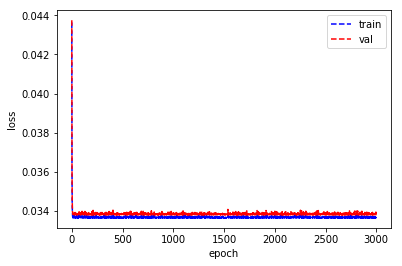

In [19]:
ax = plt.subplot(111)
ax.plot(np.arange(len(loss_train)), loss_train, 'b--')
ax.plot(np.arange(len(loss_val)), loss_val, 'r--')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_yscale("log")

ax.legend(["train","val"])
ax.figure.savefig("4-2 all-atom and h2t series latent space error.jpg")
plt.draw()

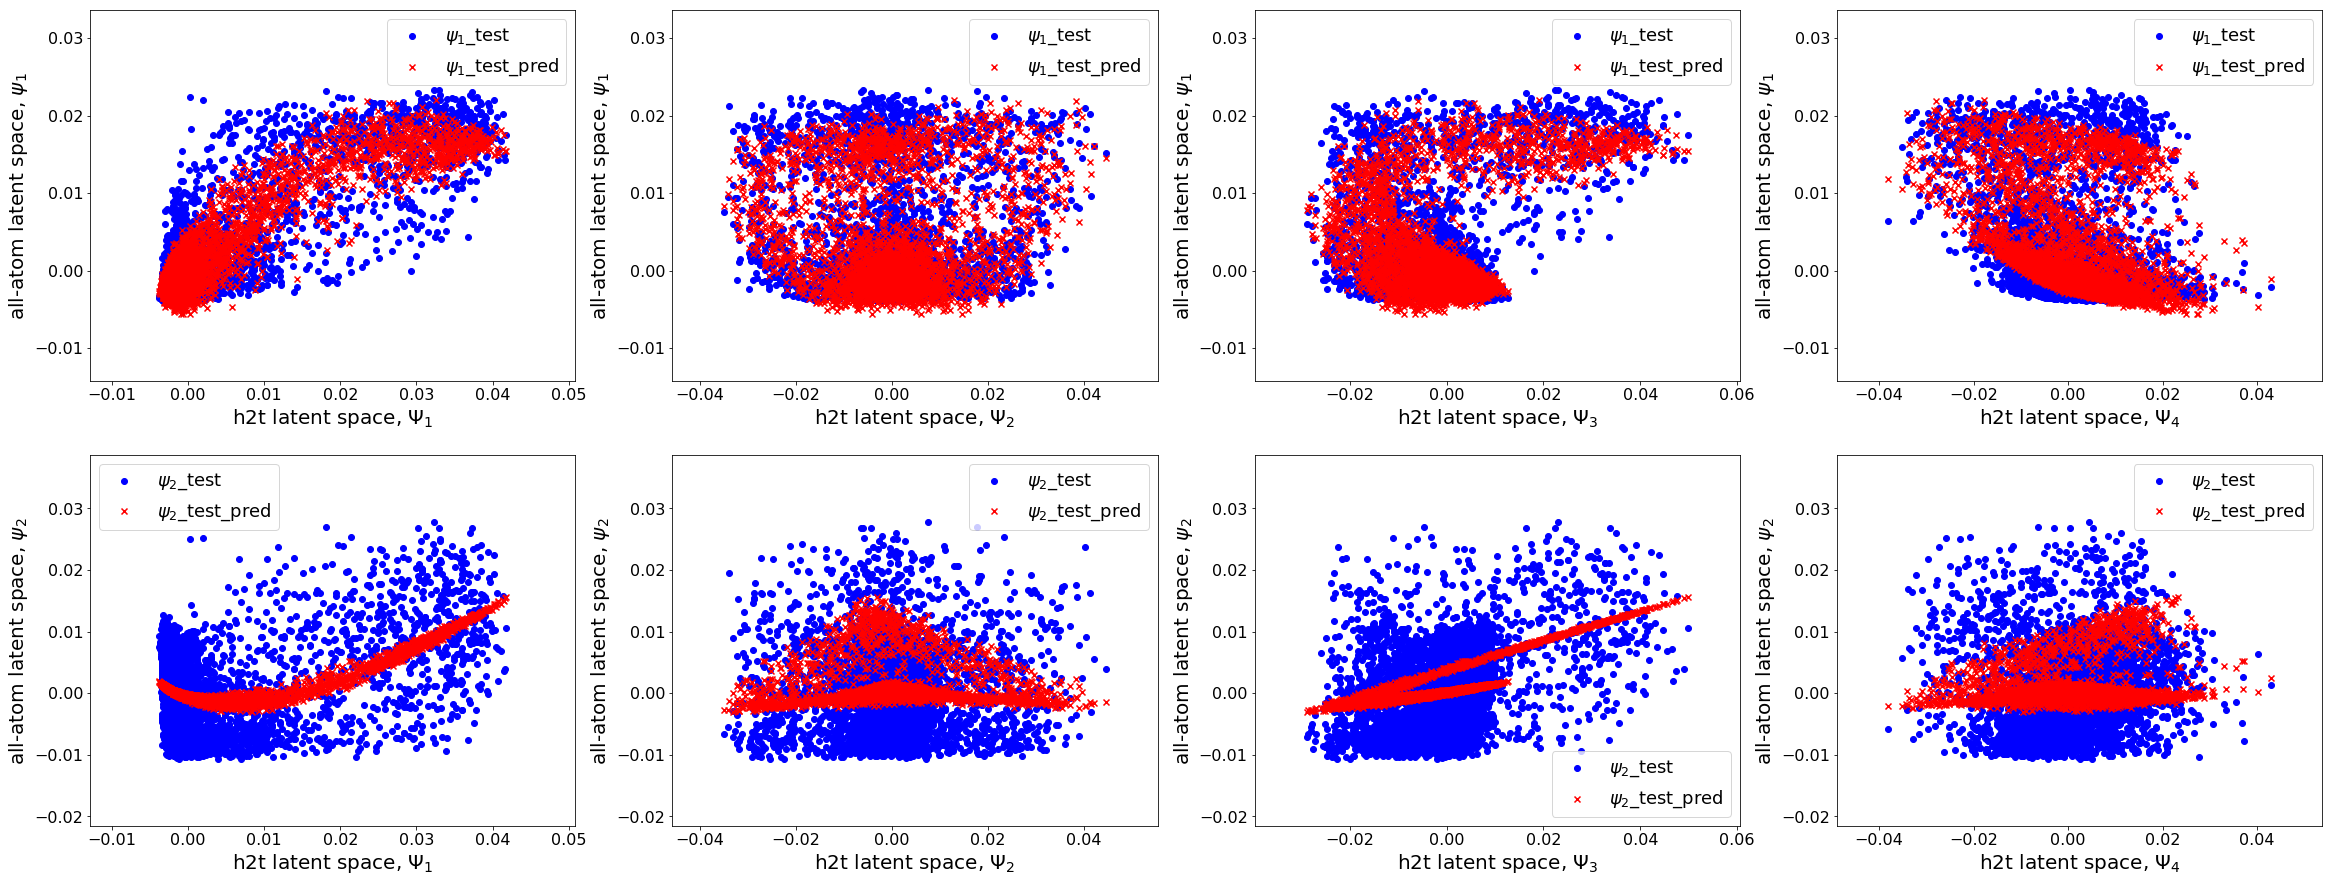

In [20]:
plt.figure(figsize=(40,15))

ax1 = plt.subplot(241)
ax1.scatter(x_test[:,0], y_test[:,0], c='blue', marker='o')
ax1.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax1.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax1.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax1.tick_params(labelsize=16)
ax1.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax2 = plt.subplot(242)
ax2.scatter(x_test[:,1], y_test[:,0], c='blue', marker='o')
ax2.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax2.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax2.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax2.tick_params(labelsize=16)
ax2.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax3 = plt.subplot(243)
ax3.scatter(x_test[:,2], y_test[:,0], c='blue', marker='o')
ax3.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax3.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax3.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax3.tick_params(labelsize=16)
ax3.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax4 = plt.subplot(244)
ax4.scatter(x_test[:,3], y_test[:,0], c='blue', marker='o')
ax4.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax4.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax4.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax4.tick_params(labelsize=16)
ax4.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax5 = plt.subplot(245)
ax5.scatter(x_test[:,0], y_test[:,1], c='blue', marker='o')
ax5.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax5.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax5.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax5.tick_params(labelsize=16)
ax5.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax6 = plt.subplot(246)
ax6.scatter(x_test[:,1], y_test[:,1], c='blue', marker='o')
ax6.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax6.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax6.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax6.tick_params(labelsize=16)
ax6.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)


ax7 = plt.subplot(247)
ax7.scatter(x_test[:,2], y_test[:,1], c='blue', marker='o')
ax7.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax7.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax7.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax7.tick_params(labelsize=16)
ax7.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax8 = plt.subplot(248)
ax8.scatter(x_test[:,3], y_test[:,1], c='blue', marker='o')
ax8.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax8.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax8.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax8.tick_params(labelsize=16)
ax8.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax.figure.savefig("4-2 all-atom and h2t series latent space correspondence.jpg")
plt.draw()